# Emission model
Author: Wenbo Yu

Data: 5/27/20

In [25]:
import os
import numpy as np
import torch.nn as nn
import pickle
import random
import pandas as pd
import torch
from torch.autograd import Variable
from pandas_ods_reader import read_ods
import sklearn.preprocessing as preprocessing
import matplotlib.pyplot as plt
% matplotlib inline

def filter_data(df, filters, columns):
    for i in range(len(columns)):
        column = columns[i]
        filter = (df[column] >= filters[i][0]) & (df[column] <= filters[i][1])
        df = df.loc[filter]
    return df, df.shape[0]

## Data preprocessing
Including seleting the features, filtering the data.

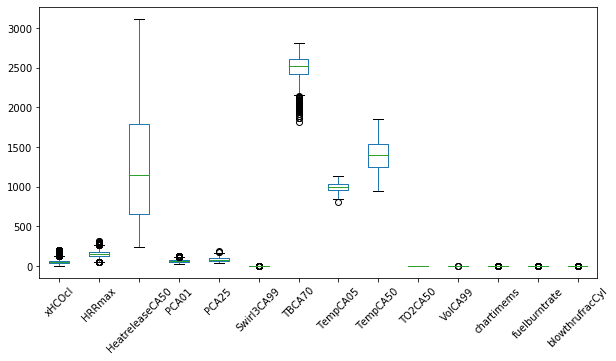

In [49]:
#### Hyperparameters needed to be set in advance ####
xHCOcI_thresh = 200 # Threshold to filter data by column 'xHCOcI' whose bound is smaller than the threshold
filter_iter = 0 # Iteration to filter data by all columns using IQR method.
#####################################################

# Import data start with HCaltitude.ods
num_list = []
path = 'data/HCaltitude.ods'
sheet_idx = 1
df = read_ods(path, sheet_idx)

# Select columns which are common among three data sets
df= df.drop(columns=['Sno', 'HCUDF', 'HCUDFpolynomial'])
columns = list(df.columns)
filter = (df['xHCOcI'] < xHCOcI_thresh)
df = df.loc[filter]
data = df[columns]
num_list.append(data.shape[0])

# Import other two kinds of data
paths = ['data/HCDOE.ods', 'data/HCTPA.ods']
for path in paths:
    sheet_idx = 1
    df = read_ods(path, sheet_idx)
    df = df[columns]
    filter = (df['xHCOcI'] < xHCOcI_thresh)
    df = df.loc[filter]
    data = pd.concat([data, df])
    num_list.append(data.shape[0])
data_origin = data.copy()
num_list_origin = num_list.copy()

# Whether to filter the data
if filter_iter:
    # Use IQR to filter the data
    for i in range(filter_iter):
        filters = []
        for column in columns:
            Q1 = data[column].quantile(0.25)
            Q3 = data[column].quantile(0.75)
            IQR = Q3 - Q1
            filters += [[Q1 - 1.5 * IQR, Q3 + 1.5 * IQR]]
        df1 = data[:num_list[0]]
        df2 = data[num_list[0]:num_list[1]]
        df3 = data[num_list[1]:num_list[2]]

        df1, n1= filter_data(df1, filters, columns)
        df2, n2 = filter_data(df2, filters, columns)
        df3, n3 = filter_data(df3, filters, columns)
        data = pd.concat([df1, df2, df3])
        num_list = [n1, n1 + n2, n1 + n2 + n3]
else:
    n1 = num_list[0]
    n2 = num_list[1] - num_list[0]
    n3 = num_list[2] - num_list[1]

# Visulize filtered data
boxplot = data.boxplot(grid=False, figsize=(10,5), rot=45, return_type='dict')

## Dataset preparation
Set training and test set

In [3]:
data = data.to_numpy()

# Scale data to [0,1]
scalerX = preprocessing.MinMaxScaler().fit(data[:, 1:])
scalery = preprocessing.MinMaxScaler().fit(data[:, 0:1])
data[:, 1:] = scalerX.transform(data[:, 1:])
# data[:, 0:1] = scalery.transform(data[:, 0:1])

# HCaltitude as target set
y_target = torch.from_numpy(data[:num_list[0], 0:1]).to(dtype=torch.float32).cuda()
x_target = torch.from_numpy(data[:num_list[0], 1:]).to(dtype=torch.float32).cuda()

# Set the other two sets for training and testing with properation of 7:3
HCDOE = torch.from_numpy(data[num_list[0]:num_list[1], :]).to(dtype=torch.float32).cuda()
HCTPA = torch.from_numpy(data[num_list[1]:num_list[2], :]).to(dtype=torch.float32).cuda()
training_size = [int(0.7 * n2), int(0.7 * n3)]
test_size = [n2 - int(0.7 * n2), n3 - int(0.7 * n3)]
batch_list = [[item for item in range(training_size[0])], [item for item in range(training_size[1])]]
chosen_size = [training_size[0] + test_size[0], training_size[1] + test_size[1]]

x_training = []
y_training = []
x_test = []
y_test = []

chosen_list = [item for item in range(HCDOE.shape[0])]
random.shuffle(chosen_list)
x_training.append(HCDOE[chosen_list[:training_size[0]], 1:])
y_training.append(HCDOE[chosen_list[:training_size[0]], 0:1])
x_test.append(HCDOE[chosen_list[training_size[0]:chosen_size[0]], 1:])
y_test.append(HCDOE[chosen_list[training_size[0]:chosen_size[0]], 0:1])

chosen_list = [item for item in range(HCTPA.shape[0])]
random.shuffle(chosen_list)
x_training.append(HCTPA[chosen_list[:training_size[1]], 1:])
y_training.append(HCTPA[chosen_list[:training_size[1]], 0:1])
x_test.append(HCTPA[chosen_list[training_size[1]:chosen_size[1]], 1:])
y_test.append(HCTPA[chosen_list[training_size[1]:chosen_size[1]], 0:1])

# Set test sets for different purposes
x_test_0 = x_test[0]
y_test_0 = y_test[0]
x_test_1 = x_test[1]
y_test_1 = y_test[1]
x_test_all = torch.cat([x_test[0], x_test[1]])
y_test_all = torch.cat([y_test[0], y_test[1]])

# Network structure

In [4]:
# Network structure
class NN(nn.Module):
    def __init__(self, features):
        super(NN, self).__init__()
        self.features = features
        self.l1 = nn.Sequential(
            nn.Linear(self.features, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
        )
        
    def point_grad_to(self, target):
        '''
        #### This function is important for meta learning. If other model is used, this one could be directly copied into other models ###
        Set .grad attribute of each parameter to be proportional
        to the difference between self and target
        '''
        for p, target_p in zip(self.parameters(), target.parameters()):
            if p.grad is None:
                # if self.is_cuda():
                p.grad = Variable(torch.zeros(p.size())).cuda()
                # else:
                #     p.grad = Variable(torch.zeros(p.size()))
            p.grad.data.zero_()  # not sure this is required
            p.grad.data.add_(p.data - target_p.data)
    def forward(self, input):
        output = self.l1(input)
        return output

# Training Process

In [9]:
#### Hyperparameters needed to be set in advance ####
Step = 100000
batch_size = 10
meta_flag = 1 # Whether use meta learning
features = x_target.shape[1]
net = NN(features).cuda()

if meta_flag: # With meta learning
    meta_lr = 1e-5 # For meta learning 
    update_lr = 1e-5 # For meta learning update step
    update_step = 5
    meta_optimizer = torch.optim.Adam(net.parameters(), lr=meta_lr) # Optimizers
else: # Without meta learning
    dataset_idx = 0 # 0: DOE, 1: TPA
    lrate = 1e-5 # Without meta leraning
    optimizer = torch.optim.Adam(net.parameters(), lr=lrate) # Optimizers
    
#####################################################



MSELoss = nn.MSELoss()
L1Loss = nn.L1Loss()
weight_flag = 0

print('Start training')
for step in range(Step): 
    if meta_flag:
        meta_loss_total = 0
        task_order = [i for i in range(2)]
        random.shuffle(task_order)
        for i in task_order:
            # Choose data
            batch_content = random.sample(batch_list[i], batch_size)
            x_batch = x_training[i][batch_content, :]
            y_batch = y_training[i][batch_content]
            # Initialize network. This network 'net_i' is used to train several steps, and the learnt parameters are used to update 'net'
            net_i = NN(features).cuda()
            net_i.load_state_dict(net.state_dict())
            update_optimizer = torch.optim.Adam(net_i.parameters(), lr=update_lr)
            # Update process
            for j in range(update_step):
                y_pred = net_i(x_batch)
                update_loss = MSELoss(y_pred, y_batch)
                update_optimizer.zero_grad()
                update_loss.backward(retain_graph=True)
                update_optimizer.step()
            net.point_grad_to(net_i)
            meta_optimizer.step()     
    else:
        batch_content = random.sample(batch_list[1], batch_size)
        x_batch = x_training[1][batch_content, :]
        y_batch = y_training[1][batch_content]
        # Update process
        y_pred = net(x_batch)
        loss = MSELoss(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
    
    # Test    
    y_pred = net(x_test_0)
    y_real = y_test_0
#     y_pred = torch.from_numpy(scalery.inverse_transform(y_pred.cpu().detach().numpy())).to(dtype=torch.float32).cuda()    
#     y_real = torch.from_numpy(scalery.inverse_transform(y_real.cpu().detach().numpy())).to(dtype=torch.float32).cuda()
    loss_0 = MSELoss(y_pred, y_real)
    loss_0 = torch.sqrt(loss_0.data)
#     loss_0 = MSELoss(y_pred, y_real) / (torch.mean(y_real) ** 2)

    y_pred = net(x_test_1)
    y_real = y_test_1
    
#     y_pred = torch.from_numpy(scalery.inverse_transform(y_pred.cpu().detach().numpy())).to(dtype=torch.float32).cuda()    
#     y_real = torch.from_numpy(scalery.inverse_transform(y_real.cpu().detach().numpy())).to(dtype=torch.float32).cuda()
#     loss_1 = MSELoss(y_pred, y_real) / (torch.mean(y_real) ** 2)
    
    loss_1 = MSELoss(y_pred, y_real)
    loss_1 = torch.sqrt(loss_1.data)
    
    
    y_pred = net(x_target)
    y_real = y_target
#     y_pred = torch.from_numpy(scalery.inverse_transform(y_pred.cpu().detach().numpy())).to(dtype=torch.float32).cuda()    
#     y_real = torch.from_numpy(scalery.inverse_transform(y_real.cpu().detach().numpy())).to(dtype=torch.float32).cuda()
#     loss_2 = MSELoss(y_pred, y_real) / (torch.mean(y_real) ** 2)
    loss_2 = MSELoss(y_pred, y_real)
    loss_2 = torch.sqrt(loss_2.data)
    
    print('epoch: %d || DOE: %f || TPA: %f || Target: %f' % (step, loss_0.data, loss_1.data, loss_2))
    loss = loss_0 + loss_1 + loss_2
    if step > 10:
        if weight_flag == 0:
            # Save weights
            weight_name = 'out/model_%d.ckpt' % (step)
            torch.save(net.state_dict(), weight_name)
            weight_flag = 1
            best_one = loss.data
        else:
            if loss.data < best_one:
                weight_name = 'out/model_%d_%.1f_%.1f.ckpt' % (step, loss.data, loss_2.data)
                torch.save(net.state_dict(), weight_name)
                best_one = loss.data

Start training
epoch: 0 || DOE: 72.814339 || TPA: 43.278053 || Target: 55.784973
epoch: 1 || DOE: 72.805779 || TPA: 43.267097 || Target: 55.775478
epoch: 2 || DOE: 72.797241 || TPA: 43.256187 || Target: 55.766014
epoch: 3 || DOE: 72.788742 || TPA: 43.245331 || Target: 55.756611
epoch: 4 || DOE: 72.780350 || TPA: 43.234577 || Target: 55.747330
epoch: 5 || DOE: 72.771988 || TPA: 43.223915 || Target: 55.738121
epoch: 6 || DOE: 72.763687 || TPA: 43.213345 || Target: 55.728966
epoch: 7 || DOE: 72.755409 || TPA: 43.202854 || Target: 55.719845
epoch: 8 || DOE: 72.747169 || TPA: 43.192482 || Target: 55.710800
epoch: 9 || DOE: 72.738976 || TPA: 43.182186 || Target: 55.701805
epoch: 10 || DOE: 72.730850 || TPA: 43.171959 || Target: 55.692867
epoch: 11 || DOE: 72.722740 || TPA: 43.161800 || Target: 55.683952
epoch: 12 || DOE: 72.714668 || TPA: 43.151684 || Target: 55.675049
epoch: 13 || DOE: 72.706619 || TPA: 43.141571 || Target: 55.666183
epoch: 14 || DOE: 72.698578 || TPA: 43.131439 || Target: 

epoch: 126 || DOE: 71.157410 || TPA: 41.188911 || Target: 53.950073
epoch: 127 || DOE: 71.134956 || TPA: 41.160549 || Target: 53.925167
epoch: 128 || DOE: 71.112312 || TPA: 41.131947 || Target: 53.900051
epoch: 129 || DOE: 71.089493 || TPA: 41.103096 || Target: 53.874725
epoch: 130 || DOE: 71.066505 || TPA: 41.073997 || Target: 53.849190
epoch: 131 || DOE: 71.043335 || TPA: 41.044655 || Target: 53.823452
epoch: 132 || DOE: 71.020012 || TPA: 41.015060 || Target: 53.797523
epoch: 133 || DOE: 70.996498 || TPA: 40.985233 || Target: 53.771385
epoch: 134 || DOE: 70.972786 || TPA: 40.955166 || Target: 53.745041
epoch: 135 || DOE: 70.948891 || TPA: 40.924862 || Target: 53.718487
epoch: 136 || DOE: 70.924820 || TPA: 40.894310 || Target: 53.691730
epoch: 137 || DOE: 70.900558 || TPA: 40.863537 || Target: 53.664768
epoch: 138 || DOE: 70.876106 || TPA: 40.832508 || Target: 53.637592
epoch: 139 || DOE: 70.851456 || TPA: 40.801247 || Target: 53.610203
epoch: 140 || DOE: 70.826637 || TPA: 40.769737 |

epoch: 252 || DOE: 66.758423 || TPA: 35.551109 || Target: 49.028904
epoch: 253 || DOE: 66.709915 || TPA: 35.488220 || Target: 48.974262
epoch: 254 || DOE: 66.661194 || TPA: 35.425034 || Target: 48.919353
epoch: 255 || DOE: 66.612297 || TPA: 35.361546 || Target: 48.864220
epoch: 256 || DOE: 66.563171 || TPA: 35.297752 || Target: 48.808826
epoch: 257 || DOE: 66.513794 || TPA: 35.233658 || Target: 48.753151
epoch: 258 || DOE: 66.464172 || TPA: 35.169258 || Target: 48.697193
epoch: 259 || DOE: 66.414330 || TPA: 35.104557 || Target: 48.640995
epoch: 260 || DOE: 66.364296 || TPA: 35.039543 || Target: 48.584564
epoch: 261 || DOE: 66.314034 || TPA: 34.974220 || Target: 48.527878
epoch: 262 || DOE: 66.263580 || TPA: 34.908657 || Target: 48.470966
epoch: 263 || DOE: 66.212891 || TPA: 34.842781 || Target: 48.413788
epoch: 264 || DOE: 66.161980 || TPA: 34.776592 || Target: 48.356365
epoch: 265 || DOE: 66.110832 || TPA: 34.710102 || Target: 48.298672
epoch: 266 || DOE: 66.059425 || TPA: 34.643288 |

epoch: 373 || DOE: 59.276772 || TPA: 25.674782 || Target: 40.490723
epoch: 374 || DOE: 59.202087 || TPA: 25.574846 || Target: 40.404411
epoch: 375 || DOE: 59.127174 || TPA: 25.474625 || Target: 40.317829
epoch: 376 || DOE: 59.052052 || TPA: 25.374144 || Target: 40.230995
epoch: 377 || DOE: 58.976757 || TPA: 25.273403 || Target: 40.143940
epoch: 378 || DOE: 58.901279 || TPA: 25.172415 || Target: 40.056660
epoch: 379 || DOE: 58.825603 || TPA: 25.071188 || Target: 39.969131
epoch: 380 || DOE: 58.749729 || TPA: 24.969728 || Target: 39.881363
epoch: 381 || DOE: 58.673672 || TPA: 24.868042 || Target: 39.793354
epoch: 382 || DOE: 58.597424 || TPA: 24.766130 || Target: 39.705105
epoch: 383 || DOE: 58.521000 || TPA: 24.663975 || Target: 39.616627
epoch: 384 || DOE: 58.444382 || TPA: 24.561594 || Target: 39.527912
epoch: 385 || DOE: 58.367573 || TPA: 24.458986 || Target: 39.438957
epoch: 386 || DOE: 58.290588 || TPA: 24.356131 || Target: 39.349785
epoch: 387 || DOE: 58.213421 || TPA: 24.253031 |

epoch: 497 || DOE: 49.138771 || TPA: 13.500601 || Target: 28.780581
epoch: 498 || DOE: 49.057346 || TPA: 13.443156 || Target: 28.690355
epoch: 499 || DOE: 48.975906 || TPA: 13.387354 || Target: 28.600227
epoch: 500 || DOE: 48.894489 || TPA: 13.333252 || Target: 28.510284
epoch: 501 || DOE: 48.813099 || TPA: 13.281011 || Target: 28.420481
epoch: 502 || DOE: 48.739624 || TPA: 13.235329 || Target: 28.339584
epoch: 503 || DOE: 48.671787 || TPA: 13.194470 || Target: 28.265022
epoch: 504 || DOE: 48.601543 || TPA: 13.153566 || Target: 28.187952
epoch: 505 || DOE: 48.530903 || TPA: 13.113206 || Target: 28.110832
epoch: 506 || DOE: 48.459499 || TPA: 13.073631 || Target: 28.033119
epoch: 507 || DOE: 48.387398 || TPA: 13.035201 || Target: 27.954798
epoch: 508 || DOE: 48.314075 || TPA: 12.997617 || Target: 27.875328
epoch: 509 || DOE: 48.252655 || TPA: 12.966728 || Target: 27.809181
epoch: 510 || DOE: 48.187721 || TPA: 12.935555 || Target: 27.739220
epoch: 511 || DOE: 48.132519 || TPA: 12.909382 |

epoch: 622 || DOE: 45.166859 || TPA: 12.108221 || Target: 24.735754
epoch: 623 || DOE: 45.172390 || TPA: 12.092148 || Target: 24.741255
epoch: 624 || DOE: 45.176884 || TPA: 12.076240 || Target: 24.745813
epoch: 625 || DOE: 45.174026 || TPA: 12.065155 || Target: 24.743397
epoch: 626 || DOE: 45.176598 || TPA: 12.051302 || Target: 24.746136
epoch: 627 || DOE: 45.177059 || TPA: 12.038473 || Target: 24.746893
epoch: 628 || DOE: 45.170738 || TPA: 12.029112 || Target: 24.741240
epoch: 629 || DOE: 45.164753 || TPA: 12.020261 || Target: 24.735771
epoch: 630 || DOE: 45.153404 || TPA: 12.013235 || Target: 24.725323
epoch: 631 || DOE: 45.131435 || TPA: 12.012276 || Target: 24.704849
epoch: 632 || DOE: 45.113590 || TPA: 12.009574 || Target: 24.688295
epoch: 633 || DOE: 45.098949 || TPA: 12.005776 || Target: 24.674759
epoch: 634 || DOE: 45.086124 || TPA: 12.000569 || Target: 24.662983
epoch: 635 || DOE: 45.075134 || TPA: 11.994798 || Target: 24.652987
epoch: 636 || DOE: 45.052937 || TPA: 11.994649 |

epoch: 743 || DOE: 43.624924 || TPA: 11.657973 || Target: 23.346668
epoch: 744 || DOE: 43.632301 || TPA: 11.636882 || Target: 23.352938
epoch: 745 || DOE: 43.631340 || TPA: 11.625286 || Target: 23.351919
epoch: 746 || DOE: 43.636623 || TPA: 11.608518 || Target: 23.356300
epoch: 747 || DOE: 43.639866 || TPA: 11.593199 || Target: 23.358883
epoch: 748 || DOE: 43.642319 || TPA: 11.579309 || Target: 23.360853
epoch: 749 || DOE: 43.637573 || TPA: 11.572124 || Target: 23.356543
epoch: 750 || DOE: 43.633312 || TPA: 11.564421 || Target: 23.352610
epoch: 751 || DOE: 43.634064 || TPA: 11.550756 || Target: 23.353075
epoch: 752 || DOE: 43.627285 || TPA: 11.543572 || Target: 23.346992
epoch: 753 || DOE: 43.626930 || TPA: 11.530901 || Target: 23.346502
epoch: 754 || DOE: 43.625542 || TPA: 11.519588 || Target: 23.345045
epoch: 755 || DOE: 43.623638 || TPA: 11.508066 || Target: 23.343031
epoch: 756 || DOE: 43.615456 || TPA: 11.503141 || Target: 23.335503
epoch: 757 || DOE: 43.608337 || TPA: 11.497787 |

epoch: 866 || DOE: 42.797112 || TPA: 10.854611 || Target: 22.609699
epoch: 867 || DOE: 42.790737 || TPA: 10.848409 || Target: 22.604044
epoch: 868 || DOE: 42.785362 || TPA: 10.843103 || Target: 22.599255
epoch: 869 || DOE: 42.775158 || TPA: 10.842038 || Target: 22.590260
epoch: 870 || DOE: 42.767521 || TPA: 10.837261 || Target: 22.583408
epoch: 871 || DOE: 42.754456 || TPA: 10.839353 || Target: 22.571888
epoch: 872 || DOE: 42.749863 || TPA: 10.833590 || Target: 22.567724
epoch: 873 || DOE: 42.739418 || TPA: 10.833106 || Target: 22.558533
epoch: 874 || DOE: 42.733055 || TPA: 10.828791 || Target: 22.552729
epoch: 875 || DOE: 42.727371 || TPA: 10.824367 || Target: 22.547543
epoch: 876 || DOE: 42.715851 || TPA: 10.826875 || Target: 22.537365
epoch: 877 || DOE: 42.706192 || TPA: 10.827568 || Target: 22.528824
epoch: 878 || DOE: 42.698074 || TPA: 10.826831 || Target: 22.521648
epoch: 879 || DOE: 42.691277 || TPA: 10.823769 || Target: 22.515676
epoch: 880 || DOE: 42.685383 || TPA: 10.819974 |

epoch: 993 || DOE: 42.368580 || TPA: 9.834664 || Target: 22.237581
epoch: 994 || DOE: 42.353737 || TPA: 9.834531 || Target: 22.224472
epoch: 995 || DOE: 42.333607 || TPA: 9.839174 || Target: 22.206568
epoch: 996 || DOE: 42.316689 || TPA: 9.839830 || Target: 22.191721
epoch: 997 || DOE: 42.310253 || TPA: 9.833899 || Target: 22.186266
epoch: 998 || DOE: 42.306404 || TPA: 9.823951 || Target: 22.183331
epoch: 999 || DOE: 42.301842 || TPA: 9.815530 || Target: 22.179688
epoch: 1000 || DOE: 42.304565 || TPA: 9.802870 || Target: 22.182529
epoch: 1001 || DOE: 42.305664 || TPA: 9.791968 || Target: 22.183901
epoch: 1002 || DOE: 42.298752 || TPA: 9.787949 || Target: 22.177938
epoch: 1003 || DOE: 42.299446 || TPA: 9.778880 || Target: 22.178825
epoch: 1004 || DOE: 42.290958 || TPA: 9.775459 || Target: 22.171591
epoch: 1005 || DOE: 42.276684 || TPA: 9.776775 || Target: 22.159056
epoch: 1006 || DOE: 42.271744 || TPA: 9.772136 || Target: 22.154888
epoch: 1007 || DOE: 42.260483 || TPA: 9.772514 || Targe

epoch: 1117 || DOE: 41.915520 || TPA: 9.004904 || Target: 21.879829
epoch: 1118 || DOE: 41.906803 || TPA: 9.000932 || Target: 21.872526
epoch: 1119 || DOE: 41.893673 || TPA: 8.998826 || Target: 21.861147
epoch: 1120 || DOE: 41.877377 || TPA: 8.997598 || Target: 21.846762
epoch: 1121 || DOE: 41.857151 || TPA: 8.997084 || Target: 21.828838
epoch: 1122 || DOE: 41.840824 || TPA: 8.994839 || Target: 21.814529
epoch: 1123 || DOE: 41.827808 || TPA: 8.991507 || Target: 21.803276
epoch: 1124 || DOE: 41.809631 || TPA: 8.991690 || Target: 21.787167
epoch: 1125 || DOE: 41.801888 || TPA: 8.986986 || Target: 21.780695
epoch: 1126 || DOE: 41.794708 || TPA: 8.981866 || Target: 21.774673
epoch: 1127 || DOE: 41.787090 || TPA: 8.976147 || Target: 21.768274
epoch: 1128 || DOE: 41.785667 || TPA: 8.966003 || Target: 21.767681
epoch: 1129 || DOE: 41.777195 || TPA: 8.957945 || Target: 21.760824
epoch: 1130 || DOE: 41.764206 || TPA: 8.951868 || Target: 21.749790
epoch: 1131 || DOE: 41.751945 || TPA: 8.946851 |

epoch: 1240 || DOE: 40.915821 || TPA: 8.528162 || Target: 21.040592
epoch: 1241 || DOE: 40.905354 || TPA: 8.527291 || Target: 21.031750
epoch: 1242 || DOE: 40.888847 || TPA: 8.530922 || Target: 21.017357
epoch: 1243 || DOE: 40.874565 || TPA: 8.532937 || Target: 21.004944
epoch: 1244 || DOE: 40.854469 || TPA: 8.539380 || Target: 20.987236
epoch: 1245 || DOE: 40.836884 || TPA: 8.544272 || Target: 20.971813
epoch: 1246 || DOE: 40.815933 || TPA: 8.550350 || Target: 20.953442
epoch: 1247 || DOE: 40.805416 || TPA: 8.549869 || Target: 20.944359
epoch: 1248 || DOE: 40.803017 || TPA: 8.543913 || Target: 20.942705
epoch: 1249 || DOE: 40.807720 || TPA: 8.533697 || Target: 20.947441
epoch: 1250 || DOE: 40.811134 || TPA: 8.525005 || Target: 20.950979
epoch: 1251 || DOE: 40.813831 || TPA: 8.517072 || Target: 20.953857
epoch: 1252 || DOE: 40.809845 || TPA: 8.511791 || Target: 20.951014
epoch: 1253 || DOE: 40.813961 || TPA: 8.502177 || Target: 20.955383
epoch: 1254 || DOE: 40.817204 || TPA: 8.493922 |

epoch: 1361 || DOE: 40.324047 || TPA: 8.083260 || Target: 20.579607
epoch: 1362 || DOE: 40.318165 || TPA: 8.081660 || Target: 20.574701
epoch: 1363 || DOE: 40.328217 || TPA: 8.070873 || Target: 20.584337
epoch: 1364 || DOE: 40.350063 || TPA: 8.053161 || Target: 20.604893
epoch: 1365 || DOE: 40.374569 || TPA: 8.034696 || Target: 20.627995
epoch: 1366 || DOE: 40.386806 || TPA: 8.023158 || Target: 20.639935
epoch: 1367 || DOE: 40.403950 || TPA: 8.009354 || Target: 20.656237
epoch: 1368 || DOE: 40.417377 || TPA: 7.997519 || Target: 20.669075
epoch: 1369 || DOE: 40.428211 || TPA: 7.987365 || Target: 20.679579
epoch: 1370 || DOE: 40.427822 || TPA: 7.982588 || Target: 20.679825
epoch: 1371 || DOE: 40.433987 || TPA: 7.974907 || Target: 20.686140
epoch: 1372 || DOE: 40.438843 || TPA: 7.968286 || Target: 20.691179
epoch: 1373 || DOE: 40.440643 || TPA: 7.962840 || Target: 20.693420
epoch: 1374 || DOE: 40.433735 || TPA: 7.961928 || Target: 20.687481
epoch: 1375 || DOE: 40.428265 || TPA: 7.959062 |

epoch: 1486 || DOE: 39.659161 || TPA: 7.855922 || Target: 20.047153
epoch: 1487 || DOE: 39.663757 || TPA: 7.848204 || Target: 20.052052
epoch: 1488 || DOE: 39.666672 || TPA: 7.840852 || Target: 20.055473
epoch: 1489 || DOE: 39.661366 || TPA: 7.838406 || Target: 20.051611
epoch: 1490 || DOE: 39.664677 || TPA: 7.831912 || Target: 20.055235
epoch: 1491 || DOE: 39.659546 || TPA: 7.830812 || Target: 20.051313
epoch: 1492 || DOE: 39.655605 || TPA: 7.828113 || Target: 20.048599
epoch: 1493 || DOE: 39.659851 || TPA: 7.820756 || Target: 20.053135
epoch: 1494 || DOE: 39.655373 || TPA: 7.819058 || Target: 20.049778
epoch: 1495 || DOE: 39.659279 || TPA: 7.812456 || Target: 20.053831
epoch: 1496 || DOE: 39.654575 || TPA: 7.810814 || Target: 20.050270
epoch: 1497 || DOE: 39.657459 || TPA: 7.804685 || Target: 20.053535
epoch: 1498 || DOE: 39.651974 || TPA: 7.804276 || Target: 20.049200
epoch: 1499 || DOE: 39.655132 || TPA: 7.799113 || Target: 20.052542
epoch: 1500 || DOE: 39.649837 || TPA: 7.798893 |

epoch: 1608 || DOE: 38.820656 || TPA: 7.863774 || Target: 19.389160
epoch: 1609 || DOE: 38.805397 || TPA: 7.870088 || Target: 19.377169
epoch: 1610 || DOE: 38.785282 || TPA: 7.880796 || Target: 19.361118
epoch: 1611 || DOE: 38.776535 || TPA: 7.882761 || Target: 19.354548
epoch: 1612 || DOE: 38.770130 || TPA: 7.882317 || Target: 19.349997
epoch: 1613 || DOE: 38.758026 || TPA: 7.885333 || Target: 19.340790
epoch: 1614 || DOE: 38.755836 || TPA: 7.880722 || Target: 19.339809
epoch: 1615 || DOE: 38.753952 || TPA: 7.876159 || Target: 19.339022
epoch: 1616 || DOE: 38.752178 || TPA: 7.871669 || Target: 19.338310
epoch: 1617 || DOE: 38.750679 || TPA: 7.867505 || Target: 19.337772
epoch: 1618 || DOE: 38.742477 || TPA: 7.867776 || Target: 19.331654
epoch: 1619 || DOE: 38.735107 || TPA: 7.867782 || Target: 19.326204
epoch: 1620 || DOE: 38.729160 || TPA: 7.865612 || Target: 19.322071
epoch: 1621 || DOE: 38.724972 || TPA: 7.861372 || Target: 19.319473
epoch: 1622 || DOE: 38.707428 || TPA: 7.869416 |

epoch: 1736 || DOE: 38.357235 || TPA: 7.668977 || Target: 19.076569
epoch: 1737 || DOE: 38.348423 || TPA: 7.672537 || Target: 19.069660
epoch: 1738 || DOE: 38.348564 || TPA: 7.669693 || Target: 19.070372
epoch: 1739 || DOE: 38.340752 || TPA: 7.672376 || Target: 19.064407
epoch: 1740 || DOE: 38.335571 || TPA: 7.672472 || Target: 19.061026
epoch: 1741 || DOE: 38.339058 || TPA: 7.666786 || Target: 19.064863
epoch: 1742 || DOE: 38.341816 || TPA: 7.662051 || Target: 19.067961
epoch: 1743 || DOE: 38.336243 || TPA: 7.662953 || Target: 19.064032
epoch: 1744 || DOE: 38.339565 || TPA: 7.658023 || Target: 19.067513
epoch: 1745 || DOE: 38.342171 || TPA: 7.654330 || Target: 19.070124
epoch: 1746 || DOE: 38.342472 || TPA: 7.651674 || Target: 19.070816
epoch: 1747 || DOE: 38.335358 || TPA: 7.653048 || Target: 19.065491
epoch: 1748 || DOE: 38.329533 || TPA: 7.653587 || Target: 19.061243
epoch: 1749 || DOE: 38.324863 || TPA: 7.653142 || Target: 19.058018
epoch: 1750 || DOE: 38.328953 || TPA: 7.647278 |

epoch: 1860 || DOE: 38.044003 || TPA: 7.580424 || Target: 18.882627
epoch: 1861 || DOE: 38.047104 || TPA: 7.575945 || Target: 18.886103
epoch: 1862 || DOE: 38.049660 || TPA: 7.572013 || Target: 18.889040
epoch: 1863 || DOE: 38.051636 || TPA: 7.568922 || Target: 18.891319
epoch: 1864 || DOE: 38.061192 || TPA: 7.561654 || Target: 18.900093
epoch: 1865 || DOE: 38.060848 || TPA: 7.559928 || Target: 18.900440
epoch: 1866 || DOE: 38.060474 || TPA: 7.558546 || Target: 18.900639
epoch: 1867 || DOE: 38.060051 || TPA: 7.557306 || Target: 18.900743
epoch: 1868 || DOE: 38.050850 || TPA: 7.561039 || Target: 18.893272
epoch: 1869 || DOE: 38.043434 || TPA: 7.563638 || Target: 18.887386
epoch: 1870 || DOE: 38.029350 || TPA: 7.570227 || Target: 18.875803
epoch: 1871 || DOE: 38.026234 || TPA: 7.570265 || Target: 18.873720
epoch: 1872 || DOE: 38.015759 || TPA: 7.574428 || Target: 18.865448
epoch: 1873 || DOE: 38.007343 || TPA: 7.577489 || Target: 18.858938
epoch: 1874 || DOE: 38.008385 || TPA: 7.575037 |

epoch: 1989 || DOE: 37.520233 || TPA: 7.706756 || Target: 18.499289
epoch: 1990 || DOE: 37.512535 || TPA: 7.709803 || Target: 18.493565
epoch: 1991 || DOE: 37.489883 || TPA: 7.723605 || Target: 18.475439
epoch: 1992 || DOE: 37.480473 || TPA: 7.728583 || Target: 18.468102
epoch: 1993 || DOE: 37.480896 || TPA: 7.726758 || Target: 18.468731
epoch: 1994 || DOE: 37.481285 || TPA: 7.724787 || Target: 18.469446
epoch: 1995 || DOE: 37.481571 || TPA: 7.723057 || Target: 18.470072
epoch: 1996 || DOE: 37.481712 || TPA: 7.721457 || Target: 18.470572
epoch: 1997 || DOE: 37.481796 || TPA: 7.719908 || Target: 18.471056
epoch: 1998 || DOE: 37.481674 || TPA: 7.718630 || Target: 18.471359
epoch: 1999 || DOE: 37.465847 || TPA: 7.728592 || Target: 18.458687
epoch: 2000 || DOE: 37.452862 || TPA: 7.736676 || Target: 18.448378
epoch: 2001 || DOE: 37.442242 || TPA: 7.743159 || Target: 18.440083
epoch: 2002 || DOE: 37.425476 || TPA: 7.754129 || Target: 18.426853
epoch: 2003 || DOE: 37.419846 || TPA: 7.757287 |

epoch: 2112 || DOE: 37.163647 || TPA: 7.780945 || Target: 18.271664
epoch: 2113 || DOE: 37.162663 || TPA: 7.780422 || Target: 18.271315
epoch: 2114 || DOE: 37.153679 || TPA: 7.785145 || Target: 18.264547
epoch: 2115 || DOE: 37.146484 || TPA: 7.788486 || Target: 18.259491
epoch: 2116 || DOE: 37.148464 || TPA: 7.785887 || Target: 18.261797
epoch: 2117 || DOE: 37.149857 || TPA: 7.784080 || Target: 18.263269
epoch: 2118 || DOE: 37.143074 || TPA: 7.787634 || Target: 18.258240
epoch: 2119 || DOE: 37.145649 || TPA: 7.785043 || Target: 18.260824
epoch: 2120 || DOE: 37.140167 || TPA: 7.786959 || Target: 18.257286
epoch: 2121 || DOE: 37.127724 || TPA: 7.793486 || Target: 18.248194
epoch: 2122 || DOE: 37.117580 || TPA: 7.798688 || Target: 18.240820
epoch: 2123 || DOE: 37.101040 || TPA: 7.808650 || Target: 18.228075
epoch: 2124 || DOE: 37.080029 || TPA: 7.822041 || Target: 18.211651
epoch: 2125 || DOE: 37.071053 || TPA: 7.827312 || Target: 18.204905
epoch: 2126 || DOE: 37.047951 || TPA: 7.842569 |

epoch: 2234 || DOE: 36.560349 || TPA: 8.061512 || Target: 17.864775
epoch: 2235 || DOE: 36.548252 || TPA: 8.070162 || Target: 17.856174
epoch: 2236 || DOE: 36.522247 || TPA: 8.090256 || Target: 17.837049
epoch: 2237 || DOE: 36.493748 || TPA: 8.112810 || Target: 17.816214
epoch: 2238 || DOE: 36.478516 || TPA: 8.125006 || Target: 17.804998
epoch: 2239 || DOE: 36.469402 || TPA: 8.131652 || Target: 17.798594
epoch: 2240 || DOE: 36.457180 || TPA: 8.139948 || Target: 17.790384
epoch: 2241 || DOE: 36.446945 || TPA: 8.147187 || Target: 17.783350
epoch: 2242 || DOE: 36.438457 || TPA: 8.153109 || Target: 17.777565
epoch: 2243 || DOE: 36.431515 || TPA: 8.157935 || Target: 17.772827
epoch: 2244 || DOE: 36.433918 || TPA: 8.154761 || Target: 17.775024
epoch: 2245 || DOE: 36.427944 || TPA: 8.158759 || Target: 17.771034
epoch: 2246 || DOE: 36.424168 || TPA: 8.160110 || Target: 17.769028
epoch: 2247 || DOE: 36.428970 || TPA: 8.154094 || Target: 17.773335
epoch: 2248 || DOE: 36.432808 || TPA: 8.149166 |

epoch: 2355 || DOE: 36.189320 || TPA: 8.248578 || Target: 17.629070
epoch: 2356 || DOE: 36.181919 || TPA: 8.254259 || Target: 17.623667
epoch: 2357 || DOE: 36.167980 || TPA: 8.265493 || Target: 17.613640
epoch: 2358 || DOE: 36.173489 || TPA: 8.260023 || Target: 17.617706
epoch: 2359 || DOE: 36.185993 || TPA: 8.248634 || Target: 17.626898
epoch: 2360 || DOE: 36.196182 || TPA: 8.239184 || Target: 17.634527
epoch: 2361 || DOE: 36.204418 || TPA: 8.231438 || Target: 17.640820
epoch: 2362 || DOE: 36.194687 || TPA: 8.238603 || Target: 17.634144
epoch: 2363 || DOE: 36.187416 || TPA: 8.244071 || Target: 17.628763
epoch: 2364 || DOE: 36.176601 || TPA: 8.252081 || Target: 17.621141
epoch: 2365 || DOE: 36.175930 || TPA: 8.251507 || Target: 17.621014
epoch: 2366 || DOE: 36.175598 || TPA: 8.250420 || Target: 17.621382
epoch: 2367 || DOE: 36.167416 || TPA: 8.255863 || Target: 17.616243
epoch: 2368 || DOE: 36.160675 || TPA: 8.260218 || Target: 17.612013
epoch: 2369 || DOE: 36.163277 || TPA: 8.256635 |

epoch: 2479 || DOE: 36.245911 || TPA: 8.126772 || Target: 17.701368
epoch: 2480 || DOE: 36.267338 || TPA: 8.112590 || Target: 17.718210
epoch: 2481 || DOE: 36.284706 || TPA: 8.101357 || Target: 17.732008
epoch: 2482 || DOE: 36.288967 || TPA: 8.098508 || Target: 17.735350
epoch: 2483 || DOE: 36.284126 || TPA: 8.101327 || Target: 17.731695
epoch: 2484 || DOE: 36.280094 || TPA: 8.103648 || Target: 17.728573
epoch: 2485 || DOE: 36.285057 || TPA: 8.100318 || Target: 17.732458
epoch: 2486 || DOE: 36.288670 || TPA: 8.097763 || Target: 17.735199
epoch: 2487 || DOE: 36.283344 || TPA: 8.100800 || Target: 17.731344
epoch: 2488 || DOE: 36.287395 || TPA: 8.098000 || Target: 17.734903
epoch: 2489 || DOE: 36.291046 || TPA: 8.095485 || Target: 17.738478
epoch: 2490 || DOE: 36.292171 || TPA: 8.094510 || Target: 17.739485
epoch: 2491 || DOE: 36.293018 || TPA: 8.093666 || Target: 17.740160
epoch: 2492 || DOE: 36.285355 || TPA: 8.098132 || Target: 17.734417
epoch: 2493 || DOE: 36.286156 || TPA: 8.097383 |

epoch: 2605 || DOE: 36.262196 || TPA: 8.067168 || Target: 17.705379
epoch: 2606 || DOE: 36.255505 || TPA: 8.070942 || Target: 17.700132
epoch: 2607 || DOE: 36.257313 || TPA: 8.069590 || Target: 17.700829
epoch: 2608 || DOE: 36.258743 || TPA: 8.068520 || Target: 17.701500
epoch: 2609 || DOE: 36.251526 || TPA: 8.072745 || Target: 17.695644
epoch: 2610 || DOE: 36.245647 || TPA: 8.076197 || Target: 17.690887
epoch: 2611 || DOE: 36.240879 || TPA: 8.079042 || Target: 17.687094
epoch: 2612 || DOE: 36.237049 || TPA: 8.081348 || Target: 17.684301
epoch: 2613 || DOE: 36.240276 || TPA: 8.079213 || Target: 17.686153
epoch: 2614 || DOE: 36.234623 || TPA: 8.082634 || Target: 17.681641
epoch: 2615 || DOE: 36.238350 || TPA: 8.080231 || Target: 17.684563
epoch: 2616 || DOE: 36.233059 || TPA: 8.083389 || Target: 17.680590
epoch: 2617 || DOE: 36.229122 || TPA: 8.085581 || Target: 17.677979
epoch: 2618 || DOE: 36.234230 || TPA: 8.082045 || Target: 17.682188
epoch: 2619 || DOE: 36.230064 || TPA: 8.084299 |

epoch: 2730 || DOE: 35.937851 || TPA: 8.224070 || Target: 17.483454
epoch: 2731 || DOE: 35.916489 || TPA: 8.238914 || Target: 17.466932
epoch: 2732 || DOE: 35.890118 || TPA: 8.257658 || Target: 17.447187
epoch: 2733 || DOE: 35.874966 || TPA: 8.268741 || Target: 17.435314
epoch: 2734 || DOE: 35.862694 || TPA: 8.277772 || Target: 17.425785
epoch: 2735 || DOE: 35.837433 || TPA: 8.296544 || Target: 17.407679
epoch: 2736 || DOE: 35.825901 || TPA: 8.305102 || Target: 17.399523
epoch: 2737 || DOE: 35.817574 || TPA: 8.310886 || Target: 17.394190
epoch: 2738 || DOE: 35.810940 || TPA: 8.315237 || Target: 17.390202
epoch: 2739 || DOE: 35.813679 || TPA: 8.312454 || Target: 17.392660
epoch: 2740 || DOE: 35.815941 || TPA: 8.310103 || Target: 17.394798
epoch: 2741 || DOE: 35.817020 || TPA: 8.308826 || Target: 17.395741
epoch: 2742 || DOE: 35.811104 || TPA: 8.312478 || Target: 17.392347
epoch: 2743 || DOE: 35.814484 || TPA: 8.309166 || Target: 17.395477
epoch: 2744 || DOE: 35.809185 || TPA: 8.312448 |

epoch: 2854 || DOE: 35.900578 || TPA: 8.215192 || Target: 17.474306
epoch: 2855 || DOE: 35.904358 || TPA: 8.212691 || Target: 17.477324
epoch: 2856 || DOE: 35.889885 || TPA: 8.221435 || Target: 17.466698
epoch: 2857 || DOE: 35.878197 || TPA: 8.228420 || Target: 17.457928
epoch: 2858 || DOE: 35.860329 || TPA: 8.239450 || Target: 17.444780
epoch: 2859 || DOE: 35.853973 || TPA: 8.243246 || Target: 17.440260
epoch: 2860 || DOE: 35.848858 || TPA: 8.246295 || Target: 17.436850
epoch: 2861 || DOE: 35.836430 || TPA: 8.254141 || Target: 17.428345
epoch: 2862 || DOE: 35.834591 || TPA: 8.255097 || Target: 17.427544
epoch: 2863 || DOE: 35.832970 || TPA: 8.255858 || Target: 17.426664
epoch: 2864 || DOE: 35.823345 || TPA: 8.261893 || Target: 17.419859
epoch: 2865 || DOE: 35.823803 || TPA: 8.261413 || Target: 17.420504
epoch: 2866 || DOE: 35.824139 || TPA: 8.261022 || Target: 17.421076
epoch: 2867 || DOE: 35.824390 || TPA: 8.260632 || Target: 17.421467
epoch: 2868 || DOE: 35.816132 || TPA: 8.265779 |

epoch: 2977 || DOE: 35.639938 || TPA: 8.340888 || Target: 17.305847
epoch: 2978 || DOE: 35.649773 || TPA: 8.333967 || Target: 17.312635
epoch: 2979 || DOE: 35.657436 || TPA: 8.328594 || Target: 17.318056
epoch: 2980 || DOE: 35.663540 || TPA: 8.324203 || Target: 17.322180
epoch: 2981 || DOE: 35.657478 || TPA: 8.327903 || Target: 17.317141
epoch: 2982 || DOE: 35.650143 || TPA: 8.332592 || Target: 17.311077
epoch: 2983 || DOE: 35.652660 || TPA: 8.330691 || Target: 17.312286
epoch: 2984 || DOE: 35.647171 || TPA: 8.334208 || Target: 17.308420
epoch: 2985 || DOE: 35.635468 || TPA: 8.341971 || Target: 17.299940
epoch: 2986 || DOE: 35.626087 || TPA: 8.348180 || Target: 17.293240
epoch: 2987 || DOE: 35.618484 || TPA: 8.353187 || Target: 17.288021
epoch: 2988 || DOE: 35.600571 || TPA: 8.365503 || Target: 17.275253
epoch: 2989 || DOE: 35.591084 || TPA: 8.372087 || Target: 17.268303
epoch: 2990 || DOE: 35.575096 || TPA: 8.383431 || Target: 17.256918
epoch: 2991 || DOE: 35.570301 || TPA: 8.386706 |

epoch: 3098 || DOE: 35.575832 || TPA: 8.352007 || Target: 17.286884
epoch: 3099 || DOE: 35.569462 || TPA: 8.355305 || Target: 17.282066
epoch: 3100 || DOE: 35.564030 || TPA: 8.357915 || Target: 17.277645
epoch: 3101 || DOE: 35.553841 || TPA: 8.363780 || Target: 17.270655
epoch: 3102 || DOE: 35.545570 || TPA: 8.368576 || Target: 17.265001
epoch: 3103 || DOE: 35.538609 || TPA: 8.372637 || Target: 17.260183
epoch: 3104 || DOE: 35.541096 || TPA: 8.370682 || Target: 17.261778
epoch: 3105 || DOE: 35.535503 || TPA: 8.373976 || Target: 17.258175
epoch: 3106 || DOE: 35.534550 || TPA: 8.373978 || Target: 17.257048
epoch: 3107 || DOE: 35.525303 || TPA: 8.379229 || Target: 17.249966
epoch: 3108 || DOE: 35.523067 || TPA: 8.379830 || Target: 17.247204
epoch: 3109 || DOE: 35.520565 || TPA: 8.380579 || Target: 17.244047
epoch: 3110 || DOE: 35.510136 || TPA: 8.386628 || Target: 17.235527
epoch: 3111 || DOE: 35.502075 || TPA: 8.391380 || Target: 17.229225
epoch: 3112 || DOE: 35.496563 || TPA: 8.394362 |

epoch: 3223 || DOE: 34.983494 || TPA: 8.733973 || Target: 16.911951
epoch: 3224 || DOE: 34.977127 || TPA: 8.738930 || Target: 16.908495
epoch: 3225 || DOE: 34.963604 || TPA: 8.750294 || Target: 16.900482
epoch: 3226 || DOE: 34.952431 || TPA: 8.759655 || Target: 16.893875
epoch: 3227 || DOE: 34.943329 || TPA: 8.767272 || Target: 16.888584
epoch: 3228 || DOE: 34.937668 || TPA: 8.771485 || Target: 16.885832
epoch: 3229 || DOE: 34.932945 || TPA: 8.774931 || Target: 16.883417
epoch: 3230 || DOE: 34.929028 || TPA: 8.777745 || Target: 16.881308
epoch: 3231 || DOE: 34.925602 || TPA: 8.780219 || Target: 16.879547
epoch: 3232 || DOE: 34.930035 || TPA: 8.775766 || Target: 16.882229
epoch: 3233 || DOE: 34.933540 || TPA: 8.772174 || Target: 16.884512
epoch: 3234 || DOE: 34.928230 || TPA: 8.776381 || Target: 16.881432
epoch: 3235 || DOE: 34.932007 || TPA: 8.772500 || Target: 16.883982
epoch: 3236 || DOE: 34.927025 || TPA: 8.776377 || Target: 16.881207
epoch: 3237 || DOE: 34.930565 || TPA: 8.772868 |

epoch: 3349 || DOE: 34.984058 || TPA: 8.681506 || Target: 16.948639
epoch: 3350 || DOE: 34.985947 || TPA: 8.679485 || Target: 16.949837
epoch: 3351 || DOE: 34.986523 || TPA: 8.678354 || Target: 16.949844
epoch: 3352 || DOE: 34.995205 || TPA: 8.671288 || Target: 16.954983
epoch: 3353 || DOE: 34.993923 || TPA: 8.671555 || Target: 16.953733
epoch: 3354 || DOE: 35.000572 || TPA: 8.666176 || Target: 16.957920
epoch: 3355 || DOE: 35.005508 || TPA: 8.661877 || Target: 16.960636
epoch: 3356 || DOE: 35.001175 || TPA: 8.664327 || Target: 16.957323
epoch: 3357 || DOE: 34.997604 || TPA: 8.666516 || Target: 16.954998
epoch: 3358 || DOE: 34.994591 || TPA: 8.668186 || Target: 16.953094
epoch: 3359 || DOE: 34.999332 || TPA: 8.664325 || Target: 16.956165
epoch: 3360 || DOE: 34.994823 || TPA: 8.667136 || Target: 16.953192
epoch: 3361 || DOE: 34.985428 || TPA: 8.673113 || Target: 16.947237
epoch: 3362 || DOE: 34.969498 || TPA: 8.683932 || Target: 16.936939
epoch: 3363 || DOE: 34.965332 || TPA: 8.686372 |

epoch: 3472 || DOE: 35.029354 || TPA: 8.600007 || Target: 16.963242
epoch: 3473 || DOE: 35.055054 || TPA: 8.581959 || Target: 16.980196
epoch: 3474 || DOE: 35.067654 || TPA: 8.573277 || Target: 16.988829
epoch: 3475 || DOE: 35.077763 || TPA: 8.566324 || Target: 16.995777
epoch: 3476 || DOE: 35.085716 || TPA: 8.560630 || Target: 17.000963
epoch: 3477 || DOE: 35.100327 || TPA: 8.550461 || Target: 17.010410
epoch: 3478 || DOE: 35.103790 || TPA: 8.547549 || Target: 17.012377
epoch: 3479 || DOE: 35.110905 || TPA: 8.542737 || Target: 17.017746
epoch: 3480 || DOE: 35.124630 || TPA: 8.533632 || Target: 17.027214
epoch: 3481 || DOE: 35.136150 || TPA: 8.526355 || Target: 17.035652
epoch: 3482 || DOE: 35.152000 || TPA: 8.516601 || Target: 17.047119
epoch: 3483 || DOE: 35.160759 || TPA: 8.510705 || Target: 17.052790
epoch: 3484 || DOE: 35.163418 || TPA: 8.507998 || Target: 17.053478
epoch: 3485 || DOE: 35.165798 || TPA: 8.505368 || Target: 17.053957
epoch: 3486 || DOE: 35.167721 || TPA: 8.503343 |

epoch: 3598 || DOE: 34.859638 || TPA: 8.683640 || Target: 16.842623
epoch: 3599 || DOE: 34.865791 || TPA: 8.678440 || Target: 16.846729
epoch: 3600 || DOE: 34.861450 || TPA: 8.681629 || Target: 16.844166
epoch: 3601 || DOE: 34.864689 || TPA: 8.678842 || Target: 16.845779
epoch: 3602 || DOE: 34.864937 || TPA: 8.678333 || Target: 16.844965
epoch: 3603 || DOE: 34.861576 || TPA: 8.680572 || Target: 16.842840
epoch: 3604 || DOE: 34.865871 || TPA: 8.676770 || Target: 16.845072
epoch: 3605 || DOE: 34.869007 || TPA: 8.673899 || Target: 16.846256
epoch: 3606 || DOE: 34.863373 || TPA: 8.677885 || Target: 16.842144
epoch: 3607 || DOE: 34.858818 || TPA: 8.681114 || Target: 16.838795
epoch: 3608 || DOE: 34.863400 || TPA: 8.677132 || Target: 16.841524
epoch: 3609 || DOE: 34.866795 || TPA: 8.674176 || Target: 16.843361
epoch: 3610 || DOE: 34.870411 || TPA: 8.671021 || Target: 16.845665
epoch: 3611 || DOE: 34.866665 || TPA: 8.673509 || Target: 16.843958
epoch: 3612 || DOE: 34.869141 || TPA: 8.671124 |

epoch: 3724 || DOE: 34.568779 || TPA: 8.864067 || Target: 16.687237
epoch: 3725 || DOE: 34.579704 || TPA: 8.854319 || Target: 16.694481
epoch: 3726 || DOE: 34.587776 || TPA: 8.847156 || Target: 16.699570
epoch: 3727 || DOE: 34.588856 || TPA: 8.845609 || Target: 16.701050
epoch: 3728 || DOE: 34.597771 || TPA: 8.837490 || Target: 16.706867
epoch: 3729 || DOE: 34.596798 || TPA: 8.837726 || Target: 16.706787
epoch: 3730 || DOE: 34.595901 || TPA: 8.837925 || Target: 16.706545
epoch: 3731 || DOE: 34.602982 || TPA: 8.831450 || Target: 16.711077
epoch: 3732 || DOE: 34.607758 || TPA: 8.827067 || Target: 16.713697
epoch: 3733 || DOE: 34.609180 || TPA: 8.825467 || Target: 16.713781
epoch: 3734 || DOE: 34.593861 || TPA: 8.837715 || Target: 16.703899
epoch: 3735 || DOE: 34.573891 || TPA: 8.854101 || Target: 16.691437
epoch: 3736 || DOE: 34.556919 || TPA: 8.868313 || Target: 16.680876
epoch: 3737 || DOE: 34.550598 || TPA: 8.873533 || Target: 16.676525
epoch: 3738 || DOE: 34.537540 || TPA: 8.884673 |

epoch: 3849 || DOE: 34.706421 || TPA: 8.713908 || Target: 16.772266
epoch: 3850 || DOE: 34.706123 || TPA: 8.713736 || Target: 16.772436
epoch: 3851 || DOE: 34.690380 || TPA: 8.724698 || Target: 16.762667
epoch: 3852 || DOE: 34.677620 || TPA: 8.733652 || Target: 16.754927
epoch: 3853 || DOE: 34.667088 || TPA: 8.740970 || Target: 16.748415
epoch: 3854 || DOE: 34.658623 || TPA: 8.746975 || Target: 16.743504
epoch: 3855 || DOE: 34.643501 || TPA: 8.757994 || Target: 16.734529
epoch: 3856 || DOE: 34.647736 || TPA: 8.754333 || Target: 16.737188
epoch: 3857 || DOE: 34.650642 || TPA: 8.751625 || Target: 16.738724
epoch: 3858 || DOE: 34.661301 || TPA: 8.743287 || Target: 16.745367
epoch: 3859 || DOE: 34.661663 || TPA: 8.742772 || Target: 16.745783
epoch: 3860 || DOE: 34.669865 || TPA: 8.736201 || Target: 16.750761
epoch: 3861 || DOE: 34.671650 || TPA: 8.734451 || Target: 16.752451
epoch: 3862 || DOE: 34.672791 || TPA: 8.733078 || Target: 16.753288
epoch: 3863 || DOE: 34.674103 || TPA: 8.731690 |

epoch: 3973 || DOE: 34.596962 || TPA: 8.749297 || Target: 16.691751
epoch: 3974 || DOE: 34.580254 || TPA: 8.762001 || Target: 16.681551
epoch: 3975 || DOE: 34.567001 || TPA: 8.772155 || Target: 16.673466
epoch: 3976 || DOE: 34.556072 || TPA: 8.780478 || Target: 16.666561
epoch: 3977 || DOE: 34.538952 || TPA: 8.793996 || Target: 16.656069
epoch: 3978 || DOE: 34.533222 || TPA: 8.798117 || Target: 16.652426
epoch: 3979 || DOE: 34.520660 || TPA: 8.807984 || Target: 16.645166
epoch: 3980 || DOE: 34.509838 || TPA: 8.816444 || Target: 16.638851
epoch: 3981 || DOE: 34.500504 || TPA: 8.823667 || Target: 16.633217
epoch: 3982 || DOE: 34.501045 || TPA: 8.822658 || Target: 16.633446
epoch: 3983 || DOE: 34.500393 || TPA: 8.822744 || Target: 16.632572
epoch: 3984 || DOE: 34.499462 || TPA: 8.823036 || Target: 16.631451
epoch: 3985 || DOE: 34.490261 || TPA: 8.830402 || Target: 16.625504
epoch: 3986 || DOE: 34.482403 || TPA: 8.836787 || Target: 16.620245
epoch: 3987 || DOE: 34.475864 || TPA: 8.842111 |

epoch: 4096 || DOE: 34.426033 || TPA: 8.846203 || Target: 16.583603
epoch: 4097 || DOE: 34.421963 || TPA: 8.849245 || Target: 16.581976
epoch: 4098 || DOE: 34.418621 || TPA: 8.851756 || Target: 16.580778
epoch: 4099 || DOE: 34.422791 || TPA: 8.847820 || Target: 16.583258
epoch: 4100 || DOE: 34.428089 || TPA: 8.842828 || Target: 16.586832
epoch: 4101 || DOE: 34.425880 || TPA: 8.844098 || Target: 16.586386
epoch: 4102 || DOE: 34.432602 || TPA: 8.837604 || Target: 16.590914
epoch: 4103 || DOE: 34.438686 || TPA: 8.831682 || Target: 16.595404
epoch: 4104 || DOE: 34.440582 || TPA: 8.829345 || Target: 16.596998
epoch: 4105 || DOE: 34.442429 || TPA: 8.827065 || Target: 16.598499
epoch: 4106 || DOE: 34.443985 || TPA: 8.825191 || Target: 16.599928
epoch: 4107 || DOE: 34.436947 || TPA: 8.830530 || Target: 16.596380
epoch: 4108 || DOE: 34.439400 || TPA: 8.828020 || Target: 16.598320
epoch: 4109 || DOE: 34.437012 || TPA: 8.829494 || Target: 16.598146
epoch: 4110 || DOE: 34.444176 || TPA: 8.823085 |

epoch: 4221 || DOE: 34.315639 || TPA: 8.889597 || Target: 16.527397
epoch: 4222 || DOE: 34.316204 || TPA: 8.888488 || Target: 16.528502
epoch: 4223 || DOE: 34.315514 || TPA: 8.888659 || Target: 16.528629
epoch: 4224 || DOE: 34.313942 || TPA: 8.889778 || Target: 16.527998
epoch: 4225 || DOE: 34.305172 || TPA: 8.897177 || Target: 16.523235
epoch: 4226 || DOE: 34.289963 || TPA: 8.910275 || Target: 16.515202
epoch: 4227 || DOE: 34.278057 || TPA: 8.920403 || Target: 16.509214
epoch: 4228 || DOE: 34.276073 || TPA: 8.921742 || Target: 16.508167
epoch: 4229 || DOE: 34.274483 || TPA: 8.922786 || Target: 16.507364
epoch: 4230 || DOE: 34.264927 || TPA: 8.930979 || Target: 16.502178
epoch: 4231 || DOE: 34.257153 || TPA: 8.937618 || Target: 16.498104
epoch: 4232 || DOE: 34.258106 || TPA: 8.936476 || Target: 16.498348
epoch: 4233 || DOE: 34.261311 || TPA: 8.933129 || Target: 16.500359
epoch: 4234 || DOE: 34.269001 || TPA: 8.925555 || Target: 16.505545
epoch: 4235 || DOE: 34.275230 || TPA: 8.919492 |

epoch: 4346 || DOE: 34.443806 || TPA: 8.736859 || Target: 16.592999
epoch: 4347 || DOE: 34.435158 || TPA: 8.743173 || Target: 16.587420
epoch: 4348 || DOE: 34.428123 || TPA: 8.748261 || Target: 16.582872
epoch: 4349 || DOE: 34.422497 || TPA: 8.752321 || Target: 16.579342
epoch: 4350 || DOE: 34.409454 || TPA: 8.762210 || Target: 16.571449
epoch: 4351 || DOE: 34.416096 || TPA: 8.756658 || Target: 16.574976
epoch: 4352 || DOE: 34.421494 || TPA: 8.752184 || Target: 16.578083
epoch: 4353 || DOE: 34.433994 || TPA: 8.742235 || Target: 16.585239
epoch: 4354 || DOE: 34.435780 || TPA: 8.740721 || Target: 16.586323
epoch: 4355 || DOE: 34.445210 || TPA: 8.733277 || Target: 16.591530
epoch: 4356 || DOE: 34.451218 || TPA: 8.728417 || Target: 16.594273
epoch: 4357 || DOE: 34.445698 || TPA: 8.732432 || Target: 16.590176
epoch: 4358 || DOE: 34.439335 || TPA: 8.737109 || Target: 16.585363
epoch: 4359 || DOE: 34.442413 || TPA: 8.734464 || Target: 16.586256
epoch: 4360 || DOE: 34.444248 || TPA: 8.732801 |

epoch: 4470 || DOE: 34.545689 || TPA: 8.635846 || Target: 16.641438
epoch: 4471 || DOE: 34.541843 || TPA: 8.638639 || Target: 16.640196
epoch: 4472 || DOE: 34.541458 || TPA: 8.638678 || Target: 16.640242
epoch: 4473 || DOE: 34.533268 || TPA: 8.644314 || Target: 16.635761
epoch: 4474 || DOE: 34.525158 || TPA: 8.649780 || Target: 16.630844
epoch: 4475 || DOE: 34.517277 || TPA: 8.654966 || Target: 16.625702
epoch: 4476 || DOE: 34.510822 || TPA: 8.659235 || Target: 16.621525
epoch: 4477 || DOE: 34.512123 || TPA: 8.657682 || Target: 16.621336
epoch: 4478 || DOE: 34.513271 || TPA: 8.656409 || Target: 16.621431
epoch: 4479 || DOE: 34.514317 || TPA: 8.655256 || Target: 16.621683
epoch: 4480 || DOE: 34.505829 || TPA: 8.661105 || Target: 16.616121
epoch: 4481 || DOE: 34.506153 || TPA: 8.660420 || Target: 16.615591
epoch: 4482 || DOE: 34.506832 || TPA: 8.659478 || Target: 16.615639
epoch: 4483 || DOE: 34.499432 || TPA: 8.664547 || Target: 16.611053
epoch: 4484 || DOE: 34.491974 || TPA: 8.669790 |

epoch: 4593 || DOE: 34.310436 || TPA: 8.786138 || Target: 16.507322
epoch: 4594 || DOE: 34.318230 || TPA: 8.779390 || Target: 16.511105
epoch: 4595 || DOE: 34.332176 || TPA: 8.767567 || Target: 16.518574
epoch: 4596 || DOE: 34.326160 || TPA: 8.772176 || Target: 16.514875
epoch: 4597 || DOE: 34.321095 || TPA: 8.776032 || Target: 16.511681
epoch: 4598 || DOE: 34.316917 || TPA: 8.779145 || Target: 16.508863
epoch: 4599 || DOE: 34.314194 || TPA: 8.781027 || Target: 16.507313
epoch: 4600 || DOE: 34.304684 || TPA: 8.788417 || Target: 16.502663
epoch: 4601 || DOE: 34.303360 || TPA: 8.789134 || Target: 16.501976
epoch: 4602 || DOE: 34.302422 || TPA: 8.789556 || Target: 16.501831
epoch: 4603 || DOE: 34.293400 || TPA: 8.796868 || Target: 16.497377
epoch: 4604 || DOE: 34.286053 || TPA: 8.802827 || Target: 16.494062
epoch: 4605 || DOE: 34.284550 || TPA: 8.803639 || Target: 16.494097
epoch: 4606 || DOE: 34.290089 || TPA: 8.798667 || Target: 16.497355
epoch: 4607 || DOE: 34.286530 || TPA: 8.801411 |

epoch: 4717 || DOE: 34.303535 || TPA: 8.750240 || Target: 16.504210
epoch: 4718 || DOE: 34.307724 || TPA: 8.746531 || Target: 16.507044
epoch: 4719 || DOE: 34.311550 || TPA: 8.743328 || Target: 16.509972
epoch: 4720 || DOE: 34.315033 || TPA: 8.740476 || Target: 16.512915
epoch: 4721 || DOE: 34.309776 || TPA: 8.744498 || Target: 16.511007
epoch: 4722 || DOE: 34.305477 || TPA: 8.747723 || Target: 16.509489
epoch: 4723 || DOE: 34.310570 || TPA: 8.743686 || Target: 16.513317
epoch: 4724 || DOE: 34.306633 || TPA: 8.746737 || Target: 16.512075
epoch: 4725 || DOE: 34.311707 || TPA: 8.742815 || Target: 16.515778
epoch: 4726 || DOE: 34.307854 || TPA: 8.745828 || Target: 16.514668
epoch: 4727 || DOE: 34.304203 || TPA: 8.748590 || Target: 16.513197
epoch: 4728 || DOE: 34.309460 || TPA: 8.744454 || Target: 16.516598
epoch: 4729 || DOE: 34.314060 || TPA: 8.740936 || Target: 16.519814
epoch: 4730 || DOE: 34.317783 || TPA: 8.738106 || Target: 16.522459
epoch: 4731 || DOE: 34.320824 || TPA: 8.735826 |

epoch: 4843 || DOE: 34.147900 || TPA: 8.838785 || Target: 16.417185
epoch: 4844 || DOE: 34.140236 || TPA: 8.845042 || Target: 16.412781
epoch: 4845 || DOE: 34.133976 || TPA: 8.850172 || Target: 16.409294
epoch: 4846 || DOE: 34.137112 || TPA: 8.847127 || Target: 16.410728
epoch: 4847 || DOE: 34.127796 || TPA: 8.855079 || Target: 16.405373
epoch: 4848 || DOE: 34.112118 || TPA: 8.868744 || Target: 16.396809
epoch: 4849 || DOE: 34.107521 || TPA: 8.872695 || Target: 16.393990
epoch: 4850 || DOE: 34.103882 || TPA: 8.875795 || Target: 16.391953
epoch: 4851 || DOE: 34.092758 || TPA: 8.885667 || Target: 16.386080
epoch: 4852 || DOE: 34.083729 || TPA: 8.893624 || Target: 16.381357
epoch: 4853 || DOE: 34.091782 || TPA: 8.886104 || Target: 16.385271
epoch: 4854 || DOE: 34.106133 || TPA: 8.873035 || Target: 16.392071
epoch: 4855 || DOE: 34.105179 || TPA: 8.873682 || Target: 16.390825
epoch: 4856 || DOE: 34.104095 || TPA: 8.874310 || Target: 16.389433
epoch: 4857 || DOE: 34.103027 || TPA: 8.874882 |

epoch: 4967 || DOE: 34.337639 || TPA: 8.665797 || Target: 16.538282
epoch: 4968 || DOE: 34.334705 || TPA: 8.667530 || Target: 16.536760
epoch: 4969 || DOE: 34.331978 || TPA: 8.668898 || Target: 16.534988
epoch: 4970 || DOE: 34.330021 || TPA: 8.669825 || Target: 16.533787
epoch: 4971 || DOE: 34.312351 || TPA: 8.681353 || Target: 16.523659
epoch: 4972 || DOE: 34.298866 || TPA: 8.690426 || Target: 16.516405
epoch: 4973 || DOE: 34.279533 || TPA: 8.703730 || Target: 16.505974
epoch: 4974 || DOE: 34.263653 || TPA: 8.714676 || Target: 16.497299
epoch: 4975 || DOE: 34.251354 || TPA: 8.723231 || Target: 16.490988
epoch: 4976 || DOE: 34.249622 || TPA: 8.724064 || Target: 16.490129
epoch: 4977 || DOE: 34.239346 || TPA: 8.730864 || Target: 16.484089
epoch: 4978 || DOE: 34.235458 || TPA: 8.732826 || Target: 16.480806
epoch: 4979 || DOE: 34.224106 || TPA: 8.740669 || Target: 16.473984
epoch: 4980 || DOE: 34.223946 || TPA: 8.740345 || Target: 16.473570
epoch: 4981 || DOE: 34.224346 || TPA: 8.739534 |

epoch: 5089 || DOE: 33.742569 || TPA: 9.123074 || Target: 16.236198
epoch: 5090 || DOE: 33.743473 || TPA: 9.122500 || Target: 16.236111
epoch: 5091 || DOE: 33.745182 || TPA: 9.120730 || Target: 16.236685
epoch: 5092 || DOE: 33.747520 || TPA: 9.118061 || Target: 16.237823
epoch: 5093 || DOE: 33.749435 || TPA: 9.115722 || Target: 16.238852
epoch: 5094 || DOE: 33.751026 || TPA: 9.113580 || Target: 16.239946
epoch: 5095 || DOE: 33.752419 || TPA: 9.111485 || Target: 16.241177
epoch: 5096 || DOE: 33.745415 || TPA: 9.117909 || Target: 16.238512
epoch: 5097 || DOE: 33.739548 || TPA: 9.123397 || Target: 16.236113
epoch: 5098 || DOE: 33.743069 || TPA: 9.119271 || Target: 16.237915
epoch: 5099 || DOE: 33.738323 || TPA: 9.123248 || Target: 16.236378
epoch: 5100 || DOE: 33.734455 || TPA: 9.126311 || Target: 16.235258
epoch: 5101 || DOE: 33.731522 || TPA: 9.128377 || Target: 16.234571
epoch: 5102 || DOE: 33.737091 || TPA: 9.122007 || Target: 16.237610
epoch: 5103 || DOE: 33.741570 || TPA: 9.116842 |

epoch: 5215 || DOE: 33.643524 || TPA: 9.154288 || Target: 16.222544
epoch: 5216 || DOE: 33.632988 || TPA: 9.164013 || Target: 16.218115
epoch: 5217 || DOE: 33.632935 || TPA: 9.163733 || Target: 16.218401
epoch: 5218 || DOE: 33.625187 || TPA: 9.170592 || Target: 16.215460
epoch: 5219 || DOE: 33.618996 || TPA: 9.176047 || Target: 16.213408
epoch: 5220 || DOE: 33.622051 || TPA: 9.172891 || Target: 16.215408
epoch: 5221 || DOE: 33.616348 || TPA: 9.177980 || Target: 16.213316
epoch: 5222 || DOE: 33.619797 || TPA: 9.174538 || Target: 16.215208
epoch: 5223 || DOE: 33.614643 || TPA: 9.179157 || Target: 16.213495
epoch: 5224 || DOE: 33.610516 || TPA: 9.182755 || Target: 16.212292
epoch: 5225 || DOE: 33.607368 || TPA: 9.185436 || Target: 16.211687
epoch: 5226 || DOE: 33.605221 || TPA: 9.186891 || Target: 16.211695
epoch: 5227 || DOE: 33.611217 || TPA: 9.180923 || Target: 16.214832
epoch: 5228 || DOE: 33.622421 || TPA: 9.170125 || Target: 16.220486
epoch: 5229 || DOE: 33.637226 || TPA: 9.156143 |

epoch: 5339 || DOE: 33.392506 || TPA: 9.346725 || Target: 16.151258
epoch: 5340 || DOE: 33.383236 || TPA: 9.355328 || Target: 16.147453
epoch: 5341 || DOE: 33.383766 || TPA: 9.354553 || Target: 16.147585
epoch: 5342 || DOE: 33.384369 || TPA: 9.353602 || Target: 16.147831
epoch: 5343 || DOE: 33.384811 || TPA: 9.352776 || Target: 16.147890
epoch: 5344 || DOE: 33.385307 || TPA: 9.351959 || Target: 16.148228
epoch: 5345 || DOE: 33.385838 || TPA: 9.351182 || Target: 16.148775
epoch: 5346 || DOE: 33.378178 || TPA: 9.358201 || Target: 16.145840
epoch: 5347 || DOE: 33.371792 || TPA: 9.364070 || Target: 16.143164
epoch: 5348 || DOE: 33.366470 || TPA: 9.368978 || Target: 16.140738
epoch: 5349 || DOE: 33.362164 || TPA: 9.372901 || Target: 16.138823
epoch: 5350 || DOE: 33.366680 || TPA: 9.368351 || Target: 16.140566
epoch: 5351 || DOE: 33.367332 || TPA: 9.367446 || Target: 16.140366
epoch: 5352 || DOE: 33.360600 || TPA: 9.373607 || Target: 16.137432
epoch: 5353 || DOE: 33.362946 || TPA: 9.371055 |

epoch: 5466 || DOE: 33.462837 || TPA: 9.247996 || Target: 16.193939
epoch: 5467 || DOE: 33.458515 || TPA: 9.251471 || Target: 16.192179
epoch: 5468 || DOE: 33.463093 || TPA: 9.247424 || Target: 16.194160
epoch: 5469 || DOE: 33.458862 || TPA: 9.250731 || Target: 16.192463
epoch: 5470 || DOE: 33.463436 || TPA: 9.246615 || Target: 16.194515
epoch: 5471 || DOE: 33.458870 || TPA: 9.250225 || Target: 16.192532
epoch: 5472 || DOE: 33.458828 || TPA: 9.250081 || Target: 16.193239
epoch: 5473 || DOE: 33.458084 || TPA: 9.250522 || Target: 16.193335
epoch: 5474 || DOE: 33.456707 || TPA: 9.251448 || Target: 16.192831
epoch: 5475 || DOE: 33.463741 || TPA: 9.245425 || Target: 16.196196
epoch: 5476 || DOE: 33.470627 || TPA: 9.239264 || Target: 16.199327
epoch: 5477 || DOE: 33.469433 || TPA: 9.239583 || Target: 16.198713
epoch: 5478 || DOE: 33.468124 || TPA: 9.239921 || Target: 16.197783
epoch: 5479 || DOE: 33.465618 || TPA: 9.241236 || Target: 16.196085
epoch: 5480 || DOE: 33.470577 || TPA: 9.236362 |

epoch: 5587 || DOE: 33.506073 || TPA: 9.164145 || Target: 16.186678
epoch: 5588 || DOE: 33.491486 || TPA: 9.175872 || Target: 16.178427
epoch: 5589 || DOE: 33.485012 || TPA: 9.180792 || Target: 16.173323
epoch: 5590 || DOE: 33.471615 || TPA: 9.192049 || Target: 16.165527
epoch: 5591 || DOE: 33.460968 || TPA: 9.201117 || Target: 16.159498
epoch: 5592 || DOE: 33.451969 || TPA: 9.208857 || Target: 16.154392
epoch: 5593 || DOE: 33.452374 || TPA: 9.208119 || Target: 16.153175
epoch: 5594 || DOE: 33.452656 || TPA: 9.207574 || Target: 16.152292
epoch: 5595 || DOE: 33.452961 || TPA: 9.206985 || Target: 16.151779
epoch: 5596 || DOE: 33.461952 || TPA: 9.198510 || Target: 16.155157
epoch: 5597 || DOE: 33.476727 || TPA: 9.184835 || Target: 16.160793
epoch: 5598 || DOE: 33.480553 || TPA: 9.181020 || Target: 16.161808
epoch: 5599 || DOE: 33.491585 || TPA: 9.170762 || Target: 16.165915
epoch: 5600 || DOE: 33.500443 || TPA: 9.162583 || Target: 16.169325
epoch: 5601 || DOE: 33.507351 || TPA: 9.156201 |

epoch: 5710 || DOE: 33.409149 || TPA: 9.215364 || Target: 16.125351
epoch: 5711 || DOE: 33.404400 || TPA: 9.219514 || Target: 16.123537
epoch: 5712 || DOE: 33.400501 || TPA: 9.222904 || Target: 16.122078
epoch: 5713 || DOE: 33.405327 || TPA: 9.218020 || Target: 16.123911
epoch: 5714 || DOE: 33.409454 || TPA: 9.213804 || Target: 16.125731
epoch: 5715 || DOE: 33.404831 || TPA: 9.217808 || Target: 16.124306
epoch: 5716 || DOE: 33.401295 || TPA: 9.220718 || Target: 16.123386
epoch: 5717 || DOE: 33.398380 || TPA: 9.223041 || Target: 16.122627
epoch: 5718 || DOE: 33.404102 || TPA: 9.217310 || Target: 16.125313
epoch: 5719 || DOE: 33.408718 || TPA: 9.212671 || Target: 16.127499
epoch: 5720 || DOE: 33.412521 || TPA: 9.208778 || Target: 16.129269
epoch: 5721 || DOE: 33.415680 || TPA: 9.205485 || Target: 16.130888
epoch: 5722 || DOE: 33.418182 || TPA: 9.202811 || Target: 16.132105
epoch: 5723 || DOE: 33.412350 || TPA: 9.207660 || Target: 16.130127
epoch: 5724 || DOE: 33.407734 || TPA: 9.211526 |

epoch: 5835 || DOE: 33.380280 || TPA: 9.210357 || Target: 16.129749
epoch: 5836 || DOE: 33.372639 || TPA: 9.216996 || Target: 16.126490
epoch: 5837 || DOE: 33.358292 || TPA: 9.229641 || Target: 16.120590
epoch: 5838 || DOE: 33.354927 || TPA: 9.232436 || Target: 16.119232
epoch: 5839 || DOE: 33.352654 || TPA: 9.234137 || Target: 16.118496
epoch: 5840 || DOE: 33.350941 || TPA: 9.235175 || Target: 16.117964
epoch: 5841 || DOE: 33.349415 || TPA: 9.236036 || Target: 16.117403
epoch: 5842 || DOE: 33.348095 || TPA: 9.236731 || Target: 16.116697
epoch: 5843 || DOE: 33.339062 || TPA: 9.244455 || Target: 16.113213
epoch: 5844 || DOE: 33.332626 || TPA: 9.249716 || Target: 16.111191
epoch: 5845 || DOE: 33.335255 || TPA: 9.246675 || Target: 16.112371
epoch: 5846 || DOE: 33.338867 || TPA: 9.242856 || Target: 16.114491
epoch: 5847 || DOE: 33.351971 || TPA: 9.230526 || Target: 16.120728
epoch: 5848 || DOE: 33.364479 || TPA: 9.218943 || Target: 16.126925
epoch: 5849 || DOE: 33.370533 || TPA: 9.213233 |

epoch: 5958 || DOE: 33.370731 || TPA: 9.183640 || Target: 16.111204
epoch: 5959 || DOE: 33.375175 || TPA: 9.179421 || Target: 16.113279
epoch: 5960 || DOE: 33.373909 || TPA: 9.180338 || Target: 16.113604
epoch: 5961 || DOE: 33.381001 || TPA: 9.173792 || Target: 16.117258
epoch: 5962 || DOE: 33.378784 || TPA: 9.175702 || Target: 16.117153
epoch: 5963 || DOE: 33.378124 || TPA: 9.176265 || Target: 16.117855
epoch: 5964 || DOE: 33.378922 || TPA: 9.175391 || Target: 16.119497
epoch: 5965 || DOE: 33.379543 || TPA: 9.174702 || Target: 16.120815
epoch: 5966 || DOE: 33.388245 || TPA: 9.166954 || Target: 16.125343
epoch: 5967 || DOE: 33.396935 || TPA: 9.159250 || Target: 16.129908
epoch: 5968 || DOE: 33.407619 || TPA: 9.149863 || Target: 16.135672
epoch: 5969 || DOE: 33.418205 || TPA: 9.140706 || Target: 16.141502
epoch: 5970 || DOE: 33.426399 || TPA: 9.133595 || Target: 16.145798
epoch: 5971 || DOE: 33.423107 || TPA: 9.136095 || Target: 16.144667
epoch: 5972 || DOE: 33.418873 || TPA: 9.139334 |

epoch: 6082 || DOE: 33.663288 || TPA: 8.909307 || Target: 16.232492
epoch: 6083 || DOE: 33.665913 || TPA: 8.907351 || Target: 16.233950
epoch: 6084 || DOE: 33.668068 || TPA: 8.905873 || Target: 16.235371
epoch: 6085 || DOE: 33.669827 || TPA: 8.904699 || Target: 16.236631
epoch: 6086 || DOE: 33.679726 || TPA: 8.897564 || Target: 16.241539
epoch: 6087 || DOE: 33.688606 || TPA: 8.891545 || Target: 16.246344
epoch: 6088 || DOE: 33.696541 || TPA: 8.886580 || Target: 16.251057
epoch: 6089 || DOE: 33.703205 || TPA: 8.882643 || Target: 16.255331
epoch: 6090 || DOE: 33.708893 || TPA: 8.879382 || Target: 16.259151
epoch: 6091 || DOE: 33.713318 || TPA: 8.876673 || Target: 16.261957
epoch: 6092 || DOE: 33.716881 || TPA: 8.874686 || Target: 16.264410
epoch: 6093 || DOE: 33.728813 || TPA: 8.867279 || Target: 16.271074
epoch: 6094 || DOE: 33.738392 || TPA: 8.861414 || Target: 16.276518
epoch: 6095 || DOE: 33.754574 || TPA: 8.851382 || Target: 16.285221
epoch: 6096 || DOE: 33.767597 || TPA: 8.843246 |

epoch: 6205 || DOE: 33.754597 || TPA: 8.801343 || Target: 16.254478
epoch: 6206 || DOE: 33.743912 || TPA: 8.807858 || Target: 16.248495
epoch: 6207 || DOE: 33.735199 || TPA: 8.813223 || Target: 16.243662
epoch: 6208 || DOE: 33.728119 || TPA: 8.817590 || Target: 16.239729
epoch: 6209 || DOE: 33.722340 || TPA: 8.821131 || Target: 16.236490
epoch: 6210 || DOE: 33.717609 || TPA: 8.823987 || Target: 16.233780
epoch: 6211 || DOE: 33.710537 || TPA: 8.828485 || Target: 16.229912
epoch: 6212 || DOE: 33.703449 || TPA: 8.833240 || Target: 16.226320
epoch: 6213 || DOE: 33.696720 || TPA: 8.837533 || Target: 16.222494
epoch: 6214 || DOE: 33.698822 || TPA: 8.835443 || Target: 16.222715
epoch: 6215 || DOE: 33.683746 || TPA: 8.845910 || Target: 16.214848
epoch: 6216 || DOE: 33.663166 || TPA: 8.860884 || Target: 16.204811
epoch: 6217 || DOE: 33.654827 || TPA: 8.866850 || Target: 16.200533
epoch: 6218 || DOE: 33.639671 || TPA: 8.878114 || Target: 16.193239
epoch: 6219 || DOE: 33.644939 || TPA: 8.873827 |

epoch: 6331 || DOE: 33.845200 || TPA: 8.686022 || Target: 16.250317
epoch: 6332 || DOE: 33.851990 || TPA: 8.680995 || Target: 16.253923
epoch: 6333 || DOE: 33.857738 || TPA: 8.676873 || Target: 16.257257
epoch: 6334 || DOE: 33.861816 || TPA: 8.673719 || Target: 16.259300
epoch: 6335 || DOE: 33.856686 || TPA: 8.677161 || Target: 16.256910
epoch: 6336 || DOE: 33.852329 || TPA: 8.680074 || Target: 16.254776
epoch: 6337 || DOE: 33.856979 || TPA: 8.676546 || Target: 16.256956
epoch: 6338 || DOE: 33.853104 || TPA: 8.679290 || Target: 16.255615
epoch: 6339 || DOE: 33.858364 || TPA: 8.675553 || Target: 16.258677
epoch: 6340 || DOE: 33.862320 || TPA: 8.672627 || Target: 16.260811
epoch: 6341 || DOE: 33.865479 || TPA: 8.670327 || Target: 16.262596
epoch: 6342 || DOE: 33.867970 || TPA: 8.668589 || Target: 16.264118
epoch: 6343 || DOE: 33.869946 || TPA: 8.667306 || Target: 16.265457
epoch: 6344 || DOE: 33.871681 || TPA: 8.666286 || Target: 16.266844
epoch: 6345 || DOE: 33.879349 || TPA: 8.660934 |

epoch: 6455 || DOE: 33.623947 || TPA: 8.840837 || Target: 16.165707
epoch: 6456 || DOE: 33.624973 || TPA: 8.839900 || Target: 16.166155
epoch: 6457 || DOE: 33.625801 || TPA: 8.839115 || Target: 16.166552
epoch: 6458 || DOE: 33.626564 || TPA: 8.838432 || Target: 16.167009
epoch: 6459 || DOE: 33.618126 || TPA: 8.845053 || Target: 16.163420
epoch: 6460 || DOE: 33.611179 || TPA: 8.850536 || Target: 16.160517
epoch: 6461 || DOE: 33.613464 || TPA: 8.848526 || Target: 16.161396
epoch: 6462 || DOE: 33.607765 || TPA: 8.853038 || Target: 16.159357
epoch: 6463 || DOE: 33.611435 || TPA: 8.849937 || Target: 16.161283
epoch: 6464 || DOE: 33.606167 || TPA: 8.854119 || Target: 16.159584
epoch: 6465 || DOE: 33.594826 || TPA: 8.863167 || Target: 16.155203
epoch: 6466 || DOE: 33.577702 || TPA: 8.877027 || Target: 16.148630
epoch: 6467 || DOE: 33.572075 || TPA: 8.881576 || Target: 16.146976
epoch: 6468 || DOE: 33.574795 || TPA: 8.879470 || Target: 16.149046
epoch: 6469 || DOE: 33.581509 || TPA: 8.874114 |

epoch: 6579 || DOE: 33.561687 || TPA: 8.875750 || Target: 16.168003
epoch: 6580 || DOE: 33.569519 || TPA: 8.870006 || Target: 16.171795
epoch: 6581 || DOE: 33.567787 || TPA: 8.871491 || Target: 16.171558
epoch: 6582 || DOE: 33.574757 || TPA: 8.866484 || Target: 16.174997
epoch: 6583 || DOE: 33.572105 || TPA: 8.868542 || Target: 16.174276
epoch: 6584 || DOE: 33.578339 || TPA: 8.863961 || Target: 16.177320
epoch: 6585 || DOE: 33.583492 || TPA: 8.860178 || Target: 16.179998
epoch: 6586 || DOE: 33.579494 || TPA: 8.863273 || Target: 16.178944
epoch: 6587 || DOE: 33.574371 || TPA: 8.866899 || Target: 16.176855
epoch: 6588 || DOE: 33.568527 || TPA: 8.870922 || Target: 16.174166
epoch: 6589 || DOE: 33.572132 || TPA: 8.868055 || Target: 16.175632
epoch: 6590 || DOE: 33.564381 || TPA: 8.873178 || Target: 16.171556
epoch: 6591 || DOE: 33.564388 || TPA: 8.872609 || Target: 16.170742
epoch: 6592 || DOE: 33.564350 || TPA: 8.872116 || Target: 16.170017
epoch: 6593 || DOE: 33.564224 || TPA: 8.871838 |

epoch: 6704 || DOE: 33.417175 || TPA: 8.964953 || Target: 16.099987
epoch: 6705 || DOE: 33.400063 || TPA: 8.979438 || Target: 16.093521
epoch: 6706 || DOE: 33.386204 || TPA: 8.991265 || Target: 16.088385
epoch: 6707 || DOE: 33.374977 || TPA: 9.000912 || Target: 16.084253
epoch: 6708 || DOE: 33.365288 || TPA: 9.009368 || Target: 16.080557
epoch: 6709 || DOE: 33.351368 || TPA: 9.021618 || Target: 16.074728
epoch: 6710 || DOE: 33.331898 || TPA: 9.038948 || Target: 16.066887
epoch: 6711 || DOE: 33.324234 || TPA: 9.045874 || Target: 16.063475
epoch: 6712 || DOE: 33.318008 || TPA: 9.051540 || Target: 16.060888
epoch: 6713 || DOE: 33.312878 || TPA: 9.056230 || Target: 16.058626
epoch: 6714 || DOE: 33.308399 || TPA: 9.060346 || Target: 16.056362
epoch: 6715 || DOE: 33.310982 || TPA: 9.057773 || Target: 16.057026
epoch: 6716 || DOE: 33.313091 || TPA: 9.055616 || Target: 16.057707
epoch: 6717 || DOE: 33.322964 || TPA: 9.046387 || Target: 16.061316
epoch: 6718 || DOE: 33.322807 || TPA: 9.046238 |

epoch: 6831 || DOE: 33.070438 || TPA: 9.245115 || Target: 16.000837
epoch: 6832 || DOE: 33.063412 || TPA: 9.251514 || Target: 15.998836
epoch: 6833 || DOE: 33.057915 || TPA: 9.256445 || Target: 15.997297
epoch: 6834 || DOE: 33.061474 || TPA: 9.252684 || Target: 15.998714
epoch: 6835 || DOE: 33.071823 || TPA: 9.242384 || Target: 16.002298
epoch: 6836 || DOE: 33.087330 || TPA: 9.227176 || Target: 16.007725
epoch: 6837 || DOE: 33.100632 || TPA: 9.214103 || Target: 16.012854
epoch: 6838 || DOE: 33.103687 || TPA: 9.210626 || Target: 16.014751
epoch: 6839 || DOE: 33.114300 || TPA: 9.200385 || Target: 16.019211
epoch: 6840 || DOE: 33.121696 || TPA: 9.193123 || Target: 16.023109
epoch: 6841 || DOE: 33.135944 || TPA: 9.180002 || Target: 16.029367
epoch: 6842 || DOE: 33.139206 || TPA: 9.176787 || Target: 16.031748
epoch: 6843 || DOE: 33.141472 || TPA: 9.174513 || Target: 16.033361
epoch: 6844 || DOE: 33.143753 || TPA: 9.172331 || Target: 16.035269
epoch: 6845 || DOE: 33.154495 || TPA: 9.162901 |

epoch: 6953 || DOE: 32.932423 || TPA: 9.345187 || Target: 15.974602
epoch: 6954 || DOE: 32.925827 || TPA: 9.350950 || Target: 15.972759
epoch: 6955 || DOE: 32.927200 || TPA: 9.349317 || Target: 15.972728
epoch: 6956 || DOE: 32.928410 || TPA: 9.347919 || Target: 15.972872
epoch: 6957 || DOE: 32.929321 || TPA: 9.346801 || Target: 15.972900
epoch: 6958 || DOE: 32.938255 || TPA: 9.337972 || Target: 15.975339
epoch: 6959 || DOE: 32.944927 || TPA: 9.331405 || Target: 15.976976
epoch: 6960 || DOE: 32.958378 || TPA: 9.318384 || Target: 15.980844
epoch: 6961 || DOE: 32.961365 || TPA: 9.315250 || Target: 15.981589
epoch: 6962 || DOE: 32.963890 || TPA: 9.312407 || Target: 15.982339
epoch: 6963 || DOE: 32.969135 || TPA: 9.307293 || Target: 15.983301
epoch: 6964 || DOE: 32.973808 || TPA: 9.302661 || Target: 15.984440
epoch: 6965 || DOE: 32.969894 || TPA: 9.306120 || Target: 15.983216
epoch: 6966 || DOE: 32.966644 || TPA: 9.308958 || Target: 15.982262
epoch: 6967 || DOE: 32.971706 || TPA: 9.304009 |

epoch: 7074 || DOE: 32.769035 || TPA: 9.471945 || Target: 15.936851
epoch: 7075 || DOE: 32.764168 || TPA: 9.476479 || Target: 15.936178
epoch: 7076 || DOE: 32.768185 || TPA: 9.472006 || Target: 15.937773
epoch: 7077 || DOE: 32.771645 || TPA: 9.468074 || Target: 15.939124
epoch: 7078 || DOE: 32.767845 || TPA: 9.470994 || Target: 15.938915
epoch: 7079 || DOE: 32.764729 || TPA: 9.473369 || Target: 15.938775
epoch: 7080 || DOE: 32.770191 || TPA: 9.467228 || Target: 15.940867
epoch: 7081 || DOE: 32.766788 || TPA: 9.469972 || Target: 15.940687
epoch: 7082 || DOE: 32.764034 || TPA: 9.472054 || Target: 15.940726
epoch: 7083 || DOE: 32.772259 || TPA: 9.462990 || Target: 15.943870
epoch: 7084 || DOE: 32.781132 || TPA: 9.453238 || Target: 15.947353
epoch: 7085 || DOE: 32.781116 || TPA: 9.452153 || Target: 15.948694
epoch: 7086 || DOE: 32.792103 || TPA: 9.440895 || Target: 15.952404
epoch: 7087 || DOE: 32.808811 || TPA: 9.424440 || Target: 15.957588
epoch: 7088 || DOE: 32.814243 || TPA: 9.418943 |

epoch: 7197 || DOE: 33.260567 || TPA: 9.004774 || Target: 16.077631
epoch: 7198 || DOE: 33.254707 || TPA: 9.008779 || Target: 16.074915
epoch: 7199 || DOE: 33.249741 || TPA: 9.012053 || Target: 16.072412
epoch: 7200 || DOE: 33.245174 || TPA: 9.014921 || Target: 16.069820
epoch: 7201 || DOE: 33.240158 || TPA: 9.018023 || Target: 16.066654
epoch: 7202 || DOE: 33.235157 || TPA: 9.021131 || Target: 16.063509
epoch: 7203 || DOE: 33.239277 || TPA: 9.017267 || Target: 16.064026
epoch: 7204 || DOE: 33.242619 || TPA: 9.014112 || Target: 16.064520
epoch: 7205 || DOE: 33.245323 || TPA: 9.011468 || Target: 16.064896
epoch: 7206 || DOE: 33.239189 || TPA: 9.015700 || Target: 16.061871
epoch: 7207 || DOE: 33.234219 || TPA: 9.019224 || Target: 16.059534
epoch: 7208 || DOE: 33.228989 || TPA: 9.022976 || Target: 16.057137
epoch: 7209 || DOE: 33.225273 || TPA: 9.025463 || Target: 16.055315
epoch: 7210 || DOE: 33.228920 || TPA: 9.021953 || Target: 16.055838
epoch: 7211 || DOE: 33.215660 || TPA: 9.032052 |

epoch: 7322 || DOE: 33.011944 || TPA: 9.177384 || Target: 15.979577
epoch: 7323 || DOE: 33.009563 || TPA: 9.179024 || Target: 15.979215
epoch: 7324 || DOE: 33.005600 || TPA: 9.182189 || Target: 15.978204
epoch: 7325 || DOE: 33.004196 || TPA: 9.182813 || Target: 15.978230
epoch: 7326 || DOE: 33.003036 || TPA: 9.183312 || Target: 15.978442
epoch: 7327 || DOE: 33.010078 || TPA: 9.176326 || Target: 15.981011
epoch: 7328 || DOE: 33.007839 || TPA: 9.177809 || Target: 15.980877
epoch: 7329 || DOE: 33.005569 || TPA: 9.179422 || Target: 15.980329
epoch: 7330 || DOE: 33.011490 || TPA: 9.173736 || Target: 15.982161
epoch: 7331 || DOE: 33.016285 || TPA: 9.169156 || Target: 15.983715
epoch: 7332 || DOE: 33.012123 || TPA: 9.172665 || Target: 15.982401
epoch: 7333 || DOE: 33.008789 || TPA: 9.175416 || Target: 15.981531
epoch: 7334 || DOE: 33.014523 || TPA: 9.169820 || Target: 15.983552
epoch: 7335 || DOE: 33.019146 || TPA: 9.165162 || Target: 15.985036
epoch: 7336 || DOE: 33.022633 || TPA: 9.161533 |

epoch: 7443 || DOE: 33.043980 || TPA: 9.113467 || Target: 15.998911
epoch: 7444 || DOE: 33.040619 || TPA: 9.115947 || Target: 15.997494
epoch: 7445 || DOE: 33.037865 || TPA: 9.117995 || Target: 15.996556
epoch: 7446 || DOE: 33.034840 || TPA: 9.120229 || Target: 15.995157
epoch: 7447 || DOE: 33.032211 || TPA: 9.122098 || Target: 15.993663
epoch: 7448 || DOE: 33.013287 || TPA: 9.138074 || Target: 15.986920
epoch: 7449 || DOE: 32.989452 || TPA: 9.158628 || Target: 15.978864
epoch: 7450 || DOE: 32.969868 || TPA: 9.175872 || Target: 15.972412
epoch: 7451 || DOE: 32.946968 || TPA: 9.196428 || Target: 15.965334
epoch: 7452 || DOE: 32.930031 || TPA: 9.211890 || Target: 15.960110
epoch: 7453 || DOE: 32.903950 || TPA: 9.236053 || Target: 15.952504
epoch: 7454 || DOE: 32.878510 || TPA: 9.260243 || Target: 15.945236
epoch: 7455 || DOE: 32.874374 || TPA: 9.264111 || Target: 15.944057
epoch: 7456 || DOE: 32.870827 || TPA: 9.267310 || Target: 15.943316
epoch: 7457 || DOE: 32.867947 || TPA: 9.269773 |

epoch: 7567 || DOE: 33.213230 || TPA: 8.951212 || Target: 16.052668
epoch: 7568 || DOE: 33.228085 || TPA: 8.940363 || Target: 16.058386
epoch: 7569 || DOE: 33.240036 || TPA: 8.931848 || Target: 16.063204
epoch: 7570 || DOE: 33.249672 || TPA: 8.925134 || Target: 16.067230
epoch: 7571 || DOE: 33.257446 || TPA: 8.919683 || Target: 16.070427
epoch: 7572 || DOE: 33.263645 || TPA: 8.915187 || Target: 16.072849
epoch: 7573 || DOE: 33.260262 || TPA: 8.917377 || Target: 16.071514
epoch: 7574 || DOE: 33.257500 || TPA: 8.919098 || Target: 16.070379
epoch: 7575 || DOE: 33.255581 || TPA: 8.920462 || Target: 16.069942
epoch: 7576 || DOE: 33.254189 || TPA: 8.921626 || Target: 16.069862
epoch: 7577 || DOE: 33.260315 || TPA: 8.917039 || Target: 16.072104
epoch: 7578 || DOE: 33.256584 || TPA: 8.919505 || Target: 16.070776
epoch: 7579 || DOE: 33.252983 || TPA: 8.921741 || Target: 16.069416
epoch: 7580 || DOE: 33.258808 || TPA: 8.917645 || Target: 16.071981
epoch: 7581 || DOE: 33.263821 || TPA: 8.914351 |

epoch: 7689 || DOE: 33.096325 || TPA: 9.012176 || Target: 16.002470
epoch: 7690 || DOE: 33.081684 || TPA: 9.024200 || Target: 15.997398
epoch: 7691 || DOE: 33.062283 || TPA: 9.040448 || Target: 15.990916
epoch: 7692 || DOE: 33.054871 || TPA: 9.046667 || Target: 15.988505
epoch: 7693 || DOE: 33.039879 || TPA: 9.059401 || Target: 15.983587
epoch: 7694 || DOE: 33.035172 || TPA: 9.063387 || Target: 15.981798
epoch: 7695 || DOE: 33.023163 || TPA: 9.073737 || Target: 15.977790
epoch: 7696 || DOE: 33.030586 || TPA: 9.067111 || Target: 15.979856
epoch: 7697 || DOE: 33.036457 || TPA: 9.061820 || Target: 15.981411
epoch: 7698 || DOE: 33.041145 || TPA: 9.057542 || Target: 15.982551
epoch: 7699 || DOE: 33.053150 || TPA: 9.046977 || Target: 15.986055
epoch: 7700 || DOE: 33.063652 || TPA: 9.037820 || Target: 15.989405
epoch: 7701 || DOE: 33.072929 || TPA: 9.029905 || Target: 15.992668
epoch: 7702 || DOE: 33.071404 || TPA: 9.030894 || Target: 15.992440
epoch: 7703 || DOE: 33.076565 || TPA: 9.026240 |

epoch: 7810 || DOE: 33.198631 || TPA: 8.929212 || Target: 16.051537
epoch: 7811 || DOE: 33.226746 || TPA: 8.909503 || Target: 16.062172
epoch: 7812 || DOE: 33.234524 || TPA: 8.904427 || Target: 16.065544
epoch: 7813 || DOE: 33.242294 || TPA: 8.899357 || Target: 16.068937
epoch: 7814 || DOE: 33.248890 || TPA: 8.895295 || Target: 16.072075
epoch: 7815 || DOE: 33.237572 || TPA: 8.903143 || Target: 16.068041
epoch: 7816 || DOE: 33.221031 || TPA: 8.914537 || Target: 16.061893
epoch: 7817 || DOE: 33.215431 || TPA: 8.918077 || Target: 16.059477
epoch: 7818 || DOE: 33.210884 || TPA: 8.920961 || Target: 16.057528
epoch: 7819 || DOE: 33.207329 || TPA: 8.923338 || Target: 16.056189
epoch: 7820 || DOE: 33.196148 || TPA: 8.931210 || Target: 16.052185
epoch: 7821 || DOE: 33.194599 || TPA: 8.931852 || Target: 16.051262
epoch: 7822 || DOE: 33.184841 || TPA: 8.938354 || Target: 16.047316
epoch: 7823 || DOE: 33.185719 || TPA: 8.937655 || Target: 16.047750
epoch: 7824 || DOE: 33.169468 || TPA: 8.949262 |

epoch: 7933 || DOE: 32.906078 || TPA: 9.143375 || Target: 15.942593
epoch: 7934 || DOE: 32.904598 || TPA: 9.144381 || Target: 15.942394
epoch: 7935 || DOE: 32.895401 || TPA: 9.152575 || Target: 15.940234
epoch: 7936 || DOE: 32.895981 || TPA: 9.151631 || Target: 15.940675
epoch: 7937 || DOE: 32.896427 || TPA: 9.150892 || Target: 15.940884
epoch: 7938 || DOE: 32.889793 || TPA: 9.156416 || Target: 15.939425
epoch: 7939 || DOE: 32.892467 || TPA: 9.153298 || Target: 15.940255
epoch: 7940 || DOE: 32.903168 || TPA: 9.142803 || Target: 15.943241
epoch: 7941 || DOE: 32.911770 || TPA: 9.134415 || Target: 15.945563
epoch: 7942 || DOE: 32.926838 || TPA: 9.120242 || Target: 15.949779
epoch: 7943 || DOE: 32.930920 || TPA: 9.116214 || Target: 15.950904
epoch: 7944 || DOE: 32.942291 || TPA: 9.105691 || Target: 15.954223
epoch: 7945 || DOE: 32.943310 || TPA: 9.104533 || Target: 15.954649
epoch: 7946 || DOE: 32.952240 || TPA: 9.096234 || Target: 15.957444
epoch: 7947 || DOE: 32.951012 || TPA: 9.096916 |

epoch: 8056 || DOE: 32.950287 || TPA: 9.073927 || Target: 15.968079
epoch: 8057 || DOE: 32.958366 || TPA: 9.067369 || Target: 15.971621
epoch: 8058 || DOE: 32.956688 || TPA: 9.069019 || Target: 15.972150
epoch: 8059 || DOE: 32.955082 || TPA: 9.070562 || Target: 15.972480
epoch: 8060 || DOE: 32.961590 || TPA: 9.065392 || Target: 15.975032
epoch: 8061 || DOE: 32.958530 || TPA: 9.067975 || Target: 15.974482
epoch: 8062 || DOE: 32.956001 || TPA: 9.070013 || Target: 15.973923
epoch: 8063 || DOE: 32.961773 || TPA: 9.065069 || Target: 15.975446
epoch: 8064 || DOE: 32.967121 || TPA: 9.060552 || Target: 15.977149
epoch: 8065 || DOE: 32.974117 || TPA: 9.054950 || Target: 15.980044
epoch: 8066 || DOE: 32.981510 || TPA: 9.049096 || Target: 15.983244
epoch: 8067 || DOE: 32.979160 || TPA: 9.051035 || Target: 15.983238
epoch: 8068 || DOE: 32.985561 || TPA: 9.046133 || Target: 15.986023
epoch: 8069 || DOE: 32.981571 || TPA: 9.049292 || Target: 15.985095
epoch: 8070 || DOE: 32.985794 || TPA: 9.045721 |

epoch: 8181 || DOE: 33.148373 || TPA: 8.907070 || Target: 16.041382
epoch: 8182 || DOE: 33.148624 || TPA: 8.907587 || Target: 16.042479
epoch: 8183 || DOE: 33.157360 || TPA: 8.902489 || Target: 16.046665
epoch: 8184 || DOE: 33.164410 || TPA: 8.898412 || Target: 16.050108
epoch: 8185 || DOE: 33.161625 || TPA: 8.900776 || Target: 16.049887
epoch: 8186 || DOE: 33.159401 || TPA: 8.902735 || Target: 16.049850
epoch: 8187 || DOE: 33.165665 || TPA: 8.898726 || Target: 16.052471
epoch: 8188 || DOE: 33.170765 || TPA: 8.895649 || Target: 16.054771
epoch: 8189 || DOE: 33.174927 || TPA: 8.893183 || Target: 16.056725
epoch: 8190 || DOE: 33.178165 || TPA: 8.891052 || Target: 16.058113
epoch: 8191 || DOE: 33.172218 || TPA: 8.894860 || Target: 16.056095
epoch: 8192 || DOE: 33.176384 || TPA: 8.892628 || Target: 16.058207
epoch: 8193 || DOE: 33.170597 || TPA: 8.896415 || Target: 16.056253
epoch: 8194 || DOE: 33.165009 || TPA: 8.899744 || Target: 16.054037
epoch: 8195 || DOE: 33.158920 || TPA: 8.903333 |

epoch: 8305 || DOE: 33.023388 || TPA: 8.963593 || Target: 15.976230
epoch: 8306 || DOE: 33.027111 || TPA: 8.959997 || Target: 15.977110
epoch: 8307 || DOE: 33.021797 || TPA: 8.963895 || Target: 15.975334
epoch: 8308 || DOE: 33.025570 || TPA: 8.960367 || Target: 15.976107
epoch: 8309 || DOE: 33.027313 || TPA: 8.958470 || Target: 15.975909
epoch: 8310 || DOE: 33.029697 || TPA: 8.956166 || Target: 15.976410
epoch: 8311 || DOE: 33.024418 || TPA: 8.960223 || Target: 15.975082
epoch: 8312 || DOE: 33.019871 || TPA: 8.963645 || Target: 15.973751
epoch: 8313 || DOE: 33.015961 || TPA: 8.966543 || Target: 15.972497
epoch: 8314 || DOE: 33.012707 || TPA: 8.968911 || Target: 15.971328
epoch: 8315 || DOE: 33.009808 || TPA: 8.970983 || Target: 15.970083
epoch: 8316 || DOE: 33.016098 || TPA: 8.965487 || Target: 15.971725
epoch: 8317 || DOE: 33.013340 || TPA: 8.967462 || Target: 15.970822
epoch: 8318 || DOE: 33.011074 || TPA: 8.969077 || Target: 15.970160
epoch: 8319 || DOE: 33.009178 || TPA: 8.970497 |

epoch: 8427 || DOE: 32.958401 || TPA: 8.986548 || Target: 15.952403
epoch: 8428 || DOE: 32.971806 || TPA: 8.974802 || Target: 15.956133
epoch: 8429 || DOE: 32.982864 || TPA: 8.965148 || Target: 15.959303
epoch: 8430 || DOE: 32.976299 || TPA: 8.970490 || Target: 15.957550
epoch: 8431 || DOE: 32.962841 || TPA: 8.981734 || Target: 15.953986
epoch: 8432 || DOE: 32.952003 || TPA: 8.990812 || Target: 15.951372
epoch: 8433 || DOE: 32.943378 || TPA: 8.998041 || Target: 15.949338
epoch: 8434 || DOE: 32.943623 || TPA: 8.997694 || Target: 15.949231
epoch: 8435 || DOE: 32.935677 || TPA: 9.004514 || Target: 15.947126
epoch: 8436 || DOE: 32.937435 || TPA: 9.002789 || Target: 15.947604
epoch: 8437 || DOE: 32.938839 || TPA: 9.001352 || Target: 15.948086
epoch: 8438 || DOE: 32.931778 || TPA: 9.007366 || Target: 15.946303
epoch: 8439 || DOE: 32.926010 || TPA: 9.012267 || Target: 15.944821
epoch: 8440 || DOE: 32.928379 || TPA: 9.010142 || Target: 15.945059
epoch: 8441 || DOE: 32.922199 || TPA: 9.015479 |

epoch: 8554 || DOE: 32.646286 || TPA: 9.233290 || Target: 15.892874
epoch: 8555 || DOE: 32.651333 || TPA: 9.228049 || Target: 15.893864
epoch: 8556 || DOE: 32.655304 || TPA: 9.223866 || Target: 15.894598
epoch: 8557 || DOE: 32.657387 || TPA: 9.221024 || Target: 15.895262
epoch: 8558 || DOE: 32.667007 || TPA: 9.210917 || Target: 15.897312
epoch: 8559 || DOE: 32.682449 || TPA: 9.195355 || Target: 15.900611
epoch: 8560 || DOE: 32.703053 || TPA: 9.175132 || Target: 15.905088
epoch: 8561 || DOE: 32.711712 || TPA: 9.166404 || Target: 15.907365
epoch: 8562 || DOE: 32.725075 || TPA: 9.153792 || Target: 15.910279
epoch: 8563 || DOE: 32.730412 || TPA: 9.149125 || Target: 15.911045
epoch: 8564 || DOE: 32.727043 || TPA: 9.152452 || Target: 15.910157
epoch: 8565 || DOE: 32.724728 || TPA: 9.154512 || Target: 15.909754
epoch: 8566 || DOE: 32.730843 || TPA: 9.148701 || Target: 15.911145
epoch: 8567 || DOE: 32.735771 || TPA: 9.144011 || Target: 15.912283
epoch: 8568 || DOE: 32.739922 || TPA: 9.139959 |

epoch: 8675 || DOE: 33.197971 || TPA: 8.777246 || Target: 16.052071
epoch: 8676 || DOE: 33.196144 || TPA: 8.777981 || Target: 16.051250
epoch: 8677 || DOE: 33.198444 || TPA: 8.775485 || Target: 16.051182
epoch: 8678 || DOE: 33.200291 || TPA: 8.773472 || Target: 16.051138
epoch: 8679 || DOE: 33.205490 || TPA: 8.769983 || Target: 16.052837
epoch: 8680 || DOE: 33.213020 || TPA: 8.765345 || Target: 16.055641
epoch: 8681 || DOE: 33.219193 || TPA: 8.761649 || Target: 16.058035
epoch: 8682 || DOE: 33.224182 || TPA: 8.758651 || Target: 16.059988
epoch: 8683 || DOE: 33.228420 || TPA: 8.756416 || Target: 16.061913
epoch: 8684 || DOE: 33.223408 || TPA: 8.759735 || Target: 16.060581
epoch: 8685 || DOE: 33.228512 || TPA: 8.757554 || Target: 16.063246
epoch: 8686 || DOE: 33.224323 || TPA: 8.760656 || Target: 16.062429
epoch: 8687 || DOE: 33.220833 || TPA: 8.763075 || Target: 16.061621
epoch: 8688 || DOE: 33.232265 || TPA: 8.756837 || Target: 16.066095
epoch: 8689 || DOE: 33.239716 || TPA: 8.752532 |

epoch: 8801 || DOE: 33.112652 || TPA: 8.791894 || Target: 15.989251
epoch: 8802 || DOE: 33.105991 || TPA: 8.796856 || Target: 15.987432
epoch: 8803 || DOE: 33.100578 || TPA: 8.801005 || Target: 15.986124
epoch: 8804 || DOE: 33.087341 || TPA: 8.811007 || Target: 15.982451
epoch: 8805 || DOE: 33.083576 || TPA: 8.813564 || Target: 15.981060
epoch: 8806 || DOE: 33.073036 || TPA: 8.821301 || Target: 15.978116
epoch: 8807 || DOE: 33.072819 || TPA: 8.821133 || Target: 15.978087
epoch: 8808 || DOE: 33.071152 || TPA: 8.821876 || Target: 15.977094
epoch: 8809 || DOE: 33.060249 || TPA: 8.829826 || Target: 15.973612
epoch: 8810 || DOE: 33.049469 || TPA: 8.837840 || Target: 15.970105
epoch: 8811 || DOE: 33.057774 || TPA: 8.831062 || Target: 15.972225
epoch: 8812 || DOE: 33.056007 || TPA: 8.832077 || Target: 15.971261
epoch: 8813 || DOE: 33.054016 || TPA: 8.833214 || Target: 15.970148
epoch: 8814 || DOE: 33.060818 || TPA: 8.827489 || Target: 15.971677
epoch: 8815 || DOE: 33.065536 || TPA: 8.823559 |

epoch: 8926 || DOE: 32.801533 || TPA: 9.025485 || Target: 15.907920
epoch: 8927 || DOE: 32.801132 || TPA: 9.024964 || Target: 15.908031
epoch: 8928 || DOE: 32.801247 || TPA: 9.023903 || Target: 15.908441
epoch: 8929 || DOE: 32.801273 || TPA: 9.023130 || Target: 15.908702
epoch: 8930 || DOE: 32.805836 || TPA: 9.018701 || Target: 15.909365
epoch: 8931 || DOE: 32.817455 || TPA: 9.007656 || Target: 15.911637
epoch: 8932 || DOE: 32.833977 || TPA: 8.992191 || Target: 15.915136
epoch: 8933 || DOE: 32.838425 || TPA: 8.987974 || Target: 15.916107
epoch: 8934 || DOE: 32.840389 || TPA: 8.985971 || Target: 15.916723
epoch: 8935 || DOE: 32.842049 || TPA: 8.984297 || Target: 15.917366
epoch: 8936 || DOE: 32.843388 || TPA: 8.982940 || Target: 15.918003
epoch: 8937 || DOE: 32.854351 || TPA: 8.972755 || Target: 15.920871
epoch: 8938 || DOE: 32.856617 || TPA: 8.970310 || Target: 15.921773
epoch: 8939 || DOE: 32.858139 || TPA: 8.968661 || Target: 15.922235
epoch: 8940 || DOE: 32.859013 || TPA: 8.967667 |

epoch: 9051 || DOE: 32.967690 || TPA: 8.857134 || Target: 15.933965
epoch: 9052 || DOE: 32.968781 || TPA: 8.856218 || Target: 15.933773
epoch: 9053 || DOE: 32.961922 || TPA: 8.861916 || Target: 15.932111
epoch: 9054 || DOE: 32.964516 || TPA: 8.859404 || Target: 15.932738
epoch: 9055 || DOE: 32.956020 || TPA: 8.866821 || Target: 15.930442
epoch: 9056 || DOE: 32.938335 || TPA: 8.882748 || Target: 15.925758
epoch: 9057 || DOE: 32.924244 || TPA: 8.895729 || Target: 15.921868
epoch: 9058 || DOE: 32.912846 || TPA: 8.906413 || Target: 15.918805
epoch: 9059 || DOE: 32.912586 || TPA: 8.906854 || Target: 15.918395
epoch: 9060 || DOE: 32.912006 || TPA: 8.907581 || Target: 15.918041
epoch: 9061 || DOE: 32.919140 || TPA: 8.901197 || Target: 15.919408
epoch: 9062 || DOE: 32.922569 || TPA: 8.898562 || Target: 15.919667
epoch: 9063 || DOE: 32.917324 || TPA: 8.903558 || Target: 15.918328
epoch: 9064 || DOE: 32.912998 || TPA: 8.907684 || Target: 15.917296
epoch: 9065 || DOE: 32.917503 || TPA: 8.903546 |

epoch: 9176 || DOE: 32.979504 || TPA: 8.829572 || Target: 15.931892
epoch: 9177 || DOE: 32.959713 || TPA: 8.847343 || Target: 15.926852
epoch: 9178 || DOE: 32.943718 || TPA: 8.861911 || Target: 15.922989
epoch: 9179 || DOE: 32.930836 || TPA: 8.873660 || Target: 15.920132
epoch: 9180 || DOE: 32.912338 || TPA: 8.890701 || Target: 15.916230
epoch: 9181 || DOE: 32.897346 || TPA: 8.904669 || Target: 15.913127
epoch: 9182 || DOE: 32.885014 || TPA: 8.916172 || Target: 15.910673
epoch: 9183 || DOE: 32.874603 || TPA: 8.925912 || Target: 15.908628
epoch: 9184 || DOE: 32.882965 || TPA: 8.917671 || Target: 15.910319
epoch: 9185 || DOE: 32.889629 || TPA: 8.911063 || Target: 15.911708
epoch: 9186 || DOE: 32.893787 || TPA: 8.907155 || Target: 15.912457
epoch: 9187 || DOE: 32.904236 || TPA: 8.897499 || Target: 15.914345
epoch: 9188 || DOE: 32.904659 || TPA: 8.897157 || Target: 15.914333
epoch: 9189 || DOE: 32.904968 || TPA: 8.896880 || Target: 15.914355
epoch: 9190 || DOE: 32.909630 || TPA: 8.892888 |

epoch: 9299 || DOE: 32.975086 || TPA: 8.816172 || Target: 15.927092
epoch: 9300 || DOE: 32.973156 || TPA: 8.817328 || Target: 15.926914
epoch: 9301 || DOE: 32.976437 || TPA: 8.813438 || Target: 15.928128
epoch: 9302 || DOE: 32.994888 || TPA: 8.796329 || Target: 15.932847
epoch: 9303 || DOE: 33.018032 || TPA: 8.775699 || Target: 15.938818
epoch: 9304 || DOE: 33.040054 || TPA: 8.756469 || Target: 15.944927
epoch: 9305 || DOE: 33.052067 || TPA: 8.746030 || Target: 15.948537
epoch: 9306 || DOE: 33.066299 || TPA: 8.733828 || Target: 15.952969
epoch: 9307 || DOE: 33.085625 || TPA: 8.717932 || Target: 15.958476
epoch: 9308 || DOE: 33.093124 || TPA: 8.711779 || Target: 15.961045
epoch: 9309 || DOE: 33.099159 || TPA: 8.706902 || Target: 15.963220
epoch: 9310 || DOE: 33.109177 || TPA: 8.698880 || Target: 15.966991
epoch: 9311 || DOE: 33.125481 || TPA: 8.686223 || Target: 15.972366
epoch: 9312 || DOE: 33.138794 || TPA: 8.676104 || Target: 15.976856
epoch: 9313 || DOE: 33.148010 || TPA: 8.669006 |

epoch: 9422 || DOE: 32.956139 || TPA: 8.805860 || Target: 15.931870
epoch: 9423 || DOE: 32.954155 || TPA: 8.807225 || Target: 15.931943
epoch: 9424 || DOE: 32.960751 || TPA: 8.801374 || Target: 15.933943
epoch: 9425 || DOE: 32.975025 || TPA: 8.789200 || Target: 15.937763
epoch: 9426 || DOE: 32.986542 || TPA: 8.779508 || Target: 15.940911
epoch: 9427 || DOE: 32.994125 || TPA: 8.773200 || Target: 15.943221
epoch: 9428 || DOE: 32.997921 || TPA: 8.770120 || Target: 15.944287
epoch: 9429 || DOE: 33.001339 || TPA: 8.767336 || Target: 15.945543
epoch: 9430 || DOE: 33.012413 || TPA: 8.758419 || Target: 15.948677
epoch: 9431 || DOE: 33.011860 || TPA: 8.758816 || Target: 15.948665
epoch: 9432 || DOE: 33.010197 || TPA: 8.760046 || Target: 15.948023
epoch: 9433 || DOE: 33.017162 || TPA: 8.754272 || Target: 15.949401
epoch: 9434 || DOE: 33.015022 || TPA: 8.755856 || Target: 15.948816
epoch: 9435 || DOE: 33.013306 || TPA: 8.757051 || Target: 15.948493
epoch: 9436 || DOE: 33.020149 || TPA: 8.751412 |

epoch: 9544 || DOE: 33.012569 || TPA: 8.739920 || Target: 15.938756
epoch: 9545 || DOE: 33.012199 || TPA: 8.740103 || Target: 15.938594
epoch: 9546 || DOE: 33.011875 || TPA: 8.740216 || Target: 15.938440
epoch: 9547 || DOE: 33.003418 || TPA: 8.747094 || Target: 15.936541
epoch: 9548 || DOE: 32.996567 || TPA: 8.752687 || Target: 15.935164
epoch: 9549 || DOE: 32.990990 || TPA: 8.757281 || Target: 15.934134
epoch: 9550 || DOE: 32.994827 || TPA: 8.753815 || Target: 15.935390
epoch: 9551 || DOE: 32.980968 || TPA: 8.765286 || Target: 15.932600
epoch: 9552 || DOE: 32.962334 || TPA: 8.780864 || Target: 15.928940
epoch: 9553 || DOE: 32.949867 || TPA: 8.791148 || Target: 15.926869
epoch: 9554 || DOE: 32.947319 || TPA: 8.793022 || Target: 15.926639
epoch: 9555 || DOE: 32.937241 || TPA: 8.801424 || Target: 15.924816
epoch: 9556 || DOE: 32.937302 || TPA: 8.801031 || Target: 15.925173
epoch: 9557 || DOE: 32.937275 || TPA: 8.800730 || Target: 15.925317
epoch: 9558 || DOE: 32.929047 || TPA: 8.807582 |

epoch: 9669 || DOE: 32.873341 || TPA: 8.836372 || Target: 15.928797
epoch: 9670 || DOE: 32.885426 || TPA: 8.826346 || Target: 15.931403
epoch: 9671 || DOE: 32.895306 || TPA: 8.818246 || Target: 15.933699
epoch: 9672 || DOE: 32.894615 || TPA: 8.818688 || Target: 15.933380
epoch: 9673 || DOE: 32.893753 || TPA: 8.819345 || Target: 15.933093
epoch: 9674 || DOE: 32.896137 || TPA: 8.817479 || Target: 15.933167
epoch: 9675 || DOE: 32.889778 || TPA: 8.822659 || Target: 15.931388
epoch: 9676 || DOE: 32.875637 || TPA: 8.834280 || Target: 15.927952
epoch: 9677 || DOE: 32.856396 || TPA: 8.850257 || Target: 15.923765
epoch: 9678 || DOE: 32.840958 || TPA: 8.863207 || Target: 15.920643
epoch: 9679 || DOE: 32.835587 || TPA: 8.867765 || Target: 15.919409
epoch: 9680 || DOE: 32.839905 || TPA: 8.863972 || Target: 15.920422
epoch: 9681 || DOE: 32.835110 || TPA: 8.867941 || Target: 15.919387
epoch: 9682 || DOE: 32.831947 || TPA: 8.870566 || Target: 15.918702
epoch: 9683 || DOE: 32.829796 || TPA: 8.872336 |

epoch: 9796 || DOE: 32.767380 || TPA: 8.900925 || Target: 15.913496
epoch: 9797 || DOE: 32.764309 || TPA: 8.903286 || Target: 15.913370
epoch: 9798 || DOE: 32.761841 || TPA: 8.905174 || Target: 15.913252
epoch: 9799 || DOE: 32.768040 || TPA: 8.899578 || Target: 15.914747
epoch: 9800 || DOE: 32.781509 || TPA: 8.887869 || Target: 15.917459
epoch: 9801 || DOE: 32.808865 || TPA: 8.864773 || Target: 15.923213
epoch: 9802 || DOE: 32.830509 || TPA: 8.846931 || Target: 15.928019
epoch: 9803 || DOE: 32.848236 || TPA: 8.832602 || Target: 15.932272
epoch: 9804 || DOE: 32.862556 || TPA: 8.821186 || Target: 15.935761
epoch: 9805 || DOE: 32.882706 || TPA: 8.805310 || Target: 15.940634
epoch: 9806 || DOE: 32.898834 || TPA: 8.792637 || Target: 15.944363
epoch: 9807 || DOE: 32.903824 || TPA: 8.788719 || Target: 15.945819
epoch: 9808 || DOE: 32.908497 || TPA: 8.785279 || Target: 15.947542
epoch: 9809 || DOE: 32.912312 || TPA: 8.782452 || Target: 15.948934
epoch: 9810 || DOE: 32.915279 || TPA: 8.780168 |

epoch: 9917 || DOE: 32.761166 || TPA: 8.889725 || Target: 15.927979
epoch: 9918 || DOE: 32.768303 || TPA: 8.884116 || Target: 15.930035
epoch: 9919 || DOE: 32.765877 || TPA: 8.886058 || Target: 15.930074
epoch: 9920 || DOE: 32.772198 || TPA: 8.881017 || Target: 15.931706
epoch: 9921 || DOE: 32.777382 || TPA: 8.876754 || Target: 15.933015
epoch: 9922 || DOE: 32.781471 || TPA: 8.873322 || Target: 15.933924
epoch: 9923 || DOE: 32.772923 || TPA: 8.879663 || Target: 15.931910
epoch: 9924 || DOE: 32.770744 || TPA: 8.880889 || Target: 15.930836
epoch: 9925 || DOE: 32.767864 || TPA: 8.882538 || Target: 15.929280
epoch: 9926 || DOE: 32.765430 || TPA: 8.883827 || Target: 15.927809
epoch: 9927 || DOE: 32.754448 || TPA: 8.892051 || Target: 15.924720
epoch: 9928 || DOE: 32.735603 || TPA: 8.906875 || Target: 15.919974
epoch: 9929 || DOE: 32.720539 || TPA: 8.919015 || Target: 15.916233
epoch: 9930 || DOE: 32.713654 || TPA: 8.924557 || Target: 15.914511
epoch: 9931 || DOE: 32.715637 || TPA: 8.922730 |

epoch: 10043 || DOE: 32.932686 || TPA: 8.741147 || Target: 15.962474
epoch: 10044 || DOE: 32.923317 || TPA: 8.747031 || Target: 15.959467
epoch: 10045 || DOE: 32.922573 || TPA: 8.746665 || Target: 15.958256
epoch: 10046 || DOE: 32.921989 || TPA: 8.746394 || Target: 15.957342
epoch: 10047 || DOE: 32.921574 || TPA: 8.746318 || Target: 15.956799
epoch: 10048 || DOE: 32.921280 || TPA: 8.746322 || Target: 15.956501
epoch: 10049 || DOE: 32.912506 || TPA: 8.752346 || Target: 15.954182
epoch: 10050 || DOE: 32.912567 || TPA: 8.751778 || Target: 15.953698
epoch: 10051 || DOE: 32.904964 || TPA: 8.756841 || Target: 15.951641
epoch: 10052 || DOE: 32.915585 || TPA: 8.748908 || Target: 15.954079
epoch: 10053 || DOE: 32.927750 || TPA: 8.739659 || Target: 15.956389
epoch: 10054 || DOE: 32.929131 || TPA: 8.738180 || Target: 15.956134
epoch: 10055 || DOE: 32.947765 || TPA: 8.724736 || Target: 15.960441
epoch: 10056 || DOE: 32.971249 || TPA: 8.708091 || Target: 15.966093
epoch: 10057 || DOE: 32.981663 || 

epoch: 10162 || DOE: 32.907730 || TPA: 8.745396 || Target: 15.965450
epoch: 10163 || DOE: 32.908573 || TPA: 8.743811 || Target: 15.964723
epoch: 10164 || DOE: 32.909298 || TPA: 8.742579 || Target: 15.964266
epoch: 10165 || DOE: 32.909893 || TPA: 8.741551 || Target: 15.963919
epoch: 10166 || DOE: 32.910469 || TPA: 8.740639 || Target: 15.963664
epoch: 10167 || DOE: 32.909554 || TPA: 8.740283 || Target: 15.962545
epoch: 10168 || DOE: 32.898949 || TPA: 8.746710 || Target: 15.959244
epoch: 10169 || DOE: 32.896881 || TPA: 8.747251 || Target: 15.957856
epoch: 10170 || DOE: 32.887135 || TPA: 8.753335 || Target: 15.954896
epoch: 10171 || DOE: 32.887676 || TPA: 8.752542 || Target: 15.954673
epoch: 10172 || DOE: 32.879635 || TPA: 8.757757 || Target: 15.952386
epoch: 10173 || DOE: 32.880363 || TPA: 8.756595 || Target: 15.951898
epoch: 10174 || DOE: 32.867329 || TPA: 8.765171 || Target: 15.948049
epoch: 10175 || DOE: 32.860363 || TPA: 8.769378 || Target: 15.945448
epoch: 10176 || DOE: 32.837540 || 

epoch: 10286 || DOE: 32.573845 || TPA: 8.994377 || Target: 15.890560
epoch: 10287 || DOE: 32.570240 || TPA: 8.997335 || Target: 15.890208
epoch: 10288 || DOE: 32.568321 || TPA: 8.998547 || Target: 15.890079
epoch: 10289 || DOE: 32.566727 || TPA: 8.999559 || Target: 15.889965
epoch: 10290 || DOE: 32.565407 || TPA: 9.000358 || Target: 15.889902
epoch: 10291 || DOE: 32.570919 || TPA: 8.995111 || Target: 15.890400
epoch: 10292 || DOE: 32.575432 || TPA: 8.990783 || Target: 15.890918
epoch: 10293 || DOE: 32.579124 || TPA: 8.987185 || Target: 15.891454
epoch: 10294 || DOE: 32.582077 || TPA: 8.984282 || Target: 15.891961
epoch: 10295 || DOE: 32.576336 || TPA: 8.989560 || Target: 15.891339
epoch: 10296 || DOE: 32.571659 || TPA: 8.993864 || Target: 15.890838
epoch: 10297 || DOE: 32.584190 || TPA: 8.981834 || Target: 15.892569
epoch: 10298 || DOE: 32.602058 || TPA: 8.965130 || Target: 15.894910
epoch: 10299 || DOE: 32.607124 || TPA: 8.960076 || Target: 15.895830
epoch: 10300 || DOE: 32.617573 || 

epoch: 10405 || DOE: 32.848679 || TPA: 8.749485 || Target: 15.950500
epoch: 10406 || DOE: 32.825672 || TPA: 8.765862 || Target: 15.945459
epoch: 10407 || DOE: 32.807060 || TPA: 8.779330 || Target: 15.941563
epoch: 10408 || DOE: 32.790379 || TPA: 8.791410 || Target: 15.937861
epoch: 10409 || DOE: 32.777012 || TPA: 8.801266 || Target: 15.935115
epoch: 10410 || DOE: 32.766621 || TPA: 8.808992 || Target: 15.933186
epoch: 10411 || DOE: 32.758156 || TPA: 8.815265 || Target: 15.931570
epoch: 10412 || DOE: 32.751583 || TPA: 8.820268 || Target: 15.930588
epoch: 10413 || DOE: 32.754585 || TPA: 8.817975 || Target: 15.931455
epoch: 10414 || DOE: 32.748573 || TPA: 8.822502 || Target: 15.930409
epoch: 10415 || DOE: 32.743641 || TPA: 8.826175 || Target: 15.929506
epoch: 10416 || DOE: 32.739655 || TPA: 8.829220 || Target: 15.928919
epoch: 10417 || DOE: 32.743835 || TPA: 8.825819 || Target: 15.929517
epoch: 10418 || DOE: 32.747177 || TPA: 8.823119 || Target: 15.930033
epoch: 10419 || DOE: 32.750740 || 

epoch: 10528 || DOE: 32.606468 || TPA: 8.919789 || Target: 15.904294
epoch: 10529 || DOE: 32.612473 || TPA: 8.914195 || Target: 15.905327
epoch: 10530 || DOE: 32.609161 || TPA: 8.916774 || Target: 15.905098
epoch: 10531 || DOE: 32.606640 || TPA: 8.918692 || Target: 15.905166
epoch: 10532 || DOE: 32.604645 || TPA: 8.920151 || Target: 15.905381
epoch: 10533 || DOE: 32.602215 || TPA: 8.922071 || Target: 15.905269
epoch: 10534 || DOE: 32.607693 || TPA: 8.917231 || Target: 15.906157
epoch: 10535 || DOE: 32.603882 || TPA: 8.920428 || Target: 15.905744
epoch: 10536 || DOE: 32.600777 || TPA: 8.922999 || Target: 15.905468
epoch: 10537 || DOE: 32.597740 || TPA: 8.925570 || Target: 15.904997
epoch: 10538 || DOE: 32.594757 || TPA: 8.928149 || Target: 15.904421
epoch: 10539 || DOE: 32.592216 || TPA: 8.930315 || Target: 15.903837
epoch: 10540 || DOE: 32.598274 || TPA: 8.924919 || Target: 15.904469
epoch: 10541 || DOE: 32.602299 || TPA: 8.921356 || Target: 15.904593
epoch: 10542 || DOE: 32.605564 || 

epoch: 10647 || DOE: 32.667084 || TPA: 8.854568 || Target: 15.910068
epoch: 10648 || DOE: 32.669712 || TPA: 8.852252 || Target: 15.910324
epoch: 10649 || DOE: 32.671806 || TPA: 8.850403 || Target: 15.910555
epoch: 10650 || DOE: 32.665264 || TPA: 8.855970 || Target: 15.909565
epoch: 10651 || DOE: 32.676792 || TPA: 8.846128 || Target: 15.911391
epoch: 10652 || DOE: 32.685570 || TPA: 8.838666 || Target: 15.912863
epoch: 10653 || DOE: 32.692711 || TPA: 8.832641 || Target: 15.914234
epoch: 10654 || DOE: 32.715790 || TPA: 8.813538 || Target: 15.918259
epoch: 10655 || DOE: 32.748875 || TPA: 8.786952 || Target: 15.924062
epoch: 10656 || DOE: 32.782314 || TPA: 8.760806 || Target: 15.930072
epoch: 10657 || DOE: 32.800526 || TPA: 8.746737 || Target: 15.933194
epoch: 10658 || DOE: 32.812225 || TPA: 8.737604 || Target: 15.934669
epoch: 10659 || DOE: 32.819519 || TPA: 8.731832 || Target: 15.935377
epoch: 10660 || DOE: 32.831104 || TPA: 8.722762 || Target: 15.936728
epoch: 10661 || DOE: 32.832729 || 

epoch: 10770 || DOE: 32.670834 || TPA: 8.827952 || Target: 15.912116
epoch: 10771 || DOE: 32.673038 || TPA: 8.825970 || Target: 15.913052
epoch: 10772 || DOE: 32.665985 || TPA: 8.831682 || Target: 15.912188
epoch: 10773 || DOE: 32.651985 || TPA: 8.843213 || Target: 15.910275
epoch: 10774 || DOE: 32.648849 || TPA: 8.845719 || Target: 15.910005
epoch: 10775 || DOE: 32.646133 || TPA: 8.847777 || Target: 15.909667
epoch: 10776 || DOE: 32.633816 || TPA: 8.858066 || Target: 15.907804
epoch: 10777 || DOE: 32.622059 || TPA: 8.868073 || Target: 15.905902
epoch: 10778 || DOE: 32.612492 || TPA: 8.876290 || Target: 15.904338
epoch: 10779 || DOE: 32.613007 || TPA: 8.875742 || Target: 15.904309
epoch: 10780 || DOE: 32.605339 || TPA: 8.882220 || Target: 15.903392
epoch: 10781 || DOE: 32.607368 || TPA: 8.880322 || Target: 15.903778
epoch: 10782 || DOE: 32.611866 || TPA: 8.876179 || Target: 15.904711
epoch: 10783 || DOE: 32.609798 || TPA: 8.877559 || Target: 15.904983
epoch: 10784 || DOE: 32.616524 || 

epoch: 10890 || DOE: 32.654877 || TPA: 8.823639 || Target: 15.915434
epoch: 10891 || DOE: 32.650837 || TPA: 8.827084 || Target: 15.914258
epoch: 10892 || DOE: 32.638340 || TPA: 8.837641 || Target: 15.911710
epoch: 10893 || DOE: 32.629288 || TPA: 8.845457 || Target: 15.909977
epoch: 10894 || DOE: 32.622334 || TPA: 8.851423 || Target: 15.908745
epoch: 10895 || DOE: 32.608650 || TPA: 8.863170 || Target: 15.906752
epoch: 10896 || DOE: 32.604824 || TPA: 8.866534 || Target: 15.905852
epoch: 10897 || DOE: 32.602016 || TPA: 8.868902 || Target: 15.905159
epoch: 10898 || DOE: 32.599762 || TPA: 8.870708 || Target: 15.904580
epoch: 10899 || DOE: 32.589828 || TPA: 8.879180 || Target: 15.903317
epoch: 10900 || DOE: 32.589741 || TPA: 8.879162 || Target: 15.903083
epoch: 10901 || DOE: 32.581867 || TPA: 8.885808 || Target: 15.902157
epoch: 10902 || DOE: 32.575428 || TPA: 8.891266 || Target: 15.901415
epoch: 10903 || DOE: 32.574978 || TPA: 8.891771 || Target: 15.901023
epoch: 10904 || DOE: 32.582302 || 

epoch: 11013 || DOE: 32.603134 || TPA: 8.846878 || Target: 15.902023
epoch: 11014 || DOE: 32.609016 || TPA: 8.841154 || Target: 15.902921
epoch: 11015 || DOE: 32.614162 || TPA: 8.836111 || Target: 15.903684
epoch: 11016 || DOE: 32.618362 || TPA: 8.832009 || Target: 15.904283
epoch: 11017 || DOE: 32.622456 || TPA: 8.827976 || Target: 15.904959
epoch: 11018 || DOE: 32.618347 || TPA: 8.830990 || Target: 15.904907
epoch: 11019 || DOE: 32.622864 || TPA: 8.826694 || Target: 15.905601
epoch: 11020 || DOE: 32.626560 || TPA: 8.823176 || Target: 15.906216
epoch: 11021 || DOE: 32.627918 || TPA: 8.821754 || Target: 15.906524
epoch: 11022 || DOE: 32.628868 || TPA: 8.820711 || Target: 15.906656
epoch: 11023 || DOE: 32.621395 || TPA: 8.826964 || Target: 15.905707
epoch: 11024 || DOE: 32.623474 || TPA: 8.824974 || Target: 15.905937
epoch: 11025 || DOE: 32.616978 || TPA: 8.830442 || Target: 15.905140
epoch: 11026 || DOE: 32.619091 || TPA: 8.828553 || Target: 15.905174
epoch: 11027 || DOE: 32.612598 || 

epoch: 11138 || DOE: 32.583584 || TPA: 8.852655 || Target: 15.903661
epoch: 11139 || DOE: 32.578262 || TPA: 8.857036 || Target: 15.903317
epoch: 11140 || DOE: 32.573811 || TPA: 8.860657 || Target: 15.903069
epoch: 11141 || DOE: 32.570419 || TPA: 8.863259 || Target: 15.902971
epoch: 11142 || DOE: 32.575775 || TPA: 8.858086 || Target: 15.903663
epoch: 11143 || DOE: 32.572514 || TPA: 8.860373 || Target: 15.903568
epoch: 11144 || DOE: 32.563595 || TPA: 8.867741 || Target: 15.902896
epoch: 11145 || DOE: 32.550526 || TPA: 8.879076 || Target: 15.901699
epoch: 11146 || DOE: 32.541164 || TPA: 8.886888 || Target: 15.901167
epoch: 11147 || DOE: 32.543438 || TPA: 8.884041 || Target: 15.901801
epoch: 11148 || DOE: 32.537163 || TPA: 8.888937 || Target: 15.901564
epoch: 11149 || DOE: 32.530838 || TPA: 8.894096 || Target: 15.901243
epoch: 11150 || DOE: 32.529480 || TPA: 8.894369 || Target: 15.901729
epoch: 11151 || DOE: 32.536484 || TPA: 8.887314 || Target: 15.902996
epoch: 11152 || DOE: 32.541885 || 

epoch: 11264 || DOE: 32.586163 || TPA: 8.824855 || Target: 15.907001
epoch: 11265 || DOE: 32.591450 || TPA: 8.820293 || Target: 15.907417
epoch: 11266 || DOE: 32.590904 || TPA: 8.820369 || Target: 15.907607
epoch: 11267 || DOE: 32.598679 || TPA: 8.813352 || Target: 15.908808
epoch: 11268 || DOE: 32.602852 || TPA: 8.809669 || Target: 15.909439
epoch: 11269 || DOE: 32.605991 || TPA: 8.806801 || Target: 15.909833
epoch: 11270 || DOE: 32.600250 || TPA: 8.811462 || Target: 15.909072
epoch: 11271 || DOE: 32.595512 || TPA: 8.815283 || Target: 15.908374
epoch: 11272 || DOE: 32.599915 || TPA: 8.811330 || Target: 15.908642
epoch: 11273 || DOE: 32.604118 || TPA: 8.807574 || Target: 15.908800
epoch: 11274 || DOE: 32.607605 || TPA: 8.804394 || Target: 15.909087
epoch: 11275 || DOE: 32.602654 || TPA: 8.808331 || Target: 15.908726
epoch: 11276 || DOE: 32.608719 || TPA: 8.802779 || Target: 15.909564
epoch: 11277 || DOE: 32.616322 || TPA: 8.795680 || Target: 15.910760
epoch: 11278 || DOE: 32.619869 || 

epoch: 11387 || DOE: 32.364159 || TPA: 8.985465 || Target: 15.905726
epoch: 11388 || DOE: 32.369015 || TPA: 8.981043 || Target: 15.906376
epoch: 11389 || DOE: 32.372993 || TPA: 8.977461 || Target: 15.907026
epoch: 11390 || DOE: 32.377495 || TPA: 8.973294 || Target: 15.907845
epoch: 11391 || DOE: 32.374603 || TPA: 8.975364 || Target: 15.908296
epoch: 11392 || DOE: 32.380371 || TPA: 8.970059 || Target: 15.909369
epoch: 11393 || DOE: 32.376923 || TPA: 8.972707 || Target: 15.909577
epoch: 11394 || DOE: 32.390736 || TPA: 8.960781 || Target: 15.911333
epoch: 11395 || DOE: 32.402130 || TPA: 8.951099 || Target: 15.912807
epoch: 11396 || DOE: 32.411549 || TPA: 8.943148 || Target: 15.914227
epoch: 11397 || DOE: 32.419205 || TPA: 8.936696 || Target: 15.915417
epoch: 11398 || DOE: 32.425346 || TPA: 8.931516 || Target: 15.916318
epoch: 11399 || DOE: 32.430328 || TPA: 8.927405 || Target: 15.917129
epoch: 11400 || DOE: 32.442337 || TPA: 8.917624 || Target: 15.918461
epoch: 11401 || DOE: 32.443459 || 

epoch: 11513 || DOE: 32.508160 || TPA: 8.843460 || Target: 15.918490
epoch: 11514 || DOE: 32.522053 || TPA: 8.832499 || Target: 15.920329
epoch: 11515 || DOE: 32.533321 || TPA: 8.823661 || Target: 15.921859
epoch: 11516 || DOE: 32.542393 || TPA: 8.816592 || Target: 15.923130
epoch: 11517 || DOE: 32.546890 || TPA: 8.813048 || Target: 15.923805
epoch: 11518 || DOE: 32.544132 || TPA: 8.815132 || Target: 15.923845
epoch: 11519 || DOE: 32.540096 || TPA: 8.818116 || Target: 15.923529
epoch: 11520 || DOE: 32.543686 || TPA: 8.815311 || Target: 15.924088
epoch: 11521 || DOE: 32.546818 || TPA: 8.813053 || Target: 15.924773
epoch: 11522 || DOE: 32.541122 || TPA: 8.817508 || Target: 15.924389
epoch: 11523 || DOE: 32.536606 || TPA: 8.821122 || Target: 15.924193
epoch: 11524 || DOE: 32.532482 || TPA: 8.824302 || Target: 15.923852
epoch: 11525 || DOE: 32.536949 || TPA: 8.820869 || Target: 15.924468
epoch: 11526 || DOE: 32.534008 || TPA: 8.823245 || Target: 15.924362
epoch: 11527 || DOE: 32.531631 || 

epoch: 11639 || DOE: 32.563107 || TPA: 8.781769 || Target: 15.929848
epoch: 11640 || DOE: 32.576073 || TPA: 8.772392 || Target: 15.932173
epoch: 11641 || DOE: 32.587921 || TPA: 8.764186 || Target: 15.934642
epoch: 11642 || DOE: 32.605927 || TPA: 8.751891 || Target: 15.938089
epoch: 11643 || DOE: 32.620728 || TPA: 8.742161 || Target: 15.941193
epoch: 11644 || DOE: 32.639099 || TPA: 8.730247 || Target: 15.945029
epoch: 11645 || DOE: 32.653214 || TPA: 8.720833 || Target: 15.947721
epoch: 11646 || DOE: 32.664288 || TPA: 8.713357 || Target: 15.949767
epoch: 11647 || DOE: 32.673103 || TPA: 8.707302 || Target: 15.951318
epoch: 11648 || DOE: 32.680099 || TPA: 8.702304 || Target: 15.952415
epoch: 11649 || DOE: 32.694408 || TPA: 8.693035 || Target: 15.955145
epoch: 11650 || DOE: 32.698292 || TPA: 8.691040 || Target: 15.956470
epoch: 11651 || DOE: 32.710194 || TPA: 8.684170 || Target: 15.959417
epoch: 11652 || DOE: 32.707256 || TPA: 8.686113 || Target: 15.959135
epoch: 11653 || DOE: 32.701397 || 

epoch: 11765 || DOE: 32.519321 || TPA: 8.789103 || Target: 15.916561
epoch: 11766 || DOE: 32.508266 || TPA: 8.797926 || Target: 15.915037
epoch: 11767 || DOE: 32.505836 || TPA: 8.799832 || Target: 15.914165
epoch: 11768 || DOE: 32.494999 || TPA: 8.808710 || Target: 15.912455
epoch: 11769 || DOE: 32.492630 || TPA: 8.810835 || Target: 15.911354
epoch: 11770 || DOE: 32.475067 || TPA: 8.825898 || Target: 15.909051
epoch: 11771 || DOE: 32.453976 || TPA: 8.844535 || Target: 15.906625
epoch: 11772 || DOE: 32.444344 || TPA: 8.853680 || Target: 15.905067
epoch: 11773 || DOE: 32.436356 || TPA: 8.861400 || Target: 15.903987
epoch: 11774 || DOE: 32.421593 || TPA: 8.875378 || Target: 15.902630
epoch: 11775 || DOE: 32.417393 || TPA: 8.879891 || Target: 15.901821
epoch: 11776 || DOE: 32.398354 || TPA: 8.898435 || Target: 15.900417
epoch: 11777 || DOE: 32.382923 || TPA: 8.913718 || Target: 15.899508
epoch: 11778 || DOE: 32.379307 || TPA: 8.917582 || Target: 15.899206
epoch: 11779 || DOE: 32.376019 || 

epoch: 11888 || DOE: 32.135498 || TPA: 9.109784 || Target: 15.911740
epoch: 11889 || DOE: 32.139858 || TPA: 9.105059 || Target: 15.911789
epoch: 11890 || DOE: 32.152111 || TPA: 9.092561 || Target: 15.911663
epoch: 11891 || DOE: 32.170021 || TPA: 9.074544 || Target: 15.911579
epoch: 11892 || DOE: 32.176868 || TPA: 9.067359 || Target: 15.911761
epoch: 11893 || DOE: 32.190342 || TPA: 9.054029 || Target: 15.911852
epoch: 11894 || DOE: 32.192879 || TPA: 9.051433 || Target: 15.911886
epoch: 11895 || DOE: 32.202576 || TPA: 9.042012 || Target: 15.911961
epoch: 11896 || DOE: 32.201424 || TPA: 9.043170 || Target: 15.911910
epoch: 11897 || DOE: 32.199730 || TPA: 9.044952 || Target: 15.911824
epoch: 11898 || DOE: 32.206497 || TPA: 9.038497 || Target: 15.911907
epoch: 11899 || DOE: 32.203743 || TPA: 9.041176 || Target: 15.911873
epoch: 11900 || DOE: 32.201244 || TPA: 9.043661 || Target: 15.911848
epoch: 11901 || DOE: 32.200417 || TPA: 9.044093 || Target: 15.911947
epoch: 11902 || DOE: 32.191643 || 

epoch: 12010 || DOE: 32.285374 || TPA: 8.951015 || Target: 15.933137
epoch: 12011 || DOE: 32.288956 || TPA: 8.947986 || Target: 15.933286
epoch: 12012 || DOE: 32.299580 || TPA: 8.939245 || Target: 15.933667
epoch: 12013 || DOE: 32.299656 || TPA: 8.938780 || Target: 15.933285
epoch: 12014 || DOE: 32.299519 || TPA: 8.938543 || Target: 15.932960
epoch: 12015 || DOE: 32.306927 || TPA: 8.932223 || Target: 15.933064
epoch: 12016 || DOE: 32.303982 || TPA: 8.934023 || Target: 15.932428
epoch: 12017 || DOE: 32.305248 || TPA: 8.932407 || Target: 15.931747
epoch: 12018 || DOE: 32.298420 || TPA: 8.937329 || Target: 15.930902
epoch: 12019 || DOE: 32.289932 || TPA: 8.943721 || Target: 15.929915
epoch: 12020 || DOE: 32.280396 || TPA: 8.951180 || Target: 15.928908
epoch: 12021 || DOE: 32.272678 || TPA: 8.957350 || Target: 15.928189
epoch: 12022 || DOE: 32.274677 || TPA: 8.955637 || Target: 15.928152
epoch: 12023 || DOE: 32.268162 || TPA: 8.960914 || Target: 15.927804
epoch: 12024 || DOE: 32.262997 || 

epoch: 12134 || DOE: 32.479198 || TPA: 8.783152 || Target: 15.942933
epoch: 12135 || DOE: 32.481514 || TPA: 8.781231 || Target: 15.943057
epoch: 12136 || DOE: 32.482235 || TPA: 8.780395 || Target: 15.942912
epoch: 12137 || DOE: 32.476131 || TPA: 8.784234 || Target: 15.941777
epoch: 12138 || DOE: 32.470810 || TPA: 8.787421 || Target: 15.940652
epoch: 12139 || DOE: 32.466499 || TPA: 8.790110 || Target: 15.939819
epoch: 12140 || DOE: 32.454594 || TPA: 8.798493 || Target: 15.938321
epoch: 12141 || DOE: 32.444149 || TPA: 8.805957 || Target: 15.937030
epoch: 12142 || DOE: 32.443165 || TPA: 8.806395 || Target: 15.936639
epoch: 12143 || DOE: 32.442333 || TPA: 8.806652 || Target: 15.936248
epoch: 12144 || DOE: 32.441624 || TPA: 8.806872 || Target: 15.935988
epoch: 12145 || DOE: 32.432652 || TPA: 8.813343 || Target: 15.934916
epoch: 12146 || DOE: 32.433403 || TPA: 8.812399 || Target: 15.934620
epoch: 12147 || DOE: 32.425716 || TPA: 8.817988 || Target: 15.933679
epoch: 12148 || DOE: 32.423023 || 

epoch: 12253 || DOE: 32.557819 || TPA: 8.731483 || Target: 15.966192
epoch: 12254 || DOE: 32.554951 || TPA: 8.730832 || Target: 15.964176
epoch: 12255 || DOE: 32.560162 || TPA: 8.725664 || Target: 15.963831
epoch: 12256 || DOE: 32.571194 || TPA: 8.717454 || Target: 15.964828
epoch: 12257 || DOE: 32.564426 || TPA: 8.720968 || Target: 15.963547
epoch: 12258 || DOE: 32.570549 || TPA: 8.717116 || Target: 15.964727
epoch: 12259 || DOE: 32.583817 || TPA: 8.708651 || Target: 15.966825
epoch: 12260 || DOE: 32.599926 || TPA: 8.699393 || Target: 15.970017
epoch: 12261 || DOE: 32.616947 || TPA: 8.690276 || Target: 15.973739
epoch: 12262 || DOE: 32.627571 || TPA: 8.684373 || Target: 15.975885
epoch: 12263 || DOE: 32.628078 || TPA: 8.684400 || Target: 15.976293
epoch: 12264 || DOE: 32.636898 || TPA: 8.679233 || Target: 15.977876
epoch: 12265 || DOE: 32.644192 || TPA: 8.675296 || Target: 15.979402
epoch: 12266 || DOE: 32.650528 || TPA: 8.672508 || Target: 15.981136
epoch: 12267 || DOE: 32.646866 || 

epoch: 12372 || DOE: 32.420628 || TPA: 8.789934 || Target: 15.923504
epoch: 12373 || DOE: 32.422596 || TPA: 8.787935 || Target: 15.923935
epoch: 12374 || DOE: 32.416019 || TPA: 8.793138 || Target: 15.923823
epoch: 12375 || DOE: 32.409649 || TPA: 8.798311 || Target: 15.923544
epoch: 12376 || DOE: 32.411751 || TPA: 8.796430 || Target: 15.923554
epoch: 12377 || DOE: 32.413456 || TPA: 8.794881 || Target: 15.923624
epoch: 12378 || DOE: 32.406616 || TPA: 8.800575 || Target: 15.923256
epoch: 12379 || DOE: 32.393456 || TPA: 8.811674 || Target: 15.922612
epoch: 12380 || DOE: 32.374668 || TPA: 8.827841 || Target: 15.921849
epoch: 12381 || DOE: 32.367588 || TPA: 8.833925 || Target: 15.921649
epoch: 12382 || DOE: 32.361809 || TPA: 8.838916 || Target: 15.921532
epoch: 12383 || DOE: 32.357666 || TPA: 8.842414 || Target: 15.921424
epoch: 12384 || DOE: 32.346844 || TPA: 8.851722 || Target: 15.921171
epoch: 12385 || DOE: 32.338146 || TPA: 8.859153 || Target: 15.921107
epoch: 12386 || DOE: 32.331177 || 

epoch: 12493 || DOE: 32.335747 || TPA: 8.846881 || Target: 15.936490
epoch: 12494 || DOE: 32.329552 || TPA: 8.851882 || Target: 15.936357
epoch: 12495 || DOE: 32.330879 || TPA: 8.850820 || Target: 15.936352
epoch: 12496 || DOE: 32.333618 || TPA: 8.848509 || Target: 15.936425
epoch: 12497 || DOE: 32.331020 || TPA: 8.850458 || Target: 15.936694
epoch: 12498 || DOE: 32.328964 || TPA: 8.851996 || Target: 15.936965
epoch: 12499 || DOE: 32.335579 || TPA: 8.846663 || Target: 15.937635
epoch: 12500 || DOE: 32.333569 || TPA: 8.848333 || Target: 15.938125
epoch: 12501 || DOE: 32.340252 || TPA: 8.843270 || Target: 15.939121
epoch: 12502 || DOE: 32.338043 || TPA: 8.845247 || Target: 15.939694
epoch: 12503 || DOE: 32.339050 || TPA: 8.844848 || Target: 15.940750
epoch: 12504 || DOE: 32.347652 || TPA: 8.838512 || Target: 15.941997
epoch: 12505 || DOE: 32.346359 || TPA: 8.839720 || Target: 15.942492
epoch: 12506 || DOE: 32.345226 || TPA: 8.840916 || Target: 15.943018
epoch: 12507 || DOE: 32.344257 || 

epoch: 12612 || DOE: 32.359581 || TPA: 8.820583 || Target: 15.946846
epoch: 12613 || DOE: 32.345497 || TPA: 8.830820 || Target: 15.945518
epoch: 12614 || DOE: 32.334179 || TPA: 8.839203 || Target: 15.944665
epoch: 12615 || DOE: 32.341057 || TPA: 8.833694 || Target: 15.944827
epoch: 12616 || DOE: 32.354904 || TPA: 8.823256 || Target: 15.945753
epoch: 12617 || DOE: 32.366558 || TPA: 8.814575 || Target: 15.946639
epoch: 12618 || DOE: 32.368492 || TPA: 8.813486 || Target: 15.947204
epoch: 12619 || DOE: 32.378429 || TPA: 8.806648 || Target: 15.948470
epoch: 12620 || DOE: 32.386578 || TPA: 8.801251 || Target: 15.949684
epoch: 12621 || DOE: 32.393284 || TPA: 8.796911 || Target: 15.950788
epoch: 12622 || DOE: 32.398754 || TPA: 8.793579 || Target: 15.951850
epoch: 12623 || DOE: 32.400333 || TPA: 8.792428 || Target: 15.952064
epoch: 12624 || DOE: 32.398602 || TPA: 8.793225 || Target: 15.951494
epoch: 12625 || DOE: 32.388641 || TPA: 8.799902 || Target: 15.950288
epoch: 12626 || DOE: 32.387989 || 

epoch: 12737 || DOE: 32.705559 || TPA: 8.550462 || Target: 15.966535
epoch: 12738 || DOE: 32.690704 || TPA: 8.558399 || Target: 15.963211
epoch: 12739 || DOE: 32.686703 || TPA: 8.559629 || Target: 15.961569
epoch: 12740 || DOE: 32.683487 || TPA: 8.560719 || Target: 15.960308
epoch: 12741 || DOE: 32.676556 || TPA: 8.564013 || Target: 15.958252
epoch: 12742 || DOE: 32.670826 || TPA: 8.566686 || Target: 15.956530
epoch: 12743 || DOE: 32.657654 || TPA: 8.574614 || Target: 15.954016
epoch: 12744 || DOE: 32.645763 || TPA: 8.581767 || Target: 15.951606
epoch: 12745 || DOE: 32.644024 || TPA: 8.582231 || Target: 15.950711
epoch: 12746 || DOE: 32.643036 || TPA: 8.582492 || Target: 15.950285
epoch: 12747 || DOE: 32.642246 || TPA: 8.582826 || Target: 15.950068
epoch: 12748 || DOE: 32.632839 || TPA: 8.589060 || Target: 15.948663
epoch: 12749 || DOE: 32.641678 || TPA: 8.582693 || Target: 15.949619
epoch: 12750 || DOE: 32.650303 || TPA: 8.576822 || Target: 15.951006
epoch: 12751 || DOE: 32.665459 || 

epoch: 12860 || DOE: 32.335384 || TPA: 8.815219 || Target: 15.936198
epoch: 12861 || DOE: 32.332203 || TPA: 8.817563 || Target: 15.936665
epoch: 12862 || DOE: 32.344654 || TPA: 8.806796 || Target: 15.937577
epoch: 12863 || DOE: 32.363087 || TPA: 8.791330 || Target: 15.938850
epoch: 12864 || DOE: 32.369411 || TPA: 8.786152 || Target: 15.939550
epoch: 12865 || DOE: 32.382935 || TPA: 8.775068 || Target: 15.940523
epoch: 12866 || DOE: 32.386356 || TPA: 8.772242 || Target: 15.941115
epoch: 12867 || DOE: 32.397423 || TPA: 8.763365 || Target: 15.942098
epoch: 12868 || DOE: 32.395222 || TPA: 8.765203 || Target: 15.942256
epoch: 12869 || DOE: 32.396355 || TPA: 8.764371 || Target: 15.942040
epoch: 12870 || DOE: 32.389313 || TPA: 8.770041 || Target: 15.941546
epoch: 12871 || DOE: 32.392048 || TPA: 8.767800 || Target: 15.941663
epoch: 12872 || DOE: 32.394394 || TPA: 8.765821 || Target: 15.941831
epoch: 12873 || DOE: 32.395557 || TPA: 8.764674 || Target: 15.941772
epoch: 12874 || DOE: 32.391666 || 

epoch: 12983 || DOE: 32.516041 || TPA: 8.659266 || Target: 15.939338
epoch: 12984 || DOE: 32.518269 || TPA: 8.657655 || Target: 15.938766
epoch: 12985 || DOE: 32.517784 || TPA: 8.658295 || Target: 15.937988
epoch: 12986 || DOE: 32.525669 || TPA: 8.652213 || Target: 15.937990
epoch: 12987 || DOE: 32.523285 || TPA: 8.654333 || Target: 15.937235
epoch: 12988 || DOE: 32.529785 || TPA: 8.649024 || Target: 15.937390
epoch: 12989 || DOE: 32.533482 || TPA: 8.645994 || Target: 15.937476
epoch: 12990 || DOE: 32.549515 || TPA: 8.633313 || Target: 15.938362
epoch: 12991 || DOE: 32.570240 || TPA: 8.617036 || Target: 15.939515
epoch: 12992 || DOE: 32.580032 || TPA: 8.609353 || Target: 15.940034
epoch: 12993 || DOE: 32.594467 || TPA: 8.598030 || Target: 15.940687
epoch: 12994 || DOE: 32.597946 || TPA: 8.595246 || Target: 15.940661
epoch: 12995 || DOE: 32.600742 || TPA: 8.592988 || Target: 15.940631
epoch: 12996 || DOE: 32.611317 || TPA: 8.584770 || Target: 15.941420
epoch: 12997 || DOE: 32.610374 || 

epoch: 13108 || DOE: 32.576340 || TPA: 8.596708 || Target: 15.951921
epoch: 13109 || DOE: 32.578388 || TPA: 8.594851 || Target: 15.952387
epoch: 13110 || DOE: 32.589390 || TPA: 8.586543 || Target: 15.953815
epoch: 13111 || DOE: 32.591259 || TPA: 8.585241 || Target: 15.954712
epoch: 13112 || DOE: 32.601509 || TPA: 8.578073 || Target: 15.956488
epoch: 13113 || DOE: 32.610245 || TPA: 8.572357 || Target: 15.958279
epoch: 13114 || DOE: 32.608986 || TPA: 8.573816 || Target: 15.959023
epoch: 13115 || DOE: 32.616230 || TPA: 8.569254 || Target: 15.960525
epoch: 13116 || DOE: 32.618397 || TPA: 8.568336 || Target: 15.961647
epoch: 13117 || DOE: 32.611118 || TPA: 8.573587 || Target: 15.961243
epoch: 13118 || DOE: 32.588173 || TPA: 8.589743 || Target: 15.959253
epoch: 13119 || DOE: 32.561382 || TPA: 8.608987 || Target: 15.957168
epoch: 13120 || DOE: 32.539555 || TPA: 8.624823 || Target: 15.955314
epoch: 13121 || DOE: 32.517990 || TPA: 8.640610 || Target: 15.953240
epoch: 13122 || DOE: 32.500465 || 

epoch: 13229 || DOE: 32.440369 || TPA: 8.687301 || Target: 15.960067
epoch: 13230 || DOE: 32.436787 || TPA: 8.689880 || Target: 15.959781
epoch: 13231 || DOE: 32.433659 || TPA: 8.691970 || Target: 15.959384
epoch: 13232 || DOE: 32.439411 || TPA: 8.687312 || Target: 15.959472
epoch: 13233 || DOE: 32.435741 || TPA: 8.689881 || Target: 15.959156
epoch: 13234 || DOE: 32.434628 || TPA: 8.690563 || Target: 15.958761
epoch: 13235 || DOE: 32.425522 || TPA: 8.697442 || Target: 15.958178
epoch: 13236 || DOE: 32.417934 || TPA: 8.703182 || Target: 15.957671
epoch: 13237 || DOE: 32.411594 || TPA: 8.708007 || Target: 15.957214
epoch: 13238 || DOE: 32.406422 || TPA: 8.711999 || Target: 15.956895
epoch: 13239 || DOE: 32.408443 || TPA: 8.710278 || Target: 15.956705
epoch: 13240 || DOE: 32.401974 || TPA: 8.715226 || Target: 15.956347
epoch: 13241 || DOE: 32.404976 || TPA: 8.712831 || Target: 15.956485
epoch: 13242 || DOE: 32.416115 || TPA: 8.704142 || Target: 15.957091
epoch: 13243 || DOE: 32.424976 || 

epoch: 13348 || DOE: 32.489944 || TPA: 8.635638 || Target: 15.951376
epoch: 13349 || DOE: 32.485340 || TPA: 8.639491 || Target: 15.951302
epoch: 13350 || DOE: 32.473408 || TPA: 8.649510 || Target: 15.950958
epoch: 13351 || DOE: 32.471985 || TPA: 8.650698 || Target: 15.950944
epoch: 13352 || DOE: 32.466164 || TPA: 8.655290 || Target: 15.951069
epoch: 13353 || DOE: 32.469727 || TPA: 8.651963 || Target: 15.951433
epoch: 13354 || DOE: 32.472645 || TPA: 8.649216 || Target: 15.951754
epoch: 13355 || DOE: 32.466728 || TPA: 8.653931 || Target: 15.951816
epoch: 13356 || DOE: 32.461914 || TPA: 8.657774 || Target: 15.951914
epoch: 13357 || DOE: 32.458061 || TPA: 8.660730 || Target: 15.952119
epoch: 13358 || DOE: 32.467667 || TPA: 8.652420 || Target: 15.952775
epoch: 13359 || DOE: 32.483677 || TPA: 8.639040 || Target: 15.953765
epoch: 13360 || DOE: 32.497044 || TPA: 8.628080 || Target: 15.954709
epoch: 13361 || DOE: 32.500172 || TPA: 8.625504 || Target: 15.955410
epoch: 13362 || DOE: 32.511028 || 

epoch: 13471 || DOE: 32.618237 || TPA: 8.547451 || Target: 15.990844
epoch: 13472 || DOE: 32.603420 || TPA: 8.555949 || Target: 15.989076
epoch: 13473 || DOE: 32.583004 || TPA: 8.568007 || Target: 15.986740
epoch: 13474 || DOE: 32.565815 || TPA: 8.578116 || Target: 15.984726
epoch: 13475 || DOE: 32.559223 || TPA: 8.581141 || Target: 15.983452
epoch: 13476 || DOE: 32.556469 || TPA: 8.582433 || Target: 15.983037
epoch: 13477 || DOE: 32.556984 || TPA: 8.582413 || Target: 15.983456
epoch: 13478 || DOE: 32.547070 || TPA: 8.588634 || Target: 15.982520
epoch: 13479 || DOE: 32.545582 || TPA: 8.588951 || Target: 15.982039
epoch: 13480 || DOE: 32.553593 || TPA: 8.583513 || Target: 15.982705
epoch: 13481 || DOE: 32.556515 || TPA: 8.581714 || Target: 15.983089
epoch: 13482 || DOE: 32.554779 || TPA: 8.582923 || Target: 15.982957
epoch: 13483 || DOE: 32.545822 || TPA: 8.588363 || Target: 15.981896
epoch: 13484 || DOE: 32.529991 || TPA: 8.598225 || Target: 15.980178
epoch: 13485 || DOE: 32.517353 || 

epoch: 13594 || DOE: 32.127468 || TPA: 8.915726 || Target: 15.973488
epoch: 13595 || DOE: 32.115997 || TPA: 8.927441 || Target: 15.974367
epoch: 13596 || DOE: 32.110073 || TPA: 8.933807 || Target: 15.974793
epoch: 13597 || DOE: 32.097420 || TPA: 8.946865 || Target: 15.975854
epoch: 13598 || DOE: 32.090328 || TPA: 8.953344 || Target: 15.976571
epoch: 13599 || DOE: 32.084488 || TPA: 8.958495 || Target: 15.977189
epoch: 13600 || DOE: 32.087605 || TPA: 8.954668 || Target: 15.976933
epoch: 13601 || DOE: 32.090286 || TPA: 8.951258 || Target: 15.976754
epoch: 13602 || DOE: 32.084629 || TPA: 8.956237 || Target: 15.977359
epoch: 13603 || DOE: 32.080261 || TPA: 8.960075 || Target: 15.977763
epoch: 13604 || DOE: 32.077774 || TPA: 8.961663 || Target: 15.977906
epoch: 13605 || DOE: 32.092052 || TPA: 8.946804 || Target: 15.976546
epoch: 13606 || DOE: 32.103256 || TPA: 8.935450 || Target: 15.975572
epoch: 13607 || DOE: 32.118378 || TPA: 8.920821 || Target: 15.974311
epoch: 13608 || DOE: 32.130592 || 

epoch: 13718 || DOE: 32.313267 || TPA: 8.733357 || Target: 15.977036
epoch: 13719 || DOE: 32.315922 || TPA: 8.731050 || Target: 15.977111
epoch: 13720 || DOE: 32.309883 || TPA: 8.735612 || Target: 15.977080
epoch: 13721 || DOE: 32.305092 || TPA: 8.739221 || Target: 15.977115
epoch: 13722 || DOE: 32.309742 || TPA: 8.735476 || Target: 15.977368
epoch: 13723 || DOE: 32.312542 || TPA: 8.733084 || Target: 15.977399
epoch: 13724 || DOE: 32.306408 || TPA: 8.737630 || Target: 15.977199
epoch: 13725 || DOE: 32.309597 || TPA: 8.734902 || Target: 15.977180
epoch: 13726 || DOE: 32.303612 || TPA: 8.739401 || Target: 15.977048
epoch: 13727 || DOE: 32.306808 || TPA: 8.736574 || Target: 15.976985
epoch: 13728 || DOE: 32.294689 || TPA: 8.745955 || Target: 15.976724
epoch: 13729 || DOE: 32.279629 || TPA: 8.757857 || Target: 15.976670
epoch: 13730 || DOE: 32.268185 || TPA: 8.767042 || Target: 15.976797
epoch: 13731 || DOE: 32.266171 || TPA: 8.768544 || Target: 15.976635
epoch: 13732 || DOE: 32.264595 || 

epoch: 13841 || DOE: 32.349735 || TPA: 8.697213 || Target: 15.988115
epoch: 13842 || DOE: 32.353649 || TPA: 8.694588 || Target: 15.988493
epoch: 13843 || DOE: 32.351383 || TPA: 8.696258 || Target: 15.988451
epoch: 13844 || DOE: 32.356560 || TPA: 8.692233 || Target: 15.988382
epoch: 13845 || DOE: 32.352585 || TPA: 8.694707 || Target: 15.987687
epoch: 13846 || DOE: 32.340954 || TPA: 8.702859 || Target: 15.986799
epoch: 13847 || DOE: 32.339855 || TPA: 8.703272 || Target: 15.986311
epoch: 13848 || DOE: 32.330593 || TPA: 8.709860 || Target: 15.985684
epoch: 13849 || DOE: 32.331459 || TPA: 8.709104 || Target: 15.985550
epoch: 13850 || DOE: 32.329723 || TPA: 8.710093 || Target: 15.985081
epoch: 13851 || DOE: 32.337559 || TPA: 8.704011 || Target: 15.985009
epoch: 13852 || DOE: 32.348305 || TPA: 8.695575 || Target: 15.984712
epoch: 13853 || DOE: 32.348419 || TPA: 8.695008 || Target: 15.984077
epoch: 13854 || DOE: 32.356712 || TPA: 8.688352 || Target: 15.983759
epoch: 13855 || DOE: 32.364117 || 

epoch: 13965 || DOE: 32.217766 || TPA: 8.796141 || Target: 15.986303
epoch: 13966 || DOE: 32.207001 || TPA: 8.805816 || Target: 15.986908
epoch: 13967 || DOE: 32.214577 || TPA: 8.798943 || Target: 15.986645
epoch: 13968 || DOE: 32.219852 || TPA: 8.794211 || Target: 15.986484
epoch: 13969 || DOE: 32.223885 || TPA: 8.790659 || Target: 15.986275
epoch: 13970 || DOE: 32.227161 || TPA: 8.787678 || Target: 15.986174
epoch: 13971 || DOE: 32.238422 || TPA: 8.777541 || Target: 15.985884
epoch: 13972 || DOE: 32.238495 || TPA: 8.777431 || Target: 15.985934
epoch: 13973 || DOE: 32.237381 || TPA: 8.778525 || Target: 15.985981
epoch: 13974 || DOE: 32.244907 || TPA: 8.771921 || Target: 15.985827
epoch: 13975 || DOE: 32.243057 || TPA: 8.773521 || Target: 15.986082
epoch: 13976 || DOE: 32.240379 || TPA: 8.775971 || Target: 15.986219
epoch: 13977 || DOE: 32.245407 || TPA: 8.771743 || Target: 15.986050
epoch: 13978 || DOE: 32.241592 || TPA: 8.775163 || Target: 15.986193
epoch: 13979 || DOE: 32.238480 || 

epoch: 14088 || DOE: 32.261135 || TPA: 8.747522 || Target: 15.988750
epoch: 14089 || DOE: 32.259808 || TPA: 8.748652 || Target: 15.988752
epoch: 14090 || DOE: 32.260136 || TPA: 8.748174 || Target: 15.988921
epoch: 14091 || DOE: 32.261044 || TPA: 8.747270 || Target: 15.989079
epoch: 14092 || DOE: 32.253735 || TPA: 8.753366 || Target: 15.989403
epoch: 14093 || DOE: 32.247757 || TPA: 8.758335 || Target: 15.989672
epoch: 14094 || DOE: 32.251114 || TPA: 8.755332 || Target: 15.989634
epoch: 14095 || DOE: 32.253788 || TPA: 8.752928 || Target: 15.989670
epoch: 14096 || DOE: 32.255993 || TPA: 8.750916 || Target: 15.989775
epoch: 14097 || DOE: 32.253712 || TPA: 8.753010 || Target: 15.989738
epoch: 14098 || DOE: 32.251450 || TPA: 8.755124 || Target: 15.989692
epoch: 14099 || DOE: 32.233295 || TPA: 8.770953 || Target: 15.990155
epoch: 14100 || DOE: 32.218853 || TPA: 8.783711 || Target: 15.990715
epoch: 14101 || DOE: 32.198986 || TPA: 8.801419 || Target: 15.991677
epoch: 14102 || DOE: 32.190250 || 

epoch: 14213 || DOE: 32.480862 || TPA: 8.563350 || Target: 15.989828
epoch: 14214 || DOE: 32.497864 || TPA: 8.550922 || Target: 15.990888
epoch: 14215 || DOE: 32.523331 || TPA: 8.532767 || Target: 15.992820
epoch: 14216 || DOE: 32.547199 || TPA: 8.516482 || Target: 15.995219
epoch: 14217 || DOE: 32.566383 || TPA: 8.503645 || Target: 15.997235
epoch: 14218 || DOE: 32.573284 || TPA: 8.498997 || Target: 15.998139
epoch: 14219 || DOE: 32.594769 || TPA: 8.484391 || Target: 15.999877
epoch: 14220 || DOE: 32.620331 || TPA: 8.467777 || Target: 16.002289
epoch: 14221 || DOE: 32.631512 || TPA: 8.460195 || Target: 16.003197
epoch: 14222 || DOE: 32.648205 || TPA: 8.449082 || Target: 16.004553
epoch: 14223 || DOE: 32.652355 || TPA: 8.445571 || Target: 16.004459
epoch: 14224 || DOE: 32.670902 || TPA: 8.433016 || Target: 16.005785
epoch: 14225 || DOE: 32.684452 || TPA: 8.424243 || Target: 16.007137
epoch: 14226 || DOE: 32.695274 || TPA: 8.417155 || Target: 16.008184
epoch: 14227 || DOE: 32.701580 || 

epoch: 14338 || DOE: 32.546585 || TPA: 8.496328 || Target: 15.986005
epoch: 14339 || DOE: 32.555405 || TPA: 8.489445 || Target: 15.987104
epoch: 14340 || DOE: 32.570091 || TPA: 8.478280 || Target: 15.988190
epoch: 14341 || DOE: 32.581654 || TPA: 8.469514 || Target: 15.988963
epoch: 14342 || DOE: 32.580250 || TPA: 8.470377 || Target: 15.988918
epoch: 14343 || DOE: 32.576710 || TPA: 8.472793 || Target: 15.988558
epoch: 14344 || DOE: 32.575500 || TPA: 8.473453 || Target: 15.988161
epoch: 14345 || DOE: 32.567120 || TPA: 8.479427 || Target: 15.987471
epoch: 14346 || DOE: 32.559471 || TPA: 8.484919 || Target: 15.986738
epoch: 14347 || DOE: 32.570190 || TPA: 8.476484 || Target: 15.986762
epoch: 14348 || DOE: 32.589447 || TPA: 8.461604 || Target: 15.987367
epoch: 14349 || DOE: 32.601856 || TPA: 8.452041 || Target: 15.988048
epoch: 14350 || DOE: 32.611103 || TPA: 8.444886 || Target: 15.988448
epoch: 14351 || DOE: 32.626965 || TPA: 8.433108 || Target: 15.989321
epoch: 14352 || DOE: 32.626011 || 

epoch: 14463 || DOE: 32.814678 || TPA: 8.317801 || Target: 16.025270
epoch: 14464 || DOE: 32.824966 || TPA: 8.310141 || Target: 16.025434
epoch: 14465 || DOE: 32.832859 || TPA: 8.304287 || Target: 16.025585
epoch: 14466 || DOE: 32.839180 || TPA: 8.299506 || Target: 16.025663
epoch: 14467 || DOE: 32.844803 || TPA: 8.295808 || Target: 16.026037
epoch: 14468 || DOE: 32.848907 || TPA: 8.292606 || Target: 16.026026
epoch: 14469 || DOE: 32.846603 || TPA: 8.293318 || Target: 16.025452
epoch: 14470 || DOE: 32.843987 || TPA: 8.293569 || Target: 16.024448
epoch: 14471 || DOE: 32.841839 || TPA: 8.293598 || Target: 16.023529
epoch: 14472 || DOE: 32.829967 || TPA: 8.299078 || Target: 16.021406
epoch: 14473 || DOE: 32.818474 || TPA: 8.304525 || Target: 16.019449
epoch: 14474 || DOE: 32.821796 || TPA: 8.301956 || Target: 16.019518
epoch: 14475 || DOE: 32.821983 || TPA: 8.300930 || Target: 16.019037
epoch: 14476 || DOE: 32.821857 || TPA: 8.300149 || Target: 16.018560
epoch: 14477 || DOE: 32.822086 || 

epoch: 14588 || DOE: 32.723881 || TPA: 8.363470 || Target: 16.022985
epoch: 14589 || DOE: 32.724186 || TPA: 8.363984 || Target: 16.023544
epoch: 14590 || DOE: 32.724216 || TPA: 8.364205 || Target: 16.023827
epoch: 14591 || DOE: 32.741806 || TPA: 8.355025 || Target: 16.026253
epoch: 14592 || DOE: 32.764172 || TPA: 8.343662 || Target: 16.029417
epoch: 14593 || DOE: 32.773426 || TPA: 8.339541 || Target: 16.031034
epoch: 14594 || DOE: 32.789211 || TPA: 8.331533 || Target: 16.033298
epoch: 14595 || DOE: 32.797905 || TPA: 8.326502 || Target: 16.034201
epoch: 14596 || DOE: 32.796162 || TPA: 8.327019 || Target: 16.033783
epoch: 14597 || DOE: 32.797947 || TPA: 8.325018 || Target: 16.033392
epoch: 14598 || DOE: 32.790104 || TPA: 8.327922 || Target: 16.031769
epoch: 14599 || DOE: 32.790985 || TPA: 8.325787 || Target: 16.030973
epoch: 14600 || DOE: 32.783112 || TPA: 8.328526 || Target: 16.029194
epoch: 14601 || DOE: 32.776676 || TPA: 8.330754 || Target: 16.027712
epoch: 14602 || DOE: 32.778496 || 

epoch: 14713 || DOE: 32.282234 || TPA: 8.678328 || Target: 16.006512
epoch: 14714 || DOE: 32.282215 || TPA: 8.678827 || Target: 16.006601
epoch: 14715 || DOE: 32.274097 || TPA: 8.686843 || Target: 16.007318
epoch: 14716 || DOE: 32.283501 || TPA: 8.678345 || Target: 16.006651
epoch: 14717 || DOE: 32.298290 || TPA: 8.665414 || Target: 16.005541
epoch: 14718 || DOE: 32.310310 || TPA: 8.654921 || Target: 16.004690
epoch: 14719 || DOE: 32.311920 || TPA: 8.653944 || Target: 16.004595
epoch: 14720 || DOE: 32.313046 || TPA: 8.653345 || Target: 16.004539
epoch: 14721 || DOE: 32.313793 || TPA: 8.653026 || Target: 16.004515
epoch: 14722 || DOE: 32.314522 || TPA: 8.652530 || Target: 16.004520
epoch: 14723 || DOE: 32.323406 || TPA: 8.644199 || Target: 16.003988
epoch: 14724 || DOE: 32.321674 || TPA: 8.645796 || Target: 16.004198
epoch: 14725 || DOE: 32.327274 || TPA: 8.640833 || Target: 16.003950
epoch: 14726 || DOE: 32.323494 || TPA: 8.644526 || Target: 16.004280
epoch: 14727 || DOE: 32.333839 || 

epoch: 14837 || DOE: 32.490574 || TPA: 8.497367 || Target: 16.006008
epoch: 14838 || DOE: 32.481564 || TPA: 8.504521 || Target: 16.006004
epoch: 14839 || DOE: 32.490284 || TPA: 8.497643 || Target: 16.005907
epoch: 14840 || DOE: 32.504879 || TPA: 8.486243 || Target: 16.005880
epoch: 14841 || DOE: 32.508438 || TPA: 8.483504 || Target: 16.005886
epoch: 14842 || DOE: 32.511185 || TPA: 8.481342 || Target: 16.005852
epoch: 14843 || DOE: 32.521667 || TPA: 8.473207 || Target: 16.005962
epoch: 14844 || DOE: 32.530136 || TPA: 8.466695 || Target: 16.006096
epoch: 14845 || DOE: 32.528675 || TPA: 8.467764 || Target: 16.006113
epoch: 14846 || DOE: 32.528202 || TPA: 8.467937 || Target: 16.006260
epoch: 14847 || DOE: 32.527168 || TPA: 8.468547 || Target: 16.006258
epoch: 14848 || DOE: 32.534042 || TPA: 8.463111 || Target: 16.006304
epoch: 14849 || DOE: 32.531441 || TPA: 8.464955 || Target: 16.006367
epoch: 14850 || DOE: 32.537647 || TPA: 8.460112 || Target: 16.006649
epoch: 14851 || DOE: 32.525585 || 

epoch: 14961 || DOE: 32.259651 || TPA: 8.674580 || Target: 16.021149
epoch: 14962 || DOE: 32.249832 || TPA: 8.683445 || Target: 16.021978
epoch: 14963 || DOE: 32.249805 || TPA: 8.683462 || Target: 16.022045
epoch: 14964 || DOE: 32.249599 || TPA: 8.683605 || Target: 16.022123
epoch: 14965 || DOE: 32.249409 || TPA: 8.683704 || Target: 16.022194
epoch: 14966 || DOE: 32.256069 || TPA: 8.677418 || Target: 16.021772
epoch: 14967 || DOE: 32.267685 || TPA: 8.666496 || Target: 16.021101
epoch: 14968 || DOE: 32.277821 || TPA: 8.656837 || Target: 16.020597
epoch: 14969 || DOE: 32.286900 || TPA: 8.648122 || Target: 16.020300
epoch: 14970 || DOE: 32.286293 || TPA: 8.647991 || Target: 16.020639
epoch: 14971 || DOE: 32.294041 || TPA: 8.640664 || Target: 16.020514
epoch: 14972 || DOE: 32.292118 || TPA: 8.641743 || Target: 16.020920
epoch: 14973 || DOE: 32.298752 || TPA: 8.635555 || Target: 16.020901
epoch: 14974 || DOE: 32.304188 || TPA: 8.630511 || Target: 16.021013
epoch: 14975 || DOE: 32.304100 || 

epoch: 15085 || DOE: 32.283627 || TPA: 8.641375 || Target: 16.037868
epoch: 15086 || DOE: 32.270969 || TPA: 8.650211 || Target: 16.037930
epoch: 15087 || DOE: 32.260681 || TPA: 8.657463 || Target: 16.038040
epoch: 15088 || DOE: 32.260662 || TPA: 8.657319 || Target: 16.038076
epoch: 15089 || DOE: 32.252121 || TPA: 8.663239 || Target: 16.038128
epoch: 15090 || DOE: 32.253883 || TPA: 8.661530 || Target: 16.037954
epoch: 15091 || DOE: 32.250473 || TPA: 8.663656 || Target: 16.037676
epoch: 15092 || DOE: 32.233509 || TPA: 8.675851 || Target: 16.037539
epoch: 15093 || DOE: 32.211464 || TPA: 8.692313 || Target: 16.037853
epoch: 15094 || DOE: 32.186687 || TPA: 8.711412 || Target: 16.038446
epoch: 15095 || DOE: 32.166199 || TPA: 8.727671 || Target: 16.039183
epoch: 15096 || DOE: 32.141373 || TPA: 8.747963 || Target: 16.040459
epoch: 15097 || DOE: 32.128822 || TPA: 8.758404 || Target: 16.041105
epoch: 15098 || DOE: 32.118893 || TPA: 8.766758 || Target: 16.041746
epoch: 15099 || DOE: 32.110622 || 

epoch: 15207 || DOE: 32.122871 || TPA: 8.750418 || Target: 16.052950
epoch: 15208 || DOE: 32.117023 || TPA: 8.754993 || Target: 16.053606
epoch: 15209 || DOE: 32.120079 || TPA: 8.752447 || Target: 16.053629
epoch: 15210 || DOE: 32.114780 || TPA: 8.756578 || Target: 16.054277
epoch: 15211 || DOE: 32.118820 || TPA: 8.753571 || Target: 16.054441
epoch: 15212 || DOE: 32.114132 || TPA: 8.757487 || Target: 16.055183
epoch: 15213 || DOE: 32.118664 || TPA: 8.754150 || Target: 16.055407
epoch: 15214 || DOE: 32.114601 || TPA: 8.757639 || Target: 16.056274
epoch: 15215 || DOE: 32.119205 || TPA: 8.754307 || Target: 16.056448
epoch: 15216 || DOE: 32.122913 || TPA: 8.751482 || Target: 16.056597
epoch: 15217 || DOE: 32.122490 || TPA: 8.751575 || Target: 16.056637
epoch: 15218 || DOE: 32.122322 || TPA: 8.751648 || Target: 16.056770
epoch: 15219 || DOE: 32.113834 || TPA: 8.758134 || Target: 16.057320
epoch: 15220 || DOE: 32.107315 || TPA: 8.763124 || Target: 16.057827
epoch: 15221 || DOE: 32.102047 || 

epoch: 15329 || DOE: 32.257393 || TPA: 8.643181 || Target: 16.050474
epoch: 15330 || DOE: 32.264297 || TPA: 8.637729 || Target: 16.050076
epoch: 15331 || DOE: 32.273369 || TPA: 8.630302 || Target: 16.049280
epoch: 15332 || DOE: 32.280655 || TPA: 8.624392 || Target: 16.048693
epoch: 15333 || DOE: 32.286781 || TPA: 8.619666 || Target: 16.048391
epoch: 15334 || DOE: 32.277405 || TPA: 8.625908 || Target: 16.048344
epoch: 15335 || DOE: 32.263500 || TPA: 8.635906 || Target: 16.048712
epoch: 15336 || DOE: 32.260872 || TPA: 8.638268 || Target: 16.049129
epoch: 15337 || DOE: 32.250439 || TPA: 8.646084 || Target: 16.049614
epoch: 15338 || DOE: 32.248936 || TPA: 8.647043 || Target: 16.049604
epoch: 15339 || DOE: 32.247623 || TPA: 8.647735 || Target: 16.049545
epoch: 15340 || DOE: 32.255119 || TPA: 8.642415 || Target: 16.049509
epoch: 15341 || DOE: 32.269585 || TPA: 8.632317 || Target: 16.049477
epoch: 15342 || DOE: 32.264790 || TPA: 8.635568 || Target: 16.049503
epoch: 15343 || DOE: 32.264248 || 

epoch: 15450 || DOE: 32.117069 || TPA: 8.743292 || Target: 16.071737
epoch: 15451 || DOE: 32.120991 || TPA: 8.740854 || Target: 16.071795
epoch: 15452 || DOE: 32.114738 || TPA: 8.745126 || Target: 16.071951
epoch: 15453 || DOE: 32.117130 || TPA: 8.743271 || Target: 16.071785
epoch: 15454 || DOE: 32.111362 || TPA: 8.747336 || Target: 16.072100
epoch: 15455 || DOE: 32.115105 || TPA: 8.744801 || Target: 16.072126
epoch: 15456 || DOE: 32.109615 || TPA: 8.748565 || Target: 16.072353
epoch: 15457 || DOE: 32.115582 || TPA: 8.744692 || Target: 16.072414
epoch: 15458 || DOE: 32.128757 || TPA: 8.735840 || Target: 16.072325
epoch: 15459 || DOE: 32.139038 || TPA: 8.728546 || Target: 16.072090
epoch: 15460 || DOE: 32.155636 || TPA: 8.717119 || Target: 16.071846
epoch: 15461 || DOE: 32.169758 || TPA: 8.706950 || Target: 16.071358
epoch: 15462 || DOE: 32.163597 || TPA: 8.710351 || Target: 16.071203
epoch: 15463 || DOE: 32.159233 || TPA: 8.713058 || Target: 16.071260
epoch: 15464 || DOE: 32.156166 || 

epoch: 15575 || DOE: 31.941542 || TPA: 8.861879 || Target: 16.088593
epoch: 15576 || DOE: 31.933233 || TPA: 8.868603 || Target: 16.089325
epoch: 15577 || DOE: 31.925882 || TPA: 8.874534 || Target: 16.089998
epoch: 15578 || DOE: 31.918627 || TPA: 8.880388 || Target: 16.090624
epoch: 15579 || DOE: 31.928341 || TPA: 8.871918 || Target: 16.089254
epoch: 15580 || DOE: 31.936384 || TPA: 8.864835 || Target: 16.088205
epoch: 15581 || DOE: 31.942694 || TPA: 8.859208 || Target: 16.087358
epoch: 15582 || DOE: 31.945465 || TPA: 8.856677 || Target: 16.086842
epoch: 15583 || DOE: 31.945742 || TPA: 8.856381 || Target: 16.086605
epoch: 15584 || DOE: 31.954096 || TPA: 8.849238 || Target: 16.085434
epoch: 15585 || DOE: 31.952589 || TPA: 8.850458 || Target: 16.085445
epoch: 15586 || DOE: 31.959515 || TPA: 8.844481 || Target: 16.084499
epoch: 15587 || DOE: 31.965097 || TPA: 8.839635 || Target: 16.083738
epoch: 15588 || DOE: 31.969913 || TPA: 8.835412 || Target: 16.083099
epoch: 15589 || DOE: 31.965527 || 

epoch: 15697 || DOE: 32.185799 || TPA: 8.653402 || Target: 16.071024
epoch: 15698 || DOE: 32.201202 || TPA: 8.642835 || Target: 16.070740
epoch: 15699 || DOE: 32.217163 || TPA: 8.631736 || Target: 16.070166
epoch: 15700 || DOE: 32.237926 || TPA: 8.617834 || Target: 16.069746
epoch: 15701 || DOE: 32.263931 || TPA: 8.600673 || Target: 16.069431
epoch: 15702 || DOE: 32.284901 || TPA: 8.587270 || Target: 16.069393
epoch: 15703 || DOE: 32.302055 || TPA: 8.576636 || Target: 16.069607
epoch: 15704 || DOE: 32.334084 || TPA: 8.557341 || Target: 16.070301
epoch: 15705 || DOE: 32.360283 || TPA: 8.542374 || Target: 16.071381
epoch: 15706 || DOE: 32.375568 || TPA: 8.533495 || Target: 16.071926
epoch: 15707 || DOE: 32.391304 || TPA: 8.524033 || Target: 16.072319
epoch: 15708 || DOE: 32.404366 || TPA: 8.516670 || Target: 16.072897
epoch: 15709 || DOE: 32.415260 || TPA: 8.510898 || Target: 16.073557
epoch: 15710 || DOE: 32.406990 || TPA: 8.515374 || Target: 16.073137
epoch: 15711 || DOE: 32.391666 || 

epoch: 15821 || DOE: 32.120144 || TPA: 8.696019 || Target: 16.081081
epoch: 15822 || DOE: 32.123943 || TPA: 8.692765 || Target: 16.080820
epoch: 15823 || DOE: 32.136154 || TPA: 8.683603 || Target: 16.080212
epoch: 15824 || DOE: 32.145550 || TPA: 8.676578 || Target: 16.079823
epoch: 15825 || DOE: 32.153042 || TPA: 8.670929 || Target: 16.079582
epoch: 15826 || DOE: 32.166847 || TPA: 8.660502 || Target: 16.078924
epoch: 15827 || DOE: 32.182911 || TPA: 8.648431 || Target: 16.078049
epoch: 15828 || DOE: 32.202396 || TPA: 8.634445 || Target: 16.077303
epoch: 15829 || DOE: 32.218189 || TPA: 8.623244 || Target: 16.076796
epoch: 15830 || DOE: 32.231468 || TPA: 8.614191 || Target: 16.076597
epoch: 15831 || DOE: 32.242683 || TPA: 8.606697 || Target: 16.076565
epoch: 15832 || DOE: 32.241489 || TPA: 8.607450 || Target: 16.076590
epoch: 15833 || DOE: 32.238365 || TPA: 8.609425 || Target: 16.076561
epoch: 15834 || DOE: 32.235714 || TPA: 8.611021 || Target: 16.076529
epoch: 15835 || DOE: 32.250912 || 

epoch: 15945 || DOE: 32.092911 || TPA: 8.697268 || Target: 16.083273
epoch: 15946 || DOE: 32.087547 || TPA: 8.701418 || Target: 16.083725
epoch: 15947 || DOE: 32.091465 || TPA: 8.698184 || Target: 16.083387
epoch: 15948 || DOE: 32.086361 || TPA: 8.702121 || Target: 16.083874
epoch: 15949 || DOE: 32.082195 || TPA: 8.705305 || Target: 16.084261
epoch: 15950 || DOE: 32.086971 || TPA: 8.701308 || Target: 16.083815
epoch: 15951 || DOE: 32.090782 || TPA: 8.698144 || Target: 16.083479
epoch: 15952 || DOE: 32.096054 || TPA: 8.693883 || Target: 16.083176
epoch: 15953 || DOE: 32.103329 || TPA: 8.688188 || Target: 16.082956
epoch: 15954 || DOE: 32.102009 || TPA: 8.689388 || Target: 16.083529
epoch: 15955 || DOE: 32.107552 || TPA: 8.685077 || Target: 16.083326
epoch: 15956 || DOE: 32.111595 || TPA: 8.681865 || Target: 16.083145
epoch: 15957 || DOE: 32.097668 || TPA: 8.692583 || Target: 16.084307
epoch: 15958 || DOE: 32.086887 || TPA: 8.700916 || Target: 16.085300
epoch: 15959 || DOE: 32.069973 || 

epoch: 16069 || DOE: 31.975019 || TPA: 8.785583 || Target: 16.101582
epoch: 16070 || DOE: 31.976429 || TPA: 8.784277 || Target: 16.101616
epoch: 16071 || DOE: 31.985415 || TPA: 8.776628 || Target: 16.100668
epoch: 16072 || DOE: 31.984476 || TPA: 8.777261 || Target: 16.100958
epoch: 16073 || DOE: 31.987612 || TPA: 8.774433 || Target: 16.100792
epoch: 16074 || DOE: 31.998304 || TPA: 8.765494 || Target: 16.099752
epoch: 16075 || DOE: 32.007095 || TPA: 8.758213 || Target: 16.098883
epoch: 16076 || DOE: 32.014656 || TPA: 8.752140 || Target: 16.098257
epoch: 16077 || DOE: 32.013325 || TPA: 8.753261 || Target: 16.098314
epoch: 16078 || DOE: 32.003700 || TPA: 8.760997 || Target: 16.099274
epoch: 16079 || DOE: 31.993040 || TPA: 8.769621 || Target: 16.100346
epoch: 16080 || DOE: 31.990726 || TPA: 8.771580 || Target: 16.100439
epoch: 16081 || DOE: 31.981243 || TPA: 8.779318 || Target: 16.101351
epoch: 16082 || DOE: 31.973602 || TPA: 8.785536 || Target: 16.102036
epoch: 16083 || DOE: 31.967237 || 

epoch: 16191 || DOE: 32.232750 || TPA: 8.594361 || Target: 16.093307
epoch: 16192 || DOE: 32.225433 || TPA: 8.599157 || Target: 16.093496
epoch: 16193 || DOE: 32.210747 || TPA: 8.608404 || Target: 16.093803
epoch: 16194 || DOE: 32.197025 || TPA: 8.616617 || Target: 16.093866
epoch: 16195 || DOE: 32.187733 || TPA: 8.622703 || Target: 16.094179
epoch: 16196 || DOE: 32.180195 || TPA: 8.627725 || Target: 16.094477
epoch: 16197 || DOE: 32.172451 || TPA: 8.632291 || Target: 16.094488
epoch: 16198 || DOE: 32.165920 || TPA: 8.635898 || Target: 16.094381
epoch: 16199 || DOE: 32.160526 || TPA: 8.638917 || Target: 16.094339
epoch: 16200 || DOE: 32.164013 || TPA: 8.636373 || Target: 16.094109
epoch: 16201 || DOE: 32.157734 || TPA: 8.639916 || Target: 16.094034
epoch: 16202 || DOE: 32.144238 || TPA: 8.648535 || Target: 16.094406
epoch: 16203 || DOE: 32.139969 || TPA: 8.650581 || Target: 16.094181
epoch: 16204 || DOE: 32.136395 || TPA: 8.652190 || Target: 16.093985
epoch: 16205 || DOE: 32.134789 || 

epoch: 16315 || DOE: 32.428364 || TPA: 8.456079 || Target: 16.095402
epoch: 16316 || DOE: 32.441559 || TPA: 8.449035 || Target: 16.095951
epoch: 16317 || DOE: 32.454655 || TPA: 8.442956 || Target: 16.096912
epoch: 16318 || DOE: 32.457661 || TPA: 8.441584 || Target: 16.097191
epoch: 16319 || DOE: 32.458954 || TPA: 8.440323 || Target: 16.097044
epoch: 16320 || DOE: 32.459621 || TPA: 8.438867 || Target: 16.096666
epoch: 16321 || DOE: 32.462315 || TPA: 8.435262 || Target: 16.095778
epoch: 16322 || DOE: 32.467175 || TPA: 8.431707 || Target: 16.095547
epoch: 16323 || DOE: 32.464489 || TPA: 8.432232 || Target: 16.095049
epoch: 16324 || DOE: 32.463570 || TPA: 8.432444 || Target: 16.094852
epoch: 16325 || DOE: 32.471474 || TPA: 8.428223 || Target: 16.095118
epoch: 16326 || DOE: 32.467842 || TPA: 8.429424 || Target: 16.094572
epoch: 16327 || DOE: 32.463665 || TPA: 8.430513 || Target: 16.093828
epoch: 16328 || DOE: 32.468922 || TPA: 8.426743 || Target: 16.093575
epoch: 16329 || DOE: 32.469582 || 

epoch: 16440 || DOE: 32.167599 || TPA: 8.575659 || Target: 16.083824
epoch: 16441 || DOE: 32.158497 || TPA: 8.582300 || Target: 16.084372
epoch: 16442 || DOE: 32.153149 || TPA: 8.586122 || Target: 16.084421
epoch: 16443 || DOE: 32.148788 || TPA: 8.589372 || Target: 16.084555
epoch: 16444 || DOE: 32.136845 || TPA: 8.598550 || Target: 16.085424
epoch: 16445 || DOE: 32.135719 || TPA: 8.599458 || Target: 16.085537
epoch: 16446 || DOE: 32.138996 || TPA: 8.596917 || Target: 16.085230
epoch: 16447 || DOE: 32.148834 || TPA: 8.589338 || Target: 16.084486
epoch: 16448 || DOE: 32.148453 || TPA: 8.589656 || Target: 16.084585
epoch: 16449 || DOE: 32.147591 || TPA: 8.590293 || Target: 16.084679
epoch: 16450 || DOE: 32.147160 || TPA: 8.590766 || Target: 16.084806
epoch: 16451 || DOE: 32.147324 || TPA: 8.590758 || Target: 16.084860
epoch: 16452 || DOE: 32.152542 || TPA: 8.586792 || Target: 16.084339
epoch: 16453 || DOE: 32.148376 || TPA: 8.590072 || Target: 16.084616
epoch: 16454 || DOE: 32.152035 || 

epoch: 16564 || DOE: 32.050014 || TPA: 8.671029 || Target: 16.098314
epoch: 16565 || DOE: 32.050423 || TPA: 8.670392 || Target: 16.098211
epoch: 16566 || DOE: 32.050682 || TPA: 8.669905 || Target: 16.098145
epoch: 16567 || DOE: 32.058411 || TPA: 8.662888 || Target: 16.096989
epoch: 16568 || DOE: 32.064732 || TPA: 8.657023 || Target: 16.096090
epoch: 16569 || DOE: 32.069927 || TPA: 8.652116 || Target: 16.095398
epoch: 16570 || DOE: 32.074020 || TPA: 8.648305 || Target: 16.094803
epoch: 16571 || DOE: 32.077461 || TPA: 8.645000 || Target: 16.094328
epoch: 16572 || DOE: 32.072212 || TPA: 8.649378 || Target: 16.095074
epoch: 16573 || DOE: 32.076168 || TPA: 8.645541 || Target: 16.094570
epoch: 16574 || DOE: 32.071335 || TPA: 8.649366 || Target: 16.095385
epoch: 16575 || DOE: 32.068001 || TPA: 8.651714 || Target: 16.095989
epoch: 16576 || DOE: 32.065258 || TPA: 8.653635 || Target: 16.096502
epoch: 16577 || DOE: 32.063072 || TPA: 8.655076 || Target: 16.096903
epoch: 16578 || DOE: 32.061386 || 

epoch: 16687 || DOE: 32.209656 || TPA: 8.522584 || Target: 16.081779
epoch: 16688 || DOE: 32.195545 || TPA: 8.533299 || Target: 16.082859
epoch: 16689 || DOE: 32.192448 || TPA: 8.535488 || Target: 16.083084
epoch: 16690 || DOE: 32.189861 || TPA: 8.537223 || Target: 16.083246
epoch: 16691 || DOE: 32.185390 || TPA: 8.540536 || Target: 16.083534
epoch: 16692 || DOE: 32.173706 || TPA: 8.549708 || Target: 16.084673
epoch: 16693 || DOE: 32.172039 || TPA: 8.550885 || Target: 16.084803
epoch: 16694 || DOE: 32.163128 || TPA: 8.557908 || Target: 16.085686
epoch: 16695 || DOE: 32.163548 || TPA: 8.557444 || Target: 16.085472
epoch: 16696 || DOE: 32.163906 || TPA: 8.557014 || Target: 16.085325
epoch: 16697 || DOE: 32.165237 || TPA: 8.555647 || Target: 16.085117
epoch: 16698 || DOE: 32.156666 || TPA: 8.562524 || Target: 16.085905
epoch: 16699 || DOE: 32.148449 || TPA: 8.569178 || Target: 16.086725
epoch: 16700 || DOE: 32.141720 || TPA: 8.574624 || Target: 16.087397
epoch: 16701 || DOE: 32.144478 || 

epoch: 16811 || DOE: 32.164558 || TPA: 8.553346 || Target: 16.103874
epoch: 16812 || DOE: 32.165035 || TPA: 8.551857 || Target: 16.103260
epoch: 16813 || DOE: 32.156918 || TPA: 8.556499 || Target: 16.103268
epoch: 16814 || DOE: 32.158836 || TPA: 8.554510 || Target: 16.102806
epoch: 16815 || DOE: 32.151047 || TPA: 8.559120 || Target: 16.102871
epoch: 16816 || DOE: 32.144058 || TPA: 8.563391 || Target: 16.103010
epoch: 16817 || DOE: 32.138668 || TPA: 8.566836 || Target: 16.103310
epoch: 16818 || DOE: 32.136391 || TPA: 8.568468 || Target: 16.103600
epoch: 16819 || DOE: 32.134533 || TPA: 8.569752 || Target: 16.103819
epoch: 16820 || DOE: 32.141396 || TPA: 8.564831 || Target: 16.103405
epoch: 16821 || DOE: 32.138493 || TPA: 8.566730 || Target: 16.103601
epoch: 16822 || DOE: 32.136444 || TPA: 8.567958 || Target: 16.103716
epoch: 16823 || DOE: 32.143070 || TPA: 8.562958 || Target: 16.103226
epoch: 16824 || DOE: 32.148449 || TPA: 8.559087 || Target: 16.102953
epoch: 16825 || DOE: 32.152733 || 

epoch: 16935 || DOE: 32.015209 || TPA: 8.647182 || Target: 16.119892
epoch: 16936 || DOE: 31.998894 || TPA: 8.660543 || Target: 16.121853
epoch: 16937 || DOE: 31.985500 || TPA: 8.671676 || Target: 16.123510
epoch: 16938 || DOE: 31.974598 || TPA: 8.680894 || Target: 16.124939
epoch: 16939 || DOE: 31.965815 || TPA: 8.688411 || Target: 16.126217
epoch: 16940 || DOE: 31.958277 || TPA: 8.695015 || Target: 16.127403
epoch: 16941 || DOE: 31.951742 || TPA: 8.700871 || Target: 16.128458
epoch: 16942 || DOE: 31.946430 || TPA: 8.705678 || Target: 16.129354
epoch: 16943 || DOE: 31.949293 || TPA: 8.703417 || Target: 16.128906
epoch: 16944 || DOE: 31.947388 || TPA: 8.704880 || Target: 16.129261
epoch: 16945 || DOE: 31.954397 || TPA: 8.698385 || Target: 16.128162
epoch: 16946 || DOE: 31.952574 || TPA: 8.699650 || Target: 16.128551
epoch: 16947 || DOE: 31.950874 || TPA: 8.700835 || Target: 16.128893
epoch: 16948 || DOE: 31.955011 || TPA: 8.696871 || Target: 16.128284
epoch: 16949 || DOE: 31.959534 || 

epoch: 17060 || DOE: 31.824404 || TPA: 8.827518 || Target: 16.158733
epoch: 17061 || DOE: 31.822680 || TPA: 8.828455 || Target: 16.158937
epoch: 17062 || DOE: 31.823341 || TPA: 8.826428 || Target: 16.158344
epoch: 17063 || DOE: 31.823738 || TPA: 8.824983 || Target: 16.157885
epoch: 17064 || DOE: 31.831997 || TPA: 8.815656 || Target: 16.155632
epoch: 17065 || DOE: 31.838747 || TPA: 8.808003 || Target: 16.153852
epoch: 17066 || DOE: 31.845636 || TPA: 8.799839 || Target: 16.151987
epoch: 17067 || DOE: 31.843697 || TPA: 8.800728 || Target: 16.152149
epoch: 17068 || DOE: 31.849220 || TPA: 8.794117 || Target: 16.150581
epoch: 17069 || DOE: 31.863363 || TPA: 8.778857 || Target: 16.147142
epoch: 17070 || DOE: 31.881643 || TPA: 8.760445 || Target: 16.143072
epoch: 17071 || DOE: 31.896551 || TPA: 8.745586 || Target: 16.139961
epoch: 17072 || DOE: 31.908894 || TPA: 8.733285 || Target: 16.137510
epoch: 17073 || DOE: 31.902554 || TPA: 8.738541 || Target: 16.138571
epoch: 17074 || DOE: 31.889759 || 

epoch: 17183 || DOE: 32.194370 || TPA: 8.501314 || Target: 16.110329
epoch: 17184 || DOE: 32.183277 || TPA: 8.508429 || Target: 16.110691
epoch: 17185 || DOE: 32.174286 || TPA: 8.514379 || Target: 16.111105
epoch: 17186 || DOE: 32.175564 || TPA: 8.513662 || Target: 16.111078
epoch: 17187 || DOE: 32.185963 || TPA: 8.507098 || Target: 16.110701
epoch: 17188 || DOE: 32.202026 || TPA: 8.496626 || Target: 16.109970
epoch: 17189 || DOE: 32.214809 || TPA: 8.488717 || Target: 16.109636
epoch: 17190 || DOE: 32.225197 || TPA: 8.482347 || Target: 16.109423
epoch: 17191 || DOE: 32.225002 || TPA: 8.482614 || Target: 16.109524
epoch: 17192 || DOE: 32.224796 || TPA: 8.482857 || Target: 16.109612
epoch: 17193 || DOE: 32.224636 || TPA: 8.483204 || Target: 16.109739
epoch: 17194 || DOE: 32.232403 || TPA: 8.477972 || Target: 16.109327
epoch: 17195 || DOE: 32.237930 || TPA: 8.473742 || Target: 16.108833
epoch: 17196 || DOE: 32.234661 || TPA: 8.475669 || Target: 16.108997
epoch: 17197 || DOE: 32.236763 || 

epoch: 17305 || DOE: 32.025558 || TPA: 8.615274 || Target: 16.129799
epoch: 17306 || DOE: 32.023113 || TPA: 8.617084 || Target: 16.130104
epoch: 17307 || DOE: 32.029335 || TPA: 8.612388 || Target: 16.129446
epoch: 17308 || DOE: 32.033691 || TPA: 8.608821 || Target: 16.128824
epoch: 17309 || DOE: 32.031628 || TPA: 8.610094 || Target: 16.129108
epoch: 17310 || DOE: 32.029877 || TPA: 8.611086 || Target: 16.129316
epoch: 17311 || DOE: 32.028397 || TPA: 8.611910 || Target: 16.129482
epoch: 17312 || DOE: 32.027958 || TPA: 8.612210 || Target: 16.129614
epoch: 17313 || DOE: 32.034767 || TPA: 8.606908 || Target: 16.128841
epoch: 17314 || DOE: 32.040329 || TPA: 8.602721 || Target: 16.128302
epoch: 17315 || DOE: 32.043770 || TPA: 8.599781 || Target: 16.127739
epoch: 17316 || DOE: 32.039364 || TPA: 8.602786 || Target: 16.128059
epoch: 17317 || DOE: 32.034428 || TPA: 8.605957 || Target: 16.128334
epoch: 17318 || DOE: 32.035366 || TPA: 8.604924 || Target: 16.128290
epoch: 17319 || DOE: 32.044464 || 

epoch: 17424 || DOE: 32.170212 || TPA: 8.484396 || Target: 16.106892
epoch: 17425 || DOE: 32.169552 || TPA: 8.484564 || Target: 16.106649
epoch: 17426 || DOE: 32.169144 || TPA: 8.484724 || Target: 16.106588
epoch: 17427 || DOE: 32.167065 || TPA: 8.486051 || Target: 16.106619
epoch: 17428 || DOE: 32.158379 || TPA: 8.492577 || Target: 16.107449
epoch: 17429 || DOE: 32.153530 || TPA: 8.496348 || Target: 16.108059
epoch: 17430 || DOE: 32.158237 || TPA: 8.492929 || Target: 16.107914
epoch: 17431 || DOE: 32.157074 || TPA: 8.493803 || Target: 16.108416
epoch: 17432 || DOE: 32.163467 || TPA: 8.488911 || Target: 16.108086
epoch: 17433 || DOE: 32.168503 || TPA: 8.484974 || Target: 16.107788
epoch: 17434 || DOE: 32.171402 || TPA: 8.482438 || Target: 16.107487
epoch: 17435 || DOE: 32.175190 || TPA: 8.479430 || Target: 16.107212
epoch: 17436 || DOE: 32.171646 || TPA: 8.482090 || Target: 16.107697
epoch: 17437 || DOE: 32.163380 || TPA: 8.488182 || Target: 16.108507
epoch: 17438 || DOE: 32.158573 || 

epoch: 17543 || DOE: 31.969875 || TPA: 8.637308 || Target: 16.130409
epoch: 17544 || DOE: 31.978224 || TPA: 8.629759 || Target: 16.128977
epoch: 17545 || DOE: 31.993034 || TPA: 8.616306 || Target: 16.126492
epoch: 17546 || DOE: 31.997589 || TPA: 8.611786 || Target: 16.125719
epoch: 17547 || DOE: 31.992496 || TPA: 8.616055 || Target: 16.126490
epoch: 17548 || DOE: 31.980143 || TPA: 8.626845 || Target: 16.128475
epoch: 17549 || DOE: 31.970552 || TPA: 8.634999 || Target: 16.130049
epoch: 17550 || DOE: 31.971399 || TPA: 8.633619 || Target: 16.129854
epoch: 17551 || DOE: 31.963535 || TPA: 8.640009 || Target: 16.131130
epoch: 17552 || DOE: 31.963913 || TPA: 8.639135 || Target: 16.131046
epoch: 17553 || DOE: 31.973091 || TPA: 8.630360 || Target: 16.129549
epoch: 17554 || DOE: 31.988525 || TPA: 8.616377 || Target: 16.127066
epoch: 17555 || DOE: 32.001225 || TPA: 8.604949 || Target: 16.125196
epoch: 17556 || DOE: 32.003468 || TPA: 8.602603 || Target: 16.124952
epoch: 17557 || DOE: 32.005375 || 

epoch: 17666 || DOE: 32.031601 || TPA: 8.573057 || Target: 16.123688
epoch: 17667 || DOE: 32.014832 || TPA: 8.587301 || Target: 16.126123
epoch: 17668 || DOE: 32.008942 || TPA: 8.592434 || Target: 16.127022
epoch: 17669 || DOE: 31.987612 || TPA: 8.611088 || Target: 16.130392
epoch: 17670 || DOE: 31.970661 || TPA: 8.626040 || Target: 16.133278
epoch: 17671 || DOE: 31.957123 || TPA: 8.638006 || Target: 16.135662
epoch: 17672 || DOE: 31.938089 || TPA: 8.654963 || Target: 16.139112
epoch: 17673 || DOE: 31.930782 || TPA: 8.661352 || Target: 16.140512
epoch: 17674 || DOE: 31.916706 || TPA: 8.674069 || Target: 16.143164
epoch: 17675 || DOE: 31.912708 || TPA: 8.677939 || Target: 16.144007
epoch: 17676 || DOE: 31.901381 || TPA: 8.688681 || Target: 16.146263
epoch: 17677 || DOE: 31.892273 || TPA: 8.697333 || Target: 16.148096
epoch: 17678 || DOE: 31.885029 || TPA: 8.704066 || Target: 16.149532
epoch: 17679 || DOE: 31.887232 || TPA: 8.701819 || Target: 16.149065
epoch: 17680 || DOE: 31.880850 || 

epoch: 17791 || DOE: 32.117287 || TPA: 8.494784 || Target: 16.119093
epoch: 17792 || DOE: 32.115997 || TPA: 8.495441 || Target: 16.119280
epoch: 17793 || DOE: 32.123436 || TPA: 8.489896 || Target: 16.118732
epoch: 17794 || DOE: 32.128948 || TPA: 8.485452 || Target: 16.118124
epoch: 17795 || DOE: 32.124878 || TPA: 8.487820 || Target: 16.118256
epoch: 17796 || DOE: 32.121586 || TPA: 8.489667 || Target: 16.118395
epoch: 17797 || DOE: 32.125416 || TPA: 8.486109 || Target: 16.117672
epoch: 17798 || DOE: 32.128681 || TPA: 8.483241 || Target: 16.117172
epoch: 17799 || DOE: 32.122807 || TPA: 8.487018 || Target: 16.117434
epoch: 17800 || DOE: 32.117935 || TPA: 8.490222 || Target: 16.117685
epoch: 17801 || DOE: 32.122509 || TPA: 8.486732 || Target: 16.117241
epoch: 17802 || DOE: 32.126743 || TPA: 8.483690 || Target: 16.116961
epoch: 17803 || DOE: 32.123737 || TPA: 8.486002 || Target: 16.117508
epoch: 17804 || DOE: 32.130119 || TPA: 8.481640 || Target: 16.117289
epoch: 17805 || DOE: 32.135918 || 

epoch: 17913 || DOE: 32.058990 || TPA: 8.519480 || Target: 16.130945
epoch: 17914 || DOE: 32.062202 || TPA: 8.517041 || Target: 16.130697
epoch: 17915 || DOE: 32.057365 || TPA: 8.520809 || Target: 16.131472
epoch: 17916 || DOE: 32.061714 || TPA: 8.517510 || Target: 16.131161
epoch: 17917 || DOE: 32.056793 || TPA: 8.521272 || Target: 16.131889
epoch: 17918 || DOE: 32.062126 || TPA: 8.517402 || Target: 16.131588
epoch: 17919 || DOE: 32.058804 || TPA: 8.520102 || Target: 16.132334
epoch: 17920 || DOE: 32.054558 || TPA: 8.523518 || Target: 16.132999
epoch: 17921 || DOE: 32.040810 || TPA: 8.534048 || Target: 16.134573
epoch: 17922 || DOE: 32.030075 || TPA: 8.542282 || Target: 16.135843
epoch: 17923 || DOE: 32.012905 || TPA: 8.555546 || Target: 16.137909
epoch: 17924 || DOE: 32.007412 || TPA: 8.559918 || Target: 16.138618
epoch: 17925 || DOE: 31.994598 || TPA: 8.570056 || Target: 16.140331
epoch: 17926 || DOE: 31.983610 || TPA: 8.578752 || Target: 16.141792
epoch: 17927 || DOE: 31.990618 || 

epoch: 18037 || DOE: 32.161118 || TPA: 8.434092 || Target: 16.127720
epoch: 18038 || DOE: 32.156868 || TPA: 8.437239 || Target: 16.128225
epoch: 18039 || DOE: 32.155506 || TPA: 8.438005 || Target: 16.128006
epoch: 18040 || DOE: 32.146111 || TPA: 8.444655 || Target: 16.128597
epoch: 18041 || DOE: 32.146935 || TPA: 8.443991 || Target: 16.128342
epoch: 18042 || DOE: 32.132065 || TPA: 8.454572 || Target: 16.129467
epoch: 18043 || DOE: 32.120098 || TPA: 8.463282 || Target: 16.130482
epoch: 18044 || DOE: 32.110439 || TPA: 8.470500 || Target: 16.131409
epoch: 18045 || DOE: 32.093517 || TPA: 8.483131 || Target: 16.133072
epoch: 18046 || DOE: 32.077023 || TPA: 8.495686 || Target: 16.134689
epoch: 18047 || DOE: 32.052750 || TPA: 8.514774 || Target: 16.137428
epoch: 18048 || DOE: 32.034943 || TPA: 8.529140 || Target: 16.139656
epoch: 18049 || DOE: 32.021793 || TPA: 8.539845 || Target: 16.141424
epoch: 18050 || DOE: 32.002876 || TPA: 8.555545 || Target: 16.144249
epoch: 18051 || DOE: 32.004749 || 

epoch: 18162 || DOE: 31.848520 || TPA: 8.679775 || Target: 16.179443
epoch: 18163 || DOE: 31.854586 || TPA: 8.673993 || Target: 16.178438
epoch: 18164 || DOE: 31.867825 || TPA: 8.661872 || Target: 16.176023
epoch: 18165 || DOE: 31.878920 || TPA: 8.651818 || Target: 16.174126
epoch: 18166 || DOE: 31.887913 || TPA: 8.643747 || Target: 16.172659
epoch: 18167 || DOE: 31.887005 || TPA: 8.644283 || Target: 16.173037
epoch: 18168 || DOE: 31.894144 || TPA: 8.637938 || Target: 16.172020
epoch: 18169 || DOE: 31.891619 || TPA: 8.639911 || Target: 16.172688
epoch: 18170 || DOE: 31.889076 || TPA: 8.641964 || Target: 16.173325
epoch: 18171 || DOE: 31.894817 || TPA: 8.637026 || Target: 16.172455
epoch: 18172 || DOE: 31.891159 || TPA: 8.640059 || Target: 16.173227
epoch: 18173 || DOE: 31.896511 || TPA: 8.635393 || Target: 16.172453
epoch: 18174 || DOE: 31.892660 || TPA: 8.638490 || Target: 16.173317
epoch: 18175 || DOE: 31.897705 || TPA: 8.634018 || Target: 16.172585
epoch: 18176 || DOE: 31.894255 || 

epoch: 18287 || DOE: 32.044907 || TPA: 8.542345 || Target: 16.172327
epoch: 18288 || DOE: 32.058178 || TPA: 8.534667 || Target: 16.171646
epoch: 18289 || DOE: 32.077583 || TPA: 8.523489 || Target: 16.170681
epoch: 18290 || DOE: 32.084667 || TPA: 8.519751 || Target: 16.170605
epoch: 18291 || DOE: 32.090309 || TPA: 8.516651 || Target: 16.170519
epoch: 18292 || DOE: 32.095535 || TPA: 8.513908 || Target: 16.170610
epoch: 18293 || DOE: 32.107731 || TPA: 8.506855 || Target: 16.170212
epoch: 18294 || DOE: 32.117588 || TPA: 8.501300 || Target: 16.169954
epoch: 18295 || DOE: 32.107365 || TPA: 8.506676 || Target: 16.170444
epoch: 18296 || DOE: 32.090515 || TPA: 8.515522 || Target: 16.171139
epoch: 18297 || DOE: 32.077171 || TPA: 8.522835 || Target: 16.171890
epoch: 18298 || DOE: 32.066387 || TPA: 8.529014 || Target: 16.172596
epoch: 18299 || DOE: 32.057594 || TPA: 8.534075 || Target: 16.173208
epoch: 18300 || DOE: 32.059093 || TPA: 8.533197 || Target: 16.173225
epoch: 18301 || DOE: 32.060696 || 

epoch: 18412 || DOE: 31.986601 || TPA: 8.544811 || Target: 16.175217
epoch: 18413 || DOE: 31.993307 || TPA: 8.540046 || Target: 16.174501
epoch: 18414 || DOE: 31.999800 || TPA: 8.535708 || Target: 16.174017
epoch: 18415 || DOE: 32.004917 || TPA: 8.532335 || Target: 16.173670
epoch: 18416 || DOE: 32.017712 || TPA: 8.523609 || Target: 16.172409
epoch: 18417 || DOE: 32.019962 || TPA: 8.522526 || Target: 16.172453
epoch: 18418 || DOE: 32.021690 || TPA: 8.521535 || Target: 16.172422
epoch: 18419 || DOE: 32.022972 || TPA: 8.520712 || Target: 16.172382
epoch: 18420 || DOE: 32.023647 || TPA: 8.520207 || Target: 16.172386
epoch: 18421 || DOE: 32.041073 || TPA: 8.508461 || Target: 16.170746
epoch: 18422 || DOE: 32.055172 || TPA: 8.499148 || Target: 16.169538
epoch: 18423 || DOE: 32.074535 || TPA: 8.486209 || Target: 16.167807
epoch: 18424 || DOE: 32.081753 || TPA: 8.481689 || Target: 16.167355
epoch: 18425 || DOE: 32.085823 || TPA: 8.479055 || Target: 16.167080
epoch: 18426 || DOE: 32.097492 || 

epoch: 18537 || DOE: 31.894005 || TPA: 8.611073 || Target: 16.198717
epoch: 18538 || DOE: 31.896252 || TPA: 8.609601 || Target: 16.198769
epoch: 18539 || DOE: 31.898081 || TPA: 8.608389 || Target: 16.198809
epoch: 18540 || DOE: 31.900473 || TPA: 8.606969 || Target: 16.198898
epoch: 18541 || DOE: 31.913336 || TPA: 8.598061 || Target: 16.197472
epoch: 18542 || DOE: 31.923962 || TPA: 8.591113 || Target: 16.196520
epoch: 18543 || DOE: 31.937670 || TPA: 8.581730 || Target: 16.194952
epoch: 18544 || DOE: 31.940189 || TPA: 8.580160 || Target: 16.194805
epoch: 18545 || DOE: 31.950016 || TPA: 8.573017 || Target: 16.193516
epoch: 18546 || DOE: 31.941776 || TPA: 8.578774 || Target: 16.194548
epoch: 18547 || DOE: 31.935934 || TPA: 8.582618 || Target: 16.195181
epoch: 18548 || DOE: 31.915525 || TPA: 8.597118 || Target: 16.197920
epoch: 18549 || DOE: 31.893734 || TPA: 8.613462 || Target: 16.201279
epoch: 18550 || DOE: 31.875999 || TPA: 8.626854 || Target: 16.204161
epoch: 18551 || DOE: 31.869993 || 

epoch: 18661 || DOE: 32.099941 || TPA: 8.474812 || Target: 16.187105
epoch: 18662 || DOE: 32.092655 || TPA: 8.477240 || Target: 16.186989
epoch: 18663 || DOE: 32.095245 || TPA: 8.474252 || Target: 16.186298
epoch: 18664 || DOE: 32.088451 || TPA: 8.476659 || Target: 16.186220
epoch: 18665 || DOE: 32.084175 || TPA: 8.477321 || Target: 16.185661
epoch: 18666 || DOE: 32.072968 || TPA: 8.483295 || Target: 16.186150
epoch: 18667 || DOE: 32.074036 || TPA: 8.482273 || Target: 16.185907
epoch: 18668 || DOE: 32.067772 || TPA: 8.486119 || Target: 16.186460
epoch: 18669 || DOE: 32.062462 || TPA: 8.489324 || Target: 16.186892
epoch: 18670 || DOE: 32.059204 || TPA: 8.491611 || Target: 16.187246
epoch: 18671 || DOE: 32.056637 || TPA: 8.493492 || Target: 16.187590
epoch: 18672 || DOE: 32.053471 || TPA: 8.495243 || Target: 16.187796
epoch: 18673 || DOE: 32.050587 || TPA: 8.496632 || Target: 16.187855
epoch: 18674 || DOE: 32.065681 || TPA: 8.487568 || Target: 16.186619
epoch: 18675 || DOE: 32.086628 || 

epoch: 18784 || DOE: 32.127537 || TPA: 8.411071 || Target: 16.172333
epoch: 18785 || DOE: 32.128574 || TPA: 8.410587 || Target: 16.172632
epoch: 18786 || DOE: 32.127247 || TPA: 8.411319 || Target: 16.172937
epoch: 18787 || DOE: 32.129936 || TPA: 8.409625 || Target: 16.172840
epoch: 18788 || DOE: 32.128487 || TPA: 8.409949 || Target: 16.172764
epoch: 18789 || DOE: 32.124302 || TPA: 8.411969 || Target: 16.172869
epoch: 18790 || DOE: 32.120876 || TPA: 8.413643 || Target: 16.173000
epoch: 18791 || DOE: 32.118210 || TPA: 8.415092 || Target: 16.173210
epoch: 18792 || DOE: 32.116043 || TPA: 8.416443 || Target: 16.173452
epoch: 18793 || DOE: 32.122894 || TPA: 8.412051 || Target: 16.172916
epoch: 18794 || DOE: 32.128128 || TPA: 8.408291 || Target: 16.172350
epoch: 18795 || DOE: 32.123653 || TPA: 8.410757 || Target: 16.172623
epoch: 18796 || DOE: 32.128624 || TPA: 8.407448 || Target: 16.172203
epoch: 18797 || DOE: 32.123589 || TPA: 8.410362 || Target: 16.172602
epoch: 18798 || DOE: 32.119038 || 

epoch: 18909 || DOE: 32.193359 || TPA: 8.340718 || Target: 16.159863
epoch: 18910 || DOE: 32.197468 || TPA: 8.337897 || Target: 16.159666
epoch: 18911 || DOE: 32.200756 || TPA: 8.335598 || Target: 16.159483
epoch: 18912 || DOE: 32.194916 || TPA: 8.339436 || Target: 16.160099
epoch: 18913 || DOE: 32.187008 || TPA: 8.344357 || Target: 16.160713
epoch: 18914 || DOE: 32.176575 || TPA: 8.351437 || Target: 16.161884
epoch: 18915 || DOE: 32.169197 || TPA: 8.356742 || Target: 16.162865
epoch: 18916 || DOE: 32.167057 || TPA: 8.358067 || Target: 16.162975
epoch: 18917 || DOE: 32.163849 || TPA: 8.359792 || Target: 16.163073
epoch: 18918 || DOE: 32.152588 || TPA: 8.367065 || Target: 16.163958
epoch: 18919 || DOE: 32.146641 || TPA: 8.370859 || Target: 16.164349
epoch: 18920 || DOE: 32.150177 || TPA: 8.367944 || Target: 16.163702
epoch: 18921 || DOE: 32.152966 || TPA: 8.365500 || Target: 16.163111
epoch: 18922 || DOE: 32.146629 || TPA: 8.369400 || Target: 16.163502
epoch: 18923 || DOE: 32.153030 || 

epoch: 19033 || DOE: 31.887123 || TPA: 8.558003 || Target: 16.204618
epoch: 19034 || DOE: 31.893375 || TPA: 8.552355 || Target: 16.203623
epoch: 19035 || DOE: 31.898300 || TPA: 8.547980 || Target: 16.202946
epoch: 19036 || DOE: 31.910671 || TPA: 8.537814 || Target: 16.200962
epoch: 19037 || DOE: 31.920601 || TPA: 8.529727 || Target: 16.199339
epoch: 19038 || DOE: 31.928730 || TPA: 8.523185 || Target: 16.198111
epoch: 19039 || DOE: 31.943588 || TPA: 8.511485 || Target: 16.195822
epoch: 19040 || DOE: 31.964035 || TPA: 8.495820 || Target: 16.192825
epoch: 19041 || DOE: 31.972635 || TPA: 8.489400 || Target: 16.191853
epoch: 19042 || DOE: 31.988392 || TPA: 8.477950 || Target: 16.189966
epoch: 19043 || DOE: 31.992523 || TPA: 8.475011 || Target: 16.189676
epoch: 19044 || DOE: 32.002285 || TPA: 8.467660 || Target: 16.188353
epoch: 19045 || DOE: 32.009232 || TPA: 8.462559 || Target: 16.187460
epoch: 19046 || DOE: 32.014874 || TPA: 8.458467 || Target: 16.186790
epoch: 19047 || DOE: 32.009968 || 

epoch: 19155 || DOE: 32.113598 || TPA: 8.377150 || Target: 16.179773
epoch: 19156 || DOE: 32.119392 || TPA: 8.372980 || Target: 16.178999
epoch: 19157 || DOE: 32.114544 || TPA: 8.375686 || Target: 16.179214
epoch: 19158 || DOE: 32.100449 || TPA: 8.384334 || Target: 16.180300
epoch: 19159 || DOE: 32.089195 || TPA: 8.391552 || Target: 16.181339
epoch: 19160 || DOE: 32.078896 || TPA: 8.398069 || Target: 16.182274
epoch: 19161 || DOE: 32.070572 || TPA: 8.403287 || Target: 16.183041
epoch: 19162 || DOE: 32.060116 || TPA: 8.409944 || Target: 16.183876
epoch: 19163 || DOE: 32.060707 || TPA: 8.409165 || Target: 16.183514
epoch: 19164 || DOE: 32.069336 || TPA: 8.402951 || Target: 16.182264
epoch: 19165 || DOE: 32.067780 || TPA: 8.404036 || Target: 16.182394
epoch: 19166 || DOE: 32.067474 || TPA: 8.404011 || Target: 16.182154
epoch: 19167 || DOE: 32.058678 || TPA: 8.410115 || Target: 16.183071
epoch: 19168 || DOE: 32.049023 || TPA: 8.416986 || Target: 16.184196
epoch: 19169 || DOE: 32.038628 || 

epoch: 19280 || DOE: 31.992538 || TPA: 8.455125 || Target: 16.197317
epoch: 19281 || DOE: 31.995474 || TPA: 8.452733 || Target: 16.196651
epoch: 19282 || DOE: 31.997702 || TPA: 8.450907 || Target: 16.196049
epoch: 19283 || DOE: 31.992609 || TPA: 8.454705 || Target: 16.196707
epoch: 19284 || DOE: 31.995100 || TPA: 8.452587 || Target: 16.196077
epoch: 19285 || DOE: 31.988695 || TPA: 8.457461 || Target: 16.196960
epoch: 19286 || DOE: 31.991945 || TPA: 8.454844 || Target: 16.196297
epoch: 19287 || DOE: 31.986206 || TPA: 8.459371 || Target: 16.197191
epoch: 19288 || DOE: 31.981573 || TPA: 8.463070 || Target: 16.197950
epoch: 19289 || DOE: 31.977774 || TPA: 8.466140 || Target: 16.198637
epoch: 19290 || DOE: 31.974667 || TPA: 8.468672 || Target: 16.199215
epoch: 19291 || DOE: 31.984467 || TPA: 8.461115 || Target: 16.197443
epoch: 19292 || DOE: 32.000832 || TPA: 8.448339 || Target: 16.194664
epoch: 19293 || DOE: 32.022366 || TPA: 8.431638 || Target: 16.191128
epoch: 19294 || DOE: 32.047707 || 

epoch: 19404 || DOE: 32.249439 || TPA: 8.257894 || Target: 16.161713
epoch: 19405 || DOE: 32.242966 || TPA: 8.262025 || Target: 16.162189
epoch: 19406 || DOE: 32.238274 || TPA: 8.265222 || Target: 16.162697
epoch: 19407 || DOE: 32.225399 || TPA: 8.274246 || Target: 16.164066
epoch: 19408 || DOE: 32.214176 || TPA: 8.282184 || Target: 16.165371
epoch: 19409 || DOE: 32.203518 || TPA: 8.289813 || Target: 16.166622
epoch: 19410 || DOE: 32.198517 || TPA: 8.293460 || Target: 16.167034
epoch: 19411 || DOE: 32.188675 || TPA: 8.300827 || Target: 16.168306
epoch: 19412 || DOE: 32.179966 || TPA: 8.307533 || Target: 16.169500
epoch: 19413 || DOE: 32.172977 || TPA: 8.313003 || Target: 16.170517
epoch: 19414 || DOE: 32.177910 || TPA: 8.309206 || Target: 16.169989
epoch: 19415 || DOE: 32.183277 || TPA: 8.304976 || Target: 16.169376
epoch: 19416 || DOE: 32.179607 || TPA: 8.307711 || Target: 16.170010
epoch: 19417 || DOE: 32.184566 || TPA: 8.303876 || Target: 16.169493
epoch: 19418 || DOE: 32.185028 || 

epoch: 19528 || DOE: 32.179890 || TPA: 8.296950 || Target: 16.167824
epoch: 19529 || DOE: 32.185860 || TPA: 8.292292 || Target: 16.166977
epoch: 19530 || DOE: 32.192589 || TPA: 8.286963 || Target: 16.166121
epoch: 19531 || DOE: 32.197887 || TPA: 8.282783 || Target: 16.165455
epoch: 19532 || DOE: 32.194588 || TPA: 8.285210 || Target: 16.165955
epoch: 19533 || DOE: 32.196320 || TPA: 8.283951 || Target: 16.165611
epoch: 19534 || DOE: 32.196526 || TPA: 8.283936 || Target: 16.165464
epoch: 19535 || DOE: 32.203243 || TPA: 8.278782 || Target: 16.164442
epoch: 19536 || DOE: 32.206245 || TPA: 8.276430 || Target: 16.163918
epoch: 19537 || DOE: 32.217125 || TPA: 8.268085 || Target: 16.162432
epoch: 19538 || DOE: 32.210987 || TPA: 8.272599 || Target: 16.163145
epoch: 19539 || DOE: 32.216454 || TPA: 8.268170 || Target: 16.162458
epoch: 19540 || DOE: 32.220860 || TPA: 8.264635 || Target: 16.161936
epoch: 19541 || DOE: 32.224411 || TPA: 8.261808 || Target: 16.161533
epoch: 19542 || DOE: 32.235607 || 

epoch: 19652 || DOE: 32.495941 || TPA: 8.065506 || Target: 16.129381
epoch: 19653 || DOE: 32.512699 || TPA: 8.054431 || Target: 16.128302
epoch: 19654 || DOE: 32.526226 || TPA: 8.045593 || Target: 16.127470
epoch: 19655 || DOE: 32.527737 || TPA: 8.044402 || Target: 16.127121
epoch: 19656 || DOE: 32.528233 || TPA: 8.043794 || Target: 16.126770
epoch: 19657 || DOE: 32.537216 || TPA: 8.037827 || Target: 16.126175
epoch: 19658 || DOE: 32.544521 || TPA: 8.033053 || Target: 16.125744
epoch: 19659 || DOE: 32.543671 || TPA: 8.033767 || Target: 16.125891
epoch: 19660 || DOE: 32.534035 || TPA: 8.040069 || Target: 16.126469
epoch: 19661 || DOE: 32.526497 || TPA: 8.045026 || Target: 16.126945
epoch: 19662 || DOE: 32.511734 || TPA: 8.054606 || Target: 16.127672
epoch: 19663 || DOE: 32.508781 || TPA: 8.056621 || Target: 16.127966
epoch: 19664 || DOE: 32.506714 || TPA: 8.058146 || Target: 16.128260
epoch: 19665 || DOE: 32.496296 || TPA: 8.065001 || Target: 16.128872
epoch: 19666 || DOE: 32.487766 || 

epoch: 19775 || DOE: 32.761696 || TPA: 7.907090 || Target: 16.129362
epoch: 19776 || DOE: 32.762817 || TPA: 7.906105 || Target: 16.129179
epoch: 19777 || DOE: 32.771633 || TPA: 7.900839 || Target: 16.129032
epoch: 19778 || DOE: 32.788067 || TPA: 7.891812 || Target: 16.129206
epoch: 19779 || DOE: 32.798954 || TPA: 7.885411 || Target: 16.129051
epoch: 19780 || DOE: 32.801010 || TPA: 7.882830 || Target: 16.128292
epoch: 19781 || DOE: 32.802746 || TPA: 7.881004 || Target: 16.127840
epoch: 19782 || DOE: 32.796764 || TPA: 7.883606 || Target: 16.127354
epoch: 19783 || DOE: 32.800182 || TPA: 7.881154 || Target: 16.127108
epoch: 19784 || DOE: 32.802628 || TPA: 7.878958 || Target: 16.126780
epoch: 19785 || DOE: 32.805058 || TPA: 7.877295 || Target: 16.126720
epoch: 19786 || DOE: 32.806328 || TPA: 7.876130 || Target: 16.126606
epoch: 19787 || DOE: 32.798508 || TPA: 7.879669 || Target: 16.126257
epoch: 19788 || DOE: 32.800850 || TPA: 7.877914 || Target: 16.126179
epoch: 19789 || DOE: 32.794876 || 

epoch: 19894 || DOE: 32.622211 || TPA: 7.969490 || Target: 16.120638
epoch: 19895 || DOE: 32.609589 || TPA: 7.978522 || Target: 16.121748
epoch: 19896 || DOE: 32.607849 || TPA: 7.979581 || Target: 16.122108
epoch: 19897 || DOE: 32.606285 || TPA: 7.980552 || Target: 16.122410
epoch: 19898 || DOE: 32.600201 || TPA: 7.984619 || Target: 16.123144
epoch: 19899 || DOE: 32.595203 || TPA: 7.987971 || Target: 16.123756
epoch: 19900 || DOE: 32.599823 || TPA: 7.984200 || Target: 16.123720
epoch: 19901 || DOE: 32.610584 || TPA: 7.976203 || Target: 16.123251
epoch: 19902 || DOE: 32.618259 || TPA: 7.970557 || Target: 16.122971
epoch: 19903 || DOE: 32.632687 || TPA: 7.960212 || Target: 16.122274
epoch: 19904 || DOE: 32.652012 || TPA: 7.946583 || Target: 16.121408
epoch: 19905 || DOE: 32.676346 || TPA: 7.929853 || Target: 16.120495
epoch: 19906 || DOE: 32.703644 || TPA: 7.911638 || Target: 16.119720
epoch: 19907 || DOE: 32.724033 || TPA: 7.898543 || Target: 16.119410
epoch: 19908 || DOE: 32.747681 || 

epoch: 20018 || DOE: 32.408401 || TPA: 8.121189 || Target: 16.149630
epoch: 20019 || DOE: 32.420242 || TPA: 8.111692 || Target: 16.148451
epoch: 20020 || DOE: 32.421913 || TPA: 8.110179 || Target: 16.148447
epoch: 20021 || DOE: 32.431515 || TPA: 8.102691 || Target: 16.147614
epoch: 20022 || DOE: 32.433380 || TPA: 8.100833 || Target: 16.147692
epoch: 20023 || DOE: 32.434792 || TPA: 8.099435 || Target: 16.147766
epoch: 20024 || DOE: 32.435848 || TPA: 8.098387 || Target: 16.147863
epoch: 20025 || DOE: 32.445702 || TPA: 8.090814 || Target: 16.147182
epoch: 20026 || DOE: 32.445763 || TPA: 8.090569 || Target: 16.147417
epoch: 20027 || DOE: 32.445805 || TPA: 8.090362 || Target: 16.147663
epoch: 20028 || DOE: 32.454399 || TPA: 8.083942 || Target: 16.147190
epoch: 20029 || DOE: 32.461502 || TPA: 8.078678 || Target: 16.146921
epoch: 20030 || DOE: 32.458790 || TPA: 8.080455 || Target: 16.147449
epoch: 20031 || DOE: 32.456074 || TPA: 8.082185 || Target: 16.147963
epoch: 20032 || DOE: 32.453068 || 

epoch: 20137 || DOE: 32.395763 || TPA: 8.130126 || Target: 16.157917
epoch: 20138 || DOE: 32.412834 || TPA: 8.116897 || Target: 16.155975
epoch: 20139 || DOE: 32.418941 || TPA: 8.112191 || Target: 16.155325
epoch: 20140 || DOE: 32.423862 || TPA: 8.108388 || Target: 16.154835
epoch: 20141 || DOE: 32.428268 || TPA: 8.104871 || Target: 16.154421
epoch: 20142 || DOE: 32.440460 || TPA: 8.095459 || Target: 16.153276
epoch: 20143 || DOE: 32.442131 || TPA: 8.093965 || Target: 16.153303
epoch: 20144 || DOE: 32.451645 || TPA: 8.086714 || Target: 16.152449
epoch: 20145 || DOE: 32.458843 || TPA: 8.081227 || Target: 16.151773
epoch: 20146 || DOE: 32.456188 || TPA: 8.083055 || Target: 16.152012
epoch: 20147 || DOE: 32.463188 || TPA: 8.077679 || Target: 16.151276
epoch: 20148 || DOE: 32.460854 || TPA: 8.079158 || Target: 16.151407
epoch: 20149 || DOE: 32.457516 || TPA: 8.081501 || Target: 16.151535
epoch: 20150 || DOE: 32.461979 || TPA: 8.078115 || Target: 16.151066
epoch: 20151 || DOE: 32.457012 || 

epoch: 20261 || DOE: 32.455517 || TPA: 8.073483 || Target: 16.161247
epoch: 20262 || DOE: 32.452682 || TPA: 8.075348 || Target: 16.161516
epoch: 20263 || DOE: 32.442211 || TPA: 8.082427 || Target: 16.162394
epoch: 20264 || DOE: 32.442661 || TPA: 8.082139 || Target: 16.162493
epoch: 20265 || DOE: 32.443489 || TPA: 8.081695 || Target: 16.162638
epoch: 20266 || DOE: 32.435783 || TPA: 8.087071 || Target: 16.163464
epoch: 20267 || DOE: 32.437286 || TPA: 8.086078 || Target: 16.163410
epoch: 20268 || DOE: 32.433765 || TPA: 8.088367 || Target: 16.163843
epoch: 20269 || DOE: 32.438267 || TPA: 8.085251 || Target: 16.163567
epoch: 20270 || DOE: 32.441940 || TPA: 8.082785 || Target: 16.163416
epoch: 20271 || DOE: 32.436508 || TPA: 8.086545 || Target: 16.164017
epoch: 20272 || DOE: 32.432106 || TPA: 8.089665 || Target: 16.164564
epoch: 20273 || DOE: 32.444172 || TPA: 8.082048 || Target: 16.164055
epoch: 20274 || DOE: 32.454521 || TPA: 8.075732 || Target: 16.163845
epoch: 20275 || DOE: 32.471298 || 

epoch: 20380 || DOE: 32.475670 || TPA: 8.062782 || Target: 16.168247
epoch: 20381 || DOE: 32.489437 || TPA: 8.054694 || Target: 16.167904
epoch: 20382 || DOE: 32.500431 || TPA: 8.048168 || Target: 16.167545
epoch: 20383 || DOE: 32.505222 || TPA: 8.044841 || Target: 16.167032
epoch: 20384 || DOE: 32.493999 || TPA: 8.050902 || Target: 16.167120
epoch: 20385 || DOE: 32.479401 || TPA: 8.059116 || Target: 16.167297
epoch: 20386 || DOE: 32.459396 || TPA: 8.071343 || Target: 16.168173
epoch: 20387 || DOE: 32.450840 || TPA: 8.076850 || Target: 16.168442
epoch: 20388 || DOE: 32.445377 || TPA: 8.080641 || Target: 16.168802
epoch: 20389 || DOE: 32.433441 || TPA: 8.088582 || Target: 16.169668
epoch: 20390 || DOE: 32.432709 || TPA: 8.089469 || Target: 16.169947
epoch: 20391 || DOE: 32.414387 || TPA: 8.101620 || Target: 16.171366
epoch: 20392 || DOE: 32.399162 || TPA: 8.111567 || Target: 16.172419
epoch: 20393 || DOE: 32.378155 || TPA: 8.125589 || Target: 16.174030
epoch: 20394 || DOE: 32.362129 || 

epoch: 20499 || DOE: 32.585419 || TPA: 7.978095 || Target: 16.154902
epoch: 20500 || DOE: 32.580502 || TPA: 7.981081 || Target: 16.155190
epoch: 20501 || DOE: 32.576328 || TPA: 7.983548 || Target: 16.155344
epoch: 20502 || DOE: 32.589909 || TPA: 7.974746 || Target: 16.154642
epoch: 20503 || DOE: 32.600571 || TPA: 7.967772 || Target: 16.154055
epoch: 20504 || DOE: 32.600487 || TPA: 7.967622 || Target: 16.154024
epoch: 20505 || DOE: 32.601151 || TPA: 7.967027 || Target: 16.153961
epoch: 20506 || DOE: 32.594509 || TPA: 7.971103 || Target: 16.154385
epoch: 20507 || DOE: 32.595806 || TPA: 7.970104 || Target: 16.154339
epoch: 20508 || DOE: 32.588940 || TPA: 7.974568 || Target: 16.154858
epoch: 20509 || DOE: 32.592075 || TPA: 7.972616 || Target: 16.154905
epoch: 20510 || DOE: 32.595135 || TPA: 7.970799 || Target: 16.155022
epoch: 20511 || DOE: 32.594830 || TPA: 7.970955 || Target: 16.155058
epoch: 20512 || DOE: 32.586700 || TPA: 7.976189 || Target: 16.155567
epoch: 20513 || DOE: 32.570553 || 

epoch: 20623 || DOE: 31.957657 || TPA: 8.452404 || Target: 16.251741
epoch: 20624 || DOE: 31.942150 || TPA: 8.467658 || Target: 16.255785
epoch: 20625 || DOE: 31.929604 || TPA: 8.480194 || Target: 16.259157
epoch: 20626 || DOE: 31.920494 || TPA: 8.488981 || Target: 16.261524
epoch: 20627 || DOE: 31.905931 || TPA: 8.502581 || Target: 16.265211
epoch: 20628 || DOE: 31.902283 || TPA: 8.505494 || Target: 16.265997
epoch: 20629 || DOE: 31.899193 || TPA: 8.508201 || Target: 16.266783
epoch: 20630 || DOE: 31.889004 || TPA: 8.517780 || Target: 16.269514
epoch: 20631 || DOE: 31.889078 || TPA: 8.516909 || Target: 16.269390
epoch: 20632 || DOE: 31.889360 || TPA: 8.515557 || Target: 16.269173
epoch: 20633 || DOE: 31.890146 || TPA: 8.513305 || Target: 16.268673
epoch: 20634 || DOE: 31.889341 || TPA: 8.513279 || Target: 16.268929
epoch: 20635 || DOE: 31.880177 || TPA: 8.522009 || Target: 16.271545
epoch: 20636 || DOE: 31.872675 || TPA: 8.529118 || Target: 16.273829
epoch: 20637 || DOE: 31.864790 || 

epoch: 20746 || DOE: 32.231747 || TPA: 8.223178 || Target: 16.209278
epoch: 20747 || DOE: 32.254269 || TPA: 8.207583 || Target: 16.206800
epoch: 20748 || DOE: 32.272488 || TPA: 8.195191 || Target: 16.204977
epoch: 20749 || DOE: 32.278900 || TPA: 8.190934 || Target: 16.204515
epoch: 20750 || DOE: 32.292545 || TPA: 8.181734 || Target: 16.203310
epoch: 20751 || DOE: 32.294521 || TPA: 8.179999 || Target: 16.203064
epoch: 20752 || DOE: 32.295563 || TPA: 8.178998 || Target: 16.202911
epoch: 20753 || DOE: 32.304779 || TPA: 8.172840 || Target: 16.202143
epoch: 20754 || DOE: 32.302753 || TPA: 8.173939 || Target: 16.202339
epoch: 20755 || DOE: 32.299603 || TPA: 8.175467 || Target: 16.202404
epoch: 20756 || DOE: 32.301872 || TPA: 8.173239 || Target: 16.201757
epoch: 20757 || DOE: 32.295532 || TPA: 8.177133 || Target: 16.202131
epoch: 20758 || DOE: 32.293415 || TPA: 8.178423 || Target: 16.202330
epoch: 20759 || DOE: 32.290123 || TPA: 8.180170 || Target: 16.202412
epoch: 20760 || DOE: 32.276878 || 

epoch: 20870 || DOE: 32.345032 || TPA: 8.152222 || Target: 16.208261
epoch: 20871 || DOE: 32.315456 || TPA: 8.168218 || Target: 16.209625
epoch: 20872 || DOE: 32.291473 || TPA: 8.181489 || Target: 16.210886
epoch: 20873 || DOE: 32.290054 || TPA: 8.181328 || Target: 16.210581
epoch: 20874 || DOE: 32.297329 || TPA: 8.176011 || Target: 16.209705
epoch: 20875 || DOE: 32.294312 || TPA: 8.176970 || Target: 16.209644
epoch: 20876 || DOE: 32.300484 || TPA: 8.172475 || Target: 16.208967
epoch: 20877 || DOE: 32.304943 || TPA: 8.168845 || Target: 16.208326
epoch: 20878 || DOE: 32.299477 || TPA: 8.171350 || Target: 16.208427
epoch: 20879 || DOE: 32.294655 || TPA: 8.173440 || Target: 16.208454
epoch: 20880 || DOE: 32.291553 || TPA: 8.175089 || Target: 16.208618
epoch: 20881 || DOE: 32.288914 || TPA: 8.176339 || Target: 16.208689
epoch: 20882 || DOE: 32.294163 || TPA: 8.172281 || Target: 16.207891
epoch: 20883 || DOE: 32.294003 || TPA: 8.171347 || Target: 16.207266
epoch: 20884 || DOE: 32.285130 || 

epoch: 20994 || DOE: 32.317242 || TPA: 8.140802 || Target: 16.206387
epoch: 20995 || DOE: 32.320286 || TPA: 8.138106 || Target: 16.205715
epoch: 20996 || DOE: 32.322670 || TPA: 8.135891 || Target: 16.205172
epoch: 20997 || DOE: 32.324577 || TPA: 8.134094 || Target: 16.204741
epoch: 20998 || DOE: 32.308411 || TPA: 8.144391 || Target: 16.206060
epoch: 20999 || DOE: 32.286736 || TPA: 8.158947 || Target: 16.208252
epoch: 21000 || DOE: 32.277721 || TPA: 8.165073 || Target: 16.209223
epoch: 21001 || DOE: 32.252670 || TPA: 8.182693 || Target: 16.212168
epoch: 21002 || DOE: 32.227531 || TPA: 8.201136 || Target: 16.215239
epoch: 21003 || DOE: 32.207226 || TPA: 8.216516 || Target: 16.217972
epoch: 21004 || DOE: 32.199253 || TPA: 8.222689 || Target: 16.219007
epoch: 21005 || DOE: 32.200459 || TPA: 8.221883 || Target: 16.218611
epoch: 21006 || DOE: 32.192966 || TPA: 8.227821 || Target: 16.219624
epoch: 21007 || DOE: 32.186768 || TPA: 8.232794 || Target: 16.220495
epoch: 21008 || DOE: 32.199261 || 

epoch: 21114 || DOE: 31.847012 || TPA: 8.509291 || Target: 16.294970
epoch: 21115 || DOE: 31.830751 || TPA: 8.524461 || Target: 16.299440
epoch: 21116 || DOE: 31.817602 || TPA: 8.536871 || Target: 16.303141
epoch: 21117 || DOE: 31.806952 || TPA: 8.546913 || Target: 16.306198
epoch: 21118 || DOE: 31.798765 || TPA: 8.554275 || Target: 16.308514
epoch: 21119 || DOE: 31.784384 || TPA: 8.567687 || Target: 16.312643
epoch: 21120 || DOE: 31.764734 || TPA: 8.586864 || Target: 16.318502
epoch: 21121 || DOE: 31.748817 || TPA: 8.602365 || Target: 16.323334
epoch: 21122 || DOE: 31.736198 || TPA: 8.614262 || Target: 16.327087
epoch: 21123 || DOE: 31.718090 || TPA: 8.631859 || Target: 16.332605
epoch: 21124 || DOE: 31.704573 || TPA: 8.644508 || Target: 16.336578
epoch: 21125 || DOE: 31.701677 || TPA: 8.646298 || Target: 16.337160
epoch: 21126 || DOE: 31.692270 || TPA: 8.654017 || Target: 16.339588
epoch: 21127 || DOE: 31.694979 || TPA: 8.648831 || Target: 16.337955
epoch: 21128 || DOE: 31.691874 || 

epoch: 21236 || DOE: 31.624897 || TPA: 8.660667 || Target: 16.351757
epoch: 21237 || DOE: 31.621716 || TPA: 8.663074 || Target: 16.352697
epoch: 21238 || DOE: 31.611038 || TPA: 8.672318 || Target: 16.355825
epoch: 21239 || DOE: 31.619417 || TPA: 8.664483 || Target: 16.353432
epoch: 21240 || DOE: 31.637386 || TPA: 8.648055 || Target: 16.348494
epoch: 21241 || DOE: 31.654547 || TPA: 8.632572 || Target: 16.344055
epoch: 21242 || DOE: 31.669714 || TPA: 8.619176 || Target: 16.340200
epoch: 21243 || DOE: 31.674526 || TPA: 8.614722 || Target: 16.339085
epoch: 21244 || DOE: 31.678551 || TPA: 8.611143 || Target: 16.338205
epoch: 21245 || DOE: 31.680885 || TPA: 8.608996 || Target: 16.337744
epoch: 21246 || DOE: 31.682020 || TPA: 8.607890 || Target: 16.337582
epoch: 21247 || DOE: 31.682144 || TPA: 8.607767 || Target: 16.337664
epoch: 21248 || DOE: 31.681280 || TPA: 8.608508 || Target: 16.338005
epoch: 21249 || DOE: 31.672375 || TPA: 8.615926 || Target: 16.340351
epoch: 21250 || DOE: 31.665438 || 

epoch: 21355 || DOE: 31.884462 || TPA: 8.451142 || Target: 16.298901
epoch: 21356 || DOE: 31.886484 || TPA: 8.449340 || Target: 16.298468
epoch: 21357 || DOE: 31.897463 || TPA: 8.441935 || Target: 16.296721
epoch: 21358 || DOE: 31.913853 || TPA: 8.430790 || Target: 16.294060
epoch: 21359 || DOE: 31.918871 || TPA: 8.427462 || Target: 16.293283
epoch: 21360 || DOE: 31.929798 || TPA: 8.420078 || Target: 16.291561
epoch: 21361 || DOE: 31.928715 || TPA: 8.419971 || Target: 16.291428
epoch: 21362 || DOE: 31.920494 || TPA: 8.423869 || Target: 16.292055
epoch: 21363 || DOE: 31.916548 || TPA: 8.424808 || Target: 16.291893
epoch: 21364 || DOE: 31.904331 || TPA: 8.431357 || Target: 16.293137
epoch: 21365 || DOE: 31.901119 || TPA: 8.431635 || Target: 16.292847
epoch: 21366 || DOE: 31.890381 || TPA: 8.437723 || Target: 16.294077
epoch: 21367 || DOE: 31.872786 || TPA: 8.448819 || Target: 16.296623
epoch: 21368 || DOE: 31.851324 || TPA: 8.463326 || Target: 16.300291
epoch: 21369 || DOE: 31.834633 || 

epoch: 21480 || DOE: 31.878630 || TPA: 8.443135 || Target: 16.299332
epoch: 21481 || DOE: 31.890564 || TPA: 8.434854 || Target: 16.297251
epoch: 21482 || DOE: 31.900242 || TPA: 8.428233 || Target: 16.295620
epoch: 21483 || DOE: 31.908081 || TPA: 8.422893 || Target: 16.294321
epoch: 21484 || DOE: 31.919924 || TPA: 8.414490 || Target: 16.292128
epoch: 21485 || DOE: 31.924294 || TPA: 8.411798 || Target: 16.291563
epoch: 21486 || DOE: 31.935282 || TPA: 8.404242 || Target: 16.289801
epoch: 21487 || DOE: 31.935493 || TPA: 8.403724 || Target: 16.289677
epoch: 21488 || DOE: 31.929789 || TPA: 8.406875 || Target: 16.290356
epoch: 21489 || DOE: 31.925135 || TPA: 8.409617 || Target: 16.291006
epoch: 21490 || DOE: 31.921352 || TPA: 8.411915 || Target: 16.291586
epoch: 21491 || DOE: 31.918234 || TPA: 8.413877 || Target: 16.292103
epoch: 21492 || DOE: 31.914841 || TPA: 8.415790 || Target: 16.292593
epoch: 21493 || DOE: 31.898291 || TPA: 8.426694 || Target: 16.295380
epoch: 21494 || DOE: 31.874327 || 

epoch: 21605 || DOE: 32.008499 || TPA: 8.346753 || Target: 16.280134
epoch: 21606 || DOE: 31.999853 || TPA: 8.352534 || Target: 16.281492
epoch: 21607 || DOE: 32.002136 || TPA: 8.351285 || Target: 16.281349
epoch: 21608 || DOE: 32.003830 || TPA: 8.350197 || Target: 16.281193
epoch: 21609 || DOE: 32.004974 || TPA: 8.349273 || Target: 16.280981
epoch: 21610 || DOE: 32.012371 || TPA: 8.343620 || Target: 16.279598
epoch: 21611 || DOE: 32.009365 || TPA: 8.344621 || Target: 16.279692
epoch: 21612 || DOE: 32.015305 || TPA: 8.339829 || Target: 16.278536
epoch: 21613 || DOE: 32.020203 || TPA: 8.335957 || Target: 16.277597
epoch: 21614 || DOE: 32.009327 || TPA: 8.342315 || Target: 16.278879
epoch: 21615 || DOE: 32.012634 || TPA: 8.339261 || Target: 16.278030
epoch: 21616 || DOE: 32.023827 || TPA: 8.331296 || Target: 16.276171
epoch: 21617 || DOE: 32.032692 || TPA: 8.324687 || Target: 16.274620
epoch: 21618 || DOE: 32.031933 || TPA: 8.324569 || Target: 16.274673
epoch: 21619 || DOE: 32.031353 || 

epoch: 21724 || DOE: 31.676582 || TPA: 8.583554 || Target: 16.350550
epoch: 21725 || DOE: 31.677931 || TPA: 8.582096 || Target: 16.350084
epoch: 21726 || DOE: 31.689159 || TPA: 8.571685 || Target: 16.346807
epoch: 21727 || DOE: 31.694965 || TPA: 8.565671 || Target: 16.345032
epoch: 21728 || DOE: 31.708082 || TPA: 8.553608 || Target: 16.341330
epoch: 21729 || DOE: 31.710388 || TPA: 8.551176 || Target: 16.340620
epoch: 21730 || DOE: 31.720676 || TPA: 8.542076 || Target: 16.337894
epoch: 21731 || DOE: 31.729170 || TPA: 8.534708 || Target: 16.335756
epoch: 21732 || DOE: 31.736074 || TPA: 8.528825 || Target: 16.334099
epoch: 21733 || DOE: 31.741726 || TPA: 8.524105 || Target: 16.332790
epoch: 21734 || DOE: 31.754337 || TPA: 8.513881 || Target: 16.329847
epoch: 21735 || DOE: 31.764336 || TPA: 8.505869 || Target: 16.327566
epoch: 21736 || DOE: 31.789740 || TPA: 8.485915 || Target: 16.321827
epoch: 21737 || DOE: 31.818586 || TPA: 8.463819 || Target: 16.315615
epoch: 21738 || DOE: 31.847130 || 

epoch: 21849 || DOE: 31.806681 || TPA: 8.465672 || Target: 16.316198
epoch: 21850 || DOE: 31.809120 || TPA: 8.463468 || Target: 16.315659
epoch: 21851 || DOE: 31.819418 || TPA: 8.454762 || Target: 16.313238
epoch: 21852 || DOE: 31.820396 || TPA: 8.453792 || Target: 16.313168
epoch: 21853 || DOE: 31.822165 || TPA: 8.452073 || Target: 16.312899
epoch: 21854 || DOE: 31.832224 || TPA: 8.443725 || Target: 16.310726
epoch: 21855 || DOE: 31.832644 || TPA: 8.443336 || Target: 16.310772
epoch: 21856 || DOE: 31.832865 || TPA: 8.443181 || Target: 16.310896
epoch: 21857 || DOE: 31.849739 || TPA: 8.430079 || Target: 16.307346
epoch: 21858 || DOE: 31.870344 || TPA: 8.414392 || Target: 16.303160
epoch: 21859 || DOE: 31.878922 || TPA: 8.408180 || Target: 16.301676
epoch: 21860 || DOE: 31.894455 || TPA: 8.396899 || Target: 16.298870
epoch: 21861 || DOE: 31.907185 || TPA: 8.387879 || Target: 16.296728
epoch: 21862 || DOE: 31.918053 || TPA: 8.380246 || Target: 16.294973
epoch: 21863 || DOE: 31.910297 || 

epoch: 21968 || DOE: 31.982786 || TPA: 8.326493 || Target: 16.291388
epoch: 21969 || DOE: 31.976658 || TPA: 8.330338 || Target: 16.292267
epoch: 21970 || DOE: 31.970650 || TPA: 8.333942 || Target: 16.293060
epoch: 21971 || DOE: 31.971958 || TPA: 8.332150 || Target: 16.292465
epoch: 21972 || DOE: 31.971834 || TPA: 8.331298 || Target: 16.292093
epoch: 21973 || DOE: 31.963484 || TPA: 8.336799 || Target: 16.293375
epoch: 21974 || DOE: 31.956989 || TPA: 8.341213 || Target: 16.294455
epoch: 21975 || DOE: 31.951912 || TPA: 8.344713 || Target: 16.295422
epoch: 21976 || DOE: 31.940250 || TPA: 8.353315 || Target: 16.297728
epoch: 21977 || DOE: 31.931250 || TPA: 8.359883 || Target: 16.299438
epoch: 21978 || DOE: 31.915651 || TPA: 8.371751 || Target: 16.302618
epoch: 21979 || DOE: 31.902664 || TPA: 8.381751 || Target: 16.305342
epoch: 21980 || DOE: 31.900423 || TPA: 8.383426 || Target: 16.305803
epoch: 21981 || DOE: 31.881041 || TPA: 8.398655 || Target: 16.310024
epoch: 21982 || DOE: 31.859562 || 

epoch: 22092 || DOE: 31.948706 || TPA: 8.333848 || Target: 16.302074
epoch: 22093 || DOE: 31.942366 || TPA: 8.338701 || Target: 16.303446
epoch: 22094 || DOE: 31.937059 || TPA: 8.342753 || Target: 16.304670
epoch: 22095 || DOE: 31.932634 || TPA: 8.346139 || Target: 16.305761
epoch: 22096 || DOE: 31.929098 || TPA: 8.348906 || Target: 16.306728
epoch: 22097 || DOE: 31.926634 || TPA: 8.350950 || Target: 16.307510
epoch: 22098 || DOE: 31.928423 || TPA: 8.349571 || Target: 16.307371
epoch: 22099 || DOE: 31.938435 || TPA: 8.341984 || Target: 16.305571
epoch: 22100 || DOE: 31.938107 || TPA: 8.342307 || Target: 16.305882
epoch: 22101 || DOE: 31.946245 || TPA: 8.336172 || Target: 16.304476
epoch: 22102 || DOE: 31.944727 || TPA: 8.337403 || Target: 16.305065
epoch: 22103 || DOE: 31.952015 || TPA: 8.332095 || Target: 16.303896
epoch: 22104 || DOE: 31.957903 || TPA: 8.327754 || Target: 16.302921
epoch: 22105 || DOE: 31.956642 || TPA: 8.328889 || Target: 16.303446
epoch: 22106 || DOE: 31.964190 || 

epoch: 22218 || DOE: 31.735416 || TPA: 8.497474 || Target: 16.366013
epoch: 22219 || DOE: 31.719194 || TPA: 8.512225 || Target: 16.370785
epoch: 22220 || DOE: 31.708471 || TPA: 8.522849 || Target: 16.374142
epoch: 22221 || DOE: 31.692131 || TPA: 8.538326 || Target: 16.379217
epoch: 22222 || DOE: 31.687550 || TPA: 8.542965 || Target: 16.380693
epoch: 22223 || DOE: 31.686733 || TPA: 8.543433 || Target: 16.380924
epoch: 22224 || DOE: 31.694666 || TPA: 8.535821 || Target: 16.378454
epoch: 22225 || DOE: 31.701426 || TPA: 8.529284 || Target: 16.376328
epoch: 22226 || DOE: 31.706871 || TPA: 8.524053 || Target: 16.374664
epoch: 22227 || DOE: 31.711203 || TPA: 8.519921 || Target: 16.373423
epoch: 22228 || DOE: 31.714884 || TPA: 8.516445 || Target: 16.372408
epoch: 22229 || DOE: 31.701963 || TPA: 8.527593 || Target: 16.376205
epoch: 22230 || DOE: 31.684175 || TPA: 8.543277 || Target: 16.381531
epoch: 22231 || DOE: 31.678053 || TPA: 8.548567 || Target: 16.383390
epoch: 22232 || DOE: 31.677485 || 

epoch: 22341 || DOE: 31.773611 || TPA: 8.463714 || Target: 16.359119
epoch: 22342 || DOE: 31.777502 || TPA: 8.460400 || Target: 16.358152
epoch: 22343 || DOE: 31.772718 || TPA: 8.463927 || Target: 16.359268
epoch: 22344 || DOE: 31.786423 || TPA: 8.453058 || Target: 16.355932
epoch: 22345 || DOE: 31.805506 || TPA: 8.438208 || Target: 16.351360
epoch: 22346 || DOE: 31.821026 || TPA: 8.426351 || Target: 16.347767
epoch: 22347 || DOE: 31.825233 || TPA: 8.423185 || Target: 16.346846
epoch: 22348 || DOE: 31.843954 || TPA: 8.409270 || Target: 16.342886
epoch: 22349 || DOE: 31.858051 || TPA: 8.399327 || Target: 16.340189
epoch: 22350 || DOE: 31.872597 || TPA: 8.389617 || Target: 16.337585
epoch: 22351 || DOE: 31.893213 || TPA: 8.376120 || Target: 16.334013
epoch: 22352 || DOE: 31.907675 || TPA: 8.366669 || Target: 16.331560
epoch: 22353 || DOE: 31.910797 || TPA: 8.364842 || Target: 16.331289
epoch: 22354 || DOE: 31.913242 || TPA: 8.363410 || Target: 16.331078
epoch: 22355 || DOE: 31.923759 || 

epoch: 22460 || DOE: 31.754705 || TPA: 8.473534 || Target: 16.371351
epoch: 22461 || DOE: 31.766930 || TPA: 8.462295 || Target: 16.367558
epoch: 22462 || DOE: 31.785019 || TPA: 8.446259 || Target: 16.362343
epoch: 22463 || DOE: 31.790859 || TPA: 8.440968 || Target: 16.360643
epoch: 22464 || DOE: 31.796816 || TPA: 8.435416 || Target: 16.358950
epoch: 22465 || DOE: 31.818439 || TPA: 8.416805 || Target: 16.353302
epoch: 22466 || DOE: 31.844595 || TPA: 8.395090 || Target: 16.346834
epoch: 22467 || DOE: 31.865351 || TPA: 8.378270 || Target: 16.341959
epoch: 22468 || DOE: 31.872738 || TPA: 8.372311 || Target: 16.340340
epoch: 22469 || DOE: 31.877953 || TPA: 8.368075 || Target: 16.339302
epoch: 22470 || DOE: 31.890871 || TPA: 8.357975 || Target: 16.336494
epoch: 22471 || DOE: 31.893053 || TPA: 8.356319 || Target: 16.336145
epoch: 22472 || DOE: 31.909756 || TPA: 8.343746 || Target: 16.332579
epoch: 22473 || DOE: 31.931892 || TPA: 8.327477 || Target: 16.328045
epoch: 22474 || DOE: 31.956495 || 

epoch: 22585 || DOE: 32.057281 || TPA: 8.231278 || Target: 16.302076
epoch: 22586 || DOE: 32.054958 || TPA: 8.233205 || Target: 16.302710
epoch: 22587 || DOE: 32.060928 || TPA: 8.229312 || Target: 16.301725
epoch: 22588 || DOE: 32.066158 || TPA: 8.226075 || Target: 16.300982
epoch: 22589 || DOE: 32.072544 || TPA: 8.222150 || Target: 16.300058
epoch: 22590 || DOE: 32.070900 || TPA: 8.223792 || Target: 16.300478
epoch: 22591 || DOE: 32.060734 || TPA: 8.230965 || Target: 16.302208
epoch: 22592 || DOE: 32.052612 || TPA: 8.236786 || Target: 16.303679
epoch: 22593 || DOE: 32.037567 || TPA: 8.247474 || Target: 16.306484
epoch: 22594 || DOE: 32.025364 || TPA: 8.256204 || Target: 16.308805
epoch: 22595 || DOE: 32.015911 || TPA: 8.263245 || Target: 16.310728
epoch: 22596 || DOE: 32.004990 || TPA: 8.271394 || Target: 16.312929
epoch: 22597 || DOE: 32.001507 || TPA: 8.274041 || Target: 16.313656
epoch: 22598 || DOE: 31.998919 || TPA: 8.276196 || Target: 16.314272
epoch: 22599 || DOE: 31.996910 || 

epoch: 22704 || DOE: 32.032890 || TPA: 8.244974 || Target: 16.311016
epoch: 22705 || DOE: 32.029213 || TPA: 8.247706 || Target: 16.311739
epoch: 22706 || DOE: 32.042988 || TPA: 8.238253 || Target: 16.309383
epoch: 22707 || DOE: 32.044106 || TPA: 8.237769 || Target: 16.309385
epoch: 22708 || DOE: 32.044754 || TPA: 8.237250 || Target: 16.309319
epoch: 22709 || DOE: 32.045261 || TPA: 8.236852 || Target: 16.309278
epoch: 22710 || DOE: 32.045647 || TPA: 8.236512 || Target: 16.309258
epoch: 22711 || DOE: 32.053772 || TPA: 8.230940 || Target: 16.307819
epoch: 22712 || DOE: 32.063629 || TPA: 8.224074 || Target: 16.305887
epoch: 22713 || DOE: 32.080791 || TPA: 8.212490 || Target: 16.302914
epoch: 22714 || DOE: 32.097244 || TPA: 8.201653 || Target: 16.300386
epoch: 22715 || DOE: 32.110271 || TPA: 8.193094 || Target: 16.298428
epoch: 22716 || DOE: 32.129250 || TPA: 8.180727 || Target: 16.295628
epoch: 22717 || DOE: 32.142460 || TPA: 8.171659 || Target: 16.293505
epoch: 22718 || DOE: 32.144455 || 

epoch: 22827 || DOE: 32.135986 || TPA: 8.167980 || Target: 16.291698
epoch: 22828 || DOE: 32.115570 || TPA: 8.183638 || Target: 16.295671
epoch: 22829 || DOE: 32.108051 || TPA: 8.189458 || Target: 16.297258
epoch: 22830 || DOE: 32.102558 || TPA: 8.193623 || Target: 16.298477
epoch: 22831 || DOE: 32.097527 || TPA: 8.197507 || Target: 16.299591
epoch: 22832 || DOE: 32.101448 || TPA: 8.194408 || Target: 16.298895
epoch: 22833 || DOE: 32.096130 || TPA: 8.198586 || Target: 16.300121
epoch: 22834 || DOE: 32.100433 || TPA: 8.195205 || Target: 16.299360
epoch: 22835 || DOE: 32.103077 || TPA: 8.193238 || Target: 16.298880
epoch: 22836 || DOE: 32.105190 || TPA: 8.191685 || Target: 16.298502
epoch: 22837 || DOE: 32.107407 || TPA: 8.189948 || Target: 16.298105
epoch: 22838 || DOE: 32.108940 || TPA: 8.188655 || Target: 16.297941
epoch: 22839 || DOE: 32.107861 || TPA: 8.189604 || Target: 16.298258
epoch: 22840 || DOE: 32.115398 || TPA: 8.183770 || Target: 16.296911
epoch: 22841 || DOE: 32.113403 || 

epoch: 22946 || DOE: 31.964600 || TPA: 8.304294 || Target: 16.336472
epoch: 22947 || DOE: 31.972012 || TPA: 8.296715 || Target: 16.334444
epoch: 22948 || DOE: 31.978165 || TPA: 8.290406 || Target: 16.332758
epoch: 22949 || DOE: 31.974543 || TPA: 8.293155 || Target: 16.333675
epoch: 22950 || DOE: 31.971388 || TPA: 8.295725 || Target: 16.334530
epoch: 22951 || DOE: 31.977196 || TPA: 8.290320 || Target: 16.333067
epoch: 22952 || DOE: 31.981915 || TPA: 8.285734 || Target: 16.331892
epoch: 22953 || DOE: 31.977674 || TPA: 8.288699 || Target: 16.333088
epoch: 22954 || DOE: 31.982702 || TPA: 8.283485 || Target: 16.331869
epoch: 22955 || DOE: 31.978615 || TPA: 8.286329 || Target: 16.333014
epoch: 22956 || DOE: 31.979551 || TPA: 8.284198 || Target: 16.332745
epoch: 22957 || DOE: 31.988684 || TPA: 8.275282 || Target: 16.330454
epoch: 22958 || DOE: 31.987793 || TPA: 8.275160 || Target: 16.330688
epoch: 22959 || DOE: 31.987030 || TPA: 8.275100 || Target: 16.330914
epoch: 22960 || DOE: 32.003464 || 

epoch: 23071 || DOE: 31.954826 || TPA: 8.293889 || Target: 16.346432
epoch: 23072 || DOE: 31.960075 || TPA: 8.289947 || Target: 16.345388
epoch: 23073 || DOE: 31.972757 || TPA: 8.280433 || Target: 16.342793
epoch: 23074 || DOE: 31.974442 || TPA: 8.279016 || Target: 16.342461
epoch: 23075 || DOE: 31.975735 || TPA: 8.277867 || Target: 16.342211
epoch: 23076 || DOE: 31.985378 || TPA: 8.270637 || Target: 16.340302
epoch: 23077 || DOE: 31.993233 || TPA: 8.264862 || Target: 16.338850
epoch: 23078 || DOE: 31.999956 || TPA: 8.260063 || Target: 16.337725
epoch: 23079 || DOE: 32.006664 || TPA: 8.255381 || Target: 16.336678
epoch: 23080 || DOE: 31.997643 || TPA: 8.261862 || Target: 16.338707
epoch: 23081 || DOE: 31.990620 || TPA: 8.266992 || Target: 16.340405
epoch: 23082 || DOE: 31.976461 || TPA: 8.277289 || Target: 16.343618
epoch: 23083 || DOE: 31.973614 || TPA: 8.279552 || Target: 16.344593
epoch: 23084 || DOE: 31.971430 || TPA: 8.281292 || Target: 16.345407
epoch: 23085 || DOE: 31.969873 || 

epoch: 23196 || DOE: 31.985744 || TPA: 8.271008 || Target: 16.350155
epoch: 23197 || DOE: 31.994055 || TPA: 8.264967 || Target: 16.348282
epoch: 23198 || DOE: 32.000881 || TPA: 8.260032 || Target: 16.346773
epoch: 23199 || DOE: 31.997831 || TPA: 8.261984 || Target: 16.347179
epoch: 23200 || DOE: 32.003593 || TPA: 8.257564 || Target: 16.345842
epoch: 23201 || DOE: 32.008224 || TPA: 8.254046 || Target: 16.344782
epoch: 23202 || DOE: 32.002987 || TPA: 8.257412 || Target: 16.345695
epoch: 23203 || DOE: 31.998846 || TPA: 8.260131 || Target: 16.346510
epoch: 23204 || DOE: 32.004135 || TPA: 8.256288 || Target: 16.345518
epoch: 23205 || DOE: 32.008553 || TPA: 8.253253 || Target: 16.344767
epoch: 23206 || DOE: 32.003639 || TPA: 8.256755 || Target: 16.345877
epoch: 23207 || DOE: 32.007534 || TPA: 8.253858 || Target: 16.345270
epoch: 23208 || DOE: 32.005623 || TPA: 8.255126 || Target: 16.345905
epoch: 23209 || DOE: 32.004654 || TPA: 8.255877 || Target: 16.346392
epoch: 23210 || DOE: 32.021908 || 

epoch: 23317 || DOE: 32.201424 || TPA: 8.100556 || Target: 16.307528
epoch: 23318 || DOE: 32.210835 || TPA: 8.094388 || Target: 16.306204
epoch: 23319 || DOE: 32.210155 || TPA: 8.094970 || Target: 16.306477
epoch: 23320 || DOE: 32.209560 || TPA: 8.095433 || Target: 16.306732
epoch: 23321 || DOE: 32.209061 || TPA: 8.095867 || Target: 16.306969
epoch: 23322 || DOE: 32.217587 || TPA: 8.090483 || Target: 16.305906
epoch: 23323 || DOE: 32.225296 || TPA: 8.085931 || Target: 16.305038
epoch: 23324 || DOE: 32.223034 || TPA: 8.087749 || Target: 16.305487
epoch: 23325 || DOE: 32.229538 || TPA: 8.083682 || Target: 16.304586
epoch: 23326 || DOE: 32.226276 || TPA: 8.086031 || Target: 16.305176
epoch: 23327 || DOE: 32.235657 || TPA: 8.080239 || Target: 16.304035
epoch: 23328 || DOE: 32.239777 || TPA: 8.077617 || Target: 16.303400
epoch: 23329 || DOE: 32.251648 || TPA: 8.070147 || Target: 16.301777
epoch: 23330 || DOE: 32.258308 || TPA: 8.065813 || Target: 16.300701
epoch: 23331 || DOE: 32.255074 || 

epoch: 23436 || DOE: 31.975849 || TPA: 8.263038 || Target: 16.360168
epoch: 23437 || DOE: 31.974865 || TPA: 8.263786 || Target: 16.360466
epoch: 23438 || DOE: 31.965456 || TPA: 8.271528 || Target: 16.362883
epoch: 23439 || DOE: 31.957594 || TPA: 8.278032 || Target: 16.364895
epoch: 23440 || DOE: 31.951195 || TPA: 8.283278 || Target: 16.366531
epoch: 23441 || DOE: 31.949043 || TPA: 8.284494 || Target: 16.367128
epoch: 23442 || DOE: 31.946995 || TPA: 8.285714 || Target: 16.367764
epoch: 23443 || DOE: 31.944765 || TPA: 8.287290 || Target: 16.368395
epoch: 23444 || DOE: 31.949831 || TPA: 8.283152 || Target: 16.367189
epoch: 23445 || DOE: 31.946220 || TPA: 8.286014 || Target: 16.368093
epoch: 23446 || DOE: 31.943237 || TPA: 8.288429 || Target: 16.368847
epoch: 23447 || DOE: 31.949156 || TPA: 8.283439 || Target: 16.367334
epoch: 23448 || DOE: 31.954689 || TPA: 8.278666 || Target: 16.365837
epoch: 23449 || DOE: 31.951324 || TPA: 8.281150 || Target: 16.366486
epoch: 23450 || DOE: 31.955723 || 

epoch: 23559 || DOE: 31.789948 || TPA: 8.409489 || Target: 16.416037
epoch: 23560 || DOE: 31.816067 || TPA: 8.386640 || Target: 16.408363
epoch: 23561 || DOE: 31.837748 || TPA: 8.368093 || Target: 16.402267
epoch: 23562 || DOE: 31.846968 || TPA: 8.360242 || Target: 16.399736
epoch: 23563 || DOE: 31.863146 || TPA: 8.346868 || Target: 16.395452
epoch: 23564 || DOE: 31.876677 || TPA: 8.335932 || Target: 16.392012
epoch: 23565 || DOE: 31.896868 || TPA: 8.320002 || Target: 16.387007
epoch: 23566 || DOE: 31.913155 || TPA: 8.307467 || Target: 16.383114
epoch: 23567 || DOE: 31.934912 || TPA: 8.291064 || Target: 16.378130
epoch: 23568 || DOE: 31.952646 || TPA: 8.278045 || Target: 16.374304
epoch: 23569 || DOE: 31.958403 || TPA: 8.273934 || Target: 16.373159
epoch: 23570 || DOE: 31.971701 || TPA: 8.264490 || Target: 16.370462
epoch: 23571 || DOE: 31.973824 || TPA: 8.263051 || Target: 16.370092
epoch: 23572 || DOE: 31.981354 || TPA: 8.257589 || Target: 16.368570
epoch: 23573 || DOE: 31.986860 || 

epoch: 23683 || DOE: 31.935818 || TPA: 8.281780 || Target: 16.381012
epoch: 23684 || DOE: 31.948431 || TPA: 8.272574 || Target: 16.378313
epoch: 23685 || DOE: 31.968811 || TPA: 8.258484 || Target: 16.374222
epoch: 23686 || DOE: 31.987112 || TPA: 8.246206 || Target: 16.370804
epoch: 23687 || DOE: 31.999979 || TPA: 8.237406 || Target: 16.368412
epoch: 23688 || DOE: 32.001678 || TPA: 8.236204 || Target: 16.368183
epoch: 23689 || DOE: 32.003025 || TPA: 8.235256 || Target: 16.368021
epoch: 23690 || DOE: 32.018402 || TPA: 8.225396 || Target: 16.365263
epoch: 23691 || DOE: 32.039619 || TPA: 8.212016 || Target: 16.361601
epoch: 23692 || DOE: 32.056885 || TPA: 8.201352 || Target: 16.358749
epoch: 23693 || DOE: 32.062157 || TPA: 8.198490 || Target: 16.357981
epoch: 23694 || DOE: 32.075161 || TPA: 8.191092 || Target: 16.356106
epoch: 23695 || DOE: 32.093220 || TPA: 8.180669 || Target: 16.353518
epoch: 23696 || DOE: 32.105835 || TPA: 8.172967 || Target: 16.351603
epoch: 23697 || DOE: 32.115643 || 

epoch: 23806 || DOE: 31.635904 || TPA: 8.511482 || Target: 16.468451
epoch: 23807 || DOE: 31.622116 || TPA: 8.524045 || Target: 16.473221
epoch: 23808 || DOE: 31.611057 || TPA: 8.534124 || Target: 16.477163
epoch: 23809 || DOE: 31.600000 || TPA: 8.544724 || Target: 16.481228
epoch: 23810 || DOE: 31.589167 || TPA: 8.555587 || Target: 16.485382
epoch: 23811 || DOE: 31.580606 || TPA: 8.564107 || Target: 16.488634
epoch: 23812 || DOE: 31.564898 || TPA: 8.579657 || Target: 16.494635
epoch: 23813 || DOE: 31.552618 || TPA: 8.592062 || Target: 16.499502
epoch: 23814 || DOE: 31.542686 || TPA: 8.602201 || Target: 16.503523
epoch: 23815 || DOE: 31.534615 || TPA: 8.610498 || Target: 16.506832
epoch: 23816 || DOE: 31.519892 || TPA: 8.625444 || Target: 16.512741
epoch: 23817 || DOE: 31.507944 || TPA: 8.637724 || Target: 16.517666
epoch: 23818 || DOE: 31.499493 || TPA: 8.645823 || Target: 16.521154
epoch: 23819 || DOE: 31.492916 || TPA: 8.651611 || Target: 16.523722
epoch: 23820 || DOE: 31.487415 || 

epoch: 23931 || DOE: 31.676590 || TPA: 8.469709 || Target: 16.460855
epoch: 23932 || DOE: 31.678249 || TPA: 8.468138 || Target: 16.460405
epoch: 23933 || DOE: 31.679285 || TPA: 8.466892 || Target: 16.460110
epoch: 23934 || DOE: 31.671623 || TPA: 8.472372 || Target: 16.462238
epoch: 23935 || DOE: 31.673857 || TPA: 8.470300 || Target: 16.461651
epoch: 23936 || DOE: 31.675632 || TPA: 8.468597 || Target: 16.461197
epoch: 23937 || DOE: 31.686268 || TPA: 8.460154 || Target: 16.458298
epoch: 23938 || DOE: 31.701887 || TPA: 8.447830 || Target: 16.454353
epoch: 23939 || DOE: 31.722618 || TPA: 8.431823 || Target: 16.449087
epoch: 23940 || DOE: 31.732096 || TPA: 8.424631 || Target: 16.446966
epoch: 23941 || DOE: 31.748531 || TPA: 8.412724 || Target: 16.443113
epoch: 23942 || DOE: 31.761940 || TPA: 8.403468 || Target: 16.440104
epoch: 23943 || DOE: 31.764891 || TPA: 8.401649 || Target: 16.439564
epoch: 23944 || DOE: 31.766197 || TPA: 8.400716 || Target: 16.439344
epoch: 23945 || DOE: 31.761171 || 

epoch: 24055 || DOE: 31.600605 || TPA: 8.519565 || Target: 16.493895
epoch: 24056 || DOE: 31.605690 || TPA: 8.514894 || Target: 16.492285
epoch: 24057 || DOE: 31.609472 || TPA: 8.511451 || Target: 16.491133
epoch: 24058 || DOE: 31.620516 || TPA: 8.502047 || Target: 16.487776
epoch: 24059 || DOE: 31.622137 || TPA: 8.500468 || Target: 16.487411
epoch: 24060 || DOE: 31.631865 || TPA: 8.492178 || Target: 16.484486
epoch: 24061 || DOE: 31.639729 || TPA: 8.485555 || Target: 16.482168
epoch: 24062 || DOE: 31.646091 || TPA: 8.480281 || Target: 16.480358
epoch: 24063 || DOE: 31.651205 || TPA: 8.476117 || Target: 16.478960
epoch: 24064 || DOE: 31.646841 || TPA: 8.479619 || Target: 16.480398
epoch: 24065 || DOE: 31.658222 || TPA: 8.470556 || Target: 16.477058
epoch: 24066 || DOE: 31.674068 || TPA: 8.458158 || Target: 16.472498
epoch: 24067 || DOE: 31.686905 || TPA: 8.448284 || Target: 16.468891
epoch: 24068 || DOE: 31.697676 || TPA: 8.440001 || Target: 16.465931
epoch: 24069 || DOE: 31.700804 || 

epoch: 24180 || DOE: 31.538385 || TPA: 8.565551 || Target: 16.523005
epoch: 24181 || DOE: 31.538328 || TPA: 8.565722 || Target: 16.523132
epoch: 24182 || DOE: 31.546518 || TPA: 8.558304 || Target: 16.520233
epoch: 24183 || DOE: 31.542753 || TPA: 8.562047 || Target: 16.521734
epoch: 24184 || DOE: 31.553699 || TPA: 8.552481 || Target: 16.517941
epoch: 24185 || DOE: 31.562586 || TPA: 8.544671 || Target: 16.514881
epoch: 24186 || DOE: 31.569847 || TPA: 8.538280 || Target: 16.512371
epoch: 24187 || DOE: 31.566946 || TPA: 8.541056 || Target: 16.513468
epoch: 24188 || DOE: 31.556238 || TPA: 8.550884 || Target: 16.517340
epoch: 24189 || DOE: 31.545055 || TPA: 8.561609 || Target: 16.521467
epoch: 24190 || DOE: 31.533773 || TPA: 8.572715 || Target: 16.525703
epoch: 24191 || DOE: 31.532938 || TPA: 8.574026 || Target: 16.526110
epoch: 24192 || DOE: 31.541086 || TPA: 8.566824 || Target: 16.523153
epoch: 24193 || DOE: 31.546864 || TPA: 8.561903 || Target: 16.521126
epoch: 24194 || DOE: 31.557903 || 

epoch: 24299 || DOE: 31.850208 || TPA: 8.304834 || Target: 16.434248
epoch: 24300 || DOE: 31.848282 || TPA: 8.305855 || Target: 16.434547
epoch: 24301 || DOE: 31.846560 || TPA: 8.306617 || Target: 16.434784
epoch: 24302 || DOE: 31.832867 || TPA: 8.315889 || Target: 16.437853
epoch: 24303 || DOE: 31.826948 || TPA: 8.319750 || Target: 16.439034
epoch: 24304 || DOE: 31.807737 || TPA: 8.333550 || Target: 16.443708
epoch: 24305 || DOE: 31.795570 || TPA: 8.342393 || Target: 16.446754
epoch: 24306 || DOE: 31.785828 || TPA: 8.349617 || Target: 16.449274
epoch: 24307 || DOE: 31.764297 || TPA: 8.366305 || Target: 16.455141
epoch: 24308 || DOE: 31.750673 || TPA: 8.377213 || Target: 16.459040
epoch: 24309 || DOE: 31.731655 || TPA: 8.392750 || Target: 16.464649
epoch: 24310 || DOE: 31.724546 || TPA: 8.398743 || Target: 16.466822
epoch: 24311 || DOE: 31.719374 || TPA: 8.403114 || Target: 16.468388
epoch: 24312 || DOE: 31.715788 || TPA: 8.406080 || Target: 16.469479
epoch: 24313 || DOE: 31.713125 || 

epoch: 24420 || DOE: 31.632570 || TPA: 8.470577 || Target: 16.500292
epoch: 24421 || DOE: 31.636406 || TPA: 8.467420 || Target: 16.499155
epoch: 24422 || DOE: 31.631115 || TPA: 8.471686 || Target: 16.500843
epoch: 24423 || DOE: 31.635160 || TPA: 8.468419 || Target: 16.499655
epoch: 24424 || DOE: 31.639360 || TPA: 8.465029 || Target: 16.498419
epoch: 24425 || DOE: 31.652676 || TPA: 8.454419 || Target: 16.494463
epoch: 24426 || DOE: 31.664207 || TPA: 8.445425 || Target: 16.491106
epoch: 24427 || DOE: 31.680439 || TPA: 8.432854 || Target: 16.486349
epoch: 24428 || DOE: 31.685028 || TPA: 8.429296 || Target: 16.484991
epoch: 24429 || DOE: 31.704754 || TPA: 8.414352 || Target: 16.479500
epoch: 24430 || DOE: 31.721056 || TPA: 8.402309 || Target: 16.475140
epoch: 24431 || DOE: 31.742809 || TPA: 8.386554 || Target: 16.469517
epoch: 24432 || DOE: 31.760206 || TPA: 8.374086 || Target: 16.465120
epoch: 24433 || DOE: 31.774370 || TPA: 8.364235 || Target: 16.461668
epoch: 24434 || DOE: 31.780064 || 

epoch: 24546 || DOE: 31.862469 || TPA: 8.286252 || Target: 16.439653
epoch: 24547 || DOE: 31.855879 || TPA: 8.290765 || Target: 16.441286
epoch: 24548 || DOE: 31.850529 || TPA: 8.294401 || Target: 16.442616
epoch: 24549 || DOE: 31.846167 || TPA: 8.297372 || Target: 16.443731
epoch: 24550 || DOE: 31.842091 || TPA: 8.300156 || Target: 16.444811
epoch: 24551 || DOE: 31.838398 || TPA: 8.302482 || Target: 16.445681
epoch: 24552 || DOE: 31.826317 || TPA: 8.310531 || Target: 16.448603
epoch: 24553 || DOE: 31.813354 || TPA: 8.318981 || Target: 16.451668
epoch: 24554 || DOE: 31.794226 || TPA: 8.332213 || Target: 16.456450
epoch: 24555 || DOE: 31.779577 || TPA: 8.342731 || Target: 16.460207
epoch: 24556 || DOE: 31.768139 || TPA: 8.351102 || Target: 16.463200
epoch: 24557 || DOE: 31.759014 || TPA: 8.357921 || Target: 16.465601
epoch: 24558 || DOE: 31.760225 || TPA: 8.357053 || Target: 16.465267
epoch: 24559 || DOE: 31.770523 || TPA: 8.349556 || Target: 16.462534
epoch: 24560 || DOE: 31.795992 || 

epoch: 24672 || DOE: 31.549641 || TPA: 8.533512 || Target: 16.544420
epoch: 24673 || DOE: 31.547550 || TPA: 8.534446 || Target: 16.545145
epoch: 24674 || DOE: 31.546070 || TPA: 8.534724 || Target: 16.545622
epoch: 24675 || DOE: 31.552467 || TPA: 8.528247 || Target: 16.543274
epoch: 24676 || DOE: 31.557495 || TPA: 8.523280 || Target: 16.541527
epoch: 24677 || DOE: 31.565098 || TPA: 8.515684 || Target: 16.538824
epoch: 24678 || DOE: 31.583141 || TPA: 8.498707 || Target: 16.532391
epoch: 24679 || DOE: 31.600893 || TPA: 8.482083 || Target: 16.526377
epoch: 24680 || DOE: 31.615307 || TPA: 8.468999 || Target: 16.521690
epoch: 24681 || DOE: 31.635633 || TPA: 8.451427 || Target: 16.515200
epoch: 24682 || DOE: 31.652359 || TPA: 8.437407 || Target: 16.510046
epoch: 24683 || DOE: 31.666323 || TPA: 8.425998 || Target: 16.505924
epoch: 24684 || DOE: 31.670986 || TPA: 8.422289 || Target: 16.504700
epoch: 24685 || DOE: 31.675007 || TPA: 8.419268 || Target: 16.503662
epoch: 24686 || DOE: 31.686838 || 

epoch: 24798 || DOE: 31.836830 || TPA: 8.302461 || Target: 16.463892
epoch: 24799 || DOE: 31.839413 || TPA: 8.300863 || Target: 16.463480
epoch: 24800 || DOE: 31.841316 || TPA: 8.299526 || Target: 16.463160
epoch: 24801 || DOE: 31.845942 || TPA: 8.296581 || Target: 16.462313
epoch: 24802 || DOE: 31.857979 || TPA: 8.288608 || Target: 16.459707
epoch: 24803 || DOE: 31.867672 || TPA: 8.282250 || Target: 16.457628
epoch: 24804 || DOE: 31.875547 || TPA: 8.277088 || Target: 16.455929
epoch: 24805 || DOE: 31.872913 || TPA: 8.278383 || Target: 16.456455
epoch: 24806 || DOE: 31.870523 || TPA: 8.279354 || Target: 16.456871
epoch: 24807 || DOE: 31.869085 || TPA: 8.280240 || Target: 16.457254
epoch: 24808 || DOE: 31.862507 || TPA: 8.284115 || Target: 16.458834
epoch: 24809 || DOE: 31.854202 || TPA: 8.288760 || Target: 16.460695
epoch: 24810 || DOE: 31.846075 || TPA: 8.293130 || Target: 16.462458
epoch: 24811 || DOE: 31.830765 || TPA: 8.302649 || Target: 16.466021
epoch: 24812 || DOE: 31.818365 || 

epoch: 24924 || DOE: 31.659182 || TPA: 8.429819 || Target: 16.514942
epoch: 24925 || DOE: 31.665239 || TPA: 8.425045 || Target: 16.512999
epoch: 24926 || DOE: 31.669771 || TPA: 8.421337 || Target: 16.511581
epoch: 24927 || DOE: 31.664858 || TPA: 8.425095 || Target: 16.513134
epoch: 24928 || DOE: 31.667952 || TPA: 8.422433 || Target: 16.512188
epoch: 24929 || DOE: 31.661604 || TPA: 8.427340 || Target: 16.514240
epoch: 24930 || DOE: 31.647820 || TPA: 8.438473 || Target: 16.518867
epoch: 24931 || DOE: 31.636637 || TPA: 8.447730 || Target: 16.522755
epoch: 24932 || DOE: 31.627615 || TPA: 8.455381 || Target: 16.525986
epoch: 24933 || DOE: 31.611959 || TPA: 8.468851 || Target: 16.531610
epoch: 24934 || DOE: 31.607052 || TPA: 8.473326 || Target: 16.533709
epoch: 24935 || DOE: 31.594620 || TPA: 8.484502 || Target: 16.538435
epoch: 24936 || DOE: 31.584265 || TPA: 8.494050 || Target: 16.542488
epoch: 24937 || DOE: 31.583967 || TPA: 8.494512 || Target: 16.542866
epoch: 24938 || DOE: 31.575445 || 

epoch: 25049 || DOE: 31.740768 || TPA: 8.359259 || Target: 16.492218
epoch: 25050 || DOE: 31.753431 || TPA: 8.349844 || Target: 16.488733
epoch: 25051 || DOE: 31.763803 || TPA: 8.342203 || Target: 16.485947
epoch: 25052 || DOE: 31.763609 || TPA: 8.342314 || Target: 16.486031
epoch: 25053 || DOE: 31.754665 || TPA: 8.348770 || Target: 16.488577
epoch: 25054 || DOE: 31.739531 || TPA: 8.359911 || Target: 16.492970
epoch: 25055 || DOE: 31.735796 || TPA: 8.362652 || Target: 16.494200
epoch: 25056 || DOE: 31.730600 || TPA: 8.366427 || Target: 16.495779
epoch: 25057 || DOE: 31.726562 || TPA: 8.369430 || Target: 16.497057
epoch: 25058 || DOE: 31.714928 || TPA: 8.378426 || Target: 16.500650
epoch: 25059 || DOE: 31.710648 || TPA: 8.381787 || Target: 16.502090
epoch: 25060 || DOE: 31.698757 || TPA: 8.391333 || Target: 16.505882
epoch: 25061 || DOE: 31.687599 || TPA: 8.400531 || Target: 16.509478
epoch: 25062 || DOE: 31.683125 || TPA: 8.404598 || Target: 16.511124
epoch: 25063 || DOE: 31.671026 || 

epoch: 25174 || DOE: 31.958042 || TPA: 8.201183 || Target: 16.441988
epoch: 25175 || DOE: 31.959314 || TPA: 8.199039 || Target: 16.441286
epoch: 25176 || DOE: 31.951551 || TPA: 8.203219 || Target: 16.442652
epoch: 25177 || DOE: 31.953741 || TPA: 8.200901 || Target: 16.441936
epoch: 25178 || DOE: 31.953026 || TPA: 8.200311 || Target: 16.441772
epoch: 25179 || DOE: 31.943922 || TPA: 8.205759 || Target: 16.443588
epoch: 25180 || DOE: 31.927347 || TPA: 8.216633 || Target: 16.447222
epoch: 25181 || DOE: 31.914379 || TPA: 8.225328 || Target: 16.450211
epoch: 25182 || DOE: 31.895144 || TPA: 8.238918 || Target: 16.454876
epoch: 25183 || DOE: 31.897139 || TPA: 8.237379 || Target: 16.454296
epoch: 25184 || DOE: 31.916292 || TPA: 8.223642 || Target: 16.449512
epoch: 25185 || DOE: 31.940903 || TPA: 8.206550 || Target: 16.443745
epoch: 25186 || DOE: 31.961191 || TPA: 8.192968 || Target: 16.439280
epoch: 25187 || DOE: 31.966953 || TPA: 8.189122 || Target: 16.437975
epoch: 25188 || DOE: 31.982033 || 

epoch: 25293 || DOE: 31.920021 || TPA: 8.215558 || Target: 16.447544
epoch: 25294 || DOE: 31.920185 || TPA: 8.215237 || Target: 16.447527
epoch: 25295 || DOE: 31.902548 || TPA: 8.228335 || Target: 16.452042
epoch: 25296 || DOE: 31.881378 || TPA: 8.244384 || Target: 16.457535
epoch: 25297 || DOE: 31.864243 || TPA: 8.257559 || Target: 16.462105
epoch: 25298 || DOE: 31.858795 || TPA: 8.261764 || Target: 16.463572
epoch: 25299 || DOE: 31.849283 || TPA: 8.269486 || Target: 16.466190
epoch: 25300 || DOE: 31.825262 || TPA: 8.288988 || Target: 16.473156
epoch: 25301 || DOE: 31.805761 || TPA: 8.305177 || Target: 16.479015
epoch: 25302 || DOE: 31.781536 || TPA: 8.325691 || Target: 16.486528
epoch: 25303 || DOE: 31.770489 || TPA: 8.335244 || Target: 16.490057
epoch: 25304 || DOE: 31.762550 || TPA: 8.342014 || Target: 16.492577
epoch: 25305 || DOE: 31.748486 || TPA: 8.354031 || Target: 16.497070
epoch: 25306 || DOE: 31.744047 || TPA: 8.358139 || Target: 16.498690
epoch: 25307 || DOE: 31.739151 || 

epoch: 25412 || DOE: 31.943857 || TPA: 8.199944 || Target: 16.451839
epoch: 25413 || DOE: 31.939112 || TPA: 8.202382 || Target: 16.452833
epoch: 25414 || DOE: 31.943844 || TPA: 8.198448 || Target: 16.451681
epoch: 25415 || DOE: 31.942944 || TPA: 8.198220 || Target: 16.451576
epoch: 25416 || DOE: 31.951336 || TPA: 8.191890 || Target: 16.449411
epoch: 25417 || DOE: 31.966867 || TPA: 8.181068 || Target: 16.445820
epoch: 25418 || DOE: 31.970779 || TPA: 8.178121 || Target: 16.444798
epoch: 25419 || DOE: 31.969072 || TPA: 8.178667 || Target: 16.444904
epoch: 25420 || DOE: 31.970480 || TPA: 8.177509 || Target: 16.444592
epoch: 25421 || DOE: 31.965511 || TPA: 8.180700 || Target: 16.445780
epoch: 25422 || DOE: 31.979095 || TPA: 8.171799 || Target: 16.443106
epoch: 25423 || DOE: 31.997492 || TPA: 8.159630 || Target: 16.439383
epoch: 25424 || DOE: 31.994694 || TPA: 8.161251 || Target: 16.440094
epoch: 25425 || DOE: 31.992937 || TPA: 8.162016 || Target: 16.440533
epoch: 25426 || DOE: 31.991497 || 

epoch: 25537 || DOE: 32.030579 || TPA: 8.125172 || Target: 16.430504
epoch: 25538 || DOE: 32.033947 || TPA: 8.122540 || Target: 16.429565
epoch: 25539 || DOE: 32.054081 || TPA: 8.107812 || Target: 16.424845
epoch: 25540 || DOE: 32.068947 || TPA: 8.097108 || Target: 16.421244
epoch: 25541 || DOE: 32.087666 || TPA: 8.083714 || Target: 16.416758
epoch: 25542 || DOE: 32.094833 || TPA: 8.078485 || Target: 16.414782
epoch: 25543 || DOE: 32.109612 || TPA: 8.068177 || Target: 16.411406
epoch: 25544 || DOE: 32.117603 || TPA: 8.062747 || Target: 16.409367
epoch: 25545 || DOE: 32.115799 || TPA: 8.063954 || Target: 16.409290
epoch: 25546 || DOE: 32.123260 || TPA: 8.058817 || Target: 16.407429
epoch: 25547 || DOE: 32.129696 || TPA: 8.054417 || Target: 16.405861
epoch: 25548 || DOE: 32.130459 || TPA: 8.053852 || Target: 16.405294
epoch: 25549 || DOE: 32.130753 || TPA: 8.053598 || Target: 16.404787
epoch: 25550 || DOE: 32.113281 || TPA: 8.065550 || Target: 16.407965
epoch: 25551 || DOE: 32.091465 || 

epoch: 25656 || DOE: 31.988773 || TPA: 8.156750 || Target: 16.445469
epoch: 25657 || DOE: 31.992874 || TPA: 8.153704 || Target: 16.444489
epoch: 25658 || DOE: 31.987690 || TPA: 8.158553 || Target: 16.446112
epoch: 25659 || DOE: 31.983471 || TPA: 8.162464 || Target: 16.447493
epoch: 25660 || DOE: 31.984114 || TPA: 8.162991 || Target: 16.447517
epoch: 25661 || DOE: 31.990141 || TPA: 8.158351 || Target: 16.445936
epoch: 25662 || DOE: 32.000076 || TPA: 8.149955 || Target: 16.443289
epoch: 25663 || DOE: 32.000126 || TPA: 8.149914 || Target: 16.443405
epoch: 25664 || DOE: 32.015022 || TPA: 8.137002 || Target: 16.439247
epoch: 25665 || DOE: 32.042244 || TPA: 8.114232 || Target: 16.431906
epoch: 25666 || DOE: 32.064152 || TPA: 8.096215 || Target: 16.426180
epoch: 25667 || DOE: 32.099812 || TPA: 8.067672 || Target: 16.417305
epoch: 25668 || DOE: 32.128223 || TPA: 8.045702 || Target: 16.410631
epoch: 25669 || DOE: 32.150940 || TPA: 8.028569 || Target: 16.405567
epoch: 25670 || DOE: 32.160873 || 

epoch: 25780 || DOE: 32.312035 || TPA: 7.907897 || Target: 16.379147
epoch: 25781 || DOE: 32.325497 || TPA: 7.898968 || Target: 16.376955
epoch: 25782 || DOE: 32.339401 || TPA: 7.889795 || Target: 16.374924
epoch: 25783 || DOE: 32.351097 || TPA: 7.882034 || Target: 16.373270
epoch: 25784 || DOE: 32.351273 || TPA: 7.881606 || Target: 16.373384
epoch: 25785 || DOE: 32.359699 || TPA: 7.875843 || Target: 16.372108
epoch: 25786 || DOE: 32.357502 || TPA: 7.876781 || Target: 16.372383
epoch: 25787 || DOE: 32.355598 || TPA: 7.877693 || Target: 16.372654
epoch: 25788 || DOE: 32.362820 || TPA: 7.872931 || Target: 16.371578
epoch: 25789 || DOE: 32.359779 || TPA: 7.874765 || Target: 16.372049
epoch: 25790 || DOE: 32.357143 || TPA: 7.876315 || Target: 16.372452
epoch: 25791 || DOE: 32.363640 || TPA: 7.871968 || Target: 16.371353
epoch: 25792 || DOE: 32.368919 || TPA: 7.868459 || Target: 16.370466
epoch: 25793 || DOE: 32.373196 || TPA: 7.865556 || Target: 16.369741
epoch: 25794 || DOE: 32.367432 || 

epoch: 25905 || DOE: 32.173775 || TPA: 7.994705 || Target: 16.411880
epoch: 25906 || DOE: 32.168327 || TPA: 7.998446 || Target: 16.413103
epoch: 25907 || DOE: 32.172607 || TPA: 7.995024 || Target: 16.412178
epoch: 25908 || DOE: 32.166969 || TPA: 7.999111 || Target: 16.413431
epoch: 25909 || DOE: 32.162048 || TPA: 8.002772 || Target: 16.414532
epoch: 25910 || DOE: 32.158096 || TPA: 8.005730 || Target: 16.415407
epoch: 25911 || DOE: 32.154877 || TPA: 8.008156 || Target: 16.416140
epoch: 25912 || DOE: 32.152435 || TPA: 8.009937 || Target: 16.416712
epoch: 25913 || DOE: 32.141739 || TPA: 8.017949 || Target: 16.419136
epoch: 25914 || DOE: 32.134609 || TPA: 8.023322 || Target: 16.420740
epoch: 25915 || DOE: 32.120731 || TPA: 8.033861 || Target: 16.423922
epoch: 25916 || DOE: 32.108746 || TPA: 8.043164 || Target: 16.426737
epoch: 25917 || DOE: 32.108139 || TPA: 8.043642 || Target: 16.426888
epoch: 25918 || DOE: 32.109013 || TPA: 8.042770 || Target: 16.426689
epoch: 25919 || DOE: 32.118008 || 

epoch: 26030 || DOE: 32.101002 || TPA: 8.045125 || Target: 16.435049
epoch: 26031 || DOE: 32.102505 || TPA: 8.044010 || Target: 16.434778
epoch: 26032 || DOE: 32.094311 || TPA: 8.050039 || Target: 16.436764
epoch: 26033 || DOE: 32.088039 || TPA: 8.054719 || Target: 16.438311
epoch: 26034 || DOE: 32.081947 || TPA: 8.059360 || Target: 16.439871
epoch: 26035 || DOE: 32.066551 || TPA: 8.071389 || Target: 16.443710
epoch: 26036 || DOE: 32.052391 || TPA: 8.082937 || Target: 16.447380
epoch: 26037 || DOE: 32.040714 || TPA: 8.092749 || Target: 16.450558
epoch: 26038 || DOE: 32.030785 || TPA: 8.101411 || Target: 16.453388
epoch: 26039 || DOE: 32.031429 || TPA: 8.101456 || Target: 16.453367
epoch: 26040 || DOE: 32.023701 || TPA: 8.108210 || Target: 16.455553
epoch: 26041 || DOE: 32.017487 || TPA: 8.113647 || Target: 16.457371
epoch: 26042 || DOE: 32.012581 || TPA: 8.117883 || Target: 16.458775
epoch: 26043 || DOE: 32.001953 || TPA: 8.127013 || Target: 16.461908
epoch: 26044 || DOE: 31.996101 || 

epoch: 26154 || DOE: 31.886396 || TPA: 8.209565 || Target: 16.495213
epoch: 26155 || DOE: 31.896742 || TPA: 8.200960 || Target: 16.492281
epoch: 26156 || DOE: 31.913631 || TPA: 8.187436 || Target: 16.487631
epoch: 26157 || DOE: 31.923265 || TPA: 8.180002 || Target: 16.485035
epoch: 26158 || DOE: 31.930620 || TPA: 8.174312 || Target: 16.483051
epoch: 26159 || DOE: 31.918829 || TPA: 8.183349 || Target: 16.486202
epoch: 26160 || DOE: 31.900652 || TPA: 8.197537 || Target: 16.491217
epoch: 26161 || DOE: 31.903194 || TPA: 8.195572 || Target: 16.490568
epoch: 26162 || DOE: 31.904947 || TPA: 8.194238 || Target: 16.490101
epoch: 26163 || DOE: 31.914669 || TPA: 8.186569 || Target: 16.487446
epoch: 26164 || DOE: 31.922590 || TPA: 8.180314 || Target: 16.485310
epoch: 26165 || DOE: 31.928997 || TPA: 8.175256 || Target: 16.483624
epoch: 26166 || DOE: 31.933363 || TPA: 8.171790 || Target: 16.482500
epoch: 26167 || DOE: 31.928465 || TPA: 8.175439 || Target: 16.483915
epoch: 26168 || DOE: 31.932959 || 

epoch: 26274 || DOE: 32.155674 || TPA: 8.002908 || Target: 16.437141
epoch: 26275 || DOE: 32.154671 || TPA: 8.003733 || Target: 16.437397
epoch: 26276 || DOE: 32.154419 || TPA: 8.004038 || Target: 16.437485
epoch: 26277 || DOE: 32.151993 || TPA: 8.005529 || Target: 16.437843
epoch: 26278 || DOE: 32.150139 || TPA: 8.006646 || Target: 16.438101
epoch: 26279 || DOE: 32.139854 || TPA: 8.013352 || Target: 16.440052
epoch: 26280 || DOE: 32.136173 || TPA: 8.015744 || Target: 16.440762
epoch: 26281 || DOE: 32.141518 || TPA: 8.011942 || Target: 16.439581
epoch: 26282 || DOE: 32.149124 || TPA: 8.006663 || Target: 16.438110
epoch: 26283 || DOE: 32.158241 || TPA: 8.000606 || Target: 16.436541
epoch: 26284 || DOE: 32.165768 || TPA: 7.995789 || Target: 16.435350
epoch: 26285 || DOE: 32.162846 || TPA: 7.997655 || Target: 16.436148
epoch: 26286 || DOE: 32.158680 || TPA: 8.000217 || Target: 16.437096
epoch: 26287 || DOE: 32.163296 || TPA: 7.997141 || Target: 16.436335
epoch: 26288 || DOE: 32.158730 || 

epoch: 26399 || DOE: 32.189816 || TPA: 7.987468 || Target: 16.439714
epoch: 26400 || DOE: 32.182667 || TPA: 7.991662 || Target: 16.440828
epoch: 26401 || DOE: 32.184067 || TPA: 7.990410 || Target: 16.440380
epoch: 26402 || DOE: 32.176960 || TPA: 7.994639 || Target: 16.441563
epoch: 26403 || DOE: 32.180099 || TPA: 7.992868 || Target: 16.441084
epoch: 26404 || DOE: 32.181725 || TPA: 7.991498 || Target: 16.440704
epoch: 26405 || DOE: 32.174126 || TPA: 7.995661 || Target: 16.441952
epoch: 26406 || DOE: 32.177074 || TPA: 7.994018 || Target: 16.441574
epoch: 26407 || DOE: 32.177280 || TPA: 7.993579 || Target: 16.441544
epoch: 26408 || DOE: 32.168484 || TPA: 7.998411 || Target: 16.442999
epoch: 26409 || DOE: 32.160896 || TPA: 8.002609 || Target: 16.444271
epoch: 26410 || DOE: 32.162945 || TPA: 8.000940 || Target: 16.443832
epoch: 26411 || DOE: 32.155647 || TPA: 8.004920 || Target: 16.445026
epoch: 26412 || DOE: 32.147892 || TPA: 8.009425 || Target: 16.446371
epoch: 26413 || DOE: 32.133358 || 

epoch: 26523 || DOE: 32.180008 || TPA: 7.988011 || Target: 16.445971
epoch: 26524 || DOE: 32.190907 || TPA: 7.982497 || Target: 16.444437
epoch: 26525 || DOE: 32.208405 || TPA: 7.973426 || Target: 16.441942
epoch: 26526 || DOE: 32.213715 || TPA: 7.971363 || Target: 16.441458
epoch: 26527 || DOE: 32.217995 || TPA: 7.969791 || Target: 16.441128
epoch: 26528 || DOE: 32.230507 || TPA: 7.963960 || Target: 16.439663
epoch: 26529 || DOE: 32.237030 || TPA: 7.960608 || Target: 16.438667
epoch: 26530 || DOE: 32.225361 || TPA: 7.966694 || Target: 16.440180
epoch: 26531 || DOE: 32.215618 || TPA: 7.971084 || Target: 16.441109
epoch: 26532 || DOE: 32.207832 || TPA: 7.974775 || Target: 16.441929
epoch: 26533 || DOE: 32.185925 || TPA: 7.986517 || Target: 16.445066
epoch: 26534 || DOE: 32.162029 || TPA: 7.999735 || Target: 16.448708
epoch: 26535 || DOE: 32.151417 || TPA: 8.005530 || Target: 16.450251
epoch: 26536 || DOE: 32.142849 || TPA: 8.010280 || Target: 16.451557
epoch: 26537 || DOE: 32.125210 || 

epoch: 26648 || DOE: 31.833603 || TPA: 8.235655 || Target: 16.535355
epoch: 26649 || DOE: 31.843487 || TPA: 8.226091 || Target: 16.531656
epoch: 26650 || DOE: 31.854156 || TPA: 8.215762 || Target: 16.527784
epoch: 26651 || DOE: 31.861204 || TPA: 8.209387 || Target: 16.525394
epoch: 26652 || DOE: 31.866934 || TPA: 8.204247 || Target: 16.523499
epoch: 26653 || DOE: 31.863106 || TPA: 8.207435 || Target: 16.524696
epoch: 26654 || DOE: 31.860832 || TPA: 8.209092 || Target: 16.525316
epoch: 26655 || DOE: 31.867218 || TPA: 8.203441 || Target: 16.523230
epoch: 26656 || DOE: 31.869444 || TPA: 8.201963 || Target: 16.522585
epoch: 26657 || DOE: 31.869467 || TPA: 8.202654 || Target: 16.522667
epoch: 26658 || DOE: 31.869993 || TPA: 8.202587 || Target: 16.522474
epoch: 26659 || DOE: 31.868853 || TPA: 8.204208 || Target: 16.522921
epoch: 26660 || DOE: 31.877518 || TPA: 8.197000 || Target: 16.520185
epoch: 26661 || DOE: 31.888895 || TPA: 8.186714 || Target: 16.516556
epoch: 26662 || DOE: 31.908104 || 

epoch: 26772 || DOE: 32.090401 || TPA: 8.028837 || Target: 16.465477
epoch: 26773 || DOE: 32.089661 || TPA: 8.029011 || Target: 16.465714
epoch: 26774 || DOE: 32.098469 || TPA: 8.021701 || Target: 16.463547
epoch: 26775 || DOE: 32.103455 || TPA: 8.017719 || Target: 16.462296
epoch: 26776 || DOE: 32.116421 || TPA: 8.007678 || Target: 16.459064
epoch: 26777 || DOE: 32.135803 || TPA: 7.992941 || Target: 16.454439
epoch: 26778 || DOE: 32.153362 || TPA: 7.979761 || Target: 16.450562
epoch: 26779 || DOE: 32.163639 || TPA: 7.971835 || Target: 16.448576
epoch: 26780 || DOE: 32.180973 || TPA: 7.959184 || Target: 16.445185
epoch: 26781 || DOE: 32.186485 || TPA: 7.955067 || Target: 16.444433
epoch: 26782 || DOE: 32.190903 || TPA: 7.951757 || Target: 16.443825
epoch: 26783 || DOE: 32.194733 || TPA: 7.949059 || Target: 16.443367
epoch: 26784 || DOE: 32.198315 || TPA: 7.946620 || Target: 16.443068
epoch: 26785 || DOE: 32.201153 || TPA: 7.944751 || Target: 16.442873
epoch: 26786 || DOE: 32.203335 || 

epoch: 26896 || DOE: 32.091122 || TPA: 8.017726 || Target: 16.472313
epoch: 26897 || DOE: 32.093887 || TPA: 8.016098 || Target: 16.471655
epoch: 26898 || DOE: 32.087452 || TPA: 8.021605 || Target: 16.473402
epoch: 26899 || DOE: 32.085716 || TPA: 8.023862 || Target: 16.473986
epoch: 26900 || DOE: 32.083202 || TPA: 8.026752 || Target: 16.474958
epoch: 26901 || DOE: 32.074192 || TPA: 8.034313 || Target: 16.477470
epoch: 26902 || DOE: 32.067020 || TPA: 8.040303 || Target: 16.479443
epoch: 26903 || DOE: 32.061325 || TPA: 8.044942 || Target: 16.480986
epoch: 26904 || DOE: 32.056664 || TPA: 8.048749 || Target: 16.482262
epoch: 26905 || DOE: 32.052589 || TPA: 8.052005 || Target: 16.483355
epoch: 26906 || DOE: 32.049343 || TPA: 8.054348 || Target: 16.484205
epoch: 26907 || DOE: 32.055931 || TPA: 8.048383 || Target: 16.482267
epoch: 26908 || DOE: 32.061897 || TPA: 8.042930 || Target: 16.480507
epoch: 26909 || DOE: 32.066715 || TPA: 8.038604 || Target: 16.479118
epoch: 26910 || DOE: 32.061989 || 

epoch: 27019 || DOE: 31.809120 || TPA: 8.232052 || Target: 16.554066
epoch: 27020 || DOE: 31.805676 || TPA: 8.234492 || Target: 16.555134
epoch: 27021 || DOE: 31.803076 || TPA: 8.236161 || Target: 16.555983
epoch: 27022 || DOE: 31.809626 || TPA: 8.230007 || Target: 16.553816
epoch: 27023 || DOE: 31.806808 || TPA: 8.231967 || Target: 16.554731
epoch: 27024 || DOE: 31.812057 || TPA: 8.227315 || Target: 16.553114
epoch: 27025 || DOE: 31.816301 || TPA: 8.223481 || Target: 16.551765
epoch: 27026 || DOE: 31.819750 || TPA: 8.220351 || Target: 16.550659
epoch: 27027 || DOE: 31.813988 || TPA: 8.225180 || Target: 16.552563
epoch: 27028 || DOE: 31.809303 || TPA: 8.229122 || Target: 16.554111
epoch: 27029 || DOE: 31.814024 || TPA: 8.224898 || Target: 16.552588
epoch: 27030 || DOE: 31.809090 || TPA: 8.228923 || Target: 16.554176
epoch: 27031 || DOE: 31.804785 || TPA: 8.232471 || Target: 16.555548
epoch: 27032 || DOE: 31.800797 || TPA: 8.236261 || Target: 16.556728
epoch: 27033 || DOE: 31.797640 || 

epoch: 27142 || DOE: 31.780285 || TPA: 8.255172 || Target: 16.560894
epoch: 27143 || DOE: 31.780851 || TPA: 8.254898 || Target: 16.561094
epoch: 27144 || DOE: 31.778673 || TPA: 8.257307 || Target: 16.562195
epoch: 27145 || DOE: 31.768404 || TPA: 8.266669 || Target: 16.565989
epoch: 27146 || DOE: 31.768709 || TPA: 8.266790 || Target: 16.566191
epoch: 27147 || DOE: 31.778315 || TPA: 8.258363 || Target: 16.562979
epoch: 27148 || DOE: 31.785872 || TPA: 8.251638 || Target: 16.560505
epoch: 27149 || DOE: 31.799921 || TPA: 8.239477 || Target: 16.555990
epoch: 27150 || DOE: 31.802586 || TPA: 8.237187 || Target: 16.555223
epoch: 27151 || DOE: 31.812874 || TPA: 8.228494 || Target: 16.552008
epoch: 27152 || DOE: 31.812603 || TPA: 8.228890 || Target: 16.552181
epoch: 27153 || DOE: 31.812210 || TPA: 8.229415 || Target: 16.552387
epoch: 27154 || DOE: 31.820459 || TPA: 8.222436 || Target: 16.549747
epoch: 27155 || DOE: 31.818714 || TPA: 8.223897 || Target: 16.550278
epoch: 27156 || DOE: 31.833160 || 

epoch: 27263 || DOE: 31.839731 || TPA: 8.199683 || Target: 16.551666
epoch: 27264 || DOE: 31.835358 || TPA: 8.202954 || Target: 16.552732
epoch: 27265 || DOE: 31.840464 || TPA: 8.199145 || Target: 16.551126
epoch: 27266 || DOE: 31.840889 || TPA: 8.198945 || Target: 16.550800
epoch: 27267 || DOE: 31.831305 || TPA: 8.206147 || Target: 16.553267
epoch: 27268 || DOE: 31.822613 || TPA: 8.212767 || Target: 16.555538
epoch: 27269 || DOE: 31.814379 || TPA: 8.219325 || Target: 16.557707
epoch: 27270 || DOE: 31.806324 || TPA: 8.225863 || Target: 16.559875
epoch: 27271 || DOE: 31.799728 || TPA: 8.231239 || Target: 16.561764
epoch: 27272 || DOE: 31.803360 || TPA: 8.228537 || Target: 16.560524
epoch: 27273 || DOE: 31.798513 || TPA: 8.232438 || Target: 16.561781
epoch: 27274 || DOE: 31.794525 || TPA: 8.235638 || Target: 16.562820
epoch: 27275 || DOE: 31.794950 || TPA: 8.235192 || Target: 16.562473
epoch: 27276 || DOE: 31.798544 || TPA: 8.232169 || Target: 16.561296
epoch: 27277 || DOE: 31.803526 || 

epoch: 27385 || DOE: 31.854403 || TPA: 8.188787 || Target: 16.547104
epoch: 27386 || DOE: 31.852879 || TPA: 8.189865 || Target: 16.547754
epoch: 27387 || DOE: 31.841110 || TPA: 8.198895 || Target: 16.551289
epoch: 27388 || DOE: 31.838140 || TPA: 8.201284 || Target: 16.552280
epoch: 27389 || DOE: 31.844240 || TPA: 8.196556 || Target: 16.550690
epoch: 27390 || DOE: 31.858059 || TPA: 8.185803 || Target: 16.546902
epoch: 27391 || DOE: 31.860371 || TPA: 8.183968 || Target: 16.546461
epoch: 27392 || DOE: 31.869638 || TPA: 8.176803 || Target: 16.544155
epoch: 27393 || DOE: 31.868462 || TPA: 8.177712 || Target: 16.544779
epoch: 27394 || DOE: 31.876160 || TPA: 8.171808 || Target: 16.542868
epoch: 27395 || DOE: 31.882423 || TPA: 8.167027 || Target: 16.541342
epoch: 27396 || DOE: 31.885578 || TPA: 8.164753 || Target: 16.540646
epoch: 27397 || DOE: 31.879866 || TPA: 8.169348 || Target: 16.542398
epoch: 27398 || DOE: 31.879402 || TPA: 8.170144 || Target: 16.542578
epoch: 27399 || DOE: 31.879057 || 

epoch: 27508 || DOE: 31.846914 || TPA: 8.197459 || Target: 16.554251
epoch: 27509 || DOE: 31.853535 || TPA: 8.192995 || Target: 16.552605
epoch: 27510 || DOE: 31.850512 || TPA: 8.195276 || Target: 16.553469
epoch: 27511 || DOE: 31.847973 || TPA: 8.197042 || Target: 16.554167
epoch: 27512 || DOE: 31.855770 || TPA: 8.191525 || Target: 16.552273
epoch: 27513 || DOE: 31.863104 || TPA: 8.186543 || Target: 16.550657
epoch: 27514 || DOE: 31.860437 || TPA: 8.188755 || Target: 16.551634
epoch: 27515 || DOE: 31.858181 || TPA: 8.190606 || Target: 16.552446
epoch: 27516 || DOE: 31.865746 || TPA: 8.185513 || Target: 16.550766
epoch: 27517 || DOE: 31.872747 || TPA: 8.180903 || Target: 16.549326
epoch: 27518 || DOE: 31.870129 || TPA: 8.183118 || Target: 16.550352
epoch: 27519 || DOE: 31.859329 || TPA: 8.190689 || Target: 16.553413
epoch: 27520 || DOE: 31.842075 || TPA: 8.202907 || Target: 16.558113
epoch: 27521 || DOE: 31.835932 || TPA: 8.207149 || Target: 16.559958
epoch: 27522 || DOE: 31.819902 || 

epoch: 27627 || DOE: 31.606865 || TPA: 8.406396 || Target: 16.641272
epoch: 27628 || DOE: 31.620916 || TPA: 8.392200 || Target: 16.635475
epoch: 27629 || DOE: 31.640314 || TPA: 8.373374 || Target: 16.627867
epoch: 27630 || DOE: 31.665243 || TPA: 8.349995 || Target: 16.618456
epoch: 27631 || DOE: 31.703220 || TPA: 8.315807 || Target: 16.604818
epoch: 27632 || DOE: 31.743021 || TPA: 8.281406 || Target: 16.591423
epoch: 27633 || DOE: 31.767126 || TPA: 8.261155 || Target: 16.583782
epoch: 27634 || DOE: 31.790955 || TPA: 8.241985 || Target: 16.576447
epoch: 27635 || DOE: 31.801838 || TPA: 8.233259 || Target: 16.573181
epoch: 27636 || DOE: 31.819016 || TPA: 8.219550 || Target: 16.568060
epoch: 27637 || DOE: 31.822977 || TPA: 8.216453 || Target: 16.566942
epoch: 27638 || DOE: 31.824986 || TPA: 8.214937 || Target: 16.566431
epoch: 27639 || DOE: 31.827990 || TPA: 8.212461 || Target: 16.565496
epoch: 27640 || DOE: 31.838179 || TPA: 8.204443 || Target: 16.562517
epoch: 27641 || DOE: 31.846611 || 

epoch: 27746 || DOE: 31.702288 || TPA: 8.324244 || Target: 16.614367
epoch: 27747 || DOE: 31.693497 || TPA: 8.332788 || Target: 16.617830
epoch: 27748 || DOE: 31.695368 || TPA: 8.331335 || Target: 16.617317
epoch: 27749 || DOE: 31.688953 || TPA: 8.337247 || Target: 16.619764
epoch: 27750 || DOE: 31.683830 || TPA: 8.341977 || Target: 16.621658
epoch: 27751 || DOE: 31.679834 || TPA: 8.345606 || Target: 16.623167
epoch: 27752 || DOE: 31.677742 || TPA: 8.347159 || Target: 16.623926
epoch: 27753 || DOE: 31.684910 || TPA: 8.339737 || Target: 16.621099
epoch: 27754 || DOE: 31.708172 || TPA: 8.317952 || Target: 16.612570
epoch: 27755 || DOE: 31.726912 || TPA: 8.300716 || Target: 16.605980
epoch: 27756 || DOE: 31.737370 || TPA: 8.291366 || Target: 16.602514
epoch: 27757 || DOE: 31.745670 || TPA: 8.284044 || Target: 16.599871
epoch: 27758 || DOE: 31.752377 || TPA: 8.278174 || Target: 16.597767
epoch: 27759 || DOE: 31.757774 || TPA: 8.273483 || Target: 16.596104
epoch: 27760 || DOE: 31.762138 || 

epoch: 27871 || DOE: 31.904482 || TPA: 8.173071 || Target: 16.559174
epoch: 27872 || DOE: 31.910213 || TPA: 8.169722 || Target: 16.558037
epoch: 27873 || DOE: 31.916340 || TPA: 8.165817 || Target: 16.556671
epoch: 27874 || DOE: 31.905703 || TPA: 8.172147 || Target: 16.558950
epoch: 27875 || DOE: 31.897024 || TPA: 8.177269 || Target: 16.560841
epoch: 27876 || DOE: 31.891342 || TPA: 8.180893 || Target: 16.562265
epoch: 27877 || DOE: 31.879267 || TPA: 8.189072 || Target: 16.565393
epoch: 27878 || DOE: 31.869337 || TPA: 8.195839 || Target: 16.567961
epoch: 27879 || DOE: 31.870062 || TPA: 8.195655 || Target: 16.568010
epoch: 27880 || DOE: 31.861719 || TPA: 8.201205 || Target: 16.570124
epoch: 27881 || DOE: 31.854895 || TPA: 8.205672 || Target: 16.571840
epoch: 27882 || DOE: 31.858175 || TPA: 8.203435 || Target: 16.571159
epoch: 27883 || DOE: 31.842739 || TPA: 8.213382 || Target: 16.574965
epoch: 27884 || DOE: 31.836367 || TPA: 8.217023 || Target: 16.576378
epoch: 27885 || DOE: 31.833466 || 

epoch: 27990 || DOE: 31.782562 || TPA: 8.247025 || Target: 16.595804
epoch: 27991 || DOE: 31.784389 || TPA: 8.245666 || Target: 16.595325
epoch: 27992 || DOE: 31.785872 || TPA: 8.244610 || Target: 16.594971
epoch: 27993 || DOE: 31.780048 || TPA: 8.248777 || Target: 16.596725
epoch: 27994 || DOE: 31.775366 || TPA: 8.252316 || Target: 16.598249
epoch: 27995 || DOE: 31.778257 || TPA: 8.250260 || Target: 16.597517
epoch: 27996 || DOE: 31.773085 || TPA: 8.254307 || Target: 16.599068
epoch: 27997 || DOE: 31.777990 || TPA: 8.251086 || Target: 16.597847
epoch: 27998 || DOE: 31.791071 || TPA: 8.242145 || Target: 16.594366
epoch: 27999 || DOE: 31.810808 || TPA: 8.228849 || Target: 16.589287
epoch: 28000 || DOE: 31.827248 || TPA: 8.218208 || Target: 16.585272
epoch: 28001 || DOE: 31.829979 || TPA: 8.216680 || Target: 16.584700
epoch: 28002 || DOE: 31.834738 || TPA: 8.213874 || Target: 16.583769
epoch: 28003 || DOE: 31.847851 || TPA: 8.205777 || Target: 16.580873
epoch: 28004 || DOE: 31.860626 || 

epoch: 28109 || DOE: 31.489841 || TPA: 8.476962 || Target: 16.698912
epoch: 28110 || DOE: 31.490459 || TPA: 8.476635 || Target: 16.698797
epoch: 28111 || DOE: 31.482529 || TPA: 8.484196 || Target: 16.702147
epoch: 28112 || DOE: 31.485550 || TPA: 8.481521 || Target: 16.701107
epoch: 28113 || DOE: 31.482265 || TPA: 8.483961 || Target: 16.702286
epoch: 28114 || DOE: 31.497047 || TPA: 8.469683 || Target: 16.696091
epoch: 28115 || DOE: 31.517273 || TPA: 8.450762 || Target: 16.687853
epoch: 28116 || DOE: 31.526846 || TPA: 8.441415 || Target: 16.683918
epoch: 28117 || DOE: 31.533537 || TPA: 8.435070 || Target: 16.681278
epoch: 28118 || DOE: 31.547470 || TPA: 8.422465 || Target: 16.675987
epoch: 28119 || DOE: 31.547945 || TPA: 8.421929 || Target: 16.675892
epoch: 28120 || DOE: 31.542133 || TPA: 8.427395 || Target: 16.678169
epoch: 28121 || DOE: 31.542631 || TPA: 8.427441 || Target: 16.678001
epoch: 28122 || DOE: 31.534868 || TPA: 8.434623 || Target: 16.680893
epoch: 28123 || DOE: 31.520016 || 

epoch: 28231 || DOE: 31.195787 || TPA: 8.726746 || Target: 16.825485
epoch: 28232 || DOE: 31.197613 || TPA: 8.725238 || Target: 16.825022
epoch: 28233 || DOE: 31.190699 || TPA: 8.732359 || Target: 16.828691
epoch: 28234 || DOE: 31.185146 || TPA: 8.737948 || Target: 16.831505
epoch: 28235 || DOE: 31.177658 || TPA: 8.746030 || Target: 16.835449
epoch: 28236 || DOE: 31.168985 || TPA: 8.755648 || Target: 16.840015
epoch: 28237 || DOE: 31.161963 || TPA: 8.763522 || Target: 16.843763
epoch: 28238 || DOE: 31.155670 || TPA: 8.770867 || Target: 16.847271
epoch: 28239 || DOE: 31.150026 || TPA: 8.777670 || Target: 16.850506
epoch: 28240 || DOE: 31.145340 || TPA: 8.783419 || Target: 16.853176
epoch: 28241 || DOE: 31.149744 || TPA: 8.779274 || Target: 16.851011
epoch: 28242 || DOE: 31.145176 || TPA: 8.784443 || Target: 16.853502
epoch: 28243 || DOE: 31.141619 || TPA: 8.788447 || Target: 16.855299
epoch: 28244 || DOE: 31.138752 || TPA: 8.791680 || Target: 16.856770
epoch: 28245 || DOE: 31.145281 || 

epoch: 28354 || DOE: 31.327135 || TPA: 8.602524 || Target: 16.764654
epoch: 28355 || DOE: 31.317648 || TPA: 8.611946 || Target: 16.768900
epoch: 28356 || DOE: 31.309483 || TPA: 8.620188 || Target: 16.772741
epoch: 28357 || DOE: 31.301933 || TPA: 8.628031 || Target: 16.776453
epoch: 28358 || DOE: 31.287989 || TPA: 8.641881 || Target: 16.783113
epoch: 28359 || DOE: 31.277502 || TPA: 8.652478 || Target: 16.788240
epoch: 28360 || DOE: 31.269367 || TPA: 8.660505 || Target: 16.792068
epoch: 28361 || DOE: 31.255695 || TPA: 8.673361 || Target: 16.798138
epoch: 28362 || DOE: 31.254585 || TPA: 8.673534 || Target: 16.798351
epoch: 28363 || DOE: 31.256475 || TPA: 8.670415 || Target: 16.797121
epoch: 28364 || DOE: 31.259439 || TPA: 8.666074 || Target: 16.795296
epoch: 28365 || DOE: 31.262005 || TPA: 8.662102 || Target: 16.793604
epoch: 28366 || DOE: 31.272600 || TPA: 8.650653 || Target: 16.788279
epoch: 28367 || DOE: 31.280376 || TPA: 8.642219 || Target: 16.784376
epoch: 28368 || DOE: 31.286703 || 

epoch: 28473 || DOE: 31.548117 || TPA: 8.427870 || Target: 16.689102
epoch: 28474 || DOE: 31.561419 || TPA: 8.418823 || Target: 16.685123
epoch: 28475 || DOE: 31.573933 || TPA: 8.410901 || Target: 16.681669
epoch: 28476 || DOE: 31.577730 || TPA: 8.409549 || Target: 16.680975
epoch: 28477 || DOE: 31.589725 || TPA: 8.402809 || Target: 16.677898
epoch: 28478 || DOE: 31.598879 || TPA: 8.397362 || Target: 16.675579
epoch: 28479 || DOE: 31.597464 || TPA: 8.398485 || Target: 16.676155
epoch: 28480 || DOE: 31.587070 || TPA: 8.405320 || Target: 16.679209
epoch: 28481 || DOE: 31.578892 || TPA: 8.411202 || Target: 16.681786
epoch: 28482 || DOE: 31.571548 || TPA: 8.416738 || Target: 16.684055
epoch: 28483 || DOE: 31.575651 || TPA: 8.414851 || Target: 16.683081
epoch: 28484 || DOE: 31.587694 || TPA: 8.407673 || Target: 16.679913
epoch: 28485 || DOE: 31.588066 || TPA: 8.407307 || Target: 16.679867
epoch: 28486 || DOE: 31.596582 || TPA: 8.401264 || Target: 16.677483
epoch: 28487 || DOE: 31.594597 || 

epoch: 28598 || DOE: 31.706121 || TPA: 8.283651 || Target: 16.634226
epoch: 28599 || DOE: 31.695522 || TPA: 8.291031 || Target: 16.637127
epoch: 28600 || DOE: 31.703592 || TPA: 8.284729 || Target: 16.634415
epoch: 28601 || DOE: 31.718666 || TPA: 8.273110 || Target: 16.629683
epoch: 28602 || DOE: 31.732933 || TPA: 8.262317 || Target: 16.625378
epoch: 28603 || DOE: 31.746763 || TPA: 8.252259 || Target: 16.621376
epoch: 28604 || DOE: 31.749926 || TPA: 8.250103 || Target: 16.620628
epoch: 28605 || DOE: 31.761488 || TPA: 8.242160 || Target: 16.617508
epoch: 28606 || DOE: 31.760441 || TPA: 8.242826 || Target: 16.617802
epoch: 28607 || DOE: 31.766457 || TPA: 8.238256 || Target: 16.615999
epoch: 28608 || DOE: 31.771122 || TPA: 8.234542 || Target: 16.614529
epoch: 28609 || DOE: 31.765665 || TPA: 8.237708 || Target: 16.615822
epoch: 28610 || DOE: 31.760839 || TPA: 8.240352 || Target: 16.616936
epoch: 28611 || DOE: 31.765715 || TPA: 8.236412 || Target: 16.615429
epoch: 28612 || DOE: 31.760342 || 

epoch: 28718 || DOE: 31.433138 || TPA: 8.495178 || Target: 16.733023
epoch: 28719 || DOE: 31.446411 || TPA: 8.483335 || Target: 16.727758
epoch: 28720 || DOE: 31.448654 || TPA: 8.481323 || Target: 16.726955
epoch: 28721 || DOE: 31.458714 || TPA: 8.472470 || Target: 16.723024
epoch: 28722 || DOE: 31.459328 || TPA: 8.471712 || Target: 16.722643
epoch: 28723 || DOE: 31.477016 || TPA: 8.456078 || Target: 16.715595
epoch: 28724 || DOE: 31.492266 || TPA: 8.442775 || Target: 16.709673
epoch: 28725 || DOE: 31.513130 || TPA: 8.425034 || Target: 16.701807
epoch: 28726 || DOE: 31.524147 || TPA: 8.415629 || Target: 16.697744
epoch: 28727 || DOE: 31.535540 || TPA: 8.406000 || Target: 16.693563
epoch: 28728 || DOE: 31.544538 || TPA: 8.398511 || Target: 16.690344
epoch: 28729 || DOE: 31.560192 || TPA: 8.385987 || Target: 16.684921
epoch: 28730 || DOE: 31.572762 || TPA: 8.376054 || Target: 16.680700
epoch: 28731 || DOE: 31.574120 || TPA: 8.374802 || Target: 16.680277
epoch: 28732 || DOE: 31.575678 || 

epoch: 28840 || DOE: 31.808424 || TPA: 8.197453 || Target: 16.612131
epoch: 28841 || DOE: 31.790134 || TPA: 8.209650 || Target: 16.616955
epoch: 28842 || DOE: 31.775396 || TPA: 8.219857 || Target: 16.621042
epoch: 28843 || DOE: 31.765112 || TPA: 8.227462 || Target: 16.624037
epoch: 28844 || DOE: 31.755486 || TPA: 8.234351 || Target: 16.626673
epoch: 28845 || DOE: 31.739470 || TPA: 8.245693 || Target: 16.631159
epoch: 28846 || DOE: 31.726267 || TPA: 8.255090 || Target: 16.634907
epoch: 28847 || DOE: 31.715240 || TPA: 8.263052 || Target: 16.638130
epoch: 28848 || DOE: 31.708540 || TPA: 8.267743 || Target: 16.639839
epoch: 28849 || DOE: 31.692522 || TPA: 8.279045 || Target: 16.644306
epoch: 28850 || DOE: 31.672302 || TPA: 8.293402 || Target: 16.650122
epoch: 28851 || DOE: 31.647207 || TPA: 8.311913 || Target: 16.657776
epoch: 28852 || DOE: 31.634457 || TPA: 8.321481 || Target: 16.661781
epoch: 28853 || DOE: 31.613171 || TPA: 8.338009 || Target: 16.668856
epoch: 28854 || DOE: 31.588079 || 

epoch: 28960 || DOE: 31.758709 || TPA: 8.217332 || Target: 16.627701
epoch: 28961 || DOE: 31.758142 || TPA: 8.218047 || Target: 16.627968
epoch: 28962 || DOE: 31.742683 || TPA: 8.230916 || Target: 16.633116
epoch: 28963 || DOE: 31.733046 || TPA: 8.239304 || Target: 16.636459
epoch: 28964 || DOE: 31.725245 || TPA: 8.246236 || Target: 16.639242
epoch: 28965 || DOE: 31.728088 || TPA: 8.244160 || Target: 16.638372
epoch: 28966 || DOE: 31.747475 || TPA: 8.228334 || Target: 16.632038
epoch: 28967 || DOE: 31.762516 || TPA: 8.216171 || Target: 16.627172
epoch: 28968 || DOE: 31.783381 || TPA: 8.199375 || Target: 16.620478
epoch: 28969 || DOE: 31.791645 || TPA: 8.192826 || Target: 16.617908
epoch: 28970 || DOE: 31.815933 || TPA: 8.173637 || Target: 16.610405
epoch: 28971 || DOE: 31.833824 || TPA: 8.159801 || Target: 16.604908
epoch: 28972 || DOE: 31.850449 || TPA: 8.146865 || Target: 16.599873
epoch: 28973 || DOE: 31.863966 || TPA: 8.136450 || Target: 16.595871
epoch: 28974 || DOE: 31.883713 || 

epoch: 29083 || DOE: 31.925873 || TPA: 8.096934 || Target: 16.585699
epoch: 29084 || DOE: 31.919100 || TPA: 8.101456 || Target: 16.587320
epoch: 29085 || DOE: 31.904688 || TPA: 8.110811 || Target: 16.590841
epoch: 29086 || DOE: 31.891048 || TPA: 8.119560 || Target: 16.594154
epoch: 29087 || DOE: 31.888342 || TPA: 8.121248 || Target: 16.594734
epoch: 29088 || DOE: 31.876221 || TPA: 8.129061 || Target: 16.597546
epoch: 29089 || DOE: 31.856091 || TPA: 8.142154 || Target: 16.602404
epoch: 29090 || DOE: 31.839716 || TPA: 8.152968 || Target: 16.606436
epoch: 29091 || DOE: 31.816977 || TPA: 8.168474 || Target: 16.612442
epoch: 29092 || DOE: 31.805807 || TPA: 8.175916 || Target: 16.615452
epoch: 29093 || DOE: 31.788059 || TPA: 8.188475 || Target: 16.620491
epoch: 29094 || DOE: 31.782703 || TPA: 8.192261 || Target: 16.622053
epoch: 29095 || DOE: 31.768856 || TPA: 8.202523 || Target: 16.626240
epoch: 29096 || DOE: 31.765066 || TPA: 8.205433 || Target: 16.627514
epoch: 29097 || DOE: 31.761564 || 

epoch: 29208 || DOE: 31.997465 || TPA: 8.032702 || Target: 16.564245
epoch: 29209 || DOE: 32.005344 || TPA: 8.027274 || Target: 16.562214
epoch: 29210 || DOE: 32.011520 || TPA: 8.022989 || Target: 16.560602
epoch: 29211 || DOE: 32.025127 || TPA: 8.013814 || Target: 16.557318
epoch: 29212 || DOE: 32.027294 || TPA: 8.012253 || Target: 16.556723
epoch: 29213 || DOE: 32.023159 || TPA: 8.014980 || Target: 16.557617
epoch: 29214 || DOE: 32.022991 || TPA: 8.014896 || Target: 16.557573
epoch: 29215 || DOE: 32.023136 || TPA: 8.014855 || Target: 16.557579
epoch: 29216 || DOE: 32.014427 || TPA: 8.020802 || Target: 16.559677
epoch: 29217 || DOE: 32.007069 || TPA: 8.025721 || Target: 16.561426
epoch: 29218 || DOE: 32.001587 || TPA: 8.029327 || Target: 16.562641
epoch: 29219 || DOE: 31.998835 || TPA: 8.031351 || Target: 16.563219
epoch: 29220 || DOE: 32.005497 || TPA: 8.027026 || Target: 16.561590
epoch: 29221 || DOE: 32.002777 || TPA: 8.029263 || Target: 16.562365
epoch: 29222 || DOE: 32.000057 || 

epoch: 29333 || DOE: 31.692623 || TPA: 8.260623 || Target: 16.661091
epoch: 29334 || DOE: 31.687210 || TPA: 8.265415 || Target: 16.663029
epoch: 29335 || DOE: 31.682665 || TPA: 8.269491 || Target: 16.664694
epoch: 29336 || DOE: 31.687418 || TPA: 8.265496 || Target: 16.663002
epoch: 29337 || DOE: 31.682713 || TPA: 8.269687 || Target: 16.664705
epoch: 29338 || DOE: 31.678890 || TPA: 8.273090 || Target: 16.666084
epoch: 29339 || DOE: 31.684311 || TPA: 8.268367 || Target: 16.664082
epoch: 29340 || DOE: 31.688707 || TPA: 8.264520 || Target: 16.662472
epoch: 29341 || DOE: 31.682020 || TPA: 8.270457 || Target: 16.664816
epoch: 29342 || DOE: 31.675230 || TPA: 8.276564 || Target: 16.667225
epoch: 29343 || DOE: 31.687080 || TPA: 8.266402 || Target: 16.662960
epoch: 29344 || DOE: 31.704939 || TPA: 8.251021 || Target: 16.656555
epoch: 29345 || DOE: 31.710394 || TPA: 8.246483 || Target: 16.654667
epoch: 29346 || DOE: 31.714325 || TPA: 8.243253 || Target: 16.653381
epoch: 29347 || DOE: 31.715048 || 

epoch: 29452 || DOE: 31.861452 || TPA: 8.123151 || Target: 16.611904
epoch: 29453 || DOE: 31.852982 || TPA: 8.129472 || Target: 16.614466
epoch: 29454 || DOE: 31.856764 || TPA: 8.126622 || Target: 16.613474
epoch: 29455 || DOE: 31.852903 || TPA: 8.129474 || Target: 16.614759
epoch: 29456 || DOE: 31.850475 || TPA: 8.131365 || Target: 16.615675
epoch: 29457 || DOE: 31.847731 || TPA: 8.133418 || Target: 16.616634
epoch: 29458 || DOE: 31.845268 || TPA: 8.135159 || Target: 16.617327
epoch: 29459 || DOE: 31.841244 || TPA: 8.137988 || Target: 16.618401
epoch: 29460 || DOE: 31.838686 || TPA: 8.139648 || Target: 16.619408
epoch: 29461 || DOE: 31.844448 || TPA: 8.135224 || Target: 16.617931
epoch: 29462 || DOE: 31.849274 || TPA: 8.131577 || Target: 16.616722
epoch: 29463 || DOE: 31.853121 || TPA: 8.128740 || Target: 16.615805
epoch: 29464 || DOE: 31.851524 || TPA: 8.129874 || Target: 16.616488
epoch: 29465 || DOE: 31.850206 || TPA: 8.130845 || Target: 16.617113
epoch: 29466 || DOE: 31.857719 || 

epoch: 29576 || DOE: 31.837862 || TPA: 8.154838 || Target: 16.634598
epoch: 29577 || DOE: 31.833265 || TPA: 8.156836 || Target: 16.635597
epoch: 29578 || DOE: 31.810919 || TPA: 8.169608 || Target: 16.640955
epoch: 29579 || DOE: 31.791298 || TPA: 8.180766 || Target: 16.645699
epoch: 29580 || DOE: 31.775675 || TPA: 8.190178 || Target: 16.649704
epoch: 29581 || DOE: 31.762535 || TPA: 8.197949 || Target: 16.653103
epoch: 29582 || DOE: 31.734085 || TPA: 8.215993 || Target: 16.660858
epoch: 29583 || DOE: 31.702215 || TPA: 8.237006 || Target: 16.670044
epoch: 29584 || DOE: 31.667347 || TPA: 8.261105 || Target: 16.680843
epoch: 29585 || DOE: 31.639412 || TPA: 8.281277 || Target: 16.689957
epoch: 29586 || DOE: 31.624926 || TPA: 8.292025 || Target: 16.694839
epoch: 29587 || DOE: 31.612349 || TPA: 8.301573 || Target: 16.699186
epoch: 29588 || DOE: 31.602232 || TPA: 8.309437 || Target: 16.702745
epoch: 29589 || DOE: 31.585859 || TPA: 8.322447 || Target: 16.708580
epoch: 29590 || DOE: 31.572622 || 

epoch: 29700 || DOE: 31.523813 || TPA: 8.360586 || Target: 16.730499
epoch: 29701 || DOE: 31.526411 || TPA: 8.358708 || Target: 16.729553
epoch: 29702 || DOE: 31.527712 || TPA: 8.357613 || Target: 16.729027
epoch: 29703 || DOE: 31.529259 || TPA: 8.356527 || Target: 16.728476
epoch: 29704 || DOE: 31.522243 || TPA: 8.362000 || Target: 16.730892
epoch: 29705 || DOE: 31.507324 || TPA: 8.373419 || Target: 16.736103
epoch: 29706 || DOE: 31.496611 || TPA: 8.381840 || Target: 16.739819
epoch: 29707 || DOE: 31.495638 || TPA: 8.382539 || Target: 16.740118
epoch: 29708 || DOE: 31.504318 || TPA: 8.375957 || Target: 16.737005
epoch: 29709 || DOE: 31.510494 || TPA: 8.371131 || Target: 16.734772
epoch: 29710 || DOE: 31.514771 || TPA: 8.367748 || Target: 16.733213
epoch: 29711 || DOE: 31.536247 || TPA: 8.351638 || Target: 16.725821
epoch: 29712 || DOE: 31.562063 || TPA: 8.332769 || Target: 16.717241
epoch: 29713 || DOE: 31.579866 || TPA: 8.319840 || Target: 16.711414
epoch: 29714 || DOE: 31.585489 || 

epoch: 29824 || DOE: 31.447973 || TPA: 8.415948 || Target: 16.758253
epoch: 29825 || DOE: 31.444256 || TPA: 8.418917 || Target: 16.759737
epoch: 29826 || DOE: 31.441525 || TPA: 8.421130 || Target: 16.760809
epoch: 29827 || DOE: 31.448069 || TPA: 8.415862 || Target: 16.758385
epoch: 29828 || DOE: 31.445238 || TPA: 8.418277 || Target: 16.759422
epoch: 29829 || DOE: 31.451591 || TPA: 8.413409 || Target: 16.757055
epoch: 29830 || DOE: 31.448130 || TPA: 8.416408 || Target: 16.758329
epoch: 29831 || DOE: 31.453989 || TPA: 8.411941 || Target: 16.756153
epoch: 29832 || DOE: 31.450001 || TPA: 8.415168 || Target: 16.757633
epoch: 29833 || DOE: 31.454319 || TPA: 8.411730 || Target: 16.756094
epoch: 29834 || DOE: 31.449150 || TPA: 8.415730 || Target: 16.758059
epoch: 29835 || DOE: 31.453627 || TPA: 8.412217 || Target: 16.756454
epoch: 29836 || DOE: 31.448387 || TPA: 8.416280 || Target: 16.758427
epoch: 29837 || DOE: 31.452602 || TPA: 8.412708 || Target: 16.756866
epoch: 29838 || DOE: 31.455462 || 

epoch: 29944 || DOE: 31.561619 || TPA: 8.322052 || Target: 16.724007
epoch: 29945 || DOE: 31.572372 || TPA: 8.313808 || Target: 16.719891
epoch: 29946 || DOE: 31.580824 || TPA: 8.307372 || Target: 16.716684
epoch: 29947 || DOE: 31.596951 || TPA: 8.294868 || Target: 16.710825
epoch: 29948 || DOE: 31.610872 || TPA: 8.284204 || Target: 16.705856
epoch: 29949 || DOE: 31.613447 || TPA: 8.282351 || Target: 16.704931
epoch: 29950 || DOE: 31.624207 || TPA: 8.274124 || Target: 16.701260
epoch: 29951 || DOE: 31.624401 || TPA: 8.274066 || Target: 16.701172
epoch: 29952 || DOE: 31.615269 || TPA: 8.281150 || Target: 16.704243
epoch: 29953 || DOE: 31.590839 || TPA: 8.300195 || Target: 16.712626
epoch: 29954 || DOE: 31.571156 || TPA: 8.315843 || Target: 16.719566
epoch: 29955 || DOE: 31.546585 || TPA: 8.335783 || Target: 16.728468
epoch: 29956 || DOE: 31.544788 || TPA: 8.337270 || Target: 16.729082
epoch: 29957 || DOE: 31.543184 || TPA: 8.338630 || Target: 16.729593
epoch: 29958 || DOE: 31.549696 || 

epoch: 30064 || DOE: 31.654234 || TPA: 8.250755 || Target: 16.690657
epoch: 30065 || DOE: 31.661530 || TPA: 8.245287 || Target: 16.688332
epoch: 30066 || DOE: 31.667864 || TPA: 8.240716 || Target: 16.686403
epoch: 30067 || DOE: 31.673056 || TPA: 8.237038 || Target: 16.684832
epoch: 30068 || DOE: 31.667540 || TPA: 8.241294 || Target: 16.686674
epoch: 30069 || DOE: 31.653587 || TPA: 8.251748 || Target: 16.691330
epoch: 30070 || DOE: 31.642483 || TPA: 8.260165 || Target: 16.695145
epoch: 30071 || DOE: 31.625200 || TPA: 8.273495 || Target: 16.701120
epoch: 30072 || DOE: 31.611240 || TPA: 8.284376 || Target: 16.706030
epoch: 30073 || DOE: 31.599909 || TPA: 8.293259 || Target: 16.710058
epoch: 30074 || DOE: 31.599154 || TPA: 8.293735 || Target: 16.710443
epoch: 30075 || DOE: 31.598541 || TPA: 8.294407 || Target: 16.710451
epoch: 30076 || DOE: 31.596907 || TPA: 8.295853 || Target: 16.710888
epoch: 30077 || DOE: 31.600664 || TPA: 8.292930 || Target: 16.709431
epoch: 30078 || DOE: 31.614819 || 

epoch: 30185 || DOE: 31.538221 || TPA: 8.342402 || Target: 16.733599
epoch: 30186 || DOE: 31.553190 || TPA: 8.331377 || Target: 16.728533
epoch: 30187 || DOE: 31.573093 || TPA: 8.316684 || Target: 16.721920
epoch: 30188 || DOE: 31.581076 || TPA: 8.311172 || Target: 16.719439
epoch: 30189 || DOE: 31.587513 || TPA: 8.306765 || Target: 16.717455
epoch: 30190 || DOE: 31.592701 || TPA: 8.303226 || Target: 16.715878
epoch: 30191 || DOE: 31.596922 || TPA: 8.300363 || Target: 16.714619
epoch: 30192 || DOE: 31.599770 || TPA: 8.298490 || Target: 16.713852
epoch: 30193 || DOE: 31.601177 || TPA: 8.297483 || Target: 16.713459
epoch: 30194 || DOE: 31.605015 || TPA: 8.295105 || Target: 16.712469
epoch: 30195 || DOE: 31.616398 || TPA: 8.287275 || Target: 16.709036
epoch: 30196 || DOE: 31.608112 || TPA: 8.292954 || Target: 16.711575
epoch: 30197 || DOE: 31.592533 || TPA: 8.303897 || Target: 16.716463
epoch: 30198 || DOE: 31.579874 || TPA: 8.312715 || Target: 16.720488
epoch: 30199 || DOE: 31.566555 || 

epoch: 30305 || DOE: 31.581844 || TPA: 8.307412 || Target: 16.722918
epoch: 30306 || DOE: 31.577593 || TPA: 8.309693 || Target: 16.724041
epoch: 30307 || DOE: 31.578026 || TPA: 8.309443 || Target: 16.723959
epoch: 30308 || DOE: 31.578232 || TPA: 8.309322 || Target: 16.723932
epoch: 30309 || DOE: 31.587261 || TPA: 8.303264 || Target: 16.721239
epoch: 30310 || DOE: 31.585720 || TPA: 8.304232 || Target: 16.721790
epoch: 30311 || DOE: 31.592978 || TPA: 8.299101 || Target: 16.719572
epoch: 30312 || DOE: 31.589798 || TPA: 8.300784 || Target: 16.720484
epoch: 30313 || DOE: 31.586720 || TPA: 8.302040 || Target: 16.721285
epoch: 30314 || DOE: 31.592878 || TPA: 8.296978 || Target: 16.719250
epoch: 30315 || DOE: 31.598692 || TPA: 8.292379 || Target: 16.717520
epoch: 30316 || DOE: 31.595945 || TPA: 8.293812 || Target: 16.718513
epoch: 30317 || DOE: 31.602613 || TPA: 8.289141 || Target: 16.716661
epoch: 30318 || DOE: 31.598930 || TPA: 8.291253 || Target: 16.717823
epoch: 30319 || DOE: 31.602800 || 

epoch: 30424 || DOE: 31.345974 || TPA: 8.481205 || Target: 16.815262
epoch: 30425 || DOE: 31.337700 || TPA: 8.488605 || Target: 16.819248
epoch: 30426 || DOE: 31.331324 || TPA: 8.494337 || Target: 16.822359
epoch: 30427 || DOE: 31.325554 || TPA: 8.499915 || Target: 16.825363
epoch: 30428 || DOE: 31.312090 || TPA: 8.512830 || Target: 16.832006
epoch: 30429 || DOE: 31.300766 || TPA: 8.523897 || Target: 16.837809
epoch: 30430 || DOE: 31.299921 || TPA: 8.525002 || Target: 16.838732
epoch: 30431 || DOE: 31.301287 || TPA: 8.523378 || Target: 16.838379
epoch: 30432 || DOE: 31.303783 || TPA: 8.520570 || Target: 16.837530
epoch: 30433 || DOE: 31.297577 || TPA: 8.525992 || Target: 16.840639
epoch: 30434 || DOE: 31.301056 || TPA: 8.521989 || Target: 16.839102
epoch: 30435 || DOE: 31.304064 || TPA: 8.518386 || Target: 16.837690
epoch: 30436 || DOE: 31.306934 || TPA: 8.514793 || Target: 16.836187
epoch: 30437 || DOE: 31.318354 || TPA: 8.503169 || Target: 16.830713
epoch: 30438 || DOE: 31.334726 || 

epoch: 30549 || DOE: 31.927170 || TPA: 8.049912 || Target: 16.635035
epoch: 30550 || DOE: 31.930155 || TPA: 8.045797 || Target: 16.633379
epoch: 30551 || DOE: 31.920511 || TPA: 8.048834 || Target: 16.634447
epoch: 30552 || DOE: 31.917702 || TPA: 8.047783 || Target: 16.633919
epoch: 30553 || DOE: 31.896797 || TPA: 8.058017 || Target: 16.637888
epoch: 30554 || DOE: 31.870964 || TPA: 8.072225 || Target: 16.643547
epoch: 30555 || DOE: 31.849461 || TPA: 8.084628 || Target: 16.648554
epoch: 30556 || DOE: 31.832136 || TPA: 8.095201 || Target: 16.652859
epoch: 30557 || DOE: 31.818209 || TPA: 8.104047 || Target: 16.656509
epoch: 30558 || DOE: 31.816114 || TPA: 8.105473 || Target: 16.657122
epoch: 30559 || DOE: 31.805344 || TPA: 8.112524 || Target: 16.660097
epoch: 30560 || DOE: 31.805248 || TPA: 8.112428 || Target: 16.660118
epoch: 30561 || DOE: 31.805405 || TPA: 8.112210 || Target: 16.660118
epoch: 30562 || DOE: 31.805777 || TPA: 8.111958 || Target: 16.660105
epoch: 30563 || DOE: 31.795666 || 

epoch: 30672 || DOE: 31.578875 || TPA: 8.282639 || Target: 16.739176
epoch: 30673 || DOE: 31.571291 || TPA: 8.289082 || Target: 16.742062
epoch: 30674 || DOE: 31.572695 || TPA: 8.288177 || Target: 16.741655
epoch: 30675 || DOE: 31.583302 || TPA: 8.279334 || Target: 16.737669
epoch: 30676 || DOE: 31.593424 || TPA: 8.270795 || Target: 16.733843
epoch: 30677 || DOE: 31.593239 || TPA: 8.270763 || Target: 16.733847
epoch: 30678 || DOE: 31.610279 || TPA: 8.256672 || Target: 16.727476
epoch: 30679 || DOE: 31.630629 || TPA: 8.240351 || Target: 16.720081
epoch: 30680 || DOE: 31.639584 || TPA: 8.233273 || Target: 16.716812
epoch: 30681 || DOE: 31.644903 || TPA: 8.229229 || Target: 16.714827
epoch: 30682 || DOE: 31.656279 || TPA: 8.220591 || Target: 16.710876
epoch: 30683 || DOE: 31.656794 || TPA: 8.220295 || Target: 16.710705
epoch: 30684 || DOE: 31.665956 || TPA: 8.213307 || Target: 16.707609
epoch: 30685 || DOE: 31.664436 || TPA: 8.214532 || Target: 16.708086
epoch: 30686 || DOE: 31.663031 || 

epoch: 30792 || DOE: 31.477459 || TPA: 8.375438 || Target: 16.786055
epoch: 30793 || DOE: 31.487623 || TPA: 8.366079 || Target: 16.781668
epoch: 30794 || DOE: 31.496450 || TPA: 8.357635 || Target: 16.777842
epoch: 30795 || DOE: 31.503263 || TPA: 8.351227 || Target: 16.774981
epoch: 30796 || DOE: 31.508192 || TPA: 8.346650 || Target: 16.772945
epoch: 30797 || DOE: 31.520319 || TPA: 8.335932 || Target: 16.768101
epoch: 30798 || DOE: 31.529814 || TPA: 8.327786 || Target: 16.764463
epoch: 30799 || DOE: 31.520912 || TPA: 8.335917 || Target: 16.768435
epoch: 30800 || DOE: 31.505104 || TPA: 8.350298 || Target: 16.775249
epoch: 30801 || DOE: 31.499096 || TPA: 8.356448 || Target: 16.778221
epoch: 30802 || DOE: 31.494146 || TPA: 8.361517 || Target: 16.780657
epoch: 30803 || DOE: 31.490076 || TPA: 8.365669 || Target: 16.782667
epoch: 30804 || DOE: 31.478254 || TPA: 8.376954 || Target: 16.787975
epoch: 30805 || DOE: 31.477264 || TPA: 8.378095 || Target: 16.788588
epoch: 30806 || DOE: 31.477032 || 

epoch: 30918 || DOE: 31.406355 || TPA: 8.413480 || Target: 16.817230
epoch: 30919 || DOE: 31.411333 || TPA: 8.409504 || Target: 16.815247
epoch: 30920 || DOE: 31.405863 || TPA: 8.414236 || Target: 16.817488
epoch: 30921 || DOE: 31.391691 || TPA: 8.426339 || Target: 16.823374
epoch: 30922 || DOE: 31.388382 || TPA: 8.429372 || Target: 16.824848
epoch: 30923 || DOE: 31.394142 || TPA: 8.424714 || Target: 16.822620
epoch: 30924 || DOE: 31.399008 || TPA: 8.420778 || Target: 16.820755
epoch: 30925 || DOE: 31.402964 || TPA: 8.417582 || Target: 16.819244
epoch: 30926 || DOE: 31.406158 || TPA: 8.415008 || Target: 16.818047
epoch: 30927 || DOE: 31.417288 || TPA: 8.405678 || Target: 16.813602
epoch: 30928 || DOE: 31.426271 || TPA: 8.398176 || Target: 16.810057
epoch: 30929 || DOE: 31.425192 || TPA: 8.399033 || Target: 16.810577
epoch: 30930 || DOE: 31.425470 || TPA: 8.398737 || Target: 16.810577
epoch: 30931 || DOE: 31.423323 || TPA: 8.400615 || Target: 16.811649
epoch: 30932 || DOE: 31.413071 || 

epoch: 31044 || DOE: 31.513321 || TPA: 8.331565 || Target: 16.782600
epoch: 31045 || DOE: 31.540615 || TPA: 8.311704 || Target: 16.773149
epoch: 31046 || DOE: 31.562412 || TPA: 8.296280 || Target: 16.765779
epoch: 31047 || DOE: 31.578943 || TPA: 8.284527 || Target: 16.760141
epoch: 31048 || DOE: 31.600229 || TPA: 8.269671 || Target: 16.753103
epoch: 31049 || DOE: 31.617638 || TPA: 8.257933 || Target: 16.747501
epoch: 31050 || DOE: 31.628576 || TPA: 8.250323 || Target: 16.743856
epoch: 31051 || DOE: 31.628647 || TPA: 8.250315 || Target: 16.743652
epoch: 31052 || DOE: 31.628916 || TPA: 8.250516 || Target: 16.743504
epoch: 31053 || DOE: 31.629190 || TPA: 8.250693 || Target: 16.743399
epoch: 31054 || DOE: 31.648321 || TPA: 8.238688 || Target: 16.737705
epoch: 31055 || DOE: 31.672859 || TPA: 8.223492 || Target: 16.730608
epoch: 31056 || DOE: 31.683722 || TPA: 8.216968 || Target: 16.727537
epoch: 31057 || DOE: 31.702686 || TPA: 8.205489 || Target: 16.722282
epoch: 31058 || DOE: 31.711676 || 

epoch: 31163 || DOE: 31.495941 || TPA: 8.346467 || Target: 16.787800
epoch: 31164 || DOE: 31.503029 || TPA: 8.341012 || Target: 16.785244
epoch: 31165 || DOE: 31.509148 || TPA: 8.336503 || Target: 16.783123
epoch: 31166 || DOE: 31.521399 || TPA: 8.327540 || Target: 16.779100
epoch: 31167 || DOE: 31.535849 || TPA: 8.316878 || Target: 16.774263
epoch: 31168 || DOE: 31.538670 || TPA: 8.314810 || Target: 16.773439
epoch: 31169 || DOE: 31.539978 || TPA: 8.313772 || Target: 16.773163
epoch: 31170 || DOE: 31.558329 || TPA: 8.300428 || Target: 16.767038
epoch: 31171 || DOE: 31.573734 || TPA: 8.289704 || Target: 16.762100
epoch: 31172 || DOE: 31.586916 || TPA: 8.281070 || Target: 16.758060
epoch: 31173 || DOE: 31.605453 || TPA: 8.268458 || Target: 16.752270
epoch: 31174 || DOE: 31.620474 || TPA: 8.258425 || Target: 16.747686
epoch: 31175 || DOE: 31.630831 || TPA: 8.251013 || Target: 16.744450
epoch: 31176 || DOE: 31.630436 || TPA: 8.251133 || Target: 16.744619
epoch: 31177 || DOE: 31.630028 || 

epoch: 31289 || DOE: 31.726469 || TPA: 8.159688 || Target: 16.708864
epoch: 31290 || DOE: 31.728619 || TPA: 8.157972 || Target: 16.708172
epoch: 31291 || DOE: 31.737261 || TPA: 8.151342 || Target: 16.705309
epoch: 31292 || DOE: 31.750254 || TPA: 8.141385 || Target: 16.701025
epoch: 31293 || DOE: 31.760748 || TPA: 8.133409 || Target: 16.697632
epoch: 31294 || DOE: 31.777580 || TPA: 8.121006 || Target: 16.692204
epoch: 31295 || DOE: 31.800110 || TPA: 8.104684 || Target: 16.685230
epoch: 31296 || DOE: 31.809481 || TPA: 8.098042 || Target: 16.682375
epoch: 31297 || DOE: 31.817076 || TPA: 8.092820 || Target: 16.680159
epoch: 31298 || DOE: 31.835047 || TPA: 8.080555 || Target: 16.675171
epoch: 31299 || DOE: 31.843151 || TPA: 8.075116 || Target: 16.673141
epoch: 31300 || DOE: 31.850275 || TPA: 8.070603 || Target: 16.671440
epoch: 31301 || DOE: 31.866076 || TPA: 8.060626 || Target: 16.667519
epoch: 31302 || DOE: 31.872082 || TPA: 8.057582 || Target: 16.666361
epoch: 31303 || DOE: 31.876802 || 

epoch: 31416 || DOE: 31.862915 || TPA: 8.057146 || Target: 16.672255
epoch: 31417 || DOE: 31.870850 || TPA: 8.051268 || Target: 16.669828
epoch: 31418 || DOE: 31.867840 || TPA: 8.053362 || Target: 16.670660
epoch: 31419 || DOE: 31.873295 || TPA: 8.049163 || Target: 16.669018
epoch: 31420 || DOE: 31.868782 || TPA: 8.052369 || Target: 16.670305
epoch: 31421 || DOE: 31.873978 || TPA: 8.048457 || Target: 16.668716
epoch: 31422 || DOE: 31.869059 || TPA: 8.051972 || Target: 16.670204
epoch: 31423 || DOE: 31.873627 || TPA: 8.048441 || Target: 16.668898
epoch: 31424 || DOE: 31.866598 || TPA: 8.053780 || Target: 16.671160
epoch: 31425 || DOE: 31.858938 || TPA: 8.059762 || Target: 16.673565
epoch: 31426 || DOE: 31.843336 || TPA: 8.071900 || Target: 16.678442
epoch: 31427 || DOE: 31.833330 || TPA: 8.079679 || Target: 16.681664
epoch: 31428 || DOE: 31.827358 || TPA: 8.084165 || Target: 16.683601
epoch: 31429 || DOE: 31.822847 || TPA: 8.087520 || Target: 16.685003
epoch: 31430 || DOE: 31.820240 || 

epoch: 31536 || DOE: 31.910892 || TPA: 8.024566 || Target: 16.659061
epoch: 31537 || DOE: 31.896360 || TPA: 8.034219 || Target: 16.663084
epoch: 31538 || DOE: 31.884596 || TPA: 8.042161 || Target: 16.666433
epoch: 31539 || DOE: 31.874802 || TPA: 8.048872 || Target: 16.669319
epoch: 31540 || DOE: 31.875568 || TPA: 8.048187 || Target: 16.669230
epoch: 31541 || DOE: 31.866781 || TPA: 8.054248 || Target: 16.671843
epoch: 31542 || DOE: 31.868193 || TPA: 8.053029 || Target: 16.671528
epoch: 31543 || DOE: 31.859676 || TPA: 8.058868 || Target: 16.674065
epoch: 31544 || DOE: 31.870577 || TPA: 8.050836 || Target: 16.670965
epoch: 31545 || DOE: 31.879078 || TPA: 8.044594 || Target: 16.668564
epoch: 31546 || DOE: 31.881060 || TPA: 8.042989 || Target: 16.668022
epoch: 31547 || DOE: 31.887177 || TPA: 8.038512 || Target: 16.666340
epoch: 31548 || DOE: 31.892090 || TPA: 8.034982 || Target: 16.665041
epoch: 31549 || DOE: 31.886387 || TPA: 8.039038 || Target: 16.666780
epoch: 31550 || DOE: 31.889687 || 

epoch: 31663 || DOE: 32.036282 || TPA: 7.945693 || Target: 16.619164
epoch: 31664 || DOE: 32.045441 || TPA: 7.939109 || Target: 16.616838
epoch: 31665 || DOE: 32.043850 || TPA: 7.940120 || Target: 16.617252
epoch: 31666 || DOE: 32.042393 || TPA: 7.940980 || Target: 16.617636
epoch: 31667 || DOE: 32.043114 || TPA: 7.940247 || Target: 16.617508
epoch: 31668 || DOE: 32.043491 || TPA: 7.939760 || Target: 16.617418
epoch: 31669 || DOE: 32.055954 || TPA: 7.930599 || Target: 16.614367
epoch: 31670 || DOE: 32.060192 || TPA: 7.927259 || Target: 16.613508
epoch: 31671 || DOE: 32.063774 || TPA: 7.924463 || Target: 16.612799
epoch: 31672 || DOE: 32.066582 || TPA: 7.922274 || Target: 16.612268
epoch: 31673 || DOE: 32.060711 || TPA: 7.926155 || Target: 16.613911
epoch: 31674 || DOE: 32.048477 || TPA: 7.934615 || Target: 16.617207
epoch: 31675 || DOE: 32.039291 || TPA: 7.941012 || Target: 16.619825
epoch: 31676 || DOE: 32.031658 || TPA: 7.946289 || Target: 16.622046
epoch: 31677 || DOE: 32.034412 || 

epoch: 31787 || DOE: 32.270393 || TPA: 7.784973 || Target: 16.562586
epoch: 31788 || DOE: 32.291447 || TPA: 7.772032 || Target: 16.558533
epoch: 31789 || DOE: 32.308262 || TPA: 7.761883 || Target: 16.555397
epoch: 31790 || DOE: 32.321800 || TPA: 7.753841 || Target: 16.552973
epoch: 31791 || DOE: 32.336994 || TPA: 7.745287 || Target: 16.550652
epoch: 31792 || DOE: 32.358429 || TPA: 7.733367 || Target: 16.547453
epoch: 31793 || DOE: 32.375847 || TPA: 7.723948 || Target: 16.545023
epoch: 31794 || DOE: 32.381165 || TPA: 7.721462 || Target: 16.544556
epoch: 31795 || DOE: 32.385429 || TPA: 7.719540 || Target: 16.544222
epoch: 31796 || DOE: 32.393593 || TPA: 7.715012 || Target: 16.542923
epoch: 31797 || DOE: 32.390457 || TPA: 7.716416 || Target: 16.543289
epoch: 31798 || DOE: 32.396408 || TPA: 7.712989 || Target: 16.542368
epoch: 31799 || DOE: 32.391972 || TPA: 7.715188 || Target: 16.542969
epoch: 31800 || DOE: 32.388020 || TPA: 7.716913 || Target: 16.543392
epoch: 31801 || DOE: 32.386124 || 

epoch: 31906 || DOE: 31.985281 || TPA: 7.978395 || Target: 16.635103
epoch: 31907 || DOE: 31.983799 || TPA: 7.979435 || Target: 16.635477
epoch: 31908 || DOE: 31.973892 || TPA: 7.986550 || Target: 16.638132
epoch: 31909 || DOE: 31.964651 || TPA: 7.993278 || Target: 16.640553
epoch: 31910 || DOE: 31.965057 || TPA: 7.992983 || Target: 16.640314
epoch: 31911 || DOE: 31.956488 || TPA: 7.999250 || Target: 16.642525
epoch: 31912 || DOE: 31.949490 || TPA: 8.004355 || Target: 16.644382
epoch: 31913 || DOE: 31.952669 || TPA: 8.001896 || Target: 16.643476
epoch: 31914 || DOE: 31.954954 || TPA: 8.000026 || Target: 16.642881
epoch: 31915 || DOE: 31.948193 || TPA: 8.004825 || Target: 16.644876
epoch: 31916 || DOE: 31.940998 || TPA: 8.010050 || Target: 16.646900
epoch: 31917 || DOE: 31.933937 || TPA: 8.015326 || Target: 16.648869
epoch: 31918 || DOE: 31.936842 || TPA: 8.013135 || Target: 16.648073
epoch: 31919 || DOE: 31.938190 || TPA: 8.012141 || Target: 16.647646
epoch: 31920 || DOE: 31.949379 || 

epoch: 32025 || DOE: 31.779747 || TPA: 8.125120 || Target: 16.700079
epoch: 32026 || DOE: 31.785770 || TPA: 8.120303 || Target: 16.698210
epoch: 32027 || DOE: 31.790672 || TPA: 8.116381 || Target: 16.696676
epoch: 32028 || DOE: 31.803535 || TPA: 8.106337 || Target: 16.692562
epoch: 32029 || DOE: 31.822811 || TPA: 8.091558 || Target: 16.686617
epoch: 32030 || DOE: 31.838444 || TPA: 8.079750 || Target: 16.681904
epoch: 32031 || DOE: 31.842468 || TPA: 8.076714 || Target: 16.680748
epoch: 32032 || DOE: 31.854660 || TPA: 8.067740 || Target: 16.677259
epoch: 32033 || DOE: 31.864216 || TPA: 8.060714 || Target: 16.674500
epoch: 32034 || DOE: 31.856888 || TPA: 8.065922 || Target: 16.676552
epoch: 32035 || DOE: 31.854374 || TPA: 8.067678 || Target: 16.677273
epoch: 32036 || DOE: 31.836094 || TPA: 8.081088 || Target: 16.682737
epoch: 32037 || DOE: 31.823227 || TPA: 8.090601 || Target: 16.686792
epoch: 32038 || DOE: 31.794600 || TPA: 8.112402 || Target: 16.695765
epoch: 32039 || DOE: 31.753515 || 

epoch: 32149 || DOE: 31.375454 || TPA: 8.456107 || Target: 16.856415
epoch: 32150 || DOE: 31.373468 || TPA: 8.457437 || Target: 16.857054
epoch: 32151 || DOE: 31.380709 || TPA: 8.450006 || Target: 16.853634
epoch: 32152 || DOE: 31.378799 || TPA: 8.450868 || Target: 16.854218
epoch: 32153 || DOE: 31.394958 || TPA: 8.435038 || Target: 16.846869
epoch: 32154 || DOE: 31.416807 || TPA: 8.414361 || Target: 16.837322
epoch: 32155 || DOE: 31.426317 || TPA: 8.405223 || Target: 16.833267
epoch: 32156 || DOE: 31.435642 || TPA: 8.396221 || Target: 16.829168
epoch: 32157 || DOE: 31.432297 || TPA: 8.398829 || Target: 16.830326
epoch: 32158 || DOE: 31.420912 || TPA: 8.408543 || Target: 16.834846
epoch: 32159 || DOE: 31.412039 || TPA: 8.415949 || Target: 16.838415
epoch: 32160 || DOE: 31.405775 || TPA: 8.420915 || Target: 16.840830
epoch: 32161 || DOE: 31.409012 || TPA: 8.417570 || Target: 16.839308
epoch: 32162 || DOE: 31.401363 || TPA: 8.424187 || Target: 16.842295
epoch: 32163 || DOE: 31.393377 || 

epoch: 32273 || DOE: 31.371920 || TPA: 8.442712 || Target: 16.854305
epoch: 32274 || DOE: 31.379337 || TPA: 8.436502 || Target: 16.851536
epoch: 32275 || DOE: 31.367476 || TPA: 8.446127 || Target: 16.856432
epoch: 32276 || DOE: 31.343536 || TPA: 8.465727 || Target: 16.866482
epoch: 32277 || DOE: 31.326221 || TPA: 8.479937 || Target: 16.874096
epoch: 32278 || DOE: 31.303537 || TPA: 8.499044 || Target: 16.884064
epoch: 32279 || DOE: 31.285147 || TPA: 8.514751 || Target: 16.892321
epoch: 32280 || DOE: 31.279778 || TPA: 8.519065 || Target: 16.894808
epoch: 32281 || DOE: 31.267954 || TPA: 8.529037 || Target: 16.899939
epoch: 32282 || DOE: 31.258430 || TPA: 8.537139 || Target: 16.904055
epoch: 32283 || DOE: 31.251041 || TPA: 8.543269 || Target: 16.907188
epoch: 32284 || DOE: 31.261625 || TPA: 8.533736 || Target: 16.902340
epoch: 32285 || DOE: 31.269537 || TPA: 8.526736 || Target: 16.898624
epoch: 32286 || DOE: 31.276192 || TPA: 8.520907 || Target: 16.895479
epoch: 32287 || DOE: 31.290401 || 

epoch: 32397 || DOE: 31.607677 || TPA: 8.267070 || Target: 16.777412
epoch: 32398 || DOE: 31.607182 || TPA: 8.266356 || Target: 16.777308
epoch: 32399 || DOE: 31.613907 || TPA: 8.260858 || Target: 16.774952
epoch: 32400 || DOE: 31.619329 || TPA: 8.256363 || Target: 16.773052
epoch: 32401 || DOE: 31.623688 || TPA: 8.252702 || Target: 16.771519
epoch: 32402 || DOE: 31.616854 || TPA: 8.256667 || Target: 16.773470
epoch: 32403 || DOE: 31.618479 || TPA: 8.254782 || Target: 16.772766
epoch: 32404 || DOE: 31.610741 || TPA: 8.259474 || Target: 16.774994
epoch: 32405 || DOE: 31.604229 || TPA: 8.263264 || Target: 16.776794
epoch: 32406 || DOE: 31.607662 || TPA: 8.260078 || Target: 16.775414
epoch: 32407 || DOE: 31.601587 || TPA: 8.263784 || Target: 16.777168
epoch: 32408 || DOE: 31.596529 || TPA: 8.266838 || Target: 16.778666
epoch: 32409 || DOE: 31.600847 || TPA: 8.263071 || Target: 16.777210
epoch: 32410 || DOE: 31.595072 || TPA: 8.266356 || Target: 16.778946
epoch: 32411 || DOE: 31.599133 || 

epoch: 32520 || DOE: 32.032734 || TPA: 7.984859 || Target: 16.667330
epoch: 32521 || DOE: 32.024612 || TPA: 7.987714 || Target: 16.668322
epoch: 32522 || DOE: 32.017998 || TPA: 7.990073 || Target: 16.669151
epoch: 32523 || DOE: 32.014221 || TPA: 7.991652 || Target: 16.669577
epoch: 32524 || DOE: 32.009624 || TPA: 7.993547 || Target: 16.670084
epoch: 32525 || DOE: 32.015640 || TPA: 7.990721 || Target: 16.668917
epoch: 32526 || DOE: 32.020912 || TPA: 7.988391 || Target: 16.668058
epoch: 32527 || DOE: 32.025055 || TPA: 7.986415 || Target: 16.667431
epoch: 32528 || DOE: 32.019066 || TPA: 7.989268 || Target: 16.668575
epoch: 32529 || DOE: 32.023342 || TPA: 7.987099 || Target: 16.667784
epoch: 32530 || DOE: 32.007465 || TPA: 7.994444 || Target: 16.670527
epoch: 32531 || DOE: 31.986040 || TPA: 8.005551 || Target: 16.674692
epoch: 32532 || DOE: 31.979160 || TPA: 8.010073 || Target: 16.676394
epoch: 32533 || DOE: 31.966263 || TPA: 8.018201 || Target: 16.679558
epoch: 32534 || DOE: 31.953987 || 

epoch: 32643 || DOE: 31.429443 || TPA: 8.391141 || Target: 16.854681
epoch: 32644 || DOE: 31.430670 || TPA: 8.390101 || Target: 16.854250
epoch: 32645 || DOE: 31.423031 || TPA: 8.397297 || Target: 16.857693
epoch: 32646 || DOE: 31.425234 || TPA: 8.395121 || Target: 16.856703
epoch: 32647 || DOE: 31.418825 || TPA: 8.400812 || Target: 16.859459
epoch: 32648 || DOE: 31.413742 || TPA: 8.405074 || Target: 16.861547
epoch: 32649 || DOE: 31.418039 || TPA: 8.400680 || Target: 16.859570
epoch: 32650 || DOE: 31.421520 || TPA: 8.397089 || Target: 16.857941
epoch: 32651 || DOE: 31.424080 || TPA: 8.394522 || Target: 16.856798
epoch: 32652 || DOE: 31.426159 || TPA: 8.392414 || Target: 16.855881
epoch: 32653 || DOE: 31.417530 || TPA: 8.400641 || Target: 16.859762
epoch: 32654 || DOE: 31.407616 || TPA: 8.410372 || Target: 16.864183
epoch: 32655 || DOE: 31.398605 || TPA: 8.419134 || Target: 16.868000
epoch: 32656 || DOE: 31.399462 || TPA: 8.418567 || Target: 16.867424
epoch: 32657 || DOE: 31.396067 || 

epoch: 32768 || DOE: 31.609482 || TPA: 8.233976 || Target: 16.777313
epoch: 32769 || DOE: 31.613373 || TPA: 8.230938 || Target: 16.776056
epoch: 32770 || DOE: 31.616783 || TPA: 8.228376 || Target: 16.774990
epoch: 32771 || DOE: 31.611301 || TPA: 8.232661 || Target: 16.776958
epoch: 32772 || DOE: 31.606909 || TPA: 8.236083 || Target: 16.778526
epoch: 32773 || DOE: 31.603136 || TPA: 8.239034 || Target: 16.779902
epoch: 32774 || DOE: 31.608934 || TPA: 8.234571 || Target: 16.777956
epoch: 32775 || DOE: 31.604168 || TPA: 8.238239 || Target: 16.779646
epoch: 32776 || DOE: 31.601686 || TPA: 8.239918 || Target: 16.780466
epoch: 32777 || DOE: 31.599339 || TPA: 8.241498 || Target: 16.781340
epoch: 32778 || DOE: 31.597496 || TPA: 8.242784 || Target: 16.782028
epoch: 32779 || DOE: 31.614187 || TPA: 8.229837 || Target: 16.776251
epoch: 32780 || DOE: 31.629786 || TPA: 8.217957 || Target: 16.770967
epoch: 32781 || DOE: 31.660788 || TPA: 8.195147 || Target: 16.760843
epoch: 32782 || DOE: 31.686289 || 

epoch: 32888 || DOE: 31.621851 || TPA: 8.223443 || Target: 16.773777
epoch: 32889 || DOE: 31.612032 || TPA: 8.231515 || Target: 16.777243
epoch: 32890 || DOE: 31.604076 || TPA: 8.238183 || Target: 16.780100
epoch: 32891 || DOE: 31.606497 || TPA: 8.236492 || Target: 16.779308
epoch: 32892 || DOE: 31.591085 || TPA: 8.249211 || Target: 16.785027
epoch: 32893 || DOE: 31.586704 || TPA: 8.253074 || Target: 16.786852
epoch: 32894 || DOE: 31.591244 || TPA: 8.249513 || Target: 16.785339
epoch: 32895 || DOE: 31.594931 || TPA: 8.246627 || Target: 16.784071
epoch: 32896 || DOE: 31.589075 || TPA: 8.251623 || Target: 16.786272
epoch: 32897 || DOE: 31.584381 || TPA: 8.255712 || Target: 16.788029
epoch: 32898 || DOE: 31.580944 || TPA: 8.258632 || Target: 16.789227
epoch: 32899 || DOE: 31.587038 || TPA: 8.253525 || Target: 16.786892
epoch: 32900 || DOE: 31.601273 || TPA: 8.241762 || Target: 16.781544
epoch: 32901 || DOE: 31.621744 || TPA: 8.225221 || Target: 16.774059
epoch: 32902 || DOE: 31.638968 || 

epoch: 33007 || DOE: 31.681505 || TPA: 8.177240 || Target: 16.755287
epoch: 33008 || DOE: 31.691826 || TPA: 8.169714 || Target: 16.752024
epoch: 33009 || DOE: 31.709034 || TPA: 8.157263 || Target: 16.746626
epoch: 33010 || DOE: 31.731087 || TPA: 8.141583 || Target: 16.739853
epoch: 33011 || DOE: 31.740206 || TPA: 8.135187 || Target: 16.737070
epoch: 33012 || DOE: 31.754438 || TPA: 8.125249 || Target: 16.732609
epoch: 33013 || DOE: 31.767879 || TPA: 8.116124 || Target: 16.728622
epoch: 33014 || DOE: 31.771051 || TPA: 8.114361 || Target: 16.727707
epoch: 33015 || DOE: 31.780581 || TPA: 8.108225 || Target: 16.725048
epoch: 33016 || DOE: 31.797665 || TPA: 8.097067 || Target: 16.720394
epoch: 33017 || DOE: 31.820093 || TPA: 8.082962 || Target: 16.714506
epoch: 33018 || DOE: 31.839283 || TPA: 8.071578 || Target: 16.709845
epoch: 33019 || DOE: 31.837214 || TPA: 8.073523 || Target: 16.710636
epoch: 33020 || DOE: 31.831539 || TPA: 8.077889 || Target: 16.712641
epoch: 33021 || DOE: 31.836071 || 

epoch: 33128 || DOE: 31.865841 || TPA: 8.033885 || Target: 16.702187
epoch: 33129 || DOE: 31.873291 || TPA: 8.028560 || Target: 16.700123
epoch: 33130 || DOE: 31.879414 || TPA: 8.024220 || Target: 16.698490
epoch: 33131 || DOE: 31.874615 || TPA: 8.027443 || Target: 16.699839
epoch: 33132 || DOE: 31.861340 || TPA: 8.036682 || Target: 16.703522
epoch: 33133 || DOE: 31.842493 || TPA: 8.050194 || Target: 16.708921
epoch: 33134 || DOE: 31.828243 || TPA: 8.060664 || Target: 16.713188
epoch: 33135 || DOE: 31.816761 || TPA: 8.069274 || Target: 16.716740
epoch: 33136 || DOE: 31.815771 || TPA: 8.070014 || Target: 16.717072
epoch: 33137 || DOE: 31.806059 || TPA: 8.077374 || Target: 16.720062
epoch: 33138 || DOE: 31.798271 || TPA: 8.083308 || Target: 16.722500
epoch: 33139 || DOE: 31.800758 || TPA: 8.081361 || Target: 16.721729
epoch: 33140 || DOE: 31.793819 || TPA: 8.086666 || Target: 16.723909
epoch: 33141 || DOE: 31.786486 || TPA: 8.092363 || Target: 16.726322
epoch: 33142 || DOE: 31.779501 || 

epoch: 33247 || DOE: 31.950777 || TPA: 7.975231 || Target: 16.682781
epoch: 33248 || DOE: 31.946821 || TPA: 7.977138 || Target: 16.683796
epoch: 33249 || DOE: 31.952751 || TPA: 7.973001 || Target: 16.682430
epoch: 33250 || DOE: 31.967533 || TPA: 7.963539 || Target: 16.678976
epoch: 33251 || DOE: 31.980898 || TPA: 7.955462 || Target: 16.676064
epoch: 33252 || DOE: 31.992342 || TPA: 7.948858 || Target: 16.673742
epoch: 33253 || DOE: 32.001007 || TPA: 7.943693 || Target: 16.671947
epoch: 33254 || DOE: 32.016724 || TPA: 7.934323 || Target: 16.668619
epoch: 33255 || DOE: 32.020397 || TPA: 7.932184 || Target: 16.668011
epoch: 33256 || DOE: 32.032635 || TPA: 7.925276 || Target: 16.665632
epoch: 33257 || DOE: 32.028713 || TPA: 7.927363 || Target: 16.666386
epoch: 33258 || DOE: 32.021320 || TPA: 7.931256 || Target: 16.667690
epoch: 33259 || DOE: 32.026154 || TPA: 7.928354 || Target: 16.666632
epoch: 33260 || DOE: 32.012478 || TPA: 7.936334 || Target: 16.669601
epoch: 33261 || DOE: 32.002811 || 

epoch: 33366 || DOE: 31.652523 || TPA: 8.203365 || Target: 16.773367
epoch: 33367 || DOE: 31.666870 || TPA: 8.190587 || Target: 16.767954
epoch: 33368 || DOE: 31.679493 || TPA: 8.179359 || Target: 16.763298
epoch: 33369 || DOE: 31.690664 || TPA: 8.169538 || Target: 16.759279
epoch: 33370 || DOE: 31.699797 || TPA: 8.161710 || Target: 16.756092
epoch: 33371 || DOE: 31.696642 || TPA: 8.164219 || Target: 16.757198
epoch: 33372 || DOE: 31.701313 || TPA: 8.160505 || Target: 16.755634
epoch: 33373 || DOE: 31.696339 || TPA: 8.164616 || Target: 16.757372
epoch: 33374 || DOE: 31.698214 || TPA: 8.162641 || Target: 16.756964
epoch: 33375 || DOE: 31.698973 || TPA: 8.161763 || Target: 16.756937
epoch: 33376 || DOE: 31.699194 || TPA: 8.161441 || Target: 16.757105
epoch: 33377 || DOE: 31.708189 || TPA: 8.154035 || Target: 16.754227
epoch: 33378 || DOE: 31.706543 || TPA: 8.155245 || Target: 16.754917
epoch: 33379 || DOE: 31.713587 || TPA: 8.149426 || Target: 16.752579
epoch: 33380 || DOE: 31.710812 || 

epoch: 33486 || DOE: 31.979465 || TPA: 7.971715 || Target: 16.692738
epoch: 33487 || DOE: 31.982750 || TPA: 7.969486 || Target: 16.691971
epoch: 33488 || DOE: 31.971621 || TPA: 7.975276 || Target: 16.694164
epoch: 33489 || DOE: 31.966009 || TPA: 7.977234 || Target: 16.694836
epoch: 33490 || DOE: 31.970350 || TPA: 7.973298 || Target: 16.693274
epoch: 33491 || DOE: 31.992100 || TPA: 7.960179 || Target: 16.688099
epoch: 33492 || DOE: 32.009800 || TPA: 7.949872 || Target: 16.684093
epoch: 33493 || DOE: 32.042175 || TPA: 7.932198 || Target: 16.677420
epoch: 33494 || DOE: 32.065945 || TPA: 7.919639 || Target: 16.672729
epoch: 33495 || DOE: 32.084049 || TPA: 7.909904 || Target: 16.669151
epoch: 33496 || DOE: 32.106918 || TPA: 7.897401 || Target: 16.664633
epoch: 33497 || DOE: 32.125538 || TPA: 7.887561 || Target: 16.661140
epoch: 33498 || DOE: 32.129974 || TPA: 7.884578 || Target: 16.660116
epoch: 33499 || DOE: 32.140923 || TPA: 7.877552 || Target: 16.657667
epoch: 33500 || DOE: 32.140667 || 

epoch: 33606 || DOE: 31.916634 || TPA: 7.992824 || Target: 16.701723
epoch: 33607 || DOE: 31.908405 || TPA: 7.998900 || Target: 16.704107
epoch: 33608 || DOE: 31.901419 || TPA: 8.004127 || Target: 16.706161
epoch: 33609 || DOE: 31.904673 || TPA: 8.001690 || Target: 16.705215
epoch: 33610 || DOE: 31.898966 || TPA: 8.005896 || Target: 16.706936
epoch: 33611 || DOE: 31.894266 || TPA: 8.009351 || Target: 16.708364
epoch: 33612 || DOE: 31.908712 || TPA: 7.998517 || Target: 16.704205
epoch: 33613 || DOE: 31.921209 || TPA: 7.989245 || Target: 16.700634
epoch: 33614 || DOE: 31.935181 || TPA: 7.979008 || Target: 16.696898
epoch: 33615 || DOE: 31.955317 || TPA: 7.964827 || Target: 16.691544
epoch: 33616 || DOE: 31.971695 || TPA: 7.953693 || Target: 16.687393
epoch: 33617 || DOE: 31.984991 || TPA: 7.944901 || Target: 16.684137
epoch: 33618 || DOE: 31.986856 || TPA: 7.943963 || Target: 16.683863
epoch: 33619 || DOE: 31.988276 || TPA: 7.943174 || Target: 16.683626
epoch: 33620 || DOE: 31.998459 || 

epoch: 33728 || DOE: 31.745750 || TPA: 8.120215 || Target: 16.757896
epoch: 33729 || DOE: 31.752157 || TPA: 8.114822 || Target: 16.755804
epoch: 33730 || DOE: 31.757332 || TPA: 8.110462 || Target: 16.754112
epoch: 33731 || DOE: 31.753546 || TPA: 8.113154 || Target: 16.755333
epoch: 33732 || DOE: 31.768061 || TPA: 8.101485 || Target: 16.750463
epoch: 33733 || DOE: 31.779686 || TPA: 8.092116 || Target: 16.746832
epoch: 33734 || DOE: 31.797483 || TPA: 8.078144 || Target: 16.741245
epoch: 33735 || DOE: 31.803177 || TPA: 8.073599 || Target: 16.739641
epoch: 33736 || DOE: 31.816664 || TPA: 8.063190 || Target: 16.735580
epoch: 33737 || DOE: 31.837124 || TPA: 8.047751 || Target: 16.729441
epoch: 33738 || DOE: 31.844681 || TPA: 8.042081 || Target: 16.727268
epoch: 33739 || DOE: 31.842184 || TPA: 8.043935 || Target: 16.728123
epoch: 33740 || DOE: 31.849125 || TPA: 8.038900 || Target: 16.726179
epoch: 33741 || DOE: 31.853367 || TPA: 8.035804 || Target: 16.725014
epoch: 33742 || DOE: 31.847906 || 

epoch: 33852 || DOE: 31.956659 || TPA: 7.966526 || Target: 16.707802
epoch: 33853 || DOE: 31.936153 || TPA: 7.979801 || Target: 16.713131
epoch: 33854 || DOE: 31.924440 || TPA: 7.987645 || Target: 16.716623
epoch: 33855 || DOE: 31.914991 || TPA: 7.993988 || Target: 16.719481
epoch: 33856 || DOE: 31.915665 || TPA: 7.993429 || Target: 16.719538
epoch: 33857 || DOE: 31.906565 || TPA: 7.999439 || Target: 16.722153
epoch: 33858 || DOE: 31.907282 || TPA: 7.998676 || Target: 16.722002
epoch: 33859 || DOE: 31.899147 || TPA: 8.003715 || Target: 16.724297
epoch: 33860 || DOE: 31.911392 || TPA: 7.995086 || Target: 16.721041
epoch: 33861 || DOE: 31.921320 || TPA: 7.988132 || Target: 16.718447
epoch: 33862 || DOE: 31.929949 || TPA: 7.982392 || Target: 16.716236
epoch: 33863 || DOE: 31.946257 || TPA: 7.971950 || Target: 16.712200
epoch: 33864 || DOE: 31.959667 || TPA: 7.963683 || Target: 16.709099
epoch: 33865 || DOE: 31.970585 || TPA: 7.957175 || Target: 16.706717
epoch: 33866 || DOE: 31.970215 || 

epoch: 33977 || DOE: 31.800608 || TPA: 8.077865 || Target: 16.758772
epoch: 33978 || DOE: 31.856337 || TPA: 8.031912 || Target: 16.739668
epoch: 33979 || DOE: 31.902039 || TPA: 7.995976 || Target: 16.725098
epoch: 33980 || DOE: 31.948400 || TPA: 7.961322 || Target: 16.711365
epoch: 33981 || DOE: 31.988888 || TPA: 7.932453 || Target: 16.700207
epoch: 33982 || DOE: 32.024208 || TPA: 7.908535 || Target: 16.691185
epoch: 33983 || DOE: 32.043793 || TPA: 7.895937 || Target: 16.686544
epoch: 33984 || DOE: 32.068825 || TPA: 7.880316 || Target: 16.680822
epoch: 33985 || DOE: 32.089031 || TPA: 7.867964 || Target: 16.676380
epoch: 33986 || DOE: 32.095974 || TPA: 7.863691 || Target: 16.674706
epoch: 33987 || DOE: 32.092232 || TPA: 7.865810 || Target: 16.675373
epoch: 33988 || DOE: 32.098263 || TPA: 7.861938 || Target: 16.673903
epoch: 33989 || DOE: 32.092621 || TPA: 7.865105 || Target: 16.675024
epoch: 33990 || DOE: 32.092434 || TPA: 7.864880 || Target: 16.675159
epoch: 33991 || DOE: 32.092194 || 

epoch: 34100 || DOE: 31.874971 || TPA: 8.019988 || Target: 16.739088
epoch: 34101 || DOE: 31.868467 || TPA: 8.025808 || Target: 16.741116
epoch: 34102 || DOE: 31.871735 || TPA: 8.023621 || Target: 16.739891
epoch: 34103 || DOE: 31.874044 || TPA: 8.021952 || Target: 16.738968
epoch: 34104 || DOE: 31.867075 || TPA: 8.027889 || Target: 16.741234
epoch: 34105 || DOE: 31.870546 || TPA: 8.024999 || Target: 16.739944
epoch: 34106 || DOE: 31.873829 || TPA: 8.021990 || Target: 16.738665
epoch: 34107 || DOE: 31.870461 || TPA: 8.024014 || Target: 16.739584
epoch: 34108 || DOE: 31.876341 || TPA: 8.018643 || Target: 16.737383
epoch: 34109 || DOE: 31.881075 || TPA: 8.014369 || Target: 16.735640
epoch: 34110 || DOE: 31.876255 || TPA: 8.017914 || Target: 16.737066
epoch: 34111 || DOE: 31.871475 || TPA: 8.021708 || Target: 16.738573
epoch: 34112 || DOE: 31.875013 || TPA: 8.019012 || Target: 16.737471
epoch: 34113 || DOE: 31.870928 || TPA: 8.022074 || Target: 16.738695
epoch: 34114 || DOE: 31.876511 || 

epoch: 34219 || DOE: 32.133862 || TPA: 7.823380 || Target: 16.669432
epoch: 34220 || DOE: 32.152077 || TPA: 7.812086 || Target: 16.665516
epoch: 34221 || DOE: 32.175823 || TPA: 7.797545 || Target: 16.660398
epoch: 34222 || DOE: 32.185898 || TPA: 7.791662 || Target: 16.658323
epoch: 34223 || DOE: 32.194561 || TPA: 7.787024 || Target: 16.656752
epoch: 34224 || DOE: 32.191956 || TPA: 7.788876 || Target: 16.657467
epoch: 34225 || DOE: 32.190533 || TPA: 7.790215 || Target: 16.658009
epoch: 34226 || DOE: 32.172523 || TPA: 7.801460 || Target: 16.662056
epoch: 34227 || DOE: 32.139622 || TPA: 7.821780 || Target: 16.669420
epoch: 34228 || DOE: 32.095013 || TPA: 7.850034 || Target: 16.679911
epoch: 34229 || DOE: 32.040928 || TPA: 7.885850 || Target: 16.693493
epoch: 34230 || DOE: 31.996511 || TPA: 7.916607 || Target: 16.705435
epoch: 34231 || DOE: 31.960741 || TPA: 7.942336 || Target: 16.715666
epoch: 34232 || DOE: 31.922842 || TPA: 7.970451 || Target: 16.727036
epoch: 34233 || DOE: 31.892586 || 

epoch: 34344 || DOE: 31.726788 || TPA: 8.116947 || Target: 16.795820
epoch: 34345 || DOE: 31.734091 || TPA: 8.111398 || Target: 16.793442
epoch: 34346 || DOE: 31.749159 || TPA: 8.100237 || Target: 16.788576
epoch: 34347 || DOE: 31.752506 || TPA: 8.097919 || Target: 16.787649
epoch: 34348 || DOE: 31.764193 || TPA: 8.089620 || Target: 16.784143
epoch: 34349 || DOE: 31.772308 || TPA: 8.083905 || Target: 16.781855
epoch: 34350 || DOE: 31.767612 || TPA: 8.087333 || Target: 16.783428
epoch: 34351 || DOE: 31.770811 || TPA: 8.085142 || Target: 16.782457
epoch: 34352 || DOE: 31.772959 || TPA: 8.083645 || Target: 16.781807
epoch: 34353 || DOE: 31.781002 || TPA: 8.078039 || Target: 16.779398
epoch: 34354 || DOE: 31.784512 || TPA: 8.075812 || Target: 16.778542
epoch: 34355 || DOE: 31.787271 || TPA: 8.074135 || Target: 16.777933
epoch: 34356 || DOE: 31.798536 || TPA: 8.066520 || Target: 16.774752
epoch: 34357 || DOE: 31.807577 || TPA: 8.060408 || Target: 16.772213
epoch: 34358 || DOE: 31.814901 || 

epoch: 34467 || DOE: 32.068596 || TPA: 7.892620 || Target: 16.709993
epoch: 34468 || DOE: 32.077309 || TPA: 7.887377 || Target: 16.708063
epoch: 34469 || DOE: 32.083427 || TPA: 7.883229 || Target: 16.706547
epoch: 34470 || DOE: 32.088364 || TPA: 7.880023 || Target: 16.705395
epoch: 34471 || DOE: 32.082085 || TPA: 7.882798 || Target: 16.706556
epoch: 34472 || DOE: 32.073757 || TPA: 7.886158 || Target: 16.707844
epoch: 34473 || DOE: 32.070572 || TPA: 7.886092 || Target: 16.707642
epoch: 34474 || DOE: 32.058693 || TPA: 7.891308 || Target: 16.709476
epoch: 34475 || DOE: 32.049088 || TPA: 7.895651 || Target: 16.711002
epoch: 34476 || DOE: 32.041340 || TPA: 7.899376 || Target: 16.712349
epoch: 34477 || DOE: 32.035038 || TPA: 7.902468 || Target: 16.713486
epoch: 34478 || DOE: 32.039478 || TPA: 7.899481 || Target: 16.712301
epoch: 34479 || DOE: 32.043369 || TPA: 7.897080 || Target: 16.711351
epoch: 34480 || DOE: 32.047092 || TPA: 7.895023 || Target: 16.710546
epoch: 34481 || DOE: 32.040989 || 

epoch: 34591 || DOE: 31.836369 || TPA: 8.033515 || Target: 16.779715
epoch: 34592 || DOE: 31.831879 || TPA: 8.036656 || Target: 16.781130
epoch: 34593 || DOE: 31.820677 || TPA: 8.044182 || Target: 16.784321
epoch: 34594 || DOE: 31.803125 || TPA: 8.056425 || Target: 16.789557
epoch: 34595 || DOE: 31.788681 || TPA: 8.066483 || Target: 16.793922
epoch: 34596 || DOE: 31.775497 || TPA: 8.075747 || Target: 16.797878
epoch: 34597 || DOE: 31.754305 || TPA: 8.090839 || Target: 16.804350
epoch: 34598 || DOE: 31.735870 || TPA: 8.104167 || Target: 16.810234
epoch: 34599 || DOE: 31.721308 || TPA: 8.114993 || Target: 16.815086
epoch: 34600 || DOE: 31.718533 || TPA: 8.117229 || Target: 16.816097
epoch: 34601 || DOE: 31.702234 || TPA: 8.129403 || Target: 16.821743
epoch: 34602 || DOE: 31.684134 || TPA: 8.142939 || Target: 16.828190
epoch: 34603 || DOE: 31.660074 || TPA: 8.161234 || Target: 16.836899
epoch: 34604 || DOE: 31.631876 || TPA: 8.183062 || Target: 16.847277
epoch: 34605 || DOE: 31.609434 || 

epoch: 34710 || DOE: 31.585711 || TPA: 8.218110 || Target: 16.866724
epoch: 34711 || DOE: 31.555080 || TPA: 8.243071 || Target: 16.878618
epoch: 34712 || DOE: 31.527771 || TPA: 8.265995 || Target: 16.889511
epoch: 34713 || DOE: 31.513474 || TPA: 8.278285 || Target: 16.895416
epoch: 34714 || DOE: 31.486763 || TPA: 8.301007 || Target: 16.906425
epoch: 34715 || DOE: 31.462004 || TPA: 8.323164 || Target: 16.917040
epoch: 34716 || DOE: 31.441984 || TPA: 8.341428 || Target: 16.925816
epoch: 34717 || DOE: 31.417192 || TPA: 8.364331 || Target: 16.936916
epoch: 34718 || DOE: 31.405796 || TPA: 8.374997 || Target: 16.942102
epoch: 34719 || DOE: 31.396679 || TPA: 8.383501 || Target: 16.946283
epoch: 34720 || DOE: 31.380753 || TPA: 8.398502 || Target: 16.953711
epoch: 34721 || DOE: 31.377853 || TPA: 8.400798 || Target: 16.954895
epoch: 34722 || DOE: 31.376490 || TPA: 8.401472 || Target: 16.955267
epoch: 34723 || DOE: 31.375433 || TPA: 8.401784 || Target: 16.955509
epoch: 34724 || DOE: 31.382706 || 

epoch: 34829 || DOE: 31.520060 || TPA: 8.271057 || Target: 16.896275
epoch: 34830 || DOE: 31.506166 || TPA: 8.282640 || Target: 16.901884
epoch: 34831 || DOE: 31.503830 || TPA: 8.284409 || Target: 16.902784
epoch: 34832 || DOE: 31.493225 || TPA: 8.293336 || Target: 16.907133
epoch: 34833 || DOE: 31.502848 || TPA: 8.284870 || Target: 16.903101
epoch: 34834 || DOE: 31.511011 || TPA: 8.277591 || Target: 16.899582
epoch: 34835 || DOE: 31.526541 || TPA: 8.264296 || Target: 16.893257
epoch: 34836 || DOE: 31.530460 || TPA: 8.260764 || Target: 16.891680
epoch: 34837 || DOE: 31.542517 || TPA: 8.250622 || Target: 16.886955
epoch: 34838 || DOE: 31.543978 || TPA: 8.249207 || Target: 16.886345
epoch: 34839 || DOE: 31.545151 || TPA: 8.248079 || Target: 16.885862
epoch: 34840 || DOE: 31.546103 || TPA: 8.247164 || Target: 16.885523
epoch: 34841 || DOE: 31.546761 || TPA: 8.246518 || Target: 16.885311
epoch: 34842 || DOE: 31.556175 || TPA: 8.238979 || Target: 16.881783
epoch: 34843 || DOE: 31.566288 || 

epoch: 34954 || DOE: 31.767662 || TPA: 8.082082 || Target: 16.818874
epoch: 34955 || DOE: 31.762075 || TPA: 8.085690 || Target: 16.820713
epoch: 34956 || DOE: 31.755859 || TPA: 8.089876 || Target: 16.822807
epoch: 34957 || DOE: 31.760021 || TPA: 8.087180 || Target: 16.821754
epoch: 34958 || DOE: 31.754063 || TPA: 8.091278 || Target: 16.823709
epoch: 34959 || DOE: 31.756721 || TPA: 8.089307 || Target: 16.822836
epoch: 34960 || DOE: 31.759604 || TPA: 8.087357 || Target: 16.821960
epoch: 34961 || DOE: 31.757977 || TPA: 8.088329 || Target: 16.822258
epoch: 34962 || DOE: 31.756712 || TPA: 8.089209 || Target: 16.822515
epoch: 34963 || DOE: 31.755678 || TPA: 8.090008 || Target: 16.822763
epoch: 34964 || DOE: 31.764681 || TPA: 8.083817 || Target: 16.819895
epoch: 34965 || DOE: 31.780891 || TPA: 8.072829 || Target: 16.814915
epoch: 34966 || DOE: 31.784698 || TPA: 8.070064 || Target: 16.813683
epoch: 34967 || DOE: 31.786367 || TPA: 8.068577 || Target: 16.813044
epoch: 34968 || DOE: 31.777590 || 

epoch: 35079 || DOE: 31.534910 || TPA: 8.266414 || Target: 16.905863
epoch: 35080 || DOE: 31.519617 || TPA: 8.280444 || Target: 16.912642
epoch: 35081 || DOE: 31.507401 || TPA: 8.291536 || Target: 16.918007
epoch: 35082 || DOE: 31.497232 || TPA: 8.300846 || Target: 16.922457
epoch: 35083 || DOE: 31.488997 || TPA: 8.308399 || Target: 16.926054
epoch: 35084 || DOE: 31.482340 || TPA: 8.314465 || Target: 16.928913
epoch: 35085 || DOE: 31.485685 || TPA: 8.311227 || Target: 16.927320
epoch: 35086 || DOE: 31.488747 || TPA: 8.308020 || Target: 16.925797
epoch: 35087 || DOE: 31.491508 || TPA: 8.304949 || Target: 16.924391
epoch: 35088 || DOE: 31.493866 || TPA: 8.302223 || Target: 16.923145
epoch: 35089 || DOE: 31.484739 || TPA: 8.310416 || Target: 16.927008
epoch: 35090 || DOE: 31.483829 || TPA: 8.311509 || Target: 16.927355
epoch: 35091 || DOE: 31.492275 || TPA: 8.303819 || Target: 16.923483
epoch: 35092 || DOE: 31.497992 || TPA: 8.298994 || Target: 16.920996
epoch: 35093 || DOE: 31.502796 || 

epoch: 35198 || DOE: 32.000336 || TPA: 7.909500 || Target: 16.745403
epoch: 35199 || DOE: 31.988129 || TPA: 7.917574 || Target: 16.748943
epoch: 35200 || DOE: 31.985727 || TPA: 7.919021 || Target: 16.749752
epoch: 35201 || DOE: 31.974537 || TPA: 7.926606 || Target: 16.752964
epoch: 35202 || DOE: 31.972771 || TPA: 7.927667 || Target: 16.753490
epoch: 35203 || DOE: 31.981215 || TPA: 7.921780 || Target: 16.751188
epoch: 35204 || DOE: 31.987617 || TPA: 7.917334 || Target: 16.749451
epoch: 35205 || DOE: 32.001862 || TPA: 7.907644 || Target: 16.745657
epoch: 35206 || DOE: 32.004227 || TPA: 7.906060 || Target: 16.745110
epoch: 35207 || DOE: 32.006107 || TPA: 7.904808 || Target: 16.744734
epoch: 35208 || DOE: 32.007351 || TPA: 7.904027 || Target: 16.744532
epoch: 35209 || DOE: 32.007492 || TPA: 7.903960 || Target: 16.744633
epoch: 35210 || DOE: 32.016361 || TPA: 7.897861 || Target: 16.742374
epoch: 35211 || DOE: 32.013451 || TPA: 7.899792 || Target: 16.743204
epoch: 35212 || DOE: 32.018547 || 

epoch: 35323 || DOE: 32.083981 || TPA: 7.849684 || Target: 16.731922
epoch: 35324 || DOE: 32.087978 || TPA: 7.847466 || Target: 16.731148
epoch: 35325 || DOE: 32.079617 || TPA: 7.853120 || Target: 16.733305
epoch: 35326 || DOE: 32.079197 || TPA: 7.853543 || Target: 16.733347
epoch: 35327 || DOE: 32.067352 || TPA: 7.861049 || Target: 16.736048
epoch: 35328 || DOE: 32.060925 || TPA: 7.865267 || Target: 16.737572
epoch: 35329 || DOE: 32.065277 || TPA: 7.862672 || Target: 16.736523
epoch: 35330 || DOE: 32.060192 || TPA: 7.866186 || Target: 16.737841
epoch: 35331 || DOE: 32.061104 || TPA: 7.865619 || Target: 16.737478
epoch: 35332 || DOE: 32.062164 || TPA: 7.865016 || Target: 16.737158
epoch: 35333 || DOE: 32.062725 || TPA: 7.864574 || Target: 16.736849
epoch: 35334 || DOE: 32.052116 || TPA: 7.871524 || Target: 16.739412
epoch: 35335 || DOE: 32.041340 || TPA: 7.878625 || Target: 16.741987
epoch: 35336 || DOE: 32.043213 || TPA: 7.877576 || Target: 16.741449
epoch: 35337 || DOE: 32.046955 || 

epoch: 35448 || DOE: 32.147942 || TPA: 7.804859 || Target: 16.716661
epoch: 35449 || DOE: 32.153507 || TPA: 7.800943 || Target: 16.715504
epoch: 35450 || DOE: 32.158009 || TPA: 7.797795 || Target: 16.714594
epoch: 35451 || DOE: 32.151512 || TPA: 7.801972 || Target: 16.716322
epoch: 35452 || DOE: 32.145401 || TPA: 7.805942 || Target: 16.717957
epoch: 35453 || DOE: 32.158245 || TPA: 7.797303 || Target: 16.714787
epoch: 35454 || DOE: 32.167450 || TPA: 7.791308 || Target: 16.712538
epoch: 35455 || DOE: 32.183868 || TPA: 7.780677 || Target: 16.708635
epoch: 35456 || DOE: 32.196983 || TPA: 7.772253 || Target: 16.705559
epoch: 35457 || DOE: 32.198414 || TPA: 7.771357 || Target: 16.705223
epoch: 35458 || DOE: 32.209293 || TPA: 7.764422 || Target: 16.702713
epoch: 35459 || DOE: 32.217804 || TPA: 7.758997 || Target: 16.700771
epoch: 35460 || DOE: 32.233944 || TPA: 7.748981 || Target: 16.697231
epoch: 35461 || DOE: 32.237770 || TPA: 7.746584 || Target: 16.696415
epoch: 35462 || DOE: 32.240868 || 

epoch: 35567 || DOE: 32.231602 || TPA: 7.742937 || Target: 16.698889
epoch: 35568 || DOE: 32.225491 || TPA: 7.746827 || Target: 16.700056
epoch: 35569 || DOE: 32.220783 || TPA: 7.749983 || Target: 16.700983
epoch: 35570 || DOE: 32.225986 || TPA: 7.746557 || Target: 16.699608
epoch: 35571 || DOE: 32.220974 || TPA: 7.749871 || Target: 16.700687
epoch: 35572 || DOE: 32.216877 || TPA: 7.752594 || Target: 16.701578
epoch: 35573 || DOE: 32.222740 || TPA: 7.748691 || Target: 16.700159
epoch: 35574 || DOE: 32.227551 || TPA: 7.745522 || Target: 16.699036
epoch: 35575 || DOE: 32.231499 || TPA: 7.742958 || Target: 16.698143
epoch: 35576 || DOE: 32.224678 || TPA: 7.747433 || Target: 16.699711
epoch: 35577 || DOE: 32.217987 || TPA: 7.751833 || Target: 16.701204
epoch: 35578 || DOE: 32.221321 || TPA: 7.749534 || Target: 16.700298
epoch: 35579 || DOE: 32.224056 || TPA: 7.747659 || Target: 16.699615
epoch: 35580 || DOE: 32.235168 || TPA: 7.740212 || Target: 16.696964
epoch: 35581 || DOE: 32.242481 || 

epoch: 35687 || DOE: 32.071838 || TPA: 7.867185 || Target: 16.744211
epoch: 35688 || DOE: 32.074856 || TPA: 7.864554 || Target: 16.743345
epoch: 35689 || DOE: 32.074360 || TPA: 7.865388 || Target: 16.743595
epoch: 35690 || DOE: 32.070007 || TPA: 7.870042 || Target: 16.745106
epoch: 35691 || DOE: 32.067814 || TPA: 7.872453 || Target: 16.745947
epoch: 35692 || DOE: 32.067730 || TPA: 7.872622 || Target: 16.746065
epoch: 35693 || DOE: 32.077633 || TPA: 7.864445 || Target: 16.743010
epoch: 35694 || DOE: 32.085487 || TPA: 7.857864 || Target: 16.740633
epoch: 35695 || DOE: 32.101303 || TPA: 7.844870 || Target: 16.735855
epoch: 35696 || DOE: 32.114727 || TPA: 7.833881 || Target: 16.731873
epoch: 35697 || DOE: 32.125702 || TPA: 7.825053 || Target: 16.728724
epoch: 35698 || DOE: 32.134266 || TPA: 7.818311 || Target: 16.726349
epoch: 35699 || DOE: 32.132374 || TPA: 7.819510 || Target: 16.726933
epoch: 35700 || DOE: 32.132332 || TPA: 7.819091 || Target: 16.726963
epoch: 35701 || DOE: 32.132153 || 

epoch: 35812 || DOE: 31.882761 || TPA: 7.996076 || Target: 16.806667
epoch: 35813 || DOE: 31.887272 || TPA: 7.991988 || Target: 16.805264
epoch: 35814 || DOE: 31.880909 || TPA: 7.996933 || Target: 16.807503
epoch: 35815 || DOE: 31.875753 || TPA: 8.000830 || Target: 16.809130
epoch: 35816 || DOE: 31.874756 || TPA: 8.000789 || Target: 16.809187
epoch: 35817 || DOE: 31.874279 || TPA: 8.000361 || Target: 16.809090
epoch: 35818 || DOE: 31.882273 || TPA: 7.993275 || Target: 16.806158
epoch: 35819 || DOE: 31.880142 || TPA: 7.994289 || Target: 16.806671
epoch: 35820 || DOE: 31.885004 || TPA: 7.990166 || Target: 16.804970
epoch: 35821 || DOE: 31.880568 || TPA: 7.993288 || Target: 16.806366
epoch: 35822 || DOE: 31.885904 || TPA: 7.988747 || Target: 16.804571
epoch: 35823 || DOE: 31.890362 || TPA: 7.984953 || Target: 16.803082
epoch: 35824 || DOE: 31.885551 || TPA: 7.988279 || Target: 16.804678
epoch: 35825 || DOE: 31.891239 || TPA: 7.983449 || Target: 16.802832
epoch: 35826 || DOE: 31.895670 || 

epoch: 35931 || DOE: 32.087421 || TPA: 7.845394 || Target: 16.752834
epoch: 35932 || DOE: 32.083183 || TPA: 7.847720 || Target: 16.753902
epoch: 35933 || DOE: 32.083740 || TPA: 7.847297 || Target: 16.754101
epoch: 35934 || DOE: 32.093060 || TPA: 7.841363 || Target: 16.752092
epoch: 35935 || DOE: 32.093746 || TPA: 7.840634 || Target: 16.752016
epoch: 35936 || DOE: 32.090919 || TPA: 7.842312 || Target: 16.752851
epoch: 35937 || DOE: 32.098164 || TPA: 7.837955 || Target: 16.751350
epoch: 35938 || DOE: 32.094940 || TPA: 7.839842 || Target: 16.752260
epoch: 35939 || DOE: 32.101391 || TPA: 7.835725 || Target: 16.750788
epoch: 35940 || DOE: 32.106892 || TPA: 7.832433 || Target: 16.749624
epoch: 35941 || DOE: 32.111847 || TPA: 7.829669 || Target: 16.748667
epoch: 35942 || DOE: 32.106422 || TPA: 7.832965 || Target: 16.750011
epoch: 35943 || DOE: 32.103558 || TPA: 7.834776 || Target: 16.750727
epoch: 35944 || DOE: 32.091366 || TPA: 7.841911 || Target: 16.753603
epoch: 35945 || DOE: 32.081940 || 

epoch: 36054 || DOE: 32.093281 || TPA: 7.825698 || Target: 16.748892
epoch: 36055 || DOE: 32.105961 || TPA: 7.817724 || Target: 16.745739
epoch: 36056 || DOE: 32.116119 || TPA: 7.811319 || Target: 16.743246
epoch: 36057 || DOE: 32.129559 || TPA: 7.802852 || Target: 16.739717
epoch: 36058 || DOE: 32.145638 || TPA: 7.792795 || Target: 16.735451
epoch: 36059 || DOE: 32.149731 || TPA: 7.790384 || Target: 16.734201
epoch: 36060 || DOE: 32.161221 || TPA: 7.783015 || Target: 16.731127
epoch: 36061 || DOE: 32.161396 || TPA: 7.782883 || Target: 16.730789
epoch: 36062 || DOE: 32.161560 || TPA: 7.782886 || Target: 16.730595
epoch: 36063 || DOE: 32.161636 || TPA: 7.782877 || Target: 16.730453
epoch: 36064 || DOE: 32.161846 || TPA: 7.782866 || Target: 16.730391
epoch: 36065 || DOE: 32.171200 || TPA: 7.777200 || Target: 16.728306
epoch: 36066 || DOE: 32.173664 || TPA: 7.775658 || Target: 16.727551
epoch: 36067 || DOE: 32.166378 || TPA: 7.780176 || Target: 16.729074
epoch: 36068 || DOE: 32.169914 || 

epoch: 36177 || DOE: 32.023735 || TPA: 7.878841 || Target: 16.764055
epoch: 36178 || DOE: 32.009235 || TPA: 7.889990 || Target: 16.768200
epoch: 36179 || DOE: 31.997110 || TPA: 7.899543 || Target: 16.771746
epoch: 36180 || DOE: 31.987087 || TPA: 7.907622 || Target: 16.774778
epoch: 36181 || DOE: 31.978930 || TPA: 7.914293 || Target: 16.777342
epoch: 36182 || DOE: 31.980663 || TPA: 7.913378 || Target: 16.776960
epoch: 36183 || DOE: 31.973057 || TPA: 7.919693 || Target: 16.779482
epoch: 36184 || DOE: 31.978180 || TPA: 7.915728 || Target: 16.777981
epoch: 36185 || DOE: 31.984589 || TPA: 7.910595 || Target: 16.776068
epoch: 36186 || DOE: 31.998224 || TPA: 7.899905 || Target: 16.771805
epoch: 36187 || DOE: 32.017677 || TPA: 7.885095 || Target: 16.765953
epoch: 36188 || DOE: 32.033993 || TPA: 7.872835 || Target: 16.761227
epoch: 36189 || DOE: 32.047600 || TPA: 7.862783 || Target: 16.757420
epoch: 36190 || DOE: 32.060543 || TPA: 7.853168 || Target: 16.753922
epoch: 36191 || DOE: 32.063835 || 

epoch: 36301 || DOE: 32.090935 || TPA: 7.836595 || Target: 16.743214
epoch: 36302 || DOE: 32.091709 || TPA: 7.836628 || Target: 16.742968
epoch: 36303 || DOE: 32.083244 || TPA: 7.843547 || Target: 16.745371
epoch: 36304 || DOE: 32.077019 || TPA: 7.848561 || Target: 16.747160
epoch: 36305 || DOE: 32.072010 || TPA: 7.852566 || Target: 16.748672
epoch: 36306 || DOE: 32.077339 || TPA: 7.848525 || Target: 16.747204
epoch: 36307 || DOE: 32.082195 || TPA: 7.844794 || Target: 16.745918
epoch: 36308 || DOE: 32.086449 || TPA: 7.841572 || Target: 16.744833
epoch: 36309 || DOE: 32.099777 || TPA: 7.831558 || Target: 16.741188
epoch: 36310 || DOE: 32.101547 || TPA: 7.830151 || Target: 16.740795
epoch: 36311 || DOE: 32.094753 || TPA: 7.835126 || Target: 16.742790
epoch: 36312 || DOE: 32.089062 || TPA: 7.839335 || Target: 16.744450
epoch: 36313 || DOE: 32.092476 || TPA: 7.836892 || Target: 16.743536
epoch: 36314 || DOE: 32.095318 || TPA: 7.834817 || Target: 16.742809
epoch: 36315 || DOE: 32.088623 || 

epoch: 36425 || DOE: 32.046383 || TPA: 7.869743 || Target: 16.764393
epoch: 36426 || DOE: 32.043686 || TPA: 7.871634 || Target: 16.765154
epoch: 36427 || DOE: 32.041428 || TPA: 7.873213 || Target: 16.765770
epoch: 36428 || DOE: 32.037647 || TPA: 7.876297 || Target: 16.766815
epoch: 36429 || DOE: 32.032848 || TPA: 7.880445 || Target: 16.768181
epoch: 36430 || DOE: 32.028919 || TPA: 7.883862 || Target: 16.769316
epoch: 36431 || DOE: 32.044586 || TPA: 7.871511 || Target: 16.764399
epoch: 36432 || DOE: 32.057060 || TPA: 7.861746 || Target: 16.760550
epoch: 36433 || DOE: 32.076283 || TPA: 7.846827 || Target: 16.754799
epoch: 36434 || DOE: 32.091724 || TPA: 7.835023 || Target: 16.750292
epoch: 36435 || DOE: 32.100395 || TPA: 7.828838 || Target: 16.747766
epoch: 36436 || DOE: 32.105293 || TPA: 7.825640 || Target: 16.746344
epoch: 36437 || DOE: 32.100105 || TPA: 7.829979 || Target: 16.747807
epoch: 36438 || DOE: 32.095867 || TPA: 7.833557 || Target: 16.749027
epoch: 36439 || DOE: 32.092621 || 

epoch: 36544 || DOE: 32.078152 || TPA: 7.840879 || Target: 16.753031
epoch: 36545 || DOE: 32.067280 || TPA: 7.848650 || Target: 16.756021
epoch: 36546 || DOE: 32.058517 || TPA: 7.855084 || Target: 16.758566
epoch: 36547 || DOE: 32.050777 || TPA: 7.860899 || Target: 16.760847
epoch: 36548 || DOE: 32.043892 || TPA: 7.866209 || Target: 16.762922
epoch: 36549 || DOE: 32.036049 || TPA: 7.872476 || Target: 16.765284
epoch: 36550 || DOE: 32.035900 || TPA: 7.873336 || Target: 16.765446
epoch: 36551 || DOE: 32.035950 || TPA: 7.873955 || Target: 16.765574
epoch: 36552 || DOE: 32.027401 || TPA: 7.881059 || Target: 16.768251
epoch: 36553 || DOE: 32.038921 || TPA: 7.872668 || Target: 16.764912
epoch: 36554 || DOE: 32.055763 || TPA: 7.860396 || Target: 16.760078
epoch: 36555 || DOE: 32.060287 || TPA: 7.857384 || Target: 16.758841
epoch: 36556 || DOE: 32.063900 || TPA: 7.854968 || Target: 16.757868
epoch: 36557 || DOE: 32.075897 || TPA: 7.846212 || Target: 16.754520
epoch: 36558 || DOE: 32.076408 || 

epoch: 36667 || DOE: 31.944210 || TPA: 7.946189 || Target: 16.795527
epoch: 36668 || DOE: 31.962130 || TPA: 7.931293 || Target: 16.789701
epoch: 36669 || DOE: 31.968796 || TPA: 7.925431 || Target: 16.787573
epoch: 36670 || DOE: 31.973980 || TPA: 7.920878 || Target: 16.785963
epoch: 36671 || DOE: 31.978004 || TPA: 7.917354 || Target: 16.784750
epoch: 36672 || DOE: 31.980923 || TPA: 7.914899 || Target: 16.783915
epoch: 36673 || DOE: 32.001015 || TPA: 7.899480 || Target: 16.777853
epoch: 36674 || DOE: 32.026890 || TPA: 7.880161 || Target: 16.770370
epoch: 36675 || DOE: 32.048283 || TPA: 7.864656 || Target: 16.764465
epoch: 36676 || DOE: 32.056473 || TPA: 7.858848 || Target: 16.762289
epoch: 36677 || DOE: 32.065048 || TPA: 7.852848 || Target: 16.760078
epoch: 36678 || DOE: 32.071896 || TPA: 7.848190 || Target: 16.758358
epoch: 36679 || DOE: 32.096714 || TPA: 7.831555 || Target: 16.752113
epoch: 36680 || DOE: 32.116787 || TPA: 7.818530 || Target: 16.747265
epoch: 36681 || DOE: 32.142258 || 

epoch: 36786 || DOE: 32.027740 || TPA: 7.888984 || Target: 16.773993
epoch: 36787 || DOE: 32.046070 || TPA: 7.874802 || Target: 16.768518
epoch: 36788 || DOE: 32.060932 || TPA: 7.863502 || Target: 16.764198
epoch: 36789 || DOE: 32.063316 || TPA: 7.861641 || Target: 16.763535
epoch: 36790 || DOE: 32.073730 || TPA: 7.853837 || Target: 16.760624
epoch: 36791 || DOE: 32.091576 || TPA: 7.840669 || Target: 16.755642
epoch: 36792 || DOE: 32.115555 || TPA: 7.823431 || Target: 16.749214
epoch: 36793 || DOE: 32.126106 || TPA: 7.816034 || Target: 16.746471
epoch: 36794 || DOE: 32.144028 || TPA: 7.803748 || Target: 16.742027
epoch: 36795 || DOE: 32.158802 || TPA: 7.793856 || Target: 16.738556
epoch: 36796 || DOE: 32.170742 || TPA: 7.785937 || Target: 16.735806
epoch: 36797 || DOE: 32.170517 || TPA: 7.786045 || Target: 16.735884
epoch: 36798 || DOE: 32.162457 || TPA: 7.791266 || Target: 16.737864
epoch: 36799 || DOE: 32.155910 || TPA: 7.795586 || Target: 16.739527
epoch: 36800 || DOE: 32.141342 || 

epoch: 36910 || DOE: 31.855873 || TPA: 8.030808 || Target: 16.837049
epoch: 36911 || DOE: 31.839573 || TPA: 8.044888 || Target: 16.843140
epoch: 36912 || DOE: 31.817827 || TPA: 8.064356 || Target: 16.851467
epoch: 36913 || DOE: 31.800598 || TPA: 8.079644 || Target: 16.858112
epoch: 36914 || DOE: 31.777882 || TPA: 8.100307 || Target: 16.867088
epoch: 36915 || DOE: 31.777637 || TPA: 8.099576 || Target: 16.866928
epoch: 36916 || DOE: 31.783375 || TPA: 8.094118 || Target: 16.864441
epoch: 36917 || DOE: 31.779264 || TPA: 8.097764 || Target: 16.865980
epoch: 36918 || DOE: 31.784662 || TPA: 8.092425 || Target: 16.863720
epoch: 36919 || DOE: 31.798527 || TPA: 8.079082 || Target: 16.858093
epoch: 36920 || DOE: 31.817228 || TPA: 8.062173 || Target: 16.850878
epoch: 36921 || DOE: 31.823477 || TPA: 8.056698 || Target: 16.848553
epoch: 36922 || DOE: 31.831980 || TPA: 8.048251 || Target: 16.845221
epoch: 36923 || DOE: 31.838820 || TPA: 8.041592 || Target: 16.842627
epoch: 36924 || DOE: 31.844677 || 

epoch: 37032 || DOE: 32.011627 || TPA: 7.893140 || Target: 16.786448
epoch: 37033 || DOE: 31.984449 || TPA: 7.912361 || Target: 16.794155
epoch: 37034 || DOE: 31.952202 || TPA: 7.935855 || Target: 16.803562
epoch: 37035 || DOE: 31.917040 || TPA: 7.962332 || Target: 16.814348
epoch: 37036 || DOE: 31.888762 || TPA: 7.984253 || Target: 16.823395
epoch: 37037 || DOE: 31.874912 || TPA: 7.995141 || Target: 16.827923
epoch: 37038 || DOE: 31.863708 || TPA: 8.003978 || Target: 16.831602
epoch: 37039 || DOE: 31.845909 || TPA: 8.018088 || Target: 16.837530
epoch: 37040 || DOE: 31.832499 || TPA: 8.028618 || Target: 16.842005
epoch: 37041 || DOE: 31.819748 || TPA: 8.039067 || Target: 16.846384
epoch: 37042 || DOE: 31.816799 || TPA: 8.041762 || Target: 16.847466
epoch: 37043 || DOE: 31.805441 || TPA: 8.051367 || Target: 16.851547
epoch: 37044 || DOE: 31.805254 || TPA: 8.051468 || Target: 16.851616
epoch: 37045 || DOE: 31.786760 || TPA: 8.066955 || Target: 16.858274
epoch: 37046 || DOE: 31.771847 || 

epoch: 37157 || DOE: 32.140038 || TPA: 7.819278 || Target: 16.757992
epoch: 37158 || DOE: 32.140408 || TPA: 7.819567 || Target: 16.758272
epoch: 37159 || DOE: 32.140419 || TPA: 7.819991 || Target: 16.758610
epoch: 37160 || DOE: 32.149780 || TPA: 7.815006 || Target: 16.756977
epoch: 37161 || DOE: 32.162502 || TPA: 7.808211 || Target: 16.754690
epoch: 37162 || DOE: 32.187878 || TPA: 7.794816 || Target: 16.750065
epoch: 37163 || DOE: 32.208332 || TPA: 7.784180 || Target: 16.746454
epoch: 37164 || DOE: 32.223274 || TPA: 7.776163 || Target: 16.743690
epoch: 37165 || DOE: 32.233772 || TPA: 7.770184 || Target: 16.741568
epoch: 37166 || DOE: 32.251858 || TPA: 7.760697 || Target: 16.738270
epoch: 37167 || DOE: 32.266041 || TPA: 7.752903 || Target: 16.735540
epoch: 37168 || DOE: 32.277363 || TPA: 7.746403 || Target: 16.733269
epoch: 37169 || DOE: 32.286404 || TPA: 7.740914 || Target: 16.731380
epoch: 37170 || DOE: 32.284126 || TPA: 7.741125 || Target: 16.731392
epoch: 37171 || DOE: 32.291855 || 

epoch: 37281 || DOE: 31.915516 || TPA: 7.967463 || Target: 16.817102
epoch: 37282 || DOE: 31.925373 || TPA: 7.960520 || Target: 16.814344
epoch: 37283 || DOE: 31.925503 || TPA: 7.960597 || Target: 16.814425
epoch: 37284 || DOE: 31.926186 || TPA: 7.960438 || Target: 16.814314
epoch: 37285 || DOE: 31.926611 || TPA: 7.960368 || Target: 16.814262
epoch: 37286 || DOE: 31.926842 || TPA: 7.960402 || Target: 16.814276
epoch: 37287 || DOE: 31.917828 || TPA: 7.966694 || Target: 16.816984
epoch: 37288 || DOE: 31.910690 || TPA: 7.971639 || Target: 16.819202
epoch: 37289 || DOE: 31.900799 || TPA: 7.978458 || Target: 16.821955
epoch: 37290 || DOE: 31.890289 || TPA: 7.985775 || Target: 16.824774
epoch: 37291 || DOE: 31.872631 || TPA: 7.998308 || Target: 16.829912
epoch: 37292 || DOE: 31.867329 || TPA: 8.002143 || Target: 16.831503
epoch: 37293 || DOE: 31.851574 || TPA: 8.013794 || Target: 16.836260
epoch: 37294 || DOE: 31.836861 || TPA: 8.025002 || Target: 16.840765
epoch: 37295 || DOE: 31.833567 || 

epoch: 37406 || DOE: 31.943035 || TPA: 7.945080 || Target: 16.812904
epoch: 37407 || DOE: 31.922840 || TPA: 7.959495 || Target: 16.818520
epoch: 37408 || DOE: 31.916515 || TPA: 7.964220 || Target: 16.820280
epoch: 37409 || DOE: 31.910936 || TPA: 7.968428 || Target: 16.821833
epoch: 37410 || DOE: 31.905704 || TPA: 7.972439 || Target: 16.823271
epoch: 37411 || DOE: 31.901125 || TPA: 7.975975 || Target: 16.824492
epoch: 37412 || DOE: 31.905930 || TPA: 7.972496 || Target: 16.822847
epoch: 37413 || DOE: 31.901304 || TPA: 7.976032 || Target: 16.824175
epoch: 37414 || DOE: 31.916462 || TPA: 7.964654 || Target: 16.819454
epoch: 37415 || DOE: 31.947765 || TPA: 7.941620 || Target: 16.810114
epoch: 37416 || DOE: 31.970003 || TPA: 7.925778 || Target: 16.803656
epoch: 37417 || DOE: 31.985014 || TPA: 7.915320 || Target: 16.799318
epoch: 37418 || DOE: 31.996893 || TPA: 7.907230 || Target: 16.796007
epoch: 37419 || DOE: 32.005810 || TPA: 7.901298 || Target: 16.793568
epoch: 37420 || DOE: 32.022301 || 

epoch: 37526 || DOE: 32.138130 || TPA: 7.807552 || Target: 16.758715
epoch: 37527 || DOE: 32.115196 || TPA: 7.823372 || Target: 16.764225
epoch: 37528 || DOE: 32.096771 || TPA: 7.836452 || Target: 16.768892
epoch: 37529 || DOE: 32.082298 || TPA: 7.846756 || Target: 16.772633
epoch: 37530 || DOE: 32.070457 || TPA: 7.855252 || Target: 16.775751
epoch: 37531 || DOE: 32.061172 || TPA: 7.861915 || Target: 16.778301
epoch: 37532 || DOE: 32.062862 || TPA: 7.860541 || Target: 16.777836
epoch: 37533 || DOE: 32.055244 || TPA: 7.866051 || Target: 16.779976
epoch: 37534 || DOE: 32.058250 || TPA: 7.863745 || Target: 16.779156
epoch: 37535 || DOE: 32.058655 || TPA: 7.863263 || Target: 16.779100
epoch: 37536 || DOE: 32.068439 || TPA: 7.856001 || Target: 16.776506
epoch: 37537 || DOE: 32.084854 || TPA: 7.844244 || Target: 16.772167
epoch: 37538 || DOE: 32.096176 || TPA: 7.836359 || Target: 16.769184
epoch: 37539 || DOE: 32.096073 || TPA: 7.836437 || Target: 16.769180
epoch: 37540 || DOE: 32.099442 || 

epoch: 37646 || DOE: 31.956778 || TPA: 7.931190 || Target: 16.808712
epoch: 37647 || DOE: 31.954964 || TPA: 7.932385 || Target: 16.809309
epoch: 37648 || DOE: 31.943716 || TPA: 7.940156 || Target: 16.812517
epoch: 37649 || DOE: 31.953226 || TPA: 7.933350 || Target: 16.809885
epoch: 37650 || DOE: 31.980310 || TPA: 7.914505 || Target: 16.802467
epoch: 37651 || DOE: 32.013435 || TPA: 7.892323 || Target: 16.793921
epoch: 37652 || DOE: 32.042725 || TPA: 7.873692 || Target: 16.786942
epoch: 37653 || DOE: 32.057899 || TPA: 7.864822 || Target: 16.783695
epoch: 37654 || DOE: 32.071262 || TPA: 7.857086 || Target: 16.781103
epoch: 37655 || DOE: 32.091438 || TPA: 7.845408 || Target: 16.777050
epoch: 37656 || DOE: 32.107834 || TPA: 7.836287 || Target: 16.773951
epoch: 37657 || DOE: 32.121113 || TPA: 7.828988 || Target: 16.771498
epoch: 37658 || DOE: 32.122375 || TPA: 7.828479 || Target: 16.771486
epoch: 37659 || DOE: 32.132854 || TPA: 7.822837 || Target: 16.769569
epoch: 37660 || DOE: 32.131798 || 

epoch: 37770 || DOE: 32.055145 || TPA: 7.860508 || Target: 16.785572
epoch: 37771 || DOE: 32.050449 || TPA: 7.863634 || Target: 16.786777
epoch: 37772 || DOE: 32.037712 || TPA: 7.872139 || Target: 16.789995
epoch: 37773 || DOE: 32.027355 || TPA: 7.879057 || Target: 16.792660
epoch: 37774 || DOE: 32.028339 || TPA: 7.878552 || Target: 16.792480
epoch: 37775 || DOE: 32.029156 || TPA: 7.878119 || Target: 16.792332
epoch: 37776 || DOE: 32.029541 || TPA: 7.877756 || Target: 16.792206
epoch: 37777 || DOE: 32.030010 || TPA: 7.877429 || Target: 16.792143
epoch: 37778 || DOE: 32.021198 || TPA: 7.883205 || Target: 16.794508
epoch: 37779 || DOE: 32.022575 || TPA: 7.882034 || Target: 16.794189
epoch: 37780 || DOE: 32.012905 || TPA: 7.888076 || Target: 16.796652
epoch: 37781 || DOE: 32.005085 || TPA: 7.893031 || Target: 16.798655
epoch: 37782 || DOE: 31.984039 || TPA: 7.907081 || Target: 16.804169
epoch: 37783 || DOE: 31.971409 || TPA: 7.915574 || Target: 16.807482
epoch: 37784 || DOE: 31.961199 || 

epoch: 37894 || DOE: 32.155796 || TPA: 7.799005 || Target: 16.769445
epoch: 37895 || DOE: 32.174702 || TPA: 7.788104 || Target: 16.765419
epoch: 37896 || DOE: 32.200615 || TPA: 7.774119 || Target: 16.760387
epoch: 37897 || DOE: 32.213070 || TPA: 7.767820 || Target: 16.758152
epoch: 37898 || DOE: 32.212799 || TPA: 7.768070 || Target: 16.758230
epoch: 37899 || DOE: 32.203201 || TPA: 7.773094 || Target: 16.760006
epoch: 37900 || DOE: 32.203045 || TPA: 7.773111 || Target: 16.760082
epoch: 37901 || DOE: 32.193367 || TPA: 7.778274 || Target: 16.761986
epoch: 37902 || DOE: 32.194878 || TPA: 7.777093 || Target: 16.761627
epoch: 37903 || DOE: 32.185688 || TPA: 7.781340 || Target: 16.763186
epoch: 37904 || DOE: 32.186909 || TPA: 7.779894 || Target: 16.762701
epoch: 37905 || DOE: 32.168667 || TPA: 7.789243 || Target: 16.766113
epoch: 37906 || DOE: 32.154640 || TPA: 7.796469 || Target: 16.768772
epoch: 37907 || DOE: 32.123837 || TPA: 7.813816 || Target: 16.775284
epoch: 37908 || DOE: 32.089081 || 

epoch: 38019 || DOE: 32.220127 || TPA: 7.738412 || Target: 16.748659
epoch: 38020 || DOE: 32.251934 || TPA: 7.719854 || Target: 16.742132
epoch: 38021 || DOE: 32.277863 || TPA: 7.705309 || Target: 16.737167
epoch: 38022 || DOE: 32.298923 || TPA: 7.693891 || Target: 16.733374
epoch: 38023 || DOE: 32.306545 || TPA: 7.689984 || Target: 16.732100
epoch: 38024 || DOE: 32.310555 || TPA: 7.687957 || Target: 16.731348
epoch: 38025 || DOE: 32.311169 || TPA: 7.687244 || Target: 16.730865
epoch: 38026 || DOE: 32.310352 || TPA: 7.686836 || Target: 16.730473
epoch: 38027 || DOE: 32.299007 || TPA: 7.692348 || Target: 16.731991
epoch: 38028 || DOE: 32.288399 || TPA: 7.697328 || Target: 16.733313
epoch: 38029 || DOE: 32.270844 || TPA: 7.706804 || Target: 16.736242
epoch: 38030 || DOE: 32.256344 || TPA: 7.714872 || Target: 16.738792
epoch: 38031 || DOE: 32.253838 || TPA: 7.715981 || Target: 16.739080
epoch: 38032 || DOE: 32.251205 || TPA: 7.717056 || Target: 16.739445
epoch: 38033 || DOE: 32.250866 || 

epoch: 38142 || DOE: 31.998302 || TPA: 7.890144 || Target: 16.802208
epoch: 38143 || DOE: 32.000504 || TPA: 7.888420 || Target: 16.801615
epoch: 38144 || DOE: 32.001785 || TPA: 7.887334 || Target: 16.801252
epoch: 38145 || DOE: 32.002800 || TPA: 7.886480 || Target: 16.800982
epoch: 38146 || DOE: 32.001263 || TPA: 7.887641 || Target: 16.801384
epoch: 38147 || DOE: 31.991009 || TPA: 7.895237 || Target: 16.804354
epoch: 38148 || DOE: 31.981369 || TPA: 7.902531 || Target: 16.807163
epoch: 38149 || DOE: 31.980934 || TPA: 7.903131 || Target: 16.807264
epoch: 38150 || DOE: 31.980665 || TPA: 7.903563 || Target: 16.807371
epoch: 38151 || DOE: 31.979860 || TPA: 7.904428 || Target: 16.807608
epoch: 38152 || DOE: 31.979727 || TPA: 7.904682 || Target: 16.807627
epoch: 38153 || DOE: 31.971085 || TPA: 7.911173 || Target: 16.810194
epoch: 38154 || DOE: 31.964048 || TPA: 7.916477 || Target: 16.812309
epoch: 38155 || DOE: 31.957972 || TPA: 7.921103 || Target: 16.814194
epoch: 38156 || DOE: 31.952532 || 

epoch: 38265 || DOE: 32.169590 || TPA: 7.780818 || Target: 16.752615
epoch: 38266 || DOE: 32.174053 || TPA: 7.777324 || Target: 16.751499
epoch: 38267 || DOE: 32.177959 || TPA: 7.774227 || Target: 16.750582
epoch: 38268 || DOE: 32.170071 || TPA: 7.780019 || Target: 16.752724
epoch: 38269 || DOE: 32.162384 || TPA: 7.785819 || Target: 16.754887
epoch: 38270 || DOE: 32.164413 || TPA: 7.784567 || Target: 16.754446
epoch: 38271 || DOE: 32.162045 || TPA: 7.787045 || Target: 16.755037
epoch: 38272 || DOE: 32.159340 || TPA: 7.789928 || Target: 16.755739
epoch: 38273 || DOE: 32.147984 || TPA: 7.799268 || Target: 16.758879
epoch: 38274 || DOE: 32.147835 || TPA: 7.799911 || Target: 16.758976
epoch: 38275 || DOE: 32.138790 || TPA: 7.807201 || Target: 16.761538
epoch: 38276 || DOE: 32.124413 || TPA: 7.818871 || Target: 16.765686
epoch: 38277 || DOE: 32.106407 || TPA: 7.833744 || Target: 16.771002
epoch: 38278 || DOE: 32.100945 || TPA: 7.838544 || Target: 16.772705
epoch: 38279 || DOE: 32.097206 || 

epoch: 38390 || DOE: 32.162281 || TPA: 7.779969 || Target: 16.764267
epoch: 38391 || DOE: 32.165405 || TPA: 7.777805 || Target: 16.763672
epoch: 38392 || DOE: 32.158554 || TPA: 7.782231 || Target: 16.765406
epoch: 38393 || DOE: 32.162971 || TPA: 7.779258 || Target: 16.764429
epoch: 38394 || DOE: 32.162144 || TPA: 7.779884 || Target: 16.764635
epoch: 38395 || DOE: 32.152855 || TPA: 7.786113 || Target: 16.766890
epoch: 38396 || DOE: 32.154591 || TPA: 7.785032 || Target: 16.766523
epoch: 38397 || DOE: 32.146458 || TPA: 7.790483 || Target: 16.768526
epoch: 38398 || DOE: 32.139755 || TPA: 7.795054 || Target: 16.770231
epoch: 38399 || DOE: 32.124413 || TPA: 7.805481 || Target: 16.774126
epoch: 38400 || DOE: 32.112225 || TPA: 7.813892 || Target: 16.777309
epoch: 38401 || DOE: 32.102406 || TPA: 7.820744 || Target: 16.779875
epoch: 38402 || DOE: 32.085518 || TPA: 7.832526 || Target: 16.784340
epoch: 38403 || DOE: 32.081062 || TPA: 7.835655 || Target: 16.785576
epoch: 38404 || DOE: 32.078304 || 

epoch: 38510 || DOE: 31.821787 || TPA: 8.030874 || Target: 16.871056
epoch: 38511 || DOE: 31.820230 || TPA: 8.031641 || Target: 16.871405
epoch: 38512 || DOE: 31.818897 || TPA: 8.032228 || Target: 16.871698
epoch: 38513 || DOE: 31.826843 || TPA: 8.025036 || Target: 16.868727
epoch: 38514 || DOE: 31.815500 || TPA: 8.034243 || Target: 16.872782
epoch: 38515 || DOE: 31.805981 || TPA: 8.042169 || Target: 16.876219
epoch: 38516 || DOE: 31.808039 || TPA: 8.040210 || Target: 16.875452
epoch: 38517 || DOE: 31.809534 || TPA: 8.038696 || Target: 16.874914
epoch: 38518 || DOE: 31.810707 || TPA: 8.037535 || Target: 16.874506
epoch: 38519 || DOE: 31.820210 || TPA: 8.029533 || Target: 16.871084
epoch: 38520 || DOE: 31.827930 || TPA: 8.023059 || Target: 16.868362
epoch: 38521 || DOE: 31.834627 || TPA: 8.017308 || Target: 16.865980
epoch: 38522 || DOE: 31.837107 || TPA: 8.015569 || Target: 16.865049
epoch: 38523 || DOE: 31.830778 || TPA: 8.020794 || Target: 16.867174
epoch: 38524 || DOE: 31.834761 || 

epoch: 38635 || DOE: 31.918919 || TPA: 7.950339 || Target: 16.840500
epoch: 38636 || DOE: 31.908794 || TPA: 7.958021 || Target: 16.843586
epoch: 38637 || DOE: 31.900568 || TPA: 7.964329 || Target: 16.846117
epoch: 38638 || DOE: 31.903101 || TPA: 7.962461 || Target: 16.845304
epoch: 38639 || DOE: 31.905199 || TPA: 7.960883 || Target: 16.844610
epoch: 38640 || DOE: 31.906406 || TPA: 7.959991 || Target: 16.844210
epoch: 38641 || DOE: 31.907396 || TPA: 7.959240 || Target: 16.843885
epoch: 38642 || DOE: 31.898972 || TPA: 7.965690 || Target: 16.846519
epoch: 38643 || DOE: 31.901300 || TPA: 7.963826 || Target: 16.845798
epoch: 38644 || DOE: 31.899063 || TPA: 7.965830 || Target: 16.846443
epoch: 38645 || DOE: 31.888134 || TPA: 7.974555 || Target: 16.849907
epoch: 38646 || DOE: 31.886761 || TPA: 7.976049 || Target: 16.850367
epoch: 38647 || DOE: 31.874119 || TPA: 7.986659 || Target: 16.854445
epoch: 38648 || DOE: 31.870419 || TPA: 7.990561 || Target: 16.855608
epoch: 38649 || DOE: 31.867430 || 

epoch: 38759 || DOE: 32.161930 || TPA: 7.782019 || Target: 16.778784
epoch: 38760 || DOE: 32.154526 || TPA: 7.786480 || Target: 16.780586
epoch: 38761 || DOE: 32.141487 || TPA: 7.794719 || Target: 16.783873
epoch: 38762 || DOE: 32.130852 || TPA: 7.801449 || Target: 16.786579
epoch: 38763 || DOE: 32.119045 || TPA: 7.808889 || Target: 16.789413
epoch: 38764 || DOE: 32.116158 || TPA: 7.810714 || Target: 16.790094
epoch: 38765 || DOE: 32.113823 || TPA: 7.812165 || Target: 16.790678
epoch: 38766 || DOE: 32.102673 || TPA: 7.819351 || Target: 16.793423
epoch: 38767 || DOE: 32.094170 || TPA: 7.824977 || Target: 16.795662
epoch: 38768 || DOE: 32.087452 || TPA: 7.829543 || Target: 16.797489
epoch: 38769 || DOE: 32.082268 || TPA: 7.833173 || Target: 16.799004
epoch: 38770 || DOE: 32.078278 || TPA: 7.836021 || Target: 16.800219
epoch: 38771 || DOE: 32.084396 || TPA: 7.832183 || Target: 16.798880
epoch: 38772 || DOE: 32.089111 || TPA: 7.829183 || Target: 16.797873
epoch: 38773 || DOE: 32.093033 || 

epoch: 38884 || DOE: 32.214272 || TPA: 7.742411 || Target: 16.771597
epoch: 38885 || DOE: 32.214283 || TPA: 7.742660 || Target: 16.771648
epoch: 38886 || DOE: 32.223587 || TPA: 7.737403 || Target: 16.769815
epoch: 38887 || DOE: 32.221176 || TPA: 7.738907 || Target: 16.770319
epoch: 38888 || DOE: 32.218151 || TPA: 7.740407 || Target: 16.770769
epoch: 38889 || DOE: 32.223457 || TPA: 7.736506 || Target: 16.769293
epoch: 38890 || DOE: 32.214523 || TPA: 7.741251 || Target: 16.770748
epoch: 38891 || DOE: 32.213642 || TPA: 7.741433 || Target: 16.770542
epoch: 38892 || DOE: 32.205090 || TPA: 7.746756 || Target: 16.772320
epoch: 38893 || DOE: 32.207230 || TPA: 7.745477 || Target: 16.771845
epoch: 38894 || DOE: 32.208843 || TPA: 7.744595 || Target: 16.771563
epoch: 38895 || DOE: 32.209408 || TPA: 7.744105 || Target: 16.771358
epoch: 38896 || DOE: 32.199730 || TPA: 7.749842 || Target: 16.773338
epoch: 38897 || DOE: 32.208927 || TPA: 7.743733 || Target: 16.771000
epoch: 38898 || DOE: 32.223537 || 

epoch: 39003 || DOE: 31.954517 || TPA: 7.919458 || Target: 16.840757
epoch: 39004 || DOE: 31.938023 || TPA: 7.933068 || Target: 16.846262
epoch: 39005 || DOE: 31.933821 || TPA: 7.936833 || Target: 16.847843
epoch: 39006 || DOE: 31.929127 || TPA: 7.941274 || Target: 16.849659
epoch: 39007 || DOE: 31.917809 || TPA: 7.950691 || Target: 16.853590
epoch: 39008 || DOE: 31.918739 || TPA: 7.949795 || Target: 16.853371
epoch: 39009 || DOE: 31.920914 || TPA: 7.947317 || Target: 16.852507
epoch: 39010 || DOE: 31.931791 || TPA: 7.937972 || Target: 16.848833
epoch: 39011 || DOE: 31.950180 || TPA: 7.922903 || Target: 16.842846
epoch: 39012 || DOE: 31.964972 || TPA: 7.911120 || Target: 16.838196
epoch: 39013 || DOE: 31.976772 || TPA: 7.901896 || Target: 16.834545
epoch: 39014 || DOE: 31.995541 || TPA: 7.887520 || Target: 16.828880
epoch: 39015 || DOE: 32.019905 || TPA: 7.869359 || Target: 16.821724
epoch: 39016 || DOE: 32.042789 || TPA: 7.852679 || Target: 16.815367
epoch: 39017 || DOE: 32.062275 || 

epoch: 39122 || DOE: 32.029522 || TPA: 7.865739 || Target: 16.820629
epoch: 39123 || DOE: 32.024521 || TPA: 7.869306 || Target: 16.822134
epoch: 39124 || DOE: 32.021080 || TPA: 7.871674 || Target: 16.823172
epoch: 39125 || DOE: 32.037621 || TPA: 7.859612 || Target: 16.818590
epoch: 39126 || DOE: 32.061314 || TPA: 7.842788 || Target: 16.812244
epoch: 39127 || DOE: 32.072575 || TPA: 7.835017 || Target: 16.809448
epoch: 39128 || DOE: 32.090004 || TPA: 7.823130 || Target: 16.805073
epoch: 39129 || DOE: 32.094837 || TPA: 7.819867 || Target: 16.803991
epoch: 39130 || DOE: 32.105968 || TPA: 7.812403 || Target: 16.801268
epoch: 39131 || DOE: 32.115284 || TPA: 7.806307 || Target: 16.799055
epoch: 39132 || DOE: 32.133293 || TPA: 7.794790 || Target: 16.794874
epoch: 39133 || DOE: 32.147629 || TPA: 7.785939 || Target: 16.791677
epoch: 39134 || DOE: 32.166927 || TPA: 7.773903 || Target: 16.787224
epoch: 39135 || DOE: 32.182743 || TPA: 7.764355 || Target: 16.783747
epoch: 39136 || DOE: 32.196159 || 

epoch: 39242 || DOE: 31.854671 || TPA: 8.010368 || Target: 16.876461
epoch: 39243 || DOE: 31.830740 || TPA: 8.031425 || Target: 16.885363
epoch: 39244 || DOE: 31.811636 || TPA: 8.048332 || Target: 16.892761
epoch: 39245 || DOE: 31.796154 || TPA: 8.062201 || Target: 16.898874
epoch: 39246 || DOE: 31.796011 || TPA: 8.061738 || Target: 16.899143
epoch: 39247 || DOE: 31.791071 || TPA: 8.064860 || Target: 16.901161
epoch: 39248 || DOE: 31.787106 || TPA: 8.067222 || Target: 16.902754
epoch: 39249 || DOE: 31.792801 || TPA: 8.061184 || Target: 16.900702
epoch: 39250 || DOE: 31.794128 || TPA: 8.060077 || Target: 16.900393
epoch: 39251 || DOE: 31.785519 || TPA: 8.068013 || Target: 16.903944
epoch: 39252 || DOE: 31.777792 || TPA: 8.075656 || Target: 16.907267
epoch: 39253 || DOE: 31.763779 || TPA: 8.089104 || Target: 16.913158
epoch: 39254 || DOE: 31.752737 || TPA: 8.099431 || Target: 16.917828
epoch: 39255 || DOE: 31.734913 || TPA: 8.116085 || Target: 16.925283
epoch: 39256 || DOE: 31.720612 || 

epoch: 39363 || DOE: 31.698391 || TPA: 8.120430 || Target: 16.940874
epoch: 39364 || DOE: 31.695126 || TPA: 8.122966 || Target: 16.942049
epoch: 39365 || DOE: 31.701130 || TPA: 8.117741 || Target: 16.939762
epoch: 39366 || DOE: 31.698164 || TPA: 8.119761 || Target: 16.940830
epoch: 39367 || DOE: 31.703295 || TPA: 8.115371 || Target: 16.938976
epoch: 39368 || DOE: 31.704432 || TPA: 8.114633 || Target: 16.938482
epoch: 39369 || DOE: 31.715021 || TPA: 8.105861 || Target: 16.934448
epoch: 39370 || DOE: 31.732700 || TPA: 8.091338 || Target: 16.927904
epoch: 39371 || DOE: 31.747488 || TPA: 8.079268 || Target: 16.922537
epoch: 39372 || DOE: 31.759850 || TPA: 8.069225 || Target: 16.918110
epoch: 39373 || DOE: 31.778990 || TPA: 8.053944 || Target: 16.911459
epoch: 39374 || DOE: 31.802574 || TPA: 8.035575 || Target: 16.903461
epoch: 39375 || DOE: 31.811815 || TPA: 8.028423 || Target: 16.900343
epoch: 39376 || DOE: 31.818718 || TPA: 8.023093 || Target: 16.898003
epoch: 39377 || DOE: 31.832605 || 

epoch: 39483 || DOE: 31.812872 || TPA: 8.025652 || Target: 16.902161
epoch: 39484 || DOE: 31.796824 || TPA: 8.038347 || Target: 16.907486
epoch: 39485 || DOE: 31.783129 || TPA: 8.049456 || Target: 16.912161
epoch: 39486 || DOE: 31.762903 || TPA: 8.065983 || Target: 16.919233
epoch: 39487 || DOE: 31.746601 || TPA: 8.079534 || Target: 16.925076
epoch: 39488 || DOE: 31.733387 || TPA: 8.090693 || Target: 16.929926
epoch: 39489 || DOE: 31.728191 || TPA: 8.094607 || Target: 16.931896
epoch: 39490 || DOE: 31.716393 || TPA: 8.104085 || Target: 16.936275
epoch: 39491 || DOE: 31.713173 || TPA: 8.106316 || Target: 16.937540
epoch: 39492 || DOE: 31.710453 || TPA: 8.108233 || Target: 16.938618
epoch: 39493 || DOE: 31.712942 || TPA: 8.105881 || Target: 16.937757
epoch: 39494 || DOE: 31.715036 || TPA: 8.103930 || Target: 16.937042
epoch: 39495 || DOE: 31.725677 || TPA: 8.094943 || Target: 16.933054
epoch: 39496 || DOE: 31.735008 || TPA: 8.086933 || Target: 16.929508
epoch: 39497 || DOE: 31.734739 || 

epoch: 39606 || DOE: 31.535727 || TPA: 8.259879 || Target: 17.013897
epoch: 39607 || DOE: 31.540693 || TPA: 8.255009 || Target: 17.011776
epoch: 39608 || DOE: 31.531008 || TPA: 8.264359 || Target: 17.016102
epoch: 39609 || DOE: 31.514542 || TPA: 8.280034 || Target: 17.023340
epoch: 39610 || DOE: 31.509365 || TPA: 8.285547 || Target: 17.025768
epoch: 39611 || DOE: 31.505274 || TPA: 8.289698 || Target: 17.027637
epoch: 39612 || DOE: 31.502148 || TPA: 8.292499 || Target: 17.028982
epoch: 39613 || DOE: 31.499664 || TPA: 8.294556 || Target: 17.029989
epoch: 39614 || DOE: 31.489244 || TPA: 8.304320 || Target: 17.034662
epoch: 39615 || DOE: 31.498083 || TPA: 8.295285 || Target: 17.030455
epoch: 39616 || DOE: 31.513954 || TPA: 8.279747 || Target: 17.023169
epoch: 39617 || DOE: 31.526825 || TPA: 8.267228 || Target: 17.017338
epoch: 39618 || DOE: 31.537252 || TPA: 8.257189 || Target: 17.012686
epoch: 39619 || DOE: 31.546030 || TPA: 8.248584 || Target: 17.008690
epoch: 39620 || DOE: 31.553402 || 

epoch: 39726 || DOE: 31.566717 || TPA: 8.212468 || Target: 17.000460
epoch: 39727 || DOE: 31.573523 || TPA: 8.206656 || Target: 16.997700
epoch: 39728 || DOE: 31.580917 || TPA: 8.200107 || Target: 16.994759
epoch: 39729 || DOE: 31.588844 || TPA: 8.192977 || Target: 16.991703
epoch: 39730 || DOE: 31.588131 || TPA: 8.192901 || Target: 16.992020
epoch: 39731 || DOE: 31.596899 || TPA: 8.185154 || Target: 16.988646
epoch: 39732 || DOE: 31.604319 || TPA: 8.178765 || Target: 16.985832
epoch: 39733 || DOE: 31.610516 || TPA: 8.173521 || Target: 16.983570
epoch: 39734 || DOE: 31.625582 || TPA: 8.161463 || Target: 16.978090
epoch: 39735 || DOE: 31.656290 || TPA: 8.137798 || Target: 16.967239
epoch: 39736 || DOE: 31.689943 || TPA: 8.112803 || Target: 16.955843
epoch: 39737 || DOE: 31.717909 || TPA: 8.092938 || Target: 16.946867
epoch: 39738 || DOE: 31.731579 || TPA: 8.083651 || Target: 16.942755
epoch: 39739 || DOE: 31.742533 || TPA: 8.076422 || Target: 16.939579
epoch: 39740 || DOE: 31.751535 || 

epoch: 39845 || DOE: 31.967695 || TPA: 7.908381 || Target: 16.865095
epoch: 39846 || DOE: 31.960762 || TPA: 7.912831 || Target: 16.866888
epoch: 39847 || DOE: 31.946133 || TPA: 7.922507 || Target: 16.870821
epoch: 39848 || DOE: 31.943871 || TPA: 7.924068 || Target: 16.871483
epoch: 39849 || DOE: 31.941717 || TPA: 7.925359 || Target: 16.872070
epoch: 39850 || DOE: 31.930897 || TPA: 7.932567 || Target: 16.875109
epoch: 39851 || DOE: 31.922108 || TPA: 7.938486 || Target: 16.877615
epoch: 39852 || DOE: 31.924423 || TPA: 7.937059 || Target: 16.877083
epoch: 39853 || DOE: 31.926838 || TPA: 7.935716 || Target: 16.876585
epoch: 39854 || DOE: 31.910707 || TPA: 7.946781 || Target: 16.881220
epoch: 39855 || DOE: 31.888391 || TPA: 7.961981 || Target: 16.887602
epoch: 39856 || DOE: 31.869843 || TPA: 7.974692 || Target: 16.892988
epoch: 39857 || DOE: 31.857216 || TPA: 7.983485 || Target: 16.896832
epoch: 39858 || DOE: 31.837864 || TPA: 7.997134 || Target: 16.902699
epoch: 39859 || DOE: 31.813210 || 

epoch: 39964 || DOE: 31.729929 || TPA: 8.072088 || Target: 16.938852
epoch: 39965 || DOE: 31.720266 || TPA: 8.079355 || Target: 16.942202
epoch: 39966 || DOE: 31.712467 || TPA: 8.085242 || Target: 16.944939
epoch: 39967 || DOE: 31.715439 || TPA: 8.082756 || Target: 16.944014
epoch: 39968 || DOE: 31.708807 || TPA: 8.087582 || Target: 16.946377
epoch: 39969 || DOE: 31.712608 || TPA: 8.084470 || Target: 16.945116
epoch: 39970 || DOE: 31.716204 || TPA: 8.081587 || Target: 16.943949
epoch: 39971 || DOE: 31.714760 || TPA: 8.082389 || Target: 16.944521
epoch: 39972 || DOE: 31.705217 || TPA: 8.089373 || Target: 16.947842
epoch: 39973 || DOE: 31.697317 || TPA: 8.095140 || Target: 16.950592
epoch: 39974 || DOE: 31.681021 || TPA: 8.107450 || Target: 16.956280
epoch: 39975 || DOE: 31.677990 || TPA: 8.109509 || Target: 16.957447
epoch: 39976 || DOE: 31.677160 || TPA: 8.109849 || Target: 16.957926
epoch: 39977 || DOE: 31.676397 || TPA: 8.110117 || Target: 16.958342
epoch: 39978 || DOE: 31.675219 || 

epoch: 40083 || DOE: 31.753304 || TPA: 8.052515 || Target: 16.933195
epoch: 40084 || DOE: 31.742489 || TPA: 8.061005 || Target: 16.936768
epoch: 40085 || DOE: 31.743061 || TPA: 8.060819 || Target: 16.936554
epoch: 40086 || DOE: 31.734524 || TPA: 8.067720 || Target: 16.939560
epoch: 40087 || DOE: 31.735825 || TPA: 8.066939 || Target: 16.939306
epoch: 40088 || DOE: 31.727772 || TPA: 8.073481 || Target: 16.942345
epoch: 40089 || DOE: 31.730387 || TPA: 8.071591 || Target: 16.941633
epoch: 40090 || DOE: 31.723373 || TPA: 8.077330 || Target: 16.944262
epoch: 40091 || DOE: 31.727049 || TPA: 8.074551 || Target: 16.943117
epoch: 40092 || DOE: 31.730097 || TPA: 8.072199 || Target: 16.942169
epoch: 40093 || DOE: 31.720430 || TPA: 8.080078 || Target: 16.945610
epoch: 40094 || DOE: 31.719336 || TPA: 8.081188 || Target: 16.945940
epoch: 40095 || DOE: 31.718636 || TPA: 8.081900 || Target: 16.946100
epoch: 40096 || DOE: 31.709255 || TPA: 8.089438 || Target: 16.949425
epoch: 40097 || DOE: 31.710880 || 

epoch: 40207 || DOE: 31.514631 || TPA: 8.268584 || Target: 17.037426
epoch: 40208 || DOE: 31.521286 || TPA: 8.261244 || Target: 17.034286
epoch: 40209 || DOE: 31.526699 || TPA: 8.255298 || Target: 17.031733
epoch: 40210 || DOE: 31.532164 || TPA: 8.249039 || Target: 17.029121
epoch: 40211 || DOE: 31.528721 || TPA: 8.251099 || Target: 17.030470
epoch: 40212 || DOE: 31.526896 || TPA: 8.252330 || Target: 17.031330
epoch: 40213 || DOE: 31.524927 || TPA: 8.254107 || Target: 17.032394
epoch: 40214 || DOE: 31.541779 || TPA: 8.237827 || Target: 17.024961
epoch: 40215 || DOE: 31.564159 || TPA: 8.216599 || Target: 17.015228
epoch: 40216 || DOE: 31.590929 || TPA: 8.191727 || Target: 17.003914
epoch: 40217 || DOE: 31.619406 || TPA: 8.165902 || Target: 16.992256
epoch: 40218 || DOE: 31.634600 || TPA: 8.152314 || Target: 16.986322
epoch: 40219 || DOE: 31.646818 || TPA: 8.141574 || Target: 16.981667
epoch: 40220 || DOE: 31.674280 || TPA: 8.118163 || Target: 16.971251
epoch: 40221 || DOE: 31.695158 || 

epoch: 40332 || DOE: 32.108170 || TPA: 7.813085 || Target: 16.842150
epoch: 40333 || DOE: 32.141254 || TPA: 7.794001 || Target: 16.834888
epoch: 40334 || DOE: 32.157871 || TPA: 7.784341 || Target: 16.831207
epoch: 40335 || DOE: 32.180153 || TPA: 7.771187 || Target: 16.826342
epoch: 40336 || DOE: 32.188683 || TPA: 7.765859 || Target: 16.824408
epoch: 40337 || DOE: 32.197872 || TPA: 7.760530 || Target: 16.822611
epoch: 40338 || DOE: 32.214718 || TPA: 7.751084 || Target: 16.819340
epoch: 40339 || DOE: 32.218647 || TPA: 7.748607 || Target: 16.818542
epoch: 40340 || DOE: 32.211548 || TPA: 7.751892 || Target: 16.819788
epoch: 40341 || DOE: 32.196297 || TPA: 7.759645 || Target: 16.822638
epoch: 40342 || DOE: 32.183243 || TPA: 7.765962 || Target: 16.824947
epoch: 40343 || DOE: 32.168999 || TPA: 7.772866 || Target: 16.827410
epoch: 40344 || DOE: 32.154095 || TPA: 7.780545 || Target: 16.830095
epoch: 40345 || DOE: 32.161045 || TPA: 7.775726 || Target: 16.828234
epoch: 40346 || DOE: 32.182018 || 

epoch: 40456 || DOE: 32.215202 || TPA: 7.730485 || Target: 16.806067
epoch: 40457 || DOE: 32.219257 || TPA: 7.727769 || Target: 16.805031
epoch: 40458 || DOE: 32.223289 || TPA: 7.725207 || Target: 16.804108
epoch: 40459 || DOE: 32.217110 || TPA: 7.729284 || Target: 16.805504
epoch: 40460 || DOE: 32.221535 || TPA: 7.726525 || Target: 16.804567
epoch: 40461 || DOE: 32.215778 || TPA: 7.730367 || Target: 16.805906
epoch: 40462 || DOE: 32.211292 || TPA: 7.733398 || Target: 16.807011
epoch: 40463 || DOE: 32.217110 || TPA: 7.729757 || Target: 16.805801
epoch: 40464 || DOE: 32.205742 || TPA: 7.737032 || Target: 16.808451
epoch: 40465 || DOE: 32.187035 || TPA: 7.749231 || Target: 16.812788
epoch: 40466 || DOE: 32.172092 || TPA: 7.759234 || Target: 16.816469
epoch: 40467 || DOE: 32.168652 || TPA: 7.761531 || Target: 16.817347
epoch: 40468 || DOE: 32.172092 || TPA: 7.759310 || Target: 16.816448
epoch: 40469 || DOE: 32.173748 || TPA: 7.758272 || Target: 16.815954
epoch: 40470 || DOE: 32.177353 || 

epoch: 40578 || DOE: 31.889864 || TPA: 8.022307 || Target: 16.914104
epoch: 40579 || DOE: 31.885666 || TPA: 8.025543 || Target: 16.915733
epoch: 40580 || DOE: 31.891754 || TPA: 8.018456 || Target: 16.913223
epoch: 40581 || DOE: 31.905611 || TPA: 8.004025 || Target: 16.907717
epoch: 40582 || DOE: 31.916832 || TPA: 7.992447 || Target: 16.903351
epoch: 40583 || DOE: 31.916859 || TPA: 7.991741 || Target: 16.903336
epoch: 40584 || DOE: 31.916769 || TPA: 7.991455 || Target: 16.903370
epoch: 40585 || DOE: 31.925661 || TPA: 7.982592 || Target: 16.899971
epoch: 40586 || DOE: 31.933058 || TPA: 7.974993 || Target: 16.897173
epoch: 40587 || DOE: 31.939251 || TPA: 7.968307 || Target: 16.894814
epoch: 40588 || DOE: 31.934996 || TPA: 7.971050 || Target: 16.896244
epoch: 40589 || DOE: 31.931458 || TPA: 7.972883 || Target: 16.897316
epoch: 40590 || DOE: 31.925718 || TPA: 7.977686 || Target: 16.899343
epoch: 40591 || DOE: 31.927713 || TPA: 7.975679 || Target: 16.898596
epoch: 40592 || DOE: 31.920191 || 

epoch: 40702 || DOE: 31.853197 || TPA: 8.045287 || Target: 16.927076
epoch: 40703 || DOE: 31.875971 || TPA: 8.022723 || Target: 16.917887
epoch: 40704 || DOE: 31.893198 || TPA: 8.006412 || Target: 16.911167
epoch: 40705 || DOE: 31.906363 || TPA: 7.994517 || Target: 16.906208
epoch: 40706 || DOE: 31.925976 || TPA: 7.976606 || Target: 16.898958
epoch: 40707 || DOE: 31.942036 || TPA: 7.961926 || Target: 16.893124
epoch: 40708 || DOE: 31.955423 || TPA: 7.949424 || Target: 16.888287
epoch: 40709 || DOE: 31.957394 || TPA: 7.947133 || Target: 16.887472
epoch: 40710 || DOE: 31.967772 || TPA: 7.937823 || Target: 16.883825
epoch: 40711 || DOE: 31.976194 || TPA: 7.930294 || Target: 16.880892
epoch: 40712 || DOE: 31.992502 || TPA: 7.915876 || Target: 16.875290
epoch: 40713 || DOE: 32.005295 || TPA: 7.904462 || Target: 16.870962
epoch: 40714 || DOE: 32.025124 || TPA: 7.887192 || Target: 16.864491
epoch: 40715 || DOE: 32.041264 || TPA: 7.873478 || Target: 16.859444
epoch: 40716 || DOE: 32.054428 || 

epoch: 40826 || DOE: 32.016121 || TPA: 7.886216 || Target: 16.878241
epoch: 40827 || DOE: 32.020309 || TPA: 7.881711 || Target: 16.876867
epoch: 40828 || DOE: 32.031975 || TPA: 7.871800 || Target: 16.873219
epoch: 40829 || DOE: 32.041298 || TPA: 7.863983 || Target: 16.870352
epoch: 40830 || DOE: 32.039616 || TPA: 7.865031 || Target: 16.870876
epoch: 40831 || DOE: 32.042465 || TPA: 7.861877 || Target: 16.870111
epoch: 40832 || DOE: 32.044651 || TPA: 7.859428 || Target: 16.869589
epoch: 40833 || DOE: 32.052902 || TPA: 7.852877 || Target: 16.867302
epoch: 40834 || DOE: 32.048573 || TPA: 7.856280 || Target: 16.868633
epoch: 40835 || DOE: 32.050339 || TPA: 7.855462 || Target: 16.868101
epoch: 40836 || DOE: 32.042740 || TPA: 7.861806 || Target: 16.870369
epoch: 40837 || DOE: 32.028866 || TPA: 7.873282 || Target: 16.874556
epoch: 40838 || DOE: 32.008369 || TPA: 7.890239 || Target: 16.880949
epoch: 40839 || DOE: 31.991806 || TPA: 7.904184 || Target: 16.886255
epoch: 40840 || DOE: 31.987337 || 

epoch: 40949 || DOE: 32.413635 || TPA: 7.618731 || Target: 16.780104
epoch: 40950 || DOE: 32.403500 || TPA: 7.624220 || Target: 16.781559
epoch: 40951 || DOE: 32.395035 || TPA: 7.628800 || Target: 16.782772
epoch: 40952 || DOE: 32.387989 || TPA: 7.632662 || Target: 16.783791
epoch: 40953 || DOE: 32.391136 || TPA: 7.630296 || Target: 16.782848
epoch: 40954 || DOE: 32.393150 || TPA: 7.628451 || Target: 16.782024
epoch: 40955 || DOE: 32.385197 || TPA: 7.632690 || Target: 16.783110
epoch: 40956 || DOE: 32.378338 || TPA: 7.636511 || Target: 16.784109
epoch: 40957 || DOE: 32.371666 || TPA: 7.640144 || Target: 16.784969
epoch: 40958 || DOE: 32.375580 || TPA: 7.637353 || Target: 16.783911
epoch: 40959 || DOE: 32.369125 || TPA: 7.640977 || Target: 16.784800
epoch: 40960 || DOE: 32.363739 || TPA: 7.644016 || Target: 16.785608
epoch: 40961 || DOE: 32.379269 || TPA: 7.634156 || Target: 16.782543
epoch: 40962 || DOE: 32.391819 || TPA: 7.626334 || Target: 16.780220
epoch: 40963 || DOE: 32.410194 || 

epoch: 41073 || DOE: 32.457584 || TPA: 7.580818 || Target: 16.760908
epoch: 41074 || DOE: 32.459877 || TPA: 7.579245 || Target: 16.760426
epoch: 41075 || DOE: 32.471317 || TPA: 7.572019 || Target: 16.758410
epoch: 41076 || DOE: 32.475235 || TPA: 7.569615 || Target: 16.757490
epoch: 41077 || DOE: 32.474308 || TPA: 7.570356 || Target: 16.757229
epoch: 41078 || DOE: 32.464104 || TPA: 7.577056 || Target: 16.758762
epoch: 41079 || DOE: 32.465805 || TPA: 7.576210 || Target: 16.758381
epoch: 41080 || DOE: 32.458958 || TPA: 7.580671 || Target: 16.759670
epoch: 41081 || DOE: 32.452778 || TPA: 7.584737 || Target: 16.760805
epoch: 41082 || DOE: 32.447220 || TPA: 7.588452 || Target: 16.761835
epoch: 41083 || DOE: 32.452259 || TPA: 7.585289 || Target: 16.760954
epoch: 41084 || DOE: 32.437336 || TPA: 7.595098 || Target: 16.763842
epoch: 41085 || DOE: 32.416283 || TPA: 7.609109 || Target: 16.767942
epoch: 41086 || DOE: 32.399479 || TPA: 7.620505 || Target: 16.771347
epoch: 41087 || DOE: 32.395370 || 

epoch: 41192 || DOE: 31.988249 || TPA: 7.962659 || Target: 16.892778
epoch: 41193 || DOE: 31.992868 || TPA: 7.955424 || Target: 16.890608
epoch: 41194 || DOE: 31.988638 || TPA: 7.956597 || Target: 16.891609
epoch: 41195 || DOE: 31.985552 || TPA: 7.956593 || Target: 16.892153
epoch: 41196 || DOE: 31.983030 || TPA: 7.956636 || Target: 16.892599
epoch: 41197 || DOE: 31.990002 || TPA: 7.948035 || Target: 16.889698
epoch: 41198 || DOE: 31.986822 || TPA: 7.949097 || Target: 16.890421
epoch: 41199 || DOE: 31.984293 || TPA: 7.949678 || Target: 16.890965
epoch: 41200 || DOE: 31.982285 || TPA: 7.949811 || Target: 16.891350
epoch: 41201 || DOE: 31.983095 || TPA: 7.946904 || Target: 16.890697
epoch: 41202 || DOE: 31.992247 || TPA: 7.936878 || Target: 16.887178
epoch: 41203 || DOE: 31.999672 || TPA: 7.928579 || Target: 16.884304
epoch: 41204 || DOE: 32.005413 || TPA: 7.922429 || Target: 16.882174
epoch: 41205 || DOE: 32.009552 || TPA: 7.918006 || Target: 16.880676
epoch: 41206 || DOE: 32.012917 || 

epoch: 41311 || DOE: 32.197998 || TPA: 7.758023 || Target: 16.831444
epoch: 41312 || DOE: 32.188026 || TPA: 7.764758 || Target: 16.833740
epoch: 41313 || DOE: 32.179947 || TPA: 7.770297 || Target: 16.835653
epoch: 41314 || DOE: 32.174465 || TPA: 7.774035 || Target: 16.837040
epoch: 41315 || DOE: 32.163338 || TPA: 7.781701 || Target: 16.839989
epoch: 41316 || DOE: 32.154301 || TPA: 7.787907 || Target: 16.842371
epoch: 41317 || DOE: 32.156433 || TPA: 7.786413 || Target: 16.842062
epoch: 41318 || DOE: 32.148987 || TPA: 7.791515 || Target: 16.844057
epoch: 41319 || DOE: 32.152328 || TPA: 7.789168 || Target: 16.843422
epoch: 41320 || DOE: 32.155010 || TPA: 7.787246 || Target: 16.842884
epoch: 41321 || DOE: 32.147678 || TPA: 7.792160 || Target: 16.844688
epoch: 41322 || DOE: 32.148651 || TPA: 7.791458 || Target: 16.844296
epoch: 41323 || DOE: 32.149895 || TPA: 7.790608 || Target: 16.843918
epoch: 41324 || DOE: 32.141861 || TPA: 7.796196 || Target: 16.845915
epoch: 41325 || DOE: 32.135277 || 

epoch: 41435 || DOE: 31.997473 || TPA: 7.915345 || Target: 16.887917
epoch: 41436 || DOE: 31.997704 || TPA: 7.915888 || Target: 16.887785
epoch: 41437 || DOE: 32.007069 || TPA: 7.908584 || Target: 16.884735
epoch: 41438 || DOE: 32.004795 || TPA: 7.911371 || Target: 16.885443
epoch: 41439 || DOE: 31.993868 || TPA: 7.921841 || Target: 16.889109
epoch: 41440 || DOE: 31.985523 || TPA: 7.930695 || Target: 16.892153
epoch: 41441 || DOE: 31.988537 || TPA: 7.929262 || Target: 16.891388
epoch: 41442 || DOE: 32.000103 || TPA: 7.920043 || Target: 16.887772
epoch: 41443 || DOE: 32.009109 || TPA: 7.913185 || Target: 16.885019
epoch: 41444 || DOE: 32.016335 || TPA: 7.907793 || Target: 16.882864
epoch: 41445 || DOE: 32.013130 || TPA: 7.911055 || Target: 16.884069
epoch: 41446 || DOE: 32.011101 || TPA: 7.912796 || Target: 16.884842
epoch: 41447 || DOE: 32.020290 || TPA: 7.904380 || Target: 16.881908
epoch: 41448 || DOE: 32.020123 || TPA: 7.903831 || Target: 16.881979
epoch: 41449 || DOE: 32.029133 || 

epoch: 41559 || DOE: 32.192314 || TPA: 7.752377 || Target: 16.845154
epoch: 41560 || DOE: 32.207977 || TPA: 7.741906 || Target: 16.841772
epoch: 41561 || DOE: 32.220749 || TPA: 7.733600 || Target: 16.839148
epoch: 41562 || DOE: 32.240654 || TPA: 7.720877 || Target: 16.835079
epoch: 41563 || DOE: 32.247173 || TPA: 7.716876 || Target: 16.833914
epoch: 41564 || DOE: 32.251640 || TPA: 7.714271 || Target: 16.833237
epoch: 41565 || DOE: 32.262985 || TPA: 7.707137 || Target: 16.830969
epoch: 41566 || DOE: 32.271973 || TPA: 7.701396 || Target: 16.829105
epoch: 41567 || DOE: 32.267685 || TPA: 7.703895 || Target: 16.829817
epoch: 41568 || DOE: 32.272205 || TPA: 7.700987 || Target: 16.828674
epoch: 41569 || DOE: 32.274677 || TPA: 7.699221 || Target: 16.827852
epoch: 41570 || DOE: 32.267078 || TPA: 7.703786 || Target: 16.829119
epoch: 41571 || DOE: 32.270042 || TPA: 7.701611 || Target: 16.828169
epoch: 41572 || DOE: 32.262859 || TPA: 7.705962 || Target: 16.829380
epoch: 41573 || DOE: 32.266594 || 

epoch: 41678 || DOE: 32.089458 || TPA: 7.821370 || Target: 16.874712
epoch: 41679 || DOE: 32.095554 || TPA: 7.816785 || Target: 16.873022
epoch: 41680 || DOE: 32.091103 || TPA: 7.820074 || Target: 16.874214
epoch: 41681 || DOE: 32.087429 || TPA: 7.822854 || Target: 16.875210
epoch: 41682 || DOE: 32.081318 || TPA: 7.827802 || Target: 16.876785
epoch: 41683 || DOE: 32.073746 || TPA: 7.834140 || Target: 16.878748
epoch: 41684 || DOE: 32.067238 || TPA: 7.839749 || Target: 16.880459
epoch: 41685 || DOE: 32.062206 || TPA: 7.844026 || Target: 16.881834
epoch: 41686 || DOE: 32.052479 || TPA: 7.851768 || Target: 16.884747
epoch: 41687 || DOE: 32.039387 || TPA: 7.862103 || Target: 16.888706
epoch: 41688 || DOE: 32.028759 || TPA: 7.870589 || Target: 16.891947
epoch: 41689 || DOE: 32.020523 || TPA: 7.876971 || Target: 16.894508
epoch: 41690 || DOE: 32.019493 || TPA: 7.878193 || Target: 16.894850
epoch: 41691 || DOE: 32.009617 || TPA: 7.886476 || Target: 16.897995
epoch: 41692 || DOE: 32.020432 || 

epoch: 41802 || DOE: 31.915325 || TPA: 7.952168 || Target: 16.932577
epoch: 41803 || DOE: 31.906513 || TPA: 7.959711 || Target: 16.935335
epoch: 41804 || DOE: 31.908976 || TPA: 7.957988 || Target: 16.934435
epoch: 41805 || DOE: 31.911730 || TPA: 7.955793 || Target: 16.933409
epoch: 41806 || DOE: 31.914059 || TPA: 7.953876 || Target: 16.932545
epoch: 41807 || DOE: 31.915754 || TPA: 7.952537 || Target: 16.931900
epoch: 41808 || DOE: 31.917065 || TPA: 7.951465 || Target: 16.931391
epoch: 41809 || DOE: 31.919519 || TPA: 7.949143 || Target: 16.930553
epoch: 41810 || DOE: 31.913530 || TPA: 7.953444 || Target: 16.932497
epoch: 41811 || DOE: 31.908672 || TPA: 7.956929 || Target: 16.934078
epoch: 41812 || DOE: 31.904728 || TPA: 7.959766 || Target: 16.935362
epoch: 41813 || DOE: 31.901035 || TPA: 7.962545 || Target: 16.936556
epoch: 41814 || DOE: 31.906778 || TPA: 7.957846 || Target: 16.934677
epoch: 41815 || DOE: 31.911392 || TPA: 7.954085 || Target: 16.933195
epoch: 41816 || DOE: 31.915579 || 

epoch: 41926 || DOE: 31.827059 || TPA: 8.006668 || Target: 16.969090
epoch: 41927 || DOE: 31.821569 || TPA: 8.010690 || Target: 16.970961
epoch: 41928 || DOE: 31.815840 || TPA: 8.015005 || Target: 16.972958
epoch: 41929 || DOE: 31.819414 || TPA: 8.012361 || Target: 16.972010
epoch: 41930 || DOE: 31.822210 || TPA: 8.010256 || Target: 16.971270
epoch: 41931 || DOE: 31.824516 || TPA: 8.008566 || Target: 16.970713
epoch: 41932 || DOE: 31.826643 || TPA: 8.007029 || Target: 16.970236
epoch: 41933 || DOE: 31.820147 || TPA: 8.011818 || Target: 16.972475
epoch: 41934 || DOE: 31.809477 || TPA: 8.019876 || Target: 16.975954
epoch: 41935 || DOE: 31.803026 || TPA: 8.024856 || Target: 16.978045
epoch: 41936 || DOE: 31.805977 || TPA: 8.022720 || Target: 16.977116
epoch: 41937 || DOE: 31.798285 || TPA: 8.028632 || Target: 16.979570
epoch: 41938 || DOE: 31.791492 || TPA: 8.033962 || Target: 16.981777
epoch: 41939 || DOE: 31.785952 || TPA: 8.038324 || Target: 16.983583
epoch: 41940 || DOE: 31.772850 || 

epoch: 42048 || DOE: 31.687935 || TPA: 8.104443 || Target: 17.027212
epoch: 42049 || DOE: 31.679781 || TPA: 8.110913 || Target: 17.030149
epoch: 42050 || DOE: 31.672230 || TPA: 8.117126 || Target: 17.032919
epoch: 42051 || DOE: 31.675436 || TPA: 8.114844 || Target: 17.031885
epoch: 42052 || DOE: 31.668787 || TPA: 8.120403 || Target: 17.034418
epoch: 42053 || DOE: 31.653414 || TPA: 8.133142 || Target: 17.040241
epoch: 42054 || DOE: 31.641027 || TPA: 8.143600 || Target: 17.045038
epoch: 42055 || DOE: 31.631124 || TPA: 8.151964 || Target: 17.048941
epoch: 42056 || DOE: 31.622816 || TPA: 8.159127 || Target: 17.052265
epoch: 42057 || DOE: 31.615160 || TPA: 8.166023 || Target: 17.055454
epoch: 42058 || DOE: 31.608953 || TPA: 8.171694 || Target: 17.058069
epoch: 42059 || DOE: 31.603901 || TPA: 8.176371 || Target: 17.060246
epoch: 42060 || DOE: 31.591383 || TPA: 8.187217 || Target: 17.065384
epoch: 42061 || DOE: 31.590387 || TPA: 8.187991 || Target: 17.065931
epoch: 42062 || DOE: 31.591339 || 

epoch: 42168 || DOE: 31.735914 || TPA: 8.068177 || Target: 17.011501
epoch: 42169 || DOE: 31.736614 || TPA: 8.067676 || Target: 17.011250
epoch: 42170 || DOE: 31.737173 || TPA: 8.067229 || Target: 17.011137
epoch: 42171 || DOE: 31.728567 || TPA: 8.073708 || Target: 17.014221
epoch: 42172 || DOE: 31.712284 || TPA: 8.086223 || Target: 17.019930
epoch: 42173 || DOE: 31.699127 || TPA: 8.096479 || Target: 17.024618
epoch: 42174 || DOE: 31.679230 || TPA: 8.112251 || Target: 17.031801
epoch: 42175 || DOE: 31.663115 || TPA: 8.125197 || Target: 17.037746
epoch: 42176 || DOE: 31.649933 || TPA: 8.135928 || Target: 17.042679
epoch: 42177 || DOE: 31.639057 || TPA: 8.144862 || Target: 17.046782
epoch: 42178 || DOE: 31.648943 || TPA: 8.136698 || Target: 17.043003
epoch: 42179 || DOE: 31.656404 || TPA: 8.130629 || Target: 17.040071
epoch: 42180 || DOE: 31.663076 || TPA: 8.125073 || Target: 17.037445
epoch: 42181 || DOE: 31.677933 || TPA: 8.113021 || Target: 17.031954
epoch: 42182 || DOE: 31.682261 || 

epoch: 42291 || DOE: 31.416168 || TPA: 8.321403 || Target: 17.139666
epoch: 42292 || DOE: 31.431919 || TPA: 8.306763 || Target: 17.132586
epoch: 42293 || DOE: 31.445068 || TPA: 8.294529 || Target: 17.126774
epoch: 42294 || DOE: 31.474825 || TPA: 8.268481 || Target: 17.114258
epoch: 42295 || DOE: 31.506493 || TPA: 8.241892 || Target: 17.101505
epoch: 42296 || DOE: 31.522989 || TPA: 8.228300 || Target: 17.095036
epoch: 42297 || DOE: 31.536360 || TPA: 8.217437 || Target: 17.089884
epoch: 42298 || DOE: 31.555504 || TPA: 8.202098 || Target: 17.082603
epoch: 42299 || DOE: 31.561703 || TPA: 8.197106 || Target: 17.080273
epoch: 42300 || DOE: 31.566698 || TPA: 8.193104 || Target: 17.078424
epoch: 42301 || DOE: 31.579956 || TPA: 8.182652 || Target: 17.073507
epoch: 42302 || DOE: 31.590302 || TPA: 8.174489 || Target: 17.069687
epoch: 42303 || DOE: 31.589409 || TPA: 8.175112 || Target: 17.069988
epoch: 42304 || DOE: 31.597876 || TPA: 8.168430 || Target: 17.066896
epoch: 42305 || DOE: 31.605501 || 

epoch: 42417 || DOE: 31.673422 || TPA: 8.108512 || Target: 17.037725
epoch: 42418 || DOE: 31.674646 || TPA: 8.107553 || Target: 17.037184
epoch: 42419 || DOE: 31.675594 || TPA: 8.106787 || Target: 17.036739
epoch: 42420 || DOE: 31.667036 || TPA: 8.113070 || Target: 17.039509
epoch: 42421 || DOE: 31.650330 || TPA: 8.125501 || Target: 17.045164
epoch: 42422 || DOE: 31.637138 || TPA: 8.135470 || Target: 17.049803
epoch: 42423 || DOE: 31.634800 || TPA: 8.137237 || Target: 17.050594
epoch: 42424 || DOE: 31.641745 || TPA: 8.131915 || Target: 17.048172
epoch: 42425 || DOE: 31.647369 || TPA: 8.127578 || Target: 17.046194
epoch: 42426 || DOE: 31.642582 || TPA: 8.131082 || Target: 17.047829
epoch: 42427 || DOE: 31.648050 || TPA: 8.126883 || Target: 17.045946
epoch: 42428 || DOE: 31.633148 || TPA: 8.138169 || Target: 17.051170
epoch: 42429 || DOE: 31.621353 || TPA: 8.147183 || Target: 17.055389
epoch: 42430 || DOE: 31.620882 || TPA: 8.147429 || Target: 17.055525
epoch: 42431 || DOE: 31.630909 || 

epoch: 42543 || DOE: 31.240736 || TPA: 8.479966 || Target: 17.216759
epoch: 42544 || DOE: 31.227716 || TPA: 8.493521 || Target: 17.223570
epoch: 42545 || DOE: 31.217186 || TPA: 8.504599 || Target: 17.229160
epoch: 42546 || DOE: 31.210047 || TPA: 8.511657 || Target: 17.232777
epoch: 42547 || DOE: 31.215246 || TPA: 8.505501 || Target: 17.229708
epoch: 42548 || DOE: 31.228165 || TPA: 8.491551 || Target: 17.222643
epoch: 42549 || DOE: 31.238321 || TPA: 8.481013 || Target: 17.217268
epoch: 42550 || DOE: 31.243378 || TPA: 8.476754 || Target: 17.214787
epoch: 42551 || DOE: 31.247465 || TPA: 8.473316 || Target: 17.212826
epoch: 42552 || DOE: 31.251160 || TPA: 8.469831 || Target: 17.210897
epoch: 42553 || DOE: 31.252028 || TPA: 8.469629 || Target: 17.210602
epoch: 42554 || DOE: 31.243584 || TPA: 8.478944 || Target: 17.215132
epoch: 42555 || DOE: 31.245377 || TPA: 8.477615 || Target: 17.214327
epoch: 42556 || DOE: 31.247105 || TPA: 8.475978 || Target: 17.213463
epoch: 42557 || DOE: 31.239565 || 

epoch: 42668 || DOE: 31.763931 || TPA: 8.041272 || Target: 17.014017
epoch: 42669 || DOE: 31.782856 || TPA: 8.028789 || Target: 17.008493
epoch: 42670 || DOE: 31.798513 || TPA: 8.018942 || Target: 17.004118
epoch: 42671 || DOE: 31.801836 || TPA: 8.016879 || Target: 17.003193
epoch: 42672 || DOE: 31.794083 || TPA: 8.021497 || Target: 17.005264
epoch: 42673 || DOE: 31.786793 || TPA: 8.025336 || Target: 17.007080
epoch: 42674 || DOE: 31.774584 || TPA: 8.033008 || Target: 17.010654
epoch: 42675 || DOE: 31.763510 || TPA: 8.039742 || Target: 17.013813
epoch: 42676 || DOE: 31.762877 || TPA: 8.039589 || Target: 17.013803
epoch: 42677 || DOE: 31.752975 || TPA: 8.045569 || Target: 17.016541
epoch: 42678 || DOE: 31.762239 || TPA: 8.038976 || Target: 17.013636
epoch: 42679 || DOE: 31.777649 || TPA: 8.028440 || Target: 17.009048
epoch: 42680 || DOE: 31.780640 || TPA: 8.026041 || Target: 17.008123
epoch: 42681 || DOE: 31.782532 || TPA: 8.024123 || Target: 17.007502
epoch: 42682 || DOE: 31.793535 || 

epoch: 42792 || DOE: 31.543810 || TPA: 8.203564 || Target: 17.085672
epoch: 42793 || DOE: 31.546364 || TPA: 8.201173 || Target: 17.084585
epoch: 42794 || DOE: 31.529287 || TPA: 8.216207 || Target: 17.091637
epoch: 42795 || DOE: 31.515516 || TPA: 8.228620 || Target: 17.097481
epoch: 42796 || DOE: 31.504416 || TPA: 8.238673 || Target: 17.102255
epoch: 42797 || DOE: 31.495640 || TPA: 8.246460 || Target: 17.105984
epoch: 42798 || DOE: 31.479652 || TPA: 8.260846 || Target: 17.112858
epoch: 42799 || DOE: 31.469103 || TPA: 8.269533 || Target: 17.117144
epoch: 42800 || DOE: 31.451914 || TPA: 8.284615 || Target: 17.124693
epoch: 42801 || DOE: 31.429104 || TPA: 8.305151 || Target: 17.134899
epoch: 42802 || DOE: 31.410797 || TPA: 8.321488 || Target: 17.143167
epoch: 42803 || DOE: 31.401688 || TPA: 8.330130 || Target: 17.147369
epoch: 42804 || DOE: 31.401899 || TPA: 8.329499 || Target: 17.146952
epoch: 42805 || DOE: 31.412809 || TPA: 8.318147 || Target: 17.141443
epoch: 42806 || DOE: 31.414570 || 

epoch: 42911 || DOE: 31.735514 || TPA: 8.045263 || Target: 17.023001
epoch: 42912 || DOE: 31.712637 || TPA: 8.061332 || Target: 17.030367
epoch: 42913 || DOE: 31.694016 || TPA: 8.074697 || Target: 17.036488
epoch: 42914 || DOE: 31.688482 || TPA: 8.078712 || Target: 17.038338
epoch: 42915 || DOE: 31.686327 || TPA: 8.080129 || Target: 17.039167
epoch: 42916 || DOE: 31.686724 || TPA: 8.079678 || Target: 17.039204
epoch: 42917 || DOE: 31.684477 || TPA: 8.081252 || Target: 17.039986
epoch: 42918 || DOE: 31.692642 || TPA: 8.075287 || Target: 17.037264
epoch: 42919 || DOE: 31.708160 || TPA: 8.064006 || Target: 17.032055
epoch: 42920 || DOE: 31.720728 || TPA: 8.055028 || Target: 17.027924
epoch: 42921 || DOE: 31.721838 || TPA: 8.054355 || Target: 17.027555
epoch: 42922 || DOE: 31.722710 || TPA: 8.053837 || Target: 17.027262
epoch: 42923 || DOE: 31.723787 || TPA: 8.053361 || Target: 17.027027
epoch: 42924 || DOE: 31.734119 || TPA: 8.046390 || Target: 17.023855
epoch: 42925 || DOE: 31.732014 || 

epoch: 43036 || DOE: 31.674822 || TPA: 8.088009 || Target: 17.046555
epoch: 43037 || DOE: 31.675154 || TPA: 8.087696 || Target: 17.046440
epoch: 43038 || DOE: 31.666445 || TPA: 8.094055 || Target: 17.049427
epoch: 43039 || DOE: 31.649351 || TPA: 8.106510 || Target: 17.055277
epoch: 43040 || DOE: 31.625967 || TPA: 8.123783 || Target: 17.063425
epoch: 43041 || DOE: 31.606897 || TPA: 8.138091 || Target: 17.070215
epoch: 43042 || DOE: 31.600756 || TPA: 8.142651 || Target: 17.072433
epoch: 43043 || DOE: 31.595757 || TPA: 8.146329 || Target: 17.074312
epoch: 43044 || DOE: 31.581520 || TPA: 8.157251 || Target: 17.079615
epoch: 43045 || DOE: 31.569122 || TPA: 8.166952 || Target: 17.084295
epoch: 43046 || DOE: 31.569281 || TPA: 8.166703 || Target: 17.084389
epoch: 43047 || DOE: 31.551872 || TPA: 8.180366 || Target: 17.091261
epoch: 43048 || DOE: 31.539518 || TPA: 8.189934 || Target: 17.096258
epoch: 43049 || DOE: 31.521885 || TPA: 8.203776 || Target: 17.103409
epoch: 43050 || DOE: 31.525103 || 

epoch: 43159 || DOE: 31.778223 || TPA: 8.020240 || Target: 17.019854
epoch: 43160 || DOE: 31.781794 || TPA: 8.017939 || Target: 17.018698
epoch: 43161 || DOE: 31.775583 || TPA: 8.022143 || Target: 17.020489
epoch: 43162 || DOE: 31.780161 || TPA: 8.019538 || Target: 17.019224
epoch: 43163 || DOE: 31.773750 || TPA: 8.023487 || Target: 17.020985
epoch: 43164 || DOE: 31.778090 || TPA: 8.020723 || Target: 17.019766
epoch: 43165 || DOE: 31.772326 || TPA: 8.024404 || Target: 17.021439
epoch: 43166 || DOE: 31.777153 || TPA: 8.021333 || Target: 17.020054
epoch: 43167 || DOE: 31.791485 || TPA: 8.012450 || Target: 17.016031
epoch: 43168 || DOE: 31.812737 || TPA: 7.999548 || Target: 17.010229
epoch: 43169 || DOE: 31.819910 || TPA: 7.995114 || Target: 17.008265
epoch: 43170 || DOE: 31.828012 || TPA: 7.990180 || Target: 17.006203
epoch: 43171 || DOE: 31.834160 || TPA: 7.986032 || Target: 17.004490
epoch: 43172 || DOE: 31.838953 || TPA: 7.982760 || Target: 17.003223
epoch: 43173 || DOE: 31.842810 || 

epoch: 43282 || DOE: 31.950663 || TPA: 7.881420 || Target: 16.959965
epoch: 43283 || DOE: 31.953318 || TPA: 7.879402 || Target: 16.958981
epoch: 43284 || DOE: 31.944426 || TPA: 7.884878 || Target: 16.961048
epoch: 43285 || DOE: 31.935919 || TPA: 7.890165 || Target: 16.963005
epoch: 43286 || DOE: 31.938585 || TPA: 7.888212 || Target: 16.962002
epoch: 43287 || DOE: 31.940823 || TPA: 7.886589 || Target: 16.961208
epoch: 43288 || DOE: 31.943943 || TPA: 7.884262 || Target: 16.960226
epoch: 43289 || DOE: 31.928593 || TPA: 7.894582 || Target: 16.964558
epoch: 43290 || DOE: 31.918596 || TPA: 7.901348 || Target: 16.967485
epoch: 43291 || DOE: 31.903025 || TPA: 7.912068 || Target: 16.972178
epoch: 43292 || DOE: 31.890100 || TPA: 7.920936 || Target: 16.976044
epoch: 43293 || DOE: 31.888735 || TPA: 7.921684 || Target: 16.976444
epoch: 43294 || DOE: 31.887249 || TPA: 7.922415 || Target: 16.976793
epoch: 43295 || DOE: 31.880922 || TPA: 7.926335 || Target: 16.978924
epoch: 43296 || DOE: 31.873354 || 

epoch: 43405 || DOE: 32.049637 || TPA: 7.814809 || Target: 16.926876
epoch: 43406 || DOE: 32.039982 || TPA: 7.821352 || Target: 16.929491
epoch: 43407 || DOE: 32.032108 || TPA: 7.826726 || Target: 16.931673
epoch: 43408 || DOE: 32.023876 || TPA: 7.832525 || Target: 16.933935
epoch: 43409 || DOE: 32.005398 || TPA: 7.845345 || Target: 16.938866
epoch: 43410 || DOE: 31.980928 || TPA: 7.862589 || Target: 16.945602
epoch: 43411 || DOE: 31.951122 || TPA: 7.884186 || Target: 16.954262
epoch: 43412 || DOE: 31.907404 || TPA: 7.916822 || Target: 16.967499
epoch: 43413 || DOE: 31.862768 || TPA: 7.951481 || Target: 16.981789
epoch: 43414 || DOE: 31.826767 || TPA: 7.980470 || Target: 16.993942
epoch: 43415 || DOE: 31.803707 || TPA: 7.999971 || Target: 17.002026
epoch: 43416 || DOE: 31.776340 || TPA: 8.023110 || Target: 17.011923
epoch: 43417 || DOE: 31.754192 || TPA: 8.042181 || Target: 17.020184
epoch: 43418 || DOE: 31.747292 || TPA: 8.047654 || Target: 17.022820
epoch: 43419 || DOE: 31.750874 || 

epoch: 43528 || DOE: 31.947657 || TPA: 7.880592 || Target: 16.958111
epoch: 43529 || DOE: 31.942015 || TPA: 7.884770 || Target: 16.959873
epoch: 43530 || DOE: 31.937445 || TPA: 7.888214 || Target: 16.961334
epoch: 43531 || DOE: 31.933758 || TPA: 7.891001 || Target: 16.962517
epoch: 43532 || DOE: 31.940155 || TPA: 7.886446 || Target: 16.960695
epoch: 43533 || DOE: 31.935610 || TPA: 7.889830 || Target: 16.962156
epoch: 43534 || DOE: 31.941412 || TPA: 7.885719 || Target: 16.960585
epoch: 43535 || DOE: 31.956841 || TPA: 7.874815 || Target: 16.956259
epoch: 43536 || DOE: 31.969450 || TPA: 7.866198 || Target: 16.952860
epoch: 43537 || DOE: 31.989225 || TPA: 7.852833 || Target: 16.947571
epoch: 43538 || DOE: 32.005413 || TPA: 7.842204 || Target: 16.943422
epoch: 43539 || DOE: 32.009632 || TPA: 7.839918 || Target: 16.942648
epoch: 43540 || DOE: 32.011227 || TPA: 7.839276 || Target: 16.942450
epoch: 43541 || DOE: 32.003086 || TPA: 7.845105 || Target: 16.944849
epoch: 43542 || DOE: 32.004868 || 

epoch: 43648 || DOE: 31.853395 || TPA: 7.950102 || Target: 16.989927
epoch: 43649 || DOE: 31.879326 || TPA: 7.930736 || Target: 16.981705
epoch: 43650 || DOE: 31.909378 || TPA: 7.908911 || Target: 16.972551
epoch: 43651 || DOE: 31.934097 || TPA: 7.891427 || Target: 16.965300
epoch: 43652 || DOE: 31.953341 || TPA: 7.878107 || Target: 16.959827
epoch: 43653 || DOE: 31.968971 || TPA: 7.867493 || Target: 16.955502
epoch: 43654 || DOE: 31.981730 || TPA: 7.858975 || Target: 16.952087
epoch: 43655 || DOE: 31.992180 || TPA: 7.852168 || Target: 16.949390
epoch: 43656 || DOE: 32.000160 || TPA: 7.846789 || Target: 16.947287
epoch: 43657 || DOE: 31.996920 || TPA: 7.848879 || Target: 16.948135
epoch: 43658 || DOE: 31.983881 || TPA: 7.857413 || Target: 16.951551
epoch: 43659 || DOE: 31.973877 || TPA: 7.864093 || Target: 16.954256
epoch: 43660 || DOE: 31.956661 || TPA: 7.875834 || Target: 16.959028
epoch: 43661 || DOE: 31.942192 || TPA: 7.885790 || Target: 16.963034
epoch: 43662 || DOE: 31.949982 || 

epoch: 43773 || DOE: 31.992231 || TPA: 7.850891 || Target: 16.953512
epoch: 43774 || DOE: 31.990639 || TPA: 7.851548 || Target: 16.953760
epoch: 43775 || DOE: 31.979668 || TPA: 7.858515 || Target: 16.956553
epoch: 43776 || DOE: 31.979691 || TPA: 7.858309 || Target: 16.956453
epoch: 43777 || DOE: 31.981129 || TPA: 7.857195 || Target: 16.956078
epoch: 43778 || DOE: 31.992859 || TPA: 7.849320 || Target: 16.953001
epoch: 43779 || DOE: 32.002541 || TPA: 7.843132 || Target: 16.950621
epoch: 43780 || DOE: 32.020027 || TPA: 7.832217 || Target: 16.946363
epoch: 43781 || DOE: 32.033028 || TPA: 7.823856 || Target: 16.943083
epoch: 43782 || DOE: 32.054249 || TPA: 7.810755 || Target: 16.937990
epoch: 43783 || DOE: 32.071430 || TPA: 7.800258 || Target: 16.933945
epoch: 43784 || DOE: 32.085342 || TPA: 7.791808 || Target: 16.930716
epoch: 43785 || DOE: 32.096310 || TPA: 7.785452 || Target: 16.928267
epoch: 43786 || DOE: 32.114269 || TPA: 7.775125 || Target: 16.924305
epoch: 43787 || DOE: 32.125633 || 

epoch: 43893 || DOE: 31.859348 || TPA: 7.945886 || Target: 16.990379
epoch: 43894 || DOE: 31.854715 || TPA: 7.949076 || Target: 16.991823
epoch: 43895 || DOE: 31.858810 || TPA: 7.946042 || Target: 16.990606
epoch: 43896 || DOE: 31.853853 || TPA: 7.949504 || Target: 16.992195
epoch: 43897 || DOE: 31.849039 || TPA: 7.952872 || Target: 16.993694
epoch: 43898 || DOE: 31.843847 || TPA: 7.956415 || Target: 16.995220
epoch: 43899 || DOE: 31.848761 || TPA: 7.952855 || Target: 16.993744
epoch: 43900 || DOE: 31.843330 || TPA: 7.956751 || Target: 16.995405
epoch: 43901 || DOE: 31.837917 || TPA: 7.960627 || Target: 16.997011
epoch: 43902 || DOE: 31.852413 || TPA: 7.950252 || Target: 16.992537
epoch: 43903 || DOE: 31.872883 || TPA: 7.935631 || Target: 16.986305
epoch: 43904 || DOE: 31.880049 || TPA: 7.930503 || Target: 16.984131
epoch: 43905 || DOE: 31.885237 || TPA: 7.926740 || Target: 16.982519
epoch: 43906 || DOE: 31.898354 || TPA: 7.917503 || Target: 16.978647
epoch: 43907 || DOE: 31.909243 || 

epoch: 44015 || DOE: 31.757822 || TPA: 8.023108 || Target: 17.029400
epoch: 44016 || DOE: 31.734608 || TPA: 8.041907 || Target: 17.037544
epoch: 44017 || DOE: 31.716015 || TPA: 8.057227 || Target: 17.044266
epoch: 44018 || DOE: 31.699785 || TPA: 8.071086 || Target: 17.050323
epoch: 44019 || DOE: 31.695658 || TPA: 8.075209 || Target: 17.051947
epoch: 44020 || DOE: 31.694090 || TPA: 8.076530 || Target: 17.052441
epoch: 44021 || DOE: 31.698940 || TPA: 8.072888 || Target: 17.050531
epoch: 44022 || DOE: 31.702974 || TPA: 8.069805 || Target: 17.048979
epoch: 44023 || DOE: 31.696915 || TPA: 8.075101 || Target: 17.051193
epoch: 44024 || DOE: 31.700775 || TPA: 8.072164 || Target: 17.049763
epoch: 44025 || DOE: 31.694494 || TPA: 8.077744 || Target: 17.052114
epoch: 44026 || DOE: 31.689171 || TPA: 8.082541 || Target: 17.054079
epoch: 44027 || DOE: 31.684868 || TPA: 8.086378 || Target: 17.055651
epoch: 44028 || DOE: 31.681892 || TPA: 8.088781 || Target: 17.056751
epoch: 44029 || DOE: 31.679438 || 

epoch: 44139 || DOE: 31.972683 || TPA: 7.870265 || Target: 16.964458
epoch: 44140 || DOE: 31.978909 || TPA: 7.865993 || Target: 16.962597
epoch: 44141 || DOE: 31.980970 || TPA: 7.864551 || Target: 16.961744
epoch: 44142 || DOE: 31.982662 || TPA: 7.863411 || Target: 16.961075
epoch: 44143 || DOE: 31.974426 || TPA: 7.869137 || Target: 16.963173
epoch: 44144 || DOE: 31.968000 || TPA: 7.873778 || Target: 16.964920
epoch: 44145 || DOE: 31.967710 || TPA: 7.874305 || Target: 16.964817
epoch: 44146 || DOE: 31.958096 || TPA: 7.881384 || Target: 16.967365
epoch: 44147 || DOE: 31.960243 || TPA: 7.880093 || Target: 16.966721
epoch: 44148 || DOE: 31.962341 || TPA: 7.878808 || Target: 16.966194
epoch: 44149 || DOE: 31.964075 || TPA: 7.877780 || Target: 16.965828
epoch: 44150 || DOE: 31.956154 || TPA: 7.883555 || Target: 16.968258
epoch: 44151 || DOE: 31.949686 || TPA: 7.888329 || Target: 16.970282
epoch: 44152 || DOE: 31.953943 || TPA: 7.885481 || Target: 16.969240
epoch: 44153 || DOE: 31.947794 || 

epoch: 44261 || DOE: 31.973143 || TPA: 7.874566 || Target: 16.972391
epoch: 44262 || DOE: 31.963627 || TPA: 7.880376 || Target: 16.974541
epoch: 44263 || DOE: 31.965616 || TPA: 7.878755 || Target: 16.973774
epoch: 44264 || DOE: 31.967306 || TPA: 7.877453 || Target: 16.973186
epoch: 44265 || DOE: 31.963209 || TPA: 7.880111 || Target: 16.974371
epoch: 44266 || DOE: 31.968924 || TPA: 7.876080 || Target: 16.972799
epoch: 44267 || DOE: 31.963663 || TPA: 7.879259 || Target: 16.974081
epoch: 44268 || DOE: 31.959827 || TPA: 7.881497 || Target: 16.975077
epoch: 44269 || DOE: 31.975161 || TPA: 7.871104 || Target: 16.970905
epoch: 44270 || DOE: 31.977182 || TPA: 7.869456 || Target: 16.970167
epoch: 44271 || DOE: 31.969702 || TPA: 7.874124 || Target: 16.971943
epoch: 44272 || DOE: 31.973572 || TPA: 7.871343 || Target: 16.970745
epoch: 44273 || DOE: 31.967356 || TPA: 7.875234 || Target: 16.972248
epoch: 44274 || DOE: 31.970232 || TPA: 7.872952 || Target: 16.971209
epoch: 44275 || DOE: 31.977304 || 

epoch: 44380 || DOE: 31.823997 || TPA: 7.971082 || Target: 17.019001
epoch: 44381 || DOE: 31.814299 || TPA: 7.978841 || Target: 17.022278
epoch: 44382 || DOE: 31.806456 || TPA: 7.985166 || Target: 17.024958
epoch: 44383 || DOE: 31.800640 || TPA: 7.989691 || Target: 17.026958
epoch: 44384 || DOE: 31.795765 || TPA: 7.993568 || Target: 17.028662
epoch: 44385 || DOE: 31.791487 || TPA: 7.997095 || Target: 17.030178
epoch: 44386 || DOE: 31.782194 || TPA: 8.004891 || Target: 17.033419
epoch: 44387 || DOE: 31.774940 || TPA: 8.010841 || Target: 17.035921
epoch: 44388 || DOE: 31.757742 || TPA: 8.025223 || Target: 17.041971
epoch: 44389 || DOE: 31.741734 || TPA: 8.039109 || Target: 17.047728
epoch: 44390 || DOE: 31.728703 || TPA: 8.050544 || Target: 17.052544
epoch: 44391 || DOE: 31.727163 || TPA: 8.052190 || Target: 17.053141
epoch: 44392 || DOE: 31.735935 || TPA: 8.044725 || Target: 17.049858
epoch: 44393 || DOE: 31.743877 || TPA: 8.037535 || Target: 17.046946
epoch: 44394 || DOE: 31.750483 || 

epoch: 44503 || DOE: 31.572449 || TPA: 8.177198 || Target: 17.115484
epoch: 44504 || DOE: 31.575691 || TPA: 8.173079 || Target: 17.113920
epoch: 44505 || DOE: 31.561604 || TPA: 8.184264 || Target: 17.119638
epoch: 44506 || DOE: 31.550673 || TPA: 8.193128 || Target: 17.124199
epoch: 44507 || DOE: 31.542801 || TPA: 8.199076 || Target: 17.127445
epoch: 44508 || DOE: 31.537256 || TPA: 8.202860 || Target: 17.129677
epoch: 44509 || DOE: 31.542765 || TPA: 8.196767 || Target: 17.127190
epoch: 44510 || DOE: 31.548489 || TPA: 8.190292 || Target: 17.124580
epoch: 44511 || DOE: 31.553112 || TPA: 8.185166 || Target: 17.122536
epoch: 44512 || DOE: 31.556845 || TPA: 8.181051 || Target: 17.120956
epoch: 44513 || DOE: 31.559977 || TPA: 8.177582 || Target: 17.119654
epoch: 44514 || DOE: 31.562494 || TPA: 8.174838 || Target: 17.118654
epoch: 44515 || DOE: 31.564661 || TPA: 8.172446 || Target: 17.117851
epoch: 44516 || DOE: 31.575544 || TPA: 8.162682 || Target: 17.113523
epoch: 44517 || DOE: 31.575333 || 

epoch: 44627 || DOE: 32.003380 || TPA: 7.875310 || Target: 16.993380
epoch: 44628 || DOE: 31.993597 || TPA: 7.879656 || Target: 16.995096
epoch: 44629 || DOE: 31.997936 || TPA: 7.877333 || Target: 16.994162
epoch: 44630 || DOE: 32.003651 || TPA: 7.874712 || Target: 16.993187
epoch: 44631 || DOE: 31.996233 || TPA: 7.878588 || Target: 16.994831
epoch: 44632 || DOE: 31.998659 || TPA: 7.877354 || Target: 16.994230
epoch: 44633 || DOE: 31.990709 || TPA: 7.881337 || Target: 16.995794
epoch: 44634 || DOE: 31.993113 || TPA: 7.879245 || Target: 16.994822
epoch: 44635 || DOE: 31.985172 || TPA: 7.882524 || Target: 16.996111
epoch: 44636 || DOE: 31.979595 || TPA: 7.885222 || Target: 16.997221
epoch: 44637 || DOE: 31.984896 || TPA: 7.882294 || Target: 16.996000
epoch: 44638 || DOE: 31.968599 || TPA: 7.890700 || Target: 16.999519
epoch: 44639 || DOE: 31.946249 || TPA: 7.902909 || Target: 17.004646
epoch: 44640 || DOE: 31.926407 || TPA: 7.913634 || Target: 17.009115
epoch: 44641 || DOE: 31.930552 || 

epoch: 44752 || DOE: 31.839048 || TPA: 7.950853 || Target: 17.028187
epoch: 44753 || DOE: 31.845156 || TPA: 7.946629 || Target: 17.026382
epoch: 44754 || DOE: 31.860367 || TPA: 7.936319 || Target: 17.021954
epoch: 44755 || DOE: 31.881983 || TPA: 7.921979 || Target: 17.015808
epoch: 44756 || DOE: 31.885950 || TPA: 7.919585 || Target: 17.014713
epoch: 44757 || DOE: 31.894836 || TPA: 7.913725 || Target: 17.012135
epoch: 44758 || DOE: 31.901356 || TPA: 7.909177 || Target: 17.010117
epoch: 44759 || DOE: 31.896959 || TPA: 7.911874 || Target: 17.011305
epoch: 44760 || DOE: 31.902945 || TPA: 7.907801 || Target: 17.009638
epoch: 44761 || DOE: 31.907801 || TPA: 7.904537 || Target: 17.008322
epoch: 44762 || DOE: 31.892162 || TPA: 7.914918 || Target: 17.012857
epoch: 44763 || DOE: 31.870058 || TPA: 7.929762 || Target: 17.019346
epoch: 44764 || DOE: 31.863003 || TPA: 7.934778 || Target: 17.021622
epoch: 44765 || DOE: 31.848112 || TPA: 7.945076 || Target: 17.026169
epoch: 44766 || DOE: 31.845379 || 

epoch: 44871 || DOE: 31.688438 || TPA: 8.061906 || Target: 17.081493
epoch: 44872 || DOE: 31.674437 || TPA: 8.073478 || Target: 17.086802
epoch: 44873 || DOE: 31.671364 || TPA: 8.076261 || Target: 17.088024
epoch: 44874 || DOE: 31.667843 || TPA: 8.079556 || Target: 17.089376
epoch: 44875 || DOE: 31.674946 || TPA: 8.073812 || Target: 17.086685
epoch: 44876 || DOE: 31.689526 || TPA: 8.061899 || Target: 17.081234
epoch: 44877 || DOE: 31.701344 || TPA: 8.052344 || Target: 17.076891
epoch: 44878 || DOE: 31.711082 || TPA: 8.044509 || Target: 17.073359
epoch: 44879 || DOE: 31.709694 || TPA: 8.045596 || Target: 17.073854
epoch: 44880 || DOE: 31.709888 || TPA: 8.045203 || Target: 17.073740
epoch: 44881 || DOE: 31.710333 || TPA: 8.044732 || Target: 17.073595
epoch: 44882 || DOE: 31.720119 || TPA: 8.036927 || Target: 17.070105
epoch: 44883 || DOE: 31.728054 || TPA: 8.030693 || Target: 17.067324
epoch: 44884 || DOE: 31.733904 || TPA: 8.026150 || Target: 17.065296
epoch: 44885 || DOE: 31.729151 || 

epoch: 44995 || DOE: 32.045277 || TPA: 7.809289 || Target: 16.973795
epoch: 44996 || DOE: 32.044201 || TPA: 7.809259 || Target: 16.973549
epoch: 44997 || DOE: 32.033562 || TPA: 7.815221 || Target: 16.975758
epoch: 44998 || DOE: 32.045307 || TPA: 7.807638 || Target: 16.972584
epoch: 44999 || DOE: 32.054932 || TPA: 7.801569 || Target: 16.970104
epoch: 45000 || DOE: 32.064430 || TPA: 7.795997 || Target: 16.967913
epoch: 45001 || DOE: 32.078430 || TPA: 7.787425 || Target: 16.964394
epoch: 45002 || DOE: 32.081867 || TPA: 7.785625 || Target: 16.963655
epoch: 45003 || DOE: 32.093731 || TPA: 7.779141 || Target: 16.961163
epoch: 45004 || DOE: 32.093441 || TPA: 7.779674 || Target: 16.961462
epoch: 45005 || DOE: 32.092869 || TPA: 7.780275 || Target: 16.961813
epoch: 45006 || DOE: 32.092243 || TPA: 7.780669 || Target: 16.962046
epoch: 45007 || DOE: 32.101379 || TPA: 7.775262 || Target: 16.960016
epoch: 45008 || DOE: 32.098961 || TPA: 7.776550 || Target: 16.960590
epoch: 45009 || DOE: 32.096878 || 

epoch: 45118 || DOE: 31.834051 || TPA: 7.952877 || Target: 17.039783
epoch: 45119 || DOE: 31.840569 || TPA: 7.947827 || Target: 17.037703
epoch: 45120 || DOE: 31.836071 || TPA: 7.951278 || Target: 17.039263
epoch: 45121 || DOE: 31.840925 || TPA: 7.947610 || Target: 17.037682
epoch: 45122 || DOE: 31.835335 || TPA: 7.951987 || Target: 17.039593
epoch: 45123 || DOE: 31.839642 || TPA: 7.948795 || Target: 17.038170
epoch: 45124 || DOE: 31.834297 || TPA: 7.952889 || Target: 17.039953
epoch: 45125 || DOE: 31.829815 || TPA: 7.956327 || Target: 17.041473
epoch: 45126 || DOE: 31.826097 || TPA: 7.959170 || Target: 17.042736
epoch: 45127 || DOE: 31.831743 || TPA: 7.954625 || Target: 17.040785
epoch: 45128 || DOE: 31.846622 || TPA: 7.942928 || Target: 17.035780
epoch: 45129 || DOE: 31.860151 || TPA: 7.932224 || Target: 17.031607
epoch: 45130 || DOE: 31.873322 || TPA: 7.921844 || Target: 17.027729
epoch: 45131 || DOE: 31.884062 || TPA: 7.913526 || Target: 17.024700
epoch: 45132 || DOE: 31.902300 || 

epoch: 45243 || DOE: 31.926666 || TPA: 7.876261 || Target: 17.016203
epoch: 45244 || DOE: 31.946051 || TPA: 7.862660 || Target: 17.010406
epoch: 45245 || DOE: 31.954466 || TPA: 7.856806 || Target: 17.008108
epoch: 45246 || DOE: 31.961256 || TPA: 7.852168 || Target: 17.006313
epoch: 45247 || DOE: 31.958923 || TPA: 7.853618 || Target: 17.007267
epoch: 45248 || DOE: 31.957737 || TPA: 7.854211 || Target: 17.007818
epoch: 45249 || DOE: 31.947130 || TPA: 7.861270 || Target: 17.011044
epoch: 45250 || DOE: 31.948076 || TPA: 7.860448 || Target: 17.010902
epoch: 45251 || DOE: 31.939198 || TPA: 7.866359 || Target: 17.013580
epoch: 45252 || DOE: 31.932869 || TPA: 7.870703 || Target: 17.015636
epoch: 45253 || DOE: 31.931519 || TPA: 7.871552 || Target: 17.016388
epoch: 45254 || DOE: 31.939993 || TPA: 7.865785 || Target: 17.014256
epoch: 45255 || DOE: 31.937275 || TPA: 7.867708 || Target: 17.015369
epoch: 45256 || DOE: 31.935558 || TPA: 7.869075 || Target: 17.016241
epoch: 45257 || DOE: 31.943447 || 

epoch: 45369 || DOE: 32.100273 || TPA: 7.785512 || Target: 16.979860
epoch: 45370 || DOE: 32.095482 || TPA: 7.789112 || Target: 16.981436
epoch: 45371 || DOE: 32.101498 || TPA: 7.787057 || Target: 16.980698
epoch: 45372 || DOE: 32.096504 || TPA: 7.790547 || Target: 16.982162
epoch: 45373 || DOE: 32.091808 || TPA: 7.793609 || Target: 16.983459
epoch: 45374 || DOE: 32.087147 || TPA: 7.796200 || Target: 16.984520
epoch: 45375 || DOE: 32.083210 || TPA: 7.798425 || Target: 16.985432
epoch: 45376 || DOE: 32.080002 || TPA: 7.800264 || Target: 16.986204
epoch: 45377 || DOE: 32.097389 || TPA: 7.791451 || Target: 16.982687
epoch: 45378 || DOE: 32.102997 || TPA: 7.787969 || Target: 16.981401
epoch: 45379 || DOE: 32.097301 || TPA: 7.789862 || Target: 16.982244
epoch: 45380 || DOE: 32.102551 || TPA: 7.786042 || Target: 16.980772
epoch: 45381 || DOE: 32.107777 || TPA: 7.783132 || Target: 16.979622
epoch: 45382 || DOE: 32.091862 || TPA: 7.791106 || Target: 16.982855
epoch: 45383 || DOE: 32.069630 || 

epoch: 45495 || DOE: 31.857668 || TPA: 7.916196 || Target: 17.042791
epoch: 45496 || DOE: 31.869015 || TPA: 7.907937 || Target: 17.039135
epoch: 45497 || DOE: 31.878441 || TPA: 7.901201 || Target: 17.036201
epoch: 45498 || DOE: 31.879343 || TPA: 7.900615 || Target: 17.036100
epoch: 45499 || DOE: 31.879951 || TPA: 7.900231 || Target: 17.036032
epoch: 45500 || DOE: 31.889986 || TPA: 7.893270 || Target: 17.033075
epoch: 45501 || DOE: 31.898172 || TPA: 7.887710 || Target: 17.030727
epoch: 45502 || DOE: 31.895163 || TPA: 7.889873 || Target: 17.031731
epoch: 45503 || DOE: 31.902313 || TPA: 7.885070 || Target: 17.029703
epoch: 45504 || DOE: 31.890270 || TPA: 7.893374 || Target: 17.033525
epoch: 45505 || DOE: 31.880451 || TPA: 7.900147 || Target: 17.036680
epoch: 45506 || DOE: 31.871468 || TPA: 7.906361 || Target: 17.039551
epoch: 45507 || DOE: 31.864170 || TPA: 7.911458 || Target: 17.041939
epoch: 45508 || DOE: 31.858412 || TPA: 7.915507 || Target: 17.043867
epoch: 45509 || DOE: 31.845984 || 

epoch: 45614 || DOE: 31.458683 || TPA: 8.252464 || Target: 17.203833
epoch: 45615 || DOE: 31.472828 || TPA: 8.239281 || Target: 17.197317
epoch: 45616 || DOE: 31.484314 || TPA: 8.228453 || Target: 17.192028
epoch: 45617 || DOE: 31.493568 || TPA: 8.219879 || Target: 17.187796
epoch: 45618 || DOE: 31.491989 || TPA: 8.221418 || Target: 17.188496
epoch: 45619 || DOE: 31.507315 || TPA: 8.207241 || Target: 17.181204
epoch: 45620 || DOE: 31.528927 || TPA: 8.187407 || Target: 17.171286
epoch: 45621 || DOE: 31.537228 || TPA: 8.179950 || Target: 17.167440
epoch: 45622 || DOE: 31.543928 || TPA: 8.173958 || Target: 17.164373
epoch: 45623 || DOE: 31.549301 || TPA: 8.169170 || Target: 17.161934
epoch: 45624 || DOE: 31.562822 || TPA: 8.157084 || Target: 17.156031
epoch: 45625 || DOE: 31.573709 || TPA: 8.147551 || Target: 17.151340
epoch: 45626 || DOE: 31.582529 || TPA: 8.139860 || Target: 17.147623
epoch: 45627 || DOE: 31.599693 || TPA: 8.124998 || Target: 17.140490
epoch: 45628 || DOE: 31.613419 || 

epoch: 45733 || DOE: 31.832878 || TPA: 7.938518 || Target: 17.054537
epoch: 45734 || DOE: 31.837538 || TPA: 7.935153 || Target: 17.053085
epoch: 45735 || DOE: 31.847109 || TPA: 7.928457 || Target: 17.049887
epoch: 45736 || DOE: 31.854843 || TPA: 7.923068 || Target: 17.047325
epoch: 45737 || DOE: 31.870647 || TPA: 7.911942 || Target: 17.042295
epoch: 45738 || DOE: 31.883339 || TPA: 7.903087 || Target: 17.038313
epoch: 45739 || DOE: 31.895004 || TPA: 7.895030 || Target: 17.034819
epoch: 45740 || DOE: 31.904367 || TPA: 7.888559 || Target: 17.032034
epoch: 45741 || DOE: 31.911934 || TPA: 7.883410 || Target: 17.029844
epoch: 45742 || DOE: 31.917944 || TPA: 7.879335 || Target: 17.028109
epoch: 45743 || DOE: 31.932596 || TPA: 7.869531 || Target: 17.023869
epoch: 45744 || DOE: 31.953554 || TPA: 7.856086 || Target: 17.017908
epoch: 45745 || DOE: 31.970562 || TPA: 7.845485 || Target: 17.013269
epoch: 45746 || DOE: 31.993723 || TPA: 7.831048 || Target: 17.007101
epoch: 45747 || DOE: 32.002834 || 

epoch: 45858 || DOE: 31.830290 || TPA: 7.942808 || Target: 17.054873
epoch: 45859 || DOE: 31.822311 || TPA: 7.949022 || Target: 17.057718
epoch: 45860 || DOE: 31.815880 || TPA: 7.953937 || Target: 17.060053
epoch: 45861 || DOE: 31.810658 || TPA: 7.957860 || Target: 17.061974
epoch: 45862 || DOE: 31.801756 || TPA: 7.964984 || Target: 17.065420
epoch: 45863 || DOE: 31.794596 || TPA: 7.970675 || Target: 17.068216
epoch: 45864 || DOE: 31.769365 || TPA: 7.991609 || Target: 17.077791
epoch: 45865 || DOE: 31.740202 || TPA: 8.016366 || Target: 17.089109
epoch: 45866 || DOE: 31.726213 || TPA: 8.028291 || Target: 17.094761
epoch: 45867 || DOE: 31.705187 || TPA: 8.046577 || Target: 17.103378
epoch: 45868 || DOE: 31.705175 || TPA: 8.047151 || Target: 17.103773
epoch: 45869 || DOE: 31.724148 || TPA: 8.030625 || Target: 17.096457
epoch: 45870 || DOE: 31.739510 || TPA: 8.017388 || Target: 17.090620
epoch: 45871 || DOE: 31.752670 || TPA: 8.005821 || Target: 17.085602
epoch: 45872 || DOE: 31.764660 || 

epoch: 45981 || DOE: 32.352970 || TPA: 7.572670 || Target: 16.911057
epoch: 45982 || DOE: 32.350853 || TPA: 7.573804 || Target: 16.911572
epoch: 45983 || DOE: 32.345146 || TPA: 7.577086 || Target: 16.912619
epoch: 45984 || DOE: 32.347099 || TPA: 7.575849 || Target: 16.912003
epoch: 45985 || DOE: 32.345280 || TPA: 7.576917 || Target: 16.911997
epoch: 45986 || DOE: 32.343948 || TPA: 7.577755 || Target: 16.911987
epoch: 45987 || DOE: 32.332821 || TPA: 7.584671 || Target: 16.914120
epoch: 45988 || DOE: 32.323509 || TPA: 7.590552 || Target: 16.915932
epoch: 45989 || DOE: 32.327507 || TPA: 7.587937 || Target: 16.915005
epoch: 45990 || DOE: 32.340160 || TPA: 7.579836 || Target: 16.912327
epoch: 45991 || DOE: 32.357677 || TPA: 7.569016 || Target: 16.908716
epoch: 45992 || DOE: 32.364597 || TPA: 7.564882 || Target: 16.907604
epoch: 45993 || DOE: 32.370182 || TPA: 7.561719 || Target: 16.906853
epoch: 45994 || DOE: 32.365505 || TPA: 7.564656 || Target: 16.908213
epoch: 45995 || DOE: 32.351688 || 

epoch: 46106 || DOE: 32.261490 || TPA: 7.630850 || Target: 16.932985
epoch: 46107 || DOE: 32.253883 || TPA: 7.636441 || Target: 16.935066
epoch: 46108 || DOE: 32.247082 || TPA: 7.641631 || Target: 16.936962
epoch: 46109 || DOE: 32.251099 || TPA: 7.638958 || Target: 16.935909
epoch: 46110 || DOE: 32.245396 || TPA: 7.643106 || Target: 16.937435
epoch: 46111 || DOE: 32.250320 || TPA: 7.639497 || Target: 16.936115
epoch: 46112 || DOE: 32.244686 || TPA: 7.643548 || Target: 16.937662
epoch: 46113 || DOE: 32.240093 || TPA: 7.646859 || Target: 16.938942
epoch: 46114 || DOE: 32.225887 || TPA: 7.657345 || Target: 16.942867
epoch: 46115 || DOE: 32.208157 || TPA: 7.670182 || Target: 16.947948
epoch: 46116 || DOE: 32.210228 || TPA: 7.668025 || Target: 16.947538
epoch: 46117 || DOE: 32.208462 || TPA: 7.668683 || Target: 16.948208
epoch: 46118 || DOE: 32.206734 || TPA: 7.669481 || Target: 16.948833
epoch: 46119 || DOE: 32.214775 || TPA: 7.663139 || Target: 16.946671
epoch: 46120 || DOE: 32.221035 || 

epoch: 46226 || DOE: 32.185848 || TPA: 7.680714 || Target: 16.966419
epoch: 46227 || DOE: 32.183403 || TPA: 7.682231 || Target: 16.967041
epoch: 46228 || DOE: 32.191231 || TPA: 7.677552 || Target: 16.965265
epoch: 46229 || DOE: 32.186089 || TPA: 7.680596 || Target: 16.966442
epoch: 46230 || DOE: 32.172165 || TPA: 7.689147 || Target: 16.969767
epoch: 46231 || DOE: 32.161385 || TPA: 7.696019 || Target: 16.972515
epoch: 46232 || DOE: 32.162498 || TPA: 7.695591 || Target: 16.972433
epoch: 46233 || DOE: 32.163723 || TPA: 7.695225 || Target: 16.972366
epoch: 46234 || DOE: 32.155697 || TPA: 7.700710 || Target: 16.974621
epoch: 46235 || DOE: 32.147903 || TPA: 7.705811 || Target: 16.976730
epoch: 46236 || DOE: 32.130386 || TPA: 7.716938 || Target: 16.981207
epoch: 46237 || DOE: 32.106514 || TPA: 7.732400 || Target: 16.987423
epoch: 46238 || DOE: 32.086903 || TPA: 7.745331 || Target: 16.992630
epoch: 46239 || DOE: 32.072697 || TPA: 7.754958 || Target: 16.996515
epoch: 46240 || DOE: 32.061176 || 

epoch: 46350 || DOE: 32.288525 || TPA: 7.613451 || Target: 16.939657
epoch: 46351 || DOE: 32.301559 || TPA: 7.605310 || Target: 16.936846
epoch: 46352 || DOE: 32.309063 || TPA: 7.600666 || Target: 16.935101
epoch: 46353 || DOE: 32.314293 || TPA: 7.597304 || Target: 16.933790
epoch: 46354 || DOE: 32.318775 || TPA: 7.594462 || Target: 16.932726
epoch: 46355 || DOE: 32.312782 || TPA: 7.598024 || Target: 16.933971
epoch: 46356 || DOE: 32.317524 || TPA: 7.595032 || Target: 16.932787
epoch: 46357 || DOE: 32.320759 || TPA: 7.592841 || Target: 16.931839
epoch: 46358 || DOE: 32.313534 || TPA: 7.597033 || Target: 16.933193
epoch: 46359 || DOE: 32.317650 || TPA: 7.594384 || Target: 16.932173
epoch: 46360 || DOE: 32.321133 || TPA: 7.592202 || Target: 16.931370
epoch: 46361 || DOE: 32.314064 || TPA: 7.596413 || Target: 16.932867
epoch: 46362 || DOE: 32.320324 || TPA: 7.592488 || Target: 16.931641
epoch: 46363 || DOE: 32.317547 || TPA: 7.594134 || Target: 16.932520
epoch: 46364 || DOE: 32.315369 || 

epoch: 46474 || DOE: 32.498890 || TPA: 7.482305 || Target: 16.886709
epoch: 46475 || DOE: 32.469143 || TPA: 7.500015 || Target: 16.892105
epoch: 46476 || DOE: 32.437775 || TPA: 7.519320 || Target: 16.898344
epoch: 46477 || DOE: 32.403305 || TPA: 7.541266 || Target: 16.905643
epoch: 46478 || DOE: 32.373638 || TPA: 7.560840 || Target: 16.912130
epoch: 46479 || DOE: 32.357471 || TPA: 7.571959 || Target: 16.915606
epoch: 46480 || DOE: 32.337677 || TPA: 7.585488 || Target: 16.920252
epoch: 46481 || DOE: 32.331440 || TPA: 7.589725 || Target: 16.921745
epoch: 46482 || DOE: 32.327805 || TPA: 7.592005 || Target: 16.922665
epoch: 46483 || DOE: 32.318241 || TPA: 7.598359 || Target: 16.925091
epoch: 46484 || DOE: 32.319939 || TPA: 7.596980 || Target: 16.924757
epoch: 46485 || DOE: 32.331291 || TPA: 7.588995 || Target: 16.922031
epoch: 46486 || DOE: 32.349823 || TPA: 7.576253 || Target: 16.917698
epoch: 46487 || DOE: 32.344582 || TPA: 7.579707 || Target: 16.918940
epoch: 46488 || DOE: 32.331078 || 

epoch: 46597 || DOE: 31.989285 || TPA: 7.883101 || Target: 17.033194
epoch: 46598 || DOE: 31.992174 || TPA: 7.880273 || Target: 17.032114
epoch: 46599 || DOE: 31.985203 || TPA: 7.886952 || Target: 17.034878
epoch: 46600 || DOE: 31.971478 || TPA: 7.899514 || Target: 17.040237
epoch: 46601 || DOE: 31.953810 || TPA: 7.916391 || Target: 17.047348
epoch: 46602 || DOE: 31.939112 || TPA: 7.931192 || Target: 17.053507
epoch: 46603 || DOE: 31.918400 || TPA: 7.951374 || Target: 17.062025
epoch: 46604 || DOE: 31.911062 || TPA: 7.958300 || Target: 17.064974
epoch: 46605 || DOE: 31.897682 || TPA: 7.970443 || Target: 17.070421
epoch: 46606 || DOE: 31.895702 || TPA: 7.971908 || Target: 17.071285
epoch: 46607 || DOE: 31.876600 || TPA: 7.990911 || Target: 17.079672
epoch: 46608 || DOE: 31.852333 || TPA: 8.014864 || Target: 17.090242
epoch: 46609 || DOE: 31.842110 || TPA: 8.023774 || Target: 17.094511
epoch: 46610 || DOE: 31.839800 || TPA: 8.023550 || Target: 17.094828
epoch: 46611 || DOE: 31.838516 || 

epoch: 46721 || DOE: 32.305920 || TPA: 7.608027 || Target: 16.941687
epoch: 46722 || DOE: 32.302933 || TPA: 7.610041 || Target: 16.942362
epoch: 46723 || DOE: 32.296841 || TPA: 7.614092 || Target: 16.943565
epoch: 46724 || DOE: 32.299026 || TPA: 7.612823 || Target: 16.942785
epoch: 46725 || DOE: 32.290901 || TPA: 7.618140 || Target: 16.944414
epoch: 46726 || DOE: 32.283630 || TPA: 7.622962 || Target: 16.945890
epoch: 46727 || DOE: 32.285484 || TPA: 7.621924 || Target: 16.945173
epoch: 46728 || DOE: 32.285980 || TPA: 7.621895 || Target: 16.944777
epoch: 46729 || DOE: 32.286377 || TPA: 7.621927 || Target: 16.944498
epoch: 46730 || DOE: 32.276913 || TPA: 7.628666 || Target: 16.946659
epoch: 46731 || DOE: 32.269905 || TPA: 7.633961 || Target: 16.948193
epoch: 46732 || DOE: 32.254761 || TPA: 7.644951 || Target: 16.951984
epoch: 46733 || DOE: 32.241795 || TPA: 7.654642 || Target: 16.955328
epoch: 46734 || DOE: 32.240421 || TPA: 7.656096 || Target: 16.955704
epoch: 46735 || DOE: 32.241520 || 

epoch: 46840 || DOE: 32.459610 || TPA: 7.524031 || Target: 16.913654
epoch: 46841 || DOE: 32.450066 || TPA: 7.529562 || Target: 16.915514
epoch: 46842 || DOE: 32.441700 || TPA: 7.534342 || Target: 16.917107
epoch: 46843 || DOE: 32.444450 || TPA: 7.532900 || Target: 16.916660
epoch: 46844 || DOE: 32.446476 || TPA: 7.531680 || Target: 16.916279
epoch: 46845 || DOE: 32.449318 || TPA: 7.530272 || Target: 16.915964
epoch: 46846 || DOE: 32.442238 || TPA: 7.534466 || Target: 16.917448
epoch: 46847 || DOE: 32.427269 || TPA: 7.542877 || Target: 16.920315
epoch: 46848 || DOE: 32.405220 || TPA: 7.555451 || Target: 16.924618
epoch: 46849 || DOE: 32.397301 || TPA: 7.560080 || Target: 16.926338
epoch: 46850 || DOE: 32.390839 || TPA: 7.563752 || Target: 16.927727
epoch: 46851 || DOE: 32.364933 || TPA: 7.578867 || Target: 16.932915
epoch: 46852 || DOE: 32.344154 || TPA: 7.591299 || Target: 16.937231
epoch: 46853 || DOE: 32.318630 || TPA: 7.607052 || Target: 16.942791
epoch: 46854 || DOE: 32.307804 || 

epoch: 46962 || DOE: 32.553970 || TPA: 7.465133 || Target: 16.897903
epoch: 46963 || DOE: 32.535622 || TPA: 7.473451 || Target: 16.899965
epoch: 46964 || DOE: 32.516026 || TPA: 7.482898 || Target: 16.902199
epoch: 46965 || DOE: 32.500549 || TPA: 7.490939 || Target: 16.904270
epoch: 46966 || DOE: 32.478249 || TPA: 7.503220 || Target: 16.907846
epoch: 46967 || DOE: 32.450394 || TPA: 7.519042 || Target: 16.912798
epoch: 46968 || DOE: 32.415501 || TPA: 7.539828 || Target: 16.919371
epoch: 46969 || DOE: 32.385265 || TPA: 7.558667 || Target: 16.925432
epoch: 46970 || DOE: 32.351257 || TPA: 7.580722 || Target: 16.932743
epoch: 46971 || DOE: 32.314022 || TPA: 7.605936 || Target: 16.941334
epoch: 46972 || DOE: 32.293564 || TPA: 7.620364 || Target: 16.946264
epoch: 46973 || DOE: 32.270000 || TPA: 7.637061 || Target: 16.952318
epoch: 46974 || DOE: 32.260647 || TPA: 7.643741 || Target: 16.954836
epoch: 46975 || DOE: 32.245373 || TPA: 7.654449 || Target: 16.959059
epoch: 46976 || DOE: 32.242649 || 

epoch: 47085 || DOE: 32.516998 || TPA: 7.486495 || Target: 16.908291
epoch: 47086 || DOE: 32.529610 || TPA: 7.480354 || Target: 16.906513
epoch: 47087 || DOE: 32.549873 || TPA: 7.470679 || Target: 16.903725
epoch: 47088 || DOE: 32.566391 || TPA: 7.463229 || Target: 16.901697
epoch: 47089 || DOE: 32.569557 || TPA: 7.461964 || Target: 16.901413
epoch: 47090 || DOE: 32.571869 || TPA: 7.461005 || Target: 16.901131
epoch: 47091 || DOE: 32.567207 || TPA: 7.463014 || Target: 16.901709
epoch: 47092 || DOE: 32.553371 || TPA: 7.469576 || Target: 16.903669
epoch: 47093 || DOE: 32.552444 || TPA: 7.470302 || Target: 16.904016
epoch: 47094 || DOE: 32.542137 || TPA: 7.475858 || Target: 16.905817
epoch: 47095 || DOE: 32.542934 || TPA: 7.475555 || Target: 16.905905
epoch: 47096 || DOE: 32.533813 || TPA: 7.480296 || Target: 16.907526
epoch: 47097 || DOE: 32.526382 || TPA: 7.484190 || Target: 16.908888
epoch: 47098 || DOE: 32.518124 || TPA: 7.488316 || Target: 16.910280
epoch: 47099 || DOE: 32.498791 || 

epoch: 47210 || DOE: 32.232109 || TPA: 7.660137 || Target: 16.976664
epoch: 47211 || DOE: 32.239082 || TPA: 7.655563 || Target: 16.975046
epoch: 47212 || DOE: 32.225750 || TPA: 7.664021 || Target: 16.978243
epoch: 47213 || DOE: 32.207050 || TPA: 7.676243 || Target: 16.982889
epoch: 47214 || DOE: 32.185062 || TPA: 7.690722 || Target: 16.988600
epoch: 47215 || DOE: 32.156597 || TPA: 7.710007 || Target: 16.996078
epoch: 47216 || DOE: 32.142342 || TPA: 7.719871 || Target: 16.999952
epoch: 47217 || DOE: 32.112953 || TPA: 7.740622 || Target: 17.008223
epoch: 47218 || DOE: 32.090992 || TPA: 7.756482 || Target: 17.014677
epoch: 47219 || DOE: 32.073101 || TPA: 7.769599 || Target: 17.020042
epoch: 47220 || DOE: 32.048973 || TPA: 7.787584 || Target: 17.027422
epoch: 47221 || DOE: 32.028637 || TPA: 7.803020 || Target: 17.033808
epoch: 47222 || DOE: 32.022118 || TPA: 7.807837 || Target: 17.035923
epoch: 47223 || DOE: 32.017414 || TPA: 7.811187 || Target: 17.037401
epoch: 47224 || DOE: 32.023796 || 

epoch: 47335 || DOE: 32.255257 || TPA: 7.655200 || Target: 16.974930
epoch: 47336 || DOE: 32.259892 || TPA: 7.652736 || Target: 16.974020
epoch: 47337 || DOE: 32.255192 || TPA: 7.655582 || Target: 16.975136
epoch: 47338 || DOE: 32.241550 || TPA: 7.663545 || Target: 16.978161
epoch: 47339 || DOE: 32.230438 || TPA: 7.670179 || Target: 16.980679
epoch: 47340 || DOE: 32.231243 || TPA: 7.669913 || Target: 16.980589
epoch: 47341 || DOE: 32.221920 || TPA: 7.675360 || Target: 16.982613
epoch: 47342 || DOE: 32.214577 || TPA: 7.679792 || Target: 16.984335
epoch: 47343 || DOE: 32.209270 || TPA: 7.683160 || Target: 16.985792
epoch: 47344 || DOE: 32.214474 || TPA: 7.680269 || Target: 16.984848
epoch: 47345 || DOE: 32.208832 || TPA: 7.683640 || Target: 16.986258
epoch: 47346 || DOE: 32.204094 || TPA: 7.686340 || Target: 16.987362
epoch: 47347 || DOE: 32.200233 || TPA: 7.688513 || Target: 16.988249
epoch: 47348 || DOE: 32.197319 || TPA: 7.690282 || Target: 16.989046
epoch: 47349 || DOE: 32.184048 || 

epoch: 47458 || DOE: 32.334679 || TPA: 7.595156 || Target: 16.956181
epoch: 47459 || DOE: 32.340424 || TPA: 7.592285 || Target: 16.955278
epoch: 47460 || DOE: 32.335125 || TPA: 7.595474 || Target: 16.956480
epoch: 47461 || DOE: 32.331436 || TPA: 7.597972 || Target: 16.957470
epoch: 47462 || DOE: 32.338207 || TPA: 7.594471 || Target: 16.956327
epoch: 47463 || DOE: 32.343529 || TPA: 7.591649 || Target: 16.955460
epoch: 47464 || DOE: 32.337864 || TPA: 7.594799 || Target: 16.956661
epoch: 47465 || DOE: 32.333927 || TPA: 7.597328 || Target: 16.957701
epoch: 47466 || DOE: 32.330719 || TPA: 7.599400 || Target: 16.958563
epoch: 47467 || DOE: 32.328197 || TPA: 7.601213 || Target: 16.959385
epoch: 47468 || DOE: 32.326111 || TPA: 7.602955 || Target: 16.960163
epoch: 47469 || DOE: 32.331749 || TPA: 7.599954 || Target: 16.959206
epoch: 47470 || DOE: 32.326302 || TPA: 7.602965 || Target: 16.960348
epoch: 47471 || DOE: 32.321758 || TPA: 7.605506 || Target: 16.961319
epoch: 47472 || DOE: 32.317108 || 

epoch: 47582 || DOE: 32.626686 || TPA: 7.465278 || Target: 16.919607
epoch: 47583 || DOE: 32.632603 || TPA: 7.462901 || Target: 16.919090
epoch: 47584 || DOE: 32.657726 || TPA: 7.453533 || Target: 16.916697
epoch: 47585 || DOE: 32.687202 || TPA: 7.442757 || Target: 16.913950
epoch: 47586 || DOE: 32.699383 || TPA: 7.437500 || Target: 16.912477
epoch: 47587 || DOE: 32.711555 || TPA: 7.433165 || Target: 16.911469
epoch: 47588 || DOE: 32.710117 || TPA: 7.433615 || Target: 16.911591
epoch: 47589 || DOE: 32.709003 || TPA: 7.433827 || Target: 16.911636
epoch: 47590 || DOE: 32.696732 || TPA: 7.437629 || Target: 16.912470
epoch: 47591 || DOE: 32.684734 || TPA: 7.440405 || Target: 16.912886
epoch: 47592 || DOE: 32.663731 || TPA: 7.446159 || Target: 16.913996
epoch: 47593 || DOE: 32.636803 || TPA: 7.454762 || Target: 16.915962
epoch: 47594 || DOE: 32.615177 || TPA: 7.462621 || Target: 16.917921
epoch: 47595 || DOE: 32.587193 || TPA: 7.473508 || Target: 16.920856
epoch: 47596 || DOE: 32.554585 || 

epoch: 47706 || DOE: 31.946287 || TPA: 7.886037 || Target: 17.066908
epoch: 47707 || DOE: 31.935730 || TPA: 7.895602 || Target: 17.070881
epoch: 47708 || DOE: 31.935266 || TPA: 7.896856 || Target: 17.071287
epoch: 47709 || DOE: 31.925447 || TPA: 7.906505 || Target: 17.075214
epoch: 47710 || DOE: 31.917467 || TPA: 7.914303 || Target: 17.078442
epoch: 47711 || DOE: 31.920370 || TPA: 7.911963 || Target: 17.077452
epoch: 47712 || DOE: 31.913549 || TPA: 7.918135 || Target: 17.080111
epoch: 47713 || DOE: 31.926764 || TPA: 7.905772 || Target: 17.074896
epoch: 47714 || DOE: 31.937429 || TPA: 7.895785 || Target: 17.070766
epoch: 47715 || DOE: 31.955509 || TPA: 7.879292 || Target: 17.063942
epoch: 47716 || DOE: 31.960745 || TPA: 7.874451 || Target: 17.061949
epoch: 47717 || DOE: 31.965454 || TPA: 7.870183 || Target: 17.060284
epoch: 47718 || DOE: 31.974916 || TPA: 7.862462 || Target: 17.056816
epoch: 47719 || DOE: 31.973492 || TPA: 7.863779 || Target: 17.057211
epoch: 47720 || DOE: 31.981890 || 

epoch: 47825 || DOE: 32.096153 || TPA: 7.751798 || Target: 17.022913
epoch: 47826 || DOE: 32.092834 || TPA: 7.754272 || Target: 17.023922
epoch: 47827 || DOE: 32.100033 || TPA: 7.749509 || Target: 17.022085
epoch: 47828 || DOE: 32.116589 || TPA: 7.738482 || Target: 17.017744
epoch: 47829 || DOE: 32.119797 || TPA: 7.736431 || Target: 17.017027
epoch: 47830 || DOE: 32.123367 || TPA: 7.734172 || Target: 17.016304
epoch: 47831 || DOE: 32.116714 || TPA: 7.738756 || Target: 17.018284
epoch: 47832 || DOE: 32.121220 || TPA: 7.735875 || Target: 17.017288
epoch: 47833 || DOE: 32.125359 || TPA: 7.733333 || Target: 17.016438
epoch: 47834 || DOE: 32.126141 || TPA: 7.732931 || Target: 17.016243
epoch: 47835 || DOE: 32.116951 || TPA: 7.739024 || Target: 17.018618
epoch: 47836 || DOE: 32.119141 || TPA: 7.737519 || Target: 17.018030
epoch: 47837 || DOE: 32.119522 || TPA: 7.737118 || Target: 17.017828
epoch: 47838 || DOE: 32.128574 || TPA: 7.731078 || Target: 17.015404
epoch: 47839 || DOE: 32.138016 || 

epoch: 47950 || DOE: 31.596115 || TPA: 8.138286 || Target: 17.200993
epoch: 47951 || DOE: 31.604532 || TPA: 8.130513 || Target: 17.197468
epoch: 47952 || DOE: 31.602083 || TPA: 8.132607 || Target: 17.198587
epoch: 47953 || DOE: 31.599710 || TPA: 8.134785 || Target: 17.199728
epoch: 47954 || DOE: 31.606836 || TPA: 8.128449 || Target: 17.196815
epoch: 47955 || DOE: 31.612644 || TPA: 8.123212 || Target: 17.194443
epoch: 47956 || DOE: 31.617334 || TPA: 8.118940 || Target: 17.192520
epoch: 47957 || DOE: 31.618868 || TPA: 8.118193 || Target: 17.192045
epoch: 47958 || DOE: 31.620085 || TPA: 8.117595 || Target: 17.191681
epoch: 47959 || DOE: 31.611994 || TPA: 8.125304 || Target: 17.195307
epoch: 47960 || DOE: 31.605324 || TPA: 8.131663 || Target: 17.198273
epoch: 47961 || DOE: 31.599798 || TPA: 8.136882 || Target: 17.200720
epoch: 47962 || DOE: 31.603422 || TPA: 8.134259 || Target: 17.199341
epoch: 47963 || DOE: 31.597734 || TPA: 8.139521 || Target: 17.201832
epoch: 47964 || DOE: 31.603031 || 

epoch: 48071 || DOE: 32.102825 || TPA: 7.766162 || Target: 17.037373
epoch: 48072 || DOE: 32.104965 || TPA: 7.764578 || Target: 17.036598
epoch: 48073 || DOE: 32.116619 || TPA: 7.757775 || Target: 17.033718
epoch: 48074 || DOE: 32.110741 || TPA: 7.760418 || Target: 17.034712
epoch: 48075 || DOE: 32.101189 || TPA: 7.765126 || Target: 17.036598
epoch: 48076 || DOE: 32.083076 || TPA: 7.774846 || Target: 17.040575
epoch: 48077 || DOE: 32.058475 || TPA: 7.788721 || Target: 17.046249
epoch: 48078 || DOE: 32.038441 || TPA: 7.800283 || Target: 17.051022
epoch: 48079 || DOE: 32.034039 || TPA: 7.802801 || Target: 17.052135
epoch: 48080 || DOE: 32.032219 || TPA: 7.803864 || Target: 17.052692
epoch: 48081 || DOE: 32.020451 || TPA: 7.811012 || Target: 17.055763
epoch: 48082 || DOE: 32.030228 || TPA: 7.804572 || Target: 17.053104
epoch: 48083 || DOE: 32.040012 || TPA: 7.798707 || Target: 17.050724
epoch: 48084 || DOE: 32.057636 || TPA: 7.788040 || Target: 17.046373
epoch: 48085 || DOE: 32.061981 || 

epoch: 48190 || DOE: 31.632311 || TPA: 8.102102 || Target: 17.189957
epoch: 48191 || DOE: 31.620819 || TPA: 8.112809 || Target: 17.194984
epoch: 48192 || DOE: 31.611502 || TPA: 8.121536 || Target: 17.199095
epoch: 48193 || DOE: 31.603943 || TPA: 8.128664 || Target: 17.202456
epoch: 48194 || DOE: 31.595005 || TPA: 8.137809 || Target: 17.206470
epoch: 48195 || DOE: 31.584885 || TPA: 8.148323 || Target: 17.210979
epoch: 48196 || DOE: 31.571209 || TPA: 8.160979 || Target: 17.216988
epoch: 48197 || DOE: 31.568798 || TPA: 8.163720 || Target: 17.218157
epoch: 48198 || DOE: 31.567026 || TPA: 8.165602 || Target: 17.218977
epoch: 48199 || DOE: 31.556417 || TPA: 8.175622 || Target: 17.223724
epoch: 48200 || DOE: 31.547844 || TPA: 8.183795 || Target: 17.227631
epoch: 48201 || DOE: 31.540281 || TPA: 8.191505 || Target: 17.231224
epoch: 48202 || DOE: 31.542744 || TPA: 8.190030 || Target: 17.230364
epoch: 48203 || DOE: 31.544720 || TPA: 8.188680 || Target: 17.229643
epoch: 48204 || DOE: 31.546362 || 

epoch: 48309 || DOE: 32.122063 || TPA: 7.753273 || Target: 17.035166
epoch: 48310 || DOE: 32.114273 || TPA: 7.756787 || Target: 17.036598
epoch: 48311 || DOE: 32.117222 || TPA: 7.753957 || Target: 17.035439
epoch: 48312 || DOE: 32.130512 || TPA: 7.745584 || Target: 17.032068
epoch: 48313 || DOE: 32.139187 || TPA: 7.740072 || Target: 17.029770
epoch: 48314 || DOE: 32.151192 || TPA: 7.732110 || Target: 17.026350
epoch: 48315 || DOE: 32.160870 || TPA: 7.725658 || Target: 17.023586
epoch: 48316 || DOE: 32.155937 || TPA: 7.727263 || Target: 17.023899
epoch: 48317 || DOE: 32.139187 || TPA: 7.735794 || Target: 17.026840
epoch: 48318 || DOE: 32.133190 || TPA: 7.738368 || Target: 17.027433
epoch: 48319 || DOE: 32.118721 || TPA: 7.746498 || Target: 17.030355
epoch: 48320 || DOE: 32.115128 || TPA: 7.748034 || Target: 17.030672
epoch: 48321 || DOE: 32.102303 || TPA: 7.755427 || Target: 17.033352
epoch: 48322 || DOE: 32.091839 || TPA: 7.761765 || Target: 17.035643
epoch: 48323 || DOE: 32.093262 || 

epoch: 48434 || DOE: 32.184509 || TPA: 7.705561 || Target: 17.002188
epoch: 48435 || DOE: 32.177410 || TPA: 7.710491 || Target: 17.004116
epoch: 48436 || DOE: 32.172890 || TPA: 7.713501 || Target: 17.005440
epoch: 48437 || DOE: 32.179371 || TPA: 7.708728 || Target: 17.003929
epoch: 48438 || DOE: 32.175228 || TPA: 7.711402 || Target: 17.005159
epoch: 48439 || DOE: 32.171818 || TPA: 7.713585 || Target: 17.006134
epoch: 48440 || DOE: 32.168919 || TPA: 7.715445 || Target: 17.006964
epoch: 48441 || DOE: 32.156116 || TPA: 7.724302 || Target: 17.010403
epoch: 48442 || DOE: 32.136448 || TPA: 7.738193 || Target: 17.015730
epoch: 48443 || DOE: 32.127598 || TPA: 7.744373 || Target: 17.018188
epoch: 48444 || DOE: 32.110054 || TPA: 7.756952 || Target: 17.023094
epoch: 48445 || DOE: 32.094582 || TPA: 7.768321 || Target: 17.027428
epoch: 48446 || DOE: 32.092381 || TPA: 7.769824 || Target: 17.028057
epoch: 48447 || DOE: 32.081459 || TPA: 7.777722 || Target: 17.031210
epoch: 48448 || DOE: 32.071842 || 

epoch: 48559 || DOE: 32.358509 || TPA: 7.603264 || Target: 16.972755
epoch: 48560 || DOE: 32.332455 || TPA: 7.617678 || Target: 16.977503
epoch: 48561 || DOE: 32.307739 || TPA: 7.631600 || Target: 16.982140
epoch: 48562 || DOE: 32.297844 || TPA: 7.637477 || Target: 16.984087
epoch: 48563 || DOE: 32.288666 || TPA: 7.642621 || Target: 16.985735
epoch: 48564 || DOE: 32.291691 || TPA: 7.640846 || Target: 16.985014
epoch: 48565 || DOE: 32.304108 || TPA: 7.633752 || Target: 16.982508
epoch: 48566 || DOE: 32.294228 || TPA: 7.639214 || Target: 16.984287
epoch: 48567 || DOE: 32.275974 || TPA: 7.649508 || Target: 16.987726
epoch: 48568 || DOE: 32.270958 || TPA: 7.652047 || Target: 16.988455
epoch: 48569 || DOE: 32.258015 || TPA: 7.659615 || Target: 16.991068
epoch: 48570 || DOE: 32.257401 || TPA: 7.659875 || Target: 16.991125
epoch: 48571 || DOE: 32.246895 || TPA: 7.666093 || Target: 16.993284
epoch: 48572 || DOE: 32.238361 || TPA: 7.671214 || Target: 16.995075
epoch: 48573 || DOE: 32.241352 || 

epoch: 48682 || DOE: 32.293392 || TPA: 7.632000 || Target: 16.991234
epoch: 48683 || DOE: 32.297813 || TPA: 7.629925 || Target: 16.990612
epoch: 48684 || DOE: 32.291828 || TPA: 7.633753 || Target: 16.992069
epoch: 48685 || DOE: 32.287365 || TPA: 7.636706 || Target: 16.993311
epoch: 48686 || DOE: 32.283642 || TPA: 7.639101 || Target: 16.994339
epoch: 48687 || DOE: 32.290844 || TPA: 7.634932 || Target: 16.993212
epoch: 48688 || DOE: 32.298298 || TPA: 7.630672 || Target: 16.992165
epoch: 48689 || DOE: 32.304260 || TPA: 7.627173 || Target: 16.991282
epoch: 48690 || DOE: 32.309769 || TPA: 7.624051 || Target: 16.990456
epoch: 48691 || DOE: 32.304550 || TPA: 7.626896 || Target: 16.991686
epoch: 48692 || DOE: 32.289387 || TPA: 7.635303 || Target: 16.994881
epoch: 48693 || DOE: 32.276604 || TPA: 7.642075 || Target: 16.997458
epoch: 48694 || DOE: 32.253857 || TPA: 7.654566 || Target: 17.001972
epoch: 48695 || DOE: 32.233334 || TPA: 7.666227 || Target: 17.006197
epoch: 48696 || DOE: 32.216301 || 

epoch: 48806 || DOE: 32.289047 || TPA: 7.627962 || Target: 16.996014
epoch: 48807 || DOE: 32.285946 || TPA: 7.629416 || Target: 16.996080
epoch: 48808 || DOE: 32.273750 || TPA: 7.636499 || Target: 16.998236
epoch: 48809 || DOE: 32.273815 || TPA: 7.636437 || Target: 16.997913
epoch: 48810 || DOE: 32.273849 || TPA: 7.636440 || Target: 16.997700
epoch: 48811 || DOE: 32.273827 || TPA: 7.636479 || Target: 16.997530
epoch: 48812 || DOE: 32.274006 || TPA: 7.636482 || Target: 16.997440
epoch: 48813 || DOE: 32.263474 || TPA: 7.642857 || Target: 16.999651
epoch: 48814 || DOE: 32.254131 || TPA: 7.648495 || Target: 17.001589
epoch: 48815 || DOE: 32.246532 || TPA: 7.653146 || Target: 17.003191
epoch: 48816 || DOE: 32.250320 || TPA: 7.650844 || Target: 17.002333
epoch: 48817 || DOE: 32.243610 || TPA: 7.655184 || Target: 17.003941
epoch: 48818 || DOE: 32.248127 || TPA: 7.652566 || Target: 17.003067
epoch: 48819 || DOE: 32.243786 || TPA: 7.655484 || Target: 17.004364
epoch: 48820 || DOE: 32.249821 || 

epoch: 48925 || DOE: 32.213200 || TPA: 7.678707 || Target: 17.010456
epoch: 48926 || DOE: 32.217739 || TPA: 7.675763 || Target: 17.009485
epoch: 48927 || DOE: 32.220688 || TPA: 7.673807 || Target: 17.008781
epoch: 48928 || DOE: 32.232178 || TPA: 7.666355 || Target: 17.006001
epoch: 48929 || DOE: 32.241413 || TPA: 7.660445 || Target: 17.003822
epoch: 48930 || DOE: 32.248589 || TPA: 7.655745 || Target: 17.002020
epoch: 48931 || DOE: 32.254498 || TPA: 7.651952 || Target: 17.000605
epoch: 48932 || DOE: 32.249096 || TPA: 7.655119 || Target: 17.001682
epoch: 48933 || DOE: 32.254025 || TPA: 7.651847 || Target: 17.000412
epoch: 48934 || DOE: 32.250015 || TPA: 7.654138 || Target: 17.001221
epoch: 48935 || DOE: 32.244648 || TPA: 7.657245 || Target: 17.002213
epoch: 48936 || DOE: 32.249779 || TPA: 7.653812 || Target: 17.000858
epoch: 48937 || DOE: 32.253876 || TPA: 7.651067 || Target: 16.999863
epoch: 48938 || DOE: 32.247639 || TPA: 7.654839 || Target: 17.001312
epoch: 48939 || DOE: 32.252506 || 

epoch: 49044 || DOE: 32.156464 || TPA: 7.718573 || Target: 17.020739
epoch: 49045 || DOE: 32.136219 || TPA: 7.733072 || Target: 17.026316
epoch: 49046 || DOE: 32.109550 || TPA: 7.752610 || Target: 17.033899
epoch: 49047 || DOE: 32.087307 || TPA: 7.769418 || Target: 17.040445
epoch: 49048 || DOE: 32.079037 || TPA: 7.775805 || Target: 17.042971
epoch: 49049 || DOE: 32.062897 || TPA: 7.788129 || Target: 17.047920
epoch: 49050 || DOE: 32.059444 || TPA: 7.790682 || Target: 17.049074
epoch: 49051 || DOE: 32.046974 || TPA: 7.800302 || Target: 17.052988
epoch: 49052 || DOE: 32.036819 || TPA: 7.808180 || Target: 17.056274
epoch: 49053 || DOE: 32.038631 || TPA: 7.806645 || Target: 17.055721
epoch: 49054 || DOE: 32.049126 || TPA: 7.798091 || Target: 17.052376
epoch: 49055 || DOE: 32.047714 || TPA: 7.798701 || Target: 17.052681
epoch: 49056 || DOE: 32.054920 || TPA: 7.793009 || Target: 17.050373
epoch: 49057 || DOE: 32.060150 || TPA: 7.788853 || Target: 17.048813
epoch: 49058 || DOE: 32.064377 || 

epoch: 49163 || DOE: 32.405186 || TPA: 7.587758 || Target: 16.981779
epoch: 49164 || DOE: 32.405266 || TPA: 7.588199 || Target: 16.981958
epoch: 49165 || DOE: 32.394207 || TPA: 7.593557 || Target: 16.983707
epoch: 49166 || DOE: 32.374157 || TPA: 7.602850 || Target: 16.986647
epoch: 49167 || DOE: 32.367256 || TPA: 7.605686 || Target: 16.987465
epoch: 49168 || DOE: 32.359539 || TPA: 7.608475 || Target: 16.988192
epoch: 49169 || DOE: 32.353458 || TPA: 7.610962 || Target: 16.988892
epoch: 49170 || DOE: 32.338154 || TPA: 7.618092 || Target: 16.991167
epoch: 49171 || DOE: 32.326084 || TPA: 7.623828 || Target: 16.993042
epoch: 49172 || DOE: 32.326191 || TPA: 7.623230 || Target: 16.992786
epoch: 49173 || DOE: 32.326591 || TPA: 7.622910 || Target: 16.992712
epoch: 49174 || DOE: 32.327137 || TPA: 7.622640 || Target: 16.992659
epoch: 49175 || DOE: 32.317455 || TPA: 7.627668 || Target: 16.994444
epoch: 49176 || DOE: 32.298481 || TPA: 7.637604 || Target: 16.997963
epoch: 49177 || DOE: 32.262367 || 

epoch: 49288 || DOE: 31.737928 || TPA: 8.068871 || Target: 17.167055
epoch: 49289 || DOE: 31.738924 || TPA: 8.067792 || Target: 17.166582
epoch: 49290 || DOE: 31.731453 || TPA: 8.074037 || Target: 17.169598
epoch: 49291 || DOE: 31.734728 || TPA: 8.069918 || Target: 17.168060
epoch: 49292 || DOE: 31.737366 || TPA: 8.066480 || Target: 17.166830
epoch: 49293 || DOE: 31.739435 || TPA: 8.063606 || Target: 17.165836
epoch: 49294 || DOE: 31.741596 || TPA: 8.060427 || Target: 17.164740
epoch: 49295 || DOE: 31.753624 || TPA: 8.047553 || Target: 17.159435
epoch: 49296 || DOE: 31.766058 || TPA: 8.033465 || Target: 17.153986
epoch: 49297 || DOE: 31.788488 || TPA: 8.010345 || Target: 17.144709
epoch: 49298 || DOE: 31.799904 || TPA: 7.997726 || Target: 17.140024
epoch: 49299 || DOE: 31.809221 || TPA: 7.987585 || Target: 17.136267
epoch: 49300 || DOE: 31.816763 || TPA: 7.979546 || Target: 17.133303
epoch: 49301 || DOE: 31.832350 || TPA: 7.965073 || Target: 17.127439
epoch: 49302 || DOE: 31.854727 || 

epoch: 49411 || DOE: 31.703098 || TPA: 8.040482 || Target: 17.176760
epoch: 49412 || DOE: 31.700811 || TPA: 8.042077 || Target: 17.177568
epoch: 49413 || DOE: 31.697443 || TPA: 8.044726 || Target: 17.178726
epoch: 49414 || DOE: 31.704466 || TPA: 8.039036 || Target: 17.176117
epoch: 49415 || DOE: 31.700832 || TPA: 8.041721 || Target: 17.177429
epoch: 49416 || DOE: 31.697752 || TPA: 8.043998 || Target: 17.178535
epoch: 49417 || DOE: 31.695217 || TPA: 8.045882 || Target: 17.179468
epoch: 49418 || DOE: 31.692942 || TPA: 8.047624 || Target: 17.180305
epoch: 49419 || DOE: 31.691011 || TPA: 8.049120 || Target: 17.181007
epoch: 49420 || DOE: 31.689417 || TPA: 8.050343 || Target: 17.181566
epoch: 49421 || DOE: 31.688120 || TPA: 8.051307 || Target: 17.182026
epoch: 49422 || DOE: 31.696949 || TPA: 8.044044 || Target: 17.178808
epoch: 49423 || DOE: 31.703791 || TPA: 8.038427 || Target: 17.176414
epoch: 49424 || DOE: 31.709478 || TPA: 8.033751 || Target: 17.174446
epoch: 49425 || DOE: 31.714342 || 

epoch: 49530 || DOE: 32.077400 || TPA: 7.780199 || Target: 17.065985
epoch: 49531 || DOE: 32.075939 || TPA: 7.780873 || Target: 17.066240
epoch: 49532 || DOE: 32.074715 || TPA: 7.781404 || Target: 17.066423
epoch: 49533 || DOE: 32.085636 || TPA: 7.774836 || Target: 17.063902
epoch: 49534 || DOE: 32.096561 || TPA: 7.768568 || Target: 17.061653
epoch: 49535 || DOE: 32.116081 || TPA: 7.757591 || Target: 17.057489
epoch: 49536 || DOE: 32.152306 || TPA: 7.738192 || Target: 17.050047
epoch: 49537 || DOE: 32.173630 || TPA: 7.727117 || Target: 17.045942
epoch: 49538 || DOE: 32.189014 || TPA: 7.718711 || Target: 17.042816
epoch: 49539 || DOE: 32.191074 || TPA: 7.717143 || Target: 17.042282
epoch: 49540 || DOE: 32.202736 || TPA: 7.710909 || Target: 17.039999
epoch: 49541 || DOE: 32.201981 || TPA: 7.710985 || Target: 17.040092
epoch: 49542 || DOE: 32.197838 || TPA: 7.712579 || Target: 17.040590
epoch: 49543 || DOE: 32.191254 || TPA: 7.715236 || Target: 17.041361
epoch: 49544 || DOE: 32.184795 || 

epoch: 49649 || DOE: 31.695368 || TPA: 8.051253 || Target: 17.189899
epoch: 49650 || DOE: 31.681089 || TPA: 8.063758 || Target: 17.195669
epoch: 49651 || DOE: 31.669540 || TPA: 8.074013 || Target: 17.200420
epoch: 49652 || DOE: 31.677938 || TPA: 8.067377 || Target: 17.197086
epoch: 49653 || DOE: 31.693161 || TPA: 8.055249 || Target: 17.191107
epoch: 49654 || DOE: 31.696095 || TPA: 8.053406 || Target: 17.189960
epoch: 49655 || DOE: 31.714329 || TPA: 8.038267 || Target: 17.182819
epoch: 49656 || DOE: 31.732710 || TPA: 8.023338 || Target: 17.175646
epoch: 49657 || DOE: 31.738213 || TPA: 8.019027 || Target: 17.173452
epoch: 49658 || DOE: 31.742630 || TPA: 8.015527 || Target: 17.171677
epoch: 49659 || DOE: 31.746126 || TPA: 8.012757 || Target: 17.170290
epoch: 49660 || DOE: 31.758551 || TPA: 8.002573 || Target: 17.165634
epoch: 49661 || DOE: 31.758955 || TPA: 8.002316 || Target: 17.165466
epoch: 49662 || DOE: 31.759233 || TPA: 8.002149 || Target: 17.165359
epoch: 49663 || DOE: 31.759459 || 

epoch: 49771 || DOE: 32.153820 || TPA: 7.744363 || Target: 17.056553
epoch: 49772 || DOE: 32.169216 || TPA: 7.736080 || Target: 17.053394
epoch: 49773 || DOE: 32.176495 || TPA: 7.732006 || Target: 17.051714
epoch: 49774 || DOE: 32.171989 || TPA: 7.734129 || Target: 17.052433
epoch: 49775 || DOE: 32.167694 || TPA: 7.735833 || Target: 17.052980
epoch: 49776 || DOE: 32.164162 || TPA: 7.737236 || Target: 17.053459
epoch: 49777 || DOE: 32.171143 || TPA: 7.732921 || Target: 17.051716
epoch: 49778 || DOE: 32.187088 || TPA: 7.723937 || Target: 17.048161
epoch: 49779 || DOE: 32.209667 || TPA: 7.711452 || Target: 17.043314
epoch: 49780 || DOE: 32.227997 || TPA: 7.701581 || Target: 17.039530
epoch: 49781 || DOE: 32.231842 || TPA: 7.698822 || Target: 17.038425
epoch: 49782 || DOE: 32.234276 || TPA: 7.696740 || Target: 17.037630
epoch: 49783 || DOE: 32.252384 || TPA: 7.687510 || Target: 17.034264
epoch: 49784 || DOE: 32.262543 || TPA: 7.683033 || Target: 17.032759
epoch: 49785 || DOE: 32.272068 || 

epoch: 49891 || DOE: 31.814133 || TPA: 7.958456 || Target: 17.147650
epoch: 49892 || DOE: 31.792559 || TPA: 7.975144 || Target: 17.155228
epoch: 49893 || DOE: 31.775085 || TPA: 7.988825 || Target: 17.161489
epoch: 49894 || DOE: 31.770607 || TPA: 7.992312 || Target: 17.163221
epoch: 49895 || DOE: 31.752340 || TPA: 8.006866 || Target: 17.170069
epoch: 49896 || DOE: 31.728455 || TPA: 8.026032 || Target: 17.179113
epoch: 49897 || DOE: 31.699041 || TPA: 8.050206 || Target: 17.190460
epoch: 49898 || DOE: 31.665688 || TPA: 8.078283 || Target: 17.203632
epoch: 49899 || DOE: 31.630480 || TPA: 8.108538 || Target: 17.217979
epoch: 49900 || DOE: 31.584738 || TPA: 8.149048 || Target: 17.237331
epoch: 49901 || DOE: 31.538418 || TPA: 8.191563 || Target: 17.257774
epoch: 49902 || DOE: 31.501266 || TPA: 8.226374 || Target: 17.274664
epoch: 49903 || DOE: 31.471485 || TPA: 8.254507 || Target: 17.288548
epoch: 49904 || DOE: 31.456701 || TPA: 8.268324 || Target: 17.295513
epoch: 49905 || DOE: 31.435307 || 

epoch: 50016 || DOE: 31.233583 || TPA: 8.427694 || Target: 17.390356
epoch: 50017 || DOE: 31.219744 || TPA: 8.441059 || Target: 17.397408
epoch: 50018 || DOE: 31.200779 || TPA: 8.459061 || Target: 17.407017
epoch: 50019 || DOE: 31.193066 || TPA: 8.465915 || Target: 17.410637
epoch: 50020 || DOE: 31.193523 || TPA: 8.464817 || Target: 17.410021
epoch: 50021 || DOE: 31.185236 || TPA: 8.472215 || Target: 17.413967
epoch: 50022 || DOE: 31.178785 || TPA: 8.477708 || Target: 17.417017
epoch: 50023 || DOE: 31.173330 || TPA: 8.482545 || Target: 17.419685
epoch: 50024 || DOE: 31.166853 || TPA: 8.489190 || Target: 17.423090
epoch: 50025 || DOE: 31.169144 || TPA: 8.487505 || Target: 17.421902
epoch: 50026 || DOE: 31.161669 || TPA: 8.495401 || Target: 17.425928
epoch: 50027 || DOE: 31.164654 || TPA: 8.492818 || Target: 17.424376
epoch: 50028 || DOE: 31.159338 || TPA: 8.497718 || Target: 17.427040
epoch: 50029 || DOE: 31.164259 || TPA: 8.492311 || Target: 17.424248
epoch: 50030 || DOE: 31.159016 || 

epoch: 50137 || DOE: 31.466774 || TPA: 8.217604 || Target: 17.283800
epoch: 50138 || DOE: 31.458237 || TPA: 8.224750 || Target: 17.287354
epoch: 50139 || DOE: 31.443592 || TPA: 8.237013 || Target: 17.293463
epoch: 50140 || DOE: 31.428844 || TPA: 8.249042 || Target: 17.299879
epoch: 50141 || DOE: 31.426292 || TPA: 8.250941 || Target: 17.301104
epoch: 50142 || DOE: 31.414640 || TPA: 8.260539 || Target: 17.306229
epoch: 50143 || DOE: 31.414728 || TPA: 8.260322 || Target: 17.306278
epoch: 50144 || DOE: 31.415163 || TPA: 8.259809 || Target: 17.306152
epoch: 50145 || DOE: 31.406086 || TPA: 8.267311 || Target: 17.310152
epoch: 50146 || DOE: 31.408237 || TPA: 8.265375 || Target: 17.309320
epoch: 50147 || DOE: 31.409943 || TPA: 8.263884 || Target: 17.308619
epoch: 50148 || DOE: 31.411383 || TPA: 8.262642 || Target: 17.308004
epoch: 50149 || DOE: 31.402975 || TPA: 8.269635 || Target: 17.311584
epoch: 50150 || DOE: 31.405712 || TPA: 8.267319 || Target: 17.310425
epoch: 50151 || DOE: 31.408175 || 

epoch: 50260 || DOE: 31.704494 || TPA: 8.053840 || Target: 17.209162
epoch: 50261 || DOE: 31.697081 || TPA: 8.057791 || Target: 17.211193
epoch: 50262 || DOE: 31.699493 || TPA: 8.055459 || Target: 17.210194
epoch: 50263 || DOE: 31.690804 || TPA: 8.059796 || Target: 17.212509
epoch: 50264 || DOE: 31.681240 || TPA: 8.064382 || Target: 17.214880
epoch: 50265 || DOE: 31.681635 || TPA: 8.062901 || Target: 17.214222
epoch: 50266 || DOE: 31.671904 || TPA: 8.068165 || Target: 17.216869
epoch: 50267 || DOE: 31.664417 || TPA: 8.072375 || Target: 17.219030
epoch: 50268 || DOE: 31.667780 || TPA: 8.069398 || Target: 17.217672
epoch: 50269 || DOE: 31.670130 || TPA: 8.067026 || Target: 17.216585
epoch: 50270 || DOE: 31.681810 || TPA: 8.058365 || Target: 17.212446
epoch: 50271 || DOE: 31.710125 || TPA: 8.039158 || Target: 17.203112
epoch: 50272 || DOE: 31.729792 || TPA: 8.025517 || Target: 17.196384
epoch: 50273 || DOE: 31.733356 || TPA: 8.021999 || Target: 17.194550
epoch: 50274 || DOE: 31.736599 || 

epoch: 50384 || DOE: 31.765524 || TPA: 7.982109 || Target: 17.177023
epoch: 50385 || DOE: 31.755014 || TPA: 7.989533 || Target: 17.180244
epoch: 50386 || DOE: 31.756014 || TPA: 7.988738 || Target: 17.179710
epoch: 50387 || DOE: 31.756853 || TPA: 7.988119 || Target: 17.179323
epoch: 50388 || DOE: 31.757673 || TPA: 7.987579 || Target: 17.179028
epoch: 50389 || DOE: 31.748491 || TPA: 7.994260 || Target: 17.182068
epoch: 50390 || DOE: 31.750769 || TPA: 7.992565 || Target: 17.181295
epoch: 50391 || DOE: 31.747131 || TPA: 7.995045 || Target: 17.182745
epoch: 50392 || DOE: 31.753996 || TPA: 7.989981 || Target: 17.180702
epoch: 50393 || DOE: 31.759642 || TPA: 7.985923 || Target: 17.179136
epoch: 50394 || DOE: 31.743856 || TPA: 7.997288 || Target: 17.184677
epoch: 50395 || DOE: 31.731232 || TPA: 8.006374 || Target: 17.189110
epoch: 50396 || DOE: 31.721245 || TPA: 8.013660 || Target: 17.192705
epoch: 50397 || DOE: 31.702065 || TPA: 8.027876 || Target: 17.199457
epoch: 50398 || DOE: 31.685133 || 

epoch: 50507 || DOE: 31.687754 || TPA: 8.037657 || Target: 17.206266
epoch: 50508 || DOE: 31.673044 || TPA: 8.049177 || Target: 17.211441
epoch: 50509 || DOE: 31.654678 || TPA: 8.063956 || Target: 17.218195
epoch: 50510 || DOE: 31.634281 || TPA: 8.080850 || Target: 17.225958
epoch: 50511 || DOE: 31.618710 || TPA: 8.094000 || Target: 17.232073
epoch: 50512 || DOE: 31.615715 || TPA: 8.096827 || Target: 17.233316
epoch: 50513 || DOE: 31.613230 || TPA: 8.099189 || Target: 17.234325
epoch: 50514 || DOE: 31.611258 || TPA: 8.101027 || Target: 17.235125
epoch: 50515 || DOE: 31.609896 || TPA: 8.102196 || Target: 17.235668
epoch: 50516 || DOE: 31.597895 || TPA: 8.112340 || Target: 17.240494
epoch: 50517 || DOE: 31.586647 || TPA: 8.122104 || Target: 17.245113
epoch: 50518 || DOE: 31.576857 || TPA: 8.130944 || Target: 17.249237
epoch: 50519 || DOE: 31.578453 || TPA: 8.129972 || Target: 17.248684
epoch: 50520 || DOE: 31.569967 || TPA: 8.137778 || Target: 17.252365
epoch: 50521 || DOE: 31.562862 || 

epoch: 50631 || DOE: 31.612576 || TPA: 8.096721 || Target: 17.238167
epoch: 50632 || DOE: 31.613579 || TPA: 8.096386 || Target: 17.237680
epoch: 50633 || DOE: 31.603283 || TPA: 8.105042 || Target: 17.241533
epoch: 50634 || DOE: 31.603914 || TPA: 8.104683 || Target: 17.241125
epoch: 50635 || DOE: 31.594725 || TPA: 8.112232 || Target: 17.244600
epoch: 50636 || DOE: 31.598116 || TPA: 8.109471 || Target: 17.243248
epoch: 50637 || DOE: 31.604811 || TPA: 8.103625 || Target: 17.240738
epoch: 50638 || DOE: 31.611851 || TPA: 8.097449 || Target: 17.238138
epoch: 50639 || DOE: 31.617689 || TPA: 8.092409 || Target: 17.236084
epoch: 50640 || DOE: 31.621622 || TPA: 8.089049 || Target: 17.234770
epoch: 50641 || DOE: 31.625490 || TPA: 8.085683 || Target: 17.233469
epoch: 50642 || DOE: 31.619005 || TPA: 8.090558 || Target: 17.236095
epoch: 50643 || DOE: 31.623415 || TPA: 8.086814 || Target: 17.234591
epoch: 50644 || DOE: 31.618126 || TPA: 8.090653 || Target: 17.236805
epoch: 50645 || DOE: 31.614004 || 

epoch: 50750 || DOE: 31.754057 || TPA: 7.984044 || Target: 17.188663
epoch: 50751 || DOE: 31.757051 || TPA: 7.981775 || Target: 17.187553
epoch: 50752 || DOE: 31.750185 || TPA: 7.986744 || Target: 17.189827
epoch: 50753 || DOE: 31.744627 || TPA: 7.990801 || Target: 17.191683
epoch: 50754 || DOE: 31.749830 || TPA: 7.987010 || Target: 17.189840
epoch: 50755 || DOE: 31.753414 || TPA: 7.984360 || Target: 17.188482
epoch: 50756 || DOE: 31.756348 || TPA: 7.982197 || Target: 17.187384
epoch: 50757 || DOE: 31.758741 || TPA: 7.980472 || Target: 17.186527
epoch: 50758 || DOE: 31.750906 || TPA: 7.986163 || Target: 17.189131
epoch: 50759 || DOE: 31.746532 || TPA: 7.989332 || Target: 17.190676
epoch: 50760 || DOE: 31.752010 || TPA: 7.985290 || Target: 17.188864
epoch: 50761 || DOE: 31.748411 || TPA: 7.987913 || Target: 17.190184
epoch: 50762 || DOE: 31.755299 || TPA: 7.983015 || Target: 17.188023
epoch: 50763 || DOE: 31.760902 || TPA: 7.979085 || Target: 17.186289
epoch: 50764 || DOE: 31.766026 || 

epoch: 50871 || DOE: 31.921431 || TPA: 7.864650 || Target: 17.128778
epoch: 50872 || DOE: 31.938240 || TPA: 7.853634 || Target: 17.123772
epoch: 50873 || DOE: 31.944305 || TPA: 7.849828 || Target: 17.122026
epoch: 50874 || DOE: 31.959311 || TPA: 7.840496 || Target: 17.117935
epoch: 50875 || DOE: 31.969561 || TPA: 7.834097 || Target: 17.115076
epoch: 50876 || DOE: 31.968004 || TPA: 7.835120 || Target: 17.115421
epoch: 50877 || DOE: 31.966730 || TPA: 7.836007 || Target: 17.115730
epoch: 50878 || DOE: 31.981203 || TPA: 7.826949 || Target: 17.111639
epoch: 50879 || DOE: 32.002136 || TPA: 7.813910 || Target: 17.105953
epoch: 50880 || DOE: 32.019222 || TPA: 7.803449 || Target: 17.101406
epoch: 50881 || DOE: 32.036366 || TPA: 7.793335 || Target: 17.097239
epoch: 50882 || DOE: 32.051319 || TPA: 7.784379 || Target: 17.093655
epoch: 50883 || DOE: 32.063229 || TPA: 7.777045 || Target: 17.090691
epoch: 50884 || DOE: 32.063046 || TPA: 7.776928 || Target: 17.090755
epoch: 50885 || DOE: 32.072994 || 

epoch: 50996 || DOE: 32.106991 || TPA: 7.738459 || Target: 17.072628
epoch: 50997 || DOE: 32.099895 || TPA: 7.743248 || Target: 17.074511
epoch: 50998 || DOE: 32.093449 || TPA: 7.747700 || Target: 17.076202
epoch: 50999 || DOE: 32.108601 || TPA: 7.737472 || Target: 17.072065
epoch: 51000 || DOE: 32.110725 || TPA: 7.736021 || Target: 17.071497
epoch: 51001 || DOE: 32.102238 || TPA: 7.741693 || Target: 17.073706
epoch: 51002 || DOE: 32.104313 || TPA: 7.740211 || Target: 17.072996
epoch: 51003 || DOE: 32.115711 || TPA: 7.732406 || Target: 17.069675
epoch: 51004 || DOE: 32.133923 || TPA: 7.720045 || Target: 17.064522
epoch: 51005 || DOE: 32.128227 || TPA: 7.723640 || Target: 17.065683
epoch: 51006 || DOE: 32.114197 || TPA: 7.733020 || Target: 17.069212
epoch: 51007 || DOE: 32.112801 || TPA: 7.733897 || Target: 17.069456
epoch: 51008 || DOE: 32.111607 || TPA: 7.734654 || Target: 17.069679
epoch: 51009 || DOE: 32.097183 || TPA: 7.744727 || Target: 17.073586
epoch: 51010 || DOE: 32.077114 || 

epoch: 51120 || DOE: 32.262474 || TPA: 7.638434 || Target: 17.033108
epoch: 51121 || DOE: 32.260616 || TPA: 7.639531 || Target: 17.033449
epoch: 51122 || DOE: 32.259037 || TPA: 7.640421 || Target: 17.033718
epoch: 51123 || DOE: 32.246727 || TPA: 7.648237 || Target: 17.036547
epoch: 51124 || DOE: 32.236889 || TPA: 7.654590 || Target: 17.038874
epoch: 51125 || DOE: 32.218994 || TPA: 7.666413 || Target: 17.043276
epoch: 51126 || DOE: 32.212551 || TPA: 7.670806 || Target: 17.044781
epoch: 51127 || DOE: 32.197334 || TPA: 7.681172 || Target: 17.048565
epoch: 51128 || DOE: 32.184216 || TPA: 7.690289 || Target: 17.051899
epoch: 51129 || DOE: 32.164703 || TPA: 7.704066 || Target: 17.057045
epoch: 51130 || DOE: 32.139618 || TPA: 7.722089 || Target: 17.063923
epoch: 51131 || DOE: 32.119846 || TPA: 7.736477 || Target: 17.069517
epoch: 51132 || DOE: 32.108021 || TPA: 7.745640 || Target: 17.072832
epoch: 51133 || DOE: 32.088318 || TPA: 7.760879 || Target: 17.078569
epoch: 51134 || DOE: 32.072090 || 

epoch: 51240 || DOE: 32.012840 || TPA: 7.806512 || Target: 17.100281
epoch: 51241 || DOE: 32.017773 || TPA: 7.803096 || Target: 17.098894
epoch: 51242 || DOE: 32.021862 || TPA: 7.800281 || Target: 17.097822
epoch: 51243 || DOE: 32.025120 || TPA: 7.798053 || Target: 17.096983
epoch: 51244 || DOE: 32.017715 || TPA: 7.803364 || Target: 17.099171
epoch: 51245 || DOE: 32.011612 || TPA: 7.807760 || Target: 17.100988
epoch: 51246 || DOE: 32.017467 || TPA: 7.803524 || Target: 17.099329
epoch: 51247 || DOE: 32.023251 || TPA: 7.799353 || Target: 17.097778
epoch: 51248 || DOE: 32.018837 || TPA: 7.802434 || Target: 17.099295
epoch: 51249 || DOE: 32.015491 || TPA: 7.804784 || Target: 17.100531
epoch: 51250 || DOE: 32.022202 || TPA: 7.800123 || Target: 17.098780
epoch: 51251 || DOE: 32.027996 || TPA: 7.796128 || Target: 17.097324
epoch: 51252 || DOE: 32.023098 || TPA: 7.799517 || Target: 17.098902
epoch: 51253 || DOE: 32.028889 || TPA: 7.795513 || Target: 17.097458
epoch: 51254 || DOE: 32.023647 || 

epoch: 51364 || DOE: 31.965717 || TPA: 7.842824 || Target: 17.120583
epoch: 51365 || DOE: 31.982903 || TPA: 7.830064 || Target: 17.115227
epoch: 51366 || DOE: 31.996706 || TPA: 7.819971 || Target: 17.111013
epoch: 51367 || DOE: 32.018284 || TPA: 7.804439 || Target: 17.104616
epoch: 51368 || DOE: 32.027290 || TPA: 7.797987 || Target: 17.102116
epoch: 51369 || DOE: 32.045380 || TPA: 7.785331 || Target: 17.097141
epoch: 51370 || DOE: 32.052151 || TPA: 7.780651 || Target: 17.095505
epoch: 51371 || DOE: 32.057621 || TPA: 7.776969 || Target: 17.094227
epoch: 51372 || DOE: 32.072075 || TPA: 7.767380 || Target: 17.090523
epoch: 51373 || DOE: 32.085114 || TPA: 7.758852 || Target: 17.087286
epoch: 51374 || DOE: 32.077087 || TPA: 7.764030 || Target: 17.089710
epoch: 51375 || DOE: 32.070717 || TPA: 7.768229 || Target: 17.091656
epoch: 51376 || DOE: 32.065742 || TPA: 7.771554 || Target: 17.093157
epoch: 51377 || DOE: 32.061684 || TPA: 7.774230 || Target: 17.094364
epoch: 51378 || DOE: 32.048313 || 

epoch: 51487 || DOE: 31.871084 || TPA: 7.909885 || Target: 17.156498
epoch: 51488 || DOE: 31.870827 || TPA: 7.910253 || Target: 17.156475
epoch: 51489 || DOE: 31.868778 || TPA: 7.912194 || Target: 17.157001
epoch: 51490 || DOE: 31.857479 || TPA: 7.921235 || Target: 17.160746
epoch: 51491 || DOE: 31.848696 || TPA: 7.928208 || Target: 17.163702
epoch: 51492 || DOE: 31.841955 || TPA: 7.933560 || Target: 17.166004
epoch: 51493 || DOE: 31.836718 || TPA: 7.937692 || Target: 17.167789
epoch: 51494 || DOE: 31.842894 || TPA: 7.932770 || Target: 17.165638
epoch: 51495 || DOE: 31.838627 || TPA: 7.935887 || Target: 17.167042
epoch: 51496 || DOE: 31.844831 || TPA: 7.930913 || Target: 17.164932
epoch: 51497 || DOE: 31.836868 || TPA: 7.937088 || Target: 17.167583
epoch: 51498 || DOE: 31.827543 || TPA: 7.944521 || Target: 17.170675
epoch: 51499 || DOE: 31.819878 || TPA: 7.950685 || Target: 17.173262
epoch: 51500 || DOE: 31.813526 || TPA: 7.955832 || Target: 17.175434
epoch: 51501 || DOE: 31.800196 || 

epoch: 51610 || DOE: 31.729179 || TPA: 8.029806 || Target: 17.205647
epoch: 51611 || DOE: 31.738672 || TPA: 8.021726 || Target: 17.202017
epoch: 51612 || DOE: 31.736616 || TPA: 8.023303 || Target: 17.202730
epoch: 51613 || DOE: 31.734575 || TPA: 8.024978 || Target: 17.203405
epoch: 51614 || DOE: 31.742538 || TPA: 8.018266 || Target: 17.200321
epoch: 51615 || DOE: 31.750748 || TPA: 8.011096 || Target: 17.197159
epoch: 51616 || DOE: 31.749224 || TPA: 8.011814 || Target: 17.197632
epoch: 51617 || DOE: 31.756756 || TPA: 8.005508 || Target: 17.194849
epoch: 51618 || DOE: 31.759401 || TPA: 8.003857 || Target: 17.193806
epoch: 51619 || DOE: 31.769445 || TPA: 7.995920 || Target: 17.190033
epoch: 51620 || DOE: 31.777294 || TPA: 7.989840 || Target: 17.187120
epoch: 51621 || DOE: 31.783249 || TPA: 7.985326 || Target: 17.184908
epoch: 51622 || DOE: 31.787918 || TPA: 7.981785 || Target: 17.183157
epoch: 51623 || DOE: 31.792744 || TPA: 7.977742 || Target: 17.181379
epoch: 51624 || DOE: 31.796648 || 

epoch: 51734 || DOE: 32.000233 || TPA: 7.822258 || Target: 17.111874
epoch: 51735 || DOE: 32.010994 || TPA: 7.814309 || Target: 17.108747
epoch: 51736 || DOE: 32.011356 || TPA: 7.813822 || Target: 17.108772
epoch: 51737 || DOE: 32.021690 || TPA: 7.806295 || Target: 17.105938
epoch: 51738 || DOE: 32.019943 || TPA: 7.807446 || Target: 17.106548
epoch: 51739 || DOE: 32.028313 || TPA: 7.801484 || Target: 17.104246
epoch: 51740 || DOE: 32.036274 || TPA: 7.795775 || Target: 17.102127
epoch: 51741 || DOE: 32.033764 || TPA: 7.797388 || Target: 17.103043
epoch: 51742 || DOE: 32.041481 || TPA: 7.791843 || Target: 17.101015
epoch: 51743 || DOE: 32.047695 || TPA: 7.787358 || Target: 17.099382
epoch: 51744 || DOE: 32.041794 || TPA: 7.791265 || Target: 17.101009
epoch: 51745 || DOE: 32.046162 || TPA: 7.788198 || Target: 17.099800
epoch: 51746 || DOE: 32.060654 || TPA: 7.778221 || Target: 17.095848
epoch: 51747 || DOE: 32.082623 || TPA: 7.763484 || Target: 17.090115
epoch: 51748 || DOE: 32.090660 || 

epoch: 51858 || DOE: 31.810957 || TPA: 7.954599 || Target: 17.180052
epoch: 51859 || DOE: 31.820137 || TPA: 7.947839 || Target: 17.177383
epoch: 51860 || DOE: 31.827139 || TPA: 7.942852 || Target: 17.175449
epoch: 51861 || DOE: 31.832022 || TPA: 7.939443 || Target: 17.174114
epoch: 51862 || DOE: 31.845205 || TPA: 7.930171 || Target: 17.170137
epoch: 51863 || DOE: 31.856028 || TPA: 7.922712 || Target: 17.166981
epoch: 51864 || DOE: 31.864861 || TPA: 7.916663 || Target: 17.164499
epoch: 51865 || DOE: 31.862312 || TPA: 7.918623 || Target: 17.165560
epoch: 51866 || DOE: 31.870228 || TPA: 7.913399 || Target: 17.163433
epoch: 51867 || DOE: 31.866732 || TPA: 7.915894 || Target: 17.164780
epoch: 51868 || DOE: 31.873648 || TPA: 7.911240 || Target: 17.162933
epoch: 51869 || DOE: 31.866941 || TPA: 7.915883 || Target: 17.165031
epoch: 51870 || DOE: 31.869341 || TPA: 7.914334 || Target: 17.164309
epoch: 51871 || DOE: 31.850386 || TPA: 7.927466 || Target: 17.170099
epoch: 51872 || DOE: 31.835188 || 

epoch: 51983 || DOE: 31.802805 || TPA: 7.956182 || Target: 17.187185
epoch: 51984 || DOE: 31.805889 || TPA: 7.954153 || Target: 17.186167
epoch: 51985 || DOE: 31.808563 || TPA: 7.952341 || Target: 17.185249
epoch: 51986 || DOE: 31.811518 || TPA: 7.950205 || Target: 17.184319
epoch: 51987 || DOE: 31.804398 || TPA: 7.955263 || Target: 17.186735
epoch: 51988 || DOE: 31.787899 || TPA: 7.967207 || Target: 17.192240
epoch: 51989 || DOE: 31.765047 || TPA: 7.984176 || Target: 17.200064
epoch: 51990 || DOE: 31.755499 || TPA: 7.991426 || Target: 17.203392
epoch: 51991 || DOE: 31.747826 || TPA: 7.997355 || Target: 17.206160
epoch: 51992 || DOE: 31.741882 || TPA: 8.001905 || Target: 17.208363
epoch: 51993 || DOE: 31.727695 || TPA: 8.012773 || Target: 17.213621
epoch: 51994 || DOE: 31.716194 || TPA: 8.021645 || Target: 17.217924
epoch: 51995 || DOE: 31.708277 || TPA: 8.027617 || Target: 17.220932
epoch: 51996 || DOE: 31.699986 || TPA: 8.034154 || Target: 17.224066
epoch: 51997 || DOE: 31.691916 || 

epoch: 52106 || DOE: 31.896238 || TPA: 7.897884 || Target: 17.165346
epoch: 52107 || DOE: 31.913504 || TPA: 7.886229 || Target: 17.160316
epoch: 52108 || DOE: 31.926773 || TPA: 7.877283 || Target: 17.156462
epoch: 52109 || DOE: 31.944597 || TPA: 7.865221 || Target: 17.151125
epoch: 52110 || DOE: 31.959597 || TPA: 7.855394 || Target: 17.146839
epoch: 52111 || DOE: 31.972298 || TPA: 7.847384 || Target: 17.143389
epoch: 52112 || DOE: 31.961939 || TPA: 7.853995 || Target: 17.146259
epoch: 52113 || DOE: 31.952541 || TPA: 7.859776 || Target: 17.148779
epoch: 52114 || DOE: 31.944927 || TPA: 7.864583 || Target: 17.150887
epoch: 52115 || DOE: 31.928841 || TPA: 7.875152 || Target: 17.155497
epoch: 52116 || DOE: 31.915840 || TPA: 7.883822 || Target: 17.159304
epoch: 52117 || DOE: 31.914248 || TPA: 7.884730 || Target: 17.159716
epoch: 52118 || DOE: 31.902935 || TPA: 7.892344 || Target: 17.163065
epoch: 52119 || DOE: 31.901779 || TPA: 7.893063 || Target: 17.163290
epoch: 52120 || DOE: 31.891474 || 

epoch: 52231 || DOE: 31.707722 || TPA: 8.044212 || Target: 17.240515
epoch: 52232 || DOE: 31.737206 || TPA: 8.018850 || Target: 17.228807
epoch: 52233 || DOE: 31.752029 || TPA: 8.006050 || Target: 17.223072
epoch: 52234 || DOE: 31.765160 || TPA: 7.994595 || Target: 17.218037
epoch: 52235 || DOE: 31.794409 || TPA: 7.970848 || Target: 17.207144
epoch: 52236 || DOE: 31.806475 || TPA: 7.961254 || Target: 17.202625
epoch: 52237 || DOE: 31.806873 || TPA: 7.960871 || Target: 17.202337
epoch: 52238 || DOE: 31.796537 || TPA: 7.968932 || Target: 17.205910
epoch: 52239 || DOE: 31.787527 || TPA: 7.976023 || Target: 17.209169
epoch: 52240 || DOE: 31.770596 || TPA: 7.989417 || Target: 17.215384
epoch: 52241 || DOE: 31.753082 || TPA: 8.003728 || Target: 17.221867
epoch: 52242 || DOE: 31.745171 || TPA: 8.010571 || Target: 17.224798
epoch: 52243 || DOE: 31.730875 || TPA: 8.022326 || Target: 17.230165
epoch: 52244 || DOE: 31.708866 || TPA: 8.040786 || Target: 17.238672
epoch: 52245 || DOE: 31.682188 || 

epoch: 52351 || DOE: 31.794390 || TPA: 7.958191 || Target: 17.207830
epoch: 52352 || DOE: 31.796095 || TPA: 7.956863 || Target: 17.207224
epoch: 52353 || DOE: 31.787201 || TPA: 7.963097 || Target: 17.210091
epoch: 52354 || DOE: 31.789639 || TPA: 7.961235 || Target: 17.209175
epoch: 52355 || DOE: 31.791656 || TPA: 7.959741 || Target: 17.208431
epoch: 52356 || DOE: 31.783352 || TPA: 7.965701 || Target: 17.211166
epoch: 52357 || DOE: 31.786596 || TPA: 7.963374 || Target: 17.210083
epoch: 52358 || DOE: 31.779430 || TPA: 7.968646 || Target: 17.212555
epoch: 52359 || DOE: 31.783993 || TPA: 7.965277 || Target: 17.211033
epoch: 52360 || DOE: 31.788149 || TPA: 7.962169 || Target: 17.209625
epoch: 52361 || DOE: 31.791479 || TPA: 7.959627 || Target: 17.208490
epoch: 52362 || DOE: 31.793846 || TPA: 7.957727 || Target: 17.207621
epoch: 52363 || DOE: 31.786118 || TPA: 7.963230 || Target: 17.210220
epoch: 52364 || DOE: 31.779921 || TPA: 7.967672 || Target: 17.212351
epoch: 52365 || DOE: 31.774691 || 

epoch: 52476 || DOE: 31.734171 || TPA: 7.999750 || Target: 17.231838
epoch: 52477 || DOE: 31.743210 || TPA: 7.993407 || Target: 17.228807
epoch: 52478 || DOE: 31.750164 || TPA: 7.988430 || Target: 17.226490
epoch: 52479 || DOE: 31.755634 || TPA: 7.984462 || Target: 17.224657
epoch: 52480 || DOE: 31.780283 || TPA: 7.967258 || Target: 17.216469
epoch: 52481 || DOE: 31.808710 || TPA: 7.947754 || Target: 17.207232
epoch: 52482 || DOE: 31.832598 || TPA: 7.931640 || Target: 17.199722
epoch: 52483 || DOE: 31.841738 || TPA: 7.925379 || Target: 17.196878
epoch: 52484 || DOE: 31.858429 || TPA: 7.914261 || Target: 17.191732
epoch: 52485 || DOE: 31.861971 || TPA: 7.911842 || Target: 17.190605
epoch: 52486 || DOE: 31.875067 || TPA: 7.903548 || Target: 17.186773
epoch: 52487 || DOE: 31.885790 || TPA: 7.896819 || Target: 17.183683
epoch: 52488 || DOE: 31.890532 || TPA: 7.893431 || Target: 17.181965
epoch: 52489 || DOE: 31.894348 || TPA: 7.890742 || Target: 17.180613
epoch: 52490 || DOE: 31.894167 || 

epoch: 52601 || DOE: 31.634777 || TPA: 8.065618 || Target: 17.266752
epoch: 52602 || DOE: 31.649040 || TPA: 8.053963 || Target: 17.261194
epoch: 52603 || DOE: 31.651442 || TPA: 8.051768 || Target: 17.260199
epoch: 52604 || DOE: 31.663115 || TPA: 8.042504 || Target: 17.255751
epoch: 52605 || DOE: 31.662775 || TPA: 8.042615 || Target: 17.255848
epoch: 52606 || DOE: 31.678726 || TPA: 8.030626 || Target: 17.249750
epoch: 52607 || DOE: 31.700850 || TPA: 8.014199 || Target: 17.241558
epoch: 52608 || DOE: 31.719101 || TPA: 8.000915 || Target: 17.235027
epoch: 52609 || DOE: 31.734428 || TPA: 7.989912 || Target: 17.229628
epoch: 52610 || DOE: 31.737818 || TPA: 7.987708 || Target: 17.228432
epoch: 52611 || DOE: 31.750591 || TPA: 7.978893 || Target: 17.224117
epoch: 52612 || DOE: 31.761930 || TPA: 7.971374 || Target: 17.220490
epoch: 52613 || DOE: 31.761648 || TPA: 7.971957 || Target: 17.220726
epoch: 52614 || DOE: 31.760777 || TPA: 7.972670 || Target: 17.221054
epoch: 52615 || DOE: 31.757227 || 

epoch: 52727 || DOE: 31.912836 || TPA: 7.882104 || Target: 17.174105
epoch: 52728 || DOE: 31.905304 || TPA: 7.886128 || Target: 17.175941
epoch: 52729 || DOE: 31.898880 || TPA: 7.889414 || Target: 17.177412
epoch: 52730 || DOE: 31.894144 || TPA: 7.892038 || Target: 17.178600
epoch: 52731 || DOE: 31.892149 || TPA: 7.893358 || Target: 17.179207
epoch: 52732 || DOE: 31.879858 || TPA: 7.900638 || Target: 17.182606
epoch: 52733 || DOE: 31.860292 || TPA: 7.912726 || Target: 17.188311
epoch: 52734 || DOE: 31.844414 || TPA: 7.922619 || Target: 17.193007
epoch: 52735 || DOE: 31.831562 || TPA: 7.930807 || Target: 17.196898
epoch: 52736 || DOE: 31.831224 || TPA: 7.931198 || Target: 17.197113
epoch: 52737 || DOE: 31.820633 || TPA: 7.937658 || Target: 17.200222
epoch: 52738 || DOE: 31.822079 || TPA: 7.936673 || Target: 17.199821
epoch: 52739 || DOE: 31.813162 || TPA: 7.942194 || Target: 17.202452
epoch: 52740 || DOE: 31.805983 || TPA: 7.946851 || Target: 17.204693
epoch: 52741 || DOE: 31.789171 || 

epoch: 52851 || DOE: 31.682848 || TPA: 8.026963 || Target: 17.246529
epoch: 52852 || DOE: 31.692709 || TPA: 8.019462 || Target: 17.242752
epoch: 52853 || DOE: 31.700340 || TPA: 8.013796 || Target: 17.239838
epoch: 52854 || DOE: 31.716312 || TPA: 8.001708 || Target: 17.233906
epoch: 52855 || DOE: 31.728098 || TPA: 7.992884 || Target: 17.229624
epoch: 52856 || DOE: 31.738173 || TPA: 7.985305 || Target: 17.226061
epoch: 52857 || DOE: 31.755587 || TPA: 7.972371 || Target: 17.219902
epoch: 52858 || DOE: 31.778547 || TPA: 7.955437 || Target: 17.211903
epoch: 52859 || DOE: 31.798681 || TPA: 7.940758 || Target: 17.205107
epoch: 52860 || DOE: 31.806433 || TPA: 7.935149 || Target: 17.202620
epoch: 52861 || DOE: 31.822664 || TPA: 7.923524 || Target: 17.197350
epoch: 52862 || DOE: 31.835815 || TPA: 7.914183 || Target: 17.193134
epoch: 52863 || DOE: 31.846525 || TPA: 7.906607 || Target: 17.189758
epoch: 52864 || DOE: 31.865084 || TPA: 7.893804 || Target: 17.184042
epoch: 52865 || DOE: 31.891788 || 

epoch: 52976 || DOE: 31.868855 || TPA: 7.895942 || Target: 17.178890
epoch: 52977 || DOE: 31.885967 || TPA: 7.882871 || Target: 17.173475
epoch: 52978 || DOE: 31.889923 || TPA: 7.879753 || Target: 17.172401
epoch: 52979 || DOE: 31.892960 || TPA: 7.877388 || Target: 17.171644
epoch: 52980 || DOE: 31.895245 || TPA: 7.875598 || Target: 17.171106
epoch: 52981 || DOE: 31.897028 || TPA: 7.874163 || Target: 17.170713
epoch: 52982 || DOE: 31.898773 || TPA: 7.872734 || Target: 17.170330
epoch: 52983 || DOE: 31.909809 || TPA: 7.864558 || Target: 17.166979
epoch: 52984 || DOE: 31.919424 || TPA: 7.857486 || Target: 17.164095
epoch: 52985 || DOE: 31.917734 || TPA: 7.858592 || Target: 17.164776
epoch: 52986 || DOE: 31.926533 || TPA: 7.852183 || Target: 17.162090
epoch: 52987 || DOE: 31.924133 || TPA: 7.853811 || Target: 17.162916
epoch: 52988 || DOE: 31.922113 || TPA: 7.855186 || Target: 17.163631
epoch: 52989 || DOE: 31.930519 || TPA: 7.849288 || Target: 17.161169
epoch: 52990 || DOE: 31.947472 || 

epoch: 53096 || DOE: 31.549326 || TPA: 8.132213 || Target: 17.304848
epoch: 53097 || DOE: 31.534723 || TPA: 8.143953 || Target: 17.310909
epoch: 53098 || DOE: 31.532574 || TPA: 8.145576 || Target: 17.311890
epoch: 53099 || DOE: 31.539837 || TPA: 8.139663 || Target: 17.309040
epoch: 53100 || DOE: 31.551781 || TPA: 8.130270 || Target: 17.304245
epoch: 53101 || DOE: 31.561298 || TPA: 8.122756 || Target: 17.300476
epoch: 53102 || DOE: 31.559229 || TPA: 8.124556 || Target: 17.301361
epoch: 53103 || DOE: 31.567301 || TPA: 8.118151 || Target: 17.298151
epoch: 53104 || DOE: 31.564194 || TPA: 8.120668 || Target: 17.299509
epoch: 53105 || DOE: 31.562138 || TPA: 8.122188 || Target: 17.300459
epoch: 53106 || DOE: 31.570244 || TPA: 8.115544 || Target: 17.297300
epoch: 53107 || DOE: 31.559147 || TPA: 8.124452 || Target: 17.301899
epoch: 53108 || DOE: 31.549042 || TPA: 8.132830 || Target: 17.306162
epoch: 53109 || DOE: 31.551445 || TPA: 8.130949 || Target: 17.305227
epoch: 53110 || DOE: 31.553625 || 

epoch: 53220 || DOE: 31.699366 || TPA: 8.021609 || Target: 17.254787
epoch: 53221 || DOE: 31.706078 || TPA: 8.017528 || Target: 17.252924
epoch: 53222 || DOE: 31.721552 || TPA: 8.007898 || Target: 17.248255
epoch: 53223 || DOE: 31.722118 || TPA: 8.007858 || Target: 17.248228
epoch: 53224 || DOE: 31.720821 || TPA: 8.008917 || Target: 17.248695
epoch: 53225 || DOE: 31.721186 || TPA: 8.009291 || Target: 17.248783
epoch: 53226 || DOE: 31.725193 || TPA: 8.007054 || Target: 17.247513
epoch: 53227 || DOE: 31.721676 || TPA: 8.009582 || Target: 17.248512
epoch: 53228 || DOE: 31.704573 || TPA: 8.020930 || Target: 17.254036
epoch: 53229 || DOE: 31.679119 || TPA: 8.038109 || Target: 17.262438
epoch: 53230 || DOE: 31.666891 || TPA: 8.046556 || Target: 17.266474
epoch: 53231 || DOE: 31.646992 || TPA: 8.060405 || Target: 17.273296
epoch: 53232 || DOE: 31.630722 || TPA: 8.071840 || Target: 17.278931
epoch: 53233 || DOE: 31.623972 || TPA: 8.076792 || Target: 17.281071
epoch: 53234 || DOE: 31.609638 || 

epoch: 53344 || DOE: 31.632530 || TPA: 8.071590 || Target: 17.274069
epoch: 53345 || DOE: 31.611652 || TPA: 8.087732 || Target: 17.282103
epoch: 53346 || DOE: 31.594210 || TPA: 8.101497 || Target: 17.288982
epoch: 53347 || DOE: 31.586205 || TPA: 8.108322 || Target: 17.292158
epoch: 53348 || DOE: 31.579580 || TPA: 8.114065 || Target: 17.294828
epoch: 53349 || DOE: 31.574669 || TPA: 8.118279 || Target: 17.296785
epoch: 53350 || DOE: 31.561441 || TPA: 8.129128 || Target: 17.302088
epoch: 53351 || DOE: 31.566561 || TPA: 8.125340 || Target: 17.299864
epoch: 53352 || DOE: 31.568800 || TPA: 8.123843 || Target: 17.298805
epoch: 53353 || DOE: 31.573402 || TPA: 8.119925 || Target: 17.296923
epoch: 53354 || DOE: 31.586908 || TPA: 8.108836 || Target: 17.291481
epoch: 53355 || DOE: 31.609200 || TPA: 8.090891 || Target: 17.282663
epoch: 53356 || DOE: 31.637136 || TPA: 8.068963 || Target: 17.271883
epoch: 53357 || DOE: 31.656982 || TPA: 8.053897 || Target: 17.264311
epoch: 53358 || DOE: 31.663120 || 

epoch: 53465 || DOE: 31.939247 || TPA: 7.849428 || Target: 17.168941
epoch: 53466 || DOE: 31.935278 || TPA: 7.852037 || Target: 17.170118
epoch: 53467 || DOE: 31.942146 || TPA: 7.847586 || Target: 17.168152
epoch: 53468 || DOE: 31.947691 || TPA: 7.844029 || Target: 17.166576
epoch: 53469 || DOE: 31.951908 || TPA: 7.841353 || Target: 17.165392
epoch: 53470 || DOE: 31.955322 || TPA: 7.839173 || Target: 17.164429
epoch: 53471 || DOE: 31.947866 || TPA: 7.843815 || Target: 17.166492
epoch: 53472 || DOE: 31.954243 || TPA: 7.839687 || Target: 17.164621
epoch: 53473 || DOE: 31.969574 || TPA: 7.829969 || Target: 17.160309
epoch: 53474 || DOE: 31.982059 || TPA: 7.822198 || Target: 17.156887
epoch: 53475 || DOE: 31.988773 || TPA: 7.817883 || Target: 17.154961
epoch: 53476 || DOE: 31.983723 || TPA: 7.820677 || Target: 17.156120
epoch: 53477 || DOE: 31.988665 || TPA: 7.817028 || Target: 17.154484
epoch: 53478 || DOE: 31.982716 || TPA: 7.820361 || Target: 17.155912
epoch: 53479 || DOE: 31.981691 || 

epoch: 53589 || DOE: 31.779676 || TPA: 7.969662 || Target: 17.219574
epoch: 53590 || DOE: 31.776312 || TPA: 7.972106 || Target: 17.220989
epoch: 53591 || DOE: 31.773283 || TPA: 7.974294 || Target: 17.222260
epoch: 53592 || DOE: 31.770639 || TPA: 7.976136 || Target: 17.223314
epoch: 53593 || DOE: 31.778271 || TPA: 7.970453 || Target: 17.220850
epoch: 53594 || DOE: 31.774725 || TPA: 7.972877 || Target: 17.222162
epoch: 53595 || DOE: 31.764816 || TPA: 7.979978 || Target: 17.225582
epoch: 53596 || DOE: 31.760757 || TPA: 7.982926 || Target: 17.226999
epoch: 53597 || DOE: 31.747658 || TPA: 7.992485 || Target: 17.231522
epoch: 53598 || DOE: 31.736996 || TPA: 8.000342 || Target: 17.235304
epoch: 53599 || DOE: 31.727715 || TPA: 8.007230 || Target: 17.238615
epoch: 53600 || DOE: 31.719948 || TPA: 8.013007 || Target: 17.241446
epoch: 53601 || DOE: 31.711737 || TPA: 8.019298 || Target: 17.244421
epoch: 53602 || DOE: 31.711754 || TPA: 8.019587 || Target: 17.244379
epoch: 53603 || DOE: 31.711756 || 

epoch: 53713 || DOE: 31.796547 || TPA: 7.958072 || Target: 17.215536
epoch: 53714 || DOE: 31.807140 || TPA: 7.950361 || Target: 17.212019
epoch: 53715 || DOE: 31.809761 || TPA: 7.948215 || Target: 17.211464
epoch: 53716 || DOE: 31.820480 || TPA: 7.940427 || Target: 17.208187
epoch: 53717 || DOE: 31.819450 || TPA: 7.941092 || Target: 17.208744
epoch: 53718 || DOE: 31.828360 || TPA: 7.934787 || Target: 17.206074
epoch: 53719 || DOE: 31.824842 || TPA: 7.937094 || Target: 17.207294
epoch: 53720 || DOE: 31.828236 || TPA: 7.934584 || Target: 17.206091
epoch: 53721 || DOE: 31.831114 || TPA: 7.932510 || Target: 17.205088
epoch: 53722 || DOE: 31.824594 || TPA: 7.937087 || Target: 17.207115
epoch: 53723 || DOE: 31.819962 || TPA: 7.940445 || Target: 17.208641
epoch: 53724 || DOE: 31.836180 || TPA: 7.929078 || Target: 17.203423
epoch: 53725 || DOE: 31.858265 || TPA: 7.913781 || Target: 17.196436
epoch: 53726 || DOE: 31.876162 || TPA: 7.901509 || Target: 17.190847
epoch: 53727 || DOE: 31.890579 || 

epoch: 53836 || DOE: 32.054585 || TPA: 7.781153 || Target: 17.136395
epoch: 53837 || DOE: 32.054962 || TPA: 7.781115 || Target: 17.136292
epoch: 53838 || DOE: 32.044868 || TPA: 7.787277 || Target: 17.138792
epoch: 53839 || DOE: 32.046532 || TPA: 7.786086 || Target: 17.138220
epoch: 53840 || DOE: 32.036457 || TPA: 7.792329 || Target: 17.140736
epoch: 53841 || DOE: 32.026970 || TPA: 7.798070 || Target: 17.143009
epoch: 53842 || DOE: 32.029346 || TPA: 7.796372 || Target: 17.142147
epoch: 53843 || DOE: 32.030220 || TPA: 7.795440 || Target: 17.141605
epoch: 53844 || DOE: 32.020645 || TPA: 7.801255 || Target: 17.143953
epoch: 53845 || DOE: 32.023724 || TPA: 7.798838 || Target: 17.142963
epoch: 53846 || DOE: 32.026466 || TPA: 7.796611 || Target: 17.142078
epoch: 53847 || DOE: 32.029144 || TPA: 7.794540 || Target: 17.141264
epoch: 53848 || DOE: 32.018333 || TPA: 7.801238 || Target: 17.143919
epoch: 53849 || DOE: 31.996016 || TPA: 7.815777 || Target: 17.149782
epoch: 53850 || DOE: 31.979355 || 

epoch: 53958 || DOE: 31.882456 || TPA: 7.895081 || Target: 17.189102
epoch: 53959 || DOE: 31.887552 || TPA: 7.891810 || Target: 17.187658
epoch: 53960 || DOE: 31.901249 || TPA: 7.882569 || Target: 17.183565
epoch: 53961 || DOE: 31.901653 || TPA: 7.882259 || Target: 17.183441
epoch: 53962 || DOE: 31.910082 || TPA: 7.876302 || Target: 17.180737
epoch: 53963 || DOE: 31.913927 || TPA: 7.873373 || Target: 17.179222
epoch: 53964 || DOE: 31.899736 || TPA: 7.882749 || Target: 17.183064
epoch: 53965 || DOE: 31.881025 || TPA: 7.895608 || Target: 17.188366
epoch: 53966 || DOE: 31.865356 || TPA: 7.906823 || Target: 17.192987
epoch: 53967 || DOE: 31.862457 || TPA: 7.908985 || Target: 17.193588
epoch: 53968 || DOE: 31.849985 || TPA: 7.918168 || Target: 17.197371
epoch: 53969 || DOE: 31.849842 || TPA: 7.918359 || Target: 17.197203
epoch: 53970 || DOE: 31.849680 || TPA: 7.918538 || Target: 17.197062
epoch: 53971 || DOE: 31.849272 || TPA: 7.918931 || Target: 17.197012
epoch: 53972 || DOE: 31.839289 || 

epoch: 54083 || DOE: 32.112114 || TPA: 7.738015 || Target: 17.113508
epoch: 54084 || DOE: 32.103554 || TPA: 7.743750 || Target: 17.115650
epoch: 54085 || DOE: 32.105564 || TPA: 7.742601 || Target: 17.115026
epoch: 54086 || DOE: 32.115402 || TPA: 7.736477 || Target: 17.112240
epoch: 54087 || DOE: 32.129906 || TPA: 7.727392 || Target: 17.108080
epoch: 54088 || DOE: 32.131496 || TPA: 7.726537 || Target: 17.107267
epoch: 54089 || DOE: 32.130657 || TPA: 7.727120 || Target: 17.106962
epoch: 54090 || DOE: 32.138866 || TPA: 7.721797 || Target: 17.104362
epoch: 54091 || DOE: 32.134308 || TPA: 7.724719 || Target: 17.105032
epoch: 54092 || DOE: 32.129684 || TPA: 7.727757 || Target: 17.105778
epoch: 54093 || DOE: 32.126366 || TPA: 7.730060 || Target: 17.106382
epoch: 54094 || DOE: 32.123302 || TPA: 7.732165 || Target: 17.106976
epoch: 54095 || DOE: 32.120476 || TPA: 7.734076 || Target: 17.107481
epoch: 54096 || DOE: 32.118008 || TPA: 7.735791 || Target: 17.107950
epoch: 54097 || DOE: 32.136784 || 

epoch: 54205 || DOE: 32.305782 || TPA: 7.614173 || Target: 17.057901
epoch: 54206 || DOE: 32.300064 || TPA: 7.617618 || Target: 17.059198
epoch: 54207 || DOE: 32.307117 || TPA: 7.613218 || Target: 17.057858
epoch: 54208 || DOE: 32.304516 || TPA: 7.614956 || Target: 17.058857
epoch: 54209 || DOE: 32.313347 || TPA: 7.609903 || Target: 17.057474
epoch: 54210 || DOE: 32.332031 || TPA: 7.599310 || Target: 17.054142
epoch: 54211 || DOE: 32.357552 || TPA: 7.585148 || Target: 17.049574
epoch: 54212 || DOE: 32.367779 || TPA: 7.579910 || Target: 17.048018
epoch: 54213 || DOE: 32.385052 || TPA: 7.570467 || Target: 17.044910
epoch: 54214 || DOE: 32.389103 || TPA: 7.568497 || Target: 17.044350
epoch: 54215 || DOE: 32.402458 || TPA: 7.561411 || Target: 17.042051
epoch: 54216 || DOE: 32.413273 || TPA: 7.555774 || Target: 17.040247
epoch: 54217 || DOE: 32.400532 || TPA: 7.562787 || Target: 17.042580
epoch: 54218 || DOE: 32.379948 || TPA: 7.574021 || Target: 17.046329
epoch: 54219 || DOE: 32.373306 || 

epoch: 54329 || DOE: 32.085377 || TPA: 7.764945 || Target: 17.122532
epoch: 54330 || DOE: 32.087212 || TPA: 7.762942 || Target: 17.121977
epoch: 54331 || DOE: 32.088684 || TPA: 7.761359 || Target: 17.121555
epoch: 54332 || DOE: 32.089882 || TPA: 7.760082 || Target: 17.121262
epoch: 54333 || DOE: 32.091045 || TPA: 7.758827 || Target: 17.120983
epoch: 54334 || DOE: 32.082355 || TPA: 7.764984 || Target: 17.123650
epoch: 54335 || DOE: 32.084717 || TPA: 7.763020 || Target: 17.122913
epoch: 54336 || DOE: 32.087090 || TPA: 7.760938 || Target: 17.122187
epoch: 54337 || DOE: 32.089649 || TPA: 7.758640 || Target: 17.121435
epoch: 54338 || DOE: 32.081680 || TPA: 7.764186 || Target: 17.123764
epoch: 54339 || DOE: 32.068993 || TPA: 7.773451 || Target: 17.127546
epoch: 54340 || DOE: 32.063122 || TPA: 7.777787 || Target: 17.129303
epoch: 54341 || DOE: 32.048267 || TPA: 7.788958 || Target: 17.133785
epoch: 54342 || DOE: 32.036213 || TPA: 7.798110 || Target: 17.137541
epoch: 54343 || DOE: 32.026474 || 

epoch: 54448 || DOE: 31.994350 || TPA: 7.823207 || Target: 17.157587
epoch: 54449 || DOE: 32.010944 || TPA: 7.811399 || Target: 17.152891
epoch: 54450 || DOE: 32.026215 || TPA: 7.800685 || Target: 17.148817
epoch: 54451 || DOE: 32.047825 || TPA: 7.785894 || Target: 17.142990
epoch: 54452 || DOE: 32.053692 || TPA: 7.781982 || Target: 17.141499
epoch: 54453 || DOE: 32.057030 || TPA: 7.779815 || Target: 17.140629
epoch: 54454 || DOE: 32.059700 || TPA: 7.778042 || Target: 17.139946
epoch: 54455 || DOE: 32.061848 || TPA: 7.776628 || Target: 17.139450
epoch: 54456 || DOE: 32.063545 || TPA: 7.775523 || Target: 17.139086
epoch: 54457 || DOE: 32.064899 || TPA: 7.774662 || Target: 17.138809
epoch: 54458 || DOE: 32.066780 || TPA: 7.773528 || Target: 17.138454
epoch: 54459 || DOE: 32.057453 || TPA: 7.779747 || Target: 17.141108
epoch: 54460 || DOE: 32.049843 || TPA: 7.784843 || Target: 17.143311
epoch: 54461 || DOE: 32.034996 || TPA: 7.794850 || Target: 17.147564
epoch: 54462 || DOE: 32.033752 || 

epoch: 54567 || DOE: 31.918375 || TPA: 7.883532 || Target: 17.186630
epoch: 54568 || DOE: 31.930412 || TPA: 7.874130 || Target: 17.182426
epoch: 54569 || DOE: 31.940125 || TPA: 7.866608 || Target: 17.179071
epoch: 54570 || DOE: 31.957987 || TPA: 7.852984 || Target: 17.173172
epoch: 54571 || DOE: 31.963425 || TPA: 7.848674 || Target: 17.171326
epoch: 54572 || DOE: 31.988308 || TPA: 7.830107 || Target: 17.163498
epoch: 54573 || DOE: 31.997190 || TPA: 7.823544 || Target: 17.160820
epoch: 54574 || DOE: 31.992039 || TPA: 7.827263 || Target: 17.162457
epoch: 54575 || DOE: 31.986416 || TPA: 7.831379 || Target: 17.164259
epoch: 54576 || DOE: 31.981831 || TPA: 7.834726 || Target: 17.165754
epoch: 54577 || DOE: 31.976685 || TPA: 7.838569 || Target: 17.167345
epoch: 54578 || DOE: 31.981314 || TPA: 7.835358 || Target: 17.165897
epoch: 54579 || DOE: 31.974989 || TPA: 7.840168 || Target: 17.167845
epoch: 54580 || DOE: 31.990931 || TPA: 7.828623 || Target: 17.162930
epoch: 54581 || DOE: 32.003296 || 

epoch: 54692 || DOE: 32.049721 || TPA: 7.787124 || Target: 17.149244
epoch: 54693 || DOE: 32.044857 || TPA: 7.790612 || Target: 17.150660
epoch: 54694 || DOE: 32.041313 || TPA: 7.793180 || Target: 17.151621
epoch: 54695 || DOE: 32.056850 || TPA: 7.781991 || Target: 17.146935
epoch: 54696 || DOE: 32.078014 || TPA: 7.767103 || Target: 17.140665
epoch: 54697 || DOE: 32.105812 || TPA: 7.747952 || Target: 17.132729
epoch: 54698 || DOE: 32.138115 || TPA: 7.726329 || Target: 17.123920
epoch: 54699 || DOE: 32.164646 || TPA: 7.709169 || Target: 17.117090
epoch: 54700 || DOE: 32.176018 || TPA: 7.702082 || Target: 17.114294
epoch: 54701 || DOE: 32.185303 || TPA: 7.696428 || Target: 17.112148
epoch: 54702 || DOE: 32.192291 || TPA: 7.692080 || Target: 17.110483
epoch: 54703 || DOE: 32.218609 || TPA: 7.675682 || Target: 17.104115
epoch: 54704 || DOE: 32.250275 || TPA: 7.656636 || Target: 17.096867
epoch: 54705 || DOE: 32.265606 || TPA: 7.647580 || Target: 17.093466
epoch: 54706 || DOE: 32.277962 || 

epoch: 54811 || DOE: 32.248341 || TPA: 7.663642 || Target: 17.102755
epoch: 54812 || DOE: 32.266941 || TPA: 7.653172 || Target: 17.099051
epoch: 54813 || DOE: 32.279404 || TPA: 7.646054 || Target: 17.096449
epoch: 54814 || DOE: 32.291023 || TPA: 7.639749 || Target: 17.094252
epoch: 54815 || DOE: 32.310894 || TPA: 7.629068 || Target: 17.090464
epoch: 54816 || DOE: 32.305859 || TPA: 7.631893 || Target: 17.091705
epoch: 54817 || DOE: 32.292114 || TPA: 7.639328 || Target: 17.094671
epoch: 54818 || DOE: 32.291367 || TPA: 7.639630 || Target: 17.094994
epoch: 54819 || DOE: 32.287052 || TPA: 7.641490 || Target: 17.095604
epoch: 54820 || DOE: 32.273697 || TPA: 7.648611 || Target: 17.098209
epoch: 54821 || DOE: 32.282066 || TPA: 7.643667 || Target: 17.096336
epoch: 54822 || DOE: 32.288727 || TPA: 7.639749 || Target: 17.094849
epoch: 54823 || DOE: 32.301704 || TPA: 7.632081 || Target: 17.091837
epoch: 54824 || DOE: 32.301781 || TPA: 7.631673 || Target: 17.091530
epoch: 54825 || DOE: 32.311909 || 

epoch: 54936 || DOE: 32.013844 || TPA: 7.839585 || Target: 17.166342
epoch: 54937 || DOE: 32.013882 || TPA: 7.839769 || Target: 17.166117
epoch: 54938 || DOE: 32.013912 || TPA: 7.839822 || Target: 17.165947
epoch: 54939 || DOE: 32.003937 || TPA: 7.848197 || Target: 17.169250
epoch: 54940 || DOE: 31.995846 || TPA: 7.855048 || Target: 17.171986
epoch: 54941 || DOE: 31.987736 || TPA: 7.862328 || Target: 17.174828
epoch: 54942 || DOE: 31.989660 || TPA: 7.861394 || Target: 17.174192
epoch: 54943 || DOE: 31.970713 || TPA: 7.878285 || Target: 17.181026
epoch: 54944 || DOE: 31.950525 || TPA: 7.895437 || Target: 17.188282
epoch: 54945 || DOE: 31.954544 || TPA: 7.891432 || Target: 17.186663
epoch: 54946 || DOE: 31.968090 || TPA: 7.878898 || Target: 17.181492
epoch: 54947 || DOE: 31.979206 || TPA: 7.868876 || Target: 17.177387
epoch: 54948 || DOE: 31.988867 || TPA: 7.860059 || Target: 17.173935
epoch: 54949 || DOE: 31.987608 || TPA: 7.860171 || Target: 17.174297
epoch: 54950 || DOE: 31.987713 || 

epoch: 55056 || DOE: 32.023682 || TPA: 7.821229 || Target: 17.161850
epoch: 55057 || DOE: 32.024521 || TPA: 7.820473 || Target: 17.161591
epoch: 55058 || DOE: 32.036152 || TPA: 7.811481 || Target: 17.157965
epoch: 55059 || DOE: 32.044922 || TPA: 7.804861 || Target: 17.155247
epoch: 55060 || DOE: 32.067974 || TPA: 7.787831 || Target: 17.148220
epoch: 55061 || DOE: 32.103718 || TPA: 7.761915 || Target: 17.137722
epoch: 55062 || DOE: 32.133213 || TPA: 7.740994 || Target: 17.129553
epoch: 55063 || DOE: 32.167461 || TPA: 7.717339 || Target: 17.120474
epoch: 55064 || DOE: 32.176174 || TPA: 7.711422 || Target: 17.118372
epoch: 55065 || DOE: 32.174587 || TPA: 7.712456 || Target: 17.118847
epoch: 55066 || DOE: 32.183277 || TPA: 7.706536 || Target: 17.116554
epoch: 55067 || DOE: 32.190269 || TPA: 7.701830 || Target: 17.114771
epoch: 55068 || DOE: 32.195908 || TPA: 7.698059 || Target: 17.113358
epoch: 55069 || DOE: 32.189701 || TPA: 7.702117 || Target: 17.114859
epoch: 55070 || DOE: 32.194588 || 

epoch: 55181 || DOE: 32.336792 || TPA: 7.610455 || Target: 17.089621
epoch: 55182 || DOE: 32.316002 || TPA: 7.621619 || Target: 17.093811
epoch: 55183 || DOE: 32.299103 || TPA: 7.631051 || Target: 17.097410
epoch: 55184 || DOE: 32.286427 || TPA: 7.638477 || Target: 17.100275
epoch: 55185 || DOE: 32.274372 || TPA: 7.645611 || Target: 17.102961
epoch: 55186 || DOE: 32.263042 || TPA: 7.652468 || Target: 17.105480
epoch: 55187 || DOE: 32.264248 || TPA: 7.651763 || Target: 17.105217
epoch: 55188 || DOE: 32.254822 || TPA: 7.657475 || Target: 17.107309
epoch: 55189 || DOE: 32.247349 || TPA: 7.662189 || Target: 17.109051
epoch: 55190 || DOE: 32.239647 || TPA: 7.666961 || Target: 17.110771
epoch: 55191 || DOE: 32.223091 || TPA: 7.677401 || Target: 17.114664
epoch: 55192 || DOE: 32.209187 || TPA: 7.686212 || Target: 17.117937
epoch: 55193 || DOE: 32.196590 || TPA: 7.694308 || Target: 17.120913
epoch: 55194 || DOE: 32.186016 || TPA: 7.701365 || Target: 17.123531
epoch: 55195 || DOE: 32.198971 || 

epoch: 55305 || DOE: 31.868608 || TPA: 7.929124 || Target: 17.230923
epoch: 55306 || DOE: 31.899029 || TPA: 7.904524 || Target: 17.220291
epoch: 55307 || DOE: 31.923361 || TPA: 7.885432 || Target: 17.212074
epoch: 55308 || DOE: 31.932995 || TPA: 7.877916 || Target: 17.208870
epoch: 55309 || DOE: 31.950788 || TPA: 7.864355 || Target: 17.203047
epoch: 55310 || DOE: 31.976063 || TPA: 7.845454 || Target: 17.194960
epoch: 55311 || DOE: 32.017437 || TPA: 7.815496 || Target: 17.182299
epoch: 55312 || DOE: 32.052017 || TPA: 7.791279 || Target: 17.172243
epoch: 55313 || DOE: 32.090530 || TPA: 7.765341 || Target: 17.161623
epoch: 55314 || DOE: 32.110806 || TPA: 7.752235 || Target: 17.156281
epoch: 55315 || DOE: 32.126751 || TPA: 7.742289 || Target: 17.152252
epoch: 55316 || DOE: 32.139687 || TPA: 7.734476 || Target: 17.149128
epoch: 55317 || DOE: 32.150131 || TPA: 7.728285 || Target: 17.146652
epoch: 55318 || DOE: 32.168888 || TPA: 7.717159 || Target: 17.142267
epoch: 55319 || DOE: 32.184132 || 

epoch: 55430 || DOE: 32.206989 || TPA: 7.685865 || Target: 17.129875
epoch: 55431 || DOE: 32.208107 || TPA: 7.685212 || Target: 17.129671
epoch: 55432 || DOE: 32.219288 || TPA: 7.678348 || Target: 17.127104
epoch: 55433 || DOE: 32.217941 || TPA: 7.679261 || Target: 17.127506
epoch: 55434 || DOE: 32.228188 || TPA: 7.673230 || Target: 17.125334
epoch: 55435 || DOE: 32.230663 || TPA: 7.671954 || Target: 17.124804
epoch: 55436 || DOE: 32.244003 || TPA: 7.664061 || Target: 17.121794
epoch: 55437 || DOE: 32.254696 || TPA: 7.657838 || Target: 17.119425
epoch: 55438 || DOE: 32.263283 || TPA: 7.652932 || Target: 17.117563
epoch: 55439 || DOE: 32.270058 || TPA: 7.648917 || Target: 17.116013
epoch: 55440 || DOE: 32.275486 || TPA: 7.645713 || Target: 17.114784
epoch: 55441 || DOE: 32.280312 || TPA: 7.643065 || Target: 17.113874
epoch: 55442 || DOE: 32.273811 || TPA: 7.646780 || Target: 17.115351
epoch: 55443 || DOE: 32.259254 || TPA: 7.655164 || Target: 17.118608
epoch: 55444 || DOE: 32.246136 || 

epoch: 55554 || DOE: 32.514336 || TPA: 7.515934 || Target: 17.072350
epoch: 55555 || DOE: 32.560574 || TPA: 7.496026 || Target: 17.066236
epoch: 55556 || DOE: 32.588696 || TPA: 7.485420 || Target: 17.063251
epoch: 55557 || DOE: 32.620327 || TPA: 7.473104 || Target: 17.059738
epoch: 55558 || DOE: 32.635189 || TPA: 7.467647 || Target: 17.058241
epoch: 55559 || DOE: 32.657486 || TPA: 7.458902 || Target: 17.055822
epoch: 55560 || DOE: 32.665623 || TPA: 7.456434 || Target: 17.055262
epoch: 55561 || DOE: 32.670391 || TPA: 7.454362 || Target: 17.054661
epoch: 55562 || DOE: 32.662708 || TPA: 7.456668 || Target: 17.055132
epoch: 55563 || DOE: 32.663151 || TPA: 7.454622 || Target: 17.054186
epoch: 55564 || DOE: 32.663269 || TPA: 7.453120 || Target: 17.053457
epoch: 55565 || DOE: 32.650227 || TPA: 7.456277 || Target: 17.053823
epoch: 55566 || DOE: 32.637863 || TPA: 7.459600 || Target: 17.054258
epoch: 55567 || DOE: 32.616787 || TPA: 7.466831 || Target: 17.055866
epoch: 55568 || DOE: 32.588200 || 

epoch: 55679 || DOE: 32.645748 || TPA: 7.443540 || Target: 17.046642
epoch: 55680 || DOE: 32.649986 || TPA: 7.441223 || Target: 17.045755
epoch: 55681 || DOE: 32.651829 || TPA: 7.439298 || Target: 17.044878
epoch: 55682 || DOE: 32.662907 || TPA: 7.433522 || Target: 17.043028
epoch: 55683 || DOE: 32.678200 || TPA: 7.425701 || Target: 17.040512
epoch: 55684 || DOE: 32.698036 || TPA: 7.415893 || Target: 17.037519
epoch: 55685 || DOE: 32.714115 || TPA: 7.407870 || Target: 17.035097
epoch: 55686 || DOE: 32.716198 || TPA: 7.405577 || Target: 17.034098
epoch: 55687 || DOE: 32.727173 || TPA: 7.399133 || Target: 17.031992
epoch: 55688 || DOE: 32.725281 || TPA: 7.398043 || Target: 17.031319
epoch: 55689 || DOE: 32.711506 || TPA: 7.401813 || Target: 17.031837
epoch: 55690 || DOE: 32.689636 || TPA: 7.409223 || Target: 17.033295
epoch: 55691 || DOE: 32.682552 || TPA: 7.410875 || Target: 17.033419
epoch: 55692 || DOE: 32.676994 || TPA: 7.412354 || Target: 17.033628
epoch: 55693 || DOE: 32.670940 || 

epoch: 55804 || DOE: 32.418152 || TPA: 7.541686 || Target: 17.069214
epoch: 55805 || DOE: 32.405430 || TPA: 7.550044 || Target: 17.072290
epoch: 55806 || DOE: 32.395046 || TPA: 7.556915 || Target: 17.074827
epoch: 55807 || DOE: 32.393654 || TPA: 7.557169 || Target: 17.075291
epoch: 55808 || DOE: 32.402966 || TPA: 7.550060 || Target: 17.073257
epoch: 55809 || DOE: 32.420830 || TPA: 7.537285 || Target: 17.069294
epoch: 55810 || DOE: 32.434254 || TPA: 7.527821 || Target: 17.066410
epoch: 55811 || DOE: 32.454418 || TPA: 7.514332 || Target: 17.062050
epoch: 55812 || DOE: 32.481544 || TPA: 7.496715 || Target: 17.056282
epoch: 55813 || DOE: 32.503315 || TPA: 7.482903 || Target: 17.051826
epoch: 55814 || DOE: 32.531116 || TPA: 7.465648 || Target: 17.046335
epoch: 55815 || DOE: 32.553844 || TPA: 7.451842 || Target: 17.042078
epoch: 55816 || DOE: 32.573235 || TPA: 7.440326 || Target: 17.038719
epoch: 55817 || DOE: 32.589748 || TPA: 7.430776 || Target: 17.036058
epoch: 55818 || DOE: 32.592648 || 

epoch: 55927 || DOE: 32.176956 || TPA: 7.703932 || Target: 17.137676
epoch: 55928 || DOE: 32.174252 || TPA: 7.705972 || Target: 17.138458
epoch: 55929 || DOE: 32.179192 || TPA: 7.702035 || Target: 17.136932
epoch: 55930 || DOE: 32.163639 || TPA: 7.714045 || Target: 17.141586
epoch: 55931 || DOE: 32.141243 || TPA: 7.731405 || Target: 17.148392
epoch: 55932 || DOE: 32.123085 || TPA: 7.745657 || Target: 17.154057
epoch: 55933 || DOE: 32.108349 || TPA: 7.757165 || Target: 17.158722
epoch: 55934 || DOE: 32.099884 || TPA: 7.763086 || Target: 17.161484
epoch: 55935 || DOE: 32.092724 || TPA: 7.768024 || Target: 17.163847
epoch: 55936 || DOE: 32.086498 || TPA: 7.772422 || Target: 17.165964
epoch: 55937 || DOE: 32.091705 || TPA: 7.767431 || Target: 17.164331
epoch: 55938 || DOE: 32.086029 || TPA: 7.771428 || Target: 17.166246
epoch: 55939 || DOE: 32.091415 || TPA: 7.766569 || Target: 17.164564
epoch: 55940 || DOE: 32.095715 || TPA: 7.762662 || Target: 17.163244
epoch: 55941 || DOE: 32.089325 || 

epoch: 56052 || DOE: 32.288090 || TPA: 7.621868 || Target: 17.119007
epoch: 56053 || DOE: 32.309196 || TPA: 7.609454 || Target: 17.114597
epoch: 56054 || DOE: 32.336124 || TPA: 7.594259 || Target: 17.109161
epoch: 56055 || DOE: 32.357948 || TPA: 7.582375 || Target: 17.104990
epoch: 56056 || DOE: 32.374630 || TPA: 7.573380 || Target: 17.101830
epoch: 56057 || DOE: 32.388088 || TPA: 7.566331 || Target: 17.099482
epoch: 56058 || DOE: 32.399002 || TPA: 7.560761 || Target: 17.097654
epoch: 56059 || DOE: 32.399197 || TPA: 7.560606 || Target: 17.097784
epoch: 56060 || DOE: 32.410809 || TPA: 7.554560 || Target: 17.095854
epoch: 56061 || DOE: 32.419884 || TPA: 7.549972 || Target: 17.094381
epoch: 56062 || DOE: 32.437714 || TPA: 7.540904 || Target: 17.091398
epoch: 56063 || DOE: 32.449478 || TPA: 7.534640 || Target: 17.089214
epoch: 56064 || DOE: 32.458958 || TPA: 7.529781 || Target: 17.087585
epoch: 56065 || DOE: 32.456566 || TPA: 7.531140 || Target: 17.088037
epoch: 56066 || DOE: 32.464790 || 

epoch: 56171 || DOE: 32.134174 || TPA: 7.726601 || Target: 17.160807
epoch: 56172 || DOE: 32.150188 || TPA: 7.715725 || Target: 17.156626
epoch: 56173 || DOE: 32.173367 || TPA: 7.700288 || Target: 17.150665
epoch: 56174 || DOE: 32.181801 || TPA: 7.694837 || Target: 17.148613
epoch: 56175 || DOE: 32.199749 || TPA: 7.683372 || Target: 17.144266
epoch: 56176 || DOE: 32.198689 || TPA: 7.684255 || Target: 17.144743
epoch: 56177 || DOE: 32.202534 || TPA: 7.681889 || Target: 17.143919
epoch: 56178 || DOE: 32.195133 || TPA: 7.686606 || Target: 17.145813
epoch: 56179 || DOE: 32.199032 || TPA: 7.684013 || Target: 17.144888
epoch: 56180 || DOE: 32.201412 || TPA: 7.682322 || Target: 17.144217
epoch: 56181 || DOE: 32.183311 || TPA: 7.693859 || Target: 17.148745
epoch: 56182 || DOE: 32.147984 || TPA: 7.716999 || Target: 17.157894
epoch: 56183 || DOE: 32.098301 || TPA: 7.750859 || Target: 17.171509
epoch: 56184 || DOE: 32.048203 || TPA: 7.786546 || Target: 17.186125
epoch: 56185 || DOE: 32.008858 || 

epoch: 56296 || DOE: 31.546358 || TPA: 8.159283 || Target: 17.372438
epoch: 56297 || DOE: 31.544127 || TPA: 8.161622 || Target: 17.373577
epoch: 56298 || DOE: 31.551497 || TPA: 8.155795 || Target: 17.370619
epoch: 56299 || DOE: 31.537178 || TPA: 8.168731 || Target: 17.376938
epoch: 56300 || DOE: 31.515686 || TPA: 8.188149 || Target: 17.386492
epoch: 56301 || DOE: 31.508101 || TPA: 8.195354 || Target: 17.390011
epoch: 56302 || DOE: 31.492208 || TPA: 8.209935 || Target: 17.397303
epoch: 56303 || DOE: 31.489790 || TPA: 8.212002 || Target: 17.398397
epoch: 56304 || DOE: 31.477818 || TPA: 8.222974 || Target: 17.404112
epoch: 56305 || DOE: 31.466118 || TPA: 8.234200 || Target: 17.409632
epoch: 56306 || DOE: 31.456520 || TPA: 8.243342 || Target: 17.414106
epoch: 56307 || DOE: 31.448734 || TPA: 8.250793 || Target: 17.417778
epoch: 56308 || DOE: 31.442991 || TPA: 8.255777 || Target: 17.420319
epoch: 56309 || DOE: 31.448654 || TPA: 8.249714 || Target: 17.417336
epoch: 56310 || DOE: 31.453745 || 

epoch: 56418 || DOE: 31.810993 || TPA: 7.951763 || Target: 17.277822
epoch: 56419 || DOE: 31.807901 || TPA: 7.954038 || Target: 17.278883
epoch: 56420 || DOE: 31.805510 || TPA: 7.955943 || Target: 17.279749
epoch: 56421 || DOE: 31.803463 || TPA: 7.957505 || Target: 17.280485
epoch: 56422 || DOE: 31.812078 || TPA: 7.952086 || Target: 17.277935
epoch: 56423 || DOE: 31.818888 || TPA: 7.947655 || Target: 17.275919
epoch: 56424 || DOE: 31.814230 || TPA: 7.950679 || Target: 17.277458
epoch: 56425 || DOE: 31.816948 || TPA: 7.948710 || Target: 17.276434
epoch: 56426 || DOE: 31.799198 || TPA: 7.960102 || Target: 17.281910
epoch: 56427 || DOE: 31.774828 || TPA: 7.976176 || Target: 17.289688
epoch: 56428 || DOE: 31.763910 || TPA: 7.983422 || Target: 17.293198
epoch: 56429 || DOE: 31.744862 || TPA: 7.996537 || Target: 17.299498
epoch: 56430 || DOE: 31.729387 || TPA: 8.007428 || Target: 17.304735
epoch: 56431 || DOE: 31.716846 || TPA: 8.016397 || Target: 17.309067
epoch: 56432 || DOE: 31.727026 || 

epoch: 56543 || DOE: 32.437225 || TPA: 7.573246 || Target: 17.118689
epoch: 56544 || DOE: 32.449245 || TPA: 7.568513 || Target: 17.117119
epoch: 56545 || DOE: 32.459652 || TPA: 7.564951 || Target: 17.115953
epoch: 56546 || DOE: 32.458332 || TPA: 7.566779 || Target: 17.116623
epoch: 56547 || DOE: 32.467537 || TPA: 7.563446 || Target: 17.115499
epoch: 56548 || DOE: 32.474895 || TPA: 7.560521 || Target: 17.114502
epoch: 56549 || DOE: 32.470310 || TPA: 7.562292 || Target: 17.115070
epoch: 56550 || DOE: 32.484280 || TPA: 7.556933 || Target: 17.113390
epoch: 56551 || DOE: 32.490700 || TPA: 7.554676 || Target: 17.112823
epoch: 56552 || DOE: 32.495426 || TPA: 7.552625 || Target: 17.112268
epoch: 56553 || DOE: 32.510033 || TPA: 7.546946 || Target: 17.110556
epoch: 56554 || DOE: 32.520687 || TPA: 7.542242 || Target: 17.109108
epoch: 56555 || DOE: 32.518089 || TPA: 7.542521 || Target: 17.109243
epoch: 56556 || DOE: 32.515572 || TPA: 7.542758 || Target: 17.109339
epoch: 56557 || DOE: 32.524097 || 

epoch: 56667 || DOE: 32.235710 || TPA: 7.656189 || Target: 17.141687
epoch: 56668 || DOE: 32.223618 || TPA: 7.664823 || Target: 17.145039
epoch: 56669 || DOE: 32.213863 || TPA: 7.671786 || Target: 17.147839
epoch: 56670 || DOE: 32.205772 || TPA: 7.677523 || Target: 17.150217
epoch: 56671 || DOE: 32.199326 || TPA: 7.682068 || Target: 17.152155
epoch: 56672 || DOE: 32.183182 || TPA: 7.694015 || Target: 17.156845
epoch: 56673 || DOE: 32.179768 || TPA: 7.696722 || Target: 17.157917
epoch: 56674 || DOE: 32.166733 || TPA: 7.706662 || Target: 17.161795
epoch: 56675 || DOE: 32.166553 || TPA: 7.706849 || Target: 17.161850
epoch: 56676 || DOE: 32.166695 || TPA: 7.706646 || Target: 17.161816
epoch: 56677 || DOE: 32.156372 || TPA: 7.714491 || Target: 17.164913
epoch: 56678 || DOE: 32.158001 || TPA: 7.713314 || Target: 17.164476
epoch: 56679 || DOE: 32.149033 || TPA: 7.720319 || Target: 17.167177
epoch: 56680 || DOE: 32.162857 || TPA: 7.709820 || Target: 17.163025
epoch: 56681 || DOE: 32.184216 || 

epoch: 56792 || DOE: 32.201221 || TPA: 7.680644 || Target: 17.153078
epoch: 56793 || DOE: 32.200718 || TPA: 7.680907 || Target: 17.153172
epoch: 56794 || DOE: 32.190304 || TPA: 7.688133 || Target: 17.155993
epoch: 56795 || DOE: 32.192017 || TPA: 7.686806 || Target: 17.155516
epoch: 56796 || DOE: 32.193367 || TPA: 7.685746 || Target: 17.155146
epoch: 56797 || DOE: 32.173023 || TPA: 7.700130 || Target: 17.160784
epoch: 56798 || DOE: 32.156876 || TPA: 7.711741 || Target: 17.165400
epoch: 56799 || DOE: 32.139282 || TPA: 7.724169 || Target: 17.170601
epoch: 56800 || DOE: 32.135239 || TPA: 7.726786 || Target: 17.171904
epoch: 56801 || DOE: 32.121651 || TPA: 7.736535 || Target: 17.175970
epoch: 56802 || DOE: 32.110676 || TPA: 7.744426 || Target: 17.179363
epoch: 56803 || DOE: 32.103397 || TPA: 7.749303 || Target: 17.181639
epoch: 56804 || DOE: 32.097507 || TPA: 7.753235 || Target: 17.183535
epoch: 56805 || DOE: 32.092701 || TPA: 7.756443 || Target: 17.185095
epoch: 56806 || DOE: 32.088730 || 

epoch: 56911 || DOE: 32.146729 || TPA: 7.722610 || Target: 17.172609
epoch: 56912 || DOE: 32.135078 || TPA: 7.730639 || Target: 17.175898
epoch: 56913 || DOE: 32.142883 || TPA: 7.725103 || Target: 17.173571
epoch: 56914 || DOE: 32.159653 || TPA: 7.713451 || Target: 17.168905
epoch: 56915 || DOE: 32.162704 || TPA: 7.711526 || Target: 17.168028
epoch: 56916 || DOE: 32.185581 || TPA: 7.696104 || Target: 17.161861
epoch: 56917 || DOE: 32.194855 || TPA: 7.689935 || Target: 17.159428
epoch: 56918 || DOE: 32.192554 || TPA: 7.691566 || Target: 17.159977
epoch: 56919 || DOE: 32.200829 || TPA: 7.686078 || Target: 17.157757
epoch: 56920 || DOE: 32.196339 || TPA: 7.689023 || Target: 17.158791
epoch: 56921 || DOE: 32.191193 || TPA: 7.692510 || Target: 17.159975
epoch: 56922 || DOE: 32.197277 || TPA: 7.688484 || Target: 17.158279
epoch: 56923 || DOE: 32.213779 || TPA: 7.677555 || Target: 17.153969
epoch: 56924 || DOE: 32.226807 || TPA: 7.668994 || Target: 17.150587
epoch: 56925 || DOE: 32.237244 || 

epoch: 57030 || DOE: 31.967081 || TPA: 7.866981 || Target: 17.228111
epoch: 57031 || DOE: 31.983501 || TPA: 7.854074 || Target: 17.222431
epoch: 57032 || DOE: 32.007786 || TPA: 7.834339 || Target: 17.214144
epoch: 57033 || DOE: 32.019012 || TPA: 7.825023 || Target: 17.210417
epoch: 57034 || DOE: 32.019527 || TPA: 7.824266 || Target: 17.210344
epoch: 57035 || DOE: 32.040359 || TPA: 7.807242 || Target: 17.203636
epoch: 57036 || DOE: 32.066856 || TPA: 7.786426 || Target: 17.195333
epoch: 57037 || DOE: 32.078300 || TPA: 7.777463 || Target: 17.191957
epoch: 57038 || DOE: 32.088211 || TPA: 7.769533 || Target: 17.189056
epoch: 57039 || DOE: 32.108910 || TPA: 7.753501 || Target: 17.182995
epoch: 57040 || DOE: 32.119392 || TPA: 7.745040 || Target: 17.180162
epoch: 57041 || DOE: 32.138233 || TPA: 7.730878 || Target: 17.175034
epoch: 57042 || DOE: 32.145039 || TPA: 7.725497 || Target: 17.173424
epoch: 57043 || DOE: 32.161781 || TPA: 7.713367 || Target: 17.169159
epoch: 57044 || DOE: 32.165565 || 

epoch: 57154 || DOE: 32.419323 || TPA: 7.560194 || Target: 17.113155
epoch: 57155 || DOE: 32.411789 || TPA: 7.563853 || Target: 17.114336
epoch: 57156 || DOE: 32.395260 || TPA: 7.572550 || Target: 17.117245
epoch: 57157 || DOE: 32.370724 || TPA: 7.586115 || Target: 17.121956
epoch: 57158 || DOE: 32.350555 || TPA: 7.597231 || Target: 17.125818
epoch: 57159 || DOE: 32.334290 || TPA: 7.606518 || Target: 17.129124
epoch: 57160 || DOE: 32.310555 || TPA: 7.620399 || Target: 17.134111
epoch: 57161 || DOE: 32.291447 || TPA: 7.631921 || Target: 17.138342
epoch: 57162 || DOE: 32.276100 || TPA: 7.641303 || Target: 17.141848
epoch: 57163 || DOE: 32.263634 || TPA: 7.648936 || Target: 17.144712
epoch: 57164 || DOE: 32.264069 || TPA: 7.648661 || Target: 17.144672
epoch: 57165 || DOE: 32.264221 || TPA: 7.648468 || Target: 17.144588
epoch: 57166 || DOE: 32.253769 || TPA: 7.654825 || Target: 17.146900
epoch: 57167 || DOE: 32.245296 || TPA: 7.660017 || Target: 17.148817
epoch: 57168 || DOE: 32.238392 || 

epoch: 57278 || DOE: 32.178482 || TPA: 7.710198 || Target: 17.169350
epoch: 57279 || DOE: 32.204533 || TPA: 7.691949 || Target: 17.162457
epoch: 57280 || DOE: 32.236210 || TPA: 7.670419 || Target: 17.154387
epoch: 57281 || DOE: 32.262173 || TPA: 7.653291 || Target: 17.148073
epoch: 57282 || DOE: 32.262562 || TPA: 7.652997 || Target: 17.148027
epoch: 57283 || DOE: 32.262821 || TPA: 7.652729 || Target: 17.147955
epoch: 57284 || DOE: 32.252598 || TPA: 7.659336 || Target: 17.150412
epoch: 57285 || DOE: 32.241375 || TPA: 7.666793 || Target: 17.153048
epoch: 57286 || DOE: 32.229755 || TPA: 7.674725 || Target: 17.155870
epoch: 57287 || DOE: 32.220249 || TPA: 7.681286 || Target: 17.158201
epoch: 57288 || DOE: 32.201462 || TPA: 7.694413 || Target: 17.163055
epoch: 57289 || DOE: 32.186447 || TPA: 7.705105 || Target: 17.166998
epoch: 57290 || DOE: 32.185333 || TPA: 7.705977 || Target: 17.167253
epoch: 57291 || DOE: 32.202133 || TPA: 7.694404 || Target: 17.162533
epoch: 57292 || DOE: 32.215958 || 

epoch: 57399 || DOE: 32.505161 || TPA: 7.500888 || Target: 17.098066
epoch: 57400 || DOE: 32.506386 || TPA: 7.500000 || Target: 17.097696
epoch: 57401 || DOE: 32.518040 || TPA: 7.493328 || Target: 17.095404
epoch: 57402 || DOE: 32.527092 || TPA: 7.488187 || Target: 17.093576
epoch: 57403 || DOE: 32.523983 || TPA: 7.489477 || Target: 17.093840
epoch: 57404 || DOE: 32.521328 || TPA: 7.490625 || Target: 17.094086
epoch: 57405 || DOE: 32.528629 || TPA: 7.486526 || Target: 17.092701
epoch: 57406 || DOE: 32.535061 || TPA: 7.483157 || Target: 17.091700
epoch: 57407 || DOE: 32.540234 || TPA: 7.480569 || Target: 17.091051
epoch: 57408 || DOE: 32.554977 || TPA: 7.472898 || Target: 17.088823
epoch: 57409 || DOE: 32.567905 || TPA: 7.466522 || Target: 17.087093
epoch: 57410 || DOE: 32.568493 || TPA: 7.466578 || Target: 17.087301
epoch: 57411 || DOE: 32.578487 || TPA: 7.461534 || Target: 17.085886
epoch: 57412 || DOE: 32.564102 || TPA: 7.468802 || Target: 17.088118
epoch: 57413 || DOE: 32.552837 || 

epoch: 57520 || DOE: 32.347946 || TPA: 7.602622 || Target: 17.123884
epoch: 57521 || DOE: 32.340717 || TPA: 7.607747 || Target: 17.125397
epoch: 57522 || DOE: 32.344776 || TPA: 7.605201 || Target: 17.124199
epoch: 57523 || DOE: 32.350311 || TPA: 7.601387 || Target: 17.122812
epoch: 57524 || DOE: 32.346367 || TPA: 7.603896 || Target: 17.123795
epoch: 57525 || DOE: 32.332539 || TPA: 7.613316 || Target: 17.127180
epoch: 57526 || DOE: 32.332195 || TPA: 7.613499 || Target: 17.127247
epoch: 57527 || DOE: 32.341106 || TPA: 7.607323 || Target: 17.124992
epoch: 57528 || DOE: 32.336998 || TPA: 7.610277 || Target: 17.125795
epoch: 57529 || DOE: 32.332741 || TPA: 7.613434 || Target: 17.126596
epoch: 57530 || DOE: 32.339653 || TPA: 7.608798 || Target: 17.124699
epoch: 57531 || DOE: 32.334862 || TPA: 7.612269 || Target: 17.125696
epoch: 57532 || DOE: 32.331329 || TPA: 7.614794 || Target: 17.126528
epoch: 57533 || DOE: 32.338787 || TPA: 7.609610 || Target: 17.124662
epoch: 57534 || DOE: 32.334095 || 

epoch: 57643 || DOE: 32.364902 || TPA: 7.589459 || Target: 17.128637
epoch: 57644 || DOE: 32.370125 || TPA: 7.586101 || Target: 17.127535
epoch: 57645 || DOE: 32.364735 || TPA: 7.589549 || Target: 17.128851
epoch: 57646 || DOE: 32.348881 || TPA: 7.599665 || Target: 17.132473
epoch: 57647 || DOE: 32.325974 || TPA: 7.614594 || Target: 17.137882
epoch: 57648 || DOE: 32.317844 || TPA: 7.620019 || Target: 17.139969
epoch: 57649 || DOE: 32.311188 || TPA: 7.624446 || Target: 17.141687
epoch: 57650 || DOE: 32.296089 || TPA: 7.634544 || Target: 17.145533
epoch: 57651 || DOE: 32.294453 || TPA: 7.635700 || Target: 17.146177
epoch: 57652 || DOE: 32.282852 || TPA: 7.643460 || Target: 17.149252
epoch: 57653 || DOE: 32.285046 || TPA: 7.641794 || Target: 17.148920
epoch: 57654 || DOE: 32.275627 || TPA: 7.647991 || Target: 17.151484
epoch: 57655 || DOE: 32.275345 || TPA: 7.648262 || Target: 17.151653
epoch: 57656 || DOE: 32.275665 || TPA: 7.648135 || Target: 17.151777
epoch: 57657 || DOE: 32.276031 || 

epoch: 57767 || DOE: 31.640549 || TPA: 8.165849 || Target: 17.374781
epoch: 57768 || DOE: 31.653328 || TPA: 8.151201 || Target: 17.368326
epoch: 57769 || DOE: 31.671570 || TPA: 8.132710 || Target: 17.359863
epoch: 57770 || DOE: 31.686239 || TPA: 8.117547 || Target: 17.353039
epoch: 57771 || DOE: 31.698252 || TPA: 8.105042 || Target: 17.347500
epoch: 57772 || DOE: 31.688986 || TPA: 8.113349 || Target: 17.351494
epoch: 57773 || DOE: 31.660845 || TPA: 8.140393 || Target: 17.364059
epoch: 57774 || DOE: 31.628504 || TPA: 8.172039 || Target: 17.378910
epoch: 57775 || DOE: 31.603224 || TPA: 8.196218 || Target: 17.390549
epoch: 57776 || DOE: 31.582767 || TPA: 8.215997 || Target: 17.400127
epoch: 57777 || DOE: 31.566130 || TPA: 8.232197 || Target: 17.408009
epoch: 57778 || DOE: 31.562370 || TPA: 8.234720 || Target: 17.409466
epoch: 57779 || DOE: 31.559467 || TPA: 8.236094 || Target: 17.410458
epoch: 57780 || DOE: 31.557158 || TPA: 8.236876 || Target: 17.411190
epoch: 57781 || DOE: 31.545635 || 

epoch: 57886 || DOE: 32.080181 || TPA: 7.791620 || Target: 17.224760
epoch: 57887 || DOE: 32.102398 || TPA: 7.777798 || Target: 17.219030
epoch: 57888 || DOE: 32.130756 || TPA: 7.760551 || Target: 17.211969
epoch: 57889 || DOE: 32.153324 || TPA: 7.746827 || Target: 17.206400
epoch: 57890 || DOE: 32.160854 || TPA: 7.741880 || Target: 17.204363
epoch: 57891 || DOE: 32.166824 || TPA: 7.737747 || Target: 17.202671
epoch: 57892 || DOE: 32.172161 || TPA: 7.734412 || Target: 17.201382
epoch: 57893 || DOE: 32.176785 || TPA: 7.731786 || Target: 17.200396
epoch: 57894 || DOE: 32.191181 || TPA: 7.723742 || Target: 17.197294
epoch: 57895 || DOE: 32.191948 || TPA: 7.723268 || Target: 17.197174
epoch: 57896 || DOE: 32.198971 || TPA: 7.718678 || Target: 17.195219
epoch: 57897 || DOE: 32.194538 || TPA: 7.721023 || Target: 17.196030
epoch: 57898 || DOE: 32.201588 || TPA: 7.717036 || Target: 17.194405
epoch: 57899 || DOE: 32.196751 || TPA: 7.719895 || Target: 17.195494
epoch: 57900 || DOE: 32.203419 || 

epoch: 58009 || DOE: 31.784695 || TPA: 8.008768 || Target: 17.318247
epoch: 58010 || DOE: 31.791025 || TPA: 8.002549 || Target: 17.315851
epoch: 58011 || DOE: 31.784859 || TPA: 8.007201 || Target: 17.318192
epoch: 58012 || DOE: 31.788927 || TPA: 8.003562 || Target: 17.316645
epoch: 58013 || DOE: 31.791737 || TPA: 8.001200 || Target: 17.315660
epoch: 58014 || DOE: 31.794275 || TPA: 7.998927 || Target: 17.314770
epoch: 58015 || DOE: 31.786358 || TPA: 8.005197 || Target: 17.317850
epoch: 58016 || DOE: 31.790060 || TPA: 8.001838 || Target: 17.316549
epoch: 58017 || DOE: 31.793041 || TPA: 7.999148 || Target: 17.315485
epoch: 58018 || DOE: 31.792673 || TPA: 7.999762 || Target: 17.315634
epoch: 58019 || DOE: 31.792633 || TPA: 7.999914 || Target: 17.315643
epoch: 58020 || DOE: 31.792995 || TPA: 7.999451 || Target: 17.315500
epoch: 58021 || DOE: 31.782776 || TPA: 8.007851 || Target: 17.319336
epoch: 58022 || DOE: 31.784838 || TPA: 8.006191 || Target: 17.318640
epoch: 58023 || DOE: 31.787779 || 

epoch: 58128 || DOE: 31.754456 || TPA: 8.028125 || Target: 17.332005
epoch: 58129 || DOE: 31.739119 || TPA: 8.040277 || Target: 17.337652
epoch: 58130 || DOE: 31.729652 || TPA: 8.047930 || Target: 17.341223
epoch: 58131 || DOE: 31.722101 || TPA: 8.054068 || Target: 17.344118
epoch: 58132 || DOE: 31.706318 || TPA: 8.066867 || Target: 17.350168
epoch: 58133 || DOE: 31.693525 || TPA: 8.077340 || Target: 17.355162
epoch: 58134 || DOE: 31.693523 || TPA: 8.077125 || Target: 17.355196
epoch: 58135 || DOE: 31.693920 || TPA: 8.076446 || Target: 17.355091
epoch: 58136 || DOE: 31.684254 || TPA: 8.084098 || Target: 17.358906
epoch: 58137 || DOE: 31.682980 || TPA: 8.085399 || Target: 17.359402
epoch: 58138 || DOE: 31.681332 || TPA: 8.087139 || Target: 17.360075
epoch: 58139 || DOE: 31.679985 || TPA: 8.088562 || Target: 17.360640
epoch: 58140 || DOE: 31.661722 || TPA: 8.104235 || Target: 17.368093
epoch: 58141 || DOE: 31.636856 || TPA: 8.125809 || Target: 17.378365
epoch: 58142 || DOE: 31.626671 || 

epoch: 58247 || DOE: 31.878120 || TPA: 7.952304 || Target: 17.304758
epoch: 58248 || DOE: 31.889912 || TPA: 7.945545 || Target: 17.301558
epoch: 58249 || DOE: 31.888119 || TPA: 7.946479 || Target: 17.301952
epoch: 58250 || DOE: 31.885576 || TPA: 7.947396 || Target: 17.302414
epoch: 58251 || DOE: 31.882612 || TPA: 7.948310 || Target: 17.302900
epoch: 58252 || DOE: 31.880661 || TPA: 7.949175 || Target: 17.303329
epoch: 58253 || DOE: 31.889416 || TPA: 7.943866 || Target: 17.300905
epoch: 58254 || DOE: 31.896736 || TPA: 7.939654 || Target: 17.299006
epoch: 58255 || DOE: 31.902905 || TPA: 7.936293 || Target: 17.297501
epoch: 58256 || DOE: 31.886396 || TPA: 7.945927 || Target: 17.301985
epoch: 58257 || DOE: 31.862490 || TPA: 7.960254 || Target: 17.308668
epoch: 58258 || DOE: 31.842804 || TPA: 7.972307 || Target: 17.314293
epoch: 58259 || DOE: 31.826355 || TPA: 7.982214 || Target: 17.318899
epoch: 58260 || DOE: 31.801725 || TPA: 7.997490 || Target: 17.326090
epoch: 58261 || DOE: 31.771778 || 

epoch: 58372 || DOE: 31.920773 || TPA: 7.908886 || Target: 17.289541
epoch: 58373 || DOE: 31.903486 || TPA: 7.919024 || Target: 17.294378
epoch: 58374 || DOE: 31.901133 || TPA: 7.920483 || Target: 17.295250
epoch: 58375 || DOE: 31.899389 || TPA: 7.921401 || Target: 17.295872
epoch: 58376 || DOE: 31.899284 || TPA: 7.921658 || Target: 17.296204
epoch: 58377 || DOE: 31.892103 || TPA: 7.926924 || Target: 17.298819
epoch: 58378 || DOE: 31.897041 || TPA: 7.924653 || Target: 17.297876
epoch: 58379 || DOE: 31.891617 || TPA: 7.928912 || Target: 17.299871
epoch: 58380 || DOE: 31.897617 || TPA: 7.925944 || Target: 17.298532
epoch: 58381 || DOE: 31.902866 || TPA: 7.923324 || Target: 17.297340
epoch: 58382 || DOE: 31.885765 || TPA: 7.934095 || Target: 17.302319
epoch: 58383 || DOE: 31.872015 || TPA: 7.942961 || Target: 17.306471
epoch: 58384 || DOE: 31.852169 || TPA: 7.955980 || Target: 17.312540
epoch: 58385 || DOE: 31.846634 || TPA: 7.960168 || Target: 17.314503
epoch: 58386 || DOE: 31.842239 || 

epoch: 58497 || DOE: 31.566101 || TPA: 8.155975 || Target: 17.407661
epoch: 58498 || DOE: 31.563059 || TPA: 8.157873 || Target: 17.408646
epoch: 58499 || DOE: 31.570305 || TPA: 8.151998 || Target: 17.405651
epoch: 58500 || DOE: 31.566067 || TPA: 8.154918 || Target: 17.407089
epoch: 58501 || DOE: 31.572783 || TPA: 8.149501 || Target: 17.404371
epoch: 58502 || DOE: 31.575550 || TPA: 8.147165 || Target: 17.403070
epoch: 58503 || DOE: 31.574219 || TPA: 8.148152 || Target: 17.403229
epoch: 58504 || DOE: 31.572639 || TPA: 8.149253 || Target: 17.403618
epoch: 58505 || DOE: 31.571325 || TPA: 8.150225 || Target: 17.403950
epoch: 58506 || DOE: 31.570274 || TPA: 8.151044 || Target: 17.404198
epoch: 58507 || DOE: 31.569698 || TPA: 8.151453 || Target: 17.404324
epoch: 58508 || DOE: 31.559271 || TPA: 8.159692 || Target: 17.408442
epoch: 58509 || DOE: 31.551689 || TPA: 8.165648 || Target: 17.411360
epoch: 58510 || DOE: 31.544710 || TPA: 8.171261 || Target: 17.414103
epoch: 58511 || DOE: 31.549040 || 

epoch: 58621 || DOE: 31.500225 || TPA: 8.204697 || Target: 17.435852
epoch: 58622 || DOE: 31.508137 || TPA: 8.198096 || Target: 17.432522
epoch: 58623 || DOE: 31.514576 || TPA: 8.192771 || Target: 17.429863
epoch: 58624 || DOE: 31.519833 || TPA: 8.188473 || Target: 17.427729
epoch: 58625 || DOE: 31.523996 || TPA: 8.185015 || Target: 17.425997
epoch: 58626 || DOE: 31.527441 || TPA: 8.182123 || Target: 17.424547
epoch: 58627 || DOE: 31.520105 || TPA: 8.187879 || Target: 17.427485
epoch: 58628 || DOE: 31.514181 || TPA: 8.192559 || Target: 17.429869
epoch: 58629 || DOE: 31.519560 || TPA: 8.188192 || Target: 17.427677
epoch: 58630 || DOE: 31.513403 || TPA: 8.193110 || Target: 17.430214
epoch: 58631 || DOE: 31.519798 || TPA: 8.187839 || Target: 17.427612
epoch: 58632 || DOE: 31.516331 || TPA: 8.190398 || Target: 17.429083
epoch: 58633 || DOE: 31.513493 || TPA: 8.192546 || Target: 17.430235
epoch: 58634 || DOE: 31.520195 || TPA: 8.187159 || Target: 17.427521
epoch: 58635 || DOE: 31.515507 || 

epoch: 58742 || DOE: 31.470802 || TPA: 8.220641 || Target: 17.447464
epoch: 58743 || DOE: 31.467289 || TPA: 8.223152 || Target: 17.448896
epoch: 58744 || DOE: 31.464169 || TPA: 8.225373 || Target: 17.450161
epoch: 58745 || DOE: 31.461580 || TPA: 8.227181 || Target: 17.451193
epoch: 58746 || DOE: 31.459469 || TPA: 8.228684 || Target: 17.452078
epoch: 58747 || DOE: 31.457605 || TPA: 8.229992 || Target: 17.452831
epoch: 58748 || DOE: 31.455961 || TPA: 8.231119 || Target: 17.453466
epoch: 58749 || DOE: 31.454639 || TPA: 8.231990 || Target: 17.453964
epoch: 58750 || DOE: 31.463734 || TPA: 8.224408 || Target: 17.450089
epoch: 58751 || DOE: 31.454077 || TPA: 8.231945 || Target: 17.454212
epoch: 58752 || DOE: 31.459372 || TPA: 8.227266 || Target: 17.452110
epoch: 58753 || DOE: 31.473503 || TPA: 8.215617 || Target: 17.446329
epoch: 58754 || DOE: 31.474678 || TPA: 8.214432 || Target: 17.445925
epoch: 58755 || DOE: 31.486206 || TPA: 8.205125 || Target: 17.441221
epoch: 58756 || DOE: 31.488688 || 

epoch: 58867 || DOE: 31.548609 || TPA: 8.156409 || Target: 17.414139
epoch: 58868 || DOE: 31.557978 || TPA: 8.148553 || Target: 17.410131
epoch: 58869 || DOE: 31.565659 || TPA: 8.142203 || Target: 17.406879
epoch: 58870 || DOE: 31.563105 || TPA: 8.144287 || Target: 17.407759
epoch: 58871 || DOE: 31.551128 || TPA: 8.153965 || Target: 17.412489
epoch: 58872 || DOE: 31.551605 || TPA: 8.153560 || Target: 17.412230
epoch: 58873 || DOE: 31.551903 || TPA: 8.153318 || Target: 17.412085
epoch: 58874 || DOE: 31.552448 || TPA: 8.152815 || Target: 17.411863
epoch: 58875 || DOE: 31.542992 || TPA: 8.160329 || Target: 17.415714
epoch: 58876 || DOE: 31.535311 || TPA: 8.166465 || Target: 17.418898
epoch: 58877 || DOE: 31.538963 || TPA: 8.163415 || Target: 17.417421
epoch: 58878 || DOE: 31.531471 || TPA: 8.169440 || Target: 17.420452
epoch: 58879 || DOE: 31.535627 || TPA: 8.165978 || Target: 17.418686
epoch: 58880 || DOE: 31.529011 || TPA: 8.171267 || Target: 17.421337
epoch: 58881 || DOE: 31.523663 || 

epoch: 58990 || DOE: 31.563540 || TPA: 8.152801 || Target: 17.410044
epoch: 58991 || DOE: 31.556986 || TPA: 8.156918 || Target: 17.412178
epoch: 58992 || DOE: 31.561052 || TPA: 8.153838 || Target: 17.410540
epoch: 58993 || DOE: 31.554516 || TPA: 8.158435 || Target: 17.412815
epoch: 58994 || DOE: 31.550148 || TPA: 8.161757 || Target: 17.414410
epoch: 58995 || DOE: 31.556313 || TPA: 8.157419 || Target: 17.412117
epoch: 58996 || DOE: 31.550903 || TPA: 8.161013 || Target: 17.413889
epoch: 58997 || DOE: 31.556759 || TPA: 8.156672 || Target: 17.411600
epoch: 58998 || DOE: 31.561331 || TPA: 8.153093 || Target: 17.409758
epoch: 58999 || DOE: 31.554596 || TPA: 8.157454 || Target: 17.411997
epoch: 59000 || DOE: 31.549490 || TPA: 8.160750 || Target: 17.413731
epoch: 59001 || DOE: 31.546349 || TPA: 8.162828 || Target: 17.414799
epoch: 59002 || DOE: 31.543810 || TPA: 8.164547 || Target: 17.415705
epoch: 59003 || DOE: 31.551952 || TPA: 8.158626 || Target: 17.412663
epoch: 59004 || DOE: 31.548063 || 

epoch: 59111 || DOE: 31.548008 || TPA: 8.156951 || Target: 17.415268
epoch: 59112 || DOE: 31.541615 || TPA: 8.161730 || Target: 17.417763
epoch: 59113 || DOE: 31.546600 || TPA: 8.158196 || Target: 17.415974
epoch: 59114 || DOE: 31.540224 || TPA: 8.162705 || Target: 17.418327
epoch: 59115 || DOE: 31.535042 || TPA: 8.166368 || Target: 17.420246
epoch: 59116 || DOE: 31.541002 || TPA: 8.161922 || Target: 17.418024
epoch: 59117 || DOE: 31.545372 || TPA: 8.158456 || Target: 17.416327
epoch: 59118 || DOE: 31.538492 || TPA: 8.163096 || Target: 17.418791
epoch: 59119 || DOE: 31.543169 || TPA: 8.159401 || Target: 17.416969
epoch: 59120 || DOE: 31.535881 || TPA: 8.164198 || Target: 17.419529
epoch: 59121 || DOE: 31.529322 || TPA: 8.168511 || Target: 17.421812
epoch: 59122 || DOE: 31.523783 || TPA: 8.172124 || Target: 17.423717
epoch: 59123 || DOE: 31.519564 || TPA: 8.174962 || Target: 17.425209
epoch: 59124 || DOE: 31.515797 || TPA: 8.177552 || Target: 17.426601
epoch: 59125 || DOE: 31.521479 || 

epoch: 59235 || DOE: 31.536434 || TPA: 8.165094 || Target: 17.413876
epoch: 59236 || DOE: 31.538649 || TPA: 8.163518 || Target: 17.412945
epoch: 59237 || DOE: 31.530531 || TPA: 8.170391 || Target: 17.416271
epoch: 59238 || DOE: 31.523937 || TPA: 8.176009 || Target: 17.419001
epoch: 59239 || DOE: 31.528349 || TPA: 8.172538 || Target: 17.417156
epoch: 59240 || DOE: 31.530394 || TPA: 8.171279 || Target: 17.416370
epoch: 59241 || DOE: 31.532080 || TPA: 8.170246 || Target: 17.415733
epoch: 59242 || DOE: 31.533768 || TPA: 8.169137 || Target: 17.415115
epoch: 59243 || DOE: 31.536966 || TPA: 8.166492 || Target: 17.413921
epoch: 59244 || DOE: 31.541187 || TPA: 8.162725 || Target: 17.412298
epoch: 59245 || DOE: 31.551573 || TPA: 8.153694 || Target: 17.408159
epoch: 59246 || DOE: 31.545641 || TPA: 8.158102 || Target: 17.410755
epoch: 59247 || DOE: 31.531401 || TPA: 8.169492 || Target: 17.416826
epoch: 59248 || DOE: 31.519718 || TPA: 8.178953 || Target: 17.421888
epoch: 59249 || DOE: 31.518074 || 

epoch: 59356 || DOE: 32.012634 || TPA: 7.836428 || Target: 17.261204
epoch: 59357 || DOE: 32.002960 || TPA: 7.841190 || Target: 17.263313
epoch: 59358 || DOE: 32.005898 || TPA: 7.839194 || Target: 17.262476
epoch: 59359 || DOE: 31.986876 || TPA: 7.849806 || Target: 17.267168
epoch: 59360 || DOE: 31.961170 || TPA: 7.864606 || Target: 17.273729
epoch: 59361 || DOE: 31.950611 || TPA: 7.870397 || Target: 17.276350
epoch: 59362 || DOE: 31.947948 || TPA: 7.871789 || Target: 17.277021
epoch: 59363 || DOE: 31.945520 || TPA: 7.873096 || Target: 17.277636
epoch: 59364 || DOE: 31.954050 || TPA: 7.867843 || Target: 17.275356
epoch: 59365 || DOE: 31.961252 || TPA: 7.863644 || Target: 17.273542
epoch: 59366 || DOE: 31.957594 || TPA: 7.866314 || Target: 17.274786
epoch: 59367 || DOE: 31.964170 || TPA: 7.862651 || Target: 17.273207
epoch: 59368 || DOE: 31.970243 || TPA: 7.859733 || Target: 17.271921
epoch: 59369 || DOE: 31.965279 || TPA: 7.863563 || Target: 17.273615
epoch: 59370 || DOE: 31.961267 || 

epoch: 59481 || DOE: 31.536737 || TPA: 8.152286 || Target: 17.419552
epoch: 59482 || DOE: 31.527439 || TPA: 8.159666 || Target: 17.423306
epoch: 59483 || DOE: 31.538933 || TPA: 8.150646 || Target: 17.418676
epoch: 59484 || DOE: 31.551327 || TPA: 8.140706 || Target: 17.413805
epoch: 59485 || DOE: 31.561512 || TPA: 8.132690 || Target: 17.409866
epoch: 59486 || DOE: 31.569145 || TPA: 8.126696 || Target: 17.406923
epoch: 59487 || DOE: 31.575315 || TPA: 8.121857 || Target: 17.404552
epoch: 59488 || DOE: 31.590069 || TPA: 8.110486 || Target: 17.398863
epoch: 59489 || DOE: 31.592306 || TPA: 8.108775 || Target: 17.398071
epoch: 59490 || DOE: 31.594183 || TPA: 8.107459 || Target: 17.397423
epoch: 59491 || DOE: 31.595650 || TPA: 8.106453 || Target: 17.396902
epoch: 59492 || DOE: 31.585640 || TPA: 8.114072 || Target: 17.400719
epoch: 59493 || DOE: 31.575405 || TPA: 8.121993 || Target: 17.404545
epoch: 59494 || DOE: 31.566336 || TPA: 8.129148 || Target: 17.407999
epoch: 59495 || DOE: 31.549156 || 

epoch: 59605 || DOE: 31.405258 || TPA: 8.260614 || Target: 17.484301
epoch: 59606 || DOE: 31.429722 || TPA: 8.238686 || Target: 17.473122
epoch: 59607 || DOE: 31.449734 || TPA: 8.221107 || Target: 17.464174
epoch: 59608 || DOE: 31.455502 || TPA: 8.215996 || Target: 17.461670
epoch: 59609 || DOE: 31.469898 || TPA: 8.203813 || Target: 17.455496
epoch: 59610 || DOE: 31.481678 || TPA: 8.193945 || Target: 17.450554
epoch: 59611 || DOE: 31.494028 || TPA: 8.183614 || Target: 17.445259
epoch: 59612 || DOE: 31.514273 || TPA: 8.167154 || Target: 17.436869
epoch: 59613 || DOE: 31.520739 || TPA: 8.162005 || Target: 17.434311
epoch: 59614 || DOE: 31.536207 || TPA: 8.149888 || Target: 17.428177
epoch: 59615 || DOE: 31.538500 || TPA: 8.148166 || Target: 17.427343
epoch: 59616 || DOE: 31.540398 || TPA: 8.146754 || Target: 17.426632
epoch: 59617 || DOE: 31.541651 || TPA: 8.145832 || Target: 17.426174
epoch: 59618 || DOE: 31.552931 || TPA: 8.137213 || Target: 17.421818
epoch: 59619 || DOE: 31.554388 || 

epoch: 59724 || DOE: 32.071793 || TPA: 7.793315 || Target: 17.261866
epoch: 59725 || DOE: 32.072201 || TPA: 7.793819 || Target: 17.262165
epoch: 59726 || DOE: 32.082211 || TPA: 7.789265 || Target: 17.260206
epoch: 59727 || DOE: 32.090424 || TPA: 7.785575 || Target: 17.258625
epoch: 59728 || DOE: 32.086147 || TPA: 7.788168 || Target: 17.259745
epoch: 59729 || DOE: 32.082264 || TPA: 7.790211 || Target: 17.260616
epoch: 59730 || DOE: 32.088982 || TPA: 7.786235 || Target: 17.258909
epoch: 59731 || DOE: 32.094402 || TPA: 7.783113 || Target: 17.257570
epoch: 59732 || DOE: 32.081951 || TPA: 7.789278 || Target: 17.260147
epoch: 59733 || DOE: 32.076481 || TPA: 7.791456 || Target: 17.260965
epoch: 59734 || DOE: 32.062210 || TPA: 7.798953 || Target: 17.264124
epoch: 59735 || DOE: 32.051437 || TPA: 7.805330 || Target: 17.266817
epoch: 59736 || DOE: 32.042694 || TPA: 7.810505 || Target: 17.268997
epoch: 59737 || DOE: 32.036121 || TPA: 7.814977 || Target: 17.270903
epoch: 59738 || DOE: 32.030945 || 

epoch: 59848 || DOE: 31.757193 || TPA: 7.982683 || Target: 17.345947
epoch: 59849 || DOE: 31.744146 || TPA: 7.992328 || Target: 17.350521
epoch: 59850 || DOE: 31.733244 || TPA: 8.000457 || Target: 17.354380
epoch: 59851 || DOE: 31.714056 || TPA: 8.015080 || Target: 17.361383
epoch: 59852 || DOE: 31.708719 || TPA: 8.019126 || Target: 17.363415
epoch: 59853 || DOE: 31.694174 || TPA: 8.030407 || Target: 17.368933
epoch: 59854 || DOE: 31.683163 || TPA: 8.038861 || Target: 17.373102
epoch: 59855 || DOE: 31.685680 || TPA: 8.036527 || Target: 17.372196
epoch: 59856 || DOE: 31.688951 || TPA: 8.033523 || Target: 17.371038
epoch: 59857 || DOE: 31.691622 || TPA: 8.031080 || Target: 17.370117
epoch: 59858 || DOE: 31.683718 || TPA: 8.036939 || Target: 17.373142
epoch: 59859 || DOE: 31.677416 || TPA: 8.041499 || Target: 17.375511
epoch: 59860 || DOE: 31.689068 || TPA: 8.032242 || Target: 17.371042
epoch: 59861 || DOE: 31.706669 || TPA: 8.018505 || Target: 17.364445
epoch: 59862 || DOE: 31.720680 || 

epoch: 59971 || DOE: 31.843544 || TPA: 7.924397 || Target: 17.318100
epoch: 59972 || DOE: 31.846243 || TPA: 7.923001 || Target: 17.317507
epoch: 59973 || DOE: 31.859718 || TPA: 7.914368 || Target: 17.313622
epoch: 59974 || DOE: 31.871687 || TPA: 7.906809 || Target: 17.310261
epoch: 59975 || DOE: 31.881227 || TPA: 7.900904 || Target: 17.307653
epoch: 59976 || DOE: 31.888983 || TPA: 7.896264 || Target: 17.305624
epoch: 59977 || DOE: 31.888556 || TPA: 7.896915 || Target: 17.306311
epoch: 59978 || DOE: 31.888096 || TPA: 7.897417 || Target: 17.306849
epoch: 59979 || DOE: 31.898363 || TPA: 7.891376 || Target: 17.304325
epoch: 59980 || DOE: 31.896336 || TPA: 7.893057 || Target: 17.305258
epoch: 59981 || DOE: 31.894615 || TPA: 7.894403 || Target: 17.306026
epoch: 59982 || DOE: 31.892748 || TPA: 7.895693 || Target: 17.306791
epoch: 59983 || DOE: 31.901264 || TPA: 7.890298 || Target: 17.304468
epoch: 59984 || DOE: 31.895586 || TPA: 7.893312 || Target: 17.305902
epoch: 59985 || DOE: 31.889023 || 

epoch: 60094 || DOE: 32.171764 || TPA: 7.698941 || Target: 17.218122
epoch: 60095 || DOE: 32.180199 || TPA: 7.693303 || Target: 17.215645
epoch: 60096 || DOE: 32.197678 || TPA: 7.682595 || Target: 17.211275
epoch: 60097 || DOE: 32.201008 || TPA: 7.680166 || Target: 17.210163
epoch: 60098 || DOE: 32.203175 || TPA: 7.678332 || Target: 17.209244
epoch: 60099 || DOE: 32.204330 || TPA: 7.677048 || Target: 17.208553
epoch: 60100 || DOE: 32.204967 || TPA: 7.676090 || Target: 17.207977
epoch: 60101 || DOE: 32.205212 || TPA: 7.675420 || Target: 17.207542
epoch: 60102 || DOE: 32.215733 || TPA: 7.668668 || Target: 17.204786
epoch: 60103 || DOE: 32.220837 || TPA: 7.665096 || Target: 17.203142
epoch: 60104 || DOE: 32.225754 || TPA: 7.662019 || Target: 17.201809
epoch: 60105 || DOE: 32.219521 || TPA: 7.665772 || Target: 17.203150
epoch: 60106 || DOE: 32.225201 || TPA: 7.662537 || Target: 17.201853
epoch: 60107 || DOE: 32.219261 || TPA: 7.666298 || Target: 17.203310
epoch: 60108 || DOE: 32.224506 || 

epoch: 60217 || DOE: 32.242229 || TPA: 7.644973 || Target: 17.191740
epoch: 60218 || DOE: 32.233353 || TPA: 7.650841 || Target: 17.193962
epoch: 60219 || DOE: 32.226109 || TPA: 7.655688 || Target: 17.195841
epoch: 60220 || DOE: 32.227825 || TPA: 7.654708 || Target: 17.195278
epoch: 60221 || DOE: 32.229107 || TPA: 7.653996 || Target: 17.194862
epoch: 60222 || DOE: 32.220409 || TPA: 7.659827 || Target: 17.196981
epoch: 60223 || DOE: 32.223404 || TPA: 7.657881 || Target: 17.196127
epoch: 60224 || DOE: 32.225872 || TPA: 7.656260 || Target: 17.195400
epoch: 60225 || DOE: 32.217411 || TPA: 7.661961 || Target: 17.197523
epoch: 60226 || DOE: 32.198994 || TPA: 7.674536 || Target: 17.202312
epoch: 60227 || DOE: 32.173569 || TPA: 7.692228 || Target: 17.209154
epoch: 60228 || DOE: 32.152523 || TPA: 7.707256 || Target: 17.214979
epoch: 60229 || DOE: 32.135620 || TPA: 7.719479 || Target: 17.219809
epoch: 60230 || DOE: 32.121914 || TPA: 7.729506 || Target: 17.223785
epoch: 60231 || DOE: 32.109203 || 

epoch: 60339 || DOE: 32.149017 || TPA: 7.716170 || Target: 17.216881
epoch: 60340 || DOE: 32.156872 || TPA: 7.710553 || Target: 17.214849
epoch: 60341 || DOE: 32.162338 || TPA: 7.706804 || Target: 17.213461
epoch: 60342 || DOE: 32.166725 || TPA: 7.703800 || Target: 17.212358
epoch: 60343 || DOE: 32.170235 || TPA: 7.701409 || Target: 17.211500
epoch: 60344 || DOE: 32.162560 || TPA: 7.706897 || Target: 17.213671
epoch: 60345 || DOE: 32.166767 || TPA: 7.703970 || Target: 17.212612
epoch: 60346 || DOE: 32.169205 || TPA: 7.702379 || Target: 17.211964
epoch: 60347 || DOE: 32.171345 || TPA: 7.700920 || Target: 17.211399
epoch: 60348 || DOE: 32.172863 || TPA: 7.699947 || Target: 17.210974
epoch: 60349 || DOE: 32.163589 || TPA: 7.706578 || Target: 17.213566
epoch: 60350 || DOE: 32.156303 || TPA: 7.711760 || Target: 17.215654
epoch: 60351 || DOE: 32.152157 || TPA: 7.714500 || Target: 17.216862
epoch: 60352 || DOE: 32.149487 || TPA: 7.716097 || Target: 17.217651
epoch: 60353 || DOE: 32.147335 || 

epoch: 60458 || DOE: 32.334988 || TPA: 7.591438 || Target: 17.173208
epoch: 60459 || DOE: 32.329140 || TPA: 7.594944 || Target: 17.174456
epoch: 60460 || DOE: 32.335007 || TPA: 7.591300 || Target: 17.173119
epoch: 60461 || DOE: 32.328960 || TPA: 7.594851 || Target: 17.174353
epoch: 60462 || DOE: 32.342442 || TPA: 7.586816 || Target: 17.171350
epoch: 60463 || DOE: 32.353401 || TPA: 7.580377 || Target: 17.168970
epoch: 60464 || DOE: 32.360989 || TPA: 7.575802 || Target: 17.167191
epoch: 60465 || DOE: 32.365021 || TPA: 7.573192 || Target: 17.165977
epoch: 60466 || DOE: 32.378056 || TPA: 7.565313 || Target: 17.162949
epoch: 60467 || DOE: 32.384621 || TPA: 7.561262 || Target: 17.161070
epoch: 60468 || DOE: 32.389927 || TPA: 7.557989 || Target: 17.159548
epoch: 60469 || DOE: 32.394241 || TPA: 7.555416 || Target: 17.158365
epoch: 60470 || DOE: 32.387009 || TPA: 7.559706 || Target: 17.159588
epoch: 60471 || DOE: 32.391895 || TPA: 7.556753 || Target: 17.158381
epoch: 60472 || DOE: 32.395859 || 

epoch: 60583 || DOE: 32.333496 || TPA: 7.593341 || Target: 17.164082
epoch: 60584 || DOE: 32.323029 || TPA: 7.600471 || Target: 17.166702
epoch: 60585 || DOE: 32.314812 || TPA: 7.606079 || Target: 17.168798
epoch: 60586 || DOE: 32.308266 || TPA: 7.610511 || Target: 17.170521
epoch: 60587 || DOE: 32.306503 || TPA: 7.611094 || Target: 17.171091
epoch: 60588 || DOE: 32.315620 || TPA: 7.604125 || Target: 17.168934
epoch: 60589 || DOE: 32.312363 || TPA: 7.605993 || Target: 17.169832
epoch: 60590 || DOE: 32.320415 || TPA: 7.599998 || Target: 17.167986
epoch: 60591 || DOE: 32.318249 || TPA: 7.600953 || Target: 17.168713
epoch: 60592 || DOE: 32.325298 || TPA: 7.595895 || Target: 17.167080
epoch: 60593 || DOE: 32.331993 || TPA: 7.591014 || Target: 17.165564
epoch: 60594 || DOE: 32.337421 || TPA: 7.587085 || Target: 17.164337
epoch: 60595 || DOE: 32.331520 || TPA: 7.590787 || Target: 17.165867
epoch: 60596 || DOE: 32.336063 || TPA: 7.587669 || Target: 17.164875
epoch: 60597 || DOE: 32.329075 || 

epoch: 60708 || DOE: 31.983950 || TPA: 7.837795 || Target: 17.274708
epoch: 60709 || DOE: 31.983564 || TPA: 7.838003 || Target: 17.274925
epoch: 60710 || DOE: 31.982855 || TPA: 7.838312 || Target: 17.275206
epoch: 60711 || DOE: 31.981966 || TPA: 7.839028 || Target: 17.275564
epoch: 60712 || DOE: 31.990408 || TPA: 7.832665 || Target: 17.272781
epoch: 60713 || DOE: 31.987049 || TPA: 7.835865 || Target: 17.273981
epoch: 60714 || DOE: 32.005924 || TPA: 7.820692 || Target: 17.267576
epoch: 60715 || DOE: 32.040009 || TPA: 7.793339 || Target: 17.256243
epoch: 60716 || DOE: 32.078121 || TPA: 7.763605 || Target: 17.244158
epoch: 60717 || DOE: 32.098583 || TPA: 7.748008 || Target: 17.237907
epoch: 60718 || DOE: 32.114880 || TPA: 7.735838 || Target: 17.233007
epoch: 60719 || DOE: 32.127850 || TPA: 7.726296 || Target: 17.229174
epoch: 60720 || DOE: 32.138340 || TPA: 7.718643 || Target: 17.226137
epoch: 60721 || DOE: 32.154755 || TPA: 7.707062 || Target: 17.221388
epoch: 60722 || DOE: 32.156929 || 

epoch: 60831 || DOE: 32.672504 || TPA: 7.402746 || Target: 17.117859
epoch: 60832 || DOE: 32.700714 || TPA: 7.390212 || Target: 17.114668
epoch: 60833 || DOE: 32.723637 || TPA: 7.380703 || Target: 17.112446
epoch: 60834 || DOE: 32.731487 || TPA: 7.378158 || Target: 17.112080
epoch: 60835 || DOE: 32.760509 || TPA: 7.367123 || Target: 17.109667
epoch: 60836 || DOE: 32.791290 || TPA: 7.355094 || Target: 17.106823
epoch: 60837 || DOE: 32.813065 || TPA: 7.345961 || Target: 17.104427
epoch: 60838 || DOE: 32.830643 || TPA: 7.338552 || Target: 17.102503
epoch: 60839 || DOE: 32.832829 || TPA: 7.337086 || Target: 17.101797
epoch: 60840 || DOE: 32.833469 || TPA: 7.336030 || Target: 17.101086
epoch: 60841 || DOE: 32.845146 || TPA: 7.331005 || Target: 17.099682
epoch: 60842 || DOE: 32.843304 || TPA: 7.330912 || Target: 17.099255
epoch: 60843 || DOE: 32.852901 || TPA: 7.326931 || Target: 17.098204
epoch: 60844 || DOE: 32.860703 || TPA: 7.323830 || Target: 17.097422
epoch: 60845 || DOE: 32.853699 || 

epoch: 60950 || DOE: 32.158264 || TPA: 7.738885 || Target: 17.225775
epoch: 60951 || DOE: 32.149685 || TPA: 7.745275 || Target: 17.228458
epoch: 60952 || DOE: 32.152943 || TPA: 7.741643 || Target: 17.227276
epoch: 60953 || DOE: 32.134621 || TPA: 7.756763 || Target: 17.233316
epoch: 60954 || DOE: 32.110355 || TPA: 7.777401 || Target: 17.241583
epoch: 60955 || DOE: 32.090092 || TPA: 7.794648 || Target: 17.248611
epoch: 60956 || DOE: 32.072723 || TPA: 7.810022 || Target: 17.254810
epoch: 60957 || DOE: 32.057041 || TPA: 7.825046 || Target: 17.260645
epoch: 60958 || DOE: 32.043583 || TPA: 7.838161 || Target: 17.265680
epoch: 60959 || DOE: 32.042801 || TPA: 7.839622 || Target: 17.266027
epoch: 60960 || DOE: 32.031906 || TPA: 7.850403 || Target: 17.270157
epoch: 60961 || DOE: 32.023052 || TPA: 7.859251 || Target: 17.273556
epoch: 60962 || DOE: 32.018520 || TPA: 7.862893 || Target: 17.275101
epoch: 60963 || DOE: 32.026020 || TPA: 7.854846 || Target: 17.272011
epoch: 60964 || DOE: 32.022915 || 

epoch: 61071 || DOE: 32.233940 || TPA: 7.660742 || Target: 17.204599
epoch: 61072 || DOE: 32.249744 || TPA: 7.649362 || Target: 17.200434
epoch: 61073 || DOE: 32.273033 || TPA: 7.632969 || Target: 17.194469
epoch: 61074 || DOE: 32.281284 || TPA: 7.627213 || Target: 17.192438
epoch: 61075 || DOE: 32.310265 || TPA: 7.607449 || Target: 17.185400
epoch: 61076 || DOE: 32.344494 || TPA: 7.584835 || Target: 17.177479
epoch: 61077 || DOE: 32.361523 || TPA: 7.573920 || Target: 17.173716
epoch: 61078 || DOE: 32.386314 || TPA: 7.558361 || Target: 17.168430
epoch: 61079 || DOE: 32.395039 || TPA: 7.552994 || Target: 17.166613
epoch: 61080 || DOE: 32.411888 || TPA: 7.542723 || Target: 17.163092
epoch: 61081 || DOE: 32.403076 || TPA: 7.548159 || Target: 17.164949
epoch: 61082 || DOE: 32.407757 || TPA: 7.545405 || Target: 17.164103
epoch: 61083 || DOE: 32.422268 || TPA: 7.536793 || Target: 17.161327
epoch: 61084 || DOE: 32.426846 || TPA: 7.534176 || Target: 17.160849
epoch: 61085 || DOE: 32.430496 || 

epoch: 61198 || DOE: 32.217587 || TPA: 7.700813 || Target: 17.212873
epoch: 61199 || DOE: 32.218006 || TPA: 7.700626 || Target: 17.212788
epoch: 61200 || DOE: 32.218098 || TPA: 7.700572 || Target: 17.212847
epoch: 61201 || DOE: 32.217926 || TPA: 7.700776 || Target: 17.213013
epoch: 61202 || DOE: 32.219524 || TPA: 7.698899 || Target: 17.212500
epoch: 61203 || DOE: 32.220692 || TPA: 7.697522 || Target: 17.212152
epoch: 61204 || DOE: 32.222046 || TPA: 7.695614 || Target: 17.211704
epoch: 61205 || DOE: 32.241806 || TPA: 7.679248 || Target: 17.205811
epoch: 61206 || DOE: 32.256393 || TPA: 7.667030 || Target: 17.201519
epoch: 61207 || DOE: 32.278549 || TPA: 7.649263 || Target: 17.195183
epoch: 61208 || DOE: 32.296032 || TPA: 7.635422 || Target: 17.190273
epoch: 61209 || DOE: 32.300514 || TPA: 7.632310 || Target: 17.189007
epoch: 61210 || DOE: 32.293587 || TPA: 7.637881 || Target: 17.190905
epoch: 61211 || DOE: 32.298473 || TPA: 7.634301 || Target: 17.189575
epoch: 61212 || DOE: 32.298615 || 

epoch: 61324 || DOE: 32.223766 || TPA: 7.684275 || Target: 17.207525
epoch: 61325 || DOE: 32.215931 || TPA: 7.689894 || Target: 17.209818
epoch: 61326 || DOE: 32.199097 || TPA: 7.702716 || Target: 17.214794
epoch: 61327 || DOE: 32.196224 || TPA: 7.704482 || Target: 17.215681
epoch: 61328 || DOE: 32.184807 || TPA: 7.712501 || Target: 17.218975
epoch: 61329 || DOE: 32.175953 || TPA: 7.718381 || Target: 17.221544
epoch: 61330 || DOE: 32.179615 || TPA: 7.714362 || Target: 17.220362
epoch: 61331 || DOE: 32.189808 || TPA: 7.705300 || Target: 17.217182
epoch: 61332 || DOE: 32.216187 || TPA: 7.684309 || Target: 17.209381
epoch: 61333 || DOE: 32.248318 || TPA: 7.659914 || Target: 17.200510
epoch: 61334 || DOE: 32.264091 || TPA: 7.648095 || Target: 17.196474
epoch: 61335 || DOE: 32.287331 || TPA: 7.631465 || Target: 17.190693
epoch: 61336 || DOE: 32.295513 || TPA: 7.625647 || Target: 17.188772
epoch: 61337 || DOE: 32.312923 || TPA: 7.613705 || Target: 17.184706
epoch: 61338 || DOE: 32.327087 || 

epoch: 61448 || DOE: 32.179718 || TPA: 7.710424 || Target: 17.225750
epoch: 61449 || DOE: 32.198444 || TPA: 7.696302 || Target: 17.220398
epoch: 61450 || DOE: 32.202991 || TPA: 7.692895 || Target: 17.219112
epoch: 61451 || DOE: 32.217251 || TPA: 7.682369 || Target: 17.215191
epoch: 61452 || DOE: 32.228806 || TPA: 7.673945 || Target: 17.212084
epoch: 61453 || DOE: 32.226753 || TPA: 7.675536 || Target: 17.212666
epoch: 61454 || DOE: 32.235119 || TPA: 7.669671 || Target: 17.210432
epoch: 61455 || DOE: 32.241684 || TPA: 7.665191 || Target: 17.208633
epoch: 61456 || DOE: 32.258423 || TPA: 7.653385 || Target: 17.204172
epoch: 61457 || DOE: 32.282730 || TPA: 7.636435 || Target: 17.197834
epoch: 61458 || DOE: 32.301357 || TPA: 7.623777 || Target: 17.193106
epoch: 61459 || DOE: 32.316570 || TPA: 7.613557 || Target: 17.189363
epoch: 61460 || DOE: 32.328564 || TPA: 7.605576 || Target: 17.186407
epoch: 61461 || DOE: 32.338272 || TPA: 7.599157 || Target: 17.184038
epoch: 61462 || DOE: 32.335369 || 

epoch: 61574 || DOE: 32.566845 || TPA: 7.481544 || Target: 17.154366
epoch: 61575 || DOE: 32.586067 || TPA: 7.472062 || Target: 17.151342
epoch: 61576 || DOE: 32.601841 || TPA: 7.464627 || Target: 17.149059
epoch: 61577 || DOE: 32.591454 || TPA: 7.469025 || Target: 17.150204
epoch: 61578 || DOE: 32.571533 || TPA: 7.477597 || Target: 17.152515
epoch: 61579 || DOE: 32.554836 || TPA: 7.484898 || Target: 17.154526
epoch: 61580 || DOE: 32.541294 || TPA: 7.491185 || Target: 17.156330
epoch: 61581 || DOE: 32.539246 || TPA: 7.491506 || Target: 17.156170
epoch: 61582 || DOE: 32.537674 || TPA: 7.491685 || Target: 17.156021
epoch: 61583 || DOE: 32.523811 || TPA: 7.497931 || Target: 17.157654
epoch: 61584 || DOE: 32.510986 || TPA: 7.503725 || Target: 17.159103
epoch: 61585 || DOE: 32.511921 || TPA: 7.502722 || Target: 17.158518
epoch: 61586 || DOE: 32.511406 || TPA: 7.502303 || Target: 17.158054
epoch: 61587 || DOE: 32.499962 || TPA: 7.507716 || Target: 17.159456
epoch: 61588 || DOE: 32.490623 || 

epoch: 61700 || DOE: 32.150757 || TPA: 7.737963 || Target: 17.240093
epoch: 61701 || DOE: 32.151001 || TPA: 7.738015 || Target: 17.239866
epoch: 61702 || DOE: 32.150105 || TPA: 7.739141 || Target: 17.240053
epoch: 61703 || DOE: 32.156128 || TPA: 7.735471 || Target: 17.238091
epoch: 61704 || DOE: 32.160923 || TPA: 7.732549 || Target: 17.236547
epoch: 61705 || DOE: 32.154217 || TPA: 7.738569 || Target: 17.238537
epoch: 61706 || DOE: 32.159279 || TPA: 7.735121 || Target: 17.236967
epoch: 61707 || DOE: 32.163345 || TPA: 7.732347 || Target: 17.235706
epoch: 61708 || DOE: 32.166626 || TPA: 7.730104 || Target: 17.234707
epoch: 61709 || DOE: 32.158703 || TPA: 7.736678 || Target: 17.237143
epoch: 61710 || DOE: 32.152538 || TPA: 7.741642 || Target: 17.239082
epoch: 61711 || DOE: 32.147465 || TPA: 7.745779 || Target: 17.240685
epoch: 61712 || DOE: 32.153900 || TPA: 7.740585 || Target: 17.238703
epoch: 61713 || DOE: 32.159092 || TPA: 7.736486 || Target: 17.237057
epoch: 61714 || DOE: 32.163261 || 

epoch: 61826 || DOE: 32.235451 || TPA: 7.691316 || Target: 17.218006
epoch: 61827 || DOE: 32.219509 || TPA: 7.704065 || Target: 17.222912
epoch: 61828 || DOE: 32.206802 || TPA: 7.714134 || Target: 17.226875
epoch: 61829 || DOE: 32.196037 || TPA: 7.722787 || Target: 17.230276
epoch: 61830 || DOE: 32.187252 || TPA: 7.729849 || Target: 17.233095
epoch: 61831 || DOE: 32.169037 || TPA: 7.745263 || Target: 17.239014
epoch: 61832 || DOE: 32.163139 || TPA: 7.751194 || Target: 17.241177
epoch: 61833 || DOE: 32.158058 || TPA: 7.756365 || Target: 17.243093
epoch: 61834 || DOE: 32.149734 || TPA: 7.764917 || Target: 17.245893
epoch: 61835 || DOE: 32.143150 || TPA: 7.771443 || Target: 17.248116
epoch: 61836 || DOE: 32.140095 || TPA: 7.774077 || Target: 17.249084
epoch: 61837 || DOE: 32.139618 || TPA: 7.774133 || Target: 17.249207
epoch: 61838 || DOE: 32.128082 || TPA: 7.784419 || Target: 17.253172
epoch: 61839 || DOE: 32.118568 || TPA: 7.792715 || Target: 17.256454
epoch: 61840 || DOE: 32.121120 || 

epoch: 61951 || DOE: 32.784893 || TPA: 7.352497 || Target: 17.113028
epoch: 61952 || DOE: 32.787357 || TPA: 7.351047 || Target: 17.112549
epoch: 61953 || DOE: 32.789333 || TPA: 7.349931 || Target: 17.112221
epoch: 61954 || DOE: 32.790730 || TPA: 7.349262 || Target: 17.112070
epoch: 61955 || DOE: 32.791271 || TPA: 7.348671 || Target: 17.111841
epoch: 61956 || DOE: 32.791683 || TPA: 7.348157 || Target: 17.111641
epoch: 61957 || DOE: 32.781116 || TPA: 7.352786 || Target: 17.112684
epoch: 61958 || DOE: 32.772583 || TPA: 7.356677 || Target: 17.113636
epoch: 61959 || DOE: 32.776711 || TPA: 7.354698 || Target: 17.113192
epoch: 61960 || DOE: 32.780041 || TPA: 7.353137 || Target: 17.112852
epoch: 61961 || DOE: 32.771553 || TPA: 7.357033 || Target: 17.113831
epoch: 61962 || DOE: 32.763386 || TPA: 7.360562 || Target: 17.114563
epoch: 61963 || DOE: 32.755733 || TPA: 7.363738 || Target: 17.115183
epoch: 61964 || DOE: 32.754417 || TPA: 7.363565 || Target: 17.114710
epoch: 61965 || DOE: 32.750404 || 

epoch: 62078 || DOE: 32.255302 || TPA: 7.689284 || Target: 17.219252
epoch: 62079 || DOE: 32.246624 || TPA: 7.695451 || Target: 17.221907
epoch: 62080 || DOE: 32.250008 || TPA: 7.691903 || Target: 17.220964
epoch: 62081 || DOE: 32.252914 || TPA: 7.688678 || Target: 17.220139
epoch: 62082 || DOE: 32.254360 || TPA: 7.687046 || Target: 17.219814
epoch: 62083 || DOE: 32.255878 || TPA: 7.685184 || Target: 17.219446
epoch: 62084 || DOE: 32.247437 || TPA: 7.690898 || Target: 17.221958
epoch: 62085 || DOE: 32.261814 || TPA: 7.678568 || Target: 17.217728
epoch: 62086 || DOE: 32.272659 || TPA: 7.669277 || Target: 17.214624
epoch: 62087 || DOE: 32.292042 || TPA: 7.653656 || Target: 17.209240
epoch: 62088 || DOE: 32.307762 || TPA: 7.641231 || Target: 17.205009
epoch: 62089 || DOE: 32.329994 || TPA: 7.624348 || Target: 17.199121
epoch: 62090 || DOE: 32.368305 || TPA: 7.596714 || Target: 17.189289
epoch: 62091 || DOE: 32.409077 || TPA: 7.568398 || Target: 17.179268
epoch: 62092 || DOE: 32.442600 || 

epoch: 62204 || DOE: 32.401726 || TPA: 7.570796 || Target: 17.188259
epoch: 62205 || DOE: 32.394970 || TPA: 7.575109 || Target: 17.189671
epoch: 62206 || DOE: 32.399948 || TPA: 7.571968 || Target: 17.188515
epoch: 62207 || DOE: 32.393085 || TPA: 7.576303 || Target: 17.189915
epoch: 62208 || DOE: 32.400417 || TPA: 7.571597 || Target: 17.188414
epoch: 62209 || DOE: 32.407642 || TPA: 7.566900 || Target: 17.186928
epoch: 62210 || DOE: 32.411251 || TPA: 7.564576 || Target: 17.186060
epoch: 62211 || DOE: 32.414135 || TPA: 7.562715 || Target: 17.185356
epoch: 62212 || DOE: 32.410618 || TPA: 7.564872 || Target: 17.186090
epoch: 62213 || DOE: 32.418175 || TPA: 7.560103 || Target: 17.184465
epoch: 62214 || DOE: 32.424389 || TPA: 7.556248 || Target: 17.183168
epoch: 62215 || DOE: 32.424339 || TPA: 7.556264 || Target: 17.183418
epoch: 62216 || DOE: 32.434803 || TPA: 7.549730 || Target: 17.181387
epoch: 62217 || DOE: 32.443947 || TPA: 7.543997 || Target: 17.179714
epoch: 62218 || DOE: 32.441387 || 

epoch: 62330 || DOE: 32.071724 || TPA: 7.813100 || Target: 17.282682
epoch: 62331 || DOE: 32.076794 || TPA: 7.808832 || Target: 17.281027
epoch: 62332 || DOE: 32.079777 || TPA: 7.806561 || Target: 17.280083
epoch: 62333 || DOE: 32.082108 || TPA: 7.804783 || Target: 17.279346
epoch: 62334 || DOE: 32.094475 || TPA: 7.794865 || Target: 17.275362
epoch: 62335 || DOE: 32.104759 || TPA: 7.786609 || Target: 17.272076
epoch: 62336 || DOE: 32.113258 || TPA: 7.779670 || Target: 17.269388
epoch: 62337 || DOE: 32.120544 || TPA: 7.773450 || Target: 17.267122
epoch: 62338 || DOE: 32.127720 || TPA: 7.766951 || Target: 17.264936
epoch: 62339 || DOE: 32.124001 || TPA: 7.768971 || Target: 17.266134
epoch: 62340 || DOE: 32.119389 || TPA: 7.772127 || Target: 17.267555
epoch: 62341 || DOE: 32.133492 || TPA: 7.761522 || Target: 17.263092
epoch: 62342 || DOE: 32.155342 || TPA: 7.744945 || Target: 17.256430
epoch: 62343 || DOE: 32.160591 || TPA: 7.741351 || Target: 17.254803
epoch: 62344 || DOE: 32.156021 || 

epoch: 62456 || DOE: 32.121220 || TPA: 7.762207 || Target: 17.272083
epoch: 62457 || DOE: 32.092201 || TPA: 7.784180 || Target: 17.280865
epoch: 62458 || DOE: 32.068272 || TPA: 7.802897 || Target: 17.288385
epoch: 62459 || DOE: 32.050308 || TPA: 7.816813 || Target: 17.294121
epoch: 62460 || DOE: 32.035725 || TPA: 7.828242 || Target: 17.298843
epoch: 62461 || DOE: 32.032326 || TPA: 7.831347 || Target: 17.299946
epoch: 62462 || DOE: 32.018929 || TPA: 7.842528 || Target: 17.304426
epoch: 62463 || DOE: 32.007935 || TPA: 7.851907 || Target: 17.308184
epoch: 62464 || DOE: 31.998966 || TPA: 7.859703 || Target: 17.311310
epoch: 62465 || DOE: 32.002186 || TPA: 7.857303 || Target: 17.310236
epoch: 62466 || DOE: 31.993423 || TPA: 7.865141 || Target: 17.313343
epoch: 62467 || DOE: 31.985437 || TPA: 7.872565 || Target: 17.316236
epoch: 62468 || DOE: 31.989531 || TPA: 7.869576 || Target: 17.314846
epoch: 62469 || DOE: 31.984282 || TPA: 7.873652 || Target: 17.316643
epoch: 62470 || DOE: 31.989445 || 

epoch: 62575 || DOE: 32.079906 || TPA: 7.789545 || Target: 17.286396
epoch: 62576 || DOE: 32.080742 || TPA: 7.788889 || Target: 17.286146
epoch: 62577 || DOE: 32.081532 || TPA: 7.788357 || Target: 17.285944
epoch: 62578 || DOE: 32.074017 || TPA: 7.793488 || Target: 17.288395
epoch: 62579 || DOE: 32.067097 || TPA: 7.798274 || Target: 17.290611
epoch: 62580 || DOE: 32.060993 || TPA: 7.802569 || Target: 17.292501
epoch: 62581 || DOE: 32.056095 || TPA: 7.806036 || Target: 17.294064
epoch: 62582 || DOE: 32.052235 || TPA: 7.808762 || Target: 17.295334
epoch: 62583 || DOE: 32.047832 || TPA: 7.811972 || Target: 17.296757
epoch: 62584 || DOE: 32.033539 || TPA: 7.822351 || Target: 17.301161
epoch: 62585 || DOE: 32.021908 || TPA: 7.830889 || Target: 17.304781
epoch: 62586 || DOE: 32.029995 || TPA: 7.824920 || Target: 17.302393
epoch: 62587 || DOE: 32.036549 || TPA: 7.820128 || Target: 17.300486
epoch: 62588 || DOE: 32.052509 || TPA: 7.808638 || Target: 17.295803
epoch: 62589 || DOE: 32.071518 || 

epoch: 62701 || DOE: 32.197166 || TPA: 7.719547 || Target: 17.262142
epoch: 62702 || DOE: 32.222439 || TPA: 7.704630 || Target: 17.256458
epoch: 62703 || DOE: 32.232376 || TPA: 7.699308 || Target: 17.254618
epoch: 62704 || DOE: 32.232452 || TPA: 7.699688 || Target: 17.254950
epoch: 62705 || DOE: 32.239666 || TPA: 7.695553 || Target: 17.253305
epoch: 62706 || DOE: 32.246025 || TPA: 7.692258 || Target: 17.252062
epoch: 62707 || DOE: 32.250656 || TPA: 7.689735 || Target: 17.251093
epoch: 62708 || DOE: 32.264805 || TPA: 7.681621 || Target: 17.247995
epoch: 62709 || DOE: 32.264542 || TPA: 7.681637 || Target: 17.247967
epoch: 62710 || DOE: 32.262081 || TPA: 7.682749 || Target: 17.248272
epoch: 62711 || DOE: 32.257263 || TPA: 7.685194 || Target: 17.248972
epoch: 62712 || DOE: 32.262146 || TPA: 7.682076 || Target: 17.247536
epoch: 62713 || DOE: 32.255764 || TPA: 7.685803 || Target: 17.248781
epoch: 62714 || DOE: 32.262016 || TPA: 7.682438 || Target: 17.247429
epoch: 62715 || DOE: 32.260010 || 

epoch: 62823 || DOE: 32.244015 || TPA: 7.702518 || Target: 17.255878
epoch: 62824 || DOE: 32.245987 || TPA: 7.700451 || Target: 17.254847
epoch: 62825 || DOE: 32.236504 || TPA: 7.704919 || Target: 17.256308
epoch: 62826 || DOE: 32.239273 || TPA: 7.702407 || Target: 17.255123
epoch: 62827 || DOE: 32.240814 || TPA: 7.700456 || Target: 17.254124
epoch: 62828 || DOE: 32.232151 || TPA: 7.704943 || Target: 17.255661
epoch: 62829 || DOE: 32.231926 || TPA: 7.704719 || Target: 17.255041
epoch: 62830 || DOE: 32.230556 || TPA: 7.705038 || Target: 17.254652
epoch: 62831 || DOE: 32.229362 || TPA: 7.705302 || Target: 17.254322
epoch: 62832 || DOE: 32.217537 || TPA: 7.712066 || Target: 17.256594
epoch: 62833 || DOE: 32.207397 || TPA: 7.717803 || Target: 17.258495
epoch: 62834 || DOE: 32.209072 || TPA: 7.716311 || Target: 17.257633
epoch: 62835 || DOE: 32.209583 || TPA: 7.715772 || Target: 17.257252
epoch: 62836 || DOE: 32.200169 || TPA: 7.721575 || Target: 17.259390
epoch: 62837 || DOE: 32.192532 || 

epoch: 62949 || DOE: 32.628754 || TPA: 7.463867 || Target: 17.164776
epoch: 62950 || DOE: 32.620602 || TPA: 7.466644 || Target: 17.165289
epoch: 62951 || DOE: 32.613266 || TPA: 7.468998 || Target: 17.165651
epoch: 62952 || DOE: 32.619743 || TPA: 7.464960 || Target: 17.164322
epoch: 62953 || DOE: 32.636082 || TPA: 7.456296 || Target: 17.161766
epoch: 62954 || DOE: 32.645397 || TPA: 7.450933 || Target: 17.159817
epoch: 62955 || DOE: 32.652958 || TPA: 7.446654 || Target: 17.158278
epoch: 62956 || DOE: 32.659069 || TPA: 7.443242 || Target: 17.157082
epoch: 62957 || DOE: 32.647289 || TPA: 7.448367 || Target: 17.158113
epoch: 62958 || DOE: 32.644070 || TPA: 7.449399 || Target: 17.158009
epoch: 62959 || DOE: 32.641800 || TPA: 7.450306 || Target: 17.158014
epoch: 62960 || DOE: 32.640579 || TPA: 7.451142 || Target: 17.158161
epoch: 62961 || DOE: 32.631516 || TPA: 7.456454 || Target: 17.159847
epoch: 62962 || DOE: 32.635204 || TPA: 7.455308 || Target: 17.159742
epoch: 62963 || DOE: 32.642090 || 

epoch: 63075 || DOE: 32.574795 || TPA: 7.490537 || Target: 17.172628
epoch: 63076 || DOE: 32.599365 || TPA: 7.477685 || Target: 17.168621
epoch: 63077 || DOE: 32.619301 || TPA: 7.467523 || Target: 17.165545
epoch: 63078 || DOE: 32.635277 || TPA: 7.459332 || Target: 17.163073
epoch: 63079 || DOE: 32.646149 || TPA: 7.453383 || Target: 17.161114
epoch: 63080 || DOE: 32.653091 || TPA: 7.449256 || Target: 17.159601
epoch: 63081 || DOE: 32.667408 || TPA: 7.441740 || Target: 17.157297
epoch: 63082 || DOE: 32.667660 || TPA: 7.440933 || Target: 17.156761
epoch: 63083 || DOE: 32.677979 || TPA: 7.434933 || Target: 17.154779
epoch: 63084 || DOE: 32.675018 || TPA: 7.435422 || Target: 17.154558
epoch: 63085 || DOE: 32.683903 || TPA: 7.430499 || Target: 17.153011
epoch: 63086 || DOE: 32.691319 || TPA: 7.426610 || Target: 17.151857
epoch: 63087 || DOE: 32.697540 || TPA: 7.423506 || Target: 17.150984
epoch: 63088 || DOE: 32.691349 || TPA: 7.426309 || Target: 17.151644
epoch: 63089 || DOE: 32.676689 || 

epoch: 63201 || DOE: 32.161713 || TPA: 7.783943 || Target: 17.267859
epoch: 63202 || DOE: 32.155327 || TPA: 7.789518 || Target: 17.269936
epoch: 63203 || DOE: 32.150097 || TPA: 7.794079 || Target: 17.271645
epoch: 63204 || DOE: 32.153564 || TPA: 7.792083 || Target: 17.270550
epoch: 63205 || DOE: 32.144409 || TPA: 7.801348 || Target: 17.273682
epoch: 63206 || DOE: 32.135689 || TPA: 7.810661 || Target: 17.276772
epoch: 63207 || DOE: 32.128513 || TPA: 7.818535 || Target: 17.279379
epoch: 63208 || DOE: 32.122631 || TPA: 7.825065 || Target: 17.281559
epoch: 63209 || DOE: 32.130085 || TPA: 7.818695 || Target: 17.279055
epoch: 63210 || DOE: 32.127132 || TPA: 7.821054 || Target: 17.280058
epoch: 63211 || DOE: 32.135292 || TPA: 7.813390 || Target: 17.277239
epoch: 63212 || DOE: 32.141930 || TPA: 7.807295 || Target: 17.275011
epoch: 63213 || DOE: 32.147415 || TPA: 7.802072 || Target: 17.273148
epoch: 63214 || DOE: 32.141369 || TPA: 7.806842 || Target: 17.275162
epoch: 63215 || DOE: 32.147110 || 

epoch: 63327 || DOE: 32.484268 || TPA: 7.540451 || Target: 17.187403
epoch: 63328 || DOE: 32.481110 || TPA: 7.542195 || Target: 17.188189
epoch: 63329 || DOE: 32.486366 || TPA: 7.538793 || Target: 17.187077
epoch: 63330 || DOE: 32.486137 || TPA: 7.539006 || Target: 17.186926
epoch: 63331 || DOE: 32.476231 || TPA: 7.545340 || Target: 17.188864
epoch: 63332 || DOE: 32.480934 || TPA: 7.542298 || Target: 17.187983
epoch: 63333 || DOE: 32.483078 || TPA: 7.540934 || Target: 17.187555
epoch: 63334 || DOE: 32.484802 || TPA: 7.539851 || Target: 17.187244
epoch: 63335 || DOE: 32.486473 || TPA: 7.538814 || Target: 17.186993
epoch: 63336 || DOE: 32.487911 || TPA: 7.537921 || Target: 17.186749
epoch: 63337 || DOE: 32.478168 || TPA: 7.544092 || Target: 17.188816
epoch: 63338 || DOE: 32.481098 || TPA: 7.542274 || Target: 17.188284
epoch: 63339 || DOE: 32.481930 || TPA: 7.541838 || Target: 17.188066
epoch: 63340 || DOE: 32.481533 || TPA: 7.542181 || Target: 17.188084
epoch: 63341 || DOE: 32.470459 || 

epoch: 63453 || DOE: 32.302982 || TPA: 7.667770 || Target: 17.238127
epoch: 63454 || DOE: 32.321133 || TPA: 7.655096 || Target: 17.233788
epoch: 63455 || DOE: 32.346703 || TPA: 7.637672 || Target: 17.227837
epoch: 63456 || DOE: 32.367451 || TPA: 7.623898 || Target: 17.223213
epoch: 63457 || DOE: 32.373272 || TPA: 7.620105 || Target: 17.221998
epoch: 63458 || DOE: 32.377911 || TPA: 7.617094 || Target: 17.221022
epoch: 63459 || DOE: 32.381477 || TPA: 7.614784 || Target: 17.220289
epoch: 63460 || DOE: 32.384136 || TPA: 7.613016 || Target: 17.219700
epoch: 63461 || DOE: 32.397022 || TPA: 7.604591 || Target: 17.216764
epoch: 63462 || DOE: 32.391495 || TPA: 7.608080 || Target: 17.217793
epoch: 63463 || DOE: 32.382477 || TPA: 7.613961 || Target: 17.219591
epoch: 63464 || DOE: 32.385105 || TPA: 7.612256 || Target: 17.218752
epoch: 63465 || DOE: 32.375813 || TPA: 7.618442 || Target: 17.220572
epoch: 63466 || DOE: 32.366066 || TPA: 7.625144 || Target: 17.222523
epoch: 63467 || DOE: 32.367355 || 

epoch: 63579 || DOE: 32.127254 || TPA: 7.792691 || Target: 17.292833
epoch: 63580 || DOE: 32.145966 || TPA: 7.778807 || Target: 17.287447
epoch: 63581 || DOE: 32.161457 || TPA: 7.767311 || Target: 17.283112
epoch: 63582 || DOE: 32.183743 || TPA: 7.750902 || Target: 17.277021
epoch: 63583 || DOE: 32.201935 || TPA: 7.737770 || Target: 17.272213
epoch: 63584 || DOE: 32.210232 || TPA: 7.731819 || Target: 17.270014
epoch: 63585 || DOE: 32.216934 || TPA: 7.727067 || Target: 17.268290
epoch: 63586 || DOE: 32.211403 || TPA: 7.730772 || Target: 17.269705
epoch: 63587 || DOE: 32.207249 || TPA: 7.733613 || Target: 17.270847
epoch: 63588 || DOE: 32.203827 || TPA: 7.735949 || Target: 17.271797
epoch: 63589 || DOE: 32.211643 || TPA: 7.730475 || Target: 17.269779
epoch: 63590 || DOE: 32.218384 || TPA: 7.725786 || Target: 17.268129
epoch: 63591 || DOE: 32.224125 || TPA: 7.721849 || Target: 17.266844
epoch: 63592 || DOE: 32.229317 || TPA: 7.718369 || Target: 17.265747
epoch: 63593 || DOE: 32.231869 || 

epoch: 63705 || DOE: 31.959154 || TPA: 7.908754 || Target: 17.349396
epoch: 63706 || DOE: 31.966602 || TPA: 7.902882 || Target: 17.346964
epoch: 63707 || DOE: 31.972551 || TPA: 7.898217 || Target: 17.345007
epoch: 63708 || DOE: 31.977346 || TPA: 7.894427 || Target: 17.343443
epoch: 63709 || DOE: 31.992119 || TPA: 7.883242 || Target: 17.338837
epoch: 63710 || DOE: 32.004528 || TPA: 7.873900 || Target: 17.335114
epoch: 63711 || DOE: 32.003727 || TPA: 7.874226 || Target: 17.335405
epoch: 63712 || DOE: 32.013763 || TPA: 7.866744 || Target: 17.332411
epoch: 63713 || DOE: 32.003784 || TPA: 7.873838 || Target: 17.335531
epoch: 63714 || DOE: 31.999485 || TPA: 7.876873 || Target: 17.336943
epoch: 63715 || DOE: 32.005352 || TPA: 7.872621 || Target: 17.335190
epoch: 63716 || DOE: 32.008991 || TPA: 7.870077 || Target: 17.334084
epoch: 63717 || DOE: 32.013306 || TPA: 7.866985 || Target: 17.332821
epoch: 63718 || DOE: 32.027828 || TPA: 7.856705 || Target: 17.328585
epoch: 63719 || DOE: 32.029297 || 

epoch: 63828 || DOE: 32.067131 || TPA: 7.833200 || Target: 17.320198
epoch: 63829 || DOE: 32.116093 || TPA: 7.799678 || Target: 17.306789
epoch: 63830 || DOE: 32.156025 || TPA: 7.773657 || Target: 17.296631
epoch: 63831 || DOE: 32.196335 || TPA: 7.748359 || Target: 17.286722
epoch: 63832 || DOE: 32.218163 || TPA: 7.735105 || Target: 17.281588
epoch: 63833 || DOE: 32.246849 || TPA: 7.717959 || Target: 17.275070
epoch: 63834 || DOE: 32.270348 || TPA: 7.704425 || Target: 17.270006
epoch: 63835 || DOE: 32.289722 || TPA: 7.693756 || Target: 17.266088
epoch: 63836 || DOE: 32.292561 || TPA: 7.692308 || Target: 17.265438
epoch: 63837 || DOE: 32.295578 || TPA: 7.690907 || Target: 17.264866
epoch: 63838 || DOE: 32.305504 || TPA: 7.685061 || Target: 17.262499
epoch: 63839 || DOE: 32.313171 || TPA: 7.680484 || Target: 17.260696
epoch: 63840 || DOE: 32.319363 || TPA: 7.676786 || Target: 17.259256
epoch: 63841 || DOE: 32.312950 || TPA: 7.679923 || Target: 17.260248
epoch: 63842 || DOE: 32.307045 || 

epoch: 63947 || DOE: 31.774149 || TPA: 8.073802 || Target: 17.415087
epoch: 63948 || DOE: 31.783140 || TPA: 8.065429 || Target: 17.411364
epoch: 63949 || DOE: 31.801987 || TPA: 8.048115 || Target: 17.403791
epoch: 63950 || DOE: 31.816082 || TPA: 8.035667 || Target: 17.398241
epoch: 63951 || DOE: 31.838428 || TPA: 8.016231 || Target: 17.389681
epoch: 63952 || DOE: 31.856947 || TPA: 8.000194 || Target: 17.382744
epoch: 63953 || DOE: 31.873365 || TPA: 7.985901 || Target: 17.376757
epoch: 63954 || DOE: 31.886768 || TPA: 7.974446 || Target: 17.371967
epoch: 63955 || DOE: 31.919582 || TPA: 7.947839 || Target: 17.360693
epoch: 63956 || DOE: 31.955961 || TPA: 7.919488 || Target: 17.348686
epoch: 63957 || DOE: 31.992901 || TPA: 7.891646 || Target: 17.337156
epoch: 63958 || DOE: 32.034069 || TPA: 7.861823 || Target: 17.324968
epoch: 63959 || DOE: 32.056950 || TPA: 7.845818 || Target: 17.318537
epoch: 63960 || DOE: 32.083702 || TPA: 7.827619 || Target: 17.311115
epoch: 63961 || DOE: 32.094643 || 

epoch: 64071 || DOE: 32.349667 || TPA: 7.659589 || Target: 17.243605
epoch: 64072 || DOE: 32.353317 || TPA: 7.657515 || Target: 17.242771
epoch: 64073 || DOE: 32.364517 || TPA: 7.650825 || Target: 17.240183
epoch: 64074 || DOE: 32.362965 || TPA: 7.651678 || Target: 17.240187
epoch: 64075 || DOE: 32.359859 || TPA: 7.653303 || Target: 17.240396
epoch: 64076 || DOE: 32.368050 || TPA: 7.648429 || Target: 17.238369
epoch: 64077 || DOE: 32.371658 || TPA: 7.646040 || Target: 17.237001
epoch: 64078 || DOE: 32.374630 || TPA: 7.644143 || Target: 17.235909
epoch: 64079 || DOE: 32.365997 || TPA: 7.649038 || Target: 17.237183
epoch: 64080 || DOE: 32.361469 || TPA: 7.651680 || Target: 17.237881
epoch: 64081 || DOE: 32.368599 || TPA: 7.647331 || Target: 17.236252
epoch: 64082 || DOE: 32.375320 || TPA: 7.643470 || Target: 17.234846
epoch: 64083 || DOE: 32.381710 || TPA: 7.640028 || Target: 17.233667
epoch: 64084 || DOE: 32.386421 || TPA: 7.637293 || Target: 17.232708
epoch: 64085 || DOE: 32.402489 || 

epoch: 64196 || DOE: 32.056557 || TPA: 7.854585 || Target: 17.316916
epoch: 64197 || DOE: 32.060738 || TPA: 7.851676 || Target: 17.315474
epoch: 64198 || DOE: 32.064156 || TPA: 7.849235 || Target: 17.314335
epoch: 64199 || DOE: 32.056152 || TPA: 7.855561 || Target: 17.316736
epoch: 64200 || DOE: 32.049656 || TPA: 7.860721 || Target: 17.318686
epoch: 64201 || DOE: 32.044453 || TPA: 7.864891 || Target: 17.320263
epoch: 64202 || DOE: 32.040493 || TPA: 7.867855 || Target: 17.321501
epoch: 64203 || DOE: 32.048203 || TPA: 7.861585 || Target: 17.319071
epoch: 64204 || DOE: 32.054852 || TPA: 7.856086 || Target: 17.316990
epoch: 64205 || DOE: 32.037827 || TPA: 7.869054 || Target: 17.322237
epoch: 64206 || DOE: 32.024204 || TPA: 7.879517 || Target: 17.326515
epoch: 64207 || DOE: 32.002304 || TPA: 7.896808 || Target: 17.333532
epoch: 64208 || DOE: 31.984438 || TPA: 7.911188 || Target: 17.339392
epoch: 64209 || DOE: 31.969954 || TPA: 7.922987 || Target: 17.344246
epoch: 64210 || DOE: 31.967596 || 

epoch: 64318 || DOE: 31.996298 || TPA: 7.917305 || Target: 17.334686
epoch: 64319 || DOE: 31.998474 || TPA: 7.914841 || Target: 17.333927
epoch: 64320 || DOE: 32.011497 || TPA: 7.903282 || Target: 17.329569
epoch: 64321 || DOE: 32.011921 || TPA: 7.902199 || Target: 17.329453
epoch: 64322 || DOE: 32.022976 || TPA: 7.892536 || Target: 17.325853
epoch: 64323 || DOE: 32.022644 || TPA: 7.891933 || Target: 17.326109
epoch: 64324 || DOE: 32.033092 || TPA: 7.882809 || Target: 17.322908
epoch: 64325 || DOE: 32.033726 || TPA: 7.881249 || Target: 17.322884
epoch: 64326 || DOE: 32.023129 || TPA: 7.888823 || Target: 17.326483
epoch: 64327 || DOE: 32.014809 || TPA: 7.894928 || Target: 17.329348
epoch: 64328 || DOE: 31.997469 || TPA: 7.908412 || Target: 17.335148
epoch: 64329 || DOE: 32.005768 || TPA: 7.901265 || Target: 17.332623
epoch: 64330 || DOE: 32.024521 || TPA: 7.885728 || Target: 17.326868
epoch: 64331 || DOE: 32.023064 || TPA: 7.886385 || Target: 17.327513
epoch: 64332 || DOE: 32.010651 || 

epoch: 64442 || DOE: 31.892033 || TPA: 7.978509 || Target: 17.374807
epoch: 64443 || DOE: 31.897335 || TPA: 7.974656 || Target: 17.373096
epoch: 64444 || DOE: 31.901747 || TPA: 7.971468 || Target: 17.371704
epoch: 64445 || DOE: 31.894457 || TPA: 7.977005 || Target: 17.374044
epoch: 64446 || DOE: 31.887823 || TPA: 7.982061 || Target: 17.376144
epoch: 64447 || DOE: 31.880503 || TPA: 7.987744 || Target: 17.378500
epoch: 64448 || DOE: 31.882645 || TPA: 7.986479 || Target: 17.377741
epoch: 64449 || DOE: 31.884359 || TPA: 7.985511 || Target: 17.377150
epoch: 64450 || DOE: 31.885626 || TPA: 7.984828 || Target: 17.376642
epoch: 64451 || DOE: 31.875484 || TPA: 7.993022 || Target: 17.379961
epoch: 64452 || DOE: 31.866396 || TPA: 8.000558 || Target: 17.382961
epoch: 64453 || DOE: 31.860836 || TPA: 8.004883 || Target: 17.384821
epoch: 64454 || DOE: 31.860033 || TPA: 8.005021 || Target: 17.385195
epoch: 64455 || DOE: 31.859182 || TPA: 8.005323 || Target: 17.385563
epoch: 64456 || DOE: 31.858311 || 

epoch: 64563 || DOE: 31.687609 || TPA: 8.155574 || Target: 17.455431
epoch: 64564 || DOE: 31.682264 || TPA: 8.160441 || Target: 17.457676
epoch: 64565 || DOE: 31.687992 || TPA: 8.155522 || Target: 17.455425
epoch: 64566 || DOE: 31.682091 || TPA: 8.161061 || Target: 17.457941
epoch: 64567 || DOE: 31.687817 || TPA: 8.156041 || Target: 17.455664
epoch: 64568 || DOE: 31.681965 || TPA: 8.161395 || Target: 17.458139
epoch: 64569 || DOE: 31.687548 || TPA: 8.156422 || Target: 17.455896
epoch: 64570 || DOE: 31.685148 || TPA: 8.157812 || Target: 17.456799
epoch: 64571 || DOE: 31.693510 || TPA: 8.149639 || Target: 17.453281
epoch: 64572 || DOE: 31.689758 || TPA: 8.152399 || Target: 17.454727
epoch: 64573 || DOE: 31.678743 || TPA: 8.161968 || Target: 17.459335
epoch: 64574 || DOE: 31.659124 || TPA: 8.179628 || Target: 17.467575
epoch: 64575 || DOE: 31.643074 || TPA: 8.194365 || Target: 17.474449
epoch: 64576 || DOE: 31.640156 || TPA: 8.197314 || Target: 17.475828
epoch: 64577 || DOE: 31.638210 || 

epoch: 64687 || DOE: 31.956440 || TPA: 7.933776 || Target: 17.365963
epoch: 64688 || DOE: 31.953419 || TPA: 7.935844 || Target: 17.366909
epoch: 64689 || DOE: 31.950605 || TPA: 7.937665 || Target: 17.367672
epoch: 64690 || DOE: 31.956282 || TPA: 7.933290 || Target: 17.366056
epoch: 64691 || DOE: 31.972473 || TPA: 7.921649 || Target: 17.361406
epoch: 64692 || DOE: 31.985439 || TPA: 7.912411 || Target: 17.357784
epoch: 64693 || DOE: 31.984983 || TPA: 7.912590 || Target: 17.358084
epoch: 64694 || DOE: 31.995529 || TPA: 7.905238 || Target: 17.355206
epoch: 64695 || DOE: 31.992271 || TPA: 7.907442 || Target: 17.356174
epoch: 64696 || DOE: 31.998075 || TPA: 7.903369 || Target: 17.354410
epoch: 64697 || DOE: 31.992941 || TPA: 7.906896 || Target: 17.355875
epoch: 64698 || DOE: 31.988747 || TPA: 7.909846 || Target: 17.357128
epoch: 64699 || DOE: 31.985638 || TPA: 7.912184 || Target: 17.358139
epoch: 64700 || DOE: 31.971233 || TPA: 7.922300 || Target: 17.362436
epoch: 64701 || DOE: 31.959883 || 

epoch: 64811 || DOE: 32.235012 || TPA: 7.742685 || Target: 17.287819
epoch: 64812 || DOE: 32.243172 || TPA: 7.737401 || Target: 17.285755
epoch: 64813 || DOE: 32.238800 || TPA: 7.739975 || Target: 17.286600
epoch: 64814 || DOE: 32.238342 || TPA: 7.740272 || Target: 17.286821
epoch: 64815 || DOE: 32.228119 || TPA: 7.746382 || Target: 17.289173
epoch: 64816 || DOE: 32.222252 || TPA: 7.749830 || Target: 17.290613
epoch: 64817 || DOE: 32.215725 || TPA: 7.753574 || Target: 17.292097
epoch: 64818 || DOE: 32.187653 || TPA: 7.771231 || Target: 17.298838
epoch: 64819 || DOE: 32.177044 || TPA: 7.777950 || Target: 17.301527
epoch: 64820 || DOE: 32.179642 || TPA: 7.776043 || Target: 17.300898
epoch: 64821 || DOE: 32.171635 || TPA: 7.781254 || Target: 17.303055
epoch: 64822 || DOE: 32.175934 || TPA: 7.778303 || Target: 17.302080
epoch: 64823 || DOE: 32.168343 || TPA: 7.783292 || Target: 17.304064
epoch: 64824 || DOE: 32.172295 || TPA: 7.780540 || Target: 17.303036
epoch: 64825 || DOE: 32.175060 || 

epoch: 64936 || DOE: 31.930506 || TPA: 7.953157 || Target: 17.377192
epoch: 64937 || DOE: 31.923862 || TPA: 7.958084 || Target: 17.379431
epoch: 64938 || DOE: 31.918438 || TPA: 7.962121 || Target: 17.381287
epoch: 64939 || DOE: 31.925108 || TPA: 7.957026 || Target: 17.379253
epoch: 64940 || DOE: 31.919888 || TPA: 7.960913 || Target: 17.381004
epoch: 64941 || DOE: 31.926462 || TPA: 7.955931 || Target: 17.378992
epoch: 64942 || DOE: 31.931566 || TPA: 7.952154 || Target: 17.377398
epoch: 64943 || DOE: 31.913334 || TPA: 7.965991 || Target: 17.383257
epoch: 64944 || DOE: 31.910341 || TPA: 7.968328 || Target: 17.384224
epoch: 64945 || DOE: 31.916447 || TPA: 7.963912 || Target: 17.382145
epoch: 64946 || DOE: 31.921387 || TPA: 7.960325 || Target: 17.380495
epoch: 64947 || DOE: 31.937128 || TPA: 7.948539 || Target: 17.375423
epoch: 64948 || DOE: 31.950617 || TPA: 7.938470 || Target: 17.371199
epoch: 64949 || DOE: 31.962477 || TPA: 7.929705 || Target: 17.367599
epoch: 64950 || DOE: 31.981289 || 

epoch: 65061 || DOE: 31.855677 || TPA: 8.008303 || Target: 17.403662
epoch: 65062 || DOE: 31.860289 || TPA: 8.004764 || Target: 17.402214
epoch: 65063 || DOE: 31.875813 || TPA: 7.993017 || Target: 17.397322
epoch: 65064 || DOE: 31.878386 || TPA: 7.990991 || Target: 17.396704
epoch: 65065 || DOE: 31.892805 || TPA: 7.980272 || Target: 17.392345
epoch: 65066 || DOE: 31.910622 || TPA: 7.967360 || Target: 17.387171
epoch: 65067 || DOE: 31.929451 || TPA: 7.954242 || Target: 17.381954
epoch: 65068 || DOE: 31.933996 || TPA: 7.951433 || Target: 17.381151
epoch: 65069 || DOE: 31.937174 || TPA: 7.949582 || Target: 17.380623
epoch: 65070 || DOE: 31.929007 || TPA: 7.955482 || Target: 17.383337
epoch: 65071 || DOE: 31.911894 || TPA: 7.967655 || Target: 17.388735
epoch: 65072 || DOE: 31.910969 || TPA: 7.968643 || Target: 17.389200
epoch: 65073 || DOE: 31.930819 || TPA: 7.955488 || Target: 17.383339
epoch: 65074 || DOE: 31.946842 || TPA: 7.945011 || Target: 17.378700
epoch: 65075 || DOE: 31.959805 || 

epoch: 65182 || DOE: 32.094616 || TPA: 7.836087 || Target: 17.326622
epoch: 65183 || DOE: 32.088478 || TPA: 7.840499 || Target: 17.328342
epoch: 65184 || DOE: 32.083248 || TPA: 7.844296 || Target: 17.329859
epoch: 65185 || DOE: 32.078583 || TPA: 7.847727 || Target: 17.331230
epoch: 65186 || DOE: 32.097420 || TPA: 7.834170 || Target: 17.325863
epoch: 65187 || DOE: 32.112541 || TPA: 7.823417 || Target: 17.321611
epoch: 65188 || DOE: 32.133217 || TPA: 7.809009 || Target: 17.315723
epoch: 65189 || DOE: 32.159248 || TPA: 7.791148 || Target: 17.308418
epoch: 65190 || DOE: 32.191288 || TPA: 7.769520 || Target: 17.299892
epoch: 65191 || DOE: 32.217236 || TPA: 7.752313 || Target: 17.293177
epoch: 65192 || DOE: 32.227203 || TPA: 7.745780 || Target: 17.290499
epoch: 65193 || DOE: 32.235275 || TPA: 7.740550 || Target: 17.288397
epoch: 65194 || DOE: 32.241787 || TPA: 7.736342 || Target: 17.286730
epoch: 65195 || DOE: 32.247211 || TPA: 7.732796 || Target: 17.285341
epoch: 65196 || DOE: 32.274254 || 

epoch: 65307 || DOE: 32.270977 || TPA: 7.723721 || Target: 17.265848
epoch: 65308 || DOE: 32.277630 || TPA: 7.719235 || Target: 17.263943
epoch: 65309 || DOE: 32.262432 || TPA: 7.729948 || Target: 17.267544
epoch: 65310 || DOE: 32.245411 || TPA: 7.742299 || Target: 17.271650
epoch: 65311 || DOE: 32.231964 || TPA: 7.752183 || Target: 17.275019
epoch: 65312 || DOE: 32.219944 || TPA: 7.761295 || Target: 17.278040
epoch: 65313 || DOE: 32.210182 || TPA: 7.768824 || Target: 17.280563
epoch: 65314 || DOE: 32.204109 || TPA: 7.773394 || Target: 17.282179
epoch: 65315 || DOE: 32.189846 || TPA: 7.783982 || Target: 17.286081
epoch: 65316 || DOE: 32.189125 || TPA: 7.784392 || Target: 17.286293
epoch: 65317 || DOE: 32.177845 || TPA: 7.792792 || Target: 17.289480
epoch: 65318 || DOE: 32.168701 || TPA: 7.799640 || Target: 17.292080
epoch: 65319 || DOE: 32.160870 || TPA: 7.805652 || Target: 17.294340
epoch: 65320 || DOE: 32.143814 || TPA: 7.819092 || Target: 17.299307
epoch: 65321 || DOE: 32.130009 || 

epoch: 65429 || DOE: 32.584000 || TPA: 7.531943 || Target: 17.206871
epoch: 65430 || DOE: 32.588684 || TPA: 7.529780 || Target: 17.206484
epoch: 65431 || DOE: 32.602371 || TPA: 7.523004 || Target: 17.204752
epoch: 65432 || DOE: 32.622757 || TPA: 7.512882 || Target: 17.202055
epoch: 65433 || DOE: 32.639126 || TPA: 7.504869 || Target: 17.199961
epoch: 65434 || DOE: 32.652763 || TPA: 7.498613 || Target: 17.198420
epoch: 65435 || DOE: 32.651691 || TPA: 7.499267 || Target: 17.198568
epoch: 65436 || DOE: 32.650188 || TPA: 7.500003 || Target: 17.198738
epoch: 65437 || DOE: 32.656307 || TPA: 7.496846 || Target: 17.197712
epoch: 65438 || DOE: 32.650581 || TPA: 7.499327 || Target: 17.198181
epoch: 65439 || DOE: 32.645496 || TPA: 7.501594 || Target: 17.198645
epoch: 65440 || DOE: 32.652660 || TPA: 7.497735 || Target: 17.197565
epoch: 65441 || DOE: 32.657318 || TPA: 7.494629 || Target: 17.196514
epoch: 65442 || DOE: 32.660900 || TPA: 7.491957 || Target: 17.195536
epoch: 65443 || DOE: 32.650879 || 

epoch: 65548 || DOE: 32.623173 || TPA: 7.502796 || Target: 17.198742
epoch: 65549 || DOE: 32.613781 || TPA: 7.507796 || Target: 17.200155
epoch: 65550 || DOE: 32.605709 || TPA: 7.511960 || Target: 17.201260
epoch: 65551 || DOE: 32.598175 || TPA: 7.515688 || Target: 17.202108
epoch: 65552 || DOE: 32.590626 || TPA: 7.519375 || Target: 17.202810
epoch: 65553 || DOE: 32.595772 || TPA: 7.515982 || Target: 17.201675
epoch: 65554 || DOE: 32.582836 || TPA: 7.523257 || Target: 17.203716
epoch: 65555 || DOE: 32.564220 || TPA: 7.534088 || Target: 17.206774
epoch: 65556 || DOE: 32.557877 || TPA: 7.537785 || Target: 17.207817
epoch: 65557 || DOE: 32.541721 || TPA: 7.547515 || Target: 17.210661
epoch: 65558 || DOE: 32.528618 || TPA: 7.555531 || Target: 17.213043
epoch: 65559 || DOE: 32.517807 || TPA: 7.562197 || Target: 17.215027
epoch: 65560 || DOE: 32.520927 || TPA: 7.560230 || Target: 17.214544
epoch: 65561 || DOE: 32.524185 || TPA: 7.558208 || Target: 17.214113
epoch: 65562 || DOE: 32.526794 || 

epoch: 65673 || DOE: 32.299755 || TPA: 7.707903 || Target: 17.268908
epoch: 65674 || DOE: 32.306816 || TPA: 7.702779 || Target: 17.267435
epoch: 65675 || DOE: 32.312317 || TPA: 7.698812 || Target: 17.266293
epoch: 65676 || DOE: 32.316746 || TPA: 7.695658 || Target: 17.265409
epoch: 65677 || DOE: 32.328793 || TPA: 7.687601 || Target: 17.262524
epoch: 65678 || DOE: 32.361649 || TPA: 7.665725 || Target: 17.255072
epoch: 65679 || DOE: 32.389809 || TPA: 7.647465 || Target: 17.249060
epoch: 65680 || DOE: 32.412853 || TPA: 7.632949 || Target: 17.244423
epoch: 65681 || DOE: 32.431458 || TPA: 7.621448 || Target: 17.240807
epoch: 65682 || DOE: 32.457710 || TPA: 7.605550 || Target: 17.235876
epoch: 65683 || DOE: 32.479027 || TPA: 7.592980 || Target: 17.232058
epoch: 65684 || DOE: 32.495708 || TPA: 7.583142 || Target: 17.228998
epoch: 65685 || DOE: 32.521435 || TPA: 7.568412 || Target: 17.224583
epoch: 65686 || DOE: 32.553268 || TPA: 7.550784 || Target: 17.219477
epoch: 65687 || DOE: 32.577789 || 

epoch: 65793 || DOE: 32.060978 || TPA: 7.912004 || Target: 17.343908
epoch: 65794 || DOE: 32.063053 || TPA: 7.909030 || Target: 17.342979
epoch: 65795 || DOE: 32.054062 || TPA: 7.916328 || Target: 17.346020
epoch: 65796 || DOE: 32.057552 || TPA: 7.912263 || Target: 17.344604
epoch: 65797 || DOE: 32.060307 || TPA: 7.908951 || Target: 17.343489
epoch: 65798 || DOE: 32.063938 || TPA: 7.904535 || Target: 17.342062
epoch: 65799 || DOE: 32.058266 || TPA: 7.908299 || Target: 17.344015
epoch: 65800 || DOE: 32.053574 || TPA: 7.911030 || Target: 17.345594
epoch: 65801 || DOE: 32.049755 || TPA: 7.913264 || Target: 17.346886
epoch: 65802 || DOE: 32.046650 || TPA: 7.915000 || Target: 17.347921
epoch: 65803 || DOE: 32.044109 || TPA: 7.916296 || Target: 17.348770
epoch: 65804 || DOE: 32.041958 || TPA: 7.917290 || Target: 17.349483
epoch: 65805 || DOE: 32.051346 || TPA: 7.907940 || Target: 17.346155
epoch: 65806 || DOE: 32.048908 || TPA: 7.908944 || Target: 17.346949
epoch: 65807 || DOE: 32.057331 || 

epoch: 65916 || DOE: 32.474880 || TPA: 7.589907 || Target: 17.242765
epoch: 65917 || DOE: 32.479225 || TPA: 7.587273 || Target: 17.242056
epoch: 65918 || DOE: 32.471798 || TPA: 7.591577 || Target: 17.243559
epoch: 65919 || DOE: 32.476585 || TPA: 7.588508 || Target: 17.242645
epoch: 65920 || DOE: 32.478355 || TPA: 7.587114 || Target: 17.242088
epoch: 65921 || DOE: 32.456390 || TPA: 7.599864 || Target: 17.246019
epoch: 65922 || DOE: 32.427551 || TPA: 7.617319 || Target: 17.251642
epoch: 65923 || DOE: 32.405045 || TPA: 7.631374 || Target: 17.256355
epoch: 65924 || DOE: 32.385609 || TPA: 7.643682 || Target: 17.260471
epoch: 65925 || DOE: 32.379688 || TPA: 7.647414 || Target: 17.261591
epoch: 65926 || DOE: 32.372726 || TPA: 7.651947 || Target: 17.262848
epoch: 65927 || DOE: 32.355942 || TPA: 7.663104 || Target: 17.266434
epoch: 65928 || DOE: 32.342319 || TPA: 7.672341 || Target: 17.269474
epoch: 65929 || DOE: 32.330803 || TPA: 7.680317 || Target: 17.272104
epoch: 65930 || DOE: 32.332127 || 

epoch: 66040 || DOE: 32.347885 || TPA: 7.665434 || Target: 17.274570
epoch: 66041 || DOE: 32.338039 || TPA: 7.671708 || Target: 17.277182
epoch: 66042 || DOE: 32.318829 || TPA: 7.684022 || Target: 17.281897
epoch: 66043 || DOE: 32.303181 || TPA: 7.694184 || Target: 17.285809
epoch: 66044 || DOE: 32.313000 || TPA: 7.687821 || Target: 17.283720
epoch: 66045 || DOE: 32.325092 || TPA: 7.679940 || Target: 17.281551
epoch: 66046 || DOE: 32.356537 || TPA: 7.660275 || Target: 17.275240
epoch: 66047 || DOE: 32.380947 || TPA: 7.645451 || Target: 17.270523
epoch: 66048 || DOE: 32.399872 || TPA: 7.634212 || Target: 17.266985
epoch: 66049 || DOE: 32.428448 || TPA: 7.617684 || Target: 17.261841
epoch: 66050 || DOE: 32.450512 || TPA: 7.605244 || Target: 17.257936
epoch: 66051 || DOE: 32.468388 || TPA: 7.595411 || Target: 17.254955
epoch: 66052 || DOE: 32.483089 || TPA: 7.587628 || Target: 17.252710
epoch: 66053 || DOE: 32.483681 || TPA: 7.587474 || Target: 17.252901
epoch: 66054 || DOE: 32.495678 || 

epoch: 66164 || DOE: 32.631771 || TPA: 7.520566 || Target: 17.236050
epoch: 66165 || DOE: 32.635441 || TPA: 7.519364 || Target: 17.235794
epoch: 66166 || DOE: 32.627537 || TPA: 7.523648 || Target: 17.237095
epoch: 66167 || DOE: 32.633621 || TPA: 7.522225 || Target: 17.236959
epoch: 66168 || DOE: 32.639256 || TPA: 7.520983 || Target: 17.236877
epoch: 66169 || DOE: 32.631741 || TPA: 7.524673 || Target: 17.237946
epoch: 66170 || DOE: 32.625210 || TPA: 7.527482 || Target: 17.238697
epoch: 66171 || DOE: 32.631489 || TPA: 7.524781 || Target: 17.237968
epoch: 66172 || DOE: 32.635670 || TPA: 7.522480 || Target: 17.237244
epoch: 66173 || DOE: 32.625977 || TPA: 7.526447 || Target: 17.238153
epoch: 66174 || DOE: 32.616302 || TPA: 7.530411 || Target: 17.239023
epoch: 66175 || DOE: 32.619915 || TPA: 7.528490 || Target: 17.238312
epoch: 66176 || DOE: 32.621990 || TPA: 7.526932 || Target: 17.237711
epoch: 66177 || DOE: 32.623646 || TPA: 7.525776 || Target: 17.237291
epoch: 66178 || DOE: 32.601379 || 

epoch: 66283 || DOE: 32.326694 || TPA: 7.677597 || Target: 17.287268
epoch: 66284 || DOE: 32.361126 || TPA: 7.656750 || Target: 17.280186
epoch: 66285 || DOE: 32.401043 || TPA: 7.633618 || Target: 17.272594
epoch: 66286 || DOE: 32.410641 || TPA: 7.628325 || Target: 17.271105
epoch: 66287 || DOE: 32.407116 || TPA: 7.630388 || Target: 17.272066
epoch: 66288 || DOE: 32.403641 || TPA: 7.632173 || Target: 17.272875
epoch: 66289 || DOE: 32.388874 || TPA: 7.640508 || Target: 17.275875
epoch: 66290 || DOE: 32.376762 || TPA: 7.647132 || Target: 17.278187
epoch: 66291 || DOE: 32.377190 || TPA: 7.646502 || Target: 17.277945
epoch: 66292 || DOE: 32.385094 || TPA: 7.641194 || Target: 17.275826
epoch: 66293 || DOE: 32.380322 || TPA: 7.643606 || Target: 17.276421
epoch: 66294 || DOE: 32.384880 || TPA: 7.640451 || Target: 17.274971
epoch: 66295 || DOE: 32.386189 || TPA: 7.639210 || Target: 17.274166
epoch: 66296 || DOE: 32.376038 || TPA: 7.644900 || Target: 17.275782
epoch: 66297 || DOE: 32.378971 || 

epoch: 66402 || DOE: 31.981783 || TPA: 7.951968 || Target: 17.392618
epoch: 66403 || DOE: 31.988718 || TPA: 7.945603 || Target: 17.390043
epoch: 66404 || DOE: 31.983780 || TPA: 7.949723 || Target: 17.391806
epoch: 66405 || DOE: 31.979712 || TPA: 7.953123 || Target: 17.393278
epoch: 66406 || DOE: 31.987951 || TPA: 7.945024 || Target: 17.390139
epoch: 66407 || DOE: 31.995497 || TPA: 7.937313 || Target: 17.387236
epoch: 66408 || DOE: 32.001720 || TPA: 7.930915 || Target: 17.384869
epoch: 66409 || DOE: 32.006519 || TPA: 7.926231 || Target: 17.383181
epoch: 66410 || DOE: 32.012051 || TPA: 7.920516 || Target: 17.381226
epoch: 66411 || DOE: 32.029667 || TPA: 7.904251 || Target: 17.375051
epoch: 66412 || DOE: 32.043854 || TPA: 7.891446 || Target: 17.370193
epoch: 66413 || DOE: 32.076946 || TPA: 7.863577 || Target: 17.359186
epoch: 66414 || DOE: 32.102943 || TPA: 7.842248 || Target: 17.350824
epoch: 66415 || DOE: 32.134979 || TPA: 7.816761 || Target: 17.340952
epoch: 66416 || DOE: 32.160507 || 

epoch: 66527 || DOE: 32.195667 || TPA: 7.769795 || Target: 17.329149
epoch: 66528 || DOE: 32.204704 || TPA: 7.763197 || Target: 17.326632
epoch: 66529 || DOE: 32.211510 || TPA: 7.758302 || Target: 17.324718
epoch: 66530 || DOE: 32.205971 || TPA: 7.762412 || Target: 17.326214
epoch: 66531 || DOE: 32.201504 || TPA: 7.765737 || Target: 17.327486
epoch: 66532 || DOE: 32.197716 || TPA: 7.768599 || Target: 17.328531
epoch: 66533 || DOE: 32.194500 || TPA: 7.771065 || Target: 17.329382
epoch: 66534 || DOE: 32.202999 || TPA: 7.764806 || Target: 17.327038
epoch: 66535 || DOE: 32.199055 || TPA: 7.767709 || Target: 17.328207
epoch: 66536 || DOE: 32.183784 || TPA: 7.779169 || Target: 17.332575
epoch: 66537 || DOE: 32.171734 || TPA: 7.788365 || Target: 17.336086
epoch: 66538 || DOE: 32.150578 || TPA: 7.804854 || Target: 17.342339
epoch: 66539 || DOE: 32.143864 || TPA: 7.810537 || Target: 17.344402
epoch: 66540 || DOE: 32.127800 || TPA: 7.823473 || Target: 17.349447
epoch: 66541 || DOE: 32.103466 || 

epoch: 66652 || DOE: 32.034645 || TPA: 7.889390 || Target: 17.384068
epoch: 66653 || DOE: 32.042301 || TPA: 7.882883 || Target: 17.381588
epoch: 66654 || DOE: 32.048309 || TPA: 7.877848 || Target: 17.379612
epoch: 66655 || DOE: 32.053265 || TPA: 7.873691 || Target: 17.378048
epoch: 66656 || DOE: 32.046535 || TPA: 7.878695 || Target: 17.380226
epoch: 66657 || DOE: 32.040691 || TPA: 7.883170 || Target: 17.382160
epoch: 66658 || DOE: 32.046429 || TPA: 7.878588 || Target: 17.380426
epoch: 66659 || DOE: 32.038712 || TPA: 7.884831 || Target: 17.382942
epoch: 66660 || DOE: 32.031391 || TPA: 7.890877 || Target: 17.385324
epoch: 66661 || DOE: 32.036396 || TPA: 7.887078 || Target: 17.383745
epoch: 66662 || DOE: 32.030437 || TPA: 7.891612 || Target: 17.385685
epoch: 66663 || DOE: 32.036598 || TPA: 7.886541 || Target: 17.383728
epoch: 66664 || DOE: 32.039349 || TPA: 7.884572 || Target: 17.382835
epoch: 66665 || DOE: 32.041271 || TPA: 7.883323 || Target: 17.382179
epoch: 66666 || DOE: 32.035385 || 

epoch: 66771 || DOE: 32.326210 || TPA: 7.681740 || Target: 17.307940
epoch: 66772 || DOE: 32.325924 || TPA: 7.681861 || Target: 17.307936
epoch: 66773 || DOE: 32.314217 || TPA: 7.688763 || Target: 17.310349
epoch: 66774 || DOE: 32.311771 || TPA: 7.689863 || Target: 17.310440
epoch: 66775 || DOE: 32.309734 || TPA: 7.690840 || Target: 17.310553
epoch: 66776 || DOE: 32.308102 || TPA: 7.691677 || Target: 17.310709
epoch: 66777 || DOE: 32.283684 || TPA: 7.706687 || Target: 17.316048
epoch: 66778 || DOE: 32.264545 || TPA: 7.718719 || Target: 17.320412
epoch: 66779 || DOE: 32.237812 || TPA: 7.736036 || Target: 17.326780
epoch: 66780 || DOE: 32.216167 || TPA: 7.750410 || Target: 17.332142
epoch: 66781 || DOE: 32.209846 || TPA: 7.754608 || Target: 17.333742
epoch: 66782 || DOE: 32.193844 || TPA: 7.765567 || Target: 17.337984
epoch: 66783 || DOE: 32.180988 || TPA: 7.774505 || Target: 17.341516
epoch: 66784 || DOE: 32.171719 || TPA: 7.780995 || Target: 17.344233
epoch: 66785 || DOE: 32.172611 || 

epoch: 66894 || DOE: 31.905098 || TPA: 7.982304 || Target: 17.430277
epoch: 66895 || DOE: 31.919106 || TPA: 7.970187 || Target: 17.425152
epoch: 66896 || DOE: 31.930946 || TPA: 7.959589 || Target: 17.420874
epoch: 66897 || DOE: 31.930872 || TPA: 7.958781 || Target: 17.420897
epoch: 66898 || DOE: 31.941545 || TPA: 7.949336 || Target: 17.417116
epoch: 66899 || DOE: 31.939196 || TPA: 7.950761 || Target: 17.417896
epoch: 66900 || DOE: 31.955017 || TPA: 7.938063 || Target: 17.412380
epoch: 66901 || DOE: 31.967348 || TPA: 7.928242 || Target: 17.408115
epoch: 66902 || DOE: 31.988033 || TPA: 7.911842 || Target: 17.401123
epoch: 66903 || DOE: 31.994932 || TPA: 7.906150 || Target: 17.398678
epoch: 66904 || DOE: 32.000397 || TPA: 7.901667 || Target: 17.396700
epoch: 66905 || DOE: 32.004765 || TPA: 7.898091 || Target: 17.395100
epoch: 66906 || DOE: 32.011013 || TPA: 7.892683 || Target: 17.393015
epoch: 66907 || DOE: 32.017570 || TPA: 7.886962 || Target: 17.390907
epoch: 66908 || DOE: 32.033867 || 

epoch: 67017 || DOE: 31.932266 || TPA: 7.953376 || Target: 17.420973
epoch: 67018 || DOE: 31.919754 || TPA: 7.964424 || Target: 17.425270
epoch: 67019 || DOE: 31.909950 || TPA: 7.973105 || Target: 17.428698
epoch: 67020 || DOE: 31.891611 || TPA: 7.988746 || Target: 17.435261
epoch: 67021 || DOE: 31.876768 || TPA: 8.001540 || Target: 17.440634
epoch: 67022 || DOE: 31.864580 || TPA: 8.012264 || Target: 17.445084
epoch: 67023 || DOE: 31.865501 || TPA: 8.011671 || Target: 17.444639
epoch: 67024 || DOE: 31.855509 || TPA: 8.020367 || Target: 17.448320
epoch: 67025 || DOE: 31.855530 || TPA: 8.021086 || Target: 17.448307
epoch: 67026 || DOE: 31.844933 || TPA: 8.030767 || Target: 17.452318
epoch: 67027 || DOE: 31.836317 || TPA: 8.038693 || Target: 17.455633
epoch: 67028 || DOE: 31.829262 || TPA: 8.045295 || Target: 17.458403
epoch: 67029 || DOE: 31.834351 || TPA: 8.040942 || Target: 17.456461
epoch: 67030 || DOE: 31.838650 || TPA: 8.037043 || Target: 17.454821
epoch: 67031 || DOE: 31.842148 || 

epoch: 67136 || DOE: 32.202145 || TPA: 7.760006 || Target: 17.342934
epoch: 67137 || DOE: 32.189510 || TPA: 7.768260 || Target: 17.345774
epoch: 67138 || DOE: 32.189034 || TPA: 7.768482 || Target: 17.345518
epoch: 67139 || DOE: 32.188599 || TPA: 7.768764 || Target: 17.345396
epoch: 67140 || DOE: 32.177029 || TPA: 7.776669 || Target: 17.348251
epoch: 67141 || DOE: 32.157982 || TPA: 7.789727 || Target: 17.353516
epoch: 67142 || DOE: 32.143093 || TPA: 7.800100 || Target: 17.357813
epoch: 67143 || DOE: 32.120430 || TPA: 7.816174 || Target: 17.364433
epoch: 67144 || DOE: 32.113129 || TPA: 7.821343 || Target: 17.366745
epoch: 67145 || DOE: 32.097599 || TPA: 7.832376 || Target: 17.371544
epoch: 67146 || DOE: 32.085110 || TPA: 7.841335 || Target: 17.375483
epoch: 67147 || DOE: 32.075191 || TPA: 7.848518 || Target: 17.378696
epoch: 67148 || DOE: 32.090107 || TPA: 7.837469 || Target: 17.374504
epoch: 67149 || DOE: 32.113476 || TPA: 7.820583 || Target: 17.367985
epoch: 67150 || DOE: 32.132633 || 

epoch: 67259 || DOE: 31.719608 || TPA: 8.132393 || Target: 17.508469
epoch: 67260 || DOE: 31.701468 || TPA: 8.149348 || Target: 17.516243
epoch: 67261 || DOE: 31.687723 || TPA: 8.161736 || Target: 17.522034
epoch: 67262 || DOE: 31.676538 || TPA: 8.171931 || Target: 17.526819
epoch: 67263 || DOE: 31.678049 || TPA: 8.170275 || Target: 17.526110
epoch: 67264 || DOE: 31.668627 || TPA: 8.178953 || Target: 17.530190
epoch: 67265 || DOE: 31.671583 || TPA: 8.175971 || Target: 17.528847
epoch: 67266 || DOE: 31.673986 || TPA: 8.173586 || Target: 17.527760
epoch: 67267 || DOE: 31.676065 || TPA: 8.171235 || Target: 17.526777
epoch: 67268 || DOE: 31.667753 || TPA: 8.178084 || Target: 17.530163
epoch: 67269 || DOE: 31.682858 || TPA: 8.163205 || Target: 17.523325
epoch: 67270 || DOE: 31.693691 || TPA: 8.152710 || Target: 17.518431
epoch: 67271 || DOE: 31.710640 || TPA: 8.137766 || Target: 17.511257
epoch: 67272 || DOE: 31.713711 || TPA: 8.135418 || Target: 17.509977
epoch: 67273 || DOE: 31.716232 || 

epoch: 67382 || DOE: 32.167984 || TPA: 7.790112 || Target: 17.358444
epoch: 67383 || DOE: 32.182590 || TPA: 7.780720 || Target: 17.354799
epoch: 67384 || DOE: 32.194305 || TPA: 7.773163 || Target: 17.351879
epoch: 67385 || DOE: 32.204033 || TPA: 7.767073 || Target: 17.349653
epoch: 67386 || DOE: 32.199089 || TPA: 7.770182 || Target: 17.350883
epoch: 67387 || DOE: 32.183922 || TPA: 7.779783 || Target: 17.354548
epoch: 67388 || DOE: 32.162304 || TPA: 7.793566 || Target: 17.359837
epoch: 67389 || DOE: 32.155766 || TPA: 7.797719 || Target: 17.361383
epoch: 67390 || DOE: 32.139019 || TPA: 7.808626 || Target: 17.365599
epoch: 67391 || DOE: 32.118950 || TPA: 7.822006 || Target: 17.370911
epoch: 67392 || DOE: 32.095753 || TPA: 7.837857 || Target: 17.377205
epoch: 67393 || DOE: 32.077972 || TPA: 7.850210 || Target: 17.382208
epoch: 67394 || DOE: 32.063461 || TPA: 7.860395 || Target: 17.386307
epoch: 67395 || DOE: 32.051693 || TPA: 7.868756 || Target: 17.389696
epoch: 67396 || DOE: 32.053192 || 

epoch: 67502 || DOE: 31.853348 || TPA: 8.029745 || Target: 17.461391
epoch: 67503 || DOE: 31.854012 || TPA: 8.029226 || Target: 17.461163
epoch: 67504 || DOE: 31.876984 || TPA: 8.009514 || Target: 17.452518
epoch: 67505 || DOE: 31.905643 || TPA: 7.985631 || Target: 17.442039
epoch: 67506 || DOE: 31.917084 || TPA: 7.976530 || Target: 17.437914
epoch: 67507 || DOE: 31.936291 || TPA: 7.961193 || Target: 17.431078
epoch: 67508 || DOE: 31.940924 || TPA: 7.957755 || Target: 17.429419
epoch: 67509 || DOE: 31.953709 || TPA: 7.948057 || Target: 17.424974
epoch: 67510 || DOE: 31.964300 || TPA: 7.939896 || Target: 17.421328
epoch: 67511 || DOE: 31.962109 || TPA: 7.941869 || Target: 17.422058
epoch: 67512 || DOE: 31.971691 || TPA: 7.934200 || Target: 17.418684
epoch: 67513 || DOE: 31.969040 || TPA: 7.936214 || Target: 17.419447
epoch: 67514 || DOE: 31.966845 || TPA: 7.937861 || Target: 17.420099
epoch: 67515 || DOE: 31.977884 || TPA: 7.929290 || Target: 17.416239
epoch: 67516 || DOE: 31.984667 || 

epoch: 67626 || DOE: 32.036240 || TPA: 7.891718 || Target: 17.399801
epoch: 67627 || DOE: 32.047066 || TPA: 7.883008 || Target: 17.396343
epoch: 67628 || DOE: 32.078762 || TPA: 7.858088 || Target: 17.386351
epoch: 67629 || DOE: 32.115627 || TPA: 7.829938 || Target: 17.375237
epoch: 67630 || DOE: 32.134274 || TPA: 7.816007 || Target: 17.369860
epoch: 67631 || DOE: 32.157806 || TPA: 7.799001 || Target: 17.363092
epoch: 67632 || DOE: 32.166046 || TPA: 7.793148 || Target: 17.360769
epoch: 67633 || DOE: 32.172981 || TPA: 7.788269 || Target: 17.358904
epoch: 67634 || DOE: 32.179058 || TPA: 7.784052 || Target: 17.357401
epoch: 67635 || DOE: 32.184788 || TPA: 7.780092 || Target: 17.356022
epoch: 67636 || DOE: 32.190727 || TPA: 7.775911 || Target: 17.354612
epoch: 67637 || DOE: 32.204914 || TPA: 7.766176 || Target: 17.350914
epoch: 67638 || DOE: 32.205154 || TPA: 7.765991 || Target: 17.350864
epoch: 67639 || DOE: 32.205952 || TPA: 7.765445 || Target: 17.350742
epoch: 67640 || DOE: 32.206573 || 

epoch: 67745 || DOE: 32.373383 || TPA: 7.657928 || Target: 17.303247
epoch: 67746 || DOE: 32.379829 || TPA: 7.653566 || Target: 17.301704
epoch: 67747 || DOE: 32.373291 || TPA: 7.657800 || Target: 17.303125
epoch: 67748 || DOE: 32.390560 || TPA: 7.646329 || Target: 17.299051
epoch: 67749 || DOE: 32.415443 || TPA: 7.630077 || Target: 17.293486
epoch: 67750 || DOE: 32.415417 || TPA: 7.630026 || Target: 17.293585
epoch: 67751 || DOE: 32.417274 || TPA: 7.628681 || Target: 17.293446
epoch: 67752 || DOE: 32.406166 || TPA: 7.635866 || Target: 17.296146
epoch: 67753 || DOE: 32.405422 || TPA: 7.636412 || Target: 17.296364
epoch: 67754 || DOE: 32.393509 || TPA: 7.644336 || Target: 17.299122
epoch: 67755 || DOE: 32.383812 || TPA: 7.650859 || Target: 17.301395
epoch: 67756 || DOE: 32.375916 || TPA: 7.656216 || Target: 17.303268
epoch: 67757 || DOE: 32.369865 || TPA: 7.660239 || Target: 17.304789
epoch: 67758 || DOE: 32.364887 || TPA: 7.663521 || Target: 17.306019
epoch: 67759 || DOE: 32.371895 || 

epoch: 67864 || DOE: 32.376381 || TPA: 7.650675 || Target: 17.304176
epoch: 67865 || DOE: 32.382641 || TPA: 7.646257 || Target: 17.302870
epoch: 67866 || DOE: 32.387817 || TPA: 7.642698 || Target: 17.301849
epoch: 67867 || DOE: 32.381763 || TPA: 7.646649 || Target: 17.303509
epoch: 67868 || DOE: 32.377010 || TPA: 7.649746 || Target: 17.304880
epoch: 67869 || DOE: 32.373131 || TPA: 7.652280 || Target: 17.306009
epoch: 67870 || DOE: 32.381275 || TPA: 7.646850 || Target: 17.304331
epoch: 67871 || DOE: 32.385357 || TPA: 7.644241 || Target: 17.303404
epoch: 67872 || DOE: 32.378288 || TPA: 7.648976 || Target: 17.305183
epoch: 67873 || DOE: 32.372601 || TPA: 7.652818 || Target: 17.306664
epoch: 67874 || DOE: 32.357056 || TPA: 7.663217 || Target: 17.310396
epoch: 67875 || DOE: 32.333355 || TPA: 7.679294 || Target: 17.316206
epoch: 67876 || DOE: 32.315907 || TPA: 7.691144 || Target: 17.320669
epoch: 67877 || DOE: 32.303848 || TPA: 7.699237 || Target: 17.323849
epoch: 67878 || DOE: 32.302448 || 

epoch: 67988 || DOE: 32.651981 || TPA: 7.480951 || Target: 17.248829
epoch: 67989 || DOE: 32.650570 || TPA: 7.481799 || Target: 17.249123
epoch: 67990 || DOE: 32.649654 || TPA: 7.482495 || Target: 17.249451
epoch: 67991 || DOE: 32.649895 || TPA: 7.482670 || Target: 17.249731
epoch: 67992 || DOE: 32.637981 || TPA: 7.489172 || Target: 17.251673
epoch: 67993 || DOE: 32.617558 || TPA: 7.500383 || Target: 17.254955
epoch: 67994 || DOE: 32.601006 || TPA: 7.509609 || Target: 17.257685
epoch: 67995 || DOE: 32.587585 || TPA: 7.517211 || Target: 17.259983
epoch: 67996 || DOE: 32.576344 || TPA: 7.523590 || Target: 17.261894
epoch: 67997 || DOE: 32.566364 || TPA: 7.529209 || Target: 17.263590
epoch: 67998 || DOE: 32.557613 || TPA: 7.534206 || Target: 17.265123
epoch: 67999 || DOE: 32.561455 || TPA: 7.531696 || Target: 17.264257
epoch: 68000 || DOE: 32.564548 || TPA: 7.529686 || Target: 17.263582
epoch: 68001 || DOE: 32.554607 || TPA: 7.535352 || Target: 17.265194
epoch: 68002 || DOE: 32.557171 || 

epoch: 68113 || DOE: 32.681828 || TPA: 7.461742 || Target: 17.238060
epoch: 68114 || DOE: 32.679935 || TPA: 7.462816 || Target: 17.238441
epoch: 68115 || DOE: 32.689960 || TPA: 7.457460 || Target: 17.237104
epoch: 68116 || DOE: 32.674313 || TPA: 7.466202 || Target: 17.239704
epoch: 68117 || DOE: 32.650223 || TPA: 7.479698 || Target: 17.243622
epoch: 68118 || DOE: 32.653915 || TPA: 7.477688 || Target: 17.243109
epoch: 68119 || DOE: 32.667530 || TPA: 7.470007 || Target: 17.240900
epoch: 68120 || DOE: 32.678673 || TPA: 7.463835 || Target: 17.239187
epoch: 68121 || DOE: 32.664845 || TPA: 7.471353 || Target: 17.241213
epoch: 68122 || DOE: 32.654976 || TPA: 7.476792 || Target: 17.242682
epoch: 68123 || DOE: 32.643181 || TPA: 7.483423 || Target: 17.244282
epoch: 68124 || DOE: 32.625889 || TPA: 7.493456 || Target: 17.247210
epoch: 68125 || DOE: 32.611294 || TPA: 7.501968 || Target: 17.249695
epoch: 68126 || DOE: 32.611561 || TPA: 7.501802 || Target: 17.249767
epoch: 68127 || DOE: 32.601105 || 

epoch: 68237 || DOE: 32.463825 || TPA: 7.597261 || Target: 17.280321
epoch: 68238 || DOE: 32.455284 || TPA: 7.603144 || Target: 17.282082
epoch: 68239 || DOE: 32.458927 || TPA: 7.600995 || Target: 17.281219
epoch: 68240 || DOE: 32.462372 || TPA: 7.598917 || Target: 17.280539
epoch: 68241 || DOE: 32.454346 || TPA: 7.604332 || Target: 17.282383
epoch: 68242 || DOE: 32.458073 || TPA: 7.602018 || Target: 17.281595
epoch: 68243 || DOE: 32.449932 || TPA: 7.607481 || Target: 17.283403
epoch: 68244 || DOE: 32.454651 || TPA: 7.604398 || Target: 17.282419
epoch: 68245 || DOE: 32.457993 || TPA: 7.602202 || Target: 17.281597
epoch: 68246 || DOE: 32.459591 || TPA: 7.601211 || Target: 17.281059
epoch: 68247 || DOE: 32.460953 || TPA: 7.600387 || Target: 17.280657
epoch: 68248 || DOE: 32.462101 || TPA: 7.599690 || Target: 17.280394
epoch: 68249 || DOE: 32.462692 || TPA: 7.599394 || Target: 17.280275
epoch: 68250 || DOE: 32.451763 || TPA: 7.606886 || Target: 17.282715
epoch: 68251 || DOE: 32.453678 || 

epoch: 68362 || DOE: 32.200523 || TPA: 7.781295 || Target: 17.353031
epoch: 68363 || DOE: 32.191357 || TPA: 7.789210 || Target: 17.355865
epoch: 68364 || DOE: 32.184658 || TPA: 7.794740 || Target: 17.357929
epoch: 68365 || DOE: 32.191868 || TPA: 7.788987 || Target: 17.355688
epoch: 68366 || DOE: 32.199852 || TPA: 7.782603 || Target: 17.353315
epoch: 68367 || DOE: 32.195717 || TPA: 7.785526 || Target: 17.354610
epoch: 68368 || DOE: 32.192451 || TPA: 7.787728 || Target: 17.355690
epoch: 68369 || DOE: 32.189243 || TPA: 7.790197 || Target: 17.356762
epoch: 68370 || DOE: 32.174305 || TPA: 7.802416 || Target: 17.361433
epoch: 68371 || DOE: 32.159985 || TPA: 7.814817 || Target: 17.366026
epoch: 68372 || DOE: 32.137493 || TPA: 7.833816 || Target: 17.373306
epoch: 68373 || DOE: 32.130375 || TPA: 7.839866 || Target: 17.375704
epoch: 68374 || DOE: 32.116386 || TPA: 7.850735 || Target: 17.380283
epoch: 68375 || DOE: 32.105320 || TPA: 7.859024 || Target: 17.383917
epoch: 68376 || DOE: 32.096336 || 

epoch: 68487 || DOE: 32.126228 || TPA: 7.830270 || Target: 17.379251
epoch: 68488 || DOE: 32.133427 || TPA: 7.824606 || Target: 17.377201
epoch: 68489 || DOE: 32.128662 || TPA: 7.828020 || Target: 17.378731
epoch: 68490 || DOE: 32.124783 || TPA: 7.830785 || Target: 17.380005
epoch: 68491 || DOE: 32.124786 || TPA: 7.830692 || Target: 17.380148
epoch: 68492 || DOE: 32.147938 || TPA: 7.812912 || Target: 17.373379
epoch: 68493 || DOE: 32.166683 || TPA: 7.798795 || Target: 17.368076
epoch: 68494 || DOE: 32.193031 || TPA: 7.779381 || Target: 17.360781
epoch: 68495 || DOE: 32.214424 || TPA: 7.763960 || Target: 17.355055
epoch: 68496 || DOE: 32.220459 || TPA: 7.759617 || Target: 17.353573
epoch: 68497 || DOE: 32.233837 || TPA: 7.750033 || Target: 17.350157
epoch: 68498 || DOE: 32.243195 || TPA: 7.743480 || Target: 17.347803
epoch: 68499 || DOE: 32.261093 || TPA: 7.731233 || Target: 17.343298
epoch: 68500 || DOE: 32.276646 || TPA: 7.720723 || Target: 17.339621
epoch: 68501 || DOE: 32.278690 || 

epoch: 68611 || DOE: 32.015888 || TPA: 7.915213 || Target: 17.415369
epoch: 68612 || DOE: 32.017502 || TPA: 7.913926 || Target: 17.414818
epoch: 68613 || DOE: 32.029896 || TPA: 7.904072 || Target: 17.410740
epoch: 68614 || DOE: 32.040298 || TPA: 7.895917 || Target: 17.407427
epoch: 68615 || DOE: 32.050076 || TPA: 7.888151 || Target: 17.404446
epoch: 68616 || DOE: 32.046886 || TPA: 7.890483 || Target: 17.405569
epoch: 68617 || DOE: 32.055523 || TPA: 7.883682 || Target: 17.402998
epoch: 68618 || DOE: 32.051441 || TPA: 7.886689 || Target: 17.404404
epoch: 68619 || DOE: 32.058510 || TPA: 7.881319 || Target: 17.402361
epoch: 68620 || DOE: 32.053169 || TPA: 7.885349 || Target: 17.404217
epoch: 68621 || DOE: 32.048817 || TPA: 7.888633 || Target: 17.405750
epoch: 68622 || DOE: 32.045414 || TPA: 7.891151 || Target: 17.406965
epoch: 68623 || DOE: 32.053757 || TPA: 7.884677 || Target: 17.404514
epoch: 68624 || DOE: 32.049534 || TPA: 7.887796 || Target: 17.406029
epoch: 68625 || DOE: 32.046452 || 

epoch: 68735 || DOE: 32.210751 || TPA: 7.776372 || Target: 17.366537
epoch: 68736 || DOE: 32.203964 || TPA: 7.780856 || Target: 17.368341
epoch: 68737 || DOE: 32.198528 || TPA: 7.784453 || Target: 17.369795
epoch: 68738 || DOE: 32.194447 || TPA: 7.787270 || Target: 17.370991
epoch: 68739 || DOE: 32.191574 || TPA: 7.789409 || Target: 17.371971
epoch: 68740 || DOE: 32.178288 || TPA: 7.798304 || Target: 17.375608
epoch: 68741 || DOE: 32.178780 || TPA: 7.798099 || Target: 17.375704
epoch: 68742 || DOE: 32.168201 || TPA: 7.805204 || Target: 17.378696
epoch: 68743 || DOE: 32.182812 || TPA: 7.795710 || Target: 17.375151
epoch: 68744 || DOE: 32.194660 || TPA: 7.788159 || Target: 17.372343
epoch: 68745 || DOE: 32.204262 || TPA: 7.782132 || Target: 17.370119
epoch: 68746 || DOE: 32.213623 || TPA: 7.776402 || Target: 17.368080
epoch: 68747 || DOE: 32.232594 || TPA: 7.764821 || Target: 17.363821
epoch: 68748 || DOE: 32.248280 || TPA: 7.755523 || Target: 17.360489
epoch: 68749 || DOE: 32.261089 || 

epoch: 68858 || DOE: 31.951822 || TPA: 7.964422 || Target: 17.442848
epoch: 68859 || DOE: 31.941153 || TPA: 7.973019 || Target: 17.446541
epoch: 68860 || DOE: 31.921423 || TPA: 7.988966 || Target: 17.453445
epoch: 68861 || DOE: 31.915819 || TPA: 7.993920 || Target: 17.455500
epoch: 68862 || DOE: 31.911474 || TPA: 7.997747 || Target: 17.457100
epoch: 68863 || DOE: 31.919064 || TPA: 7.991700 || Target: 17.454399
epoch: 68864 || DOE: 31.936216 || TPA: 7.977962 || Target: 17.448446
epoch: 68865 || DOE: 31.949711 || TPA: 7.967373 || Target: 17.443813
epoch: 68866 || DOE: 31.960644 || TPA: 7.958850 || Target: 17.440083
epoch: 68867 || DOE: 31.958712 || TPA: 7.960311 || Target: 17.440678
epoch: 68868 || DOE: 31.957144 || TPA: 7.961496 || Target: 17.441219
epoch: 68869 || DOE: 31.944332 || TPA: 7.971631 || Target: 17.445608
epoch: 68870 || DOE: 31.923634 || TPA: 7.988222 || Target: 17.452801
epoch: 68871 || DOE: 31.917957 || TPA: 7.992804 || Target: 17.454887
epoch: 68872 || DOE: 31.913368 || 

epoch: 68977 || DOE: 31.859531 || TPA: 8.033018 || Target: 17.477930
epoch: 68978 || DOE: 31.860529 || TPA: 8.032835 || Target: 17.477528
epoch: 68979 || DOE: 31.850367 || TPA: 8.042056 || Target: 17.481323
epoch: 68980 || DOE: 31.853052 || TPA: 8.040172 || Target: 17.480316
epoch: 68981 || DOE: 31.854877 || TPA: 8.039168 || Target: 17.479664
epoch: 68982 || DOE: 31.845366 || TPA: 8.047781 || Target: 17.483311
epoch: 68983 || DOE: 31.848541 || TPA: 8.045352 || Target: 17.482138
epoch: 68984 || DOE: 31.840462 || TPA: 8.052411 || Target: 17.485203
epoch: 68985 || DOE: 31.833879 || TPA: 8.058022 || Target: 17.487652
epoch: 68986 || DOE: 31.825880 || TPA: 8.065127 || Target: 17.490641
epoch: 68987 || DOE: 31.819407 || TPA: 8.070919 || Target: 17.493088
epoch: 68988 || DOE: 31.825073 || TPA: 8.065907 || Target: 17.490837
epoch: 68989 || DOE: 31.819038 || TPA: 8.070895 || Target: 17.493158
epoch: 68990 || DOE: 31.815248 || TPA: 8.073496 || Target: 17.494526
epoch: 68991 || DOE: 31.822994 || 

epoch: 69102 || DOE: 32.022720 || TPA: 7.909143 || Target: 17.424091
epoch: 69103 || DOE: 32.048382 || TPA: 7.889190 || Target: 17.415800
epoch: 69104 || DOE: 32.069588 || TPA: 7.872919 || Target: 17.409143
epoch: 69105 || DOE: 32.075157 || TPA: 7.868803 || Target: 17.407433
epoch: 69106 || DOE: 32.090446 || TPA: 7.857477 || Target: 17.402805
epoch: 69107 || DOE: 32.092999 || TPA: 7.855518 || Target: 17.402096
epoch: 69108 || DOE: 32.095150 || TPA: 7.853848 || Target: 17.401503
epoch: 69109 || DOE: 32.084728 || TPA: 7.861594 || Target: 17.404699
epoch: 69110 || DOE: 32.076431 || TPA: 7.867805 || Target: 17.407286
epoch: 69111 || DOE: 32.058456 || TPA: 7.881380 || Target: 17.412865
epoch: 69112 || DOE: 32.055466 || TPA: 7.883496 || Target: 17.413834
epoch: 69113 || DOE: 32.065533 || TPA: 7.875609 || Target: 17.410711
epoch: 69114 || DOE: 32.084484 || TPA: 7.861188 || Target: 17.404833
epoch: 69115 || DOE: 32.100204 || TPA: 7.849375 || Target: 17.400085
epoch: 69116 || DOE: 32.112793 || 

epoch: 69227 || DOE: 32.504833 || TPA: 7.593067 || Target: 17.303722
epoch: 69228 || DOE: 32.534943 || TPA: 7.576921 || Target: 17.298592
epoch: 69229 || DOE: 32.566257 || TPA: 7.560632 || Target: 17.293316
epoch: 69230 || DOE: 32.593086 || TPA: 7.547409 || Target: 17.289251
epoch: 69231 || DOE: 32.626152 || TPA: 7.531491 || Target: 17.284475
epoch: 69232 || DOE: 32.652260 || TPA: 7.518997 || Target: 17.280773
epoch: 69233 || DOE: 32.673431 || TPA: 7.509133 || Target: 17.277956
epoch: 69234 || DOE: 32.691025 || TPA: 7.501526 || Target: 17.275959
epoch: 69235 || DOE: 32.705479 || TPA: 7.495715 || Target: 17.274538
epoch: 69236 || DOE: 32.727180 || TPA: 7.486210 || Target: 17.272058
epoch: 69237 || DOE: 32.757450 || TPA: 7.473316 || Target: 17.268858
epoch: 69238 || DOE: 32.781895 || TPA: 7.463247 || Target: 17.266460
epoch: 69239 || DOE: 32.788754 || TPA: 7.460283 || Target: 17.265717
epoch: 69240 || DOE: 32.786922 || TPA: 7.461270 || Target: 17.266022
epoch: 69241 || DOE: 32.771591 || 

epoch: 69348 || DOE: 32.523914 || TPA: 7.582318 || Target: 17.294100
epoch: 69349 || DOE: 32.526508 || TPA: 7.580997 || Target: 17.293821
epoch: 69350 || DOE: 32.529411 || TPA: 7.579566 || Target: 17.293568
epoch: 69351 || DOE: 32.531990 || TPA: 7.578413 || Target: 17.293396
epoch: 69352 || DOE: 32.544739 || TPA: 7.571315 || Target: 17.291140
epoch: 69353 || DOE: 32.555038 || TPA: 7.565749 || Target: 17.289417
epoch: 69354 || DOE: 32.575054 || TPA: 7.554858 || Target: 17.286171
epoch: 69355 || DOE: 32.590225 || TPA: 7.546508 || Target: 17.283646
epoch: 69356 || DOE: 32.590641 || TPA: 7.546158 || Target: 17.283468
epoch: 69357 || DOE: 32.602158 || TPA: 7.539409 || Target: 17.281326
epoch: 69358 || DOE: 32.597836 || TPA: 7.541221 || Target: 17.281525
epoch: 69359 || DOE: 32.592731 || TPA: 7.543592 || Target: 17.281847
epoch: 69360 || DOE: 32.588539 || TPA: 7.545660 || Target: 17.282169
epoch: 69361 || DOE: 32.585396 || TPA: 7.547381 || Target: 17.282526
epoch: 69362 || DOE: 32.582363 || 

epoch: 69471 || DOE: 32.388378 || TPA: 7.676027 || Target: 17.316786
epoch: 69472 || DOE: 32.387039 || TPA: 7.677119 || Target: 17.317163
epoch: 69473 || DOE: 32.386734 || TPA: 7.677062 || Target: 17.317282
epoch: 69474 || DOE: 32.375607 || TPA: 7.685127 || Target: 17.320202
epoch: 69475 || DOE: 32.366493 || TPA: 7.691737 || Target: 17.322618
epoch: 69476 || DOE: 32.370380 || TPA: 7.688456 || Target: 17.321579
epoch: 69477 || DOE: 32.362530 || TPA: 7.694018 || Target: 17.323666
epoch: 69478 || DOE: 32.355915 || TPA: 7.698866 || Target: 17.325434
epoch: 69479 || DOE: 32.350883 || TPA: 7.702316 || Target: 17.326799
epoch: 69480 || DOE: 32.346840 || TPA: 7.705010 || Target: 17.327940
epoch: 69481 || DOE: 32.354736 || TPA: 7.698585 || Target: 17.325886
epoch: 69482 || DOE: 32.361927 || TPA: 7.692640 || Target: 17.324156
epoch: 69483 || DOE: 32.367077 || TPA: 7.688606 || Target: 17.323004
epoch: 69484 || DOE: 32.360085 || TPA: 7.693724 || Target: 17.324965
epoch: 69485 || DOE: 32.365696 || 

epoch: 69593 || DOE: 32.731937 || TPA: 7.450791 || Target: 17.255487
epoch: 69594 || DOE: 32.734726 || TPA: 7.448904 || Target: 17.254776
epoch: 69595 || DOE: 32.736752 || TPA: 7.447470 || Target: 17.254208
epoch: 69596 || DOE: 32.748718 || TPA: 7.440525 || Target: 17.252064
epoch: 69597 || DOE: 32.746521 || TPA: 7.441102 || Target: 17.251942
epoch: 69598 || DOE: 32.744122 || TPA: 7.441926 || Target: 17.251957
epoch: 69599 || DOE: 32.753342 || TPA: 7.436589 || Target: 17.250340
epoch: 69600 || DOE: 32.760506 || TPA: 7.432209 || Target: 17.248905
epoch: 69601 || DOE: 32.765503 || TPA: 7.428926 || Target: 17.247763
epoch: 69602 || DOE: 32.758091 || TPA: 7.432418 || Target: 17.248484
epoch: 69603 || DOE: 32.744427 || TPA: 7.439346 || Target: 17.250031
epoch: 69604 || DOE: 32.745331 || TPA: 7.438544 || Target: 17.249590
epoch: 69605 || DOE: 32.753880 || TPA: 7.433441 || Target: 17.247765
epoch: 69606 || DOE: 32.748596 || TPA: 7.435866 || Target: 17.247902
epoch: 69607 || DOE: 32.755760 || 

epoch: 69717 || DOE: 32.408150 || TPA: 7.653981 || Target: 17.317526
epoch: 69718 || DOE: 32.401470 || TPA: 7.658569 || Target: 17.319326
epoch: 69719 || DOE: 32.395660 || TPA: 7.662509 || Target: 17.320961
epoch: 69720 || DOE: 32.403542 || TPA: 7.656129 || Target: 17.319118
epoch: 69721 || DOE: 32.411003 || TPA: 7.650019 || Target: 17.317434
epoch: 69722 || DOE: 32.405647 || TPA: 7.653404 || Target: 17.318953
epoch: 69723 || DOE: 32.412670 || TPA: 7.647895 || Target: 17.317333
epoch: 69724 || DOE: 32.418358 || TPA: 7.643467 || Target: 17.316067
epoch: 69725 || DOE: 32.422943 || TPA: 7.639923 || Target: 17.315090
epoch: 69726 || DOE: 32.415070 || TPA: 7.645337 || Target: 17.317127
epoch: 69727 || DOE: 32.419197 || TPA: 7.642331 || Target: 17.316175
epoch: 69728 || DOE: 32.412357 || TPA: 7.646914 || Target: 17.318024
epoch: 69729 || DOE: 32.418148 || TPA: 7.642545 || Target: 17.316759
epoch: 69730 || DOE: 32.411526 || TPA: 7.647048 || Target: 17.318548
epoch: 69731 || DOE: 32.407948 || 

epoch: 69837 || DOE: 32.172234 || TPA: 7.813002 || Target: 17.390825
epoch: 69838 || DOE: 32.171486 || TPA: 7.813013 || Target: 17.391039
epoch: 69839 || DOE: 32.170410 || TPA: 7.813516 || Target: 17.391346
epoch: 69840 || DOE: 32.169708 || TPA: 7.813597 || Target: 17.391499
epoch: 69841 || DOE: 32.179344 || TPA: 7.806056 || Target: 17.388521
epoch: 69842 || DOE: 32.176266 || TPA: 7.808254 || Target: 17.389439
epoch: 69843 || DOE: 32.185158 || TPA: 7.801117 || Target: 17.386782
epoch: 69844 || DOE: 32.190933 || TPA: 7.796720 || Target: 17.385128
epoch: 69845 || DOE: 32.184952 || TPA: 7.801129 || Target: 17.387022
epoch: 69846 || DOE: 32.191360 || TPA: 7.796047 || Target: 17.385233
epoch: 69847 || DOE: 32.196556 || TPA: 7.791966 || Target: 17.383801
epoch: 69848 || DOE: 32.199688 || TPA: 7.789438 || Target: 17.382923
epoch: 69849 || DOE: 32.202206 || TPA: 7.787405 || Target: 17.382217
epoch: 69850 || DOE: 32.184063 || TPA: 7.801107 || Target: 17.387615
epoch: 69851 || DOE: 32.172417 || 

epoch: 69959 || DOE: 32.518272 || TPA: 7.577044 || Target: 17.312616
epoch: 69960 || DOE: 32.508869 || TPA: 7.582427 || Target: 17.314396
epoch: 69961 || DOE: 32.501152 || TPA: 7.586718 || Target: 17.315771
epoch: 69962 || DOE: 32.493275 || TPA: 7.590879 || Target: 17.316969
epoch: 69963 || DOE: 32.497288 || TPA: 7.588320 || Target: 17.315897
epoch: 69964 || DOE: 32.488880 || TPA: 7.592913 || Target: 17.317200
epoch: 69965 || DOE: 32.480309 || TPA: 7.597600 || Target: 17.318417
epoch: 69966 || DOE: 32.471684 || TPA: 7.602324 || Target: 17.319525
epoch: 69967 || DOE: 32.467579 || TPA: 7.604663 || Target: 17.320103
epoch: 69968 || DOE: 32.475842 || TPA: 7.599712 || Target: 17.318298
epoch: 69969 || DOE: 32.470955 || TPA: 7.602561 || Target: 17.319162
epoch: 69970 || DOE: 32.478462 || TPA: 7.597956 || Target: 17.317518
epoch: 69971 || DOE: 32.473209 || TPA: 7.600925 || Target: 17.318514
epoch: 69972 || DOE: 32.468151 || TPA: 7.603652 || Target: 17.319353
epoch: 69973 || DOE: 32.474125 || 

epoch: 70081 || DOE: 32.493820 || TPA: 7.589575 || Target: 17.315222
epoch: 70082 || DOE: 32.503613 || TPA: 7.583598 || Target: 17.312971
epoch: 70083 || DOE: 32.511536 || TPA: 7.578827 || Target: 17.311232
epoch: 70084 || DOE: 32.505638 || TPA: 7.582157 || Target: 17.312174
epoch: 70085 || DOE: 32.500275 || TPA: 7.585192 || Target: 17.313038
epoch: 70086 || DOE: 32.507584 || TPA: 7.580791 || Target: 17.311527
epoch: 70087 || DOE: 32.501781 || TPA: 7.584101 || Target: 17.312544
epoch: 70088 || DOE: 32.509007 || TPA: 7.579739 || Target: 17.311110
epoch: 70089 || DOE: 32.504677 || TPA: 7.582272 || Target: 17.312021
epoch: 70090 || DOE: 32.494892 || TPA: 7.587915 || Target: 17.313951
epoch: 70091 || DOE: 32.477776 || TPA: 7.598247 || Target: 17.317665
epoch: 70092 || DOE: 32.474369 || TPA: 7.600213 || Target: 17.318483
epoch: 70093 || DOE: 32.454391 || TPA: 7.612463 || Target: 17.322626
epoch: 70094 || DOE: 32.444759 || TPA: 7.618470 || Target: 17.324614
epoch: 70095 || DOE: 32.425362 || 

epoch: 70207 || DOE: 32.443775 || TPA: 7.620133 || Target: 17.325079
epoch: 70208 || DOE: 32.440903 || TPA: 7.621729 || Target: 17.325880
epoch: 70209 || DOE: 32.450207 || TPA: 7.616098 || Target: 17.324232
epoch: 70210 || DOE: 32.456753 || TPA: 7.612008 || Target: 17.323030
epoch: 70211 || DOE: 32.462116 || TPA: 7.608757 || Target: 17.322117
epoch: 70212 || DOE: 32.455173 || TPA: 7.612895 || Target: 17.323700
epoch: 70213 || DOE: 32.458282 || TPA: 7.610943 || Target: 17.322994
epoch: 70214 || DOE: 32.461010 || TPA: 7.609421 || Target: 17.322489
epoch: 70215 || DOE: 32.455299 || TPA: 7.613061 || Target: 17.324026
epoch: 70216 || DOE: 32.462322 || TPA: 7.609212 || Target: 17.323004
epoch: 70217 || DOE: 32.467262 || TPA: 7.606304 || Target: 17.322172
epoch: 70218 || DOE: 32.471096 || TPA: 7.603941 || Target: 17.321465
epoch: 70219 || DOE: 32.474018 || TPA: 7.602008 || Target: 17.320826
epoch: 70220 || DOE: 32.476452 || TPA: 7.600493 || Target: 17.320377
epoch: 70221 || DOE: 32.478523 || 

epoch: 70332 || DOE: 32.420498 || TPA: 7.639657 || Target: 17.327314
epoch: 70333 || DOE: 32.427246 || TPA: 7.635116 || Target: 17.325731
epoch: 70334 || DOE: 32.421421 || TPA: 7.639028 || Target: 17.327091
epoch: 70335 || DOE: 32.428158 || TPA: 7.634490 || Target: 17.325567
epoch: 70336 || DOE: 32.433582 || TPA: 7.630856 || Target: 17.324364
epoch: 70337 || DOE: 32.437954 || TPA: 7.627945 || Target: 17.323418
epoch: 70338 || DOE: 32.429592 || TPA: 7.633502 || Target: 17.325287
epoch: 70339 || DOE: 32.431210 || TPA: 7.632612 || Target: 17.324697
epoch: 70340 || DOE: 32.420773 || TPA: 7.639849 || Target: 17.326967
epoch: 70341 || DOE: 32.423664 || TPA: 7.638100 || Target: 17.326189
epoch: 70342 || DOE: 32.435226 || TPA: 7.630569 || Target: 17.323223
epoch: 70343 || DOE: 32.443176 || TPA: 7.625540 || Target: 17.321018
epoch: 70344 || DOE: 32.472946 || TPA: 7.606040 || Target: 17.313936
epoch: 70345 || DOE: 32.496601 || TPA: 7.590772 || Target: 17.308514
epoch: 70346 || DOE: 32.515625 || 

epoch: 70451 || DOE: 32.387268 || TPA: 7.663744 || Target: 17.344086
epoch: 70452 || DOE: 32.396069 || TPA: 7.658157 || Target: 17.342112
epoch: 70453 || DOE: 32.391319 || TPA: 7.661277 || Target: 17.343206
epoch: 70454 || DOE: 32.386993 || TPA: 7.664020 || Target: 17.344114
epoch: 70455 || DOE: 32.376244 || TPA: 7.670982 || Target: 17.346525
epoch: 70456 || DOE: 32.367775 || TPA: 7.676612 || Target: 17.348555
epoch: 70457 || DOE: 32.361069 || TPA: 7.681144 || Target: 17.350262
epoch: 70458 || DOE: 32.355606 || TPA: 7.684816 || Target: 17.351639
epoch: 70459 || DOE: 32.348667 || TPA: 7.689592 || Target: 17.353239
epoch: 70460 || DOE: 32.331692 || TPA: 7.701294 || Target: 17.357441
epoch: 70461 || DOE: 32.317970 || TPA: 7.710903 || Target: 17.360922
epoch: 70462 || DOE: 32.315426 || TPA: 7.713034 || Target: 17.361485
epoch: 70463 || DOE: 32.302032 || TPA: 7.722673 || Target: 17.364948
epoch: 70464 || DOE: 32.302219 || TPA: 7.722786 || Target: 17.364897
epoch: 70465 || DOE: 32.302353 || 

epoch: 70574 || DOE: 32.446377 || TPA: 7.624885 || Target: 17.331312
epoch: 70575 || DOE: 32.441006 || TPA: 7.628334 || Target: 17.332586
epoch: 70576 || DOE: 32.447735 || TPA: 7.624078 || Target: 17.331142
epoch: 70577 || DOE: 32.464314 || TPA: 7.613808 || Target: 17.327618
epoch: 70578 || DOE: 32.476284 || TPA: 7.606560 || Target: 17.325138
epoch: 70579 || DOE: 32.497147 || TPA: 7.594087 || Target: 17.320967
epoch: 70580 || DOE: 32.502609 || TPA: 7.590926 || Target: 17.319866
epoch: 70581 || DOE: 32.506737 || TPA: 7.588450 || Target: 17.318981
epoch: 70582 || DOE: 32.511387 || TPA: 7.585876 || Target: 17.318197
epoch: 70583 || DOE: 32.525383 || TPA: 7.577651 || Target: 17.315489
epoch: 70584 || DOE: 32.524166 || TPA: 7.578252 || Target: 17.315590
epoch: 70585 || DOE: 32.534035 || TPA: 7.572442 || Target: 17.313589
epoch: 70586 || DOE: 32.539867 || TPA: 7.568878 || Target: 17.312233
epoch: 70587 || DOE: 32.533493 || TPA: 7.572577 || Target: 17.313271
epoch: 70588 || DOE: 32.528206 || 

epoch: 70699 || DOE: 32.291344 || TPA: 7.736637 || Target: 17.374445
epoch: 70700 || DOE: 32.297695 || TPA: 7.731988 || Target: 17.372627
epoch: 70701 || DOE: 32.291714 || TPA: 7.736536 || Target: 17.374296
epoch: 70702 || DOE: 32.286877 || TPA: 7.740219 || Target: 17.375685
epoch: 70703 || DOE: 32.293888 || TPA: 7.735026 || Target: 17.373735
epoch: 70704 || DOE: 32.312012 || TPA: 7.721475 || Target: 17.368711
epoch: 70705 || DOE: 32.338150 || TPA: 7.702187 || Target: 17.361696
epoch: 70706 || DOE: 32.347939 || TPA: 7.695010 || Target: 17.359196
epoch: 70707 || DOE: 32.355999 || TPA: 7.688965 || Target: 17.357187
epoch: 70708 || DOE: 32.362587 || TPA: 7.684038 || Target: 17.355549
epoch: 70709 || DOE: 32.368267 || TPA: 7.679762 || Target: 17.354239
epoch: 70710 || DOE: 32.370403 || TPA: 7.678281 || Target: 17.353704
epoch: 70711 || DOE: 32.360474 || TPA: 7.685551 || Target: 17.356195
epoch: 70712 || DOE: 32.352478 || TPA: 7.691458 || Target: 17.358259
epoch: 70713 || DOE: 32.344810 || 

epoch: 70822 || DOE: 32.275295 || TPA: 7.745060 || Target: 17.382124
epoch: 70823 || DOE: 32.279476 || TPA: 7.741860 || Target: 17.380987
epoch: 70824 || DOE: 32.271477 || TPA: 7.747639 || Target: 17.383232
epoch: 70825 || DOE: 32.264523 || TPA: 7.752786 || Target: 17.385183
epoch: 70826 || DOE: 32.270100 || TPA: 7.748650 || Target: 17.383644
epoch: 70827 || DOE: 32.263477 || TPA: 7.753533 || Target: 17.385546
epoch: 70828 || DOE: 32.281963 || TPA: 7.739788 || Target: 17.380417
epoch: 70829 || DOE: 32.308388 || TPA: 7.720495 || Target: 17.373335
epoch: 70830 || DOE: 32.318573 || TPA: 7.713106 || Target: 17.370764
epoch: 70831 || DOE: 32.348423 || TPA: 7.692404 || Target: 17.363132
epoch: 70832 || DOE: 32.383808 || TPA: 7.668670 || Target: 17.354536
epoch: 70833 || DOE: 32.412643 || TPA: 7.649891 || Target: 17.347874
epoch: 70834 || DOE: 32.437706 || TPA: 7.633887 || Target: 17.342430
epoch: 70835 || DOE: 32.447891 || TPA: 7.627588 || Target: 17.340467
epoch: 70836 || DOE: 32.467773 || 

epoch: 70943 || DOE: 32.145241 || TPA: 7.839569 || Target: 17.423777
epoch: 70944 || DOE: 32.152107 || TPA: 7.834196 || Target: 17.421635
epoch: 70945 || DOE: 32.166325 || TPA: 7.823621 || Target: 17.417173
epoch: 70946 || DOE: 32.168102 || TPA: 7.822226 || Target: 17.416475
epoch: 70947 || DOE: 32.180786 || TPA: 7.812469 || Target: 17.412504
epoch: 70948 || DOE: 32.168839 || TPA: 7.821316 || Target: 17.416176
epoch: 70949 || DOE: 32.157013 || TPA: 7.830658 || Target: 17.419809
epoch: 70950 || DOE: 32.147442 || TPA: 7.838294 || Target: 17.422787
epoch: 70951 || DOE: 32.139450 || TPA: 7.844751 || Target: 17.425177
epoch: 70952 || DOE: 32.132870 || TPA: 7.850381 || Target: 17.427198
epoch: 70953 || DOE: 32.116791 || TPA: 7.863317 || Target: 17.432364
epoch: 70954 || DOE: 32.103767 || TPA: 7.873905 || Target: 17.436619
epoch: 70955 || DOE: 32.093204 || TPA: 7.882556 || Target: 17.440102
epoch: 70956 || DOE: 32.084728 || TPA: 7.889378 || Target: 17.442938
epoch: 70957 || DOE: 32.088993 || 

epoch: 71067 || DOE: 32.501060 || TPA: 7.612261 || Target: 17.345604
epoch: 71068 || DOE: 32.493053 || TPA: 7.616448 || Target: 17.347057
epoch: 71069 || DOE: 32.497017 || TPA: 7.614256 || Target: 17.346283
epoch: 71070 || DOE: 32.489838 || TPA: 7.618015 || Target: 17.347605
epoch: 71071 || DOE: 32.471207 || TPA: 7.627675 || Target: 17.350920
epoch: 71072 || DOE: 32.457226 || TPA: 7.634801 || Target: 17.353466
epoch: 71073 || DOE: 32.447056 || TPA: 7.639844 || Target: 17.355330
epoch: 71074 || DOE: 32.438789 || TPA: 7.644014 || Target: 17.356886
epoch: 71075 || DOE: 32.432053 || TPA: 7.647386 || Target: 17.358139
epoch: 71076 || DOE: 32.426769 || TPA: 7.650196 || Target: 17.359203
epoch: 71077 || DOE: 32.410854 || TPA: 7.659175 || Target: 17.362484
epoch: 71078 || DOE: 32.385387 || TPA: 7.673880 || Target: 17.367874
epoch: 71079 || DOE: 32.366718 || TPA: 7.685029 || Target: 17.372160
epoch: 71080 || DOE: 32.341309 || TPA: 7.700377 || Target: 17.378082
epoch: 71081 || DOE: 32.332424 || 

epoch: 71189 || DOE: 32.137264 || TPA: 7.837553 || Target: 17.431639
epoch: 71190 || DOE: 32.128742 || TPA: 7.843770 || Target: 17.434229
epoch: 71191 || DOE: 32.121380 || TPA: 7.849260 || Target: 17.436501
epoch: 71192 || DOE: 32.115078 || TPA: 7.854032 || Target: 17.438452
epoch: 71193 || DOE: 32.109905 || TPA: 7.857974 || Target: 17.440077
epoch: 71194 || DOE: 32.117226 || TPA: 7.852444 || Target: 17.437866
epoch: 71195 || DOE: 32.123192 || TPA: 7.847882 || Target: 17.436104
epoch: 71196 || DOE: 32.116756 || TPA: 7.852640 || Target: 17.438187
epoch: 71197 || DOE: 32.135330 || TPA: 7.838749 || Target: 17.432598
epoch: 71198 || DOE: 32.160519 || TPA: 7.820410 || Target: 17.425140
epoch: 71199 || DOE: 32.177387 || TPA: 7.808609 || Target: 17.420124
epoch: 71200 || DOE: 32.202812 || TPA: 7.790822 || Target: 17.412781
epoch: 71201 || DOE: 32.222546 || TPA: 7.777235 || Target: 17.407148
epoch: 71202 || DOE: 32.249454 || TPA: 7.758859 || Target: 17.399700
epoch: 71203 || DOE: 32.259716 || 

epoch: 71316 || DOE: 32.235748 || TPA: 7.773240 || Target: 17.408108
epoch: 71317 || DOE: 32.238228 || TPA: 7.771669 || Target: 17.407417
epoch: 71318 || DOE: 32.251026 || TPA: 7.763302 || Target: 17.404068
epoch: 71319 || DOE: 32.273178 || TPA: 7.748905 || Target: 17.398439
epoch: 71320 || DOE: 32.279911 || TPA: 7.744680 || Target: 17.396770
epoch: 71321 || DOE: 32.297001 || TPA: 7.733943 || Target: 17.392660
epoch: 71322 || DOE: 32.310791 || TPA: 7.725426 || Target: 17.389437
epoch: 71323 || DOE: 32.334671 || TPA: 7.710906 || Target: 17.384001
epoch: 71324 || DOE: 32.365265 || TPA: 7.692539 || Target: 17.377178
epoch: 71325 || DOE: 32.390518 || TPA: 7.677855 || Target: 17.371824
epoch: 71326 || DOE: 32.410698 || TPA: 7.666208 || Target: 17.367603
epoch: 71327 || DOE: 32.427059 || TPA: 7.656971 || Target: 17.364323
epoch: 71328 || DOE: 32.428505 || TPA: 7.656150 || Target: 17.364002
epoch: 71329 || DOE: 32.429501 || TPA: 7.655553 || Target: 17.363728
epoch: 71330 || DOE: 32.431343 || 

epoch: 71439 || DOE: 32.397713 || TPA: 7.676356 || Target: 17.371504
epoch: 71440 || DOE: 32.433308 || TPA: 7.656641 || Target: 17.364653
epoch: 71441 || DOE: 32.473930 || TPA: 7.635157 || Target: 17.357355
epoch: 71442 || DOE: 32.519894 || TPA: 7.612102 || Target: 17.349751
epoch: 71443 || DOE: 32.557426 || TPA: 7.594389 || Target: 17.344130
epoch: 71444 || DOE: 32.587334 || TPA: 7.580376 || Target: 17.339760
epoch: 71445 || DOE: 32.611084 || TPA: 7.569227 || Target: 17.336348
epoch: 71446 || DOE: 32.630116 || TPA: 7.560207 || Target: 17.333597
epoch: 71447 || DOE: 32.645908 || TPA: 7.552256 || Target: 17.330959
epoch: 71448 || DOE: 32.658230 || TPA: 7.545866 || Target: 17.328808
epoch: 71449 || DOE: 32.679127 || TPA: 7.535987 || Target: 17.325636
epoch: 71450 || DOE: 32.692181 || TPA: 7.529330 || Target: 17.323330
epoch: 71451 || DOE: 32.699848 || TPA: 7.524481 || Target: 17.321455
epoch: 71452 || DOE: 32.715038 || TPA: 7.515797 || Target: 17.318392
epoch: 71453 || DOE: 32.716251 || 

epoch: 71563 || DOE: 31.924633 || TPA: 8.037917 || Target: 17.508373
epoch: 71564 || DOE: 31.930914 || TPA: 8.031289 || Target: 17.505777
epoch: 71565 || DOE: 31.936235 || TPA: 8.025486 || Target: 17.503563
epoch: 71566 || DOE: 31.929634 || TPA: 8.030719 || Target: 17.506077
epoch: 71567 || DOE: 31.935305 || TPA: 8.024762 || Target: 17.503721
epoch: 71568 || DOE: 31.920227 || TPA: 8.038133 || Target: 17.509705
epoch: 71569 || DOE: 31.911234 || TPA: 8.046186 || Target: 17.513376
epoch: 71570 || DOE: 31.915550 || TPA: 8.041746 || Target: 17.511591
epoch: 71571 || DOE: 31.919033 || TPA: 8.038134 || Target: 17.510178
epoch: 71572 || DOE: 31.922180 || TPA: 8.034390 || Target: 17.508820
epoch: 71573 || DOE: 31.925026 || TPA: 8.030642 || Target: 17.507549
epoch: 71574 || DOE: 31.929949 || TPA: 8.024516 || Target: 17.505419
epoch: 71575 || DOE: 31.933697 || TPA: 8.020061 || Target: 17.503845
epoch: 71576 || DOE: 31.948357 || TPA: 8.005868 || Target: 17.498123
epoch: 71577 || DOE: 31.949451 || 

epoch: 71688 || DOE: 31.980536 || TPA: 7.957971 || Target: 17.489691
epoch: 71689 || DOE: 31.973932 || TPA: 7.962780 || Target: 17.491932
epoch: 71690 || DOE: 31.979239 || TPA: 7.958580 || Target: 17.490200
epoch: 71691 || DOE: 31.972298 || TPA: 7.963757 || Target: 17.492537
epoch: 71692 || DOE: 31.966564 || TPA: 7.968033 || Target: 17.494473
epoch: 71693 || DOE: 31.973309 || TPA: 7.962743 || Target: 17.492262
epoch: 71694 || DOE: 31.979134 || TPA: 7.958136 || Target: 17.490438
epoch: 71695 || DOE: 31.973246 || TPA: 7.962488 || Target: 17.492474
epoch: 71696 || DOE: 31.967636 || TPA: 7.966745 || Target: 17.494411
epoch: 71697 || DOE: 31.962284 || TPA: 7.970897 || Target: 17.496269
epoch: 71698 || DOE: 31.963659 || TPA: 7.969499 || Target: 17.495935
epoch: 71699 || DOE: 31.964830 || TPA: 7.968235 || Target: 17.495609
epoch: 71700 || DOE: 31.976530 || TPA: 7.958994 || Target: 17.491709
epoch: 71701 || DOE: 31.974619 || TPA: 7.960190 || Target: 17.492384
epoch: 71702 || DOE: 31.973103 || 

epoch: 71811 || DOE: 31.878605 || TPA: 8.027793 || Target: 17.527149
epoch: 71812 || DOE: 31.890280 || TPA: 8.018907 || Target: 17.523182
epoch: 71813 || DOE: 31.888803 || TPA: 8.020107 || Target: 17.523785
epoch: 71814 || DOE: 31.887411 || TPA: 8.021259 || Target: 17.524334
epoch: 71815 || DOE: 31.897600 || TPA: 8.013562 || Target: 17.520847
epoch: 71816 || DOE: 31.917839 || TPA: 7.998355 || Target: 17.513918
epoch: 71817 || DOE: 31.944031 || TPA: 7.978953 || Target: 17.505161
epoch: 71818 || DOE: 31.953470 || TPA: 7.972097 || Target: 17.502119
epoch: 71819 || DOE: 31.960661 || TPA: 7.966902 || Target: 17.499828
epoch: 71820 || DOE: 31.966454 || TPA: 7.962725 || Target: 17.498009
epoch: 71821 || DOE: 31.971180 || TPA: 7.959331 || Target: 17.496490
epoch: 71822 || DOE: 31.998638 || TPA: 7.939688 || Target: 17.487762
epoch: 71823 || DOE: 32.020721 || TPA: 7.924330 || Target: 17.481016
epoch: 71824 || DOE: 32.050041 || TPA: 7.904305 || Target: 17.472288
epoch: 71825 || DOE: 32.073750 || 

epoch: 71931 || DOE: 32.264553 || TPA: 7.761372 || Target: 17.409246
epoch: 71932 || DOE: 32.274540 || TPA: 7.755184 || Target: 17.406878
epoch: 71933 || DOE: 32.271839 || TPA: 7.756989 || Target: 17.407663
epoch: 71934 || DOE: 32.269379 || TPA: 7.758650 || Target: 17.408360
epoch: 71935 || DOE: 32.254993 || TPA: 7.767524 || Target: 17.411840
epoch: 71936 || DOE: 32.227345 || TPA: 7.784832 || Target: 17.418631
epoch: 71937 || DOE: 32.192860 || TPA: 7.807156 || Target: 17.427475
epoch: 71938 || DOE: 32.164364 || TPA: 7.826175 || Target: 17.435091
epoch: 71939 || DOE: 32.165157 || TPA: 7.825660 || Target: 17.434799
epoch: 71940 || DOE: 32.167202 || TPA: 7.824367 || Target: 17.434305
epoch: 71941 || DOE: 32.169262 || TPA: 7.823131 || Target: 17.433901
epoch: 71942 || DOE: 32.170887 || TPA: 7.822151 || Target: 17.433556
epoch: 71943 || DOE: 32.183914 || TPA: 7.813552 || Target: 17.430170
epoch: 71944 || DOE: 32.183060 || TPA: 7.814274 || Target: 17.430595
epoch: 71945 || DOE: 32.182480 || 

epoch: 72050 || DOE: 31.909300 || TPA: 8.008661 || Target: 17.521759
epoch: 72051 || DOE: 31.896439 || TPA: 8.019087 || Target: 17.526400
epoch: 72052 || DOE: 31.885344 || TPA: 8.028351 || Target: 17.530491
epoch: 72053 || DOE: 31.887835 || TPA: 8.026322 || Target: 17.529545
epoch: 72054 || DOE: 31.878677 || TPA: 8.033835 || Target: 17.532887
epoch: 72055 || DOE: 31.882471 || TPA: 8.030636 || Target: 17.531441
epoch: 72056 || DOE: 31.874437 || TPA: 8.037120 || Target: 17.534447
epoch: 72057 || DOE: 31.879089 || TPA: 8.033153 || Target: 17.532721
epoch: 72058 || DOE: 31.882812 || TPA: 8.029990 || Target: 17.531340
epoch: 72059 || DOE: 31.898199 || TPA: 8.017354 || Target: 17.525688
epoch: 72060 || DOE: 31.910666 || TPA: 8.007235 || Target: 17.521154
epoch: 72061 || DOE: 31.931784 || TPA: 7.990408 || Target: 17.513689
epoch: 72062 || DOE: 31.949011 || TPA: 7.976942 || Target: 17.507772
epoch: 72063 || DOE: 31.962933 || TPA: 7.966210 || Target: 17.503092
epoch: 72064 || DOE: 31.970840 || 

epoch: 72175 || DOE: 31.808254 || TPA: 8.085558 || Target: 17.559187
epoch: 72176 || DOE: 31.792416 || TPA: 8.097723 || Target: 17.565248
epoch: 72177 || DOE: 31.779161 || TPA: 8.108036 || Target: 17.570372
epoch: 72178 || DOE: 31.757233 || TPA: 8.125333 || Target: 17.578825
epoch: 72179 || DOE: 31.739635 || TPA: 8.139397 || Target: 17.585787
epoch: 72180 || DOE: 31.725441 || TPA: 8.150805 || Target: 17.591434
epoch: 72181 || DOE: 31.714380 || TPA: 8.159667 || Target: 17.595881
epoch: 72182 || DOE: 31.705122 || TPA: 8.167141 || Target: 17.599606
epoch: 72183 || DOE: 31.696894 || TPA: 8.173930 || Target: 17.602953
epoch: 72184 || DOE: 31.689838 || TPA: 8.179821 || Target: 17.605917
epoch: 72185 || DOE: 31.695316 || TPA: 8.175228 || Target: 17.603798
epoch: 72186 || DOE: 31.688755 || TPA: 8.180602 || Target: 17.606546
epoch: 72187 || DOE: 31.694727 || TPA: 8.175488 || Target: 17.604200
epoch: 72188 || DOE: 31.711557 || TPA: 8.161389 || Target: 17.597509
epoch: 72189 || DOE: 31.724909 || 

epoch: 72300 || DOE: 31.835457 || TPA: 8.054881 || Target: 17.550797
epoch: 72301 || DOE: 31.855915 || TPA: 8.039536 || Target: 17.543518
epoch: 72302 || DOE: 31.883900 || TPA: 8.019030 || Target: 17.533947
epoch: 72303 || DOE: 31.919319 || TPA: 7.993880 || Target: 17.522358
epoch: 72304 || DOE: 31.956383 || TPA: 7.968291 || Target: 17.510483
epoch: 72305 || DOE: 31.974468 || TPA: 7.956122 || Target: 17.504753
epoch: 72306 || DOE: 31.988373 || TPA: 7.946779 || Target: 17.500261
epoch: 72307 || DOE: 32.011211 || TPA: 7.931695 || Target: 17.493290
epoch: 72308 || DOE: 32.018291 || TPA: 7.927071 || Target: 17.491072
epoch: 72309 || DOE: 32.035656 || TPA: 7.915938 || Target: 17.486050
epoch: 72310 || DOE: 32.037899 || TPA: 7.914359 || Target: 17.485268
epoch: 72311 || DOE: 32.039516 || TPA: 7.913071 || Target: 17.484615
epoch: 72312 || DOE: 32.052567 || TPA: 7.904767 || Target: 17.480932
epoch: 72313 || DOE: 32.062813 || TPA: 7.898068 || Target: 17.477962
epoch: 72314 || DOE: 32.047062 || 

epoch: 72420 || DOE: 31.862017 || TPA: 8.036866 || Target: 17.536060
epoch: 72421 || DOE: 31.857283 || TPA: 8.040593 || Target: 17.537853
epoch: 72422 || DOE: 31.853298 || TPA: 8.043778 || Target: 17.539385
epoch: 72423 || DOE: 31.861435 || TPA: 8.037552 || Target: 17.536581
epoch: 72424 || DOE: 31.868357 || TPA: 8.032317 || Target: 17.534224
epoch: 72425 || DOE: 31.873934 || TPA: 8.028142 || Target: 17.532307
epoch: 72426 || DOE: 31.866323 || TPA: 8.034017 || Target: 17.535004
epoch: 72427 || DOE: 31.848316 || TPA: 8.047958 || Target: 17.541466
epoch: 72428 || DOE: 31.833725 || TPA: 8.059425 || Target: 17.546810
epoch: 72429 || DOE: 31.822054 || TPA: 8.068635 || Target: 17.551184
epoch: 72430 || DOE: 31.812593 || TPA: 8.076066 || Target: 17.554777
epoch: 72431 || DOE: 31.804958 || TPA: 8.082026 || Target: 17.557713
epoch: 72432 || DOE: 31.809637 || TPA: 8.078313 || Target: 17.556093
epoch: 72433 || DOE: 31.824474 || TPA: 8.066541 || Target: 17.550756
epoch: 72434 || DOE: 31.836563 || 

epoch: 72544 || DOE: 31.751564 || TPA: 8.122353 || Target: 17.579620
epoch: 72545 || DOE: 31.772701 || TPA: 8.106473 || Target: 17.572092
epoch: 72546 || DOE: 31.780041 || TPA: 8.101211 || Target: 17.569729
epoch: 72547 || DOE: 31.786135 || TPA: 8.096978 || Target: 17.567863
epoch: 72548 || DOE: 31.802847 || TPA: 8.085176 || Target: 17.562338
epoch: 72549 || DOE: 31.805082 || TPA: 8.083830 || Target: 17.561771
epoch: 72550 || DOE: 31.830418 || TPA: 8.066155 || Target: 17.553429
epoch: 72551 || DOE: 31.850719 || TPA: 8.052406 || Target: 17.546936
epoch: 72552 || DOE: 31.868382 || TPA: 8.040901 || Target: 17.541504
epoch: 72553 || DOE: 31.894304 || TPA: 8.024222 || Target: 17.533667
epoch: 72554 || DOE: 31.915880 || TPA: 8.010546 || Target: 17.527321
epoch: 72555 || DOE: 31.947224 || TPA: 7.991362 || Target: 17.518465
epoch: 72556 || DOE: 31.984463 || TPA: 7.969573 || Target: 17.508457
epoch: 72557 || DOE: 32.014965 || TPA: 7.952722 || Target: 17.500793
epoch: 72558 || DOE: 32.027519 || 

epoch: 72665 || DOE: 32.342865 || TPA: 7.727628 || Target: 17.402262
epoch: 72666 || DOE: 32.331749 || TPA: 7.732347 || Target: 17.403936
epoch: 72667 || DOE: 32.310738 || TPA: 7.742698 || Target: 17.407759
epoch: 72668 || DOE: 32.296768 || TPA: 7.750212 || Target: 17.410746
epoch: 72669 || DOE: 32.296211 || TPA: 7.750084 || Target: 17.410767
epoch: 72670 || DOE: 32.282684 || TPA: 7.757148 || Target: 17.413473
epoch: 72671 || DOE: 32.272804 || TPA: 7.762604 || Target: 17.415598
epoch: 72672 || DOE: 32.264366 || TPA: 7.767113 || Target: 17.417360
epoch: 72673 || DOE: 32.259373 || TPA: 7.770005 || Target: 17.418518
epoch: 72674 || DOE: 32.265854 || TPA: 7.765932 || Target: 17.416891
epoch: 72675 || DOE: 32.258617 || TPA: 7.769659 || Target: 17.418272
epoch: 72676 || DOE: 32.263950 || TPA: 7.766164 || Target: 17.416851
epoch: 72677 || DOE: 32.256443 || TPA: 7.770228 || Target: 17.418377
epoch: 72678 || DOE: 32.250328 || TPA: 7.773550 || Target: 17.419622
epoch: 72679 || DOE: 32.248074 || 

epoch: 72790 || DOE: 32.502819 || TPA: 7.623083 || Target: 17.364075
epoch: 72791 || DOE: 32.521721 || TPA: 7.614307 || Target: 17.361282
epoch: 72792 || DOE: 32.525188 || TPA: 7.613132 || Target: 17.361038
epoch: 72793 || DOE: 32.527977 || TPA: 7.612350 || Target: 17.360939
epoch: 72794 || DOE: 32.529827 || TPA: 7.611850 || Target: 17.360886
epoch: 72795 || DOE: 32.530785 || TPA: 7.611330 || Target: 17.360744
epoch: 72796 || DOE: 32.543724 || TPA: 7.605439 || Target: 17.358917
epoch: 72797 || DOE: 32.542011 || TPA: 7.606600 || Target: 17.359379
epoch: 72798 || DOE: 32.551952 || TPA: 7.602031 || Target: 17.357954
epoch: 72799 || DOE: 32.547859 || TPA: 7.603792 || Target: 17.358528
epoch: 72800 || DOE: 32.542320 || TPA: 7.606202 || Target: 17.359249
epoch: 72801 || DOE: 32.530842 || TPA: 7.610796 || Target: 17.360508
epoch: 72802 || DOE: 32.527069 || TPA: 7.611033 || Target: 17.360163
epoch: 72803 || DOE: 32.525906 || TPA: 7.610771 || Target: 17.359886
epoch: 72804 || DOE: 32.514610 || 

epoch: 72909 || DOE: 32.238430 || TPA: 7.770605 || Target: 17.415886
epoch: 72910 || DOE: 32.239098 || TPA: 7.770478 || Target: 17.415609
epoch: 72911 || DOE: 32.228302 || TPA: 7.778579 || Target: 17.418652
epoch: 72912 || DOE: 32.219044 || TPA: 7.785629 || Target: 17.421303
epoch: 72913 || DOE: 32.222637 || TPA: 7.783190 || Target: 17.420292
epoch: 72914 || DOE: 32.204838 || TPA: 7.796586 || Target: 17.425545
epoch: 72915 || DOE: 32.179020 || TPA: 7.816238 || Target: 17.433302
epoch: 72916 || DOE: 32.169746 || TPA: 7.823382 || Target: 17.436232
epoch: 72917 || DOE: 32.162300 || TPA: 7.829076 || Target: 17.438641
epoch: 72918 || DOE: 32.143394 || TPA: 7.843975 || Target: 17.444580
epoch: 72919 || DOE: 32.137970 || TPA: 7.848679 || Target: 17.446356
epoch: 72920 || DOE: 32.122192 || TPA: 7.861525 || Target: 17.451487
epoch: 72921 || DOE: 32.109219 || TPA: 7.872312 || Target: 17.455812
epoch: 72922 || DOE: 32.098480 || TPA: 7.881411 || Target: 17.459475
epoch: 72923 || DOE: 32.078377 || 

epoch: 73032 || DOE: 32.159279 || TPA: 7.834316 || Target: 17.446930
epoch: 73033 || DOE: 32.145874 || TPA: 7.844846 || Target: 17.451235
epoch: 73034 || DOE: 32.134922 || TPA: 7.853527 || Target: 17.454802
epoch: 73035 || DOE: 32.138340 || TPA: 7.850819 || Target: 17.453747
epoch: 73036 || DOE: 32.152584 || TPA: 7.839632 || Target: 17.449284
epoch: 73037 || DOE: 32.152676 || TPA: 7.839520 || Target: 17.449318
epoch: 73038 || DOE: 32.152424 || TPA: 7.839765 || Target: 17.449512
epoch: 73039 || DOE: 32.175911 || TPA: 7.821743 || Target: 17.442339
epoch: 73040 || DOE: 32.206730 || TPA: 7.798495 || Target: 17.433226
epoch: 73041 || DOE: 32.220375 || TPA: 7.788383 || Target: 17.429352
epoch: 73042 || DOE: 32.232964 || TPA: 7.778991 || Target: 17.425840
epoch: 73043 || DOE: 32.243153 || TPA: 7.771523 || Target: 17.423088
epoch: 73044 || DOE: 32.251389 || TPA: 7.765586 || Target: 17.420929
epoch: 73045 || DOE: 32.258141 || TPA: 7.760759 || Target: 17.419210
epoch: 73046 || DOE: 32.275494 || 

epoch: 73152 || DOE: 32.034176 || TPA: 7.934661 || Target: 17.494938
epoch: 73153 || DOE: 32.033180 || TPA: 7.935585 || Target: 17.495354
epoch: 73154 || DOE: 32.032696 || TPA: 7.935823 || Target: 17.495535
epoch: 73155 || DOE: 32.032494 || TPA: 7.935743 || Target: 17.495588
epoch: 73156 || DOE: 32.043869 || TPA: 7.925712 || Target: 17.491503
epoch: 73157 || DOE: 32.041019 || TPA: 7.927787 || Target: 17.492451
epoch: 73158 || DOE: 32.049213 || TPA: 7.920993 || Target: 17.489567
epoch: 73159 || DOE: 32.056007 || TPA: 7.915314 || Target: 17.487186
epoch: 73160 || DOE: 32.061840 || TPA: 7.910347 || Target: 17.485098
epoch: 73161 || DOE: 32.055534 || TPA: 7.915201 || Target: 17.487177
epoch: 73162 || DOE: 32.048946 || TPA: 7.920656 || Target: 17.489349
epoch: 73163 || DOE: 32.042236 || TPA: 7.926514 || Target: 17.491547
epoch: 73164 || DOE: 32.059780 || TPA: 7.912484 || Target: 17.485353
epoch: 73165 || DOE: 32.073444 || TPA: 7.901858 || Target: 17.480606
epoch: 73166 || DOE: 32.095169 || 

epoch: 73271 || DOE: 32.404598 || TPA: 7.663825 || Target: 17.386852
epoch: 73272 || DOE: 32.405060 || TPA: 7.663937 || Target: 17.386675
epoch: 73273 || DOE: 32.415607 || TPA: 7.656857 || Target: 17.383856
epoch: 73274 || DOE: 32.423641 || TPA: 7.651480 || Target: 17.381723
epoch: 73275 || DOE: 32.429974 || TPA: 7.647279 || Target: 17.380039
epoch: 73276 || DOE: 32.423435 || TPA: 7.652203 || Target: 17.381615
epoch: 73277 || DOE: 32.429657 || TPA: 7.647943 || Target: 17.379982
epoch: 73278 || DOE: 32.411102 || TPA: 7.661530 || Target: 17.384762
epoch: 73279 || DOE: 32.395206 || TPA: 7.673650 || Target: 17.389042
epoch: 73280 || DOE: 32.382233 || TPA: 7.683778 || Target: 17.392603
epoch: 73281 || DOE: 32.372437 || TPA: 7.691328 || Target: 17.395313
epoch: 73282 || DOE: 32.363869 || TPA: 7.698147 || Target: 17.397760
epoch: 73283 || DOE: 32.345566 || TPA: 7.712321 || Target: 17.403065
epoch: 73284 || DOE: 32.340698 || TPA: 7.716679 || Target: 17.404585
epoch: 73285 || DOE: 32.336845 || 

epoch: 73396 || DOE: 32.210255 || TPA: 7.812711 || Target: 17.445576
epoch: 73397 || DOE: 32.226131 || TPA: 7.800377 || Target: 17.440542
epoch: 73398 || DOE: 32.250767 || TPA: 7.780695 || Target: 17.432806
epoch: 73399 || DOE: 32.259708 || TPA: 7.773518 || Target: 17.430044
epoch: 73400 || DOE: 32.278961 || TPA: 7.758184 || Target: 17.424213
epoch: 73401 || DOE: 32.295570 || TPA: 7.744836 || Target: 17.419300
epoch: 73402 || DOE: 32.298817 || TPA: 7.741550 || Target: 17.418304
epoch: 73403 || DOE: 32.312305 || TPA: 7.730998 || Target: 17.414398
epoch: 73404 || DOE: 32.323166 || TPA: 7.722619 || Target: 17.411280
epoch: 73405 || DOE: 32.308197 || TPA: 7.733676 || Target: 17.415493
epoch: 73406 || DOE: 32.272305 || TPA: 7.761010 || Target: 17.425961
epoch: 73407 || DOE: 32.232063 || TPA: 7.792853 || Target: 17.438278
epoch: 73408 || DOE: 32.210995 || TPA: 7.809921 || Target: 17.445007
epoch: 73409 || DOE: 32.194393 || TPA: 7.823138 || Target: 17.450399
epoch: 73410 || DOE: 32.169899 || 

epoch: 73520 || DOE: 32.716675 || TPA: 7.494382 || Target: 17.339388
epoch: 73521 || DOE: 32.692524 || TPA: 7.505501 || Target: 17.342636
epoch: 73522 || DOE: 32.680687 || TPA: 7.510773 || Target: 17.343948
epoch: 73523 || DOE: 32.658791 || TPA: 7.521033 || Target: 17.346813
epoch: 73524 || DOE: 32.637173 || TPA: 7.531146 || Target: 17.349752
epoch: 73525 || DOE: 32.595467 || TPA: 7.551986 || Target: 17.356203
epoch: 73526 || DOE: 32.562496 || TPA: 7.569184 || Target: 17.361761
epoch: 73527 || DOE: 32.523907 || TPA: 7.590234 || Target: 17.368774
epoch: 73528 || DOE: 32.492664 || TPA: 7.607821 || Target: 17.374748
epoch: 73529 || DOE: 32.479279 || TPA: 7.615457 || Target: 17.377396
epoch: 73530 || DOE: 32.459286 || TPA: 7.627174 || Target: 17.381229
epoch: 73531 || DOE: 32.443108 || TPA: 7.636922 || Target: 17.384474
epoch: 73532 || DOE: 32.416664 || TPA: 7.653374 || Target: 17.390072
epoch: 73533 || DOE: 32.403423 || TPA: 7.661819 || Target: 17.392696
epoch: 73534 || DOE: 32.392700 || 

epoch: 73646 || DOE: 32.579689 || TPA: 7.548303 || Target: 17.344320
epoch: 73647 || DOE: 32.549854 || TPA: 7.567811 || Target: 17.350880
epoch: 73648 || DOE: 32.525963 || TPA: 7.583678 || Target: 17.356409
epoch: 73649 || DOE: 32.506603 || TPA: 7.596720 || Target: 17.361067
epoch: 73650 || DOE: 32.490898 || TPA: 7.607403 || Target: 17.364943
epoch: 73651 || DOE: 32.490425 || TPA: 7.607460 || Target: 17.365253
epoch: 73652 || DOE: 32.479736 || TPA: 7.614359 || Target: 17.368036
epoch: 73653 || DOE: 32.480877 || TPA: 7.613512 || Target: 17.367920
epoch: 73654 || DOE: 32.470051 || TPA: 7.620974 || Target: 17.370661
epoch: 73655 || DOE: 32.472710 || TPA: 7.619104 || Target: 17.370150
epoch: 73656 || DOE: 32.463081 || TPA: 7.625821 || Target: 17.372532
epoch: 73657 || DOE: 32.454697 || TPA: 7.631816 || Target: 17.374571
epoch: 73658 || DOE: 32.458527 || TPA: 7.629354 || Target: 17.373581
epoch: 73659 || DOE: 32.449741 || TPA: 7.635813 || Target: 17.375669
epoch: 73660 || DOE: 32.465839 || 

epoch: 73771 || DOE: 32.664093 || TPA: 7.491235 || Target: 17.331861
epoch: 73772 || DOE: 32.649910 || TPA: 7.499340 || Target: 17.334391
epoch: 73773 || DOE: 32.650352 || TPA: 7.498900 || Target: 17.334345
epoch: 73774 || DOE: 32.650158 || TPA: 7.498756 || Target: 17.334261
epoch: 73775 || DOE: 32.638077 || TPA: 7.505820 || Target: 17.336432
epoch: 73776 || DOE: 32.640152 || TPA: 7.504479 || Target: 17.336075
epoch: 73777 || DOE: 32.629066 || TPA: 7.511130 || Target: 17.338106
epoch: 73778 || DOE: 32.620209 || TPA: 7.516510 || Target: 17.339792
epoch: 73779 || DOE: 32.613281 || TPA: 7.520758 || Target: 17.341152
epoch: 73780 || DOE: 32.607372 || TPA: 7.524496 || Target: 17.342209
epoch: 73781 || DOE: 32.602303 || TPA: 7.527752 || Target: 17.343081
epoch: 73782 || DOE: 32.586823 || TPA: 7.537712 || Target: 17.346199
epoch: 73783 || DOE: 32.584530 || TPA: 7.539392 || Target: 17.346546
epoch: 73784 || DOE: 32.582615 || TPA: 7.540815 || Target: 17.346901
epoch: 73785 || DOE: 32.569130 || 

epoch: 73891 || DOE: 32.608242 || TPA: 7.527065 || Target: 17.349112
epoch: 73892 || DOE: 32.622238 || TPA: 7.518769 || Target: 17.346695
epoch: 73893 || DOE: 32.646656 || TPA: 7.504559 || Target: 17.342493
epoch: 73894 || DOE: 32.691090 || TPA: 7.479613 || Target: 17.335140
epoch: 73895 || DOE: 32.726677 || TPA: 7.460652 || Target: 17.329746
epoch: 73896 || DOE: 32.755592 || TPA: 7.445889 || Target: 17.325687
epoch: 73897 || DOE: 32.779655 || TPA: 7.434387 || Target: 17.322771
epoch: 73898 || DOE: 32.799191 || TPA: 7.425492 || Target: 17.320627
epoch: 73899 || DOE: 32.826969 || TPA: 7.412644 || Target: 17.317408
epoch: 73900 || DOE: 32.836571 || TPA: 7.408237 || Target: 17.316267
epoch: 73901 || DOE: 32.830242 || TPA: 7.410987 || Target: 17.316862
epoch: 73902 || DOE: 32.825459 || TPA: 7.413264 || Target: 17.317427
epoch: 73903 || DOE: 32.809540 || TPA: 7.420902 || Target: 17.319420
epoch: 73904 || DOE: 32.796619 || TPA: 7.427143 || Target: 17.321056
epoch: 73905 || DOE: 32.811707 || 

epoch: 74011 || DOE: 32.788773 || TPA: 7.422719 || Target: 17.308893
epoch: 74012 || DOE: 32.787098 || TPA: 7.423480 || Target: 17.309252
epoch: 74013 || DOE: 32.797718 || TPA: 7.416687 || Target: 17.307512
epoch: 74014 || DOE: 32.797241 || TPA: 7.416649 || Target: 17.307888
epoch: 74015 || DOE: 32.796757 || TPA: 7.416702 || Target: 17.308229
epoch: 74016 || DOE: 32.808113 || TPA: 7.409648 || Target: 17.306549
epoch: 74017 || DOE: 32.828041 || TPA: 7.397703 || Target: 17.303495
epoch: 74018 || DOE: 32.856022 || TPA: 7.381441 || Target: 17.299248
epoch: 74019 || DOE: 32.891312 || TPA: 7.361769 || Target: 17.294220
epoch: 74020 || DOE: 32.932312 || TPA: 7.339957 || Target: 17.288979
epoch: 74021 || DOE: 32.952843 || TPA: 7.329425 || Target: 17.286514
epoch: 74022 || DOE: 32.994312 || TPA: 7.308821 || Target: 17.281923
epoch: 74023 || DOE: 33.039722 || TPA: 7.287320 || Target: 17.277449
epoch: 74024 || DOE: 33.075748 || TPA: 7.271293 || Target: 17.274382
epoch: 74025 || DOE: 33.105015 || 

epoch: 74134 || DOE: 32.574013 || TPA: 7.598223 || Target: 17.358887
epoch: 74135 || DOE: 32.573135 || TPA: 7.599400 || Target: 17.359295
epoch: 74136 || DOE: 32.571564 || TPA: 7.601436 || Target: 17.359930
epoch: 74137 || DOE: 32.557537 || TPA: 7.614483 || Target: 17.364170
epoch: 74138 || DOE: 32.546108 || TPA: 7.625209 || Target: 17.367702
epoch: 74139 || DOE: 32.525387 || TPA: 7.644015 || Target: 17.374023
epoch: 74140 || DOE: 32.510052 || TPA: 7.657444 || Target: 17.378733
epoch: 74141 || DOE: 32.508636 || TPA: 7.659017 || Target: 17.379299
epoch: 74142 || DOE: 32.507977 || TPA: 7.659427 || Target: 17.379541
epoch: 74143 || DOE: 32.507744 || TPA: 7.659003 || Target: 17.379560
epoch: 74144 || DOE: 32.498768 || TPA: 7.665160 || Target: 17.382133
epoch: 74145 || DOE: 32.491482 || TPA: 7.670243 || Target: 17.384226
epoch: 74146 || DOE: 32.486534 || TPA: 7.672580 || Target: 17.385445
epoch: 74147 || DOE: 32.482330 || TPA: 7.674646 || Target: 17.386492
epoch: 74148 || DOE: 32.480377 || 

epoch: 74257 || DOE: 32.682232 || TPA: 7.484787 || Target: 17.335625
epoch: 74258 || DOE: 32.682781 || TPA: 7.484096 || Target: 17.335503
epoch: 74259 || DOE: 32.693550 || TPA: 7.476832 || Target: 17.333353
epoch: 74260 || DOE: 32.690331 || TPA: 7.478717 || Target: 17.333954
epoch: 74261 || DOE: 32.687450 || TPA: 7.480404 || Target: 17.334507
epoch: 74262 || DOE: 32.695881 || TPA: 7.474903 || Target: 17.332775
epoch: 74263 || DOE: 32.702686 || TPA: 7.470486 || Target: 17.331406
epoch: 74264 || DOE: 32.706070 || TPA: 7.468540 || Target: 17.330612
epoch: 74265 || DOE: 32.708008 || TPA: 7.467553 || Target: 17.330059
epoch: 74266 || DOE: 32.697094 || TPA: 7.474962 || Target: 17.332035
epoch: 74267 || DOE: 32.699574 || TPA: 7.473704 || Target: 17.331400
epoch: 74268 || DOE: 32.689659 || TPA: 7.480559 || Target: 17.333242
epoch: 74269 || DOE: 32.683136 || TPA: 7.484962 || Target: 17.334589
epoch: 74270 || DOE: 32.689648 || TPA: 7.480673 || Target: 17.333317
epoch: 74271 || DOE: 32.694851 || 

epoch: 74379 || DOE: 32.507324 || TPA: 7.598397 || Target: 17.379175
epoch: 74380 || DOE: 32.523861 || TPA: 7.586250 || Target: 17.375217
epoch: 74381 || DOE: 32.536804 || TPA: 7.577029 || Target: 17.372198
epoch: 74382 || DOE: 32.535789 || TPA: 7.577474 || Target: 17.372478
epoch: 74383 || DOE: 32.534893 || TPA: 7.577789 || Target: 17.372761
epoch: 74384 || DOE: 32.522163 || TPA: 7.586499 || Target: 17.375849
epoch: 74385 || DOE: 32.512779 || TPA: 7.592737 || Target: 17.378191
epoch: 74386 || DOE: 32.494198 || TPA: 7.605462 || Target: 17.382801
epoch: 74387 || DOE: 32.467152 || TPA: 7.624696 || Target: 17.389683
epoch: 74388 || DOE: 32.434994 || TPA: 7.648211 || Target: 17.398159
epoch: 74389 || DOE: 32.412121 || TPA: 7.664700 || Target: 17.404573
epoch: 74390 || DOE: 32.405033 || TPA: 7.669572 || Target: 17.406761
epoch: 74391 || DOE: 32.387726 || TPA: 7.682221 || Target: 17.411812
epoch: 74392 || DOE: 32.364910 || TPA: 7.699197 || Target: 17.418398
epoch: 74393 || DOE: 32.343433 || 

epoch: 74501 || DOE: 32.243973 || TPA: 7.777741 || Target: 17.452917
epoch: 74502 || DOE: 32.237797 || TPA: 7.782707 || Target: 17.454752
epoch: 74503 || DOE: 32.244007 || TPA: 7.778234 || Target: 17.452909
epoch: 74504 || DOE: 32.250031 || TPA: 7.773595 || Target: 17.451151
epoch: 74505 || DOE: 32.255791 || TPA: 7.768917 || Target: 17.449507
epoch: 74506 || DOE: 32.260509 || TPA: 7.765076 || Target: 17.448221
epoch: 74507 || DOE: 32.252651 || TPA: 7.770819 || Target: 17.450611
epoch: 74508 || DOE: 32.244656 || TPA: 7.776985 || Target: 17.453030
epoch: 74509 || DOE: 32.248241 || TPA: 7.774578 || Target: 17.451962
epoch: 74510 || DOE: 32.252281 || TPA: 7.771533 || Target: 17.450771
epoch: 74511 || DOE: 32.253468 || TPA: 7.770973 || Target: 17.450321
epoch: 74512 || DOE: 32.242943 || TPA: 7.779244 || Target: 17.453394
epoch: 74513 || DOE: 32.245911 || TPA: 7.777181 || Target: 17.452427
epoch: 74514 || DOE: 32.224075 || TPA: 7.794095 || Target: 17.458958
epoch: 74515 || DOE: 32.194958 || 

epoch: 74626 || DOE: 32.065506 || TPA: 7.907217 || Target: 17.513279
epoch: 74627 || DOE: 32.066998 || TPA: 7.905950 || Target: 17.512686
epoch: 74628 || DOE: 32.056713 || TPA: 7.914181 || Target: 17.516127
epoch: 74629 || DOE: 32.059879 || TPA: 7.911518 || Target: 17.515011
epoch: 74630 || DOE: 32.054466 || TPA: 7.915159 || Target: 17.516878
epoch: 74631 || DOE: 32.053154 || TPA: 7.914968 || Target: 17.517351
epoch: 74632 || DOE: 32.054207 || TPA: 7.912754 || Target: 17.517069
epoch: 74633 || DOE: 32.066563 || TPA: 7.901863 || Target: 17.512980
epoch: 74634 || DOE: 32.077126 || TPA: 7.892645 || Target: 17.509541
epoch: 74635 || DOE: 32.097973 || TPA: 7.875931 || Target: 17.502838
epoch: 74636 || DOE: 32.114426 || TPA: 7.862988 || Target: 17.497669
epoch: 74637 || DOE: 32.127602 || TPA: 7.852803 || Target: 17.493628
epoch: 74638 || DOE: 32.153111 || TPA: 7.833786 || Target: 17.485935
epoch: 74639 || DOE: 32.182930 || TPA: 7.812401 || Target: 17.477148
epoch: 74640 || DOE: 32.195503 || 

epoch: 74745 || DOE: 32.259094 || TPA: 7.759774 || Target: 17.458172
epoch: 74746 || DOE: 32.258022 || TPA: 7.760355 || Target: 17.458437
epoch: 74747 || DOE: 32.245323 || TPA: 7.768880 || Target: 17.461813
epoch: 74748 || DOE: 32.259571 || TPA: 7.759139 || Target: 17.458031
epoch: 74749 || DOE: 32.295677 || TPA: 7.735126 || Target: 17.448750
epoch: 74750 || DOE: 32.324856 || TPA: 7.716291 || Target: 17.441566
epoch: 74751 || DOE: 32.361946 || TPA: 7.693208 || Target: 17.433012
epoch: 74752 || DOE: 32.381439 || TPA: 7.681556 || Target: 17.428877
epoch: 74753 || DOE: 32.396843 || TPA: 7.672541 || Target: 17.425713
epoch: 74754 || DOE: 32.408997 || TPA: 7.665432 || Target: 17.423187
epoch: 74755 || DOE: 32.420177 || TPA: 7.658730 || Target: 17.420681
epoch: 74756 || DOE: 32.416893 || TPA: 7.660275 || Target: 17.421131
epoch: 74757 || DOE: 32.413929 || TPA: 7.661590 || Target: 17.421474
epoch: 74758 || DOE: 32.409744 || TPA: 7.663770 || Target: 17.422070
epoch: 74759 || DOE: 32.404530 || 

epoch: 74871 || DOE: 32.404148 || TPA: 7.666843 || Target: 17.427902
epoch: 74872 || DOE: 32.413940 || TPA: 7.660820 || Target: 17.425737
epoch: 74873 || DOE: 32.423264 || TPA: 7.655273 || Target: 17.423845
epoch: 74874 || DOE: 32.430321 || TPA: 7.650815 || Target: 17.422264
epoch: 74875 || DOE: 32.435017 || TPA: 7.647654 || Target: 17.421085
epoch: 74876 || DOE: 32.425274 || TPA: 7.652986 || Target: 17.422972
epoch: 74877 || DOE: 32.402870 || TPA: 7.665865 || Target: 17.427532
epoch: 74878 || DOE: 32.384399 || TPA: 7.676661 || Target: 17.431381
epoch: 74879 || DOE: 32.357063 || TPA: 7.693410 || Target: 17.437494
epoch: 74880 || DOE: 32.347370 || TPA: 7.699228 || Target: 17.439611
epoch: 74881 || DOE: 32.329243 || TPA: 7.710806 || Target: 17.444099
epoch: 74882 || DOE: 32.338997 || TPA: 7.704270 || Target: 17.441664
epoch: 74883 || DOE: 32.336548 || TPA: 7.705695 || Target: 17.442375
epoch: 74884 || DOE: 32.322632 || TPA: 7.714675 || Target: 17.445986
epoch: 74885 || DOE: 32.323071 || 

epoch: 74997 || DOE: 32.390980 || TPA: 7.674833 || Target: 17.434334
epoch: 74998 || DOE: 32.412945 || TPA: 7.662319 || Target: 17.429832
epoch: 74999 || DOE: 32.431183 || TPA: 7.652382 || Target: 17.426338
epoch: 75000 || DOE: 32.446320 || TPA: 7.644475 || Target: 17.423634
epoch: 75001 || DOE: 32.458710 || TPA: 7.638251 || Target: 17.421526
epoch: 75002 || DOE: 32.456562 || TPA: 7.639804 || Target: 17.422178
epoch: 75003 || DOE: 32.466873 || TPA: 7.634551 || Target: 17.420389
epoch: 75004 || DOE: 32.463928 || TPA: 7.636772 || Target: 17.421299
epoch: 75005 || DOE: 32.449291 || TPA: 7.645088 || Target: 17.424406
epoch: 75006 || DOE: 32.412495 || TPA: 7.665757 || Target: 17.432041
epoch: 75007 || DOE: 32.370853 || TPA: 7.689993 || Target: 17.441170
epoch: 75008 || DOE: 32.337219 || TPA: 7.710205 || Target: 17.448948
epoch: 75009 || DOE: 32.309990 || TPA: 7.726922 || Target: 17.455494
epoch: 75010 || DOE: 32.298645 || TPA: 7.733814 || Target: 17.458210
epoch: 75011 || DOE: 32.289566 || 

epoch: 75122 || DOE: 32.269703 || TPA: 7.759740 || Target: 17.472090
epoch: 75123 || DOE: 32.258232 || TPA: 7.766396 || Target: 17.474850
epoch: 75124 || DOE: 32.237175 || TPA: 7.779224 || Target: 17.480148
epoch: 75125 || DOE: 32.232056 || TPA: 7.782412 || Target: 17.481516
epoch: 75126 || DOE: 32.227207 || TPA: 7.785162 || Target: 17.482687
epoch: 75127 || DOE: 32.212036 || TPA: 7.794694 || Target: 17.486643
epoch: 75128 || DOE: 32.199829 || TPA: 7.802578 || Target: 17.489956
epoch: 75129 || DOE: 32.193256 || TPA: 7.806949 || Target: 17.491598
epoch: 75130 || DOE: 32.176212 || TPA: 7.818080 || Target: 17.496092
epoch: 75131 || DOE: 32.174126 || TPA: 7.819390 || Target: 17.496496
epoch: 75132 || DOE: 32.161976 || TPA: 7.827352 || Target: 17.499743
epoch: 75133 || DOE: 32.152134 || TPA: 7.833872 || Target: 17.502417
epoch: 75134 || DOE: 32.157516 || TPA: 7.830142 || Target: 17.500908
epoch: 75135 || DOE: 32.163612 || TPA: 7.825937 || Target: 17.499306
epoch: 75136 || DOE: 32.168640 || 

epoch: 75241 || DOE: 32.222843 || TPA: 7.790050 || Target: 17.477003
epoch: 75242 || DOE: 32.203907 || TPA: 7.804540 || Target: 17.482779
epoch: 75243 || DOE: 32.200233 || TPA: 7.807602 || Target: 17.483988
epoch: 75244 || DOE: 32.186737 || TPA: 7.817821 || Target: 17.488153
epoch: 75245 || DOE: 32.200108 || TPA: 7.807608 || Target: 17.484015
epoch: 75246 || DOE: 32.218590 || TPA: 7.794185 || Target: 17.478304
epoch: 75247 || DOE: 32.222229 || TPA: 7.791732 || Target: 17.477156
epoch: 75248 || DOE: 32.236858 || TPA: 7.781133 || Target: 17.472811
epoch: 75249 || DOE: 32.236988 || TPA: 7.781188 || Target: 17.472767
epoch: 75250 || DOE: 32.237041 || TPA: 7.781278 || Target: 17.472763
epoch: 75251 || DOE: 32.248005 || TPA: 7.773475 || Target: 17.469564
epoch: 75252 || DOE: 32.257160 || TPA: 7.766936 || Target: 17.466946
epoch: 75253 || DOE: 32.241997 || TPA: 7.777928 || Target: 17.471336
epoch: 75254 || DOE: 32.226734 || TPA: 7.789439 || Target: 17.475695
epoch: 75255 || DOE: 32.191044 || 

epoch: 75364 || DOE: 31.931200 || TPA: 8.079221 || Target: 17.589966
epoch: 75365 || DOE: 31.954716 || TPA: 8.055658 || Target: 17.579788
epoch: 75366 || DOE: 31.964270 || TPA: 8.044898 || Target: 17.575521
epoch: 75367 || DOE: 31.983414 || TPA: 8.024766 || Target: 17.567154
epoch: 75368 || DOE: 31.998987 || TPA: 8.008251 || Target: 17.560366
epoch: 75369 || DOE: 32.000343 || TPA: 8.005880 || Target: 17.559599
epoch: 75370 || DOE: 32.013897 || TPA: 7.991235 || Target: 17.553705
epoch: 75371 || DOE: 32.036255 || TPA: 7.968637 || Target: 17.544458
epoch: 75372 || DOE: 32.054489 || TPA: 7.950406 || Target: 17.537107
epoch: 75373 || DOE: 32.058662 || TPA: 7.944787 || Target: 17.535187
epoch: 75374 || DOE: 32.073452 || TPA: 7.929855 || Target: 17.529358
epoch: 75375 || DOE: 32.085522 || TPA: 7.917708 || Target: 17.524693
epoch: 75376 || DOE: 32.095409 || TPA: 7.907612 || Target: 17.520918
epoch: 75377 || DOE: 32.092247 || TPA: 7.908877 || Target: 17.521875
epoch: 75378 || DOE: 32.113338 || 

epoch: 75483 || DOE: 32.353554 || TPA: 7.717037 || Target: 17.441692
epoch: 75484 || DOE: 32.393612 || TPA: 7.686541 || Target: 17.430372
epoch: 75485 || DOE: 32.425961 || TPA: 7.662687 || Target: 17.421625
epoch: 75486 || DOE: 32.452168 || TPA: 7.643789 || Target: 17.414806
epoch: 75487 || DOE: 32.473396 || TPA: 7.628708 || Target: 17.409487
epoch: 75488 || DOE: 32.502258 || TPA: 7.608742 || Target: 17.402538
epoch: 75489 || DOE: 32.525997 || TPA: 7.592669 || Target: 17.397066
epoch: 75490 || DOE: 32.541660 || TPA: 7.582543 || Target: 17.393433
epoch: 75491 || DOE: 32.542492 || TPA: 7.582227 || Target: 17.393173
epoch: 75492 || DOE: 32.555275 || TPA: 7.573915 || Target: 17.390251
epoch: 75493 || DOE: 32.554070 || TPA: 7.574736 || Target: 17.390493
epoch: 75494 || DOE: 32.552856 || TPA: 7.575552 || Target: 17.390709
epoch: 75495 || DOE: 32.551636 || TPA: 7.576374 || Target: 17.390911
epoch: 75496 || DOE: 32.550644 || TPA: 7.577048 || Target: 17.391087
epoch: 75497 || DOE: 32.560730 || 

epoch: 75609 || DOE: 32.724037 || TPA: 7.467394 || Target: 17.356037
epoch: 75610 || DOE: 32.725246 || TPA: 7.466695 || Target: 17.355721
epoch: 75611 || DOE: 32.724224 || TPA: 7.467423 || Target: 17.355654
epoch: 75612 || DOE: 32.711357 || TPA: 7.475535 || Target: 17.357836
epoch: 75613 || DOE: 32.712833 || TPA: 7.474711 || Target: 17.357311
epoch: 75614 || DOE: 32.727409 || TPA: 7.465690 || Target: 17.354399
epoch: 75615 || DOE: 32.751293 || TPA: 7.451077 || Target: 17.349955
epoch: 75616 || DOE: 32.769627 || TPA: 7.440064 || Target: 17.346525
epoch: 75617 || DOE: 32.784504 || TPA: 7.431244 || Target: 17.343830
epoch: 75618 || DOE: 32.784416 || TPA: 7.431324 || Target: 17.343685
epoch: 75619 || DOE: 32.784283 || TPA: 7.431407 || Target: 17.343548
epoch: 75620 || DOE: 32.796257 || TPA: 7.424311 || Target: 17.341444
epoch: 75621 || DOE: 32.797550 || TPA: 7.423620 || Target: 17.340958
epoch: 75622 || DOE: 32.798557 || TPA: 7.423096 || Target: 17.340576
epoch: 75623 || DOE: 32.787247 || 

epoch: 75736 || DOE: 32.976593 || TPA: 7.329337 || Target: 17.305233
epoch: 75737 || DOE: 32.973541 || TPA: 7.331306 || Target: 17.305740
epoch: 75738 || DOE: 32.983212 || TPA: 7.325707 || Target: 17.304522
epoch: 75739 || DOE: 32.978817 || TPA: 7.328415 || Target: 17.305223
epoch: 75740 || DOE: 32.973469 || TPA: 7.331862 || Target: 17.305990
epoch: 75741 || DOE: 32.967049 || TPA: 7.336104 || Target: 17.306814
epoch: 75742 || DOE: 32.962444 || TPA: 7.339145 || Target: 17.307438
epoch: 75743 || DOE: 32.958725 || TPA: 7.341627 || Target: 17.307972
epoch: 75744 || DOE: 32.956207 || TPA: 7.343223 || Target: 17.308455
epoch: 75745 || DOE: 32.954723 || TPA: 7.344034 || Target: 17.308874
epoch: 75746 || DOE: 32.940430 || TPA: 7.352721 || Target: 17.311163
epoch: 75747 || DOE: 32.928688 || TPA: 7.359972 || Target: 17.313023
epoch: 75748 || DOE: 32.907032 || TPA: 7.373584 || Target: 17.316481
epoch: 75749 || DOE: 32.888496 || TPA: 7.385621 || Target: 17.319513
epoch: 75750 || DOE: 32.887253 || 

epoch: 75862 || DOE: 32.686989 || TPA: 7.509964 || Target: 17.365536
epoch: 75863 || DOE: 32.699638 || TPA: 7.501491 || Target: 17.362860
epoch: 75864 || DOE: 32.698566 || TPA: 7.502427 || Target: 17.363167
epoch: 75865 || DOE: 32.709709 || TPA: 7.494706 || Target: 17.360884
epoch: 75866 || DOE: 32.706985 || TPA: 7.496599 || Target: 17.361509
epoch: 75867 || DOE: 32.704670 || TPA: 7.498218 || Target: 17.362041
epoch: 75868 || DOE: 32.702751 || TPA: 7.499560 || Target: 17.362480
epoch: 75869 || DOE: 32.701138 || TPA: 7.500682 || Target: 17.362873
epoch: 75870 || DOE: 32.699780 || TPA: 7.501578 || Target: 17.363256
epoch: 75871 || DOE: 32.698353 || TPA: 7.502653 || Target: 17.363600
epoch: 75872 || DOE: 32.708401 || TPA: 7.495955 || Target: 17.361437
epoch: 75873 || DOE: 32.716553 || TPA: 7.490518 || Target: 17.359718
epoch: 75874 || DOE: 32.724144 || TPA: 7.485213 || Target: 17.358183
epoch: 75875 || DOE: 32.731197 || TPA: 7.480117 || Target: 17.356812
epoch: 75876 || DOE: 32.724876 || 

epoch: 75982 || DOE: 32.694130 || TPA: 7.491398 || Target: 17.372293
epoch: 75983 || DOE: 32.702179 || TPA: 7.486509 || Target: 17.370878
epoch: 75984 || DOE: 32.708782 || TPA: 7.482467 || Target: 17.369759
epoch: 75985 || DOE: 32.714272 || TPA: 7.479058 || Target: 17.368805
epoch: 75986 || DOE: 32.719086 || TPA: 7.476125 || Target: 17.368111
epoch: 75987 || DOE: 32.710777 || TPA: 7.481019 || Target: 17.369743
epoch: 75988 || DOE: 32.703777 || TPA: 7.485155 || Target: 17.371111
epoch: 75989 || DOE: 32.709732 || TPA: 7.481408 || Target: 17.370043
epoch: 75990 || DOE: 32.710026 || TPA: 7.481221 || Target: 17.369722
epoch: 75991 || DOE: 32.689026 || TPA: 7.493787 || Target: 17.373556
epoch: 75992 || DOE: 32.670429 || TPA: 7.505235 || Target: 17.376982
epoch: 75993 || DOE: 32.643402 || TPA: 7.522352 || Target: 17.382299
epoch: 75994 || DOE: 32.629482 || TPA: 7.531664 || Target: 17.384949
epoch: 75995 || DOE: 32.606426 || TPA: 7.547458 || Target: 17.389585
epoch: 75996 || DOE: 32.574947 || 

epoch: 76105 || DOE: 32.602158 || TPA: 7.570696 || Target: 17.391691
epoch: 76106 || DOE: 32.589859 || TPA: 7.580518 || Target: 17.394657
epoch: 76107 || DOE: 32.591694 || TPA: 7.579557 || Target: 17.394165
epoch: 76108 || DOE: 32.591686 || TPA: 7.580520 || Target: 17.394165
epoch: 76109 || DOE: 32.579819 || TPA: 7.590362 || Target: 17.397156
epoch: 76110 || DOE: 32.582008 || TPA: 7.589160 || Target: 17.396605
epoch: 76111 || DOE: 32.583904 || TPA: 7.587873 || Target: 17.396135
epoch: 76112 || DOE: 32.585590 || TPA: 7.586536 || Target: 17.395729
epoch: 76113 || DOE: 32.599804 || TPA: 7.575501 || Target: 17.392212
epoch: 76114 || DOE: 32.622757 || TPA: 7.558211 || Target: 17.386612
epoch: 76115 || DOE: 32.629478 || TPA: 7.553157 || Target: 17.385025
epoch: 76116 || DOE: 32.646599 || TPA: 7.540651 || Target: 17.381010
epoch: 76117 || DOE: 32.636349 || TPA: 7.548254 || Target: 17.383419
epoch: 76118 || DOE: 32.616756 || TPA: 7.562924 || Target: 17.388165
epoch: 76119 || DOE: 32.612724 || 

epoch: 76224 || DOE: 32.672390 || TPA: 7.515122 || Target: 17.383390
epoch: 76225 || DOE: 32.669819 || TPA: 7.516490 || Target: 17.384247
epoch: 76226 || DOE: 32.680016 || TPA: 7.510006 || Target: 17.382595
epoch: 76227 || DOE: 32.687134 || TPA: 7.505526 || Target: 17.381407
epoch: 76228 || DOE: 32.693504 || TPA: 7.501657 || Target: 17.380476
epoch: 76229 || DOE: 32.696426 || TPA: 7.499892 || Target: 17.379972
epoch: 76230 || DOE: 32.673374 || TPA: 7.513817 || Target: 17.384184
epoch: 76231 || DOE: 32.656437 || TPA: 7.524192 || Target: 17.387508
epoch: 76232 || DOE: 32.644192 || TPA: 7.531681 || Target: 17.390009
epoch: 76233 || DOE: 32.622128 || TPA: 7.545545 || Target: 17.394526
epoch: 76234 || DOE: 32.616264 || TPA: 7.549225 || Target: 17.395857
epoch: 76235 || DOE: 32.609093 || TPA: 7.553961 || Target: 17.397255
epoch: 76236 || DOE: 32.591835 || TPA: 7.565246 || Target: 17.400822
epoch: 76237 || DOE: 32.577797 || TPA: 7.574537 || Target: 17.403812
epoch: 76238 || DOE: 32.571079 || 

epoch: 76348 || DOE: 32.627716 || TPA: 7.545424 || Target: 17.391546
epoch: 76349 || DOE: 32.631683 || TPA: 7.542962 || Target: 17.390648
epoch: 76350 || DOE: 32.646370 || TPA: 7.533182 || Target: 17.387442
epoch: 76351 || DOE: 32.642605 || TPA: 7.536321 || Target: 17.388197
epoch: 76352 || DOE: 32.648361 || TPA: 7.532950 || Target: 17.386917
epoch: 76353 || DOE: 32.630119 || TPA: 7.546046 || Target: 17.390934
epoch: 76354 || DOE: 32.627949 || TPA: 7.547981 || Target: 17.391348
epoch: 76355 || DOE: 32.624187 || TPA: 7.550915 || Target: 17.392132
epoch: 76356 || DOE: 32.633347 || TPA: 7.544545 || Target: 17.390079
epoch: 76357 || DOE: 32.629021 || TPA: 7.547545 || Target: 17.391092
epoch: 76358 || DOE: 32.625694 || TPA: 7.549749 || Target: 17.391932
epoch: 76359 || DOE: 32.633488 || TPA: 7.544482 || Target: 17.390270
epoch: 76360 || DOE: 32.639771 || TPA: 7.540259 || Target: 17.388954
epoch: 76361 || DOE: 32.632812 || TPA: 7.545255 || Target: 17.390562
epoch: 76362 || DOE: 32.627377 || 

epoch: 76470 || DOE: 32.677151 || TPA: 7.513833 || Target: 17.386757
epoch: 76471 || DOE: 32.668610 || TPA: 7.519480 || Target: 17.388544
epoch: 76472 || DOE: 32.661453 || TPA: 7.524257 || Target: 17.390053
epoch: 76473 || DOE: 32.643772 || TPA: 7.536318 || Target: 17.393827
epoch: 76474 || DOE: 32.631756 || TPA: 7.544559 || Target: 17.396528
epoch: 76475 || DOE: 32.622379 || TPA: 7.550895 || Target: 17.398666
epoch: 76476 || DOE: 32.591820 || TPA: 7.572260 || Target: 17.405701
epoch: 76477 || DOE: 32.567413 || TPA: 7.589554 || Target: 17.411587
epoch: 76478 || DOE: 32.535786 || TPA: 7.612504 || Target: 17.419479
epoch: 76479 || DOE: 32.502697 || TPA: 7.637436 || Target: 17.428062
epoch: 76480 || DOE: 32.475922 || TPA: 7.658078 || Target: 17.435305
epoch: 76481 || DOE: 32.442562 || TPA: 7.684218 || Target: 17.444662
epoch: 76482 || DOE: 32.416931 || TPA: 7.704034 || Target: 17.452051
epoch: 76483 || DOE: 32.419903 || TPA: 7.701231 || Target: 17.451191
epoch: 76484 || DOE: 32.421959 || 

epoch: 76589 || DOE: 32.686897 || TPA: 7.510399 || Target: 17.383884
epoch: 76590 || DOE: 32.683697 || TPA: 7.512341 || Target: 17.384771
epoch: 76591 || DOE: 32.680935 || TPA: 7.514014 || Target: 17.385569
epoch: 76592 || DOE: 32.667225 || TPA: 7.523088 || Target: 17.388725
epoch: 76593 || DOE: 32.681126 || TPA: 7.513042 || Target: 17.385864
epoch: 76594 || DOE: 32.704281 || TPA: 7.496963 || Target: 17.381201
epoch: 76595 || DOE: 32.722397 || TPA: 7.484834 || Target: 17.377665
epoch: 76596 || DOE: 32.736801 || TPA: 7.475310 || Target: 17.374931
epoch: 76597 || DOE: 32.736744 || TPA: 7.475219 || Target: 17.375019
epoch: 76598 || DOE: 32.735886 || TPA: 7.475809 || Target: 17.375261
epoch: 76599 || DOE: 32.759449 || TPA: 7.460798 || Target: 17.370747
epoch: 76600 || DOE: 32.781139 || TPA: 7.447005 || Target: 17.366919
epoch: 76601 || DOE: 32.798683 || TPA: 7.436094 || Target: 17.363958
epoch: 76602 || DOE: 32.801323 || TPA: 7.434441 || Target: 17.363697
epoch: 76603 || DOE: 32.803951 || 

epoch: 76712 || DOE: 32.760750 || TPA: 7.465286 || Target: 17.383625
epoch: 76713 || DOE: 32.763424 || TPA: 7.464364 || Target: 17.383589
epoch: 76714 || DOE: 32.760651 || TPA: 7.466070 || Target: 17.384129
epoch: 76715 || DOE: 32.766479 || TPA: 7.463247 || Target: 17.383368
epoch: 76716 || DOE: 32.770130 || TPA: 7.461633 || Target: 17.382948
epoch: 76717 || DOE: 32.771935 || TPA: 7.460707 || Target: 17.382658
epoch: 76718 || DOE: 32.772964 || TPA: 7.460196 || Target: 17.382542
epoch: 76719 || DOE: 32.763504 || TPA: 7.465508 || Target: 17.384230
epoch: 76720 || DOE: 32.755894 || TPA: 7.469872 || Target: 17.385660
epoch: 76721 || DOE: 32.762131 || TPA: 7.466986 || Target: 17.385031
epoch: 76722 || DOE: 32.747799 || TPA: 7.474577 || Target: 17.387276
epoch: 76723 || DOE: 32.736332 || TPA: 7.480709 || Target: 17.389141
epoch: 76724 || DOE: 32.736542 || TPA: 7.480872 || Target: 17.389309
epoch: 76725 || DOE: 32.730892 || TPA: 7.484042 || Target: 17.390108
epoch: 76726 || DOE: 32.724537 || 

epoch: 76833 || DOE: 32.769905 || TPA: 7.457712 || Target: 17.372896
epoch: 76834 || DOE: 32.773048 || TPA: 7.455961 || Target: 17.372198
epoch: 76835 || DOE: 32.770721 || TPA: 7.457362 || Target: 17.372377
epoch: 76836 || DOE: 32.768795 || TPA: 7.458486 || Target: 17.372492
epoch: 76837 || DOE: 32.767330 || TPA: 7.459268 || Target: 17.372519
epoch: 76838 || DOE: 32.778534 || TPA: 7.452852 || Target: 17.370653
epoch: 76839 || DOE: 32.787552 || TPA: 7.447697 || Target: 17.369118
epoch: 76840 || DOE: 32.783684 || TPA: 7.449996 || Target: 17.369806
epoch: 76841 || DOE: 32.780556 || TPA: 7.451866 || Target: 17.370377
epoch: 76842 || DOE: 32.789089 || TPA: 7.447085 || Target: 17.369070
epoch: 76843 || DOE: 32.796379 || TPA: 7.443135 || Target: 17.368114
epoch: 76844 || DOE: 32.789902 || TPA: 7.446894 || Target: 17.369205
epoch: 76845 || DOE: 32.797195 || TPA: 7.442910 || Target: 17.368244
epoch: 76846 || DOE: 32.790905 || TPA: 7.446557 || Target: 17.369341
epoch: 76847 || DOE: 32.772346 || 

epoch: 76958 || DOE: 32.714863 || TPA: 7.491193 || Target: 17.388716
epoch: 76959 || DOE: 32.721573 || TPA: 7.487584 || Target: 17.387722
epoch: 76960 || DOE: 32.736801 || TPA: 7.479059 || Target: 17.385162
epoch: 76961 || DOE: 32.749332 || TPA: 7.472277 || Target: 17.383249
epoch: 76962 || DOE: 32.746883 || TPA: 7.473669 || Target: 17.383568
epoch: 76963 || DOE: 32.757076 || TPA: 7.468075 || Target: 17.381948
epoch: 76964 || DOE: 32.752846 || TPA: 7.470368 || Target: 17.382553
epoch: 76965 || DOE: 32.748188 || TPA: 7.472764 || Target: 17.383078
epoch: 76966 || DOE: 32.755867 || TPA: 7.468371 || Target: 17.381681
epoch: 76967 || DOE: 32.762154 || TPA: 7.464866 || Target: 17.380619
epoch: 76968 || DOE: 32.767239 || TPA: 7.462084 || Target: 17.379812
epoch: 76969 || DOE: 32.771446 || TPA: 7.459833 || Target: 17.379190
epoch: 76970 || DOE: 32.762444 || TPA: 7.464781 || Target: 17.380575
epoch: 76971 || DOE: 32.767242 || TPA: 7.462233 || Target: 17.379934
epoch: 76972 || DOE: 32.758728 || 

epoch: 77082 || DOE: 32.695976 || TPA: 7.507486 || Target: 17.395735
epoch: 77083 || DOE: 32.683689 || TPA: 7.514724 || Target: 17.398077
epoch: 77084 || DOE: 32.686256 || TPA: 7.513486 || Target: 17.397947
epoch: 77085 || DOE: 32.675644 || TPA: 7.519746 || Target: 17.399948
epoch: 77086 || DOE: 32.663883 || TPA: 7.526602 || Target: 17.401894
epoch: 77087 || DOE: 32.651939 || TPA: 7.533707 || Target: 17.403835
epoch: 77088 || DOE: 32.628841 || TPA: 7.547608 || Target: 17.407919
epoch: 77089 || DOE: 32.598785 || TPA: 7.566305 || Target: 17.413696
epoch: 77090 || DOE: 32.586681 || TPA: 7.574057 || Target: 17.416126
epoch: 77091 || DOE: 32.564434 || TPA: 7.588408 || Target: 17.420752
epoch: 77092 || DOE: 32.533863 || TPA: 7.608624 || Target: 17.427322
epoch: 77093 || DOE: 32.506992 || TPA: 7.627124 || Target: 17.433252
epoch: 77094 || DOE: 32.485123 || TPA: 7.642596 || Target: 17.438313
epoch: 77095 || DOE: 32.465797 || TPA: 7.656857 || Target: 17.442959
epoch: 77096 || DOE: 32.450314 || 

epoch: 77207 || DOE: 32.616173 || TPA: 7.562807 || Target: 17.419689
epoch: 77208 || DOE: 32.623455 || TPA: 7.558723 || Target: 17.418350
epoch: 77209 || DOE: 32.617790 || TPA: 7.562309 || Target: 17.419533
epoch: 77210 || DOE: 32.624767 || TPA: 7.558493 || Target: 17.418335
epoch: 77211 || DOE: 32.621490 || TPA: 7.560583 || Target: 17.419199
epoch: 77212 || DOE: 32.631142 || TPA: 7.555412 || Target: 17.417784
epoch: 77213 || DOE: 32.638474 || TPA: 7.551535 || Target: 17.416651
epoch: 77214 || DOE: 32.644482 || TPA: 7.548480 || Target: 17.415836
epoch: 77215 || DOE: 32.649250 || TPA: 7.545941 || Target: 17.415134
epoch: 77216 || DOE: 32.650013 || TPA: 7.545376 || Target: 17.414839
epoch: 77217 || DOE: 32.637741 || TPA: 7.552102 || Target: 17.416864
epoch: 77218 || DOE: 32.627026 || TPA: 7.558052 || Target: 17.418688
epoch: 77219 || DOE: 32.628185 || TPA: 7.557155 || Target: 17.418240
epoch: 77220 || DOE: 32.629089 || TPA: 7.556505 || Target: 17.417942
epoch: 77221 || DOE: 32.617516 || 

epoch: 77332 || DOE: 32.614632 || TPA: 7.556902 || Target: 17.413847
epoch: 77333 || DOE: 32.608311 || TPA: 7.560835 || Target: 17.415277
epoch: 77334 || DOE: 32.613586 || TPA: 7.557498 || Target: 17.414225
epoch: 77335 || DOE: 32.618073 || TPA: 7.554688 || Target: 17.413404
epoch: 77336 || DOE: 32.609455 || TPA: 7.560177 || Target: 17.415157
epoch: 77337 || DOE: 32.600887 || TPA: 7.565714 || Target: 17.416853
epoch: 77338 || DOE: 32.592495 || TPA: 7.571276 || Target: 17.418463
epoch: 77339 || DOE: 32.572605 || TPA: 7.584509 || Target: 17.422564
epoch: 77340 || DOE: 32.569645 || TPA: 7.586590 || Target: 17.423109
epoch: 77341 || DOE: 32.587231 || TPA: 7.574986 || Target: 17.419249
epoch: 77342 || DOE: 32.613716 || TPA: 7.557833 || Target: 17.413744
epoch: 77343 || DOE: 32.635242 || TPA: 7.544262 || Target: 17.409500
epoch: 77344 || DOE: 32.640522 || TPA: 7.541038 || Target: 17.408581
epoch: 77345 || DOE: 32.645443 || TPA: 7.537898 || Target: 17.407780
epoch: 77346 || DOE: 32.661476 || 

epoch: 77454 || DOE: 32.526398 || TPA: 7.607904 || Target: 17.434961
epoch: 77455 || DOE: 32.520878 || TPA: 7.611711 || Target: 17.436274
epoch: 77456 || DOE: 32.506092 || TPA: 7.621649 || Target: 17.439857
epoch: 77457 || DOE: 32.494949 || TPA: 7.629021 || Target: 17.442678
epoch: 77458 || DOE: 32.497963 || TPA: 7.626747 || Target: 17.442156
epoch: 77459 || DOE: 32.500336 || TPA: 7.624967 || Target: 17.441755
epoch: 77460 || DOE: 32.490082 || TPA: 7.631824 || Target: 17.444269
epoch: 77461 || DOE: 32.493885 || TPA: 7.629105 || Target: 17.443502
epoch: 77462 || DOE: 32.484798 || TPA: 7.635228 || Target: 17.445730
epoch: 77463 || DOE: 32.489586 || TPA: 7.631870 || Target: 17.444693
epoch: 77464 || DOE: 32.481354 || TPA: 7.637461 || Target: 17.446726
epoch: 77465 || DOE: 32.486858 || TPA: 7.633678 || Target: 17.445576
epoch: 77466 || DOE: 32.491375 || TPA: 7.630600 || Target: 17.444715
epoch: 77467 || DOE: 32.493553 || TPA: 7.629270 || Target: 17.444304
epoch: 77468 || DOE: 32.495525 || 

epoch: 77578 || DOE: 32.608234 || TPA: 7.554392 || Target: 17.418186
epoch: 77579 || DOE: 32.610153 || TPA: 7.552985 || Target: 17.417803
epoch: 77580 || DOE: 32.599644 || TPA: 7.559587 || Target: 17.420021
epoch: 77581 || DOE: 32.602192 || TPA: 7.557881 || Target: 17.419495
epoch: 77582 || DOE: 32.591980 || TPA: 7.564443 || Target: 17.421600
epoch: 77583 || DOE: 32.582336 || TPA: 7.570776 || Target: 17.423590
epoch: 77584 || DOE: 32.572598 || TPA: 7.577374 || Target: 17.425533
epoch: 77585 || DOE: 32.576874 || TPA: 7.574679 || Target: 17.424534
epoch: 77586 || DOE: 32.578068 || TPA: 7.574181 || Target: 17.424107
epoch: 77587 || DOE: 32.567253 || TPA: 7.581581 || Target: 17.426397
epoch: 77588 || DOE: 32.557598 || TPA: 7.588346 || Target: 17.428444
epoch: 77589 || DOE: 32.549263 || TPA: 7.594327 || Target: 17.430300
epoch: 77590 || DOE: 32.545353 || TPA: 7.596931 || Target: 17.431292
epoch: 77591 || DOE: 32.565323 || TPA: 7.583463 || Target: 17.426790
epoch: 77592 || DOE: 32.592117 || 

epoch: 77697 || DOE: 32.186035 || TPA: 7.857327 || Target: 17.537304
epoch: 77698 || DOE: 32.178490 || TPA: 7.862589 || Target: 17.539845
epoch: 77699 || DOE: 32.172470 || TPA: 7.866697 || Target: 17.541866
epoch: 77700 || DOE: 32.177494 || TPA: 7.862452 || Target: 17.540300
epoch: 77701 || DOE: 32.166485 || TPA: 7.871506 || Target: 17.544044
epoch: 77702 || DOE: 32.166290 || TPA: 7.871592 || Target: 17.544096
epoch: 77703 || DOE: 32.141636 || TPA: 7.892378 || Target: 17.552559
epoch: 77704 || DOE: 32.121910 || TPA: 7.909449 || Target: 17.559536
epoch: 77705 || DOE: 32.094254 || TPA: 7.933864 || Target: 17.569569
epoch: 77706 || DOE: 32.082977 || TPA: 7.944013 || Target: 17.573668
epoch: 77707 || DOE: 32.086269 || TPA: 7.940977 || Target: 17.572357
epoch: 77708 || DOE: 32.088402 || TPA: 7.939362 || Target: 17.571558
epoch: 77709 || DOE: 32.101357 || TPA: 7.928370 || Target: 17.566885
epoch: 77710 || DOE: 32.110638 || TPA: 7.921140 || Target: 17.563686
epoch: 77711 || DOE: 32.118366 || 

epoch: 77816 || DOE: 32.499680 || TPA: 7.624546 || Target: 17.451788
epoch: 77817 || DOE: 32.501835 || TPA: 7.622974 || Target: 17.451303
epoch: 77818 || DOE: 32.490414 || TPA: 7.630601 || Target: 17.453850
epoch: 77819 || DOE: 32.492565 || TPA: 7.629168 || Target: 17.453306
epoch: 77820 || DOE: 32.479408 || TPA: 7.638233 || Target: 17.456261
epoch: 77821 || DOE: 32.488483 || TPA: 7.632411 || Target: 17.453905
epoch: 77822 || DOE: 32.496063 || TPA: 7.627585 || Target: 17.452042
epoch: 77823 || DOE: 32.502419 || TPA: 7.623535 || Target: 17.450602
epoch: 77824 || DOE: 32.506714 || TPA: 7.620909 || Target: 17.449623
epoch: 77825 || DOE: 32.521530 || TPA: 7.611323 || Target: 17.446177
epoch: 77826 || DOE: 32.521374 || TPA: 7.611644 || Target: 17.446119
epoch: 77827 || DOE: 32.521099 || TPA: 7.611976 || Target: 17.446062
epoch: 77828 || DOE: 32.520752 || TPA: 7.612322 || Target: 17.446009
epoch: 77829 || DOE: 32.532230 || TPA: 7.604835 || Target: 17.443300
epoch: 77830 || DOE: 32.538620 || 

epoch: 77936 || DOE: 32.369492 || TPA: 7.712026 || Target: 17.489065
epoch: 77937 || DOE: 32.368626 || TPA: 7.712839 || Target: 17.489176
epoch: 77938 || DOE: 32.367107 || TPA: 7.714175 || Target: 17.489447
epoch: 77939 || DOE: 32.379700 || TPA: 7.705474 || Target: 17.486237
epoch: 77940 || DOE: 32.379436 || TPA: 7.705517 || Target: 17.486412
epoch: 77941 || DOE: 32.390919 || TPA: 7.697544 || Target: 17.483559
epoch: 77942 || DOE: 32.412937 || TPA: 7.682529 || Target: 17.478016
epoch: 77943 || DOE: 32.430119 || TPA: 7.671057 || Target: 17.473770
epoch: 77944 || DOE: 32.443417 || TPA: 7.662246 || Target: 17.470493
epoch: 77945 || DOE: 32.466045 || TPA: 7.647347 || Target: 17.465143
epoch: 77946 || DOE: 32.472324 || TPA: 7.643305 || Target: 17.463671
epoch: 77947 || DOE: 32.491531 || TPA: 7.630922 || Target: 17.459505
epoch: 77948 || DOE: 32.485847 || TPA: 7.634489 || Target: 17.460896
epoch: 77949 || DOE: 32.468941 || TPA: 7.645345 || Target: 17.464811
epoch: 77950 || DOE: 32.455200 || 

epoch: 78056 || DOE: 32.879105 || TPA: 7.417967 || Target: 17.392509
epoch: 78057 || DOE: 32.884647 || TPA: 7.414397 || Target: 17.391262
epoch: 78058 || DOE: 32.885723 || TPA: 7.412848 || Target: 17.390327
epoch: 78059 || DOE: 32.874683 || TPA: 7.417452 || Target: 17.391058
epoch: 78060 || DOE: 32.878357 || TPA: 7.415416 || Target: 17.390282
epoch: 78061 || DOE: 32.881260 || TPA: 7.413763 || Target: 17.389633
epoch: 78062 || DOE: 32.857159 || TPA: 7.424466 || Target: 17.391935
epoch: 78063 || DOE: 32.824959 || TPA: 7.439438 || Target: 17.395399
epoch: 78064 || DOE: 32.798946 || TPA: 7.452032 || Target: 17.398434
epoch: 78065 || DOE: 32.777782 || TPA: 7.462573 || Target: 17.401041
epoch: 78066 || DOE: 32.760647 || TPA: 7.471395 || Target: 17.403322
epoch: 78067 || DOE: 32.759243 || TPA: 7.472098 || Target: 17.403460
epoch: 78068 || DOE: 32.758057 || TPA: 7.472692 || Target: 17.403603
epoch: 78069 || DOE: 32.756287 || TPA: 7.473316 || Target: 17.403667
epoch: 78070 || DOE: 32.728638 || 

epoch: 78180 || DOE: 31.979357 || TPA: 8.076643 || Target: 17.627335
epoch: 78181 || DOE: 31.991014 || TPA: 8.065095 || Target: 17.622366
epoch: 78182 || DOE: 32.000549 || TPA: 8.055339 || Target: 17.618315
epoch: 78183 || DOE: 31.996811 || TPA: 8.058803 || Target: 17.619888
epoch: 78184 || DOE: 31.994169 || TPA: 8.060320 || Target: 17.620802
epoch: 78185 || DOE: 32.015816 || TPA: 8.037715 || Target: 17.611433
epoch: 78186 || DOE: 32.045826 || TPA: 8.007010 || Target: 17.598833
epoch: 78187 || DOE: 32.071018 || TPA: 7.981359 || Target: 17.588524
epoch: 78188 || DOE: 32.080105 || TPA: 7.971056 || Target: 17.584696
epoch: 78189 || DOE: 32.095158 || TPA: 7.956886 || Target: 17.578886
epoch: 78190 || DOE: 32.107243 || TPA: 7.945577 || Target: 17.574295
epoch: 78191 || DOE: 32.117073 || TPA: 7.936373 || Target: 17.570591
epoch: 78192 || DOE: 32.125103 || TPA: 7.928760 || Target: 17.567570
epoch: 78193 || DOE: 32.131668 || TPA: 7.922443 || Target: 17.565111
epoch: 78194 || DOE: 32.137173 || 

epoch: 78304 || DOE: 32.069099 || TPA: 7.944269 || Target: 17.588127
epoch: 78305 || DOE: 32.064724 || TPA: 7.947444 || Target: 17.589643
epoch: 78306 || DOE: 32.061199 || TPA: 7.950150 || Target: 17.590889
epoch: 78307 || DOE: 32.068653 || TPA: 7.944007 || Target: 17.588072
epoch: 78308 || DOE: 32.063416 || TPA: 7.948173 || Target: 17.589685
epoch: 78309 || DOE: 32.083374 || TPA: 7.931867 || Target: 17.582613
epoch: 78310 || DOE: 32.099125 || TPA: 7.919081 || Target: 17.577158
epoch: 78311 || DOE: 32.111828 || TPA: 7.908923 || Target: 17.572842
epoch: 78312 || DOE: 32.133808 || TPA: 7.891645 || Target: 17.565594
epoch: 78313 || DOE: 32.151630 || TPA: 7.877821 || Target: 17.559851
epoch: 78314 || DOE: 32.154057 || TPA: 7.875999 || Target: 17.559038
epoch: 78315 || DOE: 32.167873 || TPA: 7.865334 || Target: 17.554703
epoch: 78316 || DOE: 32.179100 || TPA: 7.856717 || Target: 17.551291
epoch: 78317 || DOE: 32.176346 || TPA: 7.858708 || Target: 17.552198
epoch: 78318 || DOE: 32.174213 || 

epoch: 78429 || DOE: 32.393227 || TPA: 7.702350 || Target: 17.494919
epoch: 78430 || DOE: 32.403240 || TPA: 7.696042 || Target: 17.492741
epoch: 78431 || DOE: 32.410995 || TPA: 7.691256 || Target: 17.491100
epoch: 78432 || DOE: 32.428715 || TPA: 7.680058 || Target: 17.487034
epoch: 78433 || DOE: 32.443058 || TPA: 7.671113 || Target: 17.483843
epoch: 78434 || DOE: 32.429058 || TPA: 7.679740 || Target: 17.486965
epoch: 78435 || DOE: 32.405876 || TPA: 7.694269 || Target: 17.492329
epoch: 78436 || DOE: 32.390274 || TPA: 7.704157 || Target: 17.496222
epoch: 78437 || DOE: 32.365005 || TPA: 7.720546 || Target: 17.502596
epoch: 78438 || DOE: 32.332424 || TPA: 7.742175 || Target: 17.510981
epoch: 78439 || DOE: 32.306114 || TPA: 7.760079 || Target: 17.518038
epoch: 78440 || DOE: 32.294693 || TPA: 7.768004 || Target: 17.521006
epoch: 78441 || DOE: 32.285728 || TPA: 7.774302 || Target: 17.523407
epoch: 78442 || DOE: 32.278465 || TPA: 7.779472 || Target: 17.525421
epoch: 78443 || DOE: 32.260414 || 

epoch: 78548 || DOE: 32.059811 || TPA: 7.959812 || Target: 17.599396
epoch: 78549 || DOE: 32.056110 || TPA: 7.961731 || Target: 17.600733
epoch: 78550 || DOE: 32.064865 || TPA: 7.952969 || Target: 17.597490
epoch: 78551 || DOE: 32.083195 || TPA: 7.936632 || Target: 17.590836
epoch: 78552 || DOE: 32.096550 || TPA: 7.925367 || Target: 17.586130
epoch: 78553 || DOE: 32.107754 || TPA: 7.915686 || Target: 17.582153
epoch: 78554 || DOE: 32.128681 || TPA: 7.898049 || Target: 17.574911
epoch: 78555 || DOE: 32.145611 || TPA: 7.883980 || Target: 17.569166
epoch: 78556 || DOE: 32.147404 || TPA: 7.882387 || Target: 17.568562
epoch: 78557 || DOE: 32.160767 || TPA: 7.871447 || Target: 17.564148
epoch: 78558 || DOE: 32.159992 || TPA: 7.871726 || Target: 17.564415
epoch: 78559 || DOE: 32.171284 || TPA: 7.862411 || Target: 17.560745
epoch: 78560 || DOE: 32.181206 || TPA: 7.854350 || Target: 17.557560
epoch: 78561 || DOE: 32.178829 || TPA: 7.855866 || Target: 17.558308
epoch: 78562 || DOE: 32.177170 || 

epoch: 78672 || DOE: 32.403568 || TPA: 7.695968 || Target: 17.498766
epoch: 78673 || DOE: 32.393127 || TPA: 7.702954 || Target: 17.500956
epoch: 78674 || DOE: 32.406063 || TPA: 7.694757 || Target: 17.497339
epoch: 78675 || DOE: 32.442032 || TPA: 7.671820 || Target: 17.488552
epoch: 78676 || DOE: 32.471218 || TPA: 7.653654 || Target: 17.481722
epoch: 78677 || DOE: 32.495663 || TPA: 7.638963 || Target: 17.476387
epoch: 78678 || DOE: 32.527969 || TPA: 7.620153 || Target: 17.469822
epoch: 78679 || DOE: 32.553833 || TPA: 7.605507 || Target: 17.464804
epoch: 78680 || DOE: 32.549477 || TPA: 7.608065 || Target: 17.465527
epoch: 78681 || DOE: 32.545658 || TPA: 7.610316 || Target: 17.466162
epoch: 78682 || DOE: 32.529545 || TPA: 7.619495 || Target: 17.469076
epoch: 78683 || DOE: 32.528145 || TPA: 7.619900 || Target: 17.468969
epoch: 78684 || DOE: 32.526695 || TPA: 7.620233 || Target: 17.468805
epoch: 78685 || DOE: 32.525490 || TPA: 7.620557 || Target: 17.468704
epoch: 78686 || DOE: 32.512123 || 

epoch: 78795 || DOE: 32.397655 || TPA: 7.703833 || Target: 17.491581
epoch: 78796 || DOE: 32.423508 || TPA: 7.684543 || Target: 17.485014
epoch: 78797 || DOE: 32.434494 || TPA: 7.676151 || Target: 17.482410
epoch: 78798 || DOE: 32.455883 || TPA: 7.660916 || Target: 17.477377
epoch: 78799 || DOE: 32.461128 || TPA: 7.657038 || Target: 17.476301
epoch: 78800 || DOE: 32.466034 || TPA: 7.653473 || Target: 17.475416
epoch: 78801 || DOE: 32.482105 || TPA: 7.642658 || Target: 17.471916
epoch: 78802 || DOE: 32.482994 || TPA: 7.641981 || Target: 17.471972
epoch: 78803 || DOE: 32.483723 || TPA: 7.641482 || Target: 17.472067
epoch: 78804 || DOE: 32.498241 || TPA: 7.632112 || Target: 17.469273
epoch: 78805 || DOE: 32.497330 || TPA: 7.632664 || Target: 17.469782
epoch: 78806 || DOE: 32.507298 || TPA: 7.626411 || Target: 17.467810
epoch: 78807 || DOE: 32.527218 || TPA: 7.614123 || Target: 17.463638
epoch: 78808 || DOE: 32.542736 || TPA: 7.604644 || Target: 17.460392
epoch: 78809 || DOE: 32.555298 || 

epoch: 78920 || DOE: 32.528145 || TPA: 7.609728 || Target: 17.460915
epoch: 78921 || DOE: 32.519466 || TPA: 7.615370 || Target: 17.462704
epoch: 78922 || DOE: 32.524651 || TPA: 7.611904 || Target: 17.461470
epoch: 78923 || DOE: 32.516529 || TPA: 7.617246 || Target: 17.463173
epoch: 78924 || DOE: 32.509502 || TPA: 7.621916 || Target: 17.464592
epoch: 78925 || DOE: 32.503544 || TPA: 7.625925 || Target: 17.465754
epoch: 78926 || DOE: 32.498314 || TPA: 7.629516 || Target: 17.466808
epoch: 78927 || DOE: 32.506268 || TPA: 7.624198 || Target: 17.464945
epoch: 78928 || DOE: 32.512749 || TPA: 7.619872 || Target: 17.463428
epoch: 78929 || DOE: 32.517975 || TPA: 7.616396 || Target: 17.462240
epoch: 78930 || DOE: 32.509857 || TPA: 7.621856 || Target: 17.464067
epoch: 78931 || DOE: 32.503433 || TPA: 7.626213 || Target: 17.465603
epoch: 78932 || DOE: 32.497993 || TPA: 7.629915 || Target: 17.466848
epoch: 78933 || DOE: 32.505272 || TPA: 7.625097 || Target: 17.465179
epoch: 78934 || DOE: 32.511147 || 

epoch: 79044 || DOE: 32.395893 || TPA: 7.706132 || Target: 17.493206
epoch: 79045 || DOE: 32.386162 || TPA: 7.713620 || Target: 17.495810
epoch: 79046 || DOE: 32.366051 || TPA: 7.728978 || Target: 17.501251
epoch: 79047 || DOE: 32.349754 || TPA: 7.741611 || Target: 17.505814
epoch: 79048 || DOE: 32.347279 || TPA: 7.744039 || Target: 17.506622
epoch: 79049 || DOE: 32.333210 || TPA: 7.755390 || Target: 17.510735
epoch: 79050 || DOE: 32.333843 || TPA: 7.755211 || Target: 17.510662
epoch: 79051 || DOE: 32.322208 || TPA: 7.764629 || Target: 17.514145
epoch: 79052 || DOE: 32.299786 || TPA: 7.782861 || Target: 17.520920
epoch: 79053 || DOE: 32.294685 || TPA: 7.787554 || Target: 17.522543
epoch: 79054 || DOE: 32.290157 || TPA: 7.791679 || Target: 17.523952
epoch: 79055 || DOE: 32.311516 || TPA: 7.774663 || Target: 17.517483
epoch: 79056 || DOE: 32.340405 || TPA: 7.751969 || Target: 17.508953
epoch: 79057 || DOE: 32.352322 || TPA: 7.742516 || Target: 17.505505
epoch: 79058 || DOE: 32.361973 || 

epoch: 79166 || DOE: 32.632957 || TPA: 7.550732 || Target: 17.436342
epoch: 79167 || DOE: 32.643650 || TPA: 7.543739 || Target: 17.434023
epoch: 79168 || DOE: 32.664364 || TPA: 7.530057 || Target: 17.429699
epoch: 79169 || DOE: 32.668743 || TPA: 7.527367 || Target: 17.428783
epoch: 79170 || DOE: 32.681797 || TPA: 7.519148 || Target: 17.426029
epoch: 79171 || DOE: 32.681461 || TPA: 7.519492 || Target: 17.426088
epoch: 79172 || DOE: 32.681564 || TPA: 7.519483 || Target: 17.426132
epoch: 79173 || DOE: 32.681698 || TPA: 7.519364 || Target: 17.426197
epoch: 79174 || DOE: 32.676403 || TPA: 7.523031 || Target: 17.427261
epoch: 79175 || DOE: 32.667564 || TPA: 7.529160 || Target: 17.429052
epoch: 79176 || DOE: 32.672737 || TPA: 7.525857 || Target: 17.428049
epoch: 79177 || DOE: 32.664631 || TPA: 7.531409 || Target: 17.429779
epoch: 79178 || DOE: 32.683811 || TPA: 7.518592 || Target: 17.425999
epoch: 79179 || DOE: 32.712746 || TPA: 7.499543 || Target: 17.420565
epoch: 79180 || DOE: 32.724899 || 

epoch: 79288 || DOE: 32.532841 || TPA: 7.607783 || Target: 17.462189
epoch: 79289 || DOE: 32.521683 || TPA: 7.615568 || Target: 17.465067
epoch: 79290 || DOE: 32.512314 || TPA: 7.622200 || Target: 17.467472
epoch: 79291 || DOE: 32.492504 || TPA: 7.636388 || Target: 17.472416
epoch: 79292 || DOE: 32.476440 || TPA: 7.648034 || Target: 17.476532
epoch: 79293 || DOE: 32.475651 || TPA: 7.648535 || Target: 17.476809
epoch: 79294 || DOE: 32.486618 || TPA: 7.640816 || Target: 17.474110
epoch: 79295 || DOE: 32.495117 || TPA: 7.634924 || Target: 17.471981
epoch: 79296 || DOE: 32.501862 || TPA: 7.630292 || Target: 17.470329
epoch: 79297 || DOE: 32.507278 || TPA: 7.626585 || Target: 17.469030
epoch: 79298 || DOE: 32.511616 || TPA: 7.623610 || Target: 17.467991
epoch: 79299 || DOE: 32.527477 || TPA: 7.612393 || Target: 17.464270
epoch: 79300 || DOE: 32.537712 || TPA: 7.605597 || Target: 17.461815
epoch: 79301 || DOE: 32.528854 || TPA: 7.612397 || Target: 17.463955
epoch: 79302 || DOE: 32.509399 || 

epoch: 79410 || DOE: 32.487949 || TPA: 7.636564 || Target: 17.479298
epoch: 79411 || DOE: 32.478279 || TPA: 7.643291 || Target: 17.481691
epoch: 79412 || DOE: 32.458000 || TPA: 7.657895 || Target: 17.486668
epoch: 79413 || DOE: 32.444988 || TPA: 7.667855 || Target: 17.489910
epoch: 79414 || DOE: 32.422485 || TPA: 7.684837 || Target: 17.495726
epoch: 79415 || DOE: 32.404823 || TPA: 7.698316 || Target: 17.500565
epoch: 79416 || DOE: 32.401524 || TPA: 7.701128 || Target: 17.501564
epoch: 79417 || DOE: 32.398838 || TPA: 7.703388 || Target: 17.502396
epoch: 79418 || DOE: 32.384449 || TPA: 7.714567 || Target: 17.506487
epoch: 79419 || DOE: 32.371243 || TPA: 7.725257 || Target: 17.510269
epoch: 79420 || DOE: 32.371346 || TPA: 7.725854 || Target: 17.510263
epoch: 79421 || DOE: 32.359241 || TPA: 7.735929 || Target: 17.513784
epoch: 79422 || DOE: 32.349087 || TPA: 7.744685 || Target: 17.516815
epoch: 79423 || DOE: 32.340584 || TPA: 7.752130 || Target: 17.519478
epoch: 79424 || DOE: 32.345589 || 

epoch: 79530 || DOE: 32.321045 || TPA: 7.747315 || Target: 17.533266
epoch: 79531 || DOE: 32.328571 || TPA: 7.741347 || Target: 17.531216
epoch: 79532 || DOE: 32.322411 || TPA: 7.745576 || Target: 17.532967
epoch: 79533 || DOE: 32.329651 || TPA: 7.739950 || Target: 17.531027
epoch: 79534 || DOE: 32.317020 || TPA: 7.749082 || Target: 17.534620
epoch: 79535 || DOE: 32.313328 || TPA: 7.751752 || Target: 17.535690
epoch: 79536 || DOE: 32.298946 || TPA: 7.762142 || Target: 17.539862
epoch: 79537 || DOE: 32.299385 || TPA: 7.761511 || Target: 17.539799
epoch: 79538 || DOE: 32.299702 || TPA: 7.761032 || Target: 17.539793
epoch: 79539 || DOE: 32.287868 || TPA: 7.769629 || Target: 17.543329
epoch: 79540 || DOE: 32.278126 || TPA: 7.776694 || Target: 17.546293
epoch: 79541 || DOE: 32.270374 || TPA: 7.782082 || Target: 17.548719
epoch: 79542 || DOE: 32.264099 || TPA: 7.786441 || Target: 17.550694
epoch: 79543 || DOE: 32.260880 || TPA: 7.788348 || Target: 17.551748
epoch: 79544 || DOE: 32.269680 || 

epoch: 79654 || DOE: 32.422127 || TPA: 7.681083 || Target: 17.506844
epoch: 79655 || DOE: 32.423424 || TPA: 7.680256 || Target: 17.506479
epoch: 79656 || DOE: 32.436176 || TPA: 7.671721 || Target: 17.503218
epoch: 79657 || DOE: 32.458763 || TPA: 7.656510 || Target: 17.497711
epoch: 79658 || DOE: 32.477516 || TPA: 7.644071 || Target: 17.493332
epoch: 79659 || DOE: 32.484371 || TPA: 7.639377 || Target: 17.491961
epoch: 79660 || DOE: 32.502476 || TPA: 7.627491 || Target: 17.488132
epoch: 79661 || DOE: 32.504837 || TPA: 7.626025 || Target: 17.487879
epoch: 79662 || DOE: 32.519165 || TPA: 7.616944 || Target: 17.484989
epoch: 79663 || DOE: 32.518219 || TPA: 7.617578 || Target: 17.485338
epoch: 79664 || DOE: 32.529747 || TPA: 7.610275 || Target: 17.482990
epoch: 79665 || DOE: 32.545784 || TPA: 7.600354 || Target: 17.479921
epoch: 79666 || DOE: 32.564449 || TPA: 7.588948 || Target: 17.476442
epoch: 79667 || DOE: 32.567894 || TPA: 7.586980 || Target: 17.476130
epoch: 79668 || DOE: 32.570660 || 

epoch: 79779 || DOE: 32.021221 || TPA: 7.990247 || Target: 17.637987
epoch: 79780 || DOE: 32.031876 || TPA: 7.980056 || Target: 17.633879
epoch: 79781 || DOE: 32.029850 || TPA: 7.980576 || Target: 17.634447
epoch: 79782 || DOE: 32.040157 || TPA: 7.970557 || Target: 17.630501
epoch: 79783 || DOE: 32.036873 || TPA: 7.972126 || Target: 17.631578
epoch: 79784 || DOE: 32.042656 || TPA: 7.965445 || Target: 17.629257
epoch: 79785 || DOE: 32.059059 || TPA: 7.950374 || Target: 17.623209
epoch: 79786 || DOE: 32.061436 || TPA: 7.947012 || Target: 17.622206
epoch: 79787 || DOE: 32.075401 || TPA: 7.934289 || Target: 17.617186
epoch: 79788 || DOE: 32.086784 || TPA: 7.924044 || Target: 17.613186
epoch: 79789 || DOE: 32.083912 || TPA: 7.925715 || Target: 17.614109
epoch: 79790 || DOE: 32.106804 || TPA: 7.906826 || Target: 17.606321
epoch: 79791 || DOE: 32.137524 || TPA: 7.882220 || Target: 17.596249
epoch: 79792 || DOE: 32.150646 || TPA: 7.871696 || Target: 17.592108
epoch: 79793 || DOE: 32.173481 || 

epoch: 79898 || DOE: 32.246140 || TPA: 7.798635 || Target: 17.570740
epoch: 79899 || DOE: 32.243366 || TPA: 7.800275 || Target: 17.571196
epoch: 79900 || DOE: 32.240242 || TPA: 7.802296 || Target: 17.571812
epoch: 79901 || DOE: 32.263378 || TPA: 7.787393 || Target: 17.565668
epoch: 79902 || DOE: 32.282070 || TPA: 7.775495 || Target: 17.560831
epoch: 79903 || DOE: 32.297203 || TPA: 7.765978 || Target: 17.556982
epoch: 79904 || DOE: 32.309380 || TPA: 7.758336 || Target: 17.553913
epoch: 79905 || DOE: 32.319069 || TPA: 7.752179 || Target: 17.551435
epoch: 79906 || DOE: 32.353077 || TPA: 7.731532 || Target: 17.543434
epoch: 79907 || DOE: 32.390965 || TPA: 7.708980 || Target: 17.534760
epoch: 79908 || DOE: 32.409142 || TPA: 7.698331 || Target: 17.530693
epoch: 79909 || DOE: 32.422897 || TPA: 7.690309 || Target: 17.527618
epoch: 79910 || DOE: 32.440750 || TPA: 7.679783 || Target: 17.523438
epoch: 79911 || DOE: 32.455360 || TPA: 7.671388 || Target: 17.520130
epoch: 79912 || DOE: 32.452702 || 

epoch: 80020 || DOE: 32.393147 || TPA: 7.695462 || Target: 17.527546
epoch: 80021 || DOE: 32.393112 || TPA: 7.695518 || Target: 17.527504
epoch: 80022 || DOE: 32.380520 || TPA: 7.703772 || Target: 17.530539
epoch: 80023 || DOE: 32.383888 || TPA: 7.701439 || Target: 17.529741
epoch: 80024 || DOE: 32.385761 || TPA: 7.700027 || Target: 17.529215
epoch: 80025 || DOE: 32.387249 || TPA: 7.698870 || Target: 17.528778
epoch: 80026 || DOE: 32.376060 || TPA: 7.706113 || Target: 17.531481
epoch: 80027 || DOE: 32.379528 || TPA: 7.703736 || Target: 17.530621
epoch: 80028 || DOE: 32.373600 || TPA: 7.707732 || Target: 17.531975
epoch: 80029 || DOE: 32.357033 || TPA: 7.718862 || Target: 17.536194
epoch: 80030 || DOE: 32.354721 || TPA: 7.720405 || Target: 17.536753
epoch: 80031 || DOE: 32.331577 || TPA: 7.736316 || Target: 17.542757
epoch: 80032 || DOE: 32.305088 || TPA: 7.755031 || Target: 17.549971
epoch: 80033 || DOE: 32.299423 || TPA: 7.758988 || Target: 17.551664
epoch: 80034 || DOE: 32.285595 || 

epoch: 80146 || DOE: 32.431606 || TPA: 7.673146 || Target: 17.526892
epoch: 80147 || DOE: 32.437222 || TPA: 7.669174 || Target: 17.525049
epoch: 80148 || DOE: 32.428959 || TPA: 7.673412 || Target: 17.526257
epoch: 80149 || DOE: 32.421650 || TPA: 7.677074 || Target: 17.527235
epoch: 80150 || DOE: 32.415203 || TPA: 7.680271 || Target: 17.528053
epoch: 80151 || DOE: 32.409790 || TPA: 7.682976 || Target: 17.528765
epoch: 80152 || DOE: 32.405251 || TPA: 7.685255 || Target: 17.529362
epoch: 80153 || DOE: 32.401505 || TPA: 7.687165 || Target: 17.529840
epoch: 80154 || DOE: 32.386200 || TPA: 7.696503 || Target: 17.533255
epoch: 80155 || DOE: 32.372749 || TPA: 7.704939 || Target: 17.536337
epoch: 80156 || DOE: 32.350163 || TPA: 7.719790 || Target: 17.541967
epoch: 80157 || DOE: 32.344299 || TPA: 7.723634 || Target: 17.543432
epoch: 80158 || DOE: 32.323521 || TPA: 7.737855 || Target: 17.548887
epoch: 80159 || DOE: 32.303558 || TPA: 7.751897 || Target: 17.554310
epoch: 80160 || DOE: 32.299728 || 

epoch: 80272 || DOE: 31.686888 || TPA: 8.249172 || Target: 17.782166
epoch: 80273 || DOE: 31.689793 || TPA: 8.244259 || Target: 17.780092
epoch: 80274 || DOE: 31.691494 || TPA: 8.241160 || Target: 17.778814
epoch: 80275 || DOE: 31.692600 || TPA: 8.238888 || Target: 17.777929
epoch: 80276 || DOE: 31.682615 || TPA: 8.247993 || Target: 17.782520
epoch: 80277 || DOE: 31.687183 || TPA: 8.242829 || Target: 17.780231
epoch: 80278 || DOE: 31.702002 || TPA: 8.228234 || Target: 17.773294
epoch: 80279 || DOE: 31.713646 || TPA: 8.217243 || Target: 17.768061
epoch: 80280 || DOE: 31.711226 || TPA: 8.219934 || Target: 17.769293
epoch: 80281 || DOE: 31.720787 || TPA: 8.211116 || Target: 17.765009
epoch: 80282 || DOE: 31.716837 || TPA: 8.215282 || Target: 17.766920
epoch: 80283 || DOE: 31.725382 || TPA: 8.207018 || Target: 17.763031
epoch: 80284 || DOE: 31.741064 || TPA: 8.192480 || Target: 17.755857
epoch: 80285 || DOE: 31.754385 || TPA: 8.179630 || Target: 17.749643
epoch: 80286 || DOE: 31.776943 || 

epoch: 80398 || DOE: 32.322159 || TPA: 7.734787 || Target: 17.557875
epoch: 80399 || DOE: 32.330620 || TPA: 7.729303 || Target: 17.555798
epoch: 80400 || DOE: 32.337418 || TPA: 7.724881 || Target: 17.554134
epoch: 80401 || DOE: 32.342686 || TPA: 7.721279 || Target: 17.552723
epoch: 80402 || DOE: 32.345276 || TPA: 7.719453 || Target: 17.552197
epoch: 80403 || DOE: 32.359745 || TPA: 7.710325 || Target: 17.548813
epoch: 80404 || DOE: 32.357586 || TPA: 7.711179 || Target: 17.549192
epoch: 80405 || DOE: 32.354763 || TPA: 7.712525 || Target: 17.549744
epoch: 80406 || DOE: 32.352501 || TPA: 7.713642 || Target: 17.550198
epoch: 80407 || DOE: 32.363182 || TPA: 7.706916 || Target: 17.547621
epoch: 80408 || DOE: 32.359028 || TPA: 7.709036 || Target: 17.548403
epoch: 80409 || DOE: 32.368034 || TPA: 7.703177 || Target: 17.546108
epoch: 80410 || DOE: 32.362267 || TPA: 7.706126 || Target: 17.547167
epoch: 80411 || DOE: 32.345486 || TPA: 7.715817 || Target: 17.550859
epoch: 80412 || DOE: 32.321239 || 

epoch: 80524 || DOE: 32.621983 || TPA: 7.540861 || Target: 17.487568
epoch: 80525 || DOE: 32.598064 || TPA: 7.553387 || Target: 17.491737
epoch: 80526 || DOE: 32.567272 || TPA: 7.570265 || Target: 17.497486
epoch: 80527 || DOE: 32.555050 || TPA: 7.577096 || Target: 17.499866
epoch: 80528 || DOE: 32.523113 || TPA: 7.595333 || Target: 17.506350
epoch: 80529 || DOE: 32.471134 || TPA: 7.626461 || Target: 17.517569
epoch: 80530 || DOE: 32.429222 || TPA: 7.652755 || Target: 17.527300
epoch: 80531 || DOE: 32.395367 || TPA: 7.674788 || Target: 17.535625
epoch: 80532 || DOE: 32.355579 || TPA: 7.701570 || Target: 17.545870
epoch: 80533 || DOE: 32.335911 || TPA: 7.715163 || Target: 17.551216
epoch: 80534 || DOE: 32.307842 || TPA: 7.734905 || Target: 17.559059
epoch: 80535 || DOE: 32.285233 || TPA: 7.751062 || Target: 17.565598
epoch: 80536 || DOE: 32.279251 || TPA: 7.755302 || Target: 17.567432
epoch: 80537 || DOE: 32.262474 || TPA: 7.767349 || Target: 17.572447
epoch: 80538 || DOE: 32.274738 || 

epoch: 80650 || DOE: 32.369762 || TPA: 7.690413 || Target: 17.545433
epoch: 80651 || DOE: 32.384579 || TPA: 7.680310 || Target: 17.541164
epoch: 80652 || DOE: 32.395687 || TPA: 7.672962 || Target: 17.537958
epoch: 80653 || DOE: 32.392124 || TPA: 7.676152 || Target: 17.538755
epoch: 80654 || DOE: 32.389366 || TPA: 7.678638 || Target: 17.539381
epoch: 80655 || DOE: 32.399673 || TPA: 7.671437 || Target: 17.536463
epoch: 80656 || DOE: 32.395702 || TPA: 7.674422 || Target: 17.537470
epoch: 80657 || DOE: 32.402870 || TPA: 7.669500 || Target: 17.535397
epoch: 80658 || DOE: 32.408421 || TPA: 7.665743 || Target: 17.533787
epoch: 80659 || DOE: 32.412853 || TPA: 7.662743 || Target: 17.532495
epoch: 80660 || DOE: 32.416344 || TPA: 7.660344 || Target: 17.531479
epoch: 80661 || DOE: 32.419216 || TPA: 7.658313 || Target: 17.530701
epoch: 80662 || DOE: 32.409122 || TPA: 7.665774 || Target: 17.533476
epoch: 80663 || DOE: 32.403828 || TPA: 7.669241 || Target: 17.535028
epoch: 80664 || DOE: 32.385986 || 

epoch: 80774 || DOE: 32.693951 || TPA: 7.475677 || Target: 17.465094
epoch: 80775 || DOE: 32.686684 || TPA: 7.479985 || Target: 17.466518
epoch: 80776 || DOE: 32.693630 || TPA: 7.475876 || Target: 17.465294
epoch: 80777 || DOE: 32.699596 || TPA: 7.472453 || Target: 17.464359
epoch: 80778 || DOE: 32.691936 || TPA: 7.477180 || Target: 17.466030
epoch: 80779 || DOE: 32.698368 || TPA: 7.473593 || Target: 17.465099
epoch: 80780 || DOE: 32.690956 || TPA: 7.478118 || Target: 17.466717
epoch: 80781 || DOE: 32.684738 || TPA: 7.481883 || Target: 17.468021
epoch: 80782 || DOE: 32.667889 || TPA: 7.491972 || Target: 17.471321
epoch: 80783 || DOE: 32.668385 || TPA: 7.491832 || Target: 17.471390
epoch: 80784 || DOE: 32.681087 || TPA: 7.484406 || Target: 17.469088
epoch: 80785 || DOE: 32.691864 || TPA: 7.478241 || Target: 17.467226
epoch: 80786 || DOE: 32.700546 || TPA: 7.473284 || Target: 17.465714
epoch: 80787 || DOE: 32.694820 || TPA: 7.476618 || Target: 17.466782
epoch: 80788 || DOE: 32.702850 || 

epoch: 80893 || DOE: 32.613613 || TPA: 7.526813 || Target: 17.488024
epoch: 80894 || DOE: 32.622002 || TPA: 7.521780 || Target: 17.486465
epoch: 80895 || DOE: 32.615700 || TPA: 7.525336 || Target: 17.487738
epoch: 80896 || DOE: 32.619850 || TPA: 7.522743 || Target: 17.486616
epoch: 80897 || DOE: 32.623192 || TPA: 7.520665 || Target: 17.485746
epoch: 80898 || DOE: 32.639595 || TPA: 7.510813 || Target: 17.482359
epoch: 80899 || DOE: 32.653137 || TPA: 7.502929 || Target: 17.479725
epoch: 80900 || DOE: 32.664040 || TPA: 7.496638 || Target: 17.477631
epoch: 80901 || DOE: 32.685593 || TPA: 7.484502 || Target: 17.473757
epoch: 80902 || DOE: 32.690193 || TPA: 7.481923 || Target: 17.472939
epoch: 80903 || DOE: 32.706612 || TPA: 7.472847 || Target: 17.470137
epoch: 80904 || DOE: 32.706963 || TPA: 7.472549 || Target: 17.470051
epoch: 80905 || DOE: 32.707737 || TPA: 7.472147 || Target: 17.469948
epoch: 80906 || DOE: 32.707100 || TPA: 7.472442 || Target: 17.470068
epoch: 80907 || DOE: 32.718105 || 

epoch: 81018 || DOE: 32.593582 || TPA: 7.546594 || Target: 17.501293
epoch: 81019 || DOE: 32.587296 || TPA: 7.550036 || Target: 17.502439
epoch: 81020 || DOE: 32.582798 || TPA: 7.552203 || Target: 17.503166
epoch: 81021 || DOE: 32.578136 || TPA: 7.554445 || Target: 17.503784
epoch: 81022 || DOE: 32.574581 || TPA: 7.556346 || Target: 17.504379
epoch: 81023 || DOE: 32.557590 || TPA: 7.566230 || Target: 17.507681
epoch: 81024 || DOE: 32.554016 || TPA: 7.568134 || Target: 17.508127
epoch: 81025 || DOE: 32.551048 || TPA: 7.569668 || Target: 17.508511
epoch: 81026 || DOE: 32.548653 || TPA: 7.570911 || Target: 17.508842
epoch: 81027 || DOE: 32.546413 || TPA: 7.571961 || Target: 17.509151
epoch: 81028 || DOE: 32.531898 || TPA: 7.580456 || Target: 17.512085
epoch: 81029 || DOE: 32.532829 || TPA: 7.579743 || Target: 17.511829
epoch: 81030 || DOE: 32.521030 || TPA: 7.586792 || Target: 17.514294
epoch: 81031 || DOE: 32.511452 || TPA: 7.592576 || Target: 17.516321
epoch: 81032 || DOE: 32.490128 || 

epoch: 81143 || DOE: 32.605980 || TPA: 7.529597 || Target: 17.495079
epoch: 81144 || DOE: 32.637737 || TPA: 7.510136 || Target: 17.488670
epoch: 81145 || DOE: 32.675720 || TPA: 7.487601 || Target: 17.481379
epoch: 81146 || DOE: 32.706654 || TPA: 7.469966 || Target: 17.475843
epoch: 81147 || DOE: 32.719151 || TPA: 7.463186 || Target: 17.473816
epoch: 81148 || DOE: 32.753803 || TPA: 7.444263 || Target: 17.467985
epoch: 81149 || DOE: 32.794762 || TPA: 7.422807 || Target: 17.461634
epoch: 81150 || DOE: 32.814972 || TPA: 7.412497 || Target: 17.458679
epoch: 81151 || DOE: 32.817677 || TPA: 7.410971 || Target: 17.458242
epoch: 81152 || DOE: 32.806953 || TPA: 7.416285 || Target: 17.459757
epoch: 81153 || DOE: 32.811134 || TPA: 7.414095 || Target: 17.459150
epoch: 81154 || DOE: 32.799709 || TPA: 7.419633 || Target: 17.460585
epoch: 81155 || DOE: 32.801609 || TPA: 7.418242 || Target: 17.459913
epoch: 81156 || DOE: 32.803089 || TPA: 7.417253 || Target: 17.459454
epoch: 81157 || DOE: 32.804279 || 

epoch: 81264 || DOE: 32.418667 || TPA: 7.664811 || Target: 17.542324
epoch: 81265 || DOE: 32.423531 || TPA: 7.660311 || Target: 17.540932
epoch: 81266 || DOE: 32.427437 || TPA: 7.656718 || Target: 17.539806
epoch: 81267 || DOE: 32.418251 || TPA: 7.663388 || Target: 17.542589
epoch: 81268 || DOE: 32.410503 || TPA: 7.669106 || Target: 17.545010
epoch: 81269 || DOE: 32.392773 || TPA: 7.682988 || Target: 17.550470
epoch: 81270 || DOE: 32.369152 || TPA: 7.701457 || Target: 17.557823
epoch: 81271 || DOE: 32.362221 || TPA: 7.706543 || Target: 17.560074
epoch: 81272 || DOE: 32.360466 || TPA: 7.707026 || Target: 17.560701
epoch: 81273 || DOE: 32.372578 || TPA: 7.696452 || Target: 17.556829
epoch: 81274 || DOE: 32.380405 || TPA: 7.689937 || Target: 17.554289
epoch: 81275 || DOE: 32.399113 || TPA: 7.674747 || Target: 17.548565
epoch: 81276 || DOE: 32.413570 || TPA: 7.663465 || Target: 17.544315
epoch: 81277 || DOE: 32.425259 || TPA: 7.654401 || Target: 17.540974
epoch: 81278 || DOE: 32.435184 || 

epoch: 81384 || DOE: 32.416252 || TPA: 7.655553 || Target: 17.546745
epoch: 81385 || DOE: 32.372673 || TPA: 7.687618 || Target: 17.559128
epoch: 81386 || DOE: 32.326641 || TPA: 7.722336 || Target: 17.572859
epoch: 81387 || DOE: 32.314457 || TPA: 7.731337 || Target: 17.576551
epoch: 81388 || DOE: 32.319660 || TPA: 7.726415 || Target: 17.574919
epoch: 81389 || DOE: 32.311718 || TPA: 7.731964 || Target: 17.577341
epoch: 81390 || DOE: 32.314964 || TPA: 7.729139 || Target: 17.576298
epoch: 81391 || DOE: 32.318314 || TPA: 7.726060 || Target: 17.575237
epoch: 81392 || DOE: 32.309231 || TPA: 7.732549 || Target: 17.577965
epoch: 81393 || DOE: 32.301838 || TPA: 7.737841 || Target: 17.580198
epoch: 81394 || DOE: 32.308144 || TPA: 7.732574 || Target: 17.578234
epoch: 81395 || DOE: 32.313225 || TPA: 7.728356 || Target: 17.576683
epoch: 81396 || DOE: 32.317303 || TPA: 7.724993 || Target: 17.575462
epoch: 81397 || DOE: 32.319534 || TPA: 7.723361 || Target: 17.574820
epoch: 81398 || DOE: 32.309364 || 

epoch: 81508 || DOE: 32.253040 || TPA: 7.757852 || Target: 17.596853
epoch: 81509 || DOE: 32.258846 || TPA: 7.753667 || Target: 17.595030
epoch: 81510 || DOE: 32.276970 || TPA: 7.740547 || Target: 17.589592
epoch: 81511 || DOE: 32.291607 || TPA: 7.730054 || Target: 17.585314
epoch: 81512 || DOE: 32.314896 || TPA: 7.713766 || Target: 17.578684
epoch: 81513 || DOE: 32.322765 || TPA: 7.708262 || Target: 17.576479
epoch: 81514 || DOE: 32.339741 || TPA: 7.696669 || Target: 17.571699
epoch: 81515 || DOE: 32.340961 || TPA: 7.695898 || Target: 17.571287
epoch: 81516 || DOE: 32.341976 || TPA: 7.695220 || Target: 17.571011
epoch: 81517 || DOE: 32.355263 || TPA: 7.686196 || Target: 17.567436
epoch: 81518 || DOE: 32.353451 || TPA: 7.687400 || Target: 17.567894
epoch: 81519 || DOE: 32.364571 || TPA: 7.679904 || Target: 17.564983
epoch: 81520 || DOE: 32.373680 || TPA: 7.673869 || Target: 17.562716
epoch: 81521 || DOE: 32.381065 || TPA: 7.669053 || Target: 17.560936
epoch: 81522 || DOE: 32.385593 || 

epoch: 81628 || DOE: 32.135387 || TPA: 7.865898 || Target: 17.641365
epoch: 81629 || DOE: 32.132442 || TPA: 7.867834 || Target: 17.642363
epoch: 81630 || DOE: 32.153770 || TPA: 7.849282 || Target: 17.634430
epoch: 81631 || DOE: 32.177643 || TPA: 7.830126 || Target: 17.625648
epoch: 81632 || DOE: 32.209148 || TPA: 7.804861 || Target: 17.614487
epoch: 81633 || DOE: 32.245739 || TPA: 7.776493 || Target: 17.602203
epoch: 81634 || DOE: 32.275383 || TPA: 7.753910 || Target: 17.592571
epoch: 81635 || DOE: 32.299332 || TPA: 7.735935 || Target: 17.585009
epoch: 81636 || DOE: 32.318756 || TPA: 7.721552 || Target: 17.579037
epoch: 81637 || DOE: 32.321804 || TPA: 7.719747 || Target: 17.578077
epoch: 81638 || DOE: 32.340870 || TPA: 7.705931 || Target: 17.572264
epoch: 81639 || DOE: 32.355080 || TPA: 7.695859 || Target: 17.567844
epoch: 81640 || DOE: 32.364380 || TPA: 7.689754 || Target: 17.564901
epoch: 81641 || DOE: 32.383442 || TPA: 7.676456 || Target: 17.559225
epoch: 81642 || DOE: 32.386024 || 

epoch: 81747 || DOE: 32.478092 || TPA: 7.624948 || Target: 17.532751
epoch: 81748 || DOE: 32.489071 || TPA: 7.617304 || Target: 17.529779
epoch: 81749 || DOE: 32.485672 || TPA: 7.620082 || Target: 17.530752
epoch: 81750 || DOE: 32.499222 || TPA: 7.609856 || Target: 17.527231
epoch: 81751 || DOE: 32.501354 || TPA: 7.607841 || Target: 17.526829
epoch: 81752 || DOE: 32.502499 || TPA: 7.606784 || Target: 17.526699
epoch: 81753 || DOE: 32.502831 || TPA: 7.606539 || Target: 17.526779
epoch: 81754 || DOE: 32.515961 || TPA: 7.596958 || Target: 17.523455
epoch: 81755 || DOE: 32.515182 || TPA: 7.597102 || Target: 17.523737
epoch: 81756 || DOE: 32.526794 || TPA: 7.588554 || Target: 17.520779
epoch: 81757 || DOE: 32.536247 || TPA: 7.581587 || Target: 17.518425
epoch: 81758 || DOE: 32.555927 || TPA: 7.567777 || Target: 17.513556
epoch: 81759 || DOE: 32.571278 || TPA: 7.557184 || Target: 17.509808
epoch: 81760 || DOE: 32.584007 || TPA: 7.548469 || Target: 17.506838
epoch: 81761 || DOE: 32.607353 || 

epoch: 81873 || DOE: 32.506386 || TPA: 7.599317 || Target: 17.529461
epoch: 81874 || DOE: 32.528072 || TPA: 7.584033 || Target: 17.524023
epoch: 81875 || DOE: 32.532673 || TPA: 7.580946 || Target: 17.522970
epoch: 81876 || DOE: 32.560928 || TPA: 7.561727 || Target: 17.515968
epoch: 81877 || DOE: 32.584072 || TPA: 7.546306 || Target: 17.510506
epoch: 81878 || DOE: 32.602726 || TPA: 7.534147 || Target: 17.506273
epoch: 81879 || DOE: 32.630444 || TPA: 7.516434 || Target: 17.500238
epoch: 81880 || DOE: 32.640472 || TPA: 7.510254 || Target: 17.498222
epoch: 81881 || DOE: 32.660366 || TPA: 7.498117 || Target: 17.494207
epoch: 81882 || DOE: 32.650585 || TPA: 7.504355 || Target: 17.496435
epoch: 81883 || DOE: 32.630581 || TPA: 7.517006 || Target: 17.500942
epoch: 81884 || DOE: 32.627762 || TPA: 7.518918 || Target: 17.501913
epoch: 81885 || DOE: 32.626087 || TPA: 7.520088 || Target: 17.502640
epoch: 81886 || DOE: 32.598381 || TPA: 7.537578 || Target: 17.508892
epoch: 81887 || DOE: 32.589092 || 

epoch: 81997 || DOE: 32.683235 || TPA: 7.487107 || Target: 17.487478
epoch: 81998 || DOE: 32.688541 || TPA: 7.483846 || Target: 17.486296
epoch: 81999 || DOE: 32.692551 || TPA: 7.481390 || Target: 17.485462
epoch: 82000 || DOE: 32.681965 || TPA: 7.488291 || Target: 17.487688
epoch: 82001 || DOE: 32.661026 || TPA: 7.502045 || Target: 17.492237
epoch: 82002 || DOE: 32.644028 || TPA: 7.513414 || Target: 17.496046
epoch: 82003 || DOE: 32.641148 || TPA: 7.515664 || Target: 17.496754
epoch: 82004 || DOE: 32.626110 || TPA: 7.526145 || Target: 17.500256
epoch: 82005 || DOE: 32.613857 || TPA: 7.534795 || Target: 17.503201
epoch: 82006 || DOE: 32.616123 || TPA: 7.533358 || Target: 17.502722
epoch: 82007 || DOE: 32.605392 || TPA: 7.540958 || Target: 17.505293
epoch: 82008 || DOE: 32.596340 || TPA: 7.547489 || Target: 17.507488
epoch: 82009 || DOE: 32.601669 || TPA: 7.543819 || Target: 17.506214
epoch: 82010 || DOE: 32.595238 || TPA: 7.548307 || Target: 17.507977
epoch: 82011 || DOE: 32.576904 || 

epoch: 82116 || DOE: 32.618126 || TPA: 7.530581 || Target: 17.502926
epoch: 82117 || DOE: 32.598061 || TPA: 7.544654 || Target: 17.507666
epoch: 82118 || DOE: 32.581982 || TPA: 7.556103 || Target: 17.511639
epoch: 82119 || DOE: 32.570988 || TPA: 7.563677 || Target: 17.514463
epoch: 82120 || DOE: 32.577328 || TPA: 7.558651 || Target: 17.512985
epoch: 82121 || DOE: 32.582500 || TPA: 7.554520 || Target: 17.511852
epoch: 82122 || DOE: 32.599251 || TPA: 7.542492 || Target: 17.508018
epoch: 82123 || DOE: 32.599346 || TPA: 7.542301 || Target: 17.508184
epoch: 82124 || DOE: 32.611252 || TPA: 7.534213 || Target: 17.505575
epoch: 82125 || DOE: 32.608219 || TPA: 7.536312 || Target: 17.506449
epoch: 82126 || DOE: 32.619743 || TPA: 7.528301 || Target: 17.504030
epoch: 82127 || DOE: 32.630596 || TPA: 7.520745 || Target: 17.501879
epoch: 82128 || DOE: 32.627102 || TPA: 7.522624 || Target: 17.502964
epoch: 82129 || DOE: 32.622871 || TPA: 7.525188 || Target: 17.504089
epoch: 82130 || DOE: 32.631405 || 

epoch: 82235 || DOE: 32.309406 || TPA: 7.745428 || Target: 17.598190
epoch: 82236 || DOE: 32.309612 || TPA: 7.745748 || Target: 17.598276
epoch: 82237 || DOE: 32.297417 || TPA: 7.756052 || Target: 17.602394
epoch: 82238 || DOE: 32.287483 || TPA: 7.764448 || Target: 17.605808
epoch: 82239 || DOE: 32.279388 || TPA: 7.771316 || Target: 17.608633
epoch: 82240 || DOE: 32.298000 || TPA: 7.756390 || Target: 17.602558
epoch: 82241 || DOE: 32.299465 || TPA: 7.755617 || Target: 17.602219
epoch: 82242 || DOE: 32.288551 || TPA: 7.765111 || Target: 17.606003
epoch: 82243 || DOE: 32.305511 || TPA: 7.751287 || Target: 17.600464
epoch: 82244 || DOE: 32.331673 || TPA: 7.729856 || Target: 17.592030
epoch: 82245 || DOE: 32.353031 || TPA: 7.712506 || Target: 17.585348
epoch: 82246 || DOE: 32.383621 || TPA: 7.688316 || Target: 17.576019
epoch: 82247 || DOE: 32.408756 || TPA: 7.668684 || Target: 17.568611
epoch: 82248 || DOE: 32.429016 || TPA: 7.653208 || Target: 17.562872
epoch: 82249 || DOE: 32.453300 || 

epoch: 82359 || DOE: 32.851139 || TPA: 7.395565 || Target: 17.476767
epoch: 82360 || DOE: 32.857845 || TPA: 7.392067 || Target: 17.475788
epoch: 82361 || DOE: 32.860279 || TPA: 7.390355 || Target: 17.475115
epoch: 82362 || DOE: 32.835896 || TPA: 7.401791 || Target: 17.478258
epoch: 82363 || DOE: 32.826481 || TPA: 7.406299 || Target: 17.479240
epoch: 82364 || DOE: 32.829033 || TPA: 7.404838 || Target: 17.478401
epoch: 82365 || DOE: 32.818233 || TPA: 7.410198 || Target: 17.479662
epoch: 82366 || DOE: 32.798882 || TPA: 7.419873 || Target: 17.482391
epoch: 82367 || DOE: 32.782799 || TPA: 7.427926 || Target: 17.484663
epoch: 82368 || DOE: 32.756767 || TPA: 7.441701 || Target: 17.488758
epoch: 82369 || DOE: 32.735657 || TPA: 7.453259 || Target: 17.492270
epoch: 82370 || DOE: 32.712345 || TPA: 7.466515 || Target: 17.496437
epoch: 82371 || DOE: 32.687790 || TPA: 7.480899 || Target: 17.501038
epoch: 82372 || DOE: 32.667747 || TPA: 7.492933 || Target: 17.504887
epoch: 82373 || DOE: 32.664272 || 

epoch: 82480 || DOE: 32.433830 || TPA: 7.646286 || Target: 17.564091
epoch: 82481 || DOE: 32.450272 || TPA: 7.635377 || Target: 17.559891
epoch: 82482 || DOE: 32.476559 || TPA: 7.618295 || Target: 17.553419
epoch: 82483 || DOE: 32.511875 || TPA: 7.596042 || Target: 17.545105
epoch: 82484 || DOE: 32.540096 || TPA: 7.578854 || Target: 17.538734
epoch: 82485 || DOE: 32.565701 || TPA: 7.563880 || Target: 17.533480
epoch: 82486 || DOE: 32.599110 || TPA: 7.544695 || Target: 17.526789
epoch: 82487 || DOE: 32.613316 || TPA: 7.536807 || Target: 17.524063
epoch: 82488 || DOE: 32.625172 || TPA: 7.530469 || Target: 17.521952
epoch: 82489 || DOE: 32.635643 || TPA: 7.525165 || Target: 17.520235
epoch: 82490 || DOE: 32.643963 || TPA: 7.520974 || Target: 17.518902
epoch: 82491 || DOE: 32.664017 || TPA: 7.510779 || Target: 17.515572
epoch: 82492 || DOE: 32.680676 || TPA: 7.502773 || Target: 17.512995
epoch: 82493 || DOE: 32.681076 || TPA: 7.503078 || Target: 17.513142
epoch: 82494 || DOE: 32.683334 || 

epoch: 82605 || DOE: 32.140343 || TPA: 7.868643 || Target: 17.655144
epoch: 82606 || DOE: 32.127098 || TPA: 7.878662 || Target: 17.659803
epoch: 82607 || DOE: 32.117596 || TPA: 7.885039 || Target: 17.663008
epoch: 82608 || DOE: 32.124828 || TPA: 7.877118 || Target: 17.660023
epoch: 82609 || DOE: 32.133427 || TPA: 7.868228 || Target: 17.656664
epoch: 82610 || DOE: 32.128155 || TPA: 7.871264 || Target: 17.658379
epoch: 82611 || DOE: 32.111080 || TPA: 7.884068 || Target: 17.664373
epoch: 82612 || DOE: 32.085339 || TPA: 7.904514 || Target: 17.673685
epoch: 82613 || DOE: 32.073246 || TPA: 7.914459 || Target: 17.678106
epoch: 82614 || DOE: 32.051765 || TPA: 7.932132 || Target: 17.686033
epoch: 82615 || DOE: 32.034359 || TPA: 7.946580 || Target: 17.692572
epoch: 82616 || DOE: 32.021900 || TPA: 7.956106 || Target: 17.697058
epoch: 82617 || DOE: 32.010658 || TPA: 7.964609 || Target: 17.700989
epoch: 82618 || DOE: 32.009335 || TPA: 7.965729 || Target: 17.701229
epoch: 82619 || DOE: 31.995867 || 

epoch: 82728 || DOE: 32.459808 || TPA: 7.633997 || Target: 17.562683
epoch: 82729 || DOE: 32.471695 || TPA: 7.626491 || Target: 17.559816
epoch: 82730 || DOE: 32.459511 || TPA: 7.634036 || Target: 17.562654
epoch: 82731 || DOE: 32.436874 || TPA: 7.648517 || Target: 17.568127
epoch: 82732 || DOE: 32.431309 || TPA: 7.652197 || Target: 17.569578
epoch: 82733 || DOE: 32.414177 || TPA: 7.663613 || Target: 17.573963
epoch: 82734 || DOE: 32.400501 || TPA: 7.672949 || Target: 17.577652
epoch: 82735 || DOE: 32.402050 || TPA: 7.672019 || Target: 17.577394
epoch: 82736 || DOE: 32.389835 || TPA: 7.680454 || Target: 17.580687
epoch: 82737 || DOE: 32.379269 || TPA: 7.687861 || Target: 17.583630
epoch: 82738 || DOE: 32.368626 || TPA: 7.695457 || Target: 17.586563
epoch: 82739 || DOE: 32.355927 || TPA: 7.704766 || Target: 17.589991
epoch: 82740 || DOE: 32.344028 || TPA: 7.713730 || Target: 17.593233
epoch: 82741 || DOE: 32.334011 || TPA: 7.721447 || Target: 17.595991
epoch: 82742 || DOE: 32.338238 || 

epoch: 82847 || DOE: 32.555038 || TPA: 7.578789 || Target: 17.536909
epoch: 82848 || DOE: 32.546722 || TPA: 7.584056 || Target: 17.538717
epoch: 82849 || DOE: 32.539402 || TPA: 7.588738 || Target: 17.540277
epoch: 82850 || DOE: 32.533089 || TPA: 7.592891 || Target: 17.541704
epoch: 82851 || DOE: 32.541023 || TPA: 7.587628 || Target: 17.539856
epoch: 82852 || DOE: 32.535923 || TPA: 7.590913 || Target: 17.541147
epoch: 82853 || DOE: 32.531651 || TPA: 7.593647 || Target: 17.542181
epoch: 82854 || DOE: 32.527557 || TPA: 7.596350 || Target: 17.543121
epoch: 82855 || DOE: 32.548885 || TPA: 7.582170 || Target: 17.537949
epoch: 82856 || DOE: 32.578281 || TPA: 7.562984 || Target: 17.531145
epoch: 82857 || DOE: 32.589348 || TPA: 7.555915 || Target: 17.528624
epoch: 82858 || DOE: 32.611069 || TPA: 7.542163 || Target: 17.523878
epoch: 82859 || DOE: 32.628353 || TPA: 7.531295 || Target: 17.520119
epoch: 82860 || DOE: 32.642349 || TPA: 7.522586 || Target: 17.517160
epoch: 82861 || DOE: 32.653641 || 

epoch: 82969 || DOE: 31.935677 || TPA: 8.107780 || Target: 17.760187
epoch: 82970 || DOE: 31.953434 || TPA: 8.087734 || Target: 17.751444
epoch: 82971 || DOE: 31.956213 || TPA: 8.083233 || Target: 17.749722
epoch: 82972 || DOE: 31.959278 || TPA: 8.077746 || Target: 17.747698
epoch: 82973 || DOE: 31.961681 || TPA: 8.073315 || Target: 17.746119
epoch: 82974 || DOE: 31.963657 || TPA: 8.069725 || Target: 17.744833
epoch: 82975 || DOE: 31.976896 || TPA: 8.054781 || Target: 17.738453
epoch: 82976 || DOE: 31.987289 || TPA: 8.043674 || Target: 17.733664
epoch: 82977 || DOE: 31.995564 || TPA: 8.035364 || Target: 17.729980
epoch: 82978 || DOE: 31.990345 || TPA: 8.040440 || Target: 17.732302
epoch: 82979 || DOE: 32.009388 || TPA: 8.020865 || Target: 17.723650
epoch: 82980 || DOE: 32.025032 || TPA: 8.004482 || Target: 17.716547
epoch: 82981 || DOE: 32.037762 || TPA: 7.990975 || Target: 17.710796
epoch: 82982 || DOE: 32.059978 || TPA: 7.969047 || Target: 17.701286
epoch: 82983 || DOE: 32.066006 || 

epoch: 83091 || DOE: 32.040562 || TPA: 7.950479 || Target: 17.704157
epoch: 83092 || DOE: 32.049484 || TPA: 7.942674 || Target: 17.700762
epoch: 83093 || DOE: 32.055801 || TPA: 7.937652 || Target: 17.698490
epoch: 83094 || DOE: 32.048653 || TPA: 7.944168 || Target: 17.701281
epoch: 83095 || DOE: 32.054916 || TPA: 7.938821 || Target: 17.698919
epoch: 83096 || DOE: 32.060135 || TPA: 7.934145 || Target: 17.696922
epoch: 83097 || DOE: 32.051994 || TPA: 7.941032 || Target: 17.699984
epoch: 83098 || DOE: 32.057579 || TPA: 7.936093 || Target: 17.697861
epoch: 83099 || DOE: 32.049938 || TPA: 7.942497 || Target: 17.700729
epoch: 83100 || DOE: 32.055817 || TPA: 7.937392 || Target: 17.698511
epoch: 83101 || DOE: 32.048573 || TPA: 7.943229 || Target: 17.701237
epoch: 83102 || DOE: 32.054863 || TPA: 7.937452 || Target: 17.698866
epoch: 83103 || DOE: 32.047699 || TPA: 7.943234 || Target: 17.701601
epoch: 83104 || DOE: 32.054096 || TPA: 7.937375 || Target: 17.699181
epoch: 83105 || DOE: 32.046997 || 

epoch: 83212 || DOE: 32.310631 || TPA: 7.740911 || Target: 17.617573
epoch: 83213 || DOE: 32.330532 || TPA: 7.727163 || Target: 17.611914
epoch: 83214 || DOE: 32.334896 || TPA: 7.724275 || Target: 17.610708
epoch: 83215 || DOE: 32.328617 || TPA: 7.728769 || Target: 17.612570
epoch: 83216 || DOE: 32.323494 || TPA: 7.732471 || Target: 17.614134
epoch: 83217 || DOE: 32.319523 || TPA: 7.735337 || Target: 17.615385
epoch: 83218 || DOE: 32.328976 || TPA: 7.728664 || Target: 17.612850
epoch: 83219 || DOE: 32.324203 || TPA: 7.732010 || Target: 17.614347
epoch: 83220 || DOE: 32.320381 || TPA: 7.734733 || Target: 17.615570
epoch: 83221 || DOE: 32.317211 || TPA: 7.736974 || Target: 17.616560
epoch: 83222 || DOE: 32.314510 || TPA: 7.738849 || Target: 17.617371
epoch: 83223 || DOE: 32.338017 || TPA: 7.722323 || Target: 17.610701
epoch: 83224 || DOE: 32.356991 || TPA: 7.709213 || Target: 17.605461
epoch: 83225 || DOE: 32.384968 || TPA: 7.690288 || Target: 17.598026
epoch: 83226 || DOE: 32.420479 || 

epoch: 83336 || DOE: 32.321655 || TPA: 7.747925 || Target: 17.614555
epoch: 83337 || DOE: 32.341305 || TPA: 7.732149 || Target: 17.608421
epoch: 83338 || DOE: 32.344852 || TPA: 7.729128 || Target: 17.607332
epoch: 83339 || DOE: 32.360497 || TPA: 7.716689 || Target: 17.602608
epoch: 83340 || DOE: 32.373100 || TPA: 7.706799 || Target: 17.598818
epoch: 83341 || DOE: 32.372021 || TPA: 7.707170 || Target: 17.599047
epoch: 83342 || DOE: 32.371403 || TPA: 7.707026 || Target: 17.599194
epoch: 83343 || DOE: 32.383503 || TPA: 7.697505 || Target: 17.595688
epoch: 83344 || DOE: 32.367966 || TPA: 7.708786 || Target: 17.600237
epoch: 83345 || DOE: 32.341133 || TPA: 7.729055 || Target: 17.608191
epoch: 83346 || DOE: 32.329819 || TPA: 7.738082 || Target: 17.611607
epoch: 83347 || DOE: 32.332714 || TPA: 7.735933 || Target: 17.610641
epoch: 83348 || DOE: 32.333309 || TPA: 7.735831 || Target: 17.610336
epoch: 83349 || DOE: 32.344467 || TPA: 7.727807 || Target: 17.606827
epoch: 83350 || DOE: 32.353455 || 

epoch: 83458 || DOE: 32.516663 || TPA: 7.606352 || Target: 17.562817
epoch: 83459 || DOE: 32.512764 || TPA: 7.608700 || Target: 17.563854
epoch: 83460 || DOE: 32.513641 || TPA: 7.607663 || Target: 17.563702
epoch: 83461 || DOE: 32.491703 || TPA: 7.622466 || Target: 17.569357
epoch: 83462 || DOE: 32.461662 || TPA: 7.643351 || Target: 17.577267
epoch: 83463 || DOE: 32.449810 || TPA: 7.651551 || Target: 17.580444
epoch: 83464 || DOE: 32.440243 || TPA: 7.658200 || Target: 17.583065
epoch: 83465 || DOE: 32.419731 || TPA: 7.673023 || Target: 17.588699
epoch: 83466 || DOE: 32.415668 || TPA: 7.675855 || Target: 17.589838
epoch: 83467 || DOE: 32.399715 || TPA: 7.687579 || Target: 17.594383
epoch: 83468 || DOE: 32.386932 || TPA: 7.696884 || Target: 17.598099
epoch: 83469 || DOE: 32.376534 || TPA: 7.704498 || Target: 17.601135
epoch: 83470 || DOE: 32.380642 || TPA: 7.701144 || Target: 17.599894
epoch: 83471 || DOE: 32.383961 || TPA: 7.698440 || Target: 17.598913
epoch: 83472 || DOE: 32.375183 || 

epoch: 83584 || DOE: 32.336086 || TPA: 7.727498 || Target: 17.614227
epoch: 83585 || DOE: 32.336109 || TPA: 7.727467 || Target: 17.614241
epoch: 83586 || DOE: 32.334988 || TPA: 7.728481 || Target: 17.614580
epoch: 83587 || DOE: 32.321747 || TPA: 7.738525 || Target: 17.618526
epoch: 83588 || DOE: 32.311478 || TPA: 7.746169 || Target: 17.621603
epoch: 83589 || DOE: 32.329235 || TPA: 7.732527 || Target: 17.616261
epoch: 83590 || DOE: 32.341888 || TPA: 7.723081 || Target: 17.612509
epoch: 83591 || DOE: 32.349522 || TPA: 7.717711 || Target: 17.610252
epoch: 83592 || DOE: 32.366837 || TPA: 7.705387 || Target: 17.605194
epoch: 83593 || DOE: 32.368183 || TPA: 7.704739 || Target: 17.604725
epoch: 83594 || DOE: 32.369366 || TPA: 7.704092 || Target: 17.604389
epoch: 83595 || DOE: 32.384140 || TPA: 7.693276 || Target: 17.600231
epoch: 83596 || DOE: 32.397278 || TPA: 7.683623 || Target: 17.596630
epoch: 83597 || DOE: 32.407921 || TPA: 7.675904 || Target: 17.593769
epoch: 83598 || DOE: 32.403862 || 

epoch: 83703 || DOE: 32.141304 || TPA: 7.882247 || Target: 17.681215
epoch: 83704 || DOE: 32.135853 || TPA: 7.886499 || Target: 17.683231
epoch: 83705 || DOE: 32.130367 || TPA: 7.891281 || Target: 17.685352
epoch: 83706 || DOE: 32.151745 || TPA: 7.872978 || Target: 17.677670
epoch: 83707 || DOE: 32.169674 || TPA: 7.857413 || Target: 17.671200
epoch: 83708 || DOE: 32.184311 || TPA: 7.844960 || Target: 17.666029
epoch: 83709 || DOE: 32.195782 || TPA: 7.835435 || Target: 17.662115
epoch: 83710 || DOE: 32.217354 || TPA: 7.817953 || Target: 17.654928
epoch: 83711 || DOE: 32.248627 || TPA: 7.793081 || Target: 17.644773
epoch: 83712 || DOE: 32.286518 || TPA: 7.763812 || Target: 17.632990
epoch: 83713 || DOE: 32.317360 || TPA: 7.740677 || Target: 17.623817
epoch: 83714 || DOE: 32.330116 || TPA: 7.731123 || Target: 17.620150
epoch: 83715 || DOE: 32.326355 || TPA: 7.733696 || Target: 17.621204
epoch: 83716 || DOE: 32.310768 || TPA: 7.744965 || Target: 17.625727
epoch: 83717 || DOE: 32.310757 || 

epoch: 83826 || DOE: 32.121277 || TPA: 7.870300 || Target: 17.685963
epoch: 83827 || DOE: 32.106911 || TPA: 7.881383 || Target: 17.690838
epoch: 83828 || DOE: 32.082378 || TPA: 7.900694 || Target: 17.699326
epoch: 83829 || DOE: 32.060402 || TPA: 7.918758 || Target: 17.707184
epoch: 83830 || DOE: 32.053337 || TPA: 7.925110 || Target: 17.709814
epoch: 83831 || DOE: 32.047737 || TPA: 7.930054 || Target: 17.711912
epoch: 83832 || DOE: 32.043209 || TPA: 7.933979 || Target: 17.713636
epoch: 83833 || DOE: 32.039314 || TPA: 7.937454 || Target: 17.715124
epoch: 83834 || DOE: 32.011684 || TPA: 7.960682 || Target: 17.725565
epoch: 83835 || DOE: 31.989529 || TPA: 7.979578 || Target: 17.734140
epoch: 83836 || DOE: 31.971800 || TPA: 7.994704 || Target: 17.741110
epoch: 83837 || DOE: 31.945044 || TPA: 8.018035 || Target: 17.751890
epoch: 83838 || DOE: 31.923483 || TPA: 8.037086 || Target: 17.760803
epoch: 83839 || DOE: 31.909012 || TPA: 8.049012 || Target: 17.766785
epoch: 83840 || DOE: 31.909460 || 

epoch: 83948 || DOE: 31.843136 || TPA: 8.086073 || Target: 17.796082
epoch: 83949 || DOE: 31.857790 || TPA: 8.072439 || Target: 17.789989
epoch: 83950 || DOE: 31.869648 || TPA: 8.061578 || Target: 17.785149
epoch: 83951 || DOE: 31.889677 || TPA: 8.044683 || Target: 17.777288
epoch: 83952 || DOE: 31.906042 || TPA: 8.031076 || Target: 17.771004
epoch: 83953 || DOE: 31.932755 || TPA: 8.009222 || Target: 17.760809
epoch: 83954 || DOE: 31.963585 || TPA: 7.985053 || Target: 17.749332
epoch: 83955 || DOE: 31.976089 || TPA: 7.975561 || Target: 17.744783
epoch: 83956 || DOE: 31.998545 || TPA: 7.958365 || Target: 17.736752
epoch: 83957 || DOE: 32.001545 || TPA: 7.956396 || Target: 17.735659
epoch: 83958 || DOE: 32.003380 || TPA: 7.955124 || Target: 17.734861
epoch: 83959 || DOE: 32.017250 || TPA: 7.944573 || Target: 17.729895
epoch: 83960 || DOE: 32.017815 || TPA: 7.944224 || Target: 17.729681
epoch: 83961 || DOE: 32.030678 || TPA: 7.934489 || Target: 17.725195
epoch: 83962 || DOE: 32.028564 || 

epoch: 84072 || DOE: 31.853321 || TPA: 8.069683 || Target: 17.796768
epoch: 84073 || DOE: 31.849936 || TPA: 8.072413 || Target: 17.798225
epoch: 84074 || DOE: 31.821089 || TPA: 8.093819 || Target: 17.809004
epoch: 84075 || DOE: 31.797901 || TPA: 8.111316 || Target: 17.817884
epoch: 84076 || DOE: 31.778559 || TPA: 8.126091 || Target: 17.825447
epoch: 84077 || DOE: 31.763067 || TPA: 8.137965 || Target: 17.831593
epoch: 84078 || DOE: 31.750645 || TPA: 8.147540 || Target: 17.836576
epoch: 84079 || DOE: 31.753126 || TPA: 8.145542 || Target: 17.835640
epoch: 84080 || DOE: 31.766293 || TPA: 8.135287 || Target: 17.830507
epoch: 84081 || DOE: 31.776907 || TPA: 8.127021 || Target: 17.826414
epoch: 84082 || DOE: 31.783796 || TPA: 8.121586 || Target: 17.823769
epoch: 84083 || DOE: 31.776854 || TPA: 8.126633 || Target: 17.826416
epoch: 84084 || DOE: 31.771297 || TPA: 8.130728 || Target: 17.828600
epoch: 84085 || DOE: 31.779186 || TPA: 8.124608 || Target: 17.825577
epoch: 84086 || DOE: 31.773115 || 

epoch: 84196 || DOE: 31.982201 || TPA: 7.977509 || Target: 17.750299
epoch: 84197 || DOE: 31.957508 || TPA: 7.993805 || Target: 17.758137
epoch: 84198 || DOE: 31.950239 || TPA: 7.998918 || Target: 17.760553
epoch: 84199 || DOE: 31.944057 || TPA: 8.003010 || Target: 17.762518
epoch: 84200 || DOE: 31.939318 || TPA: 8.006345 || Target: 17.764107
epoch: 84201 || DOE: 31.920231 || TPA: 8.019169 || Target: 17.770271
epoch: 84202 || DOE: 31.915451 || TPA: 8.022470 || Target: 17.771845
epoch: 84203 || DOE: 31.923494 || TPA: 8.016885 || Target: 17.769131
epoch: 84204 || DOE: 31.943855 || TPA: 8.003195 || Target: 17.762461
epoch: 84205 || DOE: 31.971930 || TPA: 7.984405 || Target: 17.753378
epoch: 84206 || DOE: 31.983690 || TPA: 7.976894 || Target: 17.749678
epoch: 84207 || DOE: 31.993231 || TPA: 7.970973 || Target: 17.746767
epoch: 84208 || DOE: 32.001030 || TPA: 7.966359 || Target: 17.744471
epoch: 84209 || DOE: 32.007301 || TPA: 7.962599 || Target: 17.742605
epoch: 84210 || DOE: 32.024906 || 

epoch: 84321 || DOE: 32.063335 || TPA: 7.912088 || Target: 17.720915
epoch: 84322 || DOE: 32.091206 || TPA: 7.895312 || Target: 17.713072
epoch: 84323 || DOE: 32.100952 || TPA: 7.889886 || Target: 17.710548
epoch: 84324 || DOE: 32.117447 || TPA: 7.879789 || Target: 17.705721
epoch: 84325 || DOE: 32.118004 || TPA: 7.879279 || Target: 17.705318
epoch: 84326 || DOE: 32.145199 || TPA: 7.863112 || Target: 17.697819
epoch: 84327 || DOE: 32.166973 || TPA: 7.850474 || Target: 17.692028
epoch: 84328 || DOE: 32.210766 || TPA: 7.826157 || Target: 17.680910
epoch: 84329 || DOE: 32.257057 || TPA: 7.801200 || Target: 17.669641
epoch: 84330 || DOE: 32.295666 || TPA: 7.781854 || Target: 17.661007
epoch: 84331 || DOE: 32.300995 || TPA: 7.779871 || Target: 17.659952
epoch: 84332 || DOE: 32.302532 || TPA: 7.778814 || Target: 17.659241
epoch: 84333 || DOE: 32.276787 || TPA: 7.791817 || Target: 17.664656
epoch: 84334 || DOE: 32.243198 || TPA: 7.809546 || Target: 17.672215
epoch: 84335 || DOE: 32.216343 || 

epoch: 84446 || DOE: 31.951296 || TPA: 7.996459 || Target: 17.753206
epoch: 84447 || DOE: 31.971291 || TPA: 7.980681 || Target: 17.745920
epoch: 84448 || DOE: 31.999832 || TPA: 7.958655 || Target: 17.735788
epoch: 84449 || DOE: 32.010487 || TPA: 7.950539 || Target: 17.732115
epoch: 84450 || DOE: 32.018898 || TPA: 7.944159 || Target: 17.729204
epoch: 84451 || DOE: 32.038116 || TPA: 7.929826 || Target: 17.722679
epoch: 84452 || DOE: 32.053684 || TPA: 7.918362 || Target: 17.717491
epoch: 84453 || DOE: 32.066463 || TPA: 7.909070 || Target: 17.713337
epoch: 84454 || DOE: 32.064045 || TPA: 7.910794 || Target: 17.714130
epoch: 84455 || DOE: 32.074718 || TPA: 7.903164 || Target: 17.710688
epoch: 84456 || DOE: 32.083393 || TPA: 7.896975 || Target: 17.707916
epoch: 84457 || DOE: 32.090427 || TPA: 7.891931 || Target: 17.705637
epoch: 84458 || DOE: 32.085373 || TPA: 7.895482 || Target: 17.707232
epoch: 84459 || DOE: 32.093967 || TPA: 7.889419 || Target: 17.704578
epoch: 84460 || DOE: 32.074425 || 

epoch: 84568 || DOE: 32.425106 || TPA: 7.673053 || Target: 17.612789
epoch: 84569 || DOE: 32.406879 || TPA: 7.683228 || Target: 17.616749
epoch: 84570 || DOE: 32.403530 || TPA: 7.684921 || Target: 17.617340
epoch: 84571 || DOE: 32.400291 || TPA: 7.686333 || Target: 17.617809
epoch: 84572 || DOE: 32.397587 || TPA: 7.687482 || Target: 17.618216
epoch: 84573 || DOE: 32.395794 || TPA: 7.688406 || Target: 17.618582
epoch: 84574 || DOE: 32.381962 || TPA: 7.696805 || Target: 17.621927
epoch: 84575 || DOE: 32.370708 || TPA: 7.703726 || Target: 17.624727
epoch: 84576 || DOE: 32.361492 || TPA: 7.709439 || Target: 17.627087
epoch: 84577 || DOE: 32.364319 || TPA: 7.707490 || Target: 17.626247
epoch: 84578 || DOE: 32.353577 || TPA: 7.713825 || Target: 17.628716
epoch: 84579 || DOE: 32.344875 || TPA: 7.719111 || Target: 17.630802
epoch: 84580 || DOE: 32.349827 || TPA: 7.715803 || Target: 17.629387
epoch: 84581 || DOE: 32.353489 || TPA: 7.713181 || Target: 17.628235
epoch: 84582 || DOE: 32.356518 || 

epoch: 84693 || DOE: 32.031010 || TPA: 7.954199 || Target: 17.728268
epoch: 84694 || DOE: 32.005970 || TPA: 7.975200 || Target: 17.737724
epoch: 84695 || DOE: 31.998169 || TPA: 7.981555 || Target: 17.740730
epoch: 84696 || DOE: 31.977964 || TPA: 7.998785 || Target: 17.748533
epoch: 84697 || DOE: 31.958658 || TPA: 8.016369 || Target: 17.756268
epoch: 84698 || DOE: 31.967361 || TPA: 8.009536 || Target: 17.752867
epoch: 84699 || DOE: 31.974552 || TPA: 8.003538 || Target: 17.749916
epoch: 84700 || DOE: 31.992023 || TPA: 7.988960 || Target: 17.743080
epoch: 84701 || DOE: 32.003586 || TPA: 7.980090 || Target: 17.738653
epoch: 84702 || DOE: 32.012932 || TPA: 7.972877 || Target: 17.735106
epoch: 84703 || DOE: 32.019527 || TPA: 7.968369 || Target: 17.732769
epoch: 84704 || DOE: 32.012089 || TPA: 7.975913 || Target: 17.735826
epoch: 84705 || DOE: 32.029747 || TPA: 7.961986 || Target: 17.729246
epoch: 84706 || DOE: 32.054760 || TPA: 7.941957 || Target: 17.720057
epoch: 84707 || DOE: 32.065037 || 

epoch: 84818 || DOE: 31.840719 || TPA: 8.100930 || Target: 17.801685
epoch: 84819 || DOE: 31.834452 || TPA: 8.106207 || Target: 17.804333
epoch: 84820 || DOE: 31.841307 || TPA: 8.100028 || Target: 17.801514
epoch: 84821 || DOE: 31.834265 || TPA: 8.106359 || Target: 17.804598
epoch: 84822 || DOE: 31.840929 || TPA: 8.100245 || Target: 17.801785
epoch: 84823 || DOE: 31.834787 || TPA: 8.104986 || Target: 17.804247
epoch: 84824 || DOE: 31.855320 || TPA: 8.085930 || Target: 17.795471
epoch: 84825 || DOE: 31.880289 || TPA: 8.062820 || Target: 17.785000
epoch: 84826 || DOE: 31.925772 || TPA: 8.023239 || Target: 17.766844
epoch: 84827 || DOE: 31.962904 || TPA: 7.992140 || Target: 17.752712
epoch: 84828 || DOE: 32.019043 || TPA: 7.947530 || Target: 17.732533
epoch: 84829 || DOE: 32.074203 || TPA: 7.906044 || Target: 17.713770
epoch: 84830 || DOE: 32.106609 || TPA: 7.882482 || Target: 17.703276
epoch: 84831 || DOE: 32.132950 || TPA: 7.863799 || Target: 17.695084
epoch: 84832 || DOE: 32.167065 || 

epoch: 84941 || DOE: 32.091057 || TPA: 7.914155 || Target: 17.706406
epoch: 84942 || DOE: 32.093441 || TPA: 7.912048 || Target: 17.705530
epoch: 84943 || DOE: 32.095661 || TPA: 7.909917 || Target: 17.704706
epoch: 84944 || DOE: 32.097439 || TPA: 7.908097 || Target: 17.704004
epoch: 84945 || DOE: 32.098919 || TPA: 7.906543 || Target: 17.703428
epoch: 84946 || DOE: 32.100170 || TPA: 7.905177 || Target: 17.702940
epoch: 84947 || DOE: 32.101151 || TPA: 7.904087 || Target: 17.702574
epoch: 84948 || DOE: 32.089973 || TPA: 7.912685 || Target: 17.706387
epoch: 84949 || DOE: 32.080631 || TPA: 7.920053 || Target: 17.709618
epoch: 84950 || DOE: 32.085384 || TPA: 7.915973 || Target: 17.707876
epoch: 84951 || DOE: 32.089039 || TPA: 7.912873 || Target: 17.706503
epoch: 84952 || DOE: 32.079372 || TPA: 7.920640 || Target: 17.709820
epoch: 84953 || DOE: 32.083984 || TPA: 7.916691 || Target: 17.708115
epoch: 84954 || DOE: 32.088055 || TPA: 7.913033 || Target: 17.706585
epoch: 84955 || DOE: 32.067272 || 

epoch: 85064 || DOE: 32.027882 || TPA: 7.979139 || Target: 17.731155
epoch: 85065 || DOE: 32.043865 || TPA: 7.964206 || Target: 17.725000
epoch: 85066 || DOE: 32.035992 || TPA: 7.970474 || Target: 17.728001
epoch: 85067 || DOE: 32.041134 || TPA: 7.965258 || Target: 17.725920
epoch: 85068 || DOE: 32.071075 || TPA: 7.938812 || Target: 17.714642
epoch: 85069 || DOE: 32.095184 || TPA: 7.918127 || Target: 17.705889
epoch: 85070 || DOE: 32.127300 || TPA: 7.891242 || Target: 17.694584
epoch: 85071 || DOE: 32.153385 || TPA: 7.869909 || Target: 17.685703
epoch: 85072 || DOE: 32.161919 || TPA: 7.862977 || Target: 17.682854
epoch: 85073 || DOE: 32.169071 || TPA: 7.857129 || Target: 17.680525
epoch: 85074 || DOE: 32.187393 || TPA: 7.842672 || Target: 17.674629
epoch: 85075 || DOE: 32.202400 || TPA: 7.830947 || Target: 17.669888
epoch: 85076 || DOE: 32.188591 || TPA: 7.841543 || Target: 17.674324
epoch: 85077 || DOE: 32.151886 || TPA: 7.870396 || Target: 17.686363
epoch: 85078 || DOE: 32.124084 || 

epoch: 85183 || DOE: 32.125259 || TPA: 7.874667 || Target: 17.702530
epoch: 85184 || DOE: 32.159645 || TPA: 7.849321 || Target: 17.691702
epoch: 85185 || DOE: 32.187641 || TPA: 7.829407 || Target: 17.683302
epoch: 85186 || DOE: 32.223339 || TPA: 7.804868 || Target: 17.673088
epoch: 85187 || DOE: 32.251869 || TPA: 7.785837 || Target: 17.665285
epoch: 85188 || DOE: 32.274944 || TPA: 7.770873 || Target: 17.659237
epoch: 85189 || DOE: 32.280773 || TPA: 7.767210 || Target: 17.657827
epoch: 85190 || DOE: 32.311569 || TPA: 7.747732 || Target: 17.649950
epoch: 85191 || DOE: 32.346237 || TPA: 7.726258 || Target: 17.641266
epoch: 85192 || DOE: 32.361977 || TPA: 7.716857 || Target: 17.637539
epoch: 85193 || DOE: 32.363888 || TPA: 7.715571 || Target: 17.637068
epoch: 85194 || DOE: 32.368610 || TPA: 7.712361 || Target: 17.635847
epoch: 85195 || DOE: 32.372589 || TPA: 7.709757 || Target: 17.634855
epoch: 85196 || DOE: 32.362797 || TPA: 7.715443 || Target: 17.637114
epoch: 85197 || DOE: 32.367920 || 

epoch: 85306 || DOE: 32.509823 || TPA: 7.616119 || Target: 17.596165
epoch: 85307 || DOE: 32.479454 || TPA: 7.634280 || Target: 17.602762
epoch: 85308 || DOE: 32.454792 || TPA: 7.649411 || Target: 17.608358
epoch: 85309 || DOE: 32.438625 || TPA: 7.659427 || Target: 17.612387
epoch: 85310 || DOE: 32.425495 || TPA: 7.667645 || Target: 17.615725
epoch: 85311 || DOE: 32.415199 || TPA: 7.674203 || Target: 17.618500
epoch: 85312 || DOE: 32.419743 || TPA: 7.671167 || Target: 17.617622
epoch: 85313 || DOE: 32.410431 || TPA: 7.677069 || Target: 17.620043
epoch: 85314 || DOE: 32.415874 || TPA: 7.673421 || Target: 17.618858
epoch: 85315 || DOE: 32.420277 || TPA: 7.670497 || Target: 17.617916
epoch: 85316 || DOE: 32.396992 || TPA: 7.685392 || Target: 17.623621
epoch: 85317 || DOE: 32.365738 || TPA: 7.705913 || Target: 17.631475
epoch: 85318 || DOE: 32.352871 || TPA: 7.714376 || Target: 17.634665
epoch: 85319 || DOE: 32.342472 || TPA: 7.721329 || Target: 17.637320
epoch: 85320 || DOE: 32.321175 || 

epoch: 85430 || DOE: 32.340687 || TPA: 7.720086 || Target: 17.640028
epoch: 85431 || DOE: 32.332088 || TPA: 7.726142 || Target: 17.642551
epoch: 85432 || DOE: 32.351486 || TPA: 7.712667 || Target: 17.637430
epoch: 85433 || DOE: 32.394169 || TPA: 7.683893 || Target: 17.626501
epoch: 85434 || DOE: 32.427853 || TPA: 7.662041 || Target: 17.618332
epoch: 85435 || DOE: 32.455074 || TPA: 7.644957 || Target: 17.612083
epoch: 85436 || DOE: 32.477730 || TPA: 7.631336 || Target: 17.607248
epoch: 85437 || DOE: 32.495846 || TPA: 7.620607 || Target: 17.603464
epoch: 85438 || DOE: 32.507465 || TPA: 7.613609 || Target: 17.600952
epoch: 85439 || DOE: 32.516891 || TPA: 7.608011 || Target: 17.598959
epoch: 85440 || DOE: 32.521393 || TPA: 7.605161 || Target: 17.597754
epoch: 85441 || DOE: 32.511711 || TPA: 7.610611 || Target: 17.599495
epoch: 85442 || DOE: 32.530186 || TPA: 7.599361 || Target: 17.595234
epoch: 85443 || DOE: 32.549118 || TPA: 7.588045 || Target: 17.591352
epoch: 85444 || DOE: 32.566704 || 

epoch: 85549 || DOE: 32.555031 || TPA: 7.581378 || Target: 17.581846
epoch: 85550 || DOE: 32.582767 || TPA: 7.562104 || Target: 17.575386
epoch: 85551 || DOE: 32.605316 || TPA: 7.546784 || Target: 17.570385
epoch: 85552 || DOE: 32.610817 || TPA: 7.543060 || Target: 17.569359
epoch: 85553 || DOE: 32.601757 || TPA: 7.549096 || Target: 17.571535
epoch: 85554 || DOE: 32.575298 || TPA: 7.567162 || Target: 17.577675
epoch: 85555 || DOE: 32.553905 || TPA: 7.582084 || Target: 17.582836
epoch: 85556 || DOE: 32.536736 || TPA: 7.594212 || Target: 17.587053
epoch: 85557 || DOE: 32.523327 || TPA: 7.603628 || Target: 17.590504
epoch: 85558 || DOE: 32.487556 || TPA: 7.629640 || Target: 17.599957
epoch: 85559 || DOE: 32.459358 || TPA: 7.650447 || Target: 17.607706
epoch: 85560 || DOE: 32.435051 || TPA: 7.669099 || Target: 17.614546
epoch: 85561 || DOE: 32.415562 || TPA: 7.684187 || Target: 17.620211
epoch: 85562 || DOE: 32.399815 || TPA: 7.696388 || Target: 17.624903
epoch: 85563 || DOE: 32.374371 || 

epoch: 85673 || DOE: 32.320541 || TPA: 7.770163 || Target: 17.652847
epoch: 85674 || DOE: 32.307842 || TPA: 7.781938 || Target: 17.657373
epoch: 85675 || DOE: 32.286110 || TPA: 7.800798 || Target: 17.664814
epoch: 85676 || DOE: 32.269062 || TPA: 7.816461 || Target: 17.670935
epoch: 85677 || DOE: 32.242847 || TPA: 7.840293 || Target: 17.680435
epoch: 85678 || DOE: 32.234123 || TPA: 7.848399 || Target: 17.683704
epoch: 85679 || DOE: 32.215641 || TPA: 7.864572 || Target: 17.690331
epoch: 85680 || DOE: 32.212048 || TPA: 7.868162 || Target: 17.691725
epoch: 85681 || DOE: 32.196690 || TPA: 7.882744 || Target: 17.697540
epoch: 85682 || DOE: 32.196781 || TPA: 7.882543 || Target: 17.697477
epoch: 85683 || DOE: 32.184544 || TPA: 7.893728 || Target: 17.702074
epoch: 85684 || DOE: 32.186981 || TPA: 7.891154 || Target: 17.701065
epoch: 85685 || DOE: 32.188923 || TPA: 7.888994 || Target: 17.700253
epoch: 85686 || DOE: 32.178371 || TPA: 7.897964 || Target: 17.704098
epoch: 85687 || DOE: 32.169792 || 

epoch: 85793 || DOE: 33.216175 || TPA: 7.263019 || Target: 17.506060
epoch: 85794 || DOE: 33.218914 || TPA: 7.261624 || Target: 17.505793
epoch: 85795 || DOE: 33.221058 || TPA: 7.260538 || Target: 17.505617
epoch: 85796 || DOE: 33.222801 || TPA: 7.259824 || Target: 17.505545
epoch: 85797 || DOE: 33.210220 || TPA: 7.263342 || Target: 17.505846
epoch: 85798 || DOE: 33.200134 || TPA: 7.266490 || Target: 17.506229
epoch: 85799 || DOE: 33.201977 || TPA: 7.264915 || Target: 17.505636
epoch: 85800 || DOE: 33.203445 || TPA: 7.263657 || Target: 17.505165
epoch: 85801 || DOE: 33.204617 || TPA: 7.262625 || Target: 17.504770
epoch: 85802 || DOE: 33.203548 || TPA: 7.261404 || Target: 17.504063
epoch: 85803 || DOE: 33.188019 || TPA: 7.264826 || Target: 17.503849
epoch: 85804 || DOE: 33.160004 || TPA: 7.272867 || Target: 17.504360
epoch: 85805 || DOE: 33.122997 || TPA: 7.285133 || Target: 17.505899
epoch: 85806 || DOE: 33.104206 || TPA: 7.291075 || Target: 17.506445
epoch: 85807 || DOE: 33.088184 || 

epoch: 85913 || DOE: 32.525543 || TPA: 7.598336 || Target: 17.599234
epoch: 85914 || DOE: 32.565392 || TPA: 7.570579 || Target: 17.589497
epoch: 85915 || DOE: 32.611660 || TPA: 7.539465 || Target: 17.578783
epoch: 85916 || DOE: 32.662296 || TPA: 7.506704 || Target: 17.567953
epoch: 85917 || DOE: 32.717846 || TPA: 7.472515 || Target: 17.557114
epoch: 85918 || DOE: 32.762581 || TPA: 7.446290 || Target: 17.549076
epoch: 85919 || DOE: 32.814018 || TPA: 7.417666 || Target: 17.540854
epoch: 85920 || DOE: 32.858025 || TPA: 7.394752 || Target: 17.534800
epoch: 85921 || DOE: 32.879017 || TPA: 7.384423 || Target: 17.532253
epoch: 85922 || DOE: 32.894783 || TPA: 7.376702 || Target: 17.530294
epoch: 85923 || DOE: 32.907516 || TPA: 7.370580 || Target: 17.528763
epoch: 85924 || DOE: 32.917828 || TPA: 7.365752 || Target: 17.527596
epoch: 85925 || DOE: 32.926121 || TPA: 7.361891 || Target: 17.526672
epoch: 85926 || DOE: 32.944229 || TPA: 7.353162 || Target: 17.524439
epoch: 85927 || DOE: 32.959347 || 

epoch: 86036 || DOE: 32.569260 || TPA: 7.567678 || Target: 17.597729
epoch: 86037 || DOE: 32.567066 || TPA: 7.568955 || Target: 17.598328
epoch: 86038 || DOE: 32.565128 || TPA: 7.570107 || Target: 17.598877
epoch: 86039 || DOE: 32.563362 || TPA: 7.571146 || Target: 17.599297
epoch: 86040 || DOE: 32.561737 || TPA: 7.572095 || Target: 17.599642
epoch: 86041 || DOE: 32.559635 || TPA: 7.573453 || Target: 17.600119
epoch: 86042 || DOE: 32.570591 || TPA: 7.566358 || Target: 17.597536
epoch: 86043 || DOE: 32.593853 || TPA: 7.551447 || Target: 17.592228
epoch: 86044 || DOE: 32.625610 || TPA: 7.531415 || Target: 17.585272
epoch: 86045 || DOE: 32.638210 || TPA: 7.523554 || Target: 17.582476
epoch: 86046 || DOE: 32.669964 || TPA: 7.504266 || Target: 17.576025
epoch: 86047 || DOE: 32.690098 || TPA: 7.492382 || Target: 17.572073
epoch: 86048 || DOE: 32.718868 || TPA: 7.475599 || Target: 17.566589
epoch: 86049 || DOE: 32.716976 || TPA: 7.476440 || Target: 17.566580
epoch: 86050 || DOE: 32.703236 || 

epoch: 86161 || DOE: 32.634487 || TPA: 7.532629 || Target: 17.579346
epoch: 86162 || DOE: 32.638779 || TPA: 7.529434 || Target: 17.578516
epoch: 86163 || DOE: 32.629337 || TPA: 7.535617 || Target: 17.580801
epoch: 86164 || DOE: 32.634861 || TPA: 7.531584 || Target: 17.579760
epoch: 86165 || DOE: 32.627144 || TPA: 7.536420 || Target: 17.581711
epoch: 86166 || DOE: 32.609100 || TPA: 7.548148 || Target: 17.586039
epoch: 86167 || DOE: 32.582760 || TPA: 7.565774 || Target: 17.592451
epoch: 86168 || DOE: 32.573322 || TPA: 7.572066 || Target: 17.594879
epoch: 86169 || DOE: 32.552513 || TPA: 7.586612 || Target: 17.600058
epoch: 86170 || DOE: 32.535553 || TPA: 7.598695 || Target: 17.604368
epoch: 86171 || DOE: 32.534878 || TPA: 7.598979 || Target: 17.604576
epoch: 86172 || DOE: 32.520809 || TPA: 7.609227 || Target: 17.608221
epoch: 86173 || DOE: 32.509964 || TPA: 7.617002 || Target: 17.611031
epoch: 86174 || DOE: 32.501053 || TPA: 7.623541 || Target: 17.613352
epoch: 86175 || DOE: 32.493820 || 

epoch: 86285 || DOE: 32.110958 || TPA: 7.898184 || Target: 17.738585
epoch: 86286 || DOE: 32.107517 || TPA: 7.900185 || Target: 17.739681
epoch: 86287 || DOE: 32.117329 || TPA: 7.891076 || Target: 17.736013
epoch: 86288 || DOE: 32.113899 || TPA: 7.892834 || Target: 17.737009
epoch: 86289 || DOE: 32.123775 || TPA: 7.883548 || Target: 17.733305
epoch: 86290 || DOE: 32.119125 || TPA: 7.886652 || Target: 17.734804
epoch: 86291 || DOE: 32.115318 || TPA: 7.889142 || Target: 17.736032
epoch: 86292 || DOE: 32.111465 || TPA: 7.892040 || Target: 17.737341
epoch: 86293 || DOE: 32.120407 || TPA: 7.884451 || Target: 17.734152
epoch: 86294 || DOE: 32.127960 || TPA: 7.877924 || Target: 17.731451
epoch: 86295 || DOE: 32.121868 || TPA: 7.882508 || Target: 17.733572
epoch: 86296 || DOE: 32.129566 || TPA: 7.875814 || Target: 17.730906
epoch: 86297 || DOE: 32.122967 || TPA: 7.880971 || Target: 17.733252
epoch: 86298 || DOE: 32.142921 || TPA: 7.864505 || Target: 17.726276
epoch: 86299 || DOE: 32.160385 || 

epoch: 86409 || DOE: 32.145157 || TPA: 7.851943 || Target: 17.727116
epoch: 86410 || DOE: 32.135078 || TPA: 7.859307 || Target: 17.730278
epoch: 86411 || DOE: 32.139706 || TPA: 7.856070 || Target: 17.728924
epoch: 86412 || DOE: 32.130608 || TPA: 7.862679 || Target: 17.731922
epoch: 86413 || DOE: 32.136513 || TPA: 7.858512 || Target: 17.730305
epoch: 86414 || DOE: 32.141239 || TPA: 7.855123 || Target: 17.729061
epoch: 86415 || DOE: 32.132973 || TPA: 7.861008 || Target: 17.731838
epoch: 86416 || DOE: 32.126236 || TPA: 7.865813 || Target: 17.734118
epoch: 86417 || DOE: 32.120777 || TPA: 7.869685 || Target: 17.735973
epoch: 86418 || DOE: 32.116238 || TPA: 7.872951 || Target: 17.737547
epoch: 86419 || DOE: 32.112389 || TPA: 7.875711 || Target: 17.738947
epoch: 86420 || DOE: 32.109070 || TPA: 7.878092 || Target: 17.740135
epoch: 86421 || DOE: 32.095852 || TPA: 7.887601 || Target: 17.744570
epoch: 86422 || DOE: 32.072392 || TPA: 7.904729 || Target: 17.752420
epoch: 86423 || DOE: 32.065617 || 

epoch: 86533 || DOE: 32.048870 || TPA: 7.920974 || Target: 17.766994
epoch: 86534 || DOE: 32.053707 || TPA: 7.917540 || Target: 17.765368
epoch: 86535 || DOE: 32.057625 || TPA: 7.914764 || Target: 17.764061
epoch: 86536 || DOE: 32.046936 || TPA: 7.923047 || Target: 17.767635
epoch: 86537 || DOE: 32.049133 || TPA: 7.921730 || Target: 17.766825
epoch: 86538 || DOE: 32.024372 || TPA: 7.941025 || Target: 17.775349
epoch: 86539 || DOE: 31.994692 || TPA: 7.964191 || Target: 17.785883
epoch: 86540 || DOE: 31.970627 || TPA: 7.983387 || Target: 17.794687
epoch: 86541 || DOE: 31.952063 || TPA: 7.998130 || Target: 17.801542
epoch: 86542 || DOE: 31.949572 || TPA: 7.999850 || Target: 17.802429
epoch: 86543 || DOE: 31.934807 || TPA: 8.011788 || Target: 17.808006
epoch: 86544 || DOE: 31.922958 || TPA: 8.021385 || Target: 17.812508
epoch: 86545 || DOE: 31.925692 || TPA: 8.018981 || Target: 17.811401
epoch: 86546 || DOE: 31.926706 || TPA: 8.018213 || Target: 17.810987
epoch: 86547 || DOE: 31.927517 || 

epoch: 86652 || DOE: 31.884279 || TPA: 8.050598 || Target: 17.826403
epoch: 86653 || DOE: 31.880247 || TPA: 8.052454 || Target: 17.827822
epoch: 86654 || DOE: 31.877024 || TPA: 8.053864 || Target: 17.828995
epoch: 86655 || DOE: 31.875469 || TPA: 8.053935 || Target: 17.829483
epoch: 86656 || DOE: 31.874392 || TPA: 8.053801 || Target: 17.829821
epoch: 86657 || DOE: 31.860245 || TPA: 8.064776 || Target: 17.835354
epoch: 86658 || DOE: 31.837524 || TPA: 8.082976 || Target: 17.844311
epoch: 86659 || DOE: 31.831623 || TPA: 8.087211 || Target: 17.846594
epoch: 86660 || DOE: 31.828312 || TPA: 8.089137 || Target: 17.847858
epoch: 86661 || DOE: 31.814394 || TPA: 8.099936 || Target: 17.853426
epoch: 86662 || DOE: 31.803200 || TPA: 8.108653 || Target: 17.857937
epoch: 86663 || DOE: 31.806595 || TPA: 8.105167 || Target: 17.856533
epoch: 86664 || DOE: 31.796671 || TPA: 8.113079 || Target: 17.860598
epoch: 86665 || DOE: 31.790079 || TPA: 8.117956 || Target: 17.863220
epoch: 86666 || DOE: 31.784481 || 

epoch: 86775 || DOE: 31.968237 || TPA: 7.979612 || Target: 17.793016
epoch: 86776 || DOE: 31.998442 || TPA: 7.956038 || Target: 17.782230
epoch: 86777 || DOE: 32.021442 || TPA: 7.938589 || Target: 17.774221
epoch: 86778 || DOE: 32.050972 || TPA: 7.916955 || Target: 17.764267
epoch: 86779 || DOE: 32.076118 || TPA: 7.899019 || Target: 17.756102
epoch: 86780 || DOE: 32.084435 || TPA: 7.893451 || Target: 17.753510
epoch: 86781 || DOE: 32.104137 || TPA: 7.880092 || Target: 17.747505
epoch: 86782 || DOE: 32.113445 || TPA: 7.874024 || Target: 17.744564
epoch: 86783 || DOE: 32.107998 || TPA: 7.878052 || Target: 17.746075
epoch: 86784 || DOE: 32.102016 || TPA: 7.882400 || Target: 17.747686
epoch: 86785 || DOE: 32.095715 || TPA: 7.886926 || Target: 17.749365
epoch: 86786 || DOE: 32.090477 || TPA: 7.890667 || Target: 17.750759
epoch: 86787 || DOE: 32.086117 || TPA: 7.893746 || Target: 17.751879
epoch: 86788 || DOE: 32.082626 || TPA: 7.896315 || Target: 17.752815
epoch: 86789 || DOE: 32.092731 || 

epoch: 86896 || DOE: 32.747166 || TPA: 7.478813 || Target: 17.588135
epoch: 86897 || DOE: 32.765347 || TPA: 7.470071 || Target: 17.585291
epoch: 86898 || DOE: 32.779770 || TPA: 7.462842 || Target: 17.582928
epoch: 86899 || DOE: 32.788136 || TPA: 7.457918 || Target: 17.581097
epoch: 86900 || DOE: 32.790646 || TPA: 7.455155 || Target: 17.579718
epoch: 86901 || DOE: 32.805019 || TPA: 7.447087 || Target: 17.576860
epoch: 86902 || DOE: 32.802967 || TPA: 7.446829 || Target: 17.576349
epoch: 86903 || DOE: 32.800255 || TPA: 7.447138 || Target: 17.576101
epoch: 86904 || DOE: 32.810627 || TPA: 7.441404 || Target: 17.574169
epoch: 86905 || DOE: 32.833675 || TPA: 7.430159 || Target: 17.570791
epoch: 86906 || DOE: 32.863594 || TPA: 7.415864 || Target: 17.566637
epoch: 86907 || DOE: 32.900990 || TPA: 7.399047 || Target: 17.562033
epoch: 86908 || DOE: 32.930775 || TPA: 7.385564 || Target: 17.558386
epoch: 86909 || DOE: 32.954792 || TPA: 7.374815 || Target: 17.555540
epoch: 86910 || DOE: 32.973972 || 

epoch: 87021 || DOE: 32.669685 || TPA: 7.513348 || Target: 17.583374
epoch: 87022 || DOE: 32.660461 || TPA: 7.519702 || Target: 17.585506
epoch: 87023 || DOE: 32.652935 || TPA: 7.524927 || Target: 17.587284
epoch: 87024 || DOE: 32.647018 || TPA: 7.528956 || Target: 17.588717
epoch: 87025 || DOE: 32.643444 || TPA: 7.530900 || Target: 17.589621
epoch: 87026 || DOE: 32.640671 || TPA: 7.532250 || Target: 17.590368
epoch: 87027 || DOE: 32.640476 || TPA: 7.531379 || Target: 17.590523
epoch: 87028 || DOE: 32.639507 || TPA: 7.531479 || Target: 17.590834
epoch: 87029 || DOE: 32.664536 || TPA: 7.513969 || Target: 17.585133
epoch: 87030 || DOE: 32.685200 || TPA: 7.499649 || Target: 17.580505
epoch: 87031 || DOE: 32.715084 || TPA: 7.479678 || Target: 17.574127
epoch: 87032 || DOE: 32.726055 || TPA: 7.472455 || Target: 17.571817
epoch: 87033 || DOE: 32.734978 || TPA: 7.466621 || Target: 17.570070
epoch: 87034 || DOE: 32.755455 || TPA: 7.453619 || Target: 17.566206
epoch: 87035 || DOE: 32.785496 || 

epoch: 87142 || DOE: 32.559399 || TPA: 7.610484 || Target: 17.611317
epoch: 87143 || DOE: 32.570354 || TPA: 7.601772 || Target: 17.608311
epoch: 87144 || DOE: 32.579262 || TPA: 7.594655 || Target: 17.605927
epoch: 87145 || DOE: 32.599110 || TPA: 7.579292 || Target: 17.600668
epoch: 87146 || DOE: 32.615170 || TPA: 7.566999 || Target: 17.596491
epoch: 87147 || DOE: 32.615170 || TPA: 7.567238 || Target: 17.596498
epoch: 87148 || DOE: 32.616840 || TPA: 7.565308 || Target: 17.596050
epoch: 87149 || DOE: 32.631161 || TPA: 7.553712 || Target: 17.592424
epoch: 87150 || DOE: 32.638889 || TPA: 7.546853 || Target: 17.590471
epoch: 87151 || DOE: 32.657734 || TPA: 7.532259 || Target: 17.585880
epoch: 87152 || DOE: 32.670845 || TPA: 7.522774 || Target: 17.582756
epoch: 87153 || DOE: 32.681580 || TPA: 7.514975 || Target: 17.580294
epoch: 87154 || DOE: 32.690205 || TPA: 7.508763 || Target: 17.578341
epoch: 87155 || DOE: 32.697140 || TPA: 7.503797 || Target: 17.576792
epoch: 87156 || DOE: 32.690014 || 

epoch: 87263 || DOE: 32.447632 || TPA: 7.672094 || Target: 17.647863
epoch: 87264 || DOE: 32.440430 || TPA: 7.677888 || Target: 17.650051
epoch: 87265 || DOE: 32.420685 || TPA: 7.694020 || Target: 17.656059
epoch: 87266 || DOE: 32.404678 || TPA: 7.707140 || Target: 17.661051
epoch: 87267 || DOE: 32.391804 || TPA: 7.717662 || Target: 17.665144
epoch: 87268 || DOE: 32.381489 || TPA: 7.725870 || Target: 17.668459
epoch: 87269 || DOE: 32.386597 || TPA: 7.720888 || Target: 17.666809
epoch: 87270 || DOE: 32.390312 || TPA: 7.717171 || Target: 17.665602
epoch: 87271 || DOE: 32.393272 || TPA: 7.714100 || Target: 17.664669
epoch: 87272 || DOE: 32.395908 || TPA: 7.711018 || Target: 17.663815
epoch: 87273 || DOE: 32.397259 || TPA: 7.709594 || Target: 17.663422
epoch: 87274 || DOE: 32.410515 || TPA: 7.698789 || Target: 17.659435
epoch: 87275 || DOE: 32.420666 || TPA: 7.690406 || Target: 17.656351
epoch: 87276 || DOE: 32.415974 || TPA: 7.694033 || Target: 17.657724
epoch: 87277 || DOE: 32.412148 || 

epoch: 87382 || DOE: 32.907578 || TPA: 7.405272 || Target: 17.574625
epoch: 87383 || DOE: 32.921043 || TPA: 7.399697 || Target: 17.573158
epoch: 87384 || DOE: 32.931877 || TPA: 7.394928 || Target: 17.571867
epoch: 87385 || DOE: 32.940342 || TPA: 7.390877 || Target: 17.570721
epoch: 87386 || DOE: 32.947006 || TPA: 7.387493 || Target: 17.569740
epoch: 87387 || DOE: 32.951565 || TPA: 7.385038 || Target: 17.568981
epoch: 87388 || DOE: 32.955372 || TPA: 7.383374 || Target: 17.568556
epoch: 87389 || DOE: 32.958710 || TPA: 7.382241 || Target: 17.568319
epoch: 87390 || DOE: 32.948017 || TPA: 7.386819 || Target: 17.569498
epoch: 87391 || DOE: 32.951618 || TPA: 7.385054 || Target: 17.569017
epoch: 87392 || DOE: 32.925831 || TPA: 7.394646 || Target: 17.571205
epoch: 87393 || DOE: 32.903851 || TPA: 7.402563 || Target: 17.572975
epoch: 87394 || DOE: 32.884712 || TPA: 7.410023 || Target: 17.574974
epoch: 87395 || DOE: 32.882965 || TPA: 7.410482 || Target: 17.575230
epoch: 87396 || DOE: 32.881588 || 

epoch: 87506 || DOE: 32.172390 || TPA: 7.853567 || Target: 17.733721
epoch: 87507 || DOE: 32.165012 || TPA: 7.859948 || Target: 17.736422
epoch: 87508 || DOE: 32.146240 || TPA: 7.876016 || Target: 17.743156
epoch: 87509 || DOE: 32.131016 || TPA: 7.889238 || Target: 17.748751
epoch: 87510 || DOE: 32.105545 || TPA: 7.911619 || Target: 17.758257
epoch: 87511 || DOE: 32.086231 || TPA: 7.928630 || Target: 17.765615
epoch: 87512 || DOE: 32.058369 || TPA: 7.953384 || Target: 17.776337
epoch: 87513 || DOE: 32.035816 || TPA: 7.973808 || Target: 17.785240
epoch: 87514 || DOE: 32.017380 || TPA: 7.990980 || Target: 17.792728
epoch: 87515 || DOE: 32.002338 || TPA: 8.005376 || Target: 17.798996
epoch: 87516 || DOE: 32.002258 || TPA: 8.006051 || Target: 17.799194
epoch: 87517 || DOE: 32.014561 || TPA: 7.995510 || Target: 17.794336
epoch: 87518 || DOE: 32.025291 || TPA: 7.985413 || Target: 17.789909
epoch: 87519 || DOE: 32.033928 || TPA: 7.977138 || Target: 17.786375
epoch: 87520 || DOE: 32.058853 || 

epoch: 87631 || DOE: 32.075737 || TPA: 7.908214 || Target: 17.775545
epoch: 87632 || DOE: 32.070606 || TPA: 7.912043 || Target: 17.777414
epoch: 87633 || DOE: 32.091541 || TPA: 7.895733 || Target: 17.770277
epoch: 87634 || DOE: 32.119137 || TPA: 7.874986 || Target: 17.761147
epoch: 87635 || DOE: 32.130680 || TPA: 7.866217 || Target: 17.757626
epoch: 87636 || DOE: 32.152603 || TPA: 7.849917 || Target: 17.750830
epoch: 87637 || DOE: 32.157230 || TPA: 7.846481 || Target: 17.749489
epoch: 87638 || DOE: 32.160927 || TPA: 7.843734 || Target: 17.748472
epoch: 87639 || DOE: 32.176792 || TPA: 7.832166 || Target: 17.743673
epoch: 87640 || DOE: 32.189621 || TPA: 7.822928 || Target: 17.739878
epoch: 87641 || DOE: 32.200405 || TPA: 7.815176 || Target: 17.736668
epoch: 87642 || DOE: 32.197865 || TPA: 7.816861 || Target: 17.737484
epoch: 87643 || DOE: 32.208969 || TPA: 7.808981 || Target: 17.734262
epoch: 87644 || DOE: 32.218040 || TPA: 7.802608 || Target: 17.731707
epoch: 87645 || DOE: 32.199940 || 

epoch: 87756 || DOE: 31.894714 || TPA: 8.049044 || Target: 17.845198
epoch: 87757 || DOE: 31.908995 || TPA: 8.037041 || Target: 17.839577
epoch: 87758 || DOE: 31.933863 || TPA: 8.016562 || Target: 17.830160
epoch: 87759 || DOE: 31.968290 || TPA: 7.988889 || Target: 17.817463
epoch: 87760 || DOE: 31.994663 || TPA: 7.968379 || Target: 17.808004
epoch: 87761 || DOE: 32.018360 || TPA: 7.950229 || Target: 17.799776
epoch: 87762 || DOE: 32.036427 || TPA: 7.936711 || Target: 17.793709
epoch: 87763 || DOE: 32.064045 || TPA: 7.916416 || Target: 17.784672
epoch: 87764 || DOE: 32.073780 || TPA: 7.909217 || Target: 17.781549
epoch: 87765 || DOE: 32.094845 || TPA: 7.894203 || Target: 17.775000
epoch: 87766 || DOE: 32.098972 || TPA: 7.891225 || Target: 17.773830
epoch: 87767 || DOE: 32.102390 || TPA: 7.888771 || Target: 17.772907
epoch: 87768 || DOE: 32.105225 || TPA: 7.886681 || Target: 17.772137
epoch: 87769 || DOE: 32.107365 || TPA: 7.885006 || Target: 17.771509
epoch: 87770 || DOE: 32.108158 || 

epoch: 87879 || DOE: 32.136398 || TPA: 7.857292 || Target: 17.758511
epoch: 87880 || DOE: 32.143101 || TPA: 7.852319 || Target: 17.756525
epoch: 87881 || DOE: 32.148792 || TPA: 7.848093 || Target: 17.754877
epoch: 87882 || DOE: 32.153782 || TPA: 7.844484 || Target: 17.753525
epoch: 87883 || DOE: 32.158157 || TPA: 7.841399 || Target: 17.752398
epoch: 87884 || DOE: 32.161835 || TPA: 7.838890 || Target: 17.751513
epoch: 87885 || DOE: 32.179001 || TPA: 7.827277 || Target: 17.746622
epoch: 87886 || DOE: 32.205757 || TPA: 7.809644 || Target: 17.739128
epoch: 87887 || DOE: 32.236683 || TPA: 7.789913 || Target: 17.730762
epoch: 87888 || DOE: 32.259899 || TPA: 7.775495 || Target: 17.724628
epoch: 87889 || DOE: 32.274704 || TPA: 7.766160 || Target: 17.720549
epoch: 87890 || DOE: 32.273273 || TPA: 7.766875 || Target: 17.720734
epoch: 87891 || DOE: 32.285160 || TPA: 7.759223 || Target: 17.717449
epoch: 87892 || DOE: 32.278835 || TPA: 7.762686 || Target: 17.718798
epoch: 87893 || DOE: 32.259140 || 

epoch: 87998 || DOE: 32.271679 || TPA: 7.763723 || Target: 17.719124
epoch: 87999 || DOE: 32.274380 || TPA: 7.761890 || Target: 17.718142
epoch: 88000 || DOE: 32.263336 || TPA: 7.769325 || Target: 17.721039
epoch: 88001 || DOE: 32.267643 || TPA: 7.766525 || Target: 17.719839
epoch: 88002 || DOE: 32.257690 || TPA: 7.773291 || Target: 17.722561
epoch: 88003 || DOE: 32.249458 || TPA: 7.778964 || Target: 17.724907
epoch: 88004 || DOE: 32.242287 || TPA: 7.783895 || Target: 17.726919
epoch: 88005 || DOE: 32.248913 || TPA: 7.779281 || Target: 17.724934
epoch: 88006 || DOE: 32.267277 || TPA: 7.766720 || Target: 17.719721
epoch: 88007 || DOE: 32.267559 || TPA: 7.766478 || Target: 17.719580
epoch: 88008 || DOE: 32.264252 || TPA: 7.768845 || Target: 17.720249
epoch: 88009 || DOE: 32.248074 || TPA: 7.780198 || Target: 17.724678
epoch: 88010 || DOE: 32.247818 || TPA: 7.780535 || Target: 17.724632
epoch: 88011 || DOE: 32.247623 || TPA: 7.780799 || Target: 17.724573
epoch: 88012 || DOE: 32.242386 || 

epoch: 88121 || DOE: 31.837006 || TPA: 8.076226 || Target: 17.875614
epoch: 88122 || DOE: 31.831764 || TPA: 8.080399 || Target: 17.877771
epoch: 88123 || DOE: 31.840292 || TPA: 8.073414 || Target: 17.874540
epoch: 88124 || DOE: 31.860729 || TPA: 8.057058 || Target: 17.866701
epoch: 88125 || DOE: 31.874876 || TPA: 8.046090 || Target: 17.861311
epoch: 88126 || DOE: 31.883917 || TPA: 8.039308 || Target: 17.857800
epoch: 88127 || DOE: 31.902710 || TPA: 8.025167 || Target: 17.850752
epoch: 88128 || DOE: 31.916231 || TPA: 8.015181 || Target: 17.845737
epoch: 88129 || DOE: 31.915375 || TPA: 8.015944 || Target: 17.845924
epoch: 88130 || DOE: 31.927517 || TPA: 8.006954 || Target: 17.841505
epoch: 88131 || DOE: 31.937271 || TPA: 7.999750 || Target: 17.837959
epoch: 88132 || DOE: 31.933079 || TPA: 8.002943 || Target: 17.839334
epoch: 88133 || DOE: 31.929878 || TPA: 8.005497 || Target: 17.840433
epoch: 88134 || DOE: 31.954063 || TPA: 7.987895 || Target: 17.831854
epoch: 88135 || DOE: 31.973888 || 

epoch: 88246 || DOE: 31.880081 || TPA: 8.059736 || Target: 17.861712
epoch: 88247 || DOE: 31.911362 || TPA: 8.033693 || Target: 17.849234
epoch: 88248 || DOE: 31.924068 || TPA: 8.023409 || Target: 17.844275
epoch: 88249 || DOE: 31.933512 || TPA: 8.016102 || Target: 17.840706
epoch: 88250 || DOE: 31.940531 || TPA: 8.010923 || Target: 17.838102
epoch: 88251 || DOE: 31.946152 || TPA: 8.006775 || Target: 17.836021
epoch: 88252 || DOE: 31.950851 || TPA: 8.003196 || Target: 17.834278
epoch: 88253 || DOE: 31.954475 || TPA: 8.000532 || Target: 17.832943
epoch: 88254 || DOE: 31.966135 || TPA: 7.991182 || Target: 17.828568
epoch: 88255 || DOE: 31.962803 || TPA: 7.994198 || Target: 17.829855
epoch: 88256 || DOE: 31.972897 || TPA: 7.985982 || Target: 17.826048
epoch: 88257 || DOE: 31.978184 || TPA: 7.982244 || Target: 17.824045
epoch: 88258 || DOE: 31.969631 || TPA: 7.989870 || Target: 17.827246
epoch: 88259 || DOE: 31.975180 || TPA: 7.985800 || Target: 17.825144
epoch: 88260 || DOE: 31.967075 || 

epoch: 88371 || DOE: 31.961094 || TPA: 8.008167 || Target: 17.839966
epoch: 88372 || DOE: 31.986584 || TPA: 7.985168 || Target: 17.829754
epoch: 88373 || DOE: 32.007004 || TPA: 7.967356 || Target: 17.821871
epoch: 88374 || DOE: 32.034622 || TPA: 7.944564 || Target: 17.811647
epoch: 88375 || DOE: 32.044193 || TPA: 7.936861 || Target: 17.808228
epoch: 88376 || DOE: 32.063347 || TPA: 7.921689 || Target: 17.801487
epoch: 88377 || DOE: 32.068413 || TPA: 7.917357 || Target: 17.799776
epoch: 88378 || DOE: 32.085693 || TPA: 7.903245 || Target: 17.793760
epoch: 88379 || DOE: 32.087231 || TPA: 7.901607 || Target: 17.793308
epoch: 88380 || DOE: 32.101418 || TPA: 7.890108 || Target: 17.788557
epoch: 88381 || DOE: 32.099915 || TPA: 7.890985 || Target: 17.789219
epoch: 88382 || DOE: 32.098541 || TPA: 7.891815 || Target: 17.789808
epoch: 88383 || DOE: 32.108562 || TPA: 7.884152 || Target: 17.786558
epoch: 88384 || DOE: 32.103851 || TPA: 7.887778 || Target: 17.788294
epoch: 88385 || DOE: 32.112530 || 

epoch: 88490 || DOE: 32.217064 || TPA: 7.803451 || Target: 17.760277
epoch: 88491 || DOE: 32.225819 || TPA: 7.797301 || Target: 17.757786
epoch: 88492 || DOE: 32.227833 || TPA: 7.795992 || Target: 17.757141
epoch: 88493 || DOE: 32.215797 || TPA: 7.804512 || Target: 17.760639
epoch: 88494 || DOE: 32.205605 || TPA: 7.811857 || Target: 17.763655
epoch: 88495 || DOE: 32.211193 || TPA: 7.807927 || Target: 17.761951
epoch: 88496 || DOE: 32.216259 || TPA: 7.804270 || Target: 17.760347
epoch: 88497 || DOE: 32.220306 || TPA: 7.801347 || Target: 17.759054
epoch: 88498 || DOE: 32.223515 || TPA: 7.798991 || Target: 17.758013
epoch: 88499 || DOE: 32.212925 || TPA: 7.806400 || Target: 17.761099
epoch: 88500 || DOE: 32.190876 || TPA: 7.822185 || Target: 17.767817
epoch: 88501 || DOE: 32.187439 || TPA: 7.824660 || Target: 17.768791
epoch: 88502 || DOE: 32.183002 || TPA: 7.827984 || Target: 17.770025
epoch: 88503 || DOE: 32.191200 || TPA: 7.822165 || Target: 17.767269
epoch: 88504 || DOE: 32.184746 || 

epoch: 88615 || DOE: 32.027519 || TPA: 7.942632 || Target: 17.822895
epoch: 88616 || DOE: 32.029057 || TPA: 7.941300 || Target: 17.822449
epoch: 88617 || DOE: 32.030487 || TPA: 7.940009 || Target: 17.822029
epoch: 88618 || DOE: 32.031616 || TPA: 7.938992 || Target: 17.821764
epoch: 88619 || DOE: 32.019615 || TPA: 7.948253 || Target: 17.826206
epoch: 88620 || DOE: 32.034760 || TPA: 7.936245 || Target: 17.820866
epoch: 88621 || DOE: 32.047066 || TPA: 7.926683 || Target: 17.816637
epoch: 88622 || DOE: 32.070446 || TPA: 7.908857 || Target: 17.808746
epoch: 88623 || DOE: 32.089851 || TPA: 7.894391 || Target: 17.802406
epoch: 88624 || DOE: 32.092411 || TPA: 7.892431 || Target: 17.801619
epoch: 88625 || DOE: 32.094402 || TPA: 7.890977 || Target: 17.801035
epoch: 88626 || DOE: 32.095249 || TPA: 7.890381 || Target: 17.800831
epoch: 88627 || DOE: 32.108437 || TPA: 7.880878 || Target: 17.796644
epoch: 88628 || DOE: 32.105946 || TPA: 7.882631 || Target: 17.797487
epoch: 88629 || DOE: 32.115852 || 

epoch: 88738 || DOE: 32.327499 || TPA: 7.725718 || Target: 17.730906
epoch: 88739 || DOE: 32.324879 || TPA: 7.727624 || Target: 17.731636
epoch: 88740 || DOE: 32.322742 || TPA: 7.729192 || Target: 17.732264
epoch: 88741 || DOE: 32.320965 || TPA: 7.730491 || Target: 17.732782
epoch: 88742 || DOE: 32.319477 || TPA: 7.731576 || Target: 17.733223
epoch: 88743 || DOE: 32.323185 || TPA: 7.728682 || Target: 17.732351
epoch: 88744 || DOE: 32.326275 || TPA: 7.726261 || Target: 17.731655
epoch: 88745 || DOE: 32.341782 || TPA: 7.715372 || Target: 17.727461
epoch: 88746 || DOE: 32.341305 || TPA: 7.715521 || Target: 17.727808
epoch: 88747 || DOE: 32.340553 || TPA: 7.715829 || Target: 17.728130
epoch: 88748 || DOE: 32.352898 || TPA: 7.707273 || Target: 17.724812
epoch: 88749 || DOE: 32.344418 || TPA: 7.712908 || Target: 17.727133
epoch: 88750 || DOE: 32.338036 || TPA: 7.717172 || Target: 17.728998
epoch: 88751 || DOE: 32.320091 || TPA: 7.729296 || Target: 17.734171
epoch: 88752 || DOE: 32.318775 || 

epoch: 88857 || DOE: 31.857260 || TPA: 8.107017 || Target: 17.908943
epoch: 88858 || DOE: 31.861694 || TPA: 8.101535 || Target: 17.906672
epoch: 88859 || DOE: 31.852749 || TPA: 8.109227 || Target: 17.910604
epoch: 88860 || DOE: 31.857967 || TPA: 8.103277 || Target: 17.908058
epoch: 88861 || DOE: 31.862150 || TPA: 8.098509 || Target: 17.906034
epoch: 88862 || DOE: 31.865524 || TPA: 8.094667 || Target: 17.904417
epoch: 88863 || DOE: 31.855703 || TPA: 8.103687 || Target: 17.908825
epoch: 88864 || DOE: 31.847687 || TPA: 8.111078 || Target: 17.912457
epoch: 88865 || DOE: 31.841711 || TPA: 8.115787 || Target: 17.914995
epoch: 88866 || DOE: 31.862835 || TPA: 8.094362 || Target: 17.905155
epoch: 88867 || DOE: 31.880022 || TPA: 8.076809 || Target: 17.897223
epoch: 88868 || DOE: 31.906538 || TPA: 8.051176 || Target: 17.885496
epoch: 88869 || DOE: 31.928091 || TPA: 8.030745 || Target: 17.876211
epoch: 88870 || DOE: 31.945625 || TPA: 8.014265 || Target: 17.868820
epoch: 88871 || DOE: 31.960342 || 

epoch: 88978 || DOE: 32.259014 || TPA: 7.773921 || Target: 17.768528
epoch: 88979 || DOE: 32.260944 || TPA: 7.772816 || Target: 17.768177
epoch: 88980 || DOE: 32.262444 || TPA: 7.771868 || Target: 17.767874
epoch: 88981 || DOE: 32.277225 || TPA: 7.763135 || Target: 17.764177
epoch: 88982 || DOE: 32.274704 || TPA: 7.764744 || Target: 17.764975
epoch: 88983 || DOE: 32.283195 || TPA: 7.759330 || Target: 17.762684
epoch: 88984 || DOE: 32.289566 || TPA: 7.755060 || Target: 17.760969
epoch: 88985 || DOE: 32.296772 || TPA: 7.750587 || Target: 17.759256
epoch: 88986 || DOE: 32.301651 || TPA: 7.747247 || Target: 17.757977
epoch: 88987 || DOE: 32.292118 || TPA: 7.752529 || Target: 17.760435
epoch: 88988 || DOE: 32.284340 || TPA: 7.756867 || Target: 17.762461
epoch: 88989 || DOE: 32.291447 || TPA: 7.752468 || Target: 17.760670
epoch: 88990 || DOE: 32.283684 || TPA: 7.756891 || Target: 17.762676
epoch: 88991 || DOE: 32.274624 || TPA: 7.762011 || Target: 17.765047
epoch: 88992 || DOE: 32.254574 || 

epoch: 89101 || DOE: 31.981085 || TPA: 7.958264 || Target: 17.867104
epoch: 89102 || DOE: 31.964491 || TPA: 7.971441 || Target: 17.873491
epoch: 89103 || DOE: 31.965115 || TPA: 7.970737 || Target: 17.873211
epoch: 89104 || DOE: 31.965611 || TPA: 7.970135 || Target: 17.873028
epoch: 89105 || DOE: 31.965960 || TPA: 7.969676 || Target: 17.872957
epoch: 89106 || DOE: 31.966606 || TPA: 7.968932 || Target: 17.872761
epoch: 89107 || DOE: 31.987123 || TPA: 7.952588 || Target: 17.865105
epoch: 89108 || DOE: 32.023792 || TPA: 7.924567 || Target: 17.851912
epoch: 89109 || DOE: 32.052792 || TPA: 7.903151 || Target: 17.841871
epoch: 89110 || DOE: 32.078629 || TPA: 7.884385 || Target: 17.833235
epoch: 89111 || DOE: 32.100048 || TPA: 7.869085 || Target: 17.826258
epoch: 89112 || DOE: 32.130089 || TPA: 7.848091 || Target: 17.816637
epoch: 89113 || DOE: 32.154484 || TPA: 7.831373 || Target: 17.809042
epoch: 89114 || DOE: 32.174316 || TPA: 7.818090 || Target: 17.803066
epoch: 89115 || DOE: 32.190495 || 

epoch: 89223 || DOE: 32.023930 || TPA: 7.925297 || Target: 17.856531
epoch: 89224 || DOE: 32.027771 || TPA: 7.921663 || Target: 17.855154
epoch: 89225 || DOE: 32.018780 || TPA: 7.928244 || Target: 17.858570
epoch: 89226 || DOE: 32.024124 || TPA: 7.923613 || Target: 17.856647
epoch: 89227 || DOE: 32.028400 || TPA: 7.919928 || Target: 17.855124
epoch: 89228 || DOE: 32.045612 || TPA: 7.906229 || Target: 17.848911
epoch: 89229 || DOE: 32.055492 || TPA: 7.898613 || Target: 17.845560
epoch: 89230 || DOE: 32.063423 || TPA: 7.892525 || Target: 17.842932
epoch: 89231 || DOE: 32.056423 || TPA: 7.897898 || Target: 17.845591
epoch: 89232 || DOE: 32.062725 || TPA: 7.893300 || Target: 17.843561
epoch: 89233 || DOE: 32.054497 || TPA: 7.899898 || Target: 17.846682
epoch: 89234 || DOE: 32.049881 || TPA: 7.903445 || Target: 17.848436
epoch: 89235 || DOE: 32.055573 || TPA: 7.899447 || Target: 17.846388
epoch: 89236 || DOE: 32.047302 || TPA: 7.906136 || Target: 17.849459
epoch: 89237 || DOE: 32.053642 || 

epoch: 89344 || DOE: 32.375114 || TPA: 7.687177 || Target: 17.754543
epoch: 89345 || DOE: 32.378551 || TPA: 7.685517 || Target: 17.753883
epoch: 89346 || DOE: 32.378437 || TPA: 7.685196 || Target: 17.753729
epoch: 89347 || DOE: 32.384449 || TPA: 7.681679 || Target: 17.751926
epoch: 89348 || DOE: 32.377224 || TPA: 7.685555 || Target: 17.753460
epoch: 89349 || DOE: 32.363537 || TPA: 7.692659 || Target: 17.756310
epoch: 89350 || DOE: 32.362015 || TPA: 7.692876 || Target: 17.756212
epoch: 89351 || DOE: 32.372623 || TPA: 7.686703 || Target: 17.753204
epoch: 89352 || DOE: 32.366669 || TPA: 7.689694 || Target: 17.754248
epoch: 89353 || DOE: 32.351227 || TPA: 7.698340 || Target: 17.757959
epoch: 89354 || DOE: 32.338741 || TPA: 7.705458 || Target: 17.761086
epoch: 89355 || DOE: 32.342030 || TPA: 7.703460 || Target: 17.760284
epoch: 89356 || DOE: 32.331108 || TPA: 7.709636 || Target: 17.762985
epoch: 89357 || DOE: 32.321522 || TPA: 7.714880 || Target: 17.765282
epoch: 89358 || DOE: 32.312916 || 

epoch: 89464 || DOE: 32.167057 || TPA: 7.806588 || Target: 17.812216
epoch: 89465 || DOE: 32.186783 || TPA: 7.792758 || Target: 17.805765
epoch: 89466 || DOE: 32.202763 || TPA: 7.781692 || Target: 17.800667
epoch: 89467 || DOE: 32.215706 || TPA: 7.772821 || Target: 17.796637
epoch: 89468 || DOE: 32.226093 || TPA: 7.765703 || Target: 17.793392
epoch: 89469 || DOE: 32.220932 || TPA: 7.769239 || Target: 17.794983
epoch: 89470 || DOE: 32.229641 || TPA: 7.763222 || Target: 17.792330
epoch: 89471 || DOE: 32.223652 || TPA: 7.767406 || Target: 17.794224
epoch: 89472 || DOE: 32.206814 || TPA: 7.779181 || Target: 17.799517
epoch: 89473 || DOE: 32.193470 || TPA: 7.788640 || Target: 17.803831
epoch: 89474 || DOE: 32.169468 || TPA: 7.805902 || Target: 17.811672
epoch: 89475 || DOE: 32.177547 || TPA: 7.800100 || Target: 17.809116
epoch: 89476 || DOE: 32.183624 || TPA: 7.795753 || Target: 17.807209
epoch: 89477 || DOE: 32.215885 || TPA: 7.773020 || Target: 17.797070
epoch: 89478 || DOE: 32.255356 || 

epoch: 89586 || DOE: 32.253292 || TPA: 7.740012 || Target: 17.785475
epoch: 89587 || DOE: 32.236492 || TPA: 7.752721 || Target: 17.790859
epoch: 89588 || DOE: 32.229397 || TPA: 7.758833 || Target: 17.793108
epoch: 89589 || DOE: 32.225834 || TPA: 7.761860 || Target: 17.794262
epoch: 89590 || DOE: 32.239071 || TPA: 7.751819 || Target: 17.789890
epoch: 89591 || DOE: 32.276726 || TPA: 7.724017 || Target: 17.777798
epoch: 89592 || DOE: 32.306992 || TPA: 7.702308 || Target: 17.768433
epoch: 89593 || DOE: 32.358910 || TPA: 7.666328 || Target: 17.753178
epoch: 89594 || DOE: 32.413364 || TPA: 7.630261 || Target: 17.738146
epoch: 89595 || DOE: 32.457787 || TPA: 7.602141 || Target: 17.726686
epoch: 89596 || DOE: 32.480408 || TPA: 7.588190 || Target: 17.721081
epoch: 89597 || DOE: 32.511951 || TPA: 7.569100 || Target: 17.713469
epoch: 89598 || DOE: 32.524185 || TPA: 7.561891 || Target: 17.710600
epoch: 89599 || DOE: 32.520279 || TPA: 7.564018 || Target: 17.711435
epoch: 89600 || DOE: 32.517372 || 

epoch: 89709 || DOE: 32.681633 || TPA: 7.461164 || Target: 17.668510
epoch: 89710 || DOE: 32.697838 || TPA: 7.451915 || Target: 17.665312
epoch: 89711 || DOE: 32.710911 || TPA: 7.444631 || Target: 17.662842
epoch: 89712 || DOE: 32.695862 || TPA: 7.453249 || Target: 17.665979
epoch: 89713 || DOE: 32.698112 || TPA: 7.452137 || Target: 17.665661
epoch: 89714 || DOE: 32.685638 || TPA: 7.459528 || Target: 17.668356
epoch: 89715 || DOE: 32.662830 || TPA: 7.473073 || Target: 17.673288
epoch: 89716 || DOE: 32.644295 || TPA: 7.484254 || Target: 17.677423
epoch: 89717 || DOE: 32.642555 || TPA: 7.485469 || Target: 17.677975
epoch: 89718 || DOE: 32.627575 || TPA: 7.494592 || Target: 17.681362
epoch: 89719 || DOE: 32.615429 || TPA: 7.502142 || Target: 17.684259
epoch: 89720 || DOE: 32.604736 || TPA: 7.508830 || Target: 17.686798
epoch: 89721 || DOE: 32.601109 || TPA: 7.510921 || Target: 17.687918
epoch: 89722 || DOE: 32.583607 || TPA: 7.521629 || Target: 17.692236
epoch: 89723 || DOE: 32.555611 || 

epoch: 89833 || DOE: 32.532810 || TPA: 7.548127 || Target: 17.707188
epoch: 89834 || DOE: 32.489571 || TPA: 7.574962 || Target: 17.717382
epoch: 89835 || DOE: 32.467979 || TPA: 7.588926 || Target: 17.722673
epoch: 89836 || DOE: 32.450508 || TPA: 7.600490 || Target: 17.727156
epoch: 89837 || DOE: 32.409050 || TPA: 7.628697 || Target: 17.738438
epoch: 89838 || DOE: 32.377750 || TPA: 7.650593 || Target: 17.747404
epoch: 89839 || DOE: 32.341064 || TPA: 7.676687 || Target: 17.758303
epoch: 89840 || DOE: 32.324333 || TPA: 7.688739 || Target: 17.763416
epoch: 89841 || DOE: 32.298325 || TPA: 7.707771 || Target: 17.771593
epoch: 89842 || DOE: 32.276421 || TPA: 7.724049 || Target: 17.778696
epoch: 89843 || DOE: 32.259518 || TPA: 7.736331 || Target: 17.784237
epoch: 89844 || DOE: 32.260929 || TPA: 7.734252 || Target: 17.783772
epoch: 89845 || DOE: 32.263309 || TPA: 7.731484 || Target: 17.783012
epoch: 89846 || DOE: 32.279701 || TPA: 7.718233 || Target: 17.777758
epoch: 89847 || DOE: 32.306850 || 

epoch: 89956 || DOE: 32.527088 || TPA: 7.550298 || Target: 17.711210
epoch: 89957 || DOE: 32.522659 || TPA: 7.553176 || Target: 17.712656
epoch: 89958 || DOE: 32.520073 || TPA: 7.555025 || Target: 17.713709
epoch: 89959 || DOE: 32.504498 || TPA: 7.564704 || Target: 17.717815
epoch: 89960 || DOE: 32.491779 || TPA: 7.572592 || Target: 17.721191
epoch: 89961 || DOE: 32.481464 || TPA: 7.579068 || Target: 17.724007
epoch: 89962 || DOE: 32.473022 || TPA: 7.584450 || Target: 17.726412
epoch: 89963 || DOE: 32.465824 || TPA: 7.589118 || Target: 17.728418
epoch: 89964 || DOE: 32.472824 || TPA: 7.585003 || Target: 17.726833
epoch: 89965 || DOE: 32.478920 || TPA: 7.581406 || Target: 17.725418
epoch: 89966 || DOE: 32.470623 || TPA: 7.586596 || Target: 17.727497
epoch: 89967 || DOE: 32.476788 || TPA: 7.582864 || Target: 17.725948
epoch: 89968 || DOE: 32.481731 || TPA: 7.579883 || Target: 17.724716
epoch: 89969 || DOE: 32.483723 || TPA: 7.578472 || Target: 17.724005
epoch: 89970 || DOE: 32.485332 || 

epoch: 90081 || DOE: 32.429237 || TPA: 7.607387 || Target: 17.735140
epoch: 90082 || DOE: 32.485165 || TPA: 7.570453 || Target: 17.720079
epoch: 90083 || DOE: 32.519138 || TPA: 7.548853 || Target: 17.711500
epoch: 90084 || DOE: 32.559952 || TPA: 7.523604 || Target: 17.701691
epoch: 90085 || DOE: 32.592552 || TPA: 7.503913 || Target: 17.694075
epoch: 90086 || DOE: 32.605301 || TPA: 7.496295 || Target: 17.691050
epoch: 90087 || DOE: 32.615452 || TPA: 7.490270 || Target: 17.688700
epoch: 90088 || DOE: 32.623592 || TPA: 7.485566 || Target: 17.686958
epoch: 90089 || DOE: 32.630169 || TPA: 7.481791 || Target: 17.685581
epoch: 90090 || DOE: 32.635521 || TPA: 7.478863 || Target: 17.684566
epoch: 90091 || DOE: 32.649422 || TPA: 7.471031 || Target: 17.681517
epoch: 90092 || DOE: 32.646881 || TPA: 7.472424 || Target: 17.681795
epoch: 90093 || DOE: 32.644192 || TPA: 7.473923 || Target: 17.682178
epoch: 90094 || DOE: 32.670246 || TPA: 7.459404 || Target: 17.676949
epoch: 90095 || DOE: 32.696640 || 

epoch: 90200 || DOE: 32.559399 || TPA: 7.521797 || Target: 17.703388
epoch: 90201 || DOE: 32.572594 || TPA: 7.513414 || Target: 17.700338
epoch: 90202 || DOE: 32.569675 || TPA: 7.515090 || Target: 17.701012
epoch: 90203 || DOE: 32.575886 || TPA: 7.511235 || Target: 17.699308
epoch: 90204 || DOE: 32.567181 || TPA: 7.516726 || Target: 17.701103
epoch: 90205 || DOE: 32.554947 || TPA: 7.524659 || Target: 17.703724
epoch: 90206 || DOE: 32.554047 || TPA: 7.525513 || Target: 17.703686
epoch: 90207 || DOE: 32.549816 || TPA: 7.528779 || Target: 17.704361
epoch: 90208 || DOE: 32.532894 || TPA: 7.540554 || Target: 17.708315
epoch: 90209 || DOE: 32.519188 || TPA: 7.550359 || Target: 17.711630
epoch: 90210 || DOE: 32.521637 || TPA: 7.549064 || Target: 17.710892
epoch: 90211 || DOE: 32.510799 || TPA: 7.556655 || Target: 17.713575
epoch: 90212 || DOE: 32.500084 || TPA: 7.564455 || Target: 17.716120
epoch: 90213 || DOE: 32.504509 || TPA: 7.561687 || Target: 17.714691
epoch: 90214 || DOE: 32.507874 || 

epoch: 90324 || DOE: 32.450027 || TPA: 7.608806 || Target: 17.727823
epoch: 90325 || DOE: 32.429226 || TPA: 7.625080 || Target: 17.734001
epoch: 90326 || DOE: 32.399326 || TPA: 7.648724 || Target: 17.743172
epoch: 90327 || DOE: 32.386417 || TPA: 7.659841 || Target: 17.747320
epoch: 90328 || DOE: 32.362648 || TPA: 7.680169 || Target: 17.755142
epoch: 90329 || DOE: 32.343269 || TPA: 7.697328 || Target: 17.761734
epoch: 90330 || DOE: 32.340622 || TPA: 7.700307 || Target: 17.762751
epoch: 90331 || DOE: 32.338860 || TPA: 7.702159 || Target: 17.763456
epoch: 90332 || DOE: 32.340931 || TPA: 7.699801 || Target: 17.762764
epoch: 90333 || DOE: 32.342735 || TPA: 7.697662 || Target: 17.762201
epoch: 90334 || DOE: 32.344303 || TPA: 7.695604 || Target: 17.761747
epoch: 90335 || DOE: 32.345551 || TPA: 7.693985 || Target: 17.761381
epoch: 90336 || DOE: 32.332539 || TPA: 7.704550 || Target: 17.765816
epoch: 90337 || DOE: 32.322491 || TPA: 7.712753 || Target: 17.769251
epoch: 90338 || DOE: 32.291302 || 

epoch: 90446 || DOE: 32.391174 || TPA: 7.636570 || Target: 17.751989
epoch: 90447 || DOE: 32.391796 || TPA: 7.636073 || Target: 17.751938
epoch: 90448 || DOE: 32.392223 || TPA: 7.635715 || Target: 17.751961
epoch: 90449 || DOE: 32.369473 || TPA: 7.651543 || Target: 17.758558
epoch: 90450 || DOE: 32.340149 || TPA: 7.672646 || Target: 17.767132
epoch: 90451 || DOE: 32.328072 || TPA: 7.681828 || Target: 17.770679
epoch: 90452 || DOE: 32.305485 || TPA: 7.698748 || Target: 17.777544
epoch: 90453 || DOE: 32.300472 || TPA: 7.702650 || Target: 17.779043
epoch: 90454 || DOE: 32.296425 || TPA: 7.705792 || Target: 17.780251
epoch: 90455 || DOE: 32.293324 || TPA: 7.708061 || Target: 17.781187
epoch: 90456 || DOE: 32.278118 || TPA: 7.719151 || Target: 17.785950
epoch: 90457 || DOE: 32.278000 || TPA: 7.719203 || Target: 17.785984
epoch: 90458 || DOE: 32.264420 || TPA: 7.729697 || Target: 17.790344
epoch: 90459 || DOE: 32.253063 || TPA: 7.738785 || Target: 17.794046
epoch: 90460 || DOE: 32.257057 || 

epoch: 90570 || DOE: 32.166649 || TPA: 7.790783 || Target: 17.825457
epoch: 90571 || DOE: 32.178082 || TPA: 7.781641 || Target: 17.821518
epoch: 90572 || DOE: 32.201340 || TPA: 7.763776 || Target: 17.813721
epoch: 90573 || DOE: 32.220028 || TPA: 7.749761 || Target: 17.807627
epoch: 90574 || DOE: 32.235207 || TPA: 7.738481 || Target: 17.802782
epoch: 90575 || DOE: 32.247364 || TPA: 7.729555 || Target: 17.798967
epoch: 90576 || DOE: 32.257061 || TPA: 7.722475 || Target: 17.795979
epoch: 90577 || DOE: 32.276695 || TPA: 7.708486 || Target: 17.790052
epoch: 90578 || DOE: 32.292549 || TPA: 7.697339 || Target: 17.785364
epoch: 90579 || DOE: 32.305447 || TPA: 7.688390 || Target: 17.781675
epoch: 90580 || DOE: 32.315807 || TPA: 7.681252 || Target: 17.778818
epoch: 90581 || DOE: 32.310684 || TPA: 7.684595 || Target: 17.780354
epoch: 90582 || DOE: 32.307968 || TPA: 7.686309 || Target: 17.781233
epoch: 90583 || DOE: 32.319363 || TPA: 7.678560 || Target: 17.778160
epoch: 90584 || DOE: 32.315083 || 

epoch: 90695 || DOE: 32.071720 || TPA: 7.854705 || Target: 17.863106
epoch: 90696 || DOE: 32.095387 || TPA: 7.836216 || Target: 17.854933
epoch: 90697 || DOE: 32.104958 || TPA: 7.828842 || Target: 17.851799
epoch: 90698 || DOE: 32.117809 || TPA: 7.818857 || Target: 17.847622
epoch: 90699 || DOE: 32.125957 || TPA: 7.812767 || Target: 17.844902
epoch: 90700 || DOE: 32.131252 || TPA: 7.808888 || Target: 17.843014
epoch: 90701 || DOE: 32.129963 || TPA: 7.809868 || Target: 17.843275
epoch: 90702 || DOE: 32.124260 || TPA: 7.814189 || Target: 17.845041
epoch: 90703 || DOE: 32.140507 || TPA: 7.802495 || Target: 17.839718
epoch: 90704 || DOE: 32.155682 || TPA: 7.791880 || Target: 17.834831
epoch: 90705 || DOE: 32.168159 || TPA: 7.783221 || Target: 17.830902
epoch: 90706 || DOE: 32.178589 || TPA: 7.776117 || Target: 17.827724
epoch: 90707 || DOE: 32.187077 || TPA: 7.770445 || Target: 17.825212
epoch: 90708 || DOE: 32.180489 || TPA: 7.775101 || Target: 17.827335
epoch: 90709 || DOE: 32.175106 || 

epoch: 90815 || DOE: 32.214443 || TPA: 7.759349 || Target: 17.821417
epoch: 90816 || DOE: 32.207172 || TPA: 7.764211 || Target: 17.823677
epoch: 90817 || DOE: 32.179142 || TPA: 7.783690 || Target: 17.832388
epoch: 90818 || DOE: 32.134838 || TPA: 7.815640 || Target: 17.846827
epoch: 90819 || DOE: 32.099258 || TPA: 7.842214 || Target: 17.859013
epoch: 90820 || DOE: 32.070526 || TPA: 7.864308 || Target: 17.869236
epoch: 90821 || DOE: 32.033920 || TPA: 7.893402 || Target: 17.882662
epoch: 90822 || DOE: 32.031429 || TPA: 7.895535 || Target: 17.883648
epoch: 90823 || DOE: 32.042152 || TPA: 7.886968 || Target: 17.879707
epoch: 90824 || DOE: 32.062534 || TPA: 7.870878 || Target: 17.872295
epoch: 90825 || DOE: 32.076946 || TPA: 7.859423 || Target: 17.867151
epoch: 90826 || DOE: 32.099220 || TPA: 7.842416 || Target: 17.859234
epoch: 90827 || DOE: 32.104107 || TPA: 7.838793 || Target: 17.857487
epoch: 90828 || DOE: 32.107727 || TPA: 7.836168 || Target: 17.856216
epoch: 90829 || DOE: 32.138039 || 

epoch: 90934 || DOE: 32.401901 || TPA: 7.626146 || Target: 17.764767
epoch: 90935 || DOE: 32.418167 || TPA: 7.615489 || Target: 17.760447
epoch: 90936 || DOE: 32.418003 || TPA: 7.615506 || Target: 17.760445
epoch: 90937 || DOE: 32.430618 || TPA: 7.607319 || Target: 17.757084
epoch: 90938 || DOE: 32.452728 || TPA: 7.593351 || Target: 17.751295
epoch: 90939 || DOE: 32.468102 || TPA: 7.583661 || Target: 17.747135
epoch: 90940 || DOE: 32.492210 || TPA: 7.568600 || Target: 17.740927
epoch: 90941 || DOE: 32.511658 || TPA: 7.556669 || Target: 17.736021
epoch: 90942 || DOE: 32.514027 || TPA: 7.555097 || Target: 17.735264
epoch: 90943 || DOE: 32.523354 || TPA: 7.549444 || Target: 17.733074
epoch: 90944 || DOE: 32.544785 || TPA: 7.536824 || Target: 17.728279
epoch: 90945 || DOE: 32.562378 || TPA: 7.526884 || Target: 17.724596
epoch: 90946 || DOE: 32.577026 || TPA: 7.519008 || Target: 17.721760
epoch: 90947 || DOE: 32.575172 || TPA: 7.520431 || Target: 17.722422
epoch: 90948 || DOE: 32.573650 || 

epoch: 91057 || DOE: 32.410511 || TPA: 7.631308 || Target: 17.759926
epoch: 91058 || DOE: 32.422802 || TPA: 7.622002 || Target: 17.756586
epoch: 91059 || DOE: 32.433750 || TPA: 7.613682 || Target: 17.753668
epoch: 91060 || DOE: 32.443451 || TPA: 7.606289 || Target: 17.751095
epoch: 91061 || DOE: 32.431156 || TPA: 7.614696 || Target: 17.754734
epoch: 91062 || DOE: 32.407738 || TPA: 7.631226 || Target: 17.761559
epoch: 91063 || DOE: 32.402176 || TPA: 7.635004 || Target: 17.763353
epoch: 91064 || DOE: 32.397728 || TPA: 7.637888 || Target: 17.764778
epoch: 91065 || DOE: 32.393414 || TPA: 7.640536 || Target: 17.766106
epoch: 91066 || DOE: 32.389751 || TPA: 7.642778 || Target: 17.767212
epoch: 91067 || DOE: 32.371323 || TPA: 7.656175 || Target: 17.772604
epoch: 91068 || DOE: 32.368019 || TPA: 7.658744 || Target: 17.773516
epoch: 91069 || DOE: 32.351921 || TPA: 7.670820 || Target: 17.778313
epoch: 91070 || DOE: 32.350136 || TPA: 7.671847 || Target: 17.778919
epoch: 91071 || DOE: 32.347420 || 

epoch: 91182 || DOE: 32.069641 || TPA: 7.865542 || Target: 17.882469
epoch: 91183 || DOE: 32.062973 || TPA: 7.870410 || Target: 17.885073
epoch: 91184 || DOE: 32.046314 || TPA: 7.883637 || Target: 17.891466
epoch: 91185 || DOE: 32.035858 || TPA: 7.892022 || Target: 17.895605
epoch: 91186 || DOE: 32.035847 || TPA: 7.891973 || Target: 17.895693
epoch: 91187 || DOE: 32.035412 || TPA: 7.892288 || Target: 17.895981
epoch: 91188 || DOE: 32.036934 || TPA: 7.890454 || Target: 17.895390
epoch: 91189 || DOE: 32.065434 || TPA: 7.867061 || Target: 17.884789
epoch: 91190 || DOE: 32.101486 || TPA: 7.838626 || Target: 17.871870
epoch: 91191 || DOE: 32.115791 || TPA: 7.827754 || Target: 17.866886
epoch: 91192 || DOE: 32.125645 || TPA: 7.820497 || Target: 17.863474
epoch: 91193 || DOE: 32.132385 || TPA: 7.815735 || Target: 17.861164
epoch: 91194 || DOE: 32.147167 || TPA: 7.805284 || Target: 17.856142
epoch: 91195 || DOE: 32.171177 || TPA: 7.787904 || Target: 17.848114
epoch: 91196 || DOE: 32.201893 || 

epoch: 91303 || DOE: 32.311207 || TPA: 7.688606 || Target: 17.803940
epoch: 91304 || DOE: 32.305454 || TPA: 7.692278 || Target: 17.805353
epoch: 91305 || DOE: 32.300682 || TPA: 7.695384 || Target: 17.806549
epoch: 91306 || DOE: 32.296776 || TPA: 7.697977 || Target: 17.807604
epoch: 91307 || DOE: 32.293331 || TPA: 7.700238 || Target: 17.808498
epoch: 91308 || DOE: 32.288380 || TPA: 7.703615 || Target: 17.809732
epoch: 91309 || DOE: 32.282471 || TPA: 7.707783 || Target: 17.811214
epoch: 91310 || DOE: 32.290417 || TPA: 7.702293 || Target: 17.808636
epoch: 91311 || DOE: 32.283356 || TPA: 7.707280 || Target: 17.810625
epoch: 91312 || DOE: 32.305027 || TPA: 7.692193 || Target: 17.803968
epoch: 91313 || DOE: 32.335030 || TPA: 7.671625 || Target: 17.794971
epoch: 91314 || DOE: 32.331913 || TPA: 7.673683 || Target: 17.795523
epoch: 91315 || DOE: 32.329170 || TPA: 7.675474 || Target: 17.796011
epoch: 91316 || DOE: 32.326908 || TPA: 7.676986 || Target: 17.796453
epoch: 91317 || DOE: 32.311420 || 

epoch: 91428 || DOE: 32.363483 || TPA: 7.653323 || Target: 17.786030
epoch: 91429 || DOE: 32.389809 || TPA: 7.636868 || Target: 17.779028
epoch: 91430 || DOE: 32.429005 || TPA: 7.613103 || Target: 17.769287
epoch: 91431 || DOE: 32.451298 || TPA: 7.600349 || Target: 17.764254
epoch: 91432 || DOE: 32.483082 || TPA: 7.582453 || Target: 17.757170
epoch: 91433 || DOE: 32.495747 || TPA: 7.576044 || Target: 17.754787
epoch: 91434 || DOE: 32.505882 || TPA: 7.571026 || Target: 17.752924
epoch: 91435 || DOE: 32.527824 || TPA: 7.559441 || Target: 17.748430
epoch: 91436 || DOE: 32.530701 || TPA: 7.558155 || Target: 17.747965
epoch: 91437 || DOE: 32.530586 || TPA: 7.558202 || Target: 17.747940
epoch: 91438 || DOE: 32.543442 || TPA: 7.551238 || Target: 17.745134
epoch: 91439 || DOE: 32.540051 || TPA: 7.552799 || Target: 17.745653
epoch: 91440 || DOE: 32.533539 || TPA: 7.555769 || Target: 17.746605
epoch: 91441 || DOE: 32.528698 || TPA: 7.558240 || Target: 17.747465
epoch: 91442 || DOE: 32.498314 || 

epoch: 91553 || DOE: 32.638126 || TPA: 7.486735 || Target: 17.713737
epoch: 91554 || DOE: 32.644444 || TPA: 7.482975 || Target: 17.712395
epoch: 91555 || DOE: 32.659393 || TPA: 7.474313 || Target: 17.709051
epoch: 91556 || DOE: 32.671509 || TPA: 7.467250 || Target: 17.706379
epoch: 91557 || DOE: 32.668587 || TPA: 7.468643 || Target: 17.706974
epoch: 91558 || DOE: 32.666084 || TPA: 7.469849 || Target: 17.707479
epoch: 91559 || DOE: 32.677841 || TPA: 7.463389 || Target: 17.705317
epoch: 91560 || DOE: 32.672794 || TPA: 7.465919 || Target: 17.706226
epoch: 91561 || DOE: 32.679508 || TPA: 7.461750 || Target: 17.704618
epoch: 91562 || DOE: 32.671543 || TPA: 7.465894 || Target: 17.706045
epoch: 91563 || DOE: 32.676231 || TPA: 7.462884 || Target: 17.704817
epoch: 91564 || DOE: 32.694828 || TPA: 7.452570 || Target: 17.701069
epoch: 91565 || DOE: 32.724617 || TPA: 7.436768 || Target: 17.695591
epoch: 91566 || DOE: 32.735661 || TPA: 7.431379 || Target: 17.693768
epoch: 91567 || DOE: 32.758114 || 

epoch: 91676 || DOE: 32.285301 || TPA: 7.734663 || Target: 17.811159
epoch: 91677 || DOE: 32.312359 || TPA: 7.711648 || Target: 17.802069
epoch: 91678 || DOE: 32.336216 || TPA: 7.691324 || Target: 17.794285
epoch: 91679 || DOE: 32.369064 || TPA: 7.664861 || Target: 17.783989
epoch: 91680 || DOE: 32.396141 || TPA: 7.643627 || Target: 17.775908
epoch: 91681 || DOE: 32.418194 || TPA: 7.626890 || Target: 17.769556
epoch: 91682 || DOE: 32.436634 || TPA: 7.613190 || Target: 17.764442
epoch: 91683 || DOE: 32.438488 || TPA: 7.611459 || Target: 17.763950
epoch: 91684 || DOE: 32.467529 || TPA: 7.591118 || Target: 17.756023
epoch: 91685 || DOE: 32.504745 || TPA: 7.566032 || Target: 17.746395
epoch: 91686 || DOE: 32.535046 || TPA: 7.546295 || Target: 17.738876
epoch: 91687 || DOE: 32.555912 || TPA: 7.533143 || Target: 17.733597
epoch: 91688 || DOE: 32.572491 || TPA: 7.522730 || Target: 17.729353
epoch: 91689 || DOE: 32.587105 || TPA: 7.513542 || Target: 17.725695
epoch: 91690 || DOE: 32.600025 || 

epoch: 91798 || DOE: 32.575401 || TPA: 7.517231 || Target: 17.732607
epoch: 91799 || DOE: 32.586040 || TPA: 7.511185 || Target: 17.730583
epoch: 91800 || DOE: 32.595291 || TPA: 7.506004 || Target: 17.728874
epoch: 91801 || DOE: 32.602951 || TPA: 7.501991 || Target: 17.727625
epoch: 91802 || DOE: 32.595329 || TPA: 7.506457 || Target: 17.729452
epoch: 91803 || DOE: 32.576736 || TPA: 7.516866 || Target: 17.733440
epoch: 91804 || DOE: 32.532959 || TPA: 7.542012 || Target: 17.743013
epoch: 91805 || DOE: 32.497196 || TPA: 7.563332 || Target: 17.751268
epoch: 91806 || DOE: 32.457569 || TPA: 7.587990 || Target: 17.761154
epoch: 91807 || DOE: 32.451714 || TPA: 7.591585 || Target: 17.762785
epoch: 91808 || DOE: 32.472385 || TPA: 7.578412 || Target: 17.757689
epoch: 91809 || DOE: 32.509850 || TPA: 7.555548 || Target: 17.748806
epoch: 91810 || DOE: 32.523911 || TPA: 7.547282 || Target: 17.745817
epoch: 91811 || DOE: 32.535275 || TPA: 7.540667 || Target: 17.743467
epoch: 91812 || DOE: 32.543652 || 

epoch: 91923 || DOE: 32.537384 || TPA: 7.556012 || Target: 17.754362
epoch: 91924 || DOE: 32.513329 || TPA: 7.567858 || Target: 17.759012
epoch: 91925 || DOE: 32.493866 || TPA: 7.577702 || Target: 17.762888
epoch: 91926 || DOE: 32.478092 || TPA: 7.585862 || Target: 17.766144
epoch: 91927 || DOE: 32.481609 || TPA: 7.584134 || Target: 17.765574
epoch: 91928 || DOE: 32.486877 || TPA: 7.581991 || Target: 17.764919
epoch: 91929 || DOE: 32.462959 || TPA: 7.595398 || Target: 17.770473
epoch: 91930 || DOE: 32.429585 || TPA: 7.614074 || Target: 17.778204
epoch: 91931 || DOE: 32.402348 || TPA: 7.629624 || Target: 17.784773
epoch: 91932 || DOE: 32.393948 || TPA: 7.634472 || Target: 17.786903
epoch: 91933 || DOE: 32.373268 || TPA: 7.646458 || Target: 17.791994
epoch: 91934 || DOE: 32.356548 || TPA: 7.656212 || Target: 17.796225
epoch: 91935 || DOE: 32.342373 || TPA: 7.664316 || Target: 17.799751
epoch: 91936 || DOE: 32.316654 || TPA: 7.679863 || Target: 17.806492
epoch: 91937 || DOE: 32.322903 || 

epoch: 92047 || DOE: 32.351540 || TPA: 7.656833 || Target: 17.803268
epoch: 92048 || DOE: 32.349968 || TPA: 7.657413 || Target: 17.803556
epoch: 92049 || DOE: 32.334587 || TPA: 7.665951 || Target: 17.807198
epoch: 92050 || DOE: 32.335793 || TPA: 7.664706 || Target: 17.806654
epoch: 92051 || DOE: 32.335175 || TPA: 7.664310 || Target: 17.806419
epoch: 92052 || DOE: 32.320396 || TPA: 7.672651 || Target: 17.809908
epoch: 92053 || DOE: 32.307919 || TPA: 7.679792 || Target: 17.812876
epoch: 92054 || DOE: 32.296982 || TPA: 7.686416 || Target: 17.815603
epoch: 92055 || DOE: 32.285686 || TPA: 7.693426 || Target: 17.818499
epoch: 92056 || DOE: 32.290192 || TPA: 7.690443 || Target: 17.817133
epoch: 92057 || DOE: 32.280041 || TPA: 7.696852 || Target: 17.819851
epoch: 92058 || DOE: 32.271790 || TPA: 7.702160 || Target: 17.822130
epoch: 92059 || DOE: 32.265099 || TPA: 7.706544 || Target: 17.824036
epoch: 92060 || DOE: 32.288193 || TPA: 7.691557 || Target: 17.817547
epoch: 92061 || DOE: 32.309059 || 

epoch: 92168 || DOE: 31.981771 || TPA: 7.909782 || Target: 17.921156
epoch: 92169 || DOE: 32.005943 || TPA: 7.889934 || Target: 17.912188
epoch: 92170 || DOE: 32.038952 || TPA: 7.863791 || Target: 17.900284
epoch: 92171 || DOE: 32.052505 || TPA: 7.853173 || Target: 17.895622
epoch: 92172 || DOE: 32.090122 || TPA: 7.825030 || Target: 17.882647
epoch: 92173 || DOE: 32.133953 || TPA: 7.793514 || Target: 17.868259
epoch: 92174 || DOE: 32.169525 || TPA: 7.768780 || Target: 17.857014
epoch: 92175 || DOE: 32.184639 || TPA: 7.758496 || Target: 17.852310
epoch: 92176 || DOE: 32.196690 || TPA: 7.750394 || Target: 17.848619
epoch: 92177 || DOE: 32.234077 || TPA: 7.725761 || Target: 17.837515
epoch: 92178 || DOE: 32.264091 || TPA: 7.706510 || Target: 17.828876
epoch: 92179 || DOE: 32.288387 || TPA: 7.691291 || Target: 17.822124
epoch: 92180 || DOE: 32.316158 || TPA: 7.674139 || Target: 17.814423
epoch: 92181 || DOE: 32.324532 || TPA: 7.668616 || Target: 17.811787
epoch: 92182 || DOE: 32.331169 || 

epoch: 92292 || DOE: 31.717592 || TPA: 8.130176 || Target: 18.037849
epoch: 92293 || DOE: 31.716799 || TPA: 8.130961 || Target: 18.038195
epoch: 92294 || DOE: 31.729321 || TPA: 8.118632 || Target: 18.032118
epoch: 92295 || DOE: 31.740017 || TPA: 8.107600 || Target: 18.026865
epoch: 92296 || DOE: 31.762957 || TPA: 8.085247 || Target: 18.016022
epoch: 92297 || DOE: 31.781765 || TPA: 8.067076 || Target: 18.007317
epoch: 92298 || DOE: 31.810123 || TPA: 8.041023 || Target: 17.994720
epoch: 92299 || DOE: 31.820543 || TPA: 8.031094 || Target: 17.990156
epoch: 92300 || DOE: 31.841904 || TPA: 8.012279 || Target: 17.981136
epoch: 92301 || DOE: 31.843330 || TPA: 8.010944 || Target: 17.980541
epoch: 92302 || DOE: 31.844587 || TPA: 8.009580 || Target: 17.980030
epoch: 92303 || DOE: 31.845106 || TPA: 8.009028 || Target: 17.979860
epoch: 92304 || DOE: 31.845831 || TPA: 8.008189 || Target: 17.979509
epoch: 92305 || DOE: 31.846262 || TPA: 8.007752 || Target: 17.979286
epoch: 92306 || DOE: 31.846703 || 

epoch: 92413 || DOE: 31.987629 || TPA: 7.897790 || Target: 17.929073
epoch: 92414 || DOE: 31.982471 || TPA: 7.901680 || Target: 17.930857
epoch: 92415 || DOE: 31.978315 || TPA: 7.904807 || Target: 17.932322
epoch: 92416 || DOE: 31.961226 || TPA: 7.917318 || Target: 17.938307
epoch: 92417 || DOE: 31.960857 || TPA: 7.917656 || Target: 17.938448
epoch: 92418 || DOE: 31.960428 || TPA: 7.917995 || Target: 17.938549
epoch: 92419 || DOE: 31.957857 || TPA: 7.919992 || Target: 17.939369
epoch: 92420 || DOE: 31.954056 || TPA: 7.923016 || Target: 17.940622
epoch: 92421 || DOE: 31.951366 || TPA: 7.925234 || Target: 17.941559
epoch: 92422 || DOE: 31.949219 || TPA: 7.926965 || Target: 17.942295
epoch: 92423 || DOE: 31.934881 || TPA: 7.937961 || Target: 17.947578
epoch: 92424 || DOE: 31.933729 || TPA: 7.939225 || Target: 17.948011
epoch: 92425 || DOE: 31.919439 || TPA: 7.950576 || Target: 17.953388
epoch: 92426 || DOE: 31.907812 || TPA: 7.959932 || Target: 17.957855
epoch: 92427 || DOE: 31.898302 || 

epoch: 92539 || DOE: 31.977491 || TPA: 7.903389 || Target: 17.937349
epoch: 92540 || DOE: 31.972147 || TPA: 7.907081 || Target: 17.939209
epoch: 92541 || DOE: 31.967361 || TPA: 7.910212 || Target: 17.940792
epoch: 92542 || DOE: 31.950319 || TPA: 7.922124 || Target: 17.946672
epoch: 92543 || DOE: 31.936153 || TPA: 7.932090 || Target: 17.951675
epoch: 92544 || DOE: 31.924540 || TPA: 7.940510 || Target: 17.955959
epoch: 92545 || DOE: 31.928629 || TPA: 7.937629 || Target: 17.954704
epoch: 92546 || DOE: 31.904253 || TPA: 7.955446 || Target: 17.963757
epoch: 92547 || DOE: 31.884430 || TPA: 7.970063 || Target: 17.971256
epoch: 92548 || DOE: 31.868382 || TPA: 7.982075 || Target: 17.977457
epoch: 92549 || DOE: 31.842016 || TPA: 8.002203 || Target: 17.987701
epoch: 92550 || DOE: 31.820578 || TPA: 8.018867 || Target: 17.996237
epoch: 92551 || DOE: 31.813049 || TPA: 8.025049 || Target: 17.999168
epoch: 92552 || DOE: 31.794123 || TPA: 8.040324 || Target: 18.006781
epoch: 92553 || DOE: 31.780384 || 

epoch: 92665 || DOE: 31.814053 || TPA: 8.027098 || Target: 18.003788
epoch: 92666 || DOE: 31.797215 || TPA: 8.039286 || Target: 18.010151
epoch: 92667 || DOE: 31.811180 || TPA: 8.028972 || Target: 18.004833
epoch: 92668 || DOE: 31.835732 || TPA: 8.011209 || Target: 17.995687
epoch: 92669 || DOE: 31.842918 || TPA: 8.006262 || Target: 17.993113
epoch: 92670 || DOE: 31.849577 || TPA: 8.001977 || Target: 17.990820
epoch: 92671 || DOE: 31.868536 || TPA: 7.989335 || Target: 17.984219
epoch: 92672 || DOE: 31.870520 || TPA: 7.988440 || Target: 17.983650
epoch: 92673 || DOE: 31.880608 || TPA: 7.981580 || Target: 17.980137
epoch: 92674 || DOE: 31.874992 || TPA: 7.985067 || Target: 17.981960
epoch: 92675 || DOE: 31.883846 || TPA: 7.978788 || Target: 17.978765
epoch: 92676 || DOE: 31.877504 || TPA: 7.982895 || Target: 17.980946
epoch: 92677 || DOE: 31.872145 || TPA: 7.986209 || Target: 17.982731
epoch: 92678 || DOE: 31.881481 || TPA: 7.979653 || Target: 17.979456
epoch: 92679 || DOE: 31.889288 || 

epoch: 92791 || DOE: 32.079414 || TPA: 7.852061 || Target: 17.918741
epoch: 92792 || DOE: 32.058056 || TPA: 7.863969 || Target: 17.924513
epoch: 92793 || DOE: 32.053692 || TPA: 7.865994 || Target: 17.925486
epoch: 92794 || DOE: 32.049004 || TPA: 7.867646 || Target: 17.926380
epoch: 92795 || DOE: 32.031231 || TPA: 7.876877 || Target: 17.931049
epoch: 92796 || DOE: 32.016830 || TPA: 7.884353 || Target: 17.934837
epoch: 92797 || DOE: 32.016319 || TPA: 7.883061 || Target: 17.934284
epoch: 92798 || DOE: 32.015839 || TPA: 7.882106 || Target: 17.933874
epoch: 92799 || DOE: 32.001511 || TPA: 7.889601 || Target: 17.937725
epoch: 92800 || DOE: 32.017387 || TPA: 7.878512 || Target: 17.932302
epoch: 92801 || DOE: 32.030025 || TPA: 7.869650 || Target: 17.927967
epoch: 92802 || DOE: 32.053905 || TPA: 7.854278 || Target: 17.920422
epoch: 92803 || DOE: 32.073250 || TPA: 7.841981 || Target: 17.914433
epoch: 92804 || DOE: 32.103008 || TPA: 7.824014 || Target: 17.905600
epoch: 92805 || DOE: 32.136448 || 

epoch: 92917 || DOE: 31.881208 || TPA: 7.979192 || Target: 17.977875
epoch: 92918 || DOE: 31.882221 || TPA: 7.979502 || Target: 17.977562
epoch: 92919 || DOE: 31.882265 || TPA: 7.980408 || Target: 17.977674
epoch: 92920 || DOE: 31.882217 || TPA: 7.981366 || Target: 17.977816
epoch: 92921 || DOE: 31.868961 || TPA: 7.994083 || Target: 17.983622
epoch: 92922 || DOE: 31.871302 || TPA: 7.992467 || Target: 17.982725
epoch: 92923 || DOE: 31.874821 || TPA: 7.989407 || Target: 17.981295
epoch: 92924 || DOE: 31.867611 || TPA: 7.994679 || Target: 17.984213
epoch: 92925 || DOE: 31.875322 || TPA: 7.986389 || Target: 17.980627
epoch: 92926 || DOE: 31.881214 || TPA: 7.979920 || Target: 17.977680
epoch: 92927 || DOE: 31.872717 || TPA: 7.986500 || Target: 17.980927
epoch: 92928 || DOE: 31.878813 || TPA: 7.980256 || Target: 17.978027
epoch: 92929 || DOE: 31.883669 || TPA: 7.975247 || Target: 17.975719
epoch: 92930 || DOE: 31.874424 || TPA: 7.982803 || Target: 17.979376
epoch: 92931 || DOE: 31.868834 || 

epoch: 93041 || DOE: 31.941402 || TPA: 7.915983 || Target: 17.956530
epoch: 93042 || DOE: 31.966028 || TPA: 7.900042 || Target: 17.948799
epoch: 93043 || DOE: 31.972399 || TPA: 7.896676 || Target: 17.947266
epoch: 93044 || DOE: 31.968712 || TPA: 7.899747 || Target: 17.948994
epoch: 93045 || DOE: 31.980373 || TPA: 7.892860 || Target: 17.945650
epoch: 93046 || DOE: 31.989748 || TPA: 7.887744 || Target: 17.943190
epoch: 93047 || DOE: 31.997499 || TPA: 7.883807 || Target: 17.941320
epoch: 93048 || DOE: 32.003738 || TPA: 7.880782 || Target: 17.939890
epoch: 93049 || DOE: 32.008518 || TPA: 7.878648 || Target: 17.938919
epoch: 93050 || DOE: 32.041382 || TPA: 7.859991 || Target: 17.929741
epoch: 93051 || DOE: 32.053555 || TPA: 7.853878 || Target: 17.926796
epoch: 93052 || DOE: 32.049740 || TPA: 7.856952 || Target: 17.928377
epoch: 93053 || DOE: 32.060539 || TPA: 7.851681 || Target: 17.925804
epoch: 93054 || DOE: 32.040287 || TPA: 7.864112 || Target: 17.932013
epoch: 93055 || DOE: 32.010197 || 

epoch: 93166 || DOE: 31.965872 || TPA: 7.917413 || Target: 17.952951
epoch: 93167 || DOE: 31.976196 || TPA: 7.911422 || Target: 17.949806
epoch: 93168 || DOE: 31.987537 || TPA: 7.904288 || Target: 17.946127
epoch: 93169 || DOE: 31.979708 || TPA: 7.908766 || Target: 17.948185
epoch: 93170 || DOE: 31.959980 || TPA: 7.921157 || Target: 17.954165
epoch: 93171 || DOE: 31.957470 || TPA: 7.922516 || Target: 17.954687
epoch: 93172 || DOE: 31.955433 || TPA: 7.923731 || Target: 17.955183
epoch: 93173 || DOE: 31.939960 || TPA: 7.933474 || Target: 17.960001
epoch: 93174 || DOE: 31.926632 || TPA: 7.941621 || Target: 17.964064
epoch: 93175 || DOE: 31.915619 || TPA: 7.948315 || Target: 17.967403
epoch: 93176 || DOE: 31.907225 || TPA: 7.953533 || Target: 17.969990
epoch: 93177 || DOE: 31.928623 || TPA: 7.938881 || Target: 17.962542
epoch: 93178 || DOE: 31.945810 || TPA: 7.927257 || Target: 17.956663
epoch: 93179 || DOE: 31.973289 || TPA: 7.909124 || Target: 17.947599
epoch: 93180 || DOE: 31.995596 || 

epoch: 93289 || DOE: 32.431801 || TPA: 7.663108 || Target: 17.839563
epoch: 93290 || DOE: 32.452358 || TPA: 7.652422 || Target: 17.834793
epoch: 93291 || DOE: 32.460964 || TPA: 7.647303 || Target: 17.832754
epoch: 93292 || DOE: 32.467171 || TPA: 7.642821 || Target: 17.831005
epoch: 93293 || DOE: 32.486080 || TPA: 7.633512 || Target: 17.827183
epoch: 93294 || DOE: 32.500763 || TPA: 7.625917 || Target: 17.824057
epoch: 93295 || DOE: 32.499580 || TPA: 7.624014 || Target: 17.823399
epoch: 93296 || DOE: 32.483494 || TPA: 7.627704 || Target: 17.825121
epoch: 93297 || DOE: 32.445618 || TPA: 7.640124 || Target: 17.830702
epoch: 93298 || DOE: 32.404655 || TPA: 7.655152 || Target: 17.837517
epoch: 93299 || DOE: 32.371700 || TPA: 7.668431 || Target: 17.843609
epoch: 93300 || DOE: 32.359154 || TPA: 7.672867 || Target: 17.845760
epoch: 93301 || DOE: 32.348862 || TPA: 7.676268 || Target: 17.847446
epoch: 93302 || DOE: 32.325336 || TPA: 7.685606 || Target: 17.851835
epoch: 93303 || DOE: 32.319763 || 

epoch: 93413 || DOE: 31.747211 || TPA: 8.068219 || Target: 18.038813
epoch: 93414 || DOE: 31.726330 || TPA: 8.086739 || Target: 18.048199
epoch: 93415 || DOE: 31.709888 || TPA: 8.101132 || Target: 18.055626
epoch: 93416 || DOE: 31.709635 || TPA: 8.100991 || Target: 18.055748
epoch: 93417 || DOE: 31.696278 || TPA: 8.112739 || Target: 18.061892
epoch: 93418 || DOE: 31.685049 || TPA: 8.122853 || Target: 18.067141
epoch: 93419 || DOE: 31.688646 || TPA: 8.119573 || Target: 18.065557
epoch: 93420 || DOE: 31.691605 || TPA: 8.116866 || Target: 18.064251
epoch: 93421 || DOE: 31.694044 || TPA: 8.114594 || Target: 18.063177
epoch: 93422 || DOE: 31.683018 || TPA: 8.124435 || Target: 18.068354
epoch: 93423 || DOE: 31.673996 || TPA: 8.132401 || Target: 18.072664
epoch: 93424 || DOE: 31.679585 || TPA: 8.127185 || Target: 18.070141
epoch: 93425 || DOE: 31.696018 || TPA: 8.111955 || Target: 18.062555
epoch: 93426 || DOE: 31.709299 || TPA: 8.099794 || Target: 18.056532
epoch: 93427 || DOE: 31.733234 || 

epoch: 93537 || DOE: 31.825304 || TPA: 7.995691 || Target: 18.008043
epoch: 93538 || DOE: 31.835625 || TPA: 7.987733 || Target: 18.003986
epoch: 93539 || DOE: 31.843908 || TPA: 7.981332 || Target: 18.000763
epoch: 93540 || DOE: 31.837229 || TPA: 7.986847 || Target: 18.003527
epoch: 93541 || DOE: 31.831644 || TPA: 7.991552 || Target: 18.005867
epoch: 93542 || DOE: 31.812469 || TPA: 8.007548 || Target: 18.013826
epoch: 93543 || DOE: 31.797285 || TPA: 8.020530 || Target: 18.020308
epoch: 93544 || DOE: 31.759300 || TPA: 8.053279 || Target: 18.036819
epoch: 93545 || DOE: 31.730511 || TPA: 8.078964 || Target: 18.049776
epoch: 93546 || DOE: 31.721487 || TPA: 8.087276 || Target: 18.053989
epoch: 93547 || DOE: 31.717199 || TPA: 8.090409 || Target: 18.056046
epoch: 93548 || DOE: 31.726425 || TPA: 8.081813 || Target: 18.052015
epoch: 93549 || DOE: 31.720224 || TPA: 8.087203 || Target: 18.055038
epoch: 93550 || DOE: 31.734026 || TPA: 8.075062 || Target: 18.048832
epoch: 93551 || DOE: 31.764944 || 

epoch: 93659 || DOE: 31.830853 || TPA: 7.990667 || Target: 18.006788
epoch: 93660 || DOE: 31.854864 || TPA: 7.972357 || Target: 17.997574
epoch: 93661 || DOE: 31.865437 || TPA: 7.964214 || Target: 17.993828
epoch: 93662 || DOE: 31.873993 || TPA: 7.957740 || Target: 17.990841
epoch: 93663 || DOE: 31.894054 || TPA: 7.943086 || Target: 17.983625
epoch: 93664 || DOE: 31.910463 || TPA: 7.931446 || Target: 17.977894
epoch: 93665 || DOE: 31.913748 || TPA: 7.929169 || Target: 17.977034
epoch: 93666 || DOE: 31.930214 || TPA: 7.918083 || Target: 17.971687
epoch: 93667 || DOE: 31.940285 || TPA: 7.911609 || Target: 17.968374
epoch: 93668 || DOE: 31.934875 || TPA: 7.915664 || Target: 17.970377
epoch: 93669 || DOE: 31.944214 || TPA: 7.909814 || Target: 17.967424
epoch: 93670 || DOE: 31.938002 || TPA: 7.914303 || Target: 17.969681
epoch: 93671 || DOE: 31.945683 || TPA: 7.909287 || Target: 17.967188
epoch: 93672 || DOE: 31.952255 || TPA: 7.905235 || Target: 17.965166
epoch: 93673 || DOE: 31.957531 || 

epoch: 93784 || DOE: 32.030075 || TPA: 7.857816 || Target: 17.942430
epoch: 93785 || DOE: 32.031513 || TPA: 7.856152 || Target: 17.941559
epoch: 93786 || DOE: 32.019272 || TPA: 7.863335 || Target: 17.945059
epoch: 93787 || DOE: 32.022781 || TPA: 7.860292 || Target: 17.943529
epoch: 93788 || DOE: 32.037136 || TPA: 7.850522 || Target: 17.938471
epoch: 93789 || DOE: 32.045208 || TPA: 7.844527 || Target: 17.935230
epoch: 93790 || DOE: 32.064587 || TPA: 7.831178 || Target: 17.928528
epoch: 93791 || DOE: 32.077980 || TPA: 7.821527 || Target: 17.923649
epoch: 93792 || DOE: 32.074791 || TPA: 7.822621 || Target: 17.923948
epoch: 93793 || DOE: 32.071823 || TPA: 7.823871 || Target: 17.924387
epoch: 93794 || DOE: 32.082912 || TPA: 7.816106 || Target: 17.920588
epoch: 93795 || DOE: 32.090797 || TPA: 7.810268 || Target: 17.917749
epoch: 93796 || DOE: 32.082535 || TPA: 7.814936 || Target: 17.919849
epoch: 93797 || DOE: 32.081268 || TPA: 7.815107 || Target: 17.919580
epoch: 93798 || DOE: 32.080345 || 

epoch: 93903 || DOE: 32.116776 || TPA: 7.794065 || Target: 17.914009
epoch: 93904 || DOE: 32.118958 || TPA: 7.792713 || Target: 17.913599
epoch: 93905 || DOE: 32.106819 || TPA: 7.800470 || Target: 17.917433
epoch: 93906 || DOE: 32.108475 || TPA: 7.799157 || Target: 17.916908
epoch: 93907 || DOE: 32.110546 || TPA: 7.797759 || Target: 17.916313
epoch: 93908 || DOE: 32.098618 || TPA: 7.805258 || Target: 17.919870
epoch: 93909 || DOE: 32.102383 || TPA: 7.802670 || Target: 17.918713
epoch: 93910 || DOE: 32.120472 || TPA: 7.791052 || Target: 17.913326
epoch: 93911 || DOE: 32.133400 || TPA: 7.782716 || Target: 17.909401
epoch: 93912 || DOE: 32.155834 || TPA: 7.768244 || Target: 17.902576
epoch: 93913 || DOE: 32.160187 || TPA: 7.765125 || Target: 17.901085
epoch: 93914 || DOE: 32.191128 || TPA: 7.746289 || Target: 17.892393
epoch: 93915 || DOE: 32.228477 || TPA: 7.724563 || Target: 17.882486
epoch: 93916 || DOE: 32.247807 || TPA: 7.713888 || Target: 17.877783
epoch: 93917 || DOE: 32.276337 || 

epoch: 94022 || DOE: 32.215282 || TPA: 7.722679 || Target: 17.883766
epoch: 94023 || DOE: 32.209301 || TPA: 7.725809 || Target: 17.885040
epoch: 94024 || DOE: 32.177029 || TPA: 7.745639 || Target: 17.894011
epoch: 94025 || DOE: 32.150528 || TPA: 7.762419 || Target: 17.901619
epoch: 94026 || DOE: 32.143791 || TPA: 7.766662 || Target: 17.903482
epoch: 94027 || DOE: 32.123814 || TPA: 7.780014 || Target: 17.909590
epoch: 94028 || DOE: 32.094475 || TPA: 7.800087 || Target: 17.918814
epoch: 94029 || DOE: 32.084835 || TPA: 7.806701 || Target: 17.921862
epoch: 94030 || DOE: 32.063721 || TPA: 7.821652 || Target: 17.928804
epoch: 94031 || DOE: 32.060253 || TPA: 7.824067 || Target: 17.929968
epoch: 94032 || DOE: 32.043591 || TPA: 7.836159 || Target: 17.935669
epoch: 94033 || DOE: 32.030045 || TPA: 7.846154 || Target: 17.940420
epoch: 94034 || DOE: 32.019032 || TPA: 7.854360 || Target: 17.944332
epoch: 94035 || DOE: 32.010040 || TPA: 7.861119 || Target: 17.947592
epoch: 94036 || DOE: 32.016224 || 

epoch: 94147 || DOE: 31.948183 || TPA: 7.907194 || Target: 17.970835
epoch: 94148 || DOE: 31.924431 || TPA: 7.925274 || Target: 17.979626
epoch: 94149 || DOE: 31.892517 || TPA: 7.950251 || Target: 17.991823
epoch: 94150 || DOE: 31.866627 || TPA: 7.971071 || Target: 18.002026
epoch: 94151 || DOE: 31.845005 || TPA: 7.989026 || Target: 18.010788
epoch: 94152 || DOE: 31.830376 || TPA: 8.000910 || Target: 18.016924
epoch: 94153 || DOE: 31.845961 || TPA: 7.987530 || Target: 18.010632
epoch: 94154 || DOE: 31.858410 || TPA: 7.977041 || Target: 18.005680
epoch: 94155 || DOE: 31.881887 || TPA: 7.957760 || Target: 17.996456
epoch: 94156 || DOE: 31.900547 || TPA: 7.942833 || Target: 17.989283
epoch: 94157 || DOE: 31.901075 || TPA: 7.942608 || Target: 17.989161
epoch: 94158 || DOE: 31.913622 || TPA: 7.933022 || Target: 17.984444
epoch: 94159 || DOE: 31.924023 || TPA: 7.925018 || Target: 17.980595
epoch: 94160 || DOE: 31.919796 || TPA: 7.928265 || Target: 17.982346
epoch: 94161 || DOE: 31.916306 || 

epoch: 94268 || DOE: 32.108345 || TPA: 7.807437 || Target: 17.916565
epoch: 94269 || DOE: 32.136700 || TPA: 7.784991 || Target: 17.906347
epoch: 94270 || DOE: 32.146175 || TPA: 7.777830 || Target: 17.902988
epoch: 94271 || DOE: 32.153996 || TPA: 7.771841 || Target: 17.900234
epoch: 94272 || DOE: 32.174126 || TPA: 7.755713 || Target: 17.893166
epoch: 94273 || DOE: 32.218235 || TPA: 7.721591 || Target: 17.878387
epoch: 94274 || DOE: 32.282017 || TPA: 7.674813 || Target: 17.858500
epoch: 94275 || DOE: 32.348274 || TPA: 7.629244 || Target: 17.839575
epoch: 94276 || DOE: 32.402939 || TPA: 7.594179 || Target: 17.825388
epoch: 94277 || DOE: 32.445999 || TPA: 7.568101 || Target: 17.814894
epoch: 94278 || DOE: 32.466850 || TPA: 7.555990 || Target: 17.810034
epoch: 94279 || DOE: 32.497936 || TPA: 7.538266 || Target: 17.803070
epoch: 94280 || DOE: 32.512314 || TPA: 7.530121 || Target: 17.799740
epoch: 94281 || DOE: 32.523937 || TPA: 7.523657 || Target: 17.797134
epoch: 94282 || DOE: 32.516586 || 

epoch: 94392 || DOE: 32.633339 || TPA: 7.457582 || Target: 17.760452
epoch: 94393 || DOE: 32.585793 || TPA: 7.489244 || Target: 17.771515
epoch: 94394 || DOE: 32.548279 || TPA: 7.515621 || Target: 17.780895
epoch: 94395 || DOE: 32.518341 || TPA: 7.537402 || Target: 17.788870
epoch: 94396 || DOE: 32.493893 || TPA: 7.555641 || Target: 17.795670
epoch: 94397 || DOE: 32.472027 || TPA: 7.572904 || Target: 17.801947
epoch: 94398 || DOE: 32.454762 || TPA: 7.586563 || Target: 17.807032
epoch: 94399 || DOE: 32.427513 || TPA: 7.607855 || Target: 17.815233
epoch: 94400 || DOE: 32.405483 || TPA: 7.625260 || Target: 17.822104
epoch: 94401 || DOE: 32.400616 || TPA: 7.629305 || Target: 17.823763
epoch: 94402 || DOE: 32.383045 || TPA: 7.643688 || Target: 17.829466
epoch: 94403 || DOE: 32.381634 || TPA: 7.645500 || Target: 17.830112
epoch: 94404 || DOE: 32.380623 || TPA: 7.646578 || Target: 17.830610
epoch: 94405 || DOE: 32.366280 || TPA: 7.658494 || Target: 17.835388
epoch: 94406 || DOE: 32.368328 || 

epoch: 94511 || DOE: 32.374249 || TPA: 7.633363 || Target: 17.832832
epoch: 94512 || DOE: 32.359924 || TPA: 7.644447 || Target: 17.837179
epoch: 94513 || DOE: 32.334896 || TPA: 7.663802 || Target: 17.845036
epoch: 94514 || DOE: 32.328281 || TPA: 7.668689 || Target: 17.847212
epoch: 94515 || DOE: 32.309464 || TPA: 7.683108 || Target: 17.853327
epoch: 94516 || DOE: 32.294010 || TPA: 7.695223 || Target: 17.858452
epoch: 94517 || DOE: 32.281376 || TPA: 7.705238 || Target: 17.862740
epoch: 94518 || DOE: 32.284702 || TPA: 7.702144 || Target: 17.861773
epoch: 94519 || DOE: 32.274246 || TPA: 7.710011 || Target: 17.865370
epoch: 94520 || DOE: 32.279320 || TPA: 7.705286 || Target: 17.863777
epoch: 94521 || DOE: 32.283409 || TPA: 7.701510 || Target: 17.862537
epoch: 94522 || DOE: 32.286674 || TPA: 7.698518 || Target: 17.861586
epoch: 94523 || DOE: 32.275719 || TPA: 7.707224 || Target: 17.865334
epoch: 94524 || DOE: 32.266396 || TPA: 7.714886 || Target: 17.868567
epoch: 94525 || DOE: 32.258259 || 

epoch: 94632 || DOE: 32.075760 || TPA: 7.861209 || Target: 17.943354
epoch: 94633 || DOE: 32.069550 || TPA: 7.867260 || Target: 17.946033
epoch: 94634 || DOE: 32.064533 || TPA: 7.871978 || Target: 17.948185
epoch: 94635 || DOE: 32.061691 || TPA: 7.873904 || Target: 17.949263
epoch: 94636 || DOE: 32.059113 || TPA: 7.875733 || Target: 17.950289
epoch: 94637 || DOE: 32.056610 || TPA: 7.877680 || Target: 17.951357
epoch: 94638 || DOE: 32.066994 || TPA: 7.868632 || Target: 17.947422
epoch: 94639 || DOE: 32.087936 || TPA: 7.850482 || Target: 17.939400
epoch: 94640 || DOE: 32.117344 || TPA: 7.824380 || Target: 17.928167
epoch: 94641 || DOE: 32.128414 || TPA: 7.814062 || Target: 17.923979
epoch: 94642 || DOE: 32.137344 || TPA: 7.805848 || Target: 17.920649
epoch: 94643 || DOE: 32.157917 || TPA: 7.787956 || Target: 17.913149
epoch: 94644 || DOE: 32.161152 || TPA: 7.784739 || Target: 17.911993
epoch: 94645 || DOE: 32.163307 || TPA: 7.782776 || Target: 17.911299
epoch: 94646 || DOE: 32.165539 || 

epoch: 94751 || DOE: 32.180107 || TPA: 7.753533 || Target: 17.913921
epoch: 94752 || DOE: 32.166183 || TPA: 7.763105 || Target: 17.918180
epoch: 94753 || DOE: 32.154877 || TPA: 7.770913 || Target: 17.921682
epoch: 94754 || DOE: 32.145699 || TPA: 7.777298 || Target: 17.924559
epoch: 94755 || DOE: 32.150826 || TPA: 7.773753 || Target: 17.922752
epoch: 94756 || DOE: 32.154190 || TPA: 7.771475 || Target: 17.921463
epoch: 94757 || DOE: 32.170284 || TPA: 7.760307 || Target: 17.916258
epoch: 94758 || DOE: 32.198021 || TPA: 7.741382 || Target: 17.907627
epoch: 94759 || DOE: 32.220196 || TPA: 7.726634 || Target: 17.900944
epoch: 94760 || DOE: 32.249615 || TPA: 7.707312 || Target: 17.892241
epoch: 94761 || DOE: 32.261925 || TPA: 7.699110 || Target: 17.888296
epoch: 94762 || DOE: 32.257812 || TPA: 7.701493 || Target: 17.888975
epoch: 94763 || DOE: 32.254433 || TPA: 7.703526 || Target: 17.889589
epoch: 94764 || DOE: 32.252728 || TPA: 7.704605 || Target: 17.889883
epoch: 94765 || DOE: 32.265099 || 

epoch: 94875 || DOE: 32.103016 || TPA: 7.827508 || Target: 17.940153
epoch: 94876 || DOE: 32.117294 || TPA: 7.815409 || Target: 17.935131
epoch: 94877 || DOE: 32.115341 || TPA: 7.816686 || Target: 17.935930
epoch: 94878 || DOE: 32.127979 || TPA: 7.805915 || Target: 17.931482
epoch: 94879 || DOE: 32.135811 || TPA: 7.799583 || Target: 17.928717
epoch: 94880 || DOE: 32.128498 || TPA: 7.805366 || Target: 17.931301
epoch: 94881 || DOE: 32.136173 || TPA: 7.799048 || Target: 17.928642
epoch: 94882 || DOE: 32.118153 || TPA: 7.813557 || Target: 17.934986
epoch: 94883 || DOE: 32.107456 || TPA: 7.822276 || Target: 17.938850
epoch: 94884 || DOE: 32.099449 || TPA: 7.828426 || Target: 17.941761
epoch: 94885 || DOE: 32.080242 || TPA: 7.843382 || Target: 17.948778
epoch: 94886 || DOE: 32.092289 || TPA: 7.832609 || Target: 17.944254
epoch: 94887 || DOE: 32.115673 || TPA: 7.813022 || Target: 17.935871
epoch: 94888 || DOE: 32.134457 || TPA: 7.797829 || Target: 17.929302
epoch: 94889 || DOE: 32.135902 || 

epoch: 94999 || DOE: 32.116467 || TPA: 7.824647 || Target: 17.936642
epoch: 95000 || DOE: 32.114880 || TPA: 7.826361 || Target: 17.937269
epoch: 95001 || DOE: 32.127052 || TPA: 7.816239 || Target: 17.932825
epoch: 95002 || DOE: 32.151661 || TPA: 7.795692 || Target: 17.923937
epoch: 95003 || DOE: 32.171284 || TPA: 7.779346 || Target: 17.917040
epoch: 95004 || DOE: 32.187431 || TPA: 7.765924 || Target: 17.911470
epoch: 95005 || DOE: 32.214161 || TPA: 7.744360 || Target: 17.902496
epoch: 95006 || DOE: 32.235649 || TPA: 7.727358 || Target: 17.895468
epoch: 95007 || DOE: 32.253563 || TPA: 7.713367 || Target: 17.889853
epoch: 95008 || DOE: 32.253277 || TPA: 7.713333 || Target: 17.890007
epoch: 95009 || DOE: 32.271500 || TPA: 7.699733 || Target: 17.884338
epoch: 95010 || DOE: 32.278030 || TPA: 7.695002 || Target: 17.882299
epoch: 95011 || DOE: 32.299374 || TPA: 7.679651 || Target: 17.875853
epoch: 95012 || DOE: 32.328785 || TPA: 7.659082 || Target: 17.867205
epoch: 95013 || DOE: 32.340546 || 

epoch: 95122 || DOE: 32.253586 || TPA: 7.721738 || Target: 17.892630
epoch: 95123 || DOE: 32.250298 || TPA: 7.724941 || Target: 17.893696
epoch: 95124 || DOE: 32.233852 || TPA: 7.738403 || Target: 17.899099
epoch: 95125 || DOE: 32.221058 || TPA: 7.748732 || Target: 17.903402
epoch: 95126 || DOE: 32.211033 || TPA: 7.756661 || Target: 17.906851
epoch: 95127 || DOE: 32.202999 || TPA: 7.762878 || Target: 17.909603
epoch: 95128 || DOE: 32.207104 || TPA: 7.760067 || Target: 17.908220
epoch: 95129 || DOE: 32.197460 || TPA: 7.767988 || Target: 17.911524
epoch: 95130 || DOE: 32.189999 || TPA: 7.773884 || Target: 17.914085
epoch: 95131 || DOE: 32.197483 || TPA: 7.767617 || Target: 17.911510
epoch: 95132 || DOE: 32.204140 || TPA: 7.761922 || Target: 17.909271
epoch: 95133 || DOE: 32.195908 || TPA: 7.768251 || Target: 17.912191
epoch: 95134 || DOE: 32.189411 || TPA: 7.773083 || Target: 17.914494
epoch: 95135 || DOE: 32.197411 || TPA: 7.766234 || Target: 17.911816
epoch: 95136 || DOE: 32.218925 || 

epoch: 95246 || DOE: 31.482407 || TPA: 8.391650 || Target: 18.233044
epoch: 95247 || DOE: 31.484711 || TPA: 8.387513 || Target: 18.231222
epoch: 95248 || DOE: 31.474485 || TPA: 8.397438 || Target: 18.236675
epoch: 95249 || DOE: 31.477762 || TPA: 8.393779 || Target: 18.234797
epoch: 95250 || DOE: 31.480446 || TPA: 8.391079 || Target: 18.233355
epoch: 95251 || DOE: 31.470364 || TPA: 8.401515 || Target: 18.238907
epoch: 95252 || DOE: 31.473995 || TPA: 8.394954 || Target: 18.236147
epoch: 95253 || DOE: 31.489605 || TPA: 8.375379 || Target: 18.226604
epoch: 95254 || DOE: 31.489546 || TPA: 8.373512 || Target: 18.226170
epoch: 95255 || DOE: 31.503199 || TPA: 8.356606 || Target: 18.217936
epoch: 95256 || DOE: 31.525558 || TPA: 8.331476 || Target: 18.205219
epoch: 95257 || DOE: 31.543713 || TPA: 8.311146 || Target: 18.195084
epoch: 95258 || DOE: 31.557755 || TPA: 8.296229 || Target: 18.187580
epoch: 95259 || DOE: 31.556414 || TPA: 8.297022 || Target: 18.188164
epoch: 95260 || DOE: 31.555264 || 

epoch: 95367 || DOE: 32.384766 || TPA: 7.647156 || Target: 17.875736
epoch: 95368 || DOE: 32.377865 || TPA: 7.651053 || Target: 17.877403
epoch: 95369 || DOE: 32.386509 || TPA: 7.646203 || Target: 17.875525
epoch: 95370 || DOE: 32.379406 || TPA: 7.650459 || Target: 17.877392
epoch: 95371 || DOE: 32.374191 || TPA: 7.653651 || Target: 17.878834
epoch: 95372 || DOE: 32.362518 || TPA: 7.660045 || Target: 17.881689
epoch: 95373 || DOE: 32.353226 || TPA: 7.665324 || Target: 17.884064
epoch: 95374 || DOE: 32.360241 || TPA: 7.660962 || Target: 17.882309
epoch: 95375 || DOE: 32.379620 || TPA: 7.649872 || Target: 17.877798
epoch: 95376 || DOE: 32.381226 || TPA: 7.649204 || Target: 17.877609
epoch: 95377 || DOE: 32.382298 || TPA: 7.648568 || Target: 17.877382
epoch: 95378 || DOE: 32.396511 || TPA: 7.640152 || Target: 17.873959
epoch: 95379 || DOE: 32.405151 || TPA: 7.634691 || Target: 17.871687
epoch: 95380 || DOE: 32.412437 || TPA: 7.630388 || Target: 17.869961
epoch: 95381 || DOE: 32.403931 || 

epoch: 95486 || DOE: 32.250374 || TPA: 7.725130 || Target: 17.909657
epoch: 95487 || DOE: 32.239147 || TPA: 7.733442 || Target: 17.913280
epoch: 95488 || DOE: 32.242836 || TPA: 7.730870 || Target: 17.912201
epoch: 95489 || DOE: 32.231956 || TPA: 7.739301 || Target: 17.915768
epoch: 95490 || DOE: 32.223541 || TPA: 7.745746 || Target: 17.918636
epoch: 95491 || DOE: 32.230644 || TPA: 7.740319 || Target: 17.916410
epoch: 95492 || DOE: 32.236542 || TPA: 7.735820 || Target: 17.914570
epoch: 95493 || DOE: 32.241383 || TPA: 7.732034 || Target: 17.913090
epoch: 95494 || DOE: 32.245392 || TPA: 7.728848 || Target: 17.911894
epoch: 95495 || DOE: 32.248508 || TPA: 7.726383 || Target: 17.911015
epoch: 95496 || DOE: 32.237148 || TPA: 7.734844 || Target: 17.914743
epoch: 95497 || DOE: 32.227337 || TPA: 7.742235 || Target: 17.918013
epoch: 95498 || DOE: 32.218563 || TPA: 7.749043 || Target: 17.920910
epoch: 95499 || DOE: 32.222702 || TPA: 7.746323 || Target: 17.919479
epoch: 95500 || DOE: 32.226517 || 

epoch: 95605 || DOE: 32.356045 || TPA: 7.650074 || Target: 17.881855
epoch: 95606 || DOE: 32.348034 || TPA: 7.655528 || Target: 17.883812
epoch: 95607 || DOE: 32.340755 || TPA: 7.660494 || Target: 17.885586
epoch: 95608 || DOE: 32.334835 || TPA: 7.664575 || Target: 17.887018
epoch: 95609 || DOE: 32.329124 || TPA: 7.668563 || Target: 17.888433
epoch: 95610 || DOE: 32.323513 || TPA: 7.672540 || Target: 17.889906
epoch: 95611 || DOE: 32.318577 || TPA: 7.676108 || Target: 17.891165
epoch: 95612 || DOE: 32.328419 || TPA: 7.669390 || Target: 17.888216
epoch: 95613 || DOE: 32.335987 || TPA: 7.664181 || Target: 17.885859
epoch: 95614 || DOE: 32.342110 || TPA: 7.659975 || Target: 17.883972
epoch: 95615 || DOE: 32.332848 || TPA: 7.666397 || Target: 17.886433
epoch: 95616 || DOE: 32.325542 || TPA: 7.671429 || Target: 17.888472
epoch: 95617 || DOE: 32.319092 || TPA: 7.675972 || Target: 17.890263
epoch: 95618 || DOE: 32.327644 || TPA: 7.669809 || Target: 17.887672
epoch: 95619 || DOE: 32.346836 || 

epoch: 95730 || DOE: 32.857510 || TPA: 7.365996 || Target: 17.781630
epoch: 95731 || DOE: 32.866241 || TPA: 7.362957 || Target: 17.780859
epoch: 95732 || DOE: 32.873352 || TPA: 7.360559 || Target: 17.780275
epoch: 95733 || DOE: 32.878292 || TPA: 7.358318 || Target: 17.779604
epoch: 95734 || DOE: 32.852043 || TPA: 7.368588 || Target: 17.782637
epoch: 95735 || DOE: 32.817093 || TPA: 7.383210 || Target: 17.787159
epoch: 95736 || DOE: 32.788872 || TPA: 7.395750 || Target: 17.791235
epoch: 95737 || DOE: 32.780838 || TPA: 7.399655 || Target: 17.792652
epoch: 95738 || DOE: 32.759857 || TPA: 7.409900 || Target: 17.796276
epoch: 95739 || DOE: 32.756756 || TPA: 7.411367 || Target: 17.796930
epoch: 95740 || DOE: 32.754112 || TPA: 7.412529 || Target: 17.797453
epoch: 95741 || DOE: 32.751442 || TPA: 7.413423 || Target: 17.797832
epoch: 95742 || DOE: 32.746593 || TPA: 7.415216 || Target: 17.798386
epoch: 95743 || DOE: 32.712212 || TPA: 7.431778 || Target: 17.803968
epoch: 95744 || DOE: 32.684589 || 

epoch: 95853 || DOE: 32.411629 || TPA: 7.614407 || Target: 17.865522
epoch: 95854 || DOE: 32.413494 || TPA: 7.613423 || Target: 17.864967
epoch: 95855 || DOE: 32.428391 || TPA: 7.602694 || Target: 17.860704
epoch: 95856 || DOE: 32.442802 || TPA: 7.591933 || Target: 17.856779
epoch: 95857 || DOE: 32.456532 || TPA: 7.581514 || Target: 17.853161
epoch: 95858 || DOE: 32.467621 || TPA: 7.573232 || Target: 17.850323
epoch: 95859 || DOE: 32.462425 || TPA: 7.576596 || Target: 17.851929
epoch: 95860 || DOE: 32.458115 || TPA: 7.579405 || Target: 17.853252
epoch: 95861 || DOE: 32.454529 || TPA: 7.581745 || Target: 17.854395
epoch: 95862 || DOE: 32.465439 || TPA: 7.573845 || Target: 17.851631
epoch: 95863 || DOE: 32.474270 || TPA: 7.567534 || Target: 17.849428
epoch: 95864 || DOE: 32.496681 || TPA: 7.551962 || Target: 17.843664
epoch: 95865 || DOE: 32.514877 || TPA: 7.539619 || Target: 17.839149
epoch: 95866 || DOE: 32.517616 || TPA: 7.537751 || Target: 17.838627
epoch: 95867 || DOE: 32.503853 || 

epoch: 95972 || DOE: 32.222752 || TPA: 7.738446 || Target: 17.937019
epoch: 95973 || DOE: 32.216022 || TPA: 7.742915 || Target: 17.939430
epoch: 95974 || DOE: 32.210461 || TPA: 7.746619 || Target: 17.941423
epoch: 95975 || DOE: 32.219574 || TPA: 7.739501 || Target: 17.938654
epoch: 95976 || DOE: 32.212399 || TPA: 7.744604 || Target: 17.941116
epoch: 95977 || DOE: 32.219864 || TPA: 7.739008 || Target: 17.938837
epoch: 95978 || DOE: 32.226414 || TPA: 7.734066 || Target: 17.936825
epoch: 95979 || DOE: 32.218491 || TPA: 7.739621 || Target: 17.939396
epoch: 95980 || DOE: 32.225941 || TPA: 7.734006 || Target: 17.937103
epoch: 95981 || DOE: 32.231812 || TPA: 7.729639 || Target: 17.935242
epoch: 95982 || DOE: 32.236530 || TPA: 7.726172 || Target: 17.933687
epoch: 95983 || DOE: 32.237686 || TPA: 7.725502 || Target: 17.933218
epoch: 95984 || DOE: 32.238518 || TPA: 7.725014 || Target: 17.932896
epoch: 95985 || DOE: 32.210876 || TPA: 7.745269 || Target: 17.941601
epoch: 95986 || DOE: 32.174580 || 

epoch: 96098 || DOE: 32.113377 || TPA: 7.807563 || Target: 17.984936
epoch: 96099 || DOE: 32.106178 || TPA: 7.812513 || Target: 17.987387
epoch: 96100 || DOE: 32.100323 || TPA: 7.816555 || Target: 17.989389
epoch: 96101 || DOE: 32.109005 || TPA: 7.810449 || Target: 17.986612
epoch: 96102 || DOE: 32.115345 || TPA: 7.805851 || Target: 17.984495
epoch: 96103 || DOE: 32.106422 || TPA: 7.811769 || Target: 17.987234
epoch: 96104 || DOE: 32.110073 || TPA: 7.809037 || Target: 17.985821
epoch: 96105 || DOE: 32.113708 || TPA: 7.806401 || Target: 17.984499
epoch: 96106 || DOE: 32.103359 || TPA: 7.813598 || Target: 17.987837
epoch: 96107 || DOE: 32.081577 || TPA: 7.828962 || Target: 17.995150
epoch: 96108 || DOE: 32.037724 || TPA: 7.860921 || Target: 18.010361
epoch: 96109 || DOE: 32.000820 || TPA: 7.888898 || Target: 18.023718
epoch: 96110 || DOE: 31.958845 || TPA: 7.921698 || Target: 18.039549
epoch: 96111 || DOE: 31.953583 || TPA: 7.925732 || Target: 18.041672
epoch: 96112 || DOE: 31.974073 || 

epoch: 96218 || DOE: 32.049221 || TPA: 7.861180 || Target: 18.010946
epoch: 96219 || DOE: 32.049126 || TPA: 7.860194 || Target: 18.011024
epoch: 96220 || DOE: 32.072636 || TPA: 7.841457 || Target: 18.002453
epoch: 96221 || DOE: 32.104599 || TPA: 7.816974 || Target: 17.991146
epoch: 96222 || DOE: 32.115887 || TPA: 7.808541 || Target: 17.987221
epoch: 96223 || DOE: 32.124725 || TPA: 7.801994 || Target: 17.984152
epoch: 96224 || DOE: 32.145496 || TPA: 7.786870 || Target: 17.977165
epoch: 96225 || DOE: 32.148319 || TPA: 7.784760 || Target: 17.976089
epoch: 96226 || DOE: 32.178951 || TPA: 7.763116 || Target: 17.966137
epoch: 96227 || DOE: 32.202797 || TPA: 7.746749 || Target: 17.958530
epoch: 96228 || DOE: 32.249817 || TPA: 7.715633 || Target: 17.944405
epoch: 96229 || DOE: 32.301521 || TPA: 7.682966 || Target: 17.929857
epoch: 96230 || DOE: 32.329365 || TPA: 7.666066 || Target: 17.922348
epoch: 96231 || DOE: 32.365604 || TPA: 7.644395 || Target: 17.912907
epoch: 96232 || DOE: 32.394588 || 

epoch: 96337 || DOE: 32.092697 || TPA: 7.816372 || Target: 18.001348
epoch: 96338 || DOE: 32.100002 || TPA: 7.810876 || Target: 17.998943
epoch: 96339 || DOE: 32.091915 || TPA: 7.816525 || Target: 18.001669
epoch: 96340 || DOE: 32.085331 || TPA: 7.821167 || Target: 18.003918
epoch: 96341 || DOE: 32.079540 || TPA: 7.825310 || Target: 18.005945
epoch: 96342 || DOE: 32.088264 || TPA: 7.818892 || Target: 18.003016
epoch: 96343 || DOE: 32.095314 || TPA: 7.813701 || Target: 18.000645
epoch: 96344 || DOE: 32.101162 || TPA: 7.809434 || Target: 17.998756
epoch: 96345 || DOE: 32.105675 || TPA: 7.806108 || Target: 17.997288
epoch: 96346 || DOE: 32.109123 || TPA: 7.803544 || Target: 17.996136
epoch: 96347 || DOE: 32.083244 || TPA: 7.822227 || Target: 18.004833
epoch: 96348 || DOE: 32.075840 || TPA: 7.827567 || Target: 18.007372
epoch: 96349 || DOE: 32.081806 || TPA: 7.823060 || Target: 18.005367
epoch: 96350 || DOE: 32.086563 || TPA: 7.819522 || Target: 18.003872
epoch: 96351 || DOE: 32.076473 || 

epoch: 96462 || DOE: 31.922009 || TPA: 7.979858 || Target: 18.076982
epoch: 96463 || DOE: 31.922985 || TPA: 7.978723 || Target: 18.076532
epoch: 96464 || DOE: 31.911072 || TPA: 7.989307 || Target: 18.081757
epoch: 96465 || DOE: 31.914869 || TPA: 7.984591 || Target: 18.079865
epoch: 96466 || DOE: 31.905308 || TPA: 7.991779 || Target: 18.083788
epoch: 96467 || DOE: 31.925093 || TPA: 7.971837 || Target: 18.074642
epoch: 96468 || DOE: 31.928257 || TPA: 7.968052 || Target: 18.073145
epoch: 96469 || DOE: 31.932671 || TPA: 7.963320 || Target: 18.071251
epoch: 96470 || DOE: 31.922173 || TPA: 7.972979 || Target: 18.076000
epoch: 96471 || DOE: 31.926006 || TPA: 7.970284 || Target: 18.074680
epoch: 96472 || DOE: 31.929304 || TPA: 7.967905 || Target: 18.073542
epoch: 96473 || DOE: 31.904488 || TPA: 7.992159 || Target: 18.084963
epoch: 96474 || DOE: 31.884449 || TPA: 8.012094 || Target: 18.094400
epoch: 96475 || DOE: 31.867231 || TPA: 8.030090 || Target: 18.102827
epoch: 96476 || DOE: 31.839632 || 

epoch: 96582 || DOE: 32.271149 || TPA: 7.687254 || Target: 17.955273
epoch: 96583 || DOE: 32.246265 || TPA: 7.703832 || Target: 17.962721
epoch: 96584 || DOE: 32.242973 || TPA: 7.705981 || Target: 17.963821
epoch: 96585 || DOE: 32.254204 || TPA: 7.698413 || Target: 17.960613
epoch: 96586 || DOE: 32.250820 || TPA: 7.700730 || Target: 17.961714
epoch: 96587 || DOE: 32.247738 || TPA: 7.702738 || Target: 17.962626
epoch: 96588 || DOE: 32.230572 || TPA: 7.714258 || Target: 17.967772
epoch: 96589 || DOE: 32.203686 || TPA: 7.732868 || Target: 17.976130
epoch: 96590 || DOE: 32.182030 || TPA: 7.748305 || Target: 17.983130
epoch: 96591 || DOE: 32.165180 || TPA: 7.760437 || Target: 17.988770
epoch: 96592 || DOE: 32.161255 || TPA: 7.763611 || Target: 17.989988
epoch: 96593 || DOE: 32.144138 || TPA: 7.776562 || Target: 17.995707
epoch: 96594 || DOE: 32.119919 || TPA: 7.795195 || Target: 18.004175
epoch: 96595 || DOE: 32.074520 || TPA: 7.830502 || Target: 18.020573
epoch: 96596 || DOE: 32.024586 || 

epoch: 96702 || DOE: 32.154064 || TPA: 7.774644 || Target: 18.001156
epoch: 96703 || DOE: 32.143703 || TPA: 7.780884 || Target: 18.004101
epoch: 96704 || DOE: 32.147449 || TPA: 7.778023 || Target: 18.002684
epoch: 96705 || DOE: 32.150337 || TPA: 7.775705 || Target: 18.001526
epoch: 96706 || DOE: 32.152737 || TPA: 7.773930 || Target: 18.000647
epoch: 96707 || DOE: 32.140102 || TPA: 7.781651 || Target: 18.004347
epoch: 96708 || DOE: 32.129044 || TPA: 7.788222 || Target: 18.007479
epoch: 96709 || DOE: 32.120098 || TPA: 7.793616 || Target: 18.010042
epoch: 96710 || DOE: 32.107441 || TPA: 7.801700 || Target: 18.013783
epoch: 96711 || DOE: 32.106285 || TPA: 7.802203 || Target: 18.013807
epoch: 96712 || DOE: 32.091198 || TPA: 7.812135 || Target: 18.018377
epoch: 96713 || DOE: 32.078991 || TPA: 7.820405 || Target: 18.022230
epoch: 96714 || DOE: 32.071613 || TPA: 7.825394 || Target: 18.024708
epoch: 96715 || DOE: 32.079380 || TPA: 7.819961 || Target: 18.022209
epoch: 96716 || DOE: 32.067085 || 

epoch: 96827 || DOE: 31.838808 || TPA: 8.011179 || Target: 18.114895
epoch: 96828 || DOE: 31.831964 || TPA: 8.016738 || Target: 18.117723
epoch: 96829 || DOE: 31.853081 || TPA: 7.998256 || Target: 18.108580
epoch: 96830 || DOE: 31.881701 || TPA: 7.974101 || Target: 18.096569
epoch: 96831 || DOE: 31.904955 || TPA: 7.954862 || Target: 18.087023
epoch: 96832 || DOE: 31.909845 || TPA: 7.950928 || Target: 18.085012
epoch: 96833 || DOE: 31.913517 || TPA: 7.948072 || Target: 18.083511
epoch: 96834 || DOE: 31.903378 || TPA: 7.956478 || Target: 18.087660
epoch: 96835 || DOE: 31.881073 || TPA: 7.975203 || Target: 18.096966
epoch: 96836 || DOE: 31.876350 || TPA: 7.979335 || Target: 18.099058
epoch: 96837 || DOE: 31.844910 || TPA: 8.006181 || Target: 18.112429
epoch: 96838 || DOE: 31.806231 || TPA: 8.040235 || Target: 18.129440
epoch: 96839 || DOE: 31.788492 || TPA: 8.056081 || Target: 18.137503
epoch: 96840 || DOE: 31.760532 || TPA: 8.081518 || Target: 18.150473
epoch: 96841 || DOE: 31.750675 || 

epoch: 96951 || DOE: 32.147671 || TPA: 7.777772 || Target: 18.005571
epoch: 96952 || DOE: 32.133743 || TPA: 7.787808 || Target: 18.010368
epoch: 96953 || DOE: 32.111572 || TPA: 7.804039 || Target: 18.017990
epoch: 96954 || DOE: 32.098480 || TPA: 7.813695 || Target: 18.022600
epoch: 96955 || DOE: 32.101757 || TPA: 7.811148 || Target: 18.021414
epoch: 96956 || DOE: 32.117500 || TPA: 7.799460 || Target: 18.015890
epoch: 96957 || DOE: 32.116154 || TPA: 7.800365 || Target: 18.016211
epoch: 96958 || DOE: 32.122276 || TPA: 7.795739 || Target: 18.013901
epoch: 96959 || DOE: 32.129421 || TPA: 7.790411 || Target: 18.011316
epoch: 96960 || DOE: 32.149426 || TPA: 7.775848 || Target: 18.004526
epoch: 96961 || DOE: 32.165718 || TPA: 7.764126 || Target: 17.999117
epoch: 96962 || DOE: 32.194717 || TPA: 7.744011 || Target: 17.989925
epoch: 96963 || DOE: 32.212257 || TPA: 7.732206 || Target: 17.984484
epoch: 96964 || DOE: 32.235237 || TPA: 7.717067 || Target: 17.977488
epoch: 96965 || DOE: 32.269226 || 

epoch: 97075 || DOE: 31.807665 || TPA: 8.051705 || Target: 18.138992
epoch: 97076 || DOE: 31.839727 || TPA: 8.022155 || Target: 18.124580
epoch: 97077 || DOE: 31.866344 || TPA: 7.997808 || Target: 18.112879
epoch: 97078 || DOE: 31.900497 || TPA: 7.968326 || Target: 18.098585
epoch: 97079 || DOE: 31.914557 || TPA: 7.956462 || Target: 18.092916
epoch: 97080 || DOE: 31.939632 || TPA: 7.935619 || Target: 18.082869
epoch: 97081 || DOE: 31.959875 || TPA: 7.919101 || Target: 18.074947
epoch: 97082 || DOE: 31.961197 || TPA: 7.918237 || Target: 18.074461
epoch: 97083 || DOE: 31.974781 || TPA: 7.907625 || Target: 18.069191
epoch: 97084 || DOE: 31.971825 || TPA: 7.910234 || Target: 18.070387
epoch: 97085 || DOE: 31.970396 || TPA: 7.911371 || Target: 18.071012
epoch: 97086 || DOE: 31.981714 || TPA: 7.902560 || Target: 18.066790
epoch: 97087 || DOE: 31.977272 || TPA: 7.906301 || Target: 18.068661
epoch: 97088 || DOE: 31.989933 || TPA: 7.896193 || Target: 18.063734
epoch: 97089 || DOE: 32.000221 || 

epoch: 97194 || DOE: 32.315704 || TPA: 7.662774 || Target: 17.955339
epoch: 97195 || DOE: 32.311062 || TPA: 7.665699 || Target: 17.956646
epoch: 97196 || DOE: 32.292709 || TPA: 7.677161 || Target: 17.961727
epoch: 97197 || DOE: 32.262062 || TPA: 7.696828 || Target: 17.970394
epoch: 97198 || DOE: 32.249882 || TPA: 7.704781 || Target: 17.973799
epoch: 97199 || DOE: 32.240238 || TPA: 7.711335 || Target: 17.976700
epoch: 97200 || DOE: 32.232235 || TPA: 7.716769 || Target: 17.979128
epoch: 97201 || DOE: 32.225883 || TPA: 7.721163 || Target: 17.981199
epoch: 97202 || DOE: 32.208145 || TPA: 7.733392 || Target: 17.986914
epoch: 97203 || DOE: 32.206932 || TPA: 7.734194 || Target: 17.987421
epoch: 97204 || DOE: 32.203270 || TPA: 7.736977 || Target: 17.988539
epoch: 97205 || DOE: 32.201149 || TPA: 7.738651 || Target: 17.989252
epoch: 97206 || DOE: 32.185642 || TPA: 7.749794 || Target: 17.994293
epoch: 97207 || DOE: 32.184807 || TPA: 7.750640 || Target: 17.994427
epoch: 97208 || DOE: 32.170288 || 

epoch: 97314 || DOE: 32.212044 || TPA: 7.731285 || Target: 17.984510
epoch: 97315 || DOE: 32.229023 || TPA: 7.719563 || Target: 17.979378
epoch: 97316 || DOE: 32.228428 || TPA: 7.719876 || Target: 17.979551
epoch: 97317 || DOE: 32.253708 || TPA: 7.702681 || Target: 17.971584
epoch: 97318 || DOE: 32.290455 || TPA: 7.678468 || Target: 17.960735
epoch: 97319 || DOE: 32.306580 || TPA: 7.668026 || Target: 17.956030
epoch: 97320 || DOE: 32.308895 || TPA: 7.666521 || Target: 17.955568
epoch: 97321 || DOE: 32.310738 || TPA: 7.665340 || Target: 17.955215
epoch: 97322 || DOE: 32.333885 || TPA: 7.651057 || Target: 17.948999
epoch: 97323 || DOE: 32.364868 || TPA: 7.632274 || Target: 17.940695
epoch: 97324 || DOE: 32.390022 || TPA: 7.617416 || Target: 17.934177
epoch: 97325 || DOE: 32.410389 || TPA: 7.605662 || Target: 17.929056
epoch: 97326 || DOE: 32.401058 || TPA: 7.610685 || Target: 17.931065
epoch: 97327 || DOE: 32.397232 || TPA: 7.612247 || Target: 17.931616
epoch: 97328 || DOE: 32.379406 || 

epoch: 97438 || DOE: 32.424305 || TPA: 7.613914 || Target: 17.932323
epoch: 97439 || DOE: 32.428223 || TPA: 7.612128 || Target: 17.931749
epoch: 97440 || DOE: 32.447159 || TPA: 7.603494 || Target: 17.928343
epoch: 97441 || DOE: 32.462307 || TPA: 7.596654 || Target: 17.925623
epoch: 97442 || DOE: 32.489803 || TPA: 7.584536 || Target: 17.920662
epoch: 97443 || DOE: 32.485340 || TPA: 7.587054 || Target: 17.921854
epoch: 97444 || DOE: 32.501488 || TPA: 7.580162 || Target: 17.919130
epoch: 97445 || DOE: 32.513901 || TPA: 7.574753 || Target: 17.917019
epoch: 97446 || DOE: 32.523407 || TPA: 7.570426 || Target: 17.915390
epoch: 97447 || DOE: 32.514091 || TPA: 7.573591 || Target: 17.916851
epoch: 97448 || DOE: 32.503162 || TPA: 7.576569 || Target: 17.918123
epoch: 97449 || DOE: 32.479698 || TPA: 7.586210 || Target: 17.922157
epoch: 97450 || DOE: 32.475307 || TPA: 7.587248 || Target: 17.922602
epoch: 97451 || DOE: 32.471687 || TPA: 7.588151 || Target: 17.923014
epoch: 97452 || DOE: 32.468857 || 

epoch: 97557 || DOE: 31.856695 || TPA: 7.987405 || Target: 18.115601
epoch: 97558 || DOE: 31.857687 || TPA: 7.986501 || Target: 18.115221
epoch: 97559 || DOE: 31.871704 || TPA: 7.975602 || Target: 18.109735
epoch: 97560 || DOE: 31.880642 || TPA: 7.968906 || Target: 18.106239
epoch: 97561 || DOE: 31.873863 || TPA: 7.974232 || Target: 18.108789
epoch: 97562 || DOE: 31.880587 || TPA: 7.969260 || Target: 18.106136
epoch: 97563 || DOE: 31.901089 || TPA: 7.953788 || Target: 18.098278
epoch: 97564 || DOE: 31.931519 || TPA: 7.931185 || Target: 18.086964
epoch: 97565 || DOE: 31.956049 || TPA: 7.913292 || Target: 18.078045
epoch: 97566 || DOE: 31.976526 || TPA: 7.898626 || Target: 18.070850
epoch: 97567 || DOE: 31.993799 || TPA: 7.886578 || Target: 18.065088
epoch: 97568 || DOE: 32.023167 || TPA: 7.866680 || Target: 18.055464
epoch: 97569 || DOE: 32.050022 || TPA: 7.849111 || Target: 18.047264
epoch: 97570 || DOE: 32.086147 || TPA: 7.826641 || Target: 18.036566
epoch: 97571 || DOE: 32.131798 || 

epoch: 97681 || DOE: 32.094063 || TPA: 7.812150 || Target: 18.029402
epoch: 97682 || DOE: 32.112022 || TPA: 7.798494 || Target: 18.023012
epoch: 97683 || DOE: 32.111210 || TPA: 7.799292 || Target: 18.023170
epoch: 97684 || DOE: 32.123238 || TPA: 7.790456 || Target: 18.018896
epoch: 97685 || DOE: 32.133072 || TPA: 7.783295 || Target: 18.015461
epoch: 97686 || DOE: 32.141113 || TPA: 7.777459 || Target: 18.012663
epoch: 97687 || DOE: 32.147522 || TPA: 7.772816 || Target: 18.010389
epoch: 97688 || DOE: 32.138653 || TPA: 7.779558 || Target: 18.013321
epoch: 97689 || DOE: 32.145557 || TPA: 7.774490 || Target: 18.010923
epoch: 97690 || DOE: 32.142563 || TPA: 7.777276 || Target: 18.011875
epoch: 97691 || DOE: 32.126129 || TPA: 7.790178 || Target: 18.017546
epoch: 97692 || DOE: 32.126865 || TPA: 7.790009 || Target: 18.017281
epoch: 97693 || DOE: 32.127644 || TPA: 7.789682 || Target: 18.016941
epoch: 97694 || DOE: 32.100895 || TPA: 7.810853 || Target: 18.026415
epoch: 97695 || DOE: 32.079250 || 

epoch: 97806 || DOE: 32.594746 || TPA: 7.480486 || Target: 17.878098
epoch: 97807 || DOE: 32.603451 || TPA: 7.475559 || Target: 17.876291
epoch: 97808 || DOE: 32.595882 || TPA: 7.480045 || Target: 17.878069
epoch: 97809 || DOE: 32.589619 || TPA: 7.483804 || Target: 17.879591
epoch: 97810 || DOE: 32.584076 || TPA: 7.487165 || Target: 17.880964
epoch: 97811 || DOE: 32.579205 || TPA: 7.490159 || Target: 17.882208
epoch: 97812 || DOE: 32.575253 || TPA: 7.492633 || Target: 17.883322
epoch: 97813 || DOE: 32.574173 || TPA: 7.493483 || Target: 17.883574
epoch: 97814 || DOE: 32.559227 || TPA: 7.502503 || Target: 17.887022
epoch: 97815 || DOE: 32.559681 || TPA: 7.502299 || Target: 17.886868
epoch: 97816 || DOE: 32.545506 || TPA: 7.510821 || Target: 17.890028
epoch: 97817 || DOE: 32.534184 || TPA: 7.517836 || Target: 17.892679
epoch: 97818 || DOE: 32.539154 || TPA: 7.514811 || Target: 17.891487
epoch: 97819 || DOE: 32.529961 || TPA: 7.520571 || Target: 17.893843
epoch: 97820 || DOE: 32.534492 || 

epoch: 97929 || DOE: 32.208359 || TPA: 7.742524 || Target: 17.993839
epoch: 97930 || DOE: 32.203823 || TPA: 7.745477 || Target: 17.995468
epoch: 97931 || DOE: 32.212917 || TPA: 7.738558 || Target: 17.992540
epoch: 97932 || DOE: 32.220196 || TPA: 7.733036 || Target: 17.990139
epoch: 97933 || DOE: 32.212257 || TPA: 7.738653 || Target: 17.992655
epoch: 97934 || DOE: 32.219913 || TPA: 7.732956 || Target: 17.990215
epoch: 97935 || DOE: 32.211704 || TPA: 7.738871 || Target: 17.992821
epoch: 97936 || DOE: 32.194382 || TPA: 7.751667 || Target: 17.998526
epoch: 97937 || DOE: 32.166496 || TPA: 7.772729 || Target: 18.007977
epoch: 97938 || DOE: 32.144154 || TPA: 7.789993 || Target: 18.015848
epoch: 97939 || DOE: 32.139938 || TPA: 7.793293 || Target: 18.017530
epoch: 97940 || DOE: 32.137314 || TPA: 7.795136 || Target: 18.018633
epoch: 97941 || DOE: 32.133854 || TPA: 7.796974 || Target: 18.020126
epoch: 97942 || DOE: 32.143478 || TPA: 7.788976 || Target: 18.017012
epoch: 97943 || DOE: 32.152168 || 

epoch: 98052 || DOE: 32.578186 || TPA: 7.508132 || Target: 17.904104
epoch: 98053 || DOE: 32.566582 || TPA: 7.513980 || Target: 17.906511
epoch: 98054 || DOE: 32.557175 || TPA: 7.518921 || Target: 17.908474
epoch: 98055 || DOE: 32.560841 || TPA: 7.516318 || Target: 17.907356
epoch: 98056 || DOE: 32.536400 || TPA: 7.529020 || Target: 17.912382
epoch: 98057 || DOE: 32.499828 || TPA: 7.548774 || Target: 17.920311
epoch: 98058 || DOE: 32.485325 || TPA: 7.556838 || Target: 17.923517
epoch: 98059 || DOE: 32.460911 || TPA: 7.570880 || Target: 17.929363
epoch: 98060 || DOE: 32.443699 || TPA: 7.580920 || Target: 17.933702
epoch: 98061 || DOE: 32.413883 || TPA: 7.598603 || Target: 17.941122
epoch: 98062 || DOE: 32.400726 || TPA: 7.606546 || Target: 17.944508
epoch: 98063 || DOE: 32.404709 || TPA: 7.604048 || Target: 17.943615
epoch: 98064 || DOE: 32.407078 || TPA: 7.602441 || Target: 17.943111
epoch: 98065 || DOE: 32.408932 || TPA: 7.601264 || Target: 17.942801
epoch: 98066 || DOE: 32.380367 || 

epoch: 98175 || DOE: 32.184429 || TPA: 7.750200 || Target: 18.020632
epoch: 98176 || DOE: 32.203812 || TPA: 7.737288 || Target: 18.014793
epoch: 98177 || DOE: 32.219795 || TPA: 7.726920 || Target: 18.010130
epoch: 98178 || DOE: 32.218315 || TPA: 7.728002 || Target: 18.010679
epoch: 98179 || DOE: 32.231365 || TPA: 7.719687 || Target: 18.006947
epoch: 98180 || DOE: 32.214630 || TPA: 7.730761 || Target: 18.012075
epoch: 98181 || DOE: 32.187004 || TPA: 7.749275 || Target: 18.020660
epoch: 98182 || DOE: 32.164509 || TPA: 7.764583 || Target: 18.027781
epoch: 98183 || DOE: 32.146233 || TPA: 7.777280 || Target: 18.033718
epoch: 98184 || DOE: 32.116234 || TPA: 7.798539 || Target: 18.043705
epoch: 98185 || DOE: 32.078514 || TPA: 7.826060 || Target: 18.056793
epoch: 98186 || DOE: 32.047623 || TPA: 7.849315 || Target: 18.067904
epoch: 98187 || DOE: 32.036259 || TPA: 7.858076 || Target: 18.072121
epoch: 98188 || DOE: 32.027218 || TPA: 7.865097 || Target: 18.075550
epoch: 98189 || DOE: 32.008030 || 

epoch: 98297 || DOE: 32.046154 || TPA: 7.847043 || Target: 18.074429
epoch: 98298 || DOE: 32.033745 || TPA: 7.855195 || Target: 18.078535
epoch: 98299 || DOE: 32.045021 || TPA: 7.847974 || Target: 18.074972
epoch: 98300 || DOE: 32.053883 || TPA: 7.842418 || Target: 18.072226
epoch: 98301 || DOE: 32.075302 || TPA: 7.829075 || Target: 18.065603
epoch: 98302 || DOE: 32.092373 || TPA: 7.818268 || Target: 18.060301
epoch: 98303 || DOE: 32.091488 || TPA: 7.818348 || Target: 18.060413
epoch: 98304 || DOE: 32.090450 || TPA: 7.818431 || Target: 18.060518
epoch: 98305 || DOE: 32.077503 || TPA: 7.826069 || Target: 18.064526
epoch: 98306 || DOE: 32.054710 || TPA: 7.840393 || Target: 18.071941
epoch: 98307 || DOE: 32.050507 || TPA: 7.843006 || Target: 18.073500
epoch: 98308 || DOE: 32.062340 || TPA: 7.835492 || Target: 18.069893
epoch: 98309 || DOE: 32.084866 || TPA: 7.821051 || Target: 18.062815
epoch: 98310 || DOE: 32.102531 || TPA: 7.809656 || Target: 18.057274
epoch: 98311 || DOE: 32.102573 || 

epoch: 98422 || DOE: 31.586958 || TPA: 8.200428 || Target: 18.269056
epoch: 98423 || DOE: 31.567236 || TPA: 8.218026 || Target: 18.278738
epoch: 98424 || DOE: 31.564650 || TPA: 8.220058 || Target: 18.280012
epoch: 98425 || DOE: 31.550068 || TPA: 8.232570 || Target: 18.287159
epoch: 98426 || DOE: 31.551512 || TPA: 8.230659 || Target: 18.286366
epoch: 98427 || DOE: 31.553619 || TPA: 8.228039 || Target: 18.285210
epoch: 98428 || DOE: 31.543720 || TPA: 8.235806 || Target: 18.289829
epoch: 98429 || DOE: 31.535603 || TPA: 8.242174 || Target: 18.293657
epoch: 98430 || DOE: 31.542604 || TPA: 8.234890 || Target: 18.289982
epoch: 98431 || DOE: 31.547779 || TPA: 8.229721 || Target: 18.287460
epoch: 98432 || DOE: 31.538429 || TPA: 8.237662 || Target: 18.292141
epoch: 98433 || DOE: 31.531082 || TPA: 8.243659 || Target: 18.295794
epoch: 98434 || DOE: 31.525030 || TPA: 8.248663 || Target: 18.298815
epoch: 98435 || DOE: 31.520304 || TPA: 8.252637 || Target: 18.301151
epoch: 98436 || DOE: 31.528975 || 

epoch: 98547 || DOE: 31.950747 || TPA: 7.911527 || Target: 18.116158
epoch: 98548 || DOE: 31.942848 || TPA: 7.917053 || Target: 18.119364
epoch: 98549 || DOE: 31.937733 || TPA: 7.920631 || Target: 18.121601
epoch: 98550 || DOE: 31.949076 || TPA: 7.912764 || Target: 18.117750
epoch: 98551 || DOE: 31.959465 || TPA: 7.905951 || Target: 18.114374
epoch: 98552 || DOE: 31.982473 || TPA: 7.891036 || Target: 18.106836
epoch: 98553 || DOE: 32.017258 || TPA: 7.869256 || Target: 18.095783
epoch: 98554 || DOE: 32.045643 || TPA: 7.852373 || Target: 18.087183
epoch: 98555 || DOE: 32.098301 || TPA: 7.821579 || Target: 18.071619
epoch: 98556 || DOE: 32.155544 || TPA: 7.790512 || Target: 18.056000
epoch: 98557 || DOE: 32.181011 || TPA: 7.777394 || Target: 18.049440
epoch: 98558 || DOE: 32.201881 || TPA: 7.767231 || Target: 18.044382
epoch: 98559 || DOE: 32.204685 || TPA: 7.766852 || Target: 18.044180
epoch: 98560 || DOE: 32.221348 || TPA: 7.759152 || Target: 18.040392
epoch: 98561 || DOE: 32.234776 || 

epoch: 98671 || DOE: 31.813078 || TPA: 8.028586 || Target: 18.165459
epoch: 98672 || DOE: 31.834658 || TPA: 8.010972 || Target: 18.156454
epoch: 98673 || DOE: 31.865795 || TPA: 7.985687 || Target: 18.143717
epoch: 98674 || DOE: 31.891088 || TPA: 7.965576 || Target: 18.133602
epoch: 98675 || DOE: 31.911814 || TPA: 7.949346 || Target: 18.125530
epoch: 98676 || DOE: 31.928677 || TPA: 7.936339 || Target: 18.119129
epoch: 98677 || DOE: 31.941313 || TPA: 7.926789 || Target: 18.114462
epoch: 98678 || DOE: 31.937706 || TPA: 7.929693 || Target: 18.115946
epoch: 98679 || DOE: 31.943417 || TPA: 7.925848 || Target: 18.113813
epoch: 98680 || DOE: 31.933882 || TPA: 7.933555 || Target: 18.117435
epoch: 98681 || DOE: 31.916233 || TPA: 7.947845 || Target: 18.124281
epoch: 98682 || DOE: 31.888084 || TPA: 7.970881 || Target: 18.135468
epoch: 98683 || DOE: 31.865225 || TPA: 7.990226 || Target: 18.144848
epoch: 98684 || DOE: 31.875648 || TPA: 7.981905 || Target: 18.140625
epoch: 98685 || DOE: 31.883848 || 

epoch: 98790 || DOE: 32.167370 || TPA: 7.768414 || Target: 18.038235
epoch: 98791 || DOE: 32.173107 || TPA: 7.764762 || Target: 18.036539
epoch: 98792 || DOE: 32.189320 || TPA: 7.754159 || Target: 18.031532
epoch: 98793 || DOE: 32.188049 || TPA: 7.754797 || Target: 18.031725
epoch: 98794 || DOE: 32.186954 || TPA: 7.755450 || Target: 18.031971
epoch: 98795 || DOE: 32.196434 || TPA: 7.749367 || Target: 18.028868
epoch: 98796 || DOE: 32.204071 || TPA: 7.744416 || Target: 18.026361
epoch: 98797 || DOE: 32.196091 || TPA: 7.749619 || Target: 18.028597
epoch: 98798 || DOE: 32.189625 || TPA: 7.753942 || Target: 18.030529
epoch: 98799 || DOE: 32.184319 || TPA: 7.757474 || Target: 18.032112
epoch: 98800 || DOE: 32.194317 || TPA: 7.751124 || Target: 18.029209
epoch: 98801 || DOE: 32.173447 || TPA: 7.764870 || Target: 18.035563
epoch: 98802 || DOE: 32.156578 || TPA: 7.776182 || Target: 18.040789
epoch: 98803 || DOE: 32.143082 || TPA: 7.785281 || Target: 18.045044
epoch: 98804 || DOE: 32.118160 || 

epoch: 98914 || DOE: 31.906164 || TPA: 7.951904 || Target: 18.141008
epoch: 98915 || DOE: 31.909718 || TPA: 7.949551 || Target: 18.140060
epoch: 98916 || DOE: 31.912537 || TPA: 7.947742 || Target: 18.139345
epoch: 98917 || DOE: 31.928596 || TPA: 7.936615 || Target: 18.133825
epoch: 98918 || DOE: 31.940845 || TPA: 7.928036 || Target: 18.129627
epoch: 98919 || DOE: 31.936544 || TPA: 7.930865 || Target: 18.131222
epoch: 98920 || DOE: 31.932901 || TPA: 7.933310 || Target: 18.132597
epoch: 98921 || DOE: 31.931297 || TPA: 7.934570 || Target: 18.133377
epoch: 98922 || DOE: 31.917164 || TPA: 7.944401 || Target: 18.138662
epoch: 98923 || DOE: 31.893476 || TPA: 7.960745 || Target: 18.147417
epoch: 98924 || DOE: 31.877287 || TPA: 7.972057 || Target: 18.153761
epoch: 98925 || DOE: 31.877274 || TPA: 7.971807 || Target: 18.154083
epoch: 98926 || DOE: 31.863232 || TPA: 7.981661 || Target: 18.159594
epoch: 98927 || DOE: 31.851778 || TPA: 7.989686 || Target: 18.164082
epoch: 98928 || DOE: 31.855953 || 

epoch: 99037 || DOE: 31.682278 || TPA: 8.111712 || Target: 18.240131
epoch: 99038 || DOE: 31.688204 || TPA: 8.106875 || Target: 18.237528
epoch: 99039 || DOE: 31.694857 || TPA: 8.101386 || Target: 18.234652
epoch: 99040 || DOE: 31.702021 || TPA: 8.095509 || Target: 18.231668
epoch: 99041 || DOE: 31.722395 || TPA: 8.079719 || Target: 18.223244
epoch: 99042 || DOE: 31.754757 || TPA: 8.055584 || Target: 18.210249
epoch: 99043 || DOE: 31.782898 || TPA: 8.035179 || Target: 18.199396
epoch: 99044 || DOE: 31.805887 || TPA: 8.018971 || Target: 18.190777
epoch: 99045 || DOE: 31.825066 || TPA: 8.006011 || Target: 18.183846
epoch: 99046 || DOE: 31.815880 || TPA: 8.012341 || Target: 18.187567
epoch: 99047 || DOE: 31.807636 || TPA: 8.017778 || Target: 18.190853
epoch: 99048 || DOE: 31.800901 || TPA: 8.022123 || Target: 18.193514
epoch: 99049 || DOE: 31.781416 || TPA: 8.035622 || Target: 18.201063
epoch: 99050 || DOE: 31.751448 || TPA: 8.057007 || Target: 18.212923
epoch: 99051 || DOE: 31.727818 || 

epoch: 99161 || DOE: 31.685892 || TPA: 8.105963 || Target: 18.249718
epoch: 99162 || DOE: 31.676735 || TPA: 8.112396 || Target: 18.253593
epoch: 99163 || DOE: 31.659624 || TPA: 8.124874 || Target: 18.261000
epoch: 99164 || DOE: 31.645788 || TPA: 8.134987 || Target: 18.267008
epoch: 99165 || DOE: 31.640017 || TPA: 8.139080 || Target: 18.270086
epoch: 99166 || DOE: 31.649136 || TPA: 8.132198 || Target: 18.266918
epoch: 99167 || DOE: 31.642504 || TPA: 8.136868 || Target: 18.270197
epoch: 99168 || DOE: 31.651157 || TPA: 8.130684 || Target: 18.267149
epoch: 99169 || DOE: 31.658442 || TPA: 8.125796 || Target: 18.264717
epoch: 99170 || DOE: 31.664454 || TPA: 8.122079 || Target: 18.262861
epoch: 99171 || DOE: 31.641209 || TPA: 8.138716 || Target: 18.272758
epoch: 99172 || DOE: 31.636976 || TPA: 8.141527 || Target: 18.274796
epoch: 99173 || DOE: 31.634127 || TPA: 8.143790 || Target: 18.276333
epoch: 99174 || DOE: 31.631741 || TPA: 8.145691 || Target: 18.277664
epoch: 99175 || DOE: 31.629719 || 

epoch: 99285 || DOE: 32.080280 || TPA: 7.820794 || Target: 18.102818
epoch: 99286 || DOE: 32.080097 || TPA: 7.821536 || Target: 18.103125
epoch: 99287 || DOE: 32.079636 || TPA: 7.822109 || Target: 18.103411
epoch: 99288 || DOE: 32.100166 || TPA: 7.810524 || Target: 18.097519
epoch: 99289 || DOE: 32.123291 || TPA: 7.798274 || Target: 18.091228
epoch: 99290 || DOE: 32.127777 || TPA: 7.796665 || Target: 18.090315
epoch: 99291 || DOE: 32.136009 || TPA: 7.793482 || Target: 18.088642
epoch: 99292 || DOE: 32.156429 || TPA: 7.783158 || Target: 18.083351
epoch: 99293 || DOE: 32.169533 || TPA: 7.775839 || Target: 18.079639
epoch: 99294 || DOE: 32.165344 || TPA: 7.777398 || Target: 18.080509
epoch: 99295 || DOE: 32.176571 || TPA: 7.771013 || Target: 18.077343
epoch: 99296 || DOE: 32.185604 || TPA: 7.765708 || Target: 18.074736
epoch: 99297 || DOE: 32.192833 || TPA: 7.761452 || Target: 18.072660
epoch: 99298 || DOE: 32.183487 || TPA: 7.765468 || Target: 18.074827
epoch: 99299 || DOE: 32.188843 || 

epoch: 99408 || DOE: 31.994923 || TPA: 7.871857 || Target: 18.122240
epoch: 99409 || DOE: 32.002430 || TPA: 7.866235 || Target: 18.119354
epoch: 99410 || DOE: 32.007919 || TPA: 7.862181 || Target: 18.117258
epoch: 99411 || DOE: 31.998192 || TPA: 7.869867 || Target: 18.120857
epoch: 99412 || DOE: 32.004250 || TPA: 7.865332 || Target: 18.118612
epoch: 99413 || DOE: 32.009022 || TPA: 7.861764 || Target: 18.116808
epoch: 99414 || DOE: 31.999393 || TPA: 7.869145 || Target: 18.120335
epoch: 99415 || DOE: 31.991644 || TPA: 7.875063 || Target: 18.123257
epoch: 99416 || DOE: 31.999374 || TPA: 7.868953 || Target: 18.120281
epoch: 99417 || DOE: 31.991575 || TPA: 7.874902 || Target: 18.123167
epoch: 99418 || DOE: 32.014736 || TPA: 7.857208 || Target: 18.114620
epoch: 99419 || DOE: 32.047829 || TPA: 7.832563 || Target: 18.102707
epoch: 99420 || DOE: 32.075260 || TPA: 7.812782 || Target: 18.093222
epoch: 99421 || DOE: 32.097603 || TPA: 7.797108 || Target: 18.085739
epoch: 99422 || DOE: 32.115753 || 

epoch: 99532 || DOE: 32.030079 || TPA: 7.838365 || Target: 18.111443
epoch: 99533 || DOE: 32.048508 || TPA: 7.824993 || Target: 18.105165
epoch: 99534 || DOE: 32.064545 || TPA: 7.813663 || Target: 18.099838
epoch: 99535 || DOE: 32.078445 || TPA: 7.804031 || Target: 18.095287
epoch: 99536 || DOE: 32.075562 || TPA: 7.805807 || Target: 18.096296
epoch: 99537 || DOE: 32.073772 || TPA: 7.806973 || Target: 18.096973
epoch: 99538 || DOE: 32.086628 || TPA: 7.798443 || Target: 18.092909
epoch: 99539 || DOE: 32.082554 || TPA: 7.801115 || Target: 18.094290
epoch: 99540 || DOE: 32.079727 || TPA: 7.803229 || Target: 18.095377
epoch: 99541 || DOE: 32.091400 || TPA: 7.795622 || Target: 18.091669
epoch: 99542 || DOE: 32.100838 || TPA: 7.789562 || Target: 18.088701
epoch: 99543 || DOE: 32.094032 || TPA: 7.793886 || Target: 18.090769
epoch: 99544 || DOE: 32.085865 || TPA: 7.799013 || Target: 18.093073
epoch: 99545 || DOE: 32.066242 || TPA: 7.811957 || Target: 18.099136
epoch: 99546 || DOE: 32.055397 || 

epoch: 99655 || DOE: 32.119499 || TPA: 7.797274 || Target: 18.080751
epoch: 99656 || DOE: 32.117371 || TPA: 7.797983 || Target: 18.081625
epoch: 99657 || DOE: 32.129211 || TPA: 7.787457 || Target: 18.077238
epoch: 99658 || DOE: 32.124725 || TPA: 7.790705 || Target: 18.079016
epoch: 99659 || DOE: 32.134975 || TPA: 7.781805 || Target: 18.075304
epoch: 99660 || DOE: 32.129280 || TPA: 7.786229 || Target: 18.077587
epoch: 99661 || DOE: 32.138638 || TPA: 7.778201 || Target: 18.074238
epoch: 99662 || DOE: 32.160923 || TPA: 7.759770 || Target: 18.066078
epoch: 99663 || DOE: 32.179119 || TPA: 7.745038 || Target: 18.059546
epoch: 99664 || DOE: 32.193726 || TPA: 7.733457 || Target: 18.054466
epoch: 99665 || DOE: 32.218437 || TPA: 7.714693 || Target: 18.046080
epoch: 99666 || DOE: 32.253918 || TPA: 7.688319 || Target: 18.034441
epoch: 99667 || DOE: 32.282085 || TPA: 7.668074 || Target: 18.025564
epoch: 99668 || DOE: 32.304993 || TPA: 7.652081 || Target: 18.018610
epoch: 99669 || DOE: 32.323547 || 

epoch: 99774 || DOE: 32.025555 || TPA: 7.886412 || Target: 18.121925
epoch: 99775 || DOE: 32.029308 || TPA: 7.882009 || Target: 18.120234
epoch: 99776 || DOE: 32.032337 || TPA: 7.878531 || Target: 18.118876
epoch: 99777 || DOE: 32.047386 || TPA: 7.865116 || Target: 18.112709
epoch: 99778 || DOE: 32.057484 || TPA: 7.856943 || Target: 18.108732
epoch: 99779 || DOE: 32.051788 || TPA: 7.862694 || Target: 18.111225
epoch: 99780 || DOE: 32.060921 || TPA: 7.854977 || Target: 18.107599
epoch: 99781 || DOE: 32.054028 || TPA: 7.861812 || Target: 18.110567
epoch: 99782 || DOE: 32.051392 || TPA: 7.863735 || Target: 18.111687
epoch: 99783 || DOE: 32.062984 || TPA: 7.852974 || Target: 18.106951
epoch: 99784 || DOE: 32.086567 || TPA: 7.831715 || Target: 18.097387
epoch: 99785 || DOE: 32.118572 || TPA: 7.803719 || Target: 18.084766
epoch: 99786 || DOE: 32.142212 || TPA: 7.784379 || Target: 18.075846
epoch: 99787 || DOE: 32.140465 || TPA: 7.785842 || Target: 18.076572
epoch: 99788 || DOE: 32.143982 || 

epoch: 99898 || DOE: 31.842581 || TPA: 8.039509 || Target: 18.209410
epoch: 99899 || DOE: 31.847839 || TPA: 8.034051 || Target: 18.206814
epoch: 99900 || DOE: 31.851614 || TPA: 8.030244 || Target: 18.204998
epoch: 99901 || DOE: 31.868395 || TPA: 8.013515 || Target: 18.196970
epoch: 99902 || DOE: 31.854294 || TPA: 8.026523 || Target: 18.203495
epoch: 99903 || DOE: 31.842968 || TPA: 8.036808 || Target: 18.208788
epoch: 99904 || DOE: 31.820318 || TPA: 8.058617 || Target: 18.219650
epoch: 99905 || DOE: 31.787369 || TPA: 8.091576 || Target: 18.235975
epoch: 99906 || DOE: 31.771351 || TPA: 8.108560 || Target: 18.244228
epoch: 99907 || DOE: 31.768259 || TPA: 8.111797 || Target: 18.245708
epoch: 99908 || DOE: 31.747194 || TPA: 8.134350 || Target: 18.256701
epoch: 99909 || DOE: 31.738733 || TPA: 8.144359 || Target: 18.261408
epoch: 99910 || DOE: 31.731886 || TPA: 8.152210 || Target: 18.265209
epoch: 99911 || DOE: 31.713058 || TPA: 8.172784 || Target: 18.275454
epoch: 99912 || DOE: 31.698099 || 

# Test results and plotting

epoch: 61379 || DOE: 38.733826 || TPA: 7.699417 || Target: 19.483105
[-0.029001355171203613, 0.39825546741485596, 0.12404137849807739]


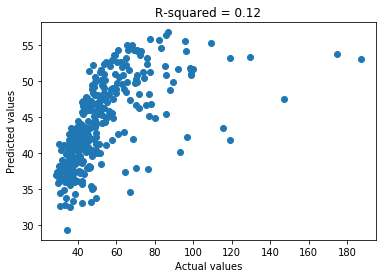

In [8]:
r_list = []
net.load_state_dict(torch.load('out/model_1714_0.6_0.1.ckpt'))
y_pred = net(x_test_0)
y_real = y_test_0
# y_pred = torch.from_numpy(scalery.inverse_transform(y_pred.cpu().detach().numpy())).to(dtype=torch.float32).cuda()    
# y_real = torch.from_numpy(scalery.inverse_transform(y_real.cpu().detach().numpy())).to(dtype=torch.float32).cuda()
loss_0 = MSELoss(y_pred, y_real)


t = [i for i in range(len(y_real))]
plt.plot(t, y_real.cpu().detach().numpy())
plt.plot(t, y_pred.cpu().detach().numpy())
plt.legend(['prediction', 'observation'])
plt.xlabel('DOE sample points')
plt.ylabel('HCOcl value')
plt.title('RMSE = %0.2f' % torch.sqrt(loss_0.data))
plt.savefig('DOE.png', dpi=400)
plt.close()

y_real = y_real.cpu().detach().numpy()
y_pred = y_pred.cpu().detach().numpy()
A = np.squeeze(y_pred)
B = np.squeeze(y_real)
res = B - A
tot = B - B.mean()
r = 1 - res.dot(res) / tot.dot(tot)
r_list.append(r)
plt.scatter(y_real, y_pred)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('R-squared = %0.2f' % r)
plt.savefig('DOE_r.png', dpi=400)
plt.close()

y_pred = net(x_test_1)
y_real = y_test_1
# y_pred = torch.from_numpy(scalery.inverse_transform(y_pred.cpu().detach().numpy())).to(dtype=torch.float32).cuda()    
# y_real = torch.from_numpy(scalery.inverse_transform(y_real.cpu().detach().numpy())).to(dtype=torch.float32).cuda()
loss_1 = MSELoss(y_pred, y_real)
t = [i for i in range(len(y_real))]
plt.plot(t, y_real.cpu().detach().numpy())
plt.plot(t, y_pred.cpu().detach().numpy())
plt.legend(['prediction', 'observation'])
plt.xlabel('TPA sample points')
plt.ylabel('HCOcl value')
plt.title('RMSE = %0.2f' % torch.sqrt(loss_1.data))
plt.savefig('TPA.png', dpi=400)
plt.close()


y_real = y_real.cpu().detach().numpy()
y_pred = y_pred.cpu().detach().numpy()
A = np.squeeze(y_pred)
B = np.squeeze(y_real)
res = B - A
tot = B - B.mean()
r = 1 - res.dot(res) / tot.dot(tot)
r_list.append(r)
plt.scatter(y_real, y_pred)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('R-squared = %0.2f' % r)
plt.savefig('TPA_r.png', dpi=400)
plt.close()

y_pred = net(x_target)
y_real = y_target
# y_pred = torch.from_numpy(scalery.inverse_transform(y_pred.cpu().detach().numpy())).to(dtype=torch.float32).cuda()    
# y_real = torch.from_numpy(scalery.inverse_transform(y_real.cpu().detach().numpy())).to(dtype=torch.float32).cuda()
loss_2 = MSELoss(y_pred, y_real)
t = [i for i in range(len(y_real))]
plt.plot(t, y_real.cpu().detach().numpy())
plt.plot(t, y_pred.cpu().detach().numpy())

plt.xlabel('altitude sample points')
plt.ylabel('HCOcl value')
plt.legend(['prediction', 'observation'])
plt.title('RMSE = %0.2f' % torch.sqrt(loss_2.data))
plt.savefig('altitude.png', dpi=400)
plt.close()

y_real = y_real.cpu().detach().numpy()
y_pred = y_pred.cpu().detach().numpy()
A = np.squeeze(y_pred)
B = np.squeeze(y_real)
res = B - A
tot = B - B.mean()
r = 1 - res.dot(res) / tot.dot(tot)
r_list.append(r)
plt.scatter(y_real, y_pred)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
# plt.plot(np.unique(y_real), np.poly1d(np.polyfit(y_real, y_pred, 1))(np.unique(y_real)))
plt.title('R-squared = %0.2f' % r)
plt.savefig('altitude_r.png', dpi=400)

print('epoch: %d || DOE: %f || TPA: %f || Target: %f' % (step, torch.sqrt(loss_0.data), torch.sqrt(loss_1.data), torch.sqrt(loss_2.data)))
print(r_list)

In [10]:
data.shape

(3727, 14)

In [50]:
from sklearn import mixture
from sklearn.cluster import KMeans

num_list_new = [num_list[1]-num_list[0], num_list[2]-num_list[1]]
data_1 = data.to_numpy()
data_1 = data_1[:, 1:]
data_1 = data_1[num_list[0]:, :]
estimator = mixture.BayesianGaussianMixture(
    n_components=2, covariance_type='full', weight_concentration_prior=0.1,
    weight_concentration_prior_type='dirichlet_process',
    mean_precision_prior=1e-6, init_params="random", max_iter=1000)

kmeans = KMeans(n_clusters=2, random_state=0).fit(data_1)
estimator.fit(data_1)
a = kmeans.predict(data_1)
print(a)
np.savetxt("foo.csv", a, delimiter=",")

[1 1 1 ... 1 1 0]


In [52]:
l0 = np.sum(a[:num_list_new[0]])
l1 = np.sum(a[num_list_new[0]:])
print(l0/num_list_new[0])
print(l1/num_list_new[1])


0.3999285203716941
0.5363790186125211


In [53]:
a[num_list_new[0]:].shape

(591,)

In [54]:
num_list_new[1]

591